In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import librosa
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Masking
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [2]:
def create_MFCC_coefficients(file_name):

    sr_value = 44100
    n_mfcc_count = 20
    
    try:
        # Load the audio file using librosa
        y, sr = librosa.load(file_name, sr=sr_value)
              
        # Compute MFCC coefficients for the segment
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_count)
        #print(f"file_name: {file_name}: y={len(y)}, sr={sr}, mfccs matrix:{np.shape(mfccs)}")
        
        # Create and return MFCC dataframe
        coeff_df = pd.DataFrame(mfccs)
        
        return coeff_df.T
    except:
        return None
song1 = create_MFCC_coefficients('/kaggle/input/data-songs/national-anthem-with-lyrics---best-patriotic-song.mp3')

### Training a model on large dataset first and finetuning them on our small dataset

In [31]:
lab = ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']
Data = []
Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
folder_names = os.listdir(folder_path)
for folder in folder_names:
    file_names = os.listdir(os.path.join(folder_path,folder))
    for file in file_names:
        Label.append(lab.index(folder))
        file_path = os.path.join(folder_path,folder,file)
        MFCC = create_MFCC_coefficients(file_path)
        if MFCC is None or MFCC.empty:
            continue
        mfcc_data_scaled = scaler.fit_transform(MFCC)
        mfcc_data_scaled = pd.DataFrame(mfcc_data_scaled)
        delta_mfcc = librosa.feature.delta(mfcc_data_scaled)
        delta2_mfcc = librosa.feature.delta(mfcc_data_scaled, order=2)
        combined_mfcc = np.hstack([mfcc_data_scaled, delta_mfcc, delta2_mfcc])
        Data.append(combined_mfcc.reshape(1,-1,60))

/tmp/ipykernel_30/2521891850.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=sr_value)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [29]:
def build_complex_bi_lstm_genre_classifier(input_shape, num_classes):
    inputs = Input(shape=(None, input_shape), name='input_layer')
    x = Masking(mask_value=0.0)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3), name='bi_lstm_1')(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3), name='bi_lstm_2')(x)
    x = Bidirectional(LSTM(32, return_sequences=False, dropout=0.3), name='bi_lstm_3')(x)
    x = Dense(128, activation='relu', name='dense_1')(x)
    x = Dropout(0.4, name='dropout_1')(x)
    x = Dense(64, activation='relu', name='dense_2')(x)
    x = Dropout(0.3, name='dropout_2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)
    model = Model(inputs, outputs, name='complex_bi_lstm_genre_classifier')
    return model
input_shape = 60
num_classes = 10
model = build_complex_bi_lstm_genre_classifier(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "complex_bi_lstm_genre_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 60)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None, 60)  │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, None, 60)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, None)      │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ (None, None, 256) │    193,536 │ masking_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ (None, None, 128) │    164,352 │ bi_lstm_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_3           │ (None, 64)        │     41,216 │ bi_lstm_2[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ bi_lstm_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 10)        │        650 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 416,330 (1.59 MB)

 Trainable params: 416,330 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
indices = np.random.permutation(len(Data))
Data = [Data[i] for i in indices]
Label = [Label[i] for i in indices]
X_train = Data[:800]
y_train = Label[:800]
X_test = Data[800:]
y_test = Label[800:]

In [11]:
print(X_train[500].shape)

(2616, 60)


In [32]:
model.fit(Data,Label, epochs=20, batch_size=1)

ValueError: Unrecognized data type: x=[array([[[0.        , 0.494433  , 1.        , ..., 0.01047847,
         0.01047847, 0.01047847],
        [0.08514011, 0.49174458, 0.8286083 , ..., 0.009821  ,
         0.009821  , 0.009821  ],
        [0.05422115, 0.4491219 , 0.7857217 , ..., 0.02437223,
         0.02437223, 0.02437223],
        ...,
        [0.510923  , 0.68389124, 0.7205495 , ..., 0.03987308,
         0.03987308, 0.03987308],
        [0.5393295 , 0.7146202 , 0.6846045 , ..., 0.03676183,
         0.03676183, 0.03676183],
        [0.48305267, 0.7383267 , 0.7626665 , ..., 0.01992948,
         0.01992948, 0.01992948]]], dtype=float32), array([[[ 0.67724675,  0.3440625 ,  0.7971298 , ...,  0.00332329,
          0.00332329,  0.00332329],
        [ 0.67396027,  0.5380686 ,  0.63063645, ...,  0.0044769 ,
          0.0044769 ,  0.0044769 ],
        [ 0.53523564,  0.6809707 ,  0.5653961 , ..., -0.00333298,
         -0.00333298, -0.00333298],
        ...,
        [ 0.6571495 ,  0.83263177,  0.38349175, ..., -0.01127286,
         -0.01127286, -0.01127286],
        [ 0.6546567 ,  0.77599925,  0.3726383 , ..., -0.04128578,
         -0.04128578, -0.04128578],
        [ 0.64024967,  0.73264986,  0.36153537, ..., -0.05215114,
         -0.05215114, -0.05215114]]], dtype=float32), array([[[ 0.57270753,  0.62297934,  0.48520702, ..., -0.01499174,
         -0.01499174, -0.01499174],
        [ 0.65049005,  0.7528847 ,  0.42889366, ..., -0.01065907,
         -0.01065907, -0.01065907],
        [ 0.65427095,  0.7894046 ,  0.41885507, ..., -0.01268159,
         -0.01268159, -0.01268159],
        ...,
        [ 0.6262836 ,  0.77484196,  0.39590803, ...,  0.00161243,
          0.00161243,  0.00161243],
        [ 0.6578142 ,  0.6591912 ,  0.3752157 , ..., -0.0062715 ,
         -0.0062715 , -0.0062715 ],
        [ 0.5927716 ,  0.5665181 ,  0.46022052, ..., -0.01903812,
         -0.01903812, -0.01903812]]], dtype=float32), array([[[ 7.5406098e-01,  6.4409322e-01,  6.0628200e-01, ...,
         -1.4158779e-02, -1.4158779e-02, -1.4158779e-02],
        [ 7.8236449e-01,  7.5911564e-01,  4.2738491e-01, ...,
         -2.0218886e-02, -2.0218886e-02, -2.0218886e-02],
        [ 7.5292152e-01,  6.8872982e-01,  3.5954118e-01, ...,
          6.9915346e-05,  6.9915346e-05,  6.9915346e-05],
        ...,
        [ 4.6433771e-01,  5.9018511e-01,  5.3327197e-01, ...,
         -3.4813490e-02, -3.4813490e-02, -3.4813490e-02],
        [ 5.5548167e-01,  5.8484620e-01,  4.6610865e-01, ...,
         -2.6060989e-02, -2.6060989e-02, -2.6060989e-02],
        [ 5.7222921e-01,  6.4633638e-01,  5.2295887e-01, ...,
         -7.1436474e-03, -7.1436474e-03, -7.1436474e-03]]], dtype=float32), array([[[ 0.74011093,  0.33440948,  0.63522744, ..., -0.02436594,
         -0.02436594, -0.02436594],
        [ 0.75752336,  0.5585928 ,  0.49427512, ..., -0.01944125,
         -0.01944125, -0.01944125],
        [ 0.67534393,  0.743556  ,  0.45345134, ...,  0.00139014,
          0.00139014,  0.00139014],
        ...,
        [ 0.30897367,  0.7952696 ,  0.7011899 , ..., -0.00559521,
         -0.00559521, -0.00559521],
        [ 0.28616714,  0.7760389 ,  0.7005404 , ..., -0.01204878,
         -0.01204878, -0.01204878],
        [ 0.20362258,  0.6898073 ,  0.7316148 , ..., -0.0382779 ,
         -0.0382779 , -0.0382779 ]]], dtype=float32), array([[[ 0.6314341 ,  0.21191323,  0.30505624, ...,  0.01112816,
          0.01112816,  0.01112816],
        [ 0.8409889 ,  0.54541016,  0.09894216, ..., -0.0056351 ,
         -0.0056351 , -0.0056351 ],
        [ 0.89318365,  0.73153067,  0.08557332, ..., -0.00262306,
         -0.00262306, -0.00262306],
        ...,
        [ 0.6457135 ,  0.7109078 ,  0.2951507 , ...,  0.01036717,
          0.01036717,  0.01036717],
        [ 0.7541605 ,  0.66145456,  0.24135971, ...,  0.00639907,
          0.00639907,  0.00639907],
        [ 0.7296393 ,  0.55942667,  0.2752876 , ..., -0.00374405,
         -0.00374405, -0.00374405]]], dtype=float32), array([[[ 0.77027607,  0.2708004 ,  0.533009  , ..., -0.0522344 ,
         -0.0522344 , -0.0522344 ],
        [ 0.7838496 ,  0.45174766,  0.3524738 , ..., -0.05891174,
         -0.05891174, -0.05891174],
        [ 0.6714406 ,  0.73386645,  0.13994491, ..., -0.05468728,
         -0.05468728, -0.05468728],
        ...,
        [ 0.42147326,  0.81628203,  0.5898515 , ..., -0.00634664,
         -0.00634664, -0.00634664],
        [ 0.39660376,  0.79851604,  0.609877  , ..., -0.00807086,
         -0.00807086, -0.00807086],
        [ 0.34076297,  0.78151524,  0.68953115, ..., -0.00192337,
         -0.00192337, -0.00192337]]], dtype=float32), array([[[7.1540463e-01, 4.1753346e-01, 1.0000000e+00, ...,
         4.6437592e-04, 4.6437592e-04, 4.6437592e-04],
        [7.3642409e-01, 5.7113928e-01, 7.2111636e-01, ...,
         8.3116656e-03, 8.3116656e-03, 8.3116656e-03],
        [6.0056329e-01, 6.4732200e-01, 3.9769405e-01, ...,
         1.7855400e-02, 1.7855400e-02, 1.7855400e-02],
        ...,
        [7.0586467e-01, 6.5968293e-01, 2.1213448e-01, ...,
         2.5990568e-02, 2.5990568e-02, 2.5990568e-02],
        [7.2661006e-01, 6.4001113e-01, 1.9901359e-01, ...,
         9.0683829e-03, 9.0683829e-03, 9.0683829e-03],
        [7.3756003e-01, 5.5651265e-01, 2.6966560e-01, ...,
         1.8860374e-02, 1.8860374e-02, 1.8860374e-02]]], dtype=float32), array([[[ 0.42516428,  0.33265913,  0.3692528 , ...,  0.00545779,
          0.00545779,  0.00545779],
        [ 0.5289337 ,  0.45612538,  0.32619   , ..., -0.0134937 ,
         -0.0134937 , -0.0134937 ],
        [ 0.5924537 ,  0.6267569 ,  0.43370378, ...,  0.00672065,
          0.00672065,  0.00672065],
        ...,
        [ 0.8798038 ,  0.78756046,  0.27181327, ..., -0.00860339,
         -0.00860339, -0.00860339],
        [ 0.76805395,  0.75674164,  0.35949916, ..., -0.00891074,
         -0.00891074, -0.00891074],
        [ 0.72078896,  0.577394  ,  0.5246113 , ..., -0.03181348,
         -0.03181348, -0.03181348]]], dtype=float32), array([[[ 0.8254087 ,  0.6238727 ,  0.52629155, ...,  0.00273348,
          0.00273348,  0.00273348],
        [ 0.8731966 ,  0.7866822 ,  0.35814768, ...,  0.00590404,
          0.00590404,  0.00590404],
        [ 0.8317063 ,  0.8743606 ,  0.34456825, ..., -0.00398428,
         -0.00398428, -0.00398428],
        ...,
        [ 0.69066834,  0.8180426 ,  0.3497259 , ..., -0.02189139,
         -0.02189139, -0.02189139],
        [ 0.71198726,  0.78138524,  0.2922951 , ..., -0.01981211,
         -0.01981211, -0.01981211],
        [ 0.6666119 ,  0.7384245 ,  0.35147846, ..., -0.00165906,
         -0.00165906, -0.00165906]]], dtype=float32), array([[[ 0.79384387,  0.4429247 ,  0.42718723, ...,  0.01846852,
          0.01846852,  0.01846852],
        [ 0.82507324,  0.5424322 ,  0.28389966, ...,  0.01022145,
          0.01022145,  0.01022145],
        [ 0.7897779 ,  0.5654392 ,  0.18891495, ...,  0.0033144 ,
          0.0033144 ,  0.0033144 ],
        ...,
        [ 0.62445766,  0.6466689 ,  0.38050318, ..., -0.00172962,
         -0.00172962, -0.00172962],
        [ 0.6509621 ,  0.68288076,  0.3829153 , ..., -0.01095868,
         -0.01095868, -0.01095868],
        [ 0.6157029 ,  0.6586305 ,  0.41650048, ..., -0.01676063,
         -0.01676063, -0.01676063]]], dtype=float32), array([[[ 0.28932637,  0.3072195 ,  0.66086   , ...,  0.01248023,
          0.01248023,  0.01248023],
        [ 0.30965567,  0.32662165,  0.54610413, ...,  0.01201421,
          0.01201421,  0.01201421],
        [ 0.25691164,  0.25619984,  0.4823361 , ...,  0.00447387,
          0.00447387,  0.00447387],
        ...,
        [ 0.5856306 ,  0.45496655,  0.249574  , ..., -0.00819035,
         -0.00819035, -0.00819035],
        [ 0.73204905,  0.5401094 ,  0.17767304, ..., -0.00867848,
         -0.00867848, -0.00867848],
        [ 0.6071885 ,  0.55397534,  0.30240017, ...,  0.00789061,
          0.00789061,  0.00789061]]], dtype=float32), array([[[ 0.06618333,  0.46428907,  1.        , ..., -0.01762578,
         -0.01762578, -0.01762578],
        [ 0.12398124,  0.48001254,  0.9340358 , ..., -0.02659214,
         -0.02659214, -0.02659214],
        [ 0.15100455,  0.5215746 ,  0.9180873 , ..., -0.03793569,
         -0.03793569, -0.03793569],
        ...,
        [ 0.5322982 ,  0.6445348 ,  0.7030279 , ..., -0.01951538,
         -0.01951538, -0.01951538],
        [ 0.48012245,  0.66581726,  0.7683146 , ..., -0.02137049,
         -0.02137049, -0.02137049],
        [ 0.41839886,  0.6466322 ,  0.85234064, ..., -0.03385196,
         -0.03385196, -0.03385196]]], dtype=float32), array([[[ 0.5597626 ,  0.207349  ,  0.71729416, ..., -0.03225661,
         -0.03225661, -0.03225661],
        [ 0.52342707,  0.45142883,  0.65566933, ..., -0.04073673,
         -0.04073673, -0.04073673],
        [ 0.31857997,  0.71324855,  0.612138  , ..., -0.01238063,
         -0.01238063, -0.01238063],
        ...,
        [ 0.34379238,  0.7004536 ,  0.56247437, ..., -0.00335421,
         -0.00335421, -0.00335421],
        [ 0.5474876 ,  0.52726287,  0.5060691 , ..., -0.00359739,
         -0.00359739, -0.00359739],
        [ 0.6527125 ,  0.3106447 ,  0.49882376, ...,  0.01976535,
          0.01976535,  0.01976535]]], dtype=float32), array([[[ 0.36806726,  0.55205905,  0.53514683, ..., -0.00652722,
         -0.00652722, -0.00652722],
        [ 0.4171406 ,  0.5266526 ,  0.48321086, ..., -0.0023049 ,
         -0.0023049 , -0.0023049 ],
        [ 0.36829507,  0.48298633,  0.53267455, ..., -0.00741934,
         -0.00741934, -0.00741934],
        ...,
        [ 0.64172876,  0.6986455 ,  0.3807407 , ..., -0.01297221,
         -0.01297221, -0.01297221],
        [ 0.6312447 ,  0.69604385,  0.4035427 , ..., -0.00560534,
         -0.00560534, -0.00560534],
        [ 0.55193746,  0.6407423 ,  0.4365974 , ..., -0.00976498,
         -0.00976498, -0.00976498]]], dtype=float32), array([[[ 0.84752476,  0.        ,  0.69354016, ..., -0.0212646 ,
         -0.0212646 , -0.0212646 ],
        [ 0.93823606,  0.27462256,  0.48154762, ..., -0.01969221,
         -0.01969221, -0.01969221],
        [ 0.8718045 ,  0.5352192 ,  0.31349772, ..., -0.02149974,
         -0.02149974, -0.02149974],
        ...,
        [ 0.53509164,  0.845085  ,  0.6085688 , ..., -0.029374  ,
         -0.029374  , -0.029374  ],
        [ 0.48642445,  0.7877445 ,  0.59182954, ..., -0.0344848 ,
         -0.0344848 , -0.0344848 ],
        [ 0.3607949 ,  0.6744739 ,  0.6789104 , ..., -0.0692948 ,
         -0.0692948 , -0.0692948 ]]], dtype=float32), array([[[ 0.6956672 ,  0.5354348 ,  0.7480786 , ..., -0.00227598,
         -0.00227598, -0.00227598],
        [ 0.7188064 ,  0.7146706 ,  0.6260339 , ..., -0.014305  ,
         -0.014305  , -0.014305  ],
        [ 0.6785586 ,  0.8931939 ,  0.5146557 , ..., -0.01015685,
         -0.01015685, -0.01015685],
        ...,
        [ 0.7106155 ,  0.8452706 ,  0.39957136, ..., -0.0276516 ,
         -0.0276516 , -0.0276516 ],
        [ 0.72594064,  0.83247143,  0.45768118, ..., -0.03141977,
         -0.03141977, -0.03141977],
        [ 0.71827173,  0.7287125 ,  0.5293375 , ..., -0.03016324,
         -0.03016324, -0.03016324]]], dtype=float32), array([[[0.18587744, 0.44559193, 0.67342985, ..., 0.01096632,
         0.01096632, 0.01096632],
        [0.30249214, 0.4827243 , 0.6097896 , ..., 0.00211598,
         0.00211598, 0.00211598],
        [0.24908066, 0.4367993 , 0.64321136, ..., 0.00729469,
         0.00729469, 0.00729469],
        ...,
        [0.41385508, 0.6938753 , 0.7522274 , ..., 0.02612422,
         0.02612422, 0.02612422],
        [0.4260804 , 0.6366663 , 0.76100385, ..., 0.03124633,
         0.03124633, 0.03124633],
        [0.32144457, 0.5296315 , 0.8102154 , ..., 0.0282479 ,
         0.0282479 , 0.0282479 ]]], dtype=float32), array([[[ 0.41401905,  0.43335062,  0.45248097, ..., -0.01724089,
         -0.01724089, -0.01724089],
        [ 0.6926429 ,  0.6998524 ,  0.3000323 , ..., -0.01011995,
         -0.01011995, -0.01011995],
        [ 0.766566  ,  0.77325636,  0.34065032, ..., -0.00206913,
         -0.00206913, -0.00206913],
        ...,
        [ 0.41144437,  0.5416793 ,  0.3366063 , ..., -0.01911565,
         -0.01911565, -0.01911565],
        [ 0.4103371 ,  0.60144013,  0.39243773, ..., -0.01783391,
         -0.01783391, -0.01783391],
        [ 0.34382296,  0.59431046,  0.46957207, ..., -0.01643173,
         -0.01643173, -0.01643173]]], dtype=float32), array([[[ 0.64440536,  0.7046878 ,  0.27494478, ...,  0.00564539,
          0.00564539,  0.00564539],
        [ 0.7920605 ,  0.72213227,  0.16514635, ...,  0.01619008,
          0.01619008,  0.01619008],
        [ 0.8334314 ,  0.7134667 ,  0.13919675, ...,  0.00996159,
          0.00996159,  0.00996159],
        ...,
        [ 0.66991067,  0.72435176,  0.43664417, ..., -0.02614443,
         -0.02614443, -0.02614443],
        [ 0.6334955 ,  0.75153047,  0.47795537, ..., -0.03729549,
         -0.03729549, -0.03729549],
        [ 0.54587567,  0.72442204,  0.5457527 , ..., -0.02784012,
         -0.02784012, -0.02784012]]], dtype=float32), array([[[ 0.67884946,  0.17505497,  0.86872804, ..., -0.01349541,
         -0.01349541, -0.01349541],
        [ 0.6964959 ,  0.3417459 ,  0.66583794, ..., -0.01141882,
         -0.01141882, -0.01141882],
        [ 0.58361083,  0.58566934,  0.34888476, ..., -0.01027826,
         -0.01027826, -0.01027826],
        ...,
        [ 0.53511065,  0.66295236,  0.3850413 , ..., -0.01516452,
         -0.01516452, -0.01516452],
        [ 0.54507184,  0.6888612 ,  0.4309088 , ..., -0.01623177,
         -0.01623177, -0.01623177],
        [ 0.4436494 ,  0.5831731 ,  0.5912285 , ..., -0.008171  ,
         -0.008171  , -0.008171  ]]], dtype=float32), array([[[ 7.6170874e-01,  5.7270670e-01,  3.0456376e-01, ...,
         -7.5742234e-03, -7.5742234e-03, -7.5742234e-03],
        [ 8.4908438e-01,  7.0534575e-01,  1.9322690e-01, ...,
          2.6743948e-03,  2.6743948e-03,  2.6743948e-03],
        [ 9.0407431e-01,  6.3546038e-01,  1.4429796e-01, ...,
          4.4263168e-03,  4.4263168e-03,  4.4263168e-03],
        ...,
        [ 5.9868687e-01,  6.5769172e-01,  2.6975441e-01, ...,
         -3.4243669e-03, -3.4243669e-03, -3.4243669e-03],
        [ 5.9427285e-01,  6.6808808e-01,  3.2174373e-01, ...,
         -4.4514048e-03, -4.4514048e-03, -4.4514048e-03],
        [ 5.1550174e-01,  6.4090872e-01,  4.1471130e-01, ...,
         -6.7722774e-04, -6.7722774e-04, -6.7722774e-04]]], dtype=float32), array([[[3.1293440e-01, 2.6150447e-01, 6.7439520e-01, ...,
         7.3298044e-04, 7.3298044e-04, 7.3298044e-04],
        [4.2420495e-01, 2.8249818e-01, 6.2344730e-01, ...,
         7.4375980e-03, 7.4375980e-03, 7.4375980e-03],
        [4.3065929e-01, 2.4185830e-01, 5.9050477e-01, ...,
         7.5558876e-03, 7.5558876e-03, 7.5558876e-03],
        ...,
        [7.0592034e-01, 9.1502988e-01, 4.5383567e-01, ...,
         2.2334643e-02, 2.2334643e-02, 2.2334643e-02],
        [7.5344777e-01, 8.7900639e-01, 4.1480562e-01, ...,
         1.2879279e-02, 1.2879279e-02, 1.2879279e-02],
        [7.8195822e-01, 8.0508316e-01, 4.2032805e-01, ...,
         9.7612180e-03, 9.7612180e-03, 9.7612180e-03]]], dtype=float32), array([[[ 0.60057884,  0.45896053,  0.13653755, ...,  0.02220816,
          0.02220816,  0.02220816],
        [ 0.63691026,  0.5572503 ,  0.114456  , ...,  0.01659039,
          0.01659039,  0.01659039],
        [ 0.56976795,  0.5231621 ,  0.15884441, ...,  0.01868034,
          0.01868034,  0.01868034],
        ...,
        [ 0.27309304,  0.35075706,  0.4773966 , ..., -0.03203635,
         -0.03203635, -0.03203635],
        [ 0.4557234 ,  0.49730146,  0.35335597, ..., -0.00975933,
         -0.00975933, -0.00975933],
        [ 0.5158996 ,  0.5294584 ,  0.33211192, ..., -0.00526606,
         -0.00526606, -0.00526606]]], dtype=float32), array([[[ 0.        ,  0.42999518,  1.        , ..., -0.02118651,
         -0.02118651, -0.02118651],
        [ 0.47622275,  0.36809492,  0.5110849 , ..., -0.01020545,
         -0.01020545, -0.01020545],
        [ 0.77158886,  0.4910742 ,  0.3306751 , ..., -0.00820126,
         -0.00820126, -0.00820126],
        ...,
        [ 0.08693814,  0.56107926,  0.96303827, ..., -0.04016832,
         -0.04016832, -0.04016832],
        [ 0.12356961,  0.6071899 ,  0.9107309 , ..., -0.05898581,
         -0.05898581, -0.05898581],
        [ 0.14316607,  0.64602065,  0.860093  , ..., -0.05626983,
         -0.05626983, -0.05626983]]], dtype=float32), array([[[ 0.8936223 ,  0.5960894 ,  0.52098596, ..., -0.0223309 ,
         -0.0223309 , -0.0223309 ],
        [ 0.914137  ,  0.7408207 ,  0.3610012 , ..., -0.03141941,
         -0.03141941, -0.03141941],
        [ 0.8750505 ,  0.7453317 ,  0.35958827, ..., -0.02597426,
         -0.02597426, -0.02597426],
        ...,
        [ 0.33135122,  0.5280946 ,  0.76450884, ..., -0.04401432,
         -0.04401432, -0.04401432],
        [ 0.29140562,  0.48787957,  0.80623597, ..., -0.0398041 ,
         -0.0398041 , -0.0398041 ],
        [ 0.22636467,  0.46673125,  0.8499014 , ..., -0.02282599,
         -0.02282599, -0.02282599]]], dtype=float32), array([[[ 0.7064572 ,  0.6179396 ,  0.6177771 , ..., -0.05674015,
         -0.05674015, -0.05674015],
        [ 0.72503984,  0.74604154,  0.41019756, ..., -0.04641952,
         -0.04641952, -0.04641952],
        [ 0.68407255,  0.7844637 ,  0.28816056, ..., -0.04274301,
         -0.04274301, -0.04274301],
        ...,
        [ 0.72872794,  0.6039351 ,  0.10173905, ...,  0.00576158,
          0.00576158,  0.00576158],
        [ 0.7337464 ,  0.6440895 ,  0.14155793, ...,  0.00902582,
          0.00902582,  0.00902582],
        [ 0.6694616 ,  0.61649823,  0.21725559, ...,  0.00115806,
          0.00115806,  0.00115806]]], dtype=float32), array([[[ 0.6936676 ,  0.49670395,  0.71775734, ..., -0.03200544,
         -0.03200544, -0.03200544],
        [ 0.6490143 ,  0.6135371 ,  0.5823537 , ..., -0.02724532,
         -0.02724532, -0.02724532],
        [ 0.51906806,  0.75841033,  0.42371336, ..., -0.02588029,
         -0.02588029, -0.02588029],
        ...,
        [ 0.5843066 ,  0.6971773 ,  0.5330071 , ...,  0.02343128,
          0.02343128,  0.02343128],
        [ 0.5724084 ,  0.6741245 ,  0.5396812 , ...,  0.03163014,
          0.03163014,  0.03163014],
        [ 0.58001095,  0.7390903 ,  0.5886628 , ...,  0.03078291,
          0.03078291,  0.03078291]]], dtype=float32), array([[[ 0.45243567,  0.6720146 ,  0.72552323, ..., -0.00757708,
         -0.00757708, -0.00757708],
        [ 0.47529513,  0.77304614,  0.5730942 , ..., -0.01254559,
         -0.01254559, -0.01254559],
        [ 0.47860545,  0.7798883 ,  0.5349047 , ..., -0.01493454,
         -0.01493454, -0.01493454],
        ...,
        [ 0.75031173,  0.77861273,  0.20910895, ...,  0.02267974,
          0.02267974,  0.02267974],
        [ 0.7636759 ,  0.73302484,  0.32661355, ...,  0.01561153,
          0.01561153,  0.01561153],
        [ 0.7230297 ,  0.6061264 ,  0.6093254 , ...,  0.02046994,
          0.02046994,  0.02046994]]], dtype=float32), array([[[0.6864061 , 0.35176706, 0.7012354 , ..., 0.02785442,
         0.02785442, 0.02785442],
        [0.7046353 , 0.48381555, 0.55311406, ..., 0.0162733 ,
         0.0162733 , 0.0162733 ],
        [0.63529146, 0.5025331 , 0.5398493 , ..., 0.01572993,
         0.01572993, 0.01572993],
        ...,
        [0.6220499 , 0.69387174, 0.34237707, ..., 0.04973285,
         0.04973285, 0.04973285],
        [0.64241916, 0.73788345, 0.3431335 , ..., 0.02822342,
         0.02822342, 0.02822342],
        [0.6714521 , 0.60402477, 0.477373  , ..., 0.00620433,
         0.00620433, 0.00620433]]], dtype=float32), array([[[0.28852463, 0.43819815, 0.8012889 , ..., 0.02378448,
         0.02378448, 0.02378448],
        [0.42879647, 0.45850194, 0.6932996 , ..., 0.02534731,
         0.02534731, 0.02534731],
        [0.57920825, 0.5522655 , 0.56819975, ..., 0.01796674,
         0.01796674, 0.01796674],
        ...,
        [0.7742171 , 0.8311329 , 0.29820412, ..., 0.01248654,
         0.01248654, 0.01248654],
        [0.74010146, 0.7986821 , 0.37216836, ..., 0.02061059,
         0.02061059, 0.02061059],
        [0.64087844, 0.6963568 , 0.49856937, ..., 0.01616224,
         0.01616224, 0.01616224]]], dtype=float32), array([[[ 0.65022254,  0.67193645,  0.5088025 , ...,  0.02661861,
          0.02661861,  0.02661861],
        [ 0.73751557,  0.68528444,  0.39336807, ..., -0.0038213 ,
         -0.0038213 , -0.0038213 ],
        [ 0.8292371 ,  0.7191697 ,  0.2555455 , ..., -0.01648696,
         -0.01648696, -0.01648696],
        ...,
        [ 0.69774777,  0.7750159 ,  0.49449873, ...,  0.02365871,
          0.02365871,  0.02365871],
        [ 0.68800974,  0.73645264,  0.485089  , ...,  0.02061495,
          0.02061495,  0.02061495],
        [ 0.6584412 ,  0.6506763 ,  0.5392606 , ...,  0.01952156,
          0.01952156,  0.01952156]]], dtype=float32), array([[[ 0.3431027 ,  0.3250572 ,  0.53667384, ...,  0.01002951,
          0.01002951,  0.01002951],
        [ 0.52389145,  0.37753826,  0.41190097, ...,  0.01675033,
          0.01675033,  0.01675033],
        [ 0.82470816,  0.64032096,  0.21297008, ...,  0.02538909,
          0.02538909,  0.02538909],
        ...,
        [ 0.4956599 ,  0.7928919 ,  0.5026474 , ...,  0.00788472,
          0.00788472,  0.00788472],
        [ 0.4829126 ,  0.7542946 ,  0.4863396 , ...,  0.00583577,
          0.00583577,  0.00583577],
        [ 0.39050215,  0.6814386 ,  0.56312644, ..., -0.00406238,
         -0.00406238, -0.00406238]]], dtype=float32), array([[[ 0.6268634 ,  0.19456452,  1.0000001 , ..., -0.01247461,
         -0.01247461, -0.01247461],
        [ 0.6412632 ,  0.3959778 ,  0.8139523 , ..., -0.01752599,
         -0.01752599, -0.01752599],
        [ 0.52581084,  0.6874369 ,  0.5377606 , ..., -0.00817472,
         -0.00817472, -0.00817472],
        ...,
        [ 0.7638451 ,  0.57071275,  0.1526773 , ..., -0.01918367,
         -0.01918367, -0.01918367],
        [ 0.7391059 ,  0.5495054 ,  0.16376686, ..., -0.0322121 ,
         -0.0322121 , -0.0322121 ],
        [ 0.5924595 ,  0.46440333,  0.2684735 , ..., -0.03940429,
         -0.03940429, -0.03940429]]], dtype=float32), array([[[ 0.42357057,  0.16113555,  0.51658297, ..., -0.02894845,
         -0.02894845, -0.02894845],
        [ 0.5836325 ,  0.40068394,  0.43110776, ..., -0.0180639 ,
         -0.0180639 , -0.0180639 ],
        [ 0.5921431 ,  0.55400103,  0.50333214, ..., -0.00352334,
         -0.00352334, -0.00352334],
        ...,
        [ 0.73519176,  0.6026842 ,  0.2276904 , ...,  0.04993236,
          0.04993236,  0.04993236],
        [ 0.67552537,  0.5905004 ,  0.26748288, ...,  0.0367371 ,
          0.0367371 ,  0.0367371 ],
        [ 0.60772014,  0.56525964,  0.26893073, ...,  0.02220204,
          0.02220204,  0.02220204]]], dtype=float32), array([[[ 4.9972409e-01,  4.8200408e-01,  5.6894499e-01, ...,
          2.0906519e-02,  2.0906519e-02,  2.0906519e-02],
        [ 6.5842825e-01,  5.8784270e-01,  4.7618681e-01, ...,
          2.8596548e-03,  2.8596548e-03,  2.8596548e-03],
        [ 7.4737507e-01,  6.4762008e-01,  4.3852794e-01, ...,
          7.3994813e-04,  7.3994813e-04,  7.3994813e-04],
        ...,
        [ 5.1356751e-01,  6.5175486e-01,  6.4729029e-01, ...,
         -1.6121219e-03, -1.6121219e-03, -1.6121219e-03],
        [ 4.8211133e-01,  6.3992238e-01,  6.7820942e-01, ...,
         -2.0933577e-03, -2.0933577e-03, -2.0933577e-03],
        [ 4.3363845e-01,  5.9328866e-01,  6.9746077e-01, ...,
          4.8515620e-03,  4.8515620e-03,  4.8515620e-03]]], dtype=float32), array([[[ 0.4284001 ,  0.5693669 ,  0.5274214 , ...,  0.01762618,
          0.01762618,  0.01762618],
        [ 0.47189772,  0.65080816,  0.3633199 , ...,  0.02658812,
          0.02658812,  0.02658812],
        [ 0.45073462,  0.60759944,  0.33235514, ...,  0.02698114,
          0.02698114,  0.02698114],
        ...,
        [ 0.73186195,  0.5895011 ,  0.38761196, ..., -0.0193212 ,
         -0.0193212 , -0.0193212 ],
        [ 0.72996736,  0.56052464,  0.34380037, ..., -0.00828234,
         -0.00828234, -0.00828234],
        [ 0.70541346,  0.36819798,  0.39346188, ..., -0.00918647,
         -0.00918647, -0.00918647]]], dtype=float32), array([[[ 6.5078926e-01,  4.0199131e-01,  6.8648601e-01, ...,
         -4.5727689e-02, -4.5727689e-02, -4.5727689e-02],
        [ 6.7399377e-01,  5.8724612e-01,  5.4835171e-01, ...,
         -3.8353190e-02, -3.8353190e-02, -3.8353190e-02],
        [ 6.0760260e-01,  6.4207464e-01,  5.0012517e-01, ...,
         -1.7536709e-02, -1.7536709e-02, -1.7536709e-02],
        ...,
        [ 8.2294160e-01,  6.1510009e-01,  4.8794875e-01, ...,
         -2.7344594e-02, -2.7344594e-02, -2.7344594e-02],
        [ 8.2196498e-01,  5.8878881e-01,  4.5838651e-01, ...,
         -1.7850582e-02, -1.7850582e-02, -1.7850582e-02],
        [ 7.4141324e-01,  4.8057538e-01,  4.8111054e-01, ...,
         -2.0026678e-04, -2.0026678e-04, -2.0026678e-04]]], dtype=float32), array([[[ 0.30030173,  0.32240802,  0.8715032 , ...,  0.01163707,
          0.01163707,  0.01163707],
        [ 0.3461095 ,  0.45528919,  0.72430587, ...,  0.01934512,
          0.01934512,  0.01934512],
        [ 0.29394907,  0.4653346 ,  0.7627095 , ...,  0.03497089,
          0.03497089,  0.03497089],
        ...,
        [ 0.77329683,  0.5837186 ,  0.25845218, ..., -0.0188916 ,
         -0.0188916 , -0.0188916 ],
        [ 0.7016224 ,  0.5993679 ,  0.3883227 , ..., -0.01251938,
         -0.01251938, -0.01251938],
        [ 0.5080756 ,  0.54878384,  0.65576756, ..., -0.03547138,
         -0.03547138, -0.03547138]]], dtype=float32), array([[[ 5.8875775e-01,  0.0000000e+00,  7.7056825e-01, ...,
          6.7149714e-04,  6.7149714e-04,  6.7149714e-04],
        [ 6.1314565e-01,  1.5584570e-01,  5.9157646e-01, ...,
         -9.7487578e-03, -9.7487578e-03, -9.7487578e-03],
        [ 4.4800007e-01,  3.6851615e-01,  3.7889612e-01, ...,
         -1.0186761e-03, -1.0186761e-03, -1.0186761e-03],
        ...,
        [ 7.1534586e-01,  7.0886272e-01,  2.5427800e-01, ...,
         -2.6010156e-02, -2.6010156e-02, -2.6010156e-02],
        [ 6.7426276e-01,  6.4525133e-01,  2.7380377e-01, ...,
         -2.1734932e-02, -2.1734932e-02, -2.1734932e-02],
        [ 5.9462547e-01,  4.0476471e-01,  3.8549000e-01, ...,
         -7.7740378e-03, -7.7740378e-03, -7.7740378e-03]]], dtype=float32), array([[[ 0.5742232 ,  0.        ,  0.7768458 , ...,  0.00132538,
          0.00132538,  0.00132538],
        [ 0.5799841 ,  0.17711085,  0.6066287 , ..., -0.00184152,
         -0.00184152, -0.00184152],
        [ 0.4882918 ,  0.538482  ,  0.45035094, ..., -0.00613582,
         -0.00613582, -0.00613582],
        ...,
        [ 0.58131194,  0.6836994 ,  0.58411115, ...,  0.00354869,
          0.00354869,  0.00354869],
        [ 0.56293905,  0.72290283,  0.63917077, ..., -0.00092272,
         -0.00092272, -0.00092272],
        [ 0.4779585 ,  0.7074227 ,  0.78554666, ..., -0.01535203,
         -0.01535203, -0.01535203]]], dtype=float32), array([[[ 0.5466684 ,  0.752925  ,  0.518703  , ..., -0.00815883,
         -0.00815883, -0.00815883],
        [ 0.588441  ,  0.8196928 ,  0.4529674 , ..., -0.00719963,
         -0.00719963, -0.00719963],
        [ 0.5237983 ,  0.7395579 ,  0.47610068, ..., -0.0048466 ,
         -0.0048466 , -0.0048466 ],
        ...,
        [ 0.7313418 ,  0.7397879 ,  0.44589108, ..., -0.00400926,
         -0.00400926, -0.00400926],
        [ 0.82602495,  0.7915124 ,  0.3165604 , ...,  0.00703775,
          0.00703775,  0.00703775],
        [ 0.7490082 ,  0.7161918 ,  0.31305385, ...,  0.01358561,
          0.01358561,  0.01358561]]], dtype=float32), array([[[ 0.57573164,  0.5573987 ,  0.45112562, ..., -0.01369518,
         -0.01369518, -0.01369518],
        [ 0.6450612 ,  0.75692093,  0.37140322, ..., -0.00508485,
         -0.00508485, -0.00508485],
        [ 0.6206016 ,  0.75141525,  0.3797385 , ..., -0.02055087,
         -0.02055087, -0.02055087],
        ...,
        [ 0.83361316,  0.62379515,  0.130133  , ..., -0.00370075,
         -0.00370075, -0.00370075],
        [ 0.7493485 ,  0.5518633 ,  0.18119508, ..., -0.01187725,
         -0.01187725, -0.01187725],
        [ 0.65031135,  0.5054089 ,  0.2843265 , ..., -0.00234115,
         -0.00234115, -0.00234115]]], dtype=float32), array([[[ 0.4636743 ,  0.646875  ,  0.48376486, ..., -0.0143362 ,
         -0.0143362 , -0.0143362 ],
        [ 0.5152357 ,  0.6735586 ,  0.4597625 , ..., -0.00786802,
         -0.00786802, -0.00786802],
        [ 0.49327618,  0.65180266,  0.46187046, ...,  0.00225736,
          0.00225736,  0.00225736],
        ...,
        [ 0.66019535,  0.83753276,  0.3342976 , ..., -0.02664544,
         -0.02664544, -0.02664544],
        [ 0.66174346,  0.86597884,  0.37781864, ..., -0.01375835,
         -0.01375835, -0.01375835],
        [ 0.6146287 ,  0.8682909 ,  0.4098487 , ...,  0.011826  ,
          0.011826  ,  0.011826  ]]], dtype=float32), array([[[ 0.6243395 ,  0.48629677,  0.3348167 , ..., -0.00839363,
         -0.00839363, -0.00839363],
        [ 0.70162964,  0.5308981 ,  0.26709694, ...,  0.00455194,
          0.00455194,  0.00455194],
        [ 0.6903342 ,  0.5002502 ,  0.26703274, ...,  0.01353726,
          0.01353726,  0.01353726],
        ...,
        [ 0.5109736 ,  0.5458741 ,  0.5882083 , ..., -0.00380344,
         -0.00380344, -0.00380344],
        [ 0.48744774,  0.4901892 ,  0.6034727 , ..., -0.00399622,
         -0.00399622, -0.00399622],
        [ 0.3086934 ,  0.34984577,  0.6714343 , ..., -0.004565  ,
         -0.004565  , -0.004565  ]]], dtype=float32), array([[[ 0.3252331 ,  0.31779847,  0.5094478 , ..., -0.02548767,
         -0.02548767, -0.02548767],
        [ 0.39247864,  0.29610923,  0.4462726 , ..., -0.02969312,
         -0.02969312, -0.02969312],
        [ 0.36121356,  0.20828405,  0.4353033 , ..., -0.035505  ,
         -0.035505  , -0.035505  ],
        ...,
        [ 0.1719209 ,  0.57696295,  0.6158782 , ...,  0.00207569,
          0.00207569,  0.00207569],
        [ 0.16231883,  0.54586065,  0.5987169 , ...,  0.01398875,
          0.01398875,  0.01398875],
        [ 0.10346317,  0.47807816,  0.58996785, ...,  0.01873339,
          0.01873339,  0.01873339]]], dtype=float32), array([[[ 0.64381015,  0.11712933,  0.5360884 , ..., -0.00977557,
         -0.00977557, -0.00977557],
        [ 0.65655285,  0.30512422,  0.43777585, ..., -0.00800829,
         -0.00800829, -0.00800829],
        [ 0.5806985 ,  0.42821443,  0.3604309 , ..., -0.01040145,
         -0.01040145, -0.01040145],
        ...,
        [ 0.6479605 ,  0.5473449 ,  0.37576365, ..., -0.02829006,
         -0.02829006, -0.02829006],
        [ 0.7169056 ,  0.38299227,  0.4103225 , ..., -0.0266808 ,
         -0.0266808 , -0.0266808 ],
        [ 0.6809004 ,  0.21965915,  0.52935237, ..., -0.01214901,
         -0.01214901, -0.01214901]]], dtype=float32), array([[[ 0.7298507 ,  0.04997063,  0.800495  , ...,  0.01992329,
          0.01992329,  0.01992329],
        [ 0.69918597,  0.2628423 ,  0.6842872 , ...,  0.01430377,
          0.01430377,  0.01430377],
        [ 0.51846826,  0.5598743 ,  0.44470674, ...,  0.00484549,
          0.00484549,  0.00484549],
        ...,
        [ 0.67548203,  0.6260277 ,  0.28583086, ..., -0.01865018,
         -0.01865018, -0.01865018],
        [ 0.6043911 ,  0.5978935 ,  0.33145916, ..., -0.02299017,
         -0.02299017, -0.02299017],
        [ 0.47087073,  0.56435966,  0.44647014, ..., -0.02543902,
         -0.02543902, -0.02543902]]], dtype=float32), array([[[ 0.18321323,  0.39510596,  0.8671292 , ...,  0.03176155,
          0.03176155,  0.03176155],
        [ 0.20056438,  0.5913328 ,  0.71648234, ...,  0.02519344,
          0.02519344,  0.02519344],
        [ 0.19304764,  0.6738715 ,  0.648881  , ...,  0.02256388,
          0.02256388,  0.02256388],
        ...,
        [ 0.25327253,  0.80653095,  0.68767685, ...,  0.01319467,
          0.01319467,  0.01319467],
        [ 0.28796566,  0.75375783,  0.6739343 , ..., -0.01441394,
         -0.01441394, -0.01441394],
        [ 0.30316663,  0.57192266,  0.6632741 , ..., -0.0317589 ,
         -0.0317589 , -0.0317589 ]]], dtype=float32), array([[[ 0.4982667 ,  0.6822808 ,  0.49357074, ...,  0.01759662,
          0.01759662,  0.01759662],
        [ 0.5328448 ,  0.796631  ,  0.48558566, ...,  0.01577478,
          0.01577478,  0.01577478],
        [ 0.4895473 ,  0.7755946 ,  0.51325643, ...,  0.00699976,
          0.00699976,  0.00699976],
        ...,
        [ 0.5115133 ,  0.66699827,  0.4034206 , ...,  0.00404602,
          0.00404602,  0.00404602],
        [ 0.48089337,  0.6267719 ,  0.44137928, ...,  0.00750585,
          0.00750585,  0.00750585],
        [ 0.35435408,  0.480086  ,  0.50922406, ..., -0.01224112,
         -0.01224112, -0.01224112]]], dtype=float32), array([[[0.9618992 , 0.17257857, 1.        , ..., 0.00664643,
         0.00664643, 0.00664643],
        [0.9388836 , 0.2967242 , 0.75749606, ..., 0.01854323,
         0.01854323, 0.01854323],
        [0.74993765, 0.74758506, 0.34070832, ..., 0.02375374,
         0.02375374, 0.02375374],
        ...,
        [0.59014803, 0.4992925 , 0.25845265, ..., 0.02088998,
         0.02088998, 0.02088998],
        [0.59774524, 0.5181124 , 0.2523362 , ..., 0.02029067,
         0.02029067, 0.02029067],
        [0.57435995, 0.5128093 , 0.2896245 , ..., 0.02295398,
         0.02295398, 0.02295398]]], dtype=float32), array([[[ 0.6087279 ,  0.5793548 ,  0.79375577, ...,  0.01001613,
          0.01001613,  0.01001613],
        [ 0.4587655 ,  0.5925549 ,  0.80575204, ...,  0.00952545,
          0.00952545,  0.00952545],
        [ 0.3453992 ,  0.34884208,  0.6807725 , ...,  0.00778446,
          0.00778446,  0.00778446],
        ...,
        [ 0.5533247 ,  0.8086676 ,  0.6813864 , ...,  0.01095968,
          0.01095968,  0.01095968],
        [ 0.5089003 ,  0.7989578 ,  0.67690134, ..., -0.00584882,
         -0.00584882, -0.00584882],
        [ 0.42795503,  0.6925339 ,  0.65498567, ..., -0.00352784,
         -0.00352784, -0.00352784]]], dtype=float32), array([[[0.6308335 , 0.1867792 , 0.9777144 , ..., 0.01677633,
         0.01677633, 0.01677633],
        [0.6088671 , 0.24847919, 0.8023964 , ..., 0.01814093,
         0.01814093, 0.01814093],
        [0.44575763, 0.47154242, 0.5722393 , ..., 0.0198812 ,
         0.0198812 , 0.0198812 ],
        ...,
        [0.52976555, 0.76770276, 0.5163491 , ..., 0.02650602,
         0.02650602, 0.02650602],
        [0.51638997, 0.8002605 , 0.5168363 , ..., 0.03555558,
         0.03555558, 0.03555558],
        [0.523439  , 0.79573077, 0.51381505, ..., 0.02374191,
         0.02374191, 0.02374191]]], dtype=float32), array([[[ 0.59494996,  0.3482582 ,  0.4459854 , ..., -0.01502317,
         -0.01502317, -0.01502317],
        [ 0.61817634,  0.50249237,  0.3509742 , ..., -0.01226359,
         -0.01226359, -0.01226359],
        [ 0.60613465,  0.5098292 ,  0.35148218, ..., -0.01024114,
         -0.01024114, -0.01024114],
        ...,
        [ 0.7870755 ,  0.63589615,  0.1595481 , ..., -0.0129501 ,
         -0.0129501 , -0.0129501 ],
        [ 0.80910033,  0.63807744,  0.11973417, ..., -0.00956888,
         -0.00956888, -0.00956888],
        [ 0.7731545 ,  0.6024994 ,  0.12774938, ..., -0.00624671,
         -0.00624671, -0.00624671]]], dtype=float32), array([[[ 0.81506073,  0.5711486 ,  0.16583931, ...,  0.03707083,
          0.03707083,  0.03707083],
        [ 0.8957094 ,  0.7054481 ,  0.09057641, ...,  0.03984424,
          0.03984424,  0.03984424],
        [ 0.88528454,  0.69855934,  0.09042799, ...,  0.03981684,
          0.03981684,  0.03981684],
        ...,
        [ 0.5434187 ,  0.66099125,  0.48168755, ...,  0.02262787,
          0.02262787,  0.02262787],
        [ 0.5114381 ,  0.7365139 ,  0.5187505 , ...,  0.00304822,
          0.00304822,  0.00304822],
        [ 0.4406212 ,  0.76445264,  0.6237799 , ..., -0.00869825,
         -0.00869825, -0.00869825]]], dtype=float32), array([[[ 0.8947258 ,  0.19466233,  0.90373164, ...,  0.02445851,
          0.02445851,  0.02445851],
        [ 0.9296533 ,  0.36414087,  0.64548784, ...,  0.0197399 ,
          0.0197399 ,  0.0197399 ],
        [ 0.7926011 ,  0.6683607 ,  0.3163122 , ...,  0.008172  ,
          0.008172  ,  0.008172  ],
        ...,
        [ 0.34930444,  0.77089953,  0.6308409 , ..., -0.03319224,
         -0.03319224, -0.03319224],
        [ 0.37930727,  0.7074355 ,  0.63264513, ..., -0.0285486 ,
         -0.0285486 , -0.0285486 ],
        [ 0.28490424,  0.6660874 ,  0.69155407, ..., -0.00112365,
         -0.00112365, -0.00112365]]], dtype=float32), array([[[ 0.6265715 ,  0.29769266,  0.5502118 , ...,  0.00283058,
          0.00283058,  0.00283058],
        [ 0.65780336,  0.4492095 ,  0.36868203, ...,  0.02416582,
          0.02416582,  0.02416582],
        [ 0.5936363 ,  0.6520845 ,  0.2716177 , ...,  0.03047076,
          0.03047076,  0.03047076],
        ...,
        [ 0.5623859 ,  0.7658033 ,  0.37349153, ...,  0.00186157,
          0.00186157,  0.00186157],
        [ 0.54289234,  0.7376755 ,  0.33944428, ...,  0.00120318,
          0.00120318,  0.00120318],
        [ 0.45206088,  0.6359133 ,  0.36352313, ..., -0.01614488,
         -0.01614488, -0.01614488]]], dtype=float32), array([[[ 5.6111783e-01,  8.2537448e-01,  4.0872619e-01, ...,
          2.9305783e-03,  2.9305783e-03,  2.9305783e-03],
        [ 6.4803350e-01,  7.7909172e-01,  2.7200490e-01, ...,
         -8.0083479e-04, -8.0083479e-04, -8.0083479e-04],
        [ 7.8256398e-01,  9.3684316e-01,  2.4570525e-01, ...,
          5.6960490e-03,  5.6960490e-03,  5.6960490e-03],
        ...,
        [ 3.0873609e-01,  6.1814249e-01,  5.7667077e-01, ...,
          3.5099059e-02,  3.5099059e-02,  3.5099059e-02],
        [ 3.4202206e-01,  6.7216957e-01,  5.5611414e-01, ...,
          3.0661291e-02,  3.0661291e-02,  3.0661291e-02],
        [ 3.6120456e-01,  6.1237788e-01,  5.2213764e-01, ...,
          3.2396551e-02,  3.2396551e-02,  3.2396551e-02]]], dtype=float32), array([[[ 8.0934554e-01,  7.5036335e-01,  4.0608165e-01, ...,
         -7.8618461e-05, -7.8618461e-05, -7.8618461e-05],
        [ 8.6285257e-01,  7.7620578e-01,  3.6759537e-01, ...,
          2.5133721e-03,  2.5133721e-03,  2.5133721e-03],
        [ 8.2368332e-01,  7.3307788e-01,  3.5703880e-01, ...,
          1.3349541e-03,  1.3349541e-03,  1.3349541e-03],
        ...,
        [ 8.4464782e-01,  5.6588781e-01,  2.6593757e-01, ...,
          2.0777095e-04,  2.0777095e-04,  2.0777095e-04],
        [ 8.7695855e-01,  5.5343616e-01,  3.0390331e-01, ...,
         -8.6296070e-03, -8.6296070e-03, -8.6296070e-03],
        [ 8.3565873e-01,  4.4492185e-01,  4.0202221e-01, ...,
         -2.0473806e-02, -2.0473806e-02, -2.0473806e-02]]], dtype=float32), array([[[ 0.6034867 ,  0.        ,  0.6814948 , ...,  0.01727975,
          0.01727975,  0.01727975],
        [ 0.6273103 ,  0.19260055,  0.50435424, ...,  0.01893767,
          0.01893767,  0.01893767],
        [ 0.5249578 ,  0.22338074,  0.43865192, ...,  0.00999803,
          0.00999803,  0.00999803],
        ...,
        [ 0.63318855,  0.6258467 ,  0.47742373, ..., -0.01226779,
         -0.01226779, -0.01226779],
        [ 0.7173369 ,  0.6753153 ,  0.5113063 , ..., -0.01765404,
         -0.01765404, -0.01765404],
        [ 0.7319882 ,  0.5311845 ,  0.68394285, ..., -0.02263687,
         -0.02263687, -0.02263687]]], dtype=float32), array([[[ 0.5218043 ,  0.40925568,  0.58640236, ...,  0.01067095,
          0.01067095,  0.01067095],
        [ 0.54930437,  0.45836192,  0.53913003, ..., -0.00938184,
         -0.00938184, -0.00938184],
        [ 0.507939  ,  0.5005714 ,  0.52718115, ..., -0.01531673,
         -0.01531673, -0.01531673],
        ...,
        [ 0.5758613 ,  0.6976252 ,  0.5465609 , ..., -0.00852646,
         -0.00852646, -0.00852646],
        [ 0.6131551 ,  0.61192197,  0.5752251 , ..., -0.01925733,
         -0.01925733, -0.01925733],
        [ 0.61556745,  0.40809792,  0.63131815, ..., -0.03395488,
         -0.03395488, -0.03395488]]], dtype=float32), array([[[ 0.5597626 ,  0.207349  ,  0.71729416, ..., -0.03225661,
         -0.03225661, -0.03225661],
        [ 0.52342707,  0.45142883,  0.65566933, ..., -0.04073673,
         -0.04073673, -0.04073673],
        [ 0.31857997,  0.71324855,  0.612138  , ..., -0.01238063,
         -0.01238063, -0.01238063],
        ...,
        [ 0.34379238,  0.7004536 ,  0.56247437, ..., -0.00335421,
         -0.00335421, -0.00335421],
        [ 0.5474876 ,  0.52726287,  0.5060691 , ..., -0.00359739,
         -0.00359739, -0.00359739],
        [ 0.6527125 ,  0.3106447 ,  0.49882376, ...,  0.01976535,
          0.01976535,  0.01976535]]], dtype=float32), array([[[ 0.63171077,  0.47106612,  0.45776686, ..., -0.01172273,
         -0.01172273, -0.01172273],
        [ 0.61250585,  0.6203244 ,  0.3635959 , ..., -0.00437656,
         -0.00437656, -0.00437656],
        [ 0.55437815,  0.69454074,  0.34879744, ...,  0.0013512 ,
          0.0013512 ,  0.0013512 ],
        ...,
        [ 0.42275757,  0.79186916,  0.57812804, ..., -0.01414336,
         -0.01414336, -0.01414336],
        [ 0.46465808,  0.7401085 ,  0.5780175 , ..., -0.03461769,
         -0.03461769, -0.03461769],
        [ 0.4653877 ,  0.5941464 ,  0.56789434, ..., -0.04201164,
         -0.04201164, -0.04201164]]], dtype=float32), array([[[ 0.4595518 ,  0.70041597,  0.63868105, ..., -0.01559601,
         -0.01559601, -0.01559601],
        [ 0.536762  ,  0.75108755,  0.5740693 , ..., -0.01157361,
         -0.01157361, -0.01157361],
        [ 0.49616492,  0.6955925 ,  0.57180595, ...,  0.00839504,
          0.00839504,  0.00839504],
        ...,
        [ 0.610515  ,  0.8507446 ,  0.48510733, ..., -0.02689019,
         -0.02689019, -0.02689019],
        [ 0.5694257 ,  0.8349377 ,  0.5252161 , ..., -0.03214313,
         -0.03214313, -0.03214313],
        [ 0.48232841,  0.81126106,  0.62181556, ..., -0.0293272 ,
         -0.0293272 , -0.0293272 ]]], dtype=float32), array([[[ 0.3886608 ,  0.5664795 ,  0.865674  , ..., -0.03642111,
         -0.03642111, -0.03642111],
        [ 0.39142388,  0.7537535 ,  0.68642896, ..., -0.02087208,
         -0.02087208, -0.02087208],
        [ 0.33430773,  0.80749613,  0.64120495, ..., -0.03419922,
         -0.03419922, -0.03419922],
        ...,
        [ 0.43376678,  0.61085993,  0.40708417, ..., -0.01030604,
         -0.01030604, -0.01030604],
        [ 0.51684314,  0.43600208,  0.33214998, ..., -0.00178477,
         -0.00178477, -0.00178477],
        [ 0.47036368,  0.29422367,  0.42462575, ..., -0.00169506,
         -0.00169506, -0.00169506]]], dtype=float32), array([[[ 0.22529173,  0.2886274 ,  0.72247607, ...,  0.00533924,
          0.00533924,  0.00533924],
        [ 0.3003235 ,  0.3896767 ,  0.6849863 , ...,  0.00740114,
          0.00740114,  0.00740114],
        [ 0.22176802,  0.3685062 ,  0.6876178 , ..., -0.00379386,
         -0.00379386, -0.00379386],
        ...,
        [ 0.5168132 ,  0.6060182 ,  0.44606793, ...,  0.01926604,
          0.01926604,  0.01926604],
        [ 0.5000044 ,  0.6537577 ,  0.4242348 , ...,  0.02546228,
          0.02546228,  0.02546228],
        [ 0.4246552 ,  0.6125952 ,  0.45156223, ...,  0.02764114,
          0.02764114,  0.02764114]]], dtype=float32), array([[[ 0.8578232 ,  0.57702804,  0.46116582, ..., -0.02005999,
         -0.02005999, -0.02005999],
        [ 0.9018394 ,  0.7534262 ,  0.32866424, ..., -0.02525647,
         -0.02525647, -0.02525647],
        [ 0.86476445,  0.72653353,  0.3114459 , ..., -0.02050521,
         -0.02050521, -0.02050521],
        ...,
        [ 0.6019689 ,  0.7026013 ,  0.5166867 , ...,  0.01214037,
          0.01214037,  0.01214037],
        [ 0.58902884,  0.68999135,  0.5156102 , ...,  0.01232653,
          0.01232653,  0.01232653],
        [ 0.4922244 ,  0.5595671 ,  0.58823144, ...,  0.00384981,
          0.00384981,  0.00384981]]], dtype=float32), array([[[ 0.88751346,  0.52346057,  0.5064981 , ...,  0.02532764,
          0.02532764,  0.02532764],
        [ 0.97731996,  0.7176358 ,  0.35509396, ..., -0.0127111 ,
         -0.0127111 , -0.0127111 ],
        [ 0.89762837,  0.7070485 ,  0.32302326, ..., -0.02113976,
         -0.02113976, -0.02113976],
        ...,
        [ 0.78485346,  0.593679  ,  0.21276909, ...,  0.01382177,
          0.01382177,  0.01382177],
        [ 0.7801566 ,  0.6304348 ,  0.22022814, ...,  0.00510443,
          0.00510443,  0.00510443],
        [ 0.7303586 ,  0.6056716 ,  0.27947313, ...,  0.00395849,
          0.00395849,  0.00395849]]], dtype=float32), array([[[ 0.5470547 ,  0.51583874,  0.8642158 , ...,  0.03384089,
          0.03384089,  0.03384089],
        [ 0.57481456,  0.7361474 ,  0.7193594 , ...,  0.01649521,
          0.01649521,  0.01649521],
        [ 0.5115711 ,  0.7517315 ,  0.6721367 , ...,  0.02268992,
          0.02268992,  0.02268992],
        ...,
        [ 0.5933669 ,  0.5842271 ,  0.15975428, ..., -0.02318652,
         -0.02318652, -0.02318652],
        [ 0.5591733 ,  0.64621294,  0.24479759, ..., -0.04581416,
         -0.04581416, -0.04581416],
        [ 0.4031036 ,  0.5166501 ,  0.36811393, ..., -0.05115484,
         -0.05115484, -0.05115484]]], dtype=float32), array([[[ 0.15831125,  0.5856343 ,  0.9248981 , ..., -0.01818141,
         -0.01818141, -0.01818141],
        [ 0.16631079,  0.78914577,  0.7872921 , ..., -0.01696217,
         -0.01696217, -0.01696217],
        [ 0.11686659,  0.754456  ,  0.796032  , ..., -0.01221868,
         -0.01221868, -0.01221868],
        ...,
        [ 0.8728557 ,  0.67107314,  0.28222573, ..., -0.00614101,
         -0.00614101, -0.00614101],
        [ 0.88205266,  0.54797655,  0.41015178, ..., -0.01599213,
         -0.01599213, -0.01599213],
        [ 0.91147214,  0.4628603 ,  0.6676805 , ..., -0.01266251,
         -0.01266251, -0.01266251]]], dtype=float32), array([[[ 0.7264806 ,  0.2509541 ,  0.48208487, ...,  0.01199267,
          0.01199267,  0.01199267],
        [ 0.7417047 ,  0.42439145,  0.37485778, ...,  0.01254272,
          0.01254272,  0.01254272],
        [ 0.64945185,  0.49414182,  0.27536654, ...,  0.00934476,
          0.00934476,  0.00934476],
        ...,
        [ 0.5992495 ,  0.64175   ,  0.37393183, ..., -0.01498504,
         -0.01498504, -0.01498504],
        [ 0.56433344,  0.62930524,  0.39481407, ..., -0.00585447,
         -0.00585447, -0.00585447],
        [ 0.49018246,  0.6201638 ,  0.53519666, ..., -0.00426474,
         -0.00426474, -0.00426474]]], dtype=float32), array([[[ 0.8430072 ,  0.28798068,  0.6928998 , ..., -0.01591669,
         -0.01591669, -0.01591669],
        [ 0.85481596,  0.43450004,  0.572315  , ..., -0.01433953,
         -0.01433953, -0.01433953],
        [ 0.69329876,  0.71492296,  0.27252185, ..., -0.03348393,
         -0.03348393, -0.03348393],
        ...,
        [ 0.67131996,  0.5752246 ,  0.34955275, ..., -0.01016482,
         -0.01016482, -0.01016482],
        [ 0.7122819 ,  0.64012057,  0.44891703, ..., -0.00394027,
         -0.00394027, -0.00394027],
        [ 0.75251114,  0.5699057 ,  0.6622112 , ..., -0.00178801,
         -0.00178801, -0.00178801]]], dtype=float32), array([[[ 7.8562015e-01,  6.0620928e-01,  7.4950767e-01, ...,
         -1.5621964e-02, -1.5621964e-02, -1.5621964e-02],
        [ 8.6643553e-01,  8.2811856e-01,  5.4440904e-01, ...,
         -1.6940495e-02, -1.6940495e-02, -1.6940495e-02],
        [ 8.5182154e-01,  8.8690031e-01,  4.1455823e-01, ...,
         -3.7277665e-02, -3.7277665e-02, -3.7277665e-02],
        ...,
        [ 7.7559584e-01,  6.4714074e-01,  2.8324944e-01, ...,
          1.2101541e-02,  1.2101541e-02,  1.2101541e-02],
        [ 7.3673058e-01,  6.3004422e-01,  3.2071811e-01, ...,
          1.3245222e-02,  1.3245222e-02,  1.3245222e-02],
        [ 6.4050543e-01,  6.0411072e-01,  4.1672653e-01, ...,
          1.5216008e-04,  1.5216008e-04,  1.5216008e-04]]], dtype=float32), array([[[ 0.9249393 ,  0.2626474 ,  0.67722285, ..., -0.03557155,
         -0.03557155, -0.03557155],
        [ 0.9372264 ,  0.39452946,  0.39250785, ..., -0.01538878,
         -0.01538878, -0.01538878],
        [ 0.84444684,  0.6249924 ,  0.14646298, ...,  0.00628275,
          0.00628275,  0.00628275],
        ...,
        [ 0.54170114,  0.54604983,  0.5998683 , ...,  0.01659611,
          0.01659611,  0.01659611],
        [ 0.5322103 ,  0.52069795,  0.60107815, ...,  0.02529854,
          0.02529854,  0.02529854],
        [ 0.42717618,  0.41875517,  0.67397386, ...,  0.02957303,
          0.02957303,  0.02957303]]], dtype=float32), array([[[ 0.94279385,  0.32494432,  0.75211424, ...,  0.00501717,
          0.00501717,  0.00501717],
        [ 0.98388684,  0.4503848 ,  0.5755559 , ...,  0.00294007,
          0.00294007,  0.00294007],
        [ 0.8096043 ,  0.53661996,  0.41448653, ..., -0.01668326,
         -0.01668326, -0.01668326],
        ...,
        [ 0.36266392,  0.47635394,  0.7603719 , ...,  0.01381746,
          0.01381746,  0.01381746],
        [ 0.29934472,  0.5005596 ,  0.79056257, ...,  0.01395898,
          0.01395898,  0.01395898],
        [ 0.254768  ,  0.57308704,  0.84634185, ..., -0.00245184,
         -0.00245184, -0.00245184]]], dtype=float32), array([[[ 0.82827395,  0.59333116,  0.33901918, ...,  0.02622485,
          0.02622485,  0.02622485],
        [ 0.84605664,  0.6681618 ,  0.24631032, ...,  0.02462084,
          0.02462084,  0.02462084],
        [ 0.8320298 ,  0.68050593,  0.23255521, ...,  0.00576965,
          0.00576965,  0.00576965],
        ...,
        [ 0.8627825 ,  0.71402955,  0.25427735, ..., -0.00477238,
         -0.00477238, -0.00477238],
        [ 0.8829143 ,  0.71486884,  0.26898986, ...,  0.00692576,
          0.00692576,  0.00692576],
        [ 0.8490511 ,  0.6589863 ,  0.32124794, ...,  0.02659113,
          0.02659113,  0.02659113]]], dtype=float32), array([[[ 4.9129027e-01,  3.5780311e-01,  2.8696281e-01, ...,
          5.1061821e-04,  5.1061821e-04,  5.1061821e-04],
        [ 5.6722653e-01,  4.1308379e-01,  2.8363395e-01, ...,
         -1.7318767e-02, -1.7318767e-02, -1.7318767e-02],
        [ 4.9958092e-01,  3.7530315e-01,  2.7812660e-01, ...,
         -4.6416745e-02, -4.6416745e-02, -4.6416745e-02],
        ...,
        [ 7.5967956e-01,  7.8031433e-01,  1.7532325e-01, ...,
          5.9764490e-02,  5.9764490e-02,  5.9764490e-02],
        [ 7.6427180e-01,  7.7836478e-01,  1.8368530e-01, ...,
          4.7221795e-02,  4.7221795e-02,  4.7221795e-02],
        [ 7.0727551e-01,  7.3019600e-01,  2.4398655e-01, ...,
          3.3983231e-02,  3.3983231e-02,  3.3983231e-02]]], dtype=float32), array([[[ 5.3486860e-01,  4.7190708e-01,  8.9821446e-01, ...,
         -1.9902160e-02, -1.9902160e-02, -1.9902160e-02],
        [ 5.6712884e-01,  6.5578490e-01,  7.1481907e-01, ...,
         -1.3746913e-02, -1.3746913e-02, -1.3746913e-02],
        [ 5.2656764e-01,  6.8877512e-01,  6.7967659e-01, ...,
         -9.9315420e-03, -9.9315420e-03, -9.9315420e-03],
        ...,
        [ 7.4488604e-01,  6.7810708e-01,  2.8831613e-01, ...,
          7.1204355e-04,  7.1204355e-04,  7.1204355e-04],
        [ 7.6521307e-01,  6.9091576e-01,  2.9912817e-01, ...,
         -4.4787298e-03, -4.4787298e-03, -4.4787298e-03],
        [ 7.3925716e-01,  5.9243029e-01,  4.1252494e-01, ...,
          2.0453932e-03,  2.0453932e-03,  2.0453932e-03]]], dtype=float32), array([[[ 0.7334775 ,  0.8134551 ,  0.428954  , ...,  0.00356903,
          0.00356903,  0.00356903],
        [ 0.80517983,  0.86372757,  0.34996793, ...,  0.00261646,
          0.00261646,  0.00261646],
        [ 0.7639267 ,  0.86147106,  0.37927133, ...,  0.00686452,
          0.00686452,  0.00686452],
        ...,
        [ 0.77101135,  0.7087289 ,  0.27281898, ..., -0.00971169,
         -0.00971169, -0.00971169],
        [ 0.80209386,  0.67231405,  0.2258665 , ..., -0.0101365 ,
         -0.0101365 , -0.0101365 ],
        [ 0.78305066,  0.52524364,  0.11952966, ..., -0.00963293,
         -0.00963293, -0.00963293]]], dtype=float32), array([[[ 0.7248243 ,  0.26003665,  0.6761575 , ..., -0.00479595,
         -0.00479595, -0.00479595],
        [ 0.7517521 ,  0.48327035,  0.5399214 , ...,  0.00783079,
          0.00783079,  0.00783079],
        [ 0.6589041 ,  0.7396161 ,  0.31918222, ..., -0.00463005,
         -0.00463005, -0.00463005],
        ...,
        [ 0.3892905 ,  0.51862186,  0.28330642, ...,  0.02282749,
          0.02282749,  0.02282749],
        [ 0.29714215,  0.5486662 ,  0.42666557, ...,  0.01795904,
          0.01795904,  0.01795904],
        [ 0.2385894 ,  0.51054436,  0.4847713 , ...,  0.0049552 ,
          0.0049552 ,  0.0049552 ]]], dtype=float32), array([[[ 0.7544554 ,  0.37015995,  0.7140622 , ..., -0.00392593,
         -0.00392593, -0.00392593],
        [ 0.7043631 ,  0.4447696 ,  0.6320299 , ..., -0.01250112,
         -0.01250112, -0.01250112],
        [ 0.5427628 ,  0.66355956,  0.44814724, ..., -0.02546101,
         -0.02546101, -0.02546101],
        ...,
        [ 0.8519664 ,  0.8130828 ,  0.05283588, ..., -0.018939  ,
         -0.018939  , -0.018939  ],
        [ 0.88236755,  0.80664885,  0.03381336, ..., -0.00807014,
         -0.00807014, -0.00807014],
        [ 0.8740309 ,  0.688743  ,  0.11543822, ...,  0.00335155,
          0.00335155,  0.00335155]]], dtype=float32), array([[[ 0.46865976,  0.45221776,  0.9797826 , ..., -0.03164726,
         -0.03164726, -0.03164726],
        [ 0.42505133,  0.705015  ,  0.858321  , ..., -0.01778899,
         -0.01778899, -0.01778899],
        [ 0.22714722,  0.8432328 ,  0.8651187 , ..., -0.01136936,
         -0.01136936, -0.01136936],
        ...,
        [ 0.61152565,  0.7715197 ,  0.43406457, ..., -0.00502186,
         -0.00502186, -0.00502186],
        [ 0.6165057 ,  0.7275469 ,  0.38749307, ..., -0.02085574,
         -0.02085574, -0.02085574],
        [ 0.5829524 ,  0.66537935,  0.39023787, ..., -0.02699552,
         -0.02699552, -0.02699552]]], dtype=float32), array([[[ 0.697829  ,  0.33645886,  0.944861  , ..., -0.00758284,
         -0.00758284, -0.00758284],
        [ 0.62344605,  0.5071884 ,  0.8893064 , ..., -0.01388445,
         -0.01388445, -0.01388445],
        [ 0.41244578,  0.77597934,  0.7968244 , ..., -0.01042546,
         -0.01042546, -0.01042546],
        ...,
        [ 0.8248809 ,  0.8199622 ,  0.26494926, ..., -0.03036985,
         -0.03036985, -0.03036985],
        [ 0.7718191 ,  0.8209017 ,  0.314278  , ..., -0.02073294,
         -0.02073294, -0.02073294],
        [ 0.64148927,  0.72330993,  0.39281023, ..., -0.0080702 ,
         -0.0080702 , -0.0080702 ]]], dtype=float32), array([[[ 0.74856067,  0.6426616 ,  0.26448935, ..., -0.0013938 ,
         -0.0013938 , -0.0013938 ],
        [ 0.75998956,  0.7520995 ,  0.2093865 , ...,  0.00229759,
          0.00229759,  0.00229759],
        [ 0.71400106,  0.78098   ,  0.27379552, ...,  0.01010171,
          0.01010171,  0.01010171],
        ...,
        [ 0.74946433,  0.40064153,  0.00625628, ...,  0.03599364,
          0.03599364,  0.03599364],
        [ 0.8462554 ,  0.6414939 ,  0.        , ...,  0.02692109,
          0.02692109,  0.02692109],
        [ 0.779346  ,  0.71194303,  0.11315906, ...,  0.00397962,
          0.00397962,  0.00397962]]], dtype=float32), array([[[0.00531209, 0.47629756, 0.8287402 , ..., 0.01639532,
         0.01639532, 0.01639532],
        [0.14536124, 0.5548951 , 0.73179245, ..., 0.00404429,
         0.00404429, 0.00404429],
        [0.13677108, 0.571119  , 0.74141914, ..., 0.00766182,
         0.00766182, 0.00766182],
        ...,
        [0.6151245 , 0.62315303, 0.35140675, ..., 0.02325287,
         0.02325287, 0.02325287],
        [0.56259745, 0.56667286, 0.40746856, ..., 0.01648577,
         0.01648577, 0.01648577],
        [0.6143262 , 0.66001433, 0.37757212, ..., 0.030097  ,
         0.030097  , 0.030097  ]]], dtype=float32), array([[[ 0.24983668,  0.49100298,  0.79804665, ..., -0.01231963,
         -0.01231963, -0.01231963],
        [ 0.16766757,  0.6320873 ,  0.79931813, ..., -0.00970375,
         -0.00970375, -0.00970375],
        [ 0.09522557,  0.6327233 ,  0.82358223, ..., -0.0113314 ,
         -0.0113314 , -0.0113314 ],
        ...,
        [ 0.72199357,  0.52803975,  0.35716316, ..., -0.02499179,
         -0.02499179, -0.02499179],
        [ 0.7395321 ,  0.5364222 ,  0.40983135, ..., -0.02401106,
         -0.02401106, -0.02401106],
        [ 0.80190635,  0.4361331 ,  0.47440794, ..., -0.0206486 ,
         -0.0206486 , -0.0206486 ]]], dtype=float32), array([[[ 0.5960366 ,  0.5042191 ,  0.479023  , ..., -0.01735419,
         -0.01735419, -0.01735419],
        [ 0.6512317 ,  0.6453077 ,  0.38597953, ..., -0.0131409 ,
         -0.0131409 , -0.0131409 ],
        [ 0.60875016,  0.6571384 ,  0.41678333, ..., -0.01640876,
         -0.01640876, -0.01640876],
        ...,
        [ 0.80530035,  0.42125088,  0.22898698, ..., -0.01064583,
         -0.01064583, -0.01064583],
        [ 0.77343035,  0.44054013,  0.26501864, ..., -0.0106184 ,
         -0.0106184 , -0.0106184 ],
        [ 0.6408531 ,  0.42540067,  0.33122778, ..., -0.00886958,
         -0.00886958, -0.00886958]]], dtype=float32), array([[[ 0.2574793 ,  0.16469145,  0.8897249 , ..., -0.02901875,
         -0.02901875, -0.02901875],
        [ 0.32546085,  0.5267662 ,  0.69097316, ..., -0.06094244,
         -0.06094244, -0.06094244],
        [ 0.45277613,  0.7409011 ,  0.59531474, ..., -0.06333361,
         -0.06333361, -0.06333361],
        ...,
        [ 0.49904555,  0.62361157,  0.5722586 , ..., -0.02580222,
         -0.02580222, -0.02580222],
        [ 0.4782282 ,  0.57294726,  0.5343514 , ..., -0.02290931,
         -0.02290931, -0.02290931],
        [ 0.36453986,  0.5398998 ,  0.63841355, ..., -0.01008849,
         -0.01008849, -0.01008849]]], dtype=float32), array([[[ 0.5815708 ,  0.34647018,  0.57437253, ..., -0.02904519,
         -0.02904519, -0.02904519],
        [ 0.5795585 ,  0.5849567 ,  0.49907118, ..., -0.03951443,
         -0.03951443, -0.03951443],
        [ 0.5172311 ,  0.765886  ,  0.43463206, ..., -0.03707151,
         -0.03707151, -0.03707151],
        ...,
        [ 0.35613233,  0.76050526,  0.55406433, ..., -0.00653872,
         -0.00653872, -0.00653872],
        [ 0.3593079 ,  0.7880146 ,  0.59432065, ..., -0.01004944,
         -0.01004944, -0.01004944],
        [ 0.35988897,  0.77900547,  0.6523762 , ..., -0.00158182,
         -0.00158182, -0.00158182]]], dtype=float32), array([[[ 0.40688485,  0.5728322 ,  0.59372795, ..., -0.05121471,
         -0.05121471, -0.05121471],
        [ 0.37707937,  0.59542   ,  0.5681401 , ..., -0.05921765,
         -0.05921765, -0.05921765],
        [ 0.29519063,  0.5240607 ,  0.58399516, ..., -0.07198399,
         -0.07198399, -0.07198399],
        ...,
        [ 0.29216194,  0.3347229 ,  0.6597222 , ...,  0.00936469,
          0.00936469,  0.00936469],
        [ 0.2551391 ,  0.32157472,  0.7080995 , ...,  0.01414996,
          0.01414996,  0.01414996],
        [ 0.17002392,  0.26147082,  0.77224773, ...,  0.0177156 ,
          0.0177156 ,  0.0177156 ]]], dtype=float32), array([[[ 0.6399162 ,  0.1650418 ,  0.7309149 , ...,  0.01256351,
          0.01256351,  0.01256351],
        [ 0.5948327 ,  0.34518194,  0.70231175, ...,  0.01018118,
          0.01018118,  0.01018118],
        [ 0.4859907 ,  0.49850368,  0.60730064, ..., -0.00100781,
         -0.00100781, -0.00100781],
        ...,
        [ 0.89291996,  0.40587258,  0.14624697, ...,  0.00748442,
          0.00748442,  0.00748442],
        [ 0.8708888 ,  0.41398203,  0.1501211 , ...,  0.02080588,
          0.02080588,  0.02080588],
        [ 0.76014185,  0.33254206,  0.22016746, ...,  0.0262589 ,
          0.0262589 ,  0.0262589 ]]], dtype=float32), array([[[0.53200024, 0.773628  , 0.27938324, ..., 0.06160733,
         0.06160733, 0.06160733],
        [0.6171733 , 0.81230164, 0.20167935, ..., 0.05597062,
         0.05597062, 0.05597062],
        [0.62540275, 0.83560777, 0.21308798, ..., 0.03520074,
         0.03520074, 0.03520074],
        ...,
        [0.5492045 , 0.76044536, 0.4353173 , ..., 0.00658814,
         0.00658814, 0.00658814],
        [0.6920106 , 0.7474179 , 0.31945443, ..., 0.01105674,
         0.01105674, 0.01105674],
        [0.6576835 , 0.6489719 , 0.41032663, ..., 0.00130673,
         0.00130673, 0.00130673]]], dtype=float32), array([[[ 2.9828215e-01,  2.8227651e-01,  7.8188300e-01, ...,
          1.8085624e-04,  1.8085624e-04,  1.8085624e-04],
        [ 4.2409813e-01,  3.9723635e-01,  7.0095801e-01, ...,
         -1.4712327e-02, -1.4712327e-02, -1.4712327e-02],
        [ 3.7263572e-01,  3.8383138e-01,  7.0792985e-01, ...,
         -1.8349444e-02, -1.8349444e-02, -1.8349444e-02],
        ...,
        [ 5.8215511e-01,  5.9740388e-01,  4.3168873e-01, ...,
         -2.5316443e-02, -2.5316443e-02, -2.5316443e-02],
        [ 5.8527529e-01,  5.4087400e-01,  5.0838238e-01, ...,
         -2.7523909e-02, -2.7523909e-02, -2.7523909e-02],
        [ 4.9776024e-01,  3.1301105e-01,  6.1266923e-01, ...,
         -2.9926490e-02, -2.9926490e-02, -2.9926490e-02]]], dtype=float32), array([[[ 0.5110928 ,  0.5530392 ,  0.52264774, ..., -0.02160769,
         -0.02160769, -0.02160769],
        [ 0.5279345 ,  0.626709  ,  0.37337652, ..., -0.01118141,
         -0.01118141, -0.01118141],
        [ 0.52331823,  0.61889184,  0.34354317, ..., -0.00728242,
         -0.00728242, -0.00728242],
        ...,
        [ 0.5649243 ,  0.70269907,  0.14143407, ..., -0.0372718 ,
         -0.0372718 , -0.0372718 ],
        [ 0.5974566 ,  0.66974866,  0.20459646, ..., -0.04667885,
         -0.04667885, -0.04667885],
        [ 0.58856195,  0.5538882 ,  0.29957402, ..., -0.05026121,
         -0.05026121, -0.05026121]]], dtype=float32), array([[[ 6.4750755e-01,  7.0460004e-01,  4.0402931e-01, ...,
          1.8596211e-04,  1.8596211e-04,  1.8596211e-04],
        [ 8.0153656e-01,  7.9978925e-01,  3.7672612e-01, ...,
          4.6563884e-03,  4.6563884e-03,  4.6563884e-03],
        [ 8.1951708e-01,  8.0113757e-01,  4.3190235e-01, ...,
         -1.1738900e-03, -1.1738900e-03, -1.1738900e-03],
        ...,
        [ 3.6751890e-01,  3.3710253e-01,  5.7088917e-01, ...,
         -2.1568943e-02, -2.1568943e-02, -2.1568943e-02],
        [ 3.0151141e-01,  2.4420908e-01,  5.4853785e-01, ...,
         -2.7324434e-03, -2.7324434e-03, -2.7324434e-03],
        [ 2.1296346e-01,  1.8558347e-01,  6.2600935e-01, ...,
         -1.1712146e-02, -1.1712146e-02, -1.1712146e-02]]], dtype=float32), array([[[ 0.36663723,  0.54233617,  0.99999994, ..., -0.01722144,
         -0.01722144, -0.01722144],
        [ 0.3789096 ,  0.67944247,  0.7988808 , ..., -0.02020648,
         -0.02020648, -0.02020648],
        [ 0.33448035,  0.80898505,  0.7029495 , ..., -0.02814424,
         -0.02814424, -0.02814424],
        ...,
        [ 0.79880565,  0.73544794,  0.24899036, ..., -0.01404175,
         -0.01404175, -0.01404175],
        [ 0.7457615 ,  0.81557673,  0.29156274, ..., -0.01487325,
         -0.01487325, -0.01487325],
        [ 0.6023933 ,  0.81358963,  0.35085815, ..., -0.00345405,
         -0.00345405, -0.00345405]]], dtype=float32), array([[[0.85449666, 0.        , 0.75018805, ..., 0.00504193,
         0.00504193, 0.00504193],
        [0.9378536 , 0.18036902, 0.49620086, ..., 0.0092023 ,
         0.0092023 , 0.0092023 ],
        [0.7685491 , 0.44623828, 0.23988545, ..., 0.01238065,
         0.01238065, 0.01238065],
        ...,
        [0.32717228, 0.77018404, 0.74119353, ..., 0.01539512,
         0.01539512, 0.01539512],
        [0.30747044, 0.76982725, 0.740089  , ..., 0.01275541,
         0.01275541, 0.01275541],
        [0.33983183, 0.62606966, 0.93565124, ..., 0.00803098,
         0.00803098, 0.00803098]]], dtype=float32), array([[[ 0.52288604,  0.6846696 ,  0.9046099 , ..., -0.01102114,
         -0.01102114, -0.01102114],
        [ 0.45793355,  0.8390801 ,  0.8692965 , ..., -0.00857273,
         -0.00857273, -0.00857273],
        [ 0.37764984,  0.89545304,  0.8720017 , ..., -0.00869306,
         -0.00869306, -0.00869306],
        ...,
        [ 0.51601654,  0.4649636 ,  0.117311  , ...,  0.06027108,
          0.06027108,  0.06027108],
        [ 0.64646256,  0.6950445 ,  0.2124669 , ...,  0.01529896,
          0.01529896,  0.01529896],
        [ 0.694404  ,  0.78158426,  0.3238368 , ..., -0.00293365,
         -0.00293365, -0.00293365]]], dtype=float32), array([[[ 0.8880827 ,  0.41728246,  0.41901827, ..., -0.02192083,
         -0.02192083, -0.02192083],
        [ 0.87530553,  0.5280031 ,  0.30320233, ..., -0.02440861,
         -0.02440861, -0.02440861],
        [ 0.8168137 ,  0.66092837,  0.21040514, ..., -0.02603532,
         -0.02603532, -0.02603532],
        ...,
        [ 0.8899511 ,  0.6172844 ,  0.22780898, ..., -0.00888324,
         -0.00888324, -0.00888324],
        [ 0.88571423,  0.5774449 ,  0.2634698 , ..., -0.02748275,
         -0.02748275, -0.02748275],
        [ 0.85501647,  0.48239362,  0.37927228, ..., -0.03831422,
         -0.03831422, -0.03831422]]], dtype=float32), array([[[ 4.0147132e-01,  4.5871514e-01,  5.0206178e-01, ...,
         -1.4442504e-02, -1.4442504e-02, -1.4442504e-02],
        [ 4.9502909e-01,  5.5182642e-01,  4.4826424e-01, ...,
         -2.1820318e-02, -2.1820318e-02, -2.1820318e-02],
        [ 4.8538774e-01,  5.5100256e-01,  4.3244046e-01, ...,
         -2.3190282e-02, -2.3190282e-02, -2.3190282e-02],
        ...,
        [ 5.6531048e-01,  5.0702041e-01,  6.3249373e-01, ...,
         -3.3562746e-02, -3.3562746e-02, -3.3562746e-02],
        [ 5.6660652e-01,  4.4564563e-01,  6.3760960e-01, ...,
         -1.2579184e-02, -1.2579184e-02, -1.2579184e-02],
        [ 5.2102661e-01,  3.2437128e-01,  7.9933321e-01, ...,
         -4.5058157e-04, -4.5058157e-04, -4.5058157e-04]]], dtype=float32), array([[[0.3444234 , 0.        , 1.        , ..., 0.01758597,
         0.01758597, 0.01758597],
        [0.44744372, 0.37256825, 0.6603508 , ..., 0.00697698,
         0.00697698, 0.00697698],
        [0.30941463, 0.5345031 , 0.5270798 , ..., 0.00599182,
         0.00599182, 0.00599182],
        ...,
        [0.5743927 , 0.66434205, 0.32214165, ..., 0.00124185,
         0.00124185, 0.00124185],
        [0.6339401 , 0.64443433, 0.31385434, ..., 0.00313231,
         0.00313231, 0.00313231],
        [0.43279946, 0.44311845, 0.5352787 , ..., 0.00256211,
         0.00256211, 0.00256211]]], dtype=float32), array([[[ 0.8444253 ,  0.45876157,  0.8725856 , ..., -0.01714806,
         -0.01714806, -0.01714806],
        [ 0.8871383 ,  0.61944324,  0.6181818 , ..., -0.01585399,
         -0.01585399, -0.01585399],
        [ 0.7890684 ,  0.58427197,  0.45127118, ..., -0.0249719 ,
         -0.0249719 , -0.0249719 ],
        ...,
        [ 0.83850247,  0.7879899 ,  0.29180706, ...,  0.01269842,
          0.01269842,  0.01269842],
        [ 0.81544036,  0.73829526,  0.3826815 , ..., -0.00144554,
         -0.00144554, -0.00144554],
        [ 0.69644773,  0.6193057 ,  0.55812454, ...,  0.0121364 ,
          0.0121364 ,  0.0121364 ]]], dtype=float32), array([[[ 0.734687  ,  0.        ,  0.8313651 , ...,  0.02014142,
          0.02014142,  0.02014142],
        [ 0.7958894 ,  0.3712721 ,  0.41944504, ...,  0.02783792,
          0.02783792,  0.02783792],
        [ 0.71415997,  0.5798695 ,  0.27315903, ...,  0.02733482,
          0.02733482,  0.02733482],
        ...,
        [ 0.2545097 ,  0.48029375,  0.3973105 , ..., -0.01914463,
         -0.01914463, -0.01914463],
        [ 0.3471657 ,  0.59339905,  0.5988556 , ..., -0.01960855,
         -0.01960855, -0.01960855],
        [ 0.2601434 ,  0.38256955,  0.82363176, ..., -0.01794037,
         -0.01794037, -0.01794037]]], dtype=float32), array([[[ 0.14978254,  0.39825344,  0.5968102 , ...,  0.01563512,
          0.01563512,  0.01563512],
        [ 0.30411458,  0.59652615,  0.4815724 , ...,  0.01315139,
          0.01315139,  0.01315139],
        [ 0.28402615,  0.59201014,  0.4268868 , ...,  0.02443673,
          0.02443673,  0.02443673],
        ...,
        [ 0.56459653,  0.3473842 ,  0.3110801 , ...,  0.00118273,
          0.00118273,  0.00118273],
        [ 0.5935719 ,  0.27330124,  0.3939693 , ..., -0.00122699,
         -0.00122699, -0.00122699],
        [ 0.53554904,  0.        ,  0.7973201 , ..., -0.00797631,
         -0.00797631, -0.00797631]]], dtype=float32), array([[[ 0.0000000e+00,  5.0432718e-01,  9.4630712e-01, ...,
          3.2915431e-03,  3.2915431e-03,  3.2915431e-03],
        [ 2.9929566e-01,  6.4688170e-01,  7.2602606e-01, ...,
         -5.8320747e-04, -5.8320747e-04, -5.8320747e-04],
        [ 5.7522774e-01,  6.8035543e-01,  5.0367069e-01, ...,
         -7.7401362e-03, -7.7401362e-03, -7.7401362e-03],
        ...,
        [ 5.0060129e-01,  6.7752922e-01,  3.2757127e-01, ...,
         -1.7123505e-02, -1.7123505e-02, -1.7123505e-02],
        [ 5.2842033e-01,  6.1832130e-01,  3.2132757e-01, ...,
         -1.0275711e-02, -1.0275711e-02, -1.0275711e-02],
        [ 3.8169909e-01,  4.5360863e-01,  4.1415060e-01, ...,
         -1.3465727e-02, -1.3465727e-02, -1.3465727e-02]]], dtype=float32), array([[[ 0.5710838 ,  0.        ,  1.        , ..., -0.00498049,
         -0.00498049, -0.00498049],
        [ 0.573746  ,  0.15776515,  0.7302964 , ..., -0.004366  ,
         -0.004366  , -0.004366  ],
        [ 0.36225426,  0.6121175 ,  0.43391287, ..., -0.01923885,
         -0.01923885, -0.01923885],
        ...,
        [ 0.6468638 ,  0.78384495,  0.17435962, ..., -0.00329768,
         -0.00329768, -0.00329768],
        [ 0.644127  ,  0.62845826,  0.2568258 , ...,  0.00177212,
          0.00177212,  0.00177212],
        [ 0.5613693 ,  0.3366692 ,  0.41705638, ..., -0.01133824,
         -0.01133824, -0.01133824]]], dtype=float32), array([[[ 0.83476794,  0.        ,  1.        , ..., -0.03982007,
         -0.03982007, -0.03982007],
        [ 0.8998766 ,  0.3410535 ,  0.6619607 , ..., -0.00896936,
         -0.00896936, -0.00896936],
        [ 0.6128268 ,  0.78145146,  0.29428864, ...,  0.02561938,
          0.02561938,  0.02561938],
        ...,
        [ 0.6956357 ,  0.6264448 ,  0.10813832, ..., -0.03488021,
         -0.03488021, -0.03488021],
        [ 0.73055595,  0.57492375,  0.21006596, ..., -0.03137129,
         -0.03137129, -0.03137129],
        [ 0.62195575,  0.22149634,  0.4855584 , ..., -0.02348953,
         -0.02348953, -0.02348953]]], dtype=float32), array([[[ 0.387344  ,  0.39445448,  0.4657507 , ..., -0.00353148,
         -0.00353148, -0.00353148],
        [ 0.44185698,  0.4520793 ,  0.4526711 , ..., -0.00457591,
         -0.00457591, -0.00457591],
        [ 0.40521723,  0.47243643,  0.52110577, ..., -0.02100938,
         -0.02100938, -0.02100938],
        ...,
        [ 0.32407898,  0.01717448,  0.6073994 , ..., -0.01817573,
         -0.01817573, -0.01817573],
        [ 0.35031843,  0.10178196,  0.56744206, ..., -0.00762078,
         -0.00762078, -0.00762078],
        [ 0.33114743,  0.18855667,  0.6278472 , ...,  0.00511714,
          0.00511714,  0.00511714]]], dtype=float32), array([[[ 0.66977906,  0.14278722,  1.        , ...,  0.04312353,
          0.04312353,  0.04312353],
        [ 0.64033186,  0.39485264,  0.7115126 , ...,  0.03316268,
          0.03316268,  0.03316268],
        [ 0.465468  ,  0.6464145 ,  0.48594022, ...,  0.02714272,
          0.02714272,  0.02714272],
        ...,
        [ 0.5542722 ,  0.6073849 ,  0.3134098 , ..., -0.03486333,
         -0.03486333, -0.03486333],
        [ 0.5343429 ,  0.6267538 ,  0.34428704, ..., -0.0160988 ,
         -0.0160988 , -0.0160988 ],
        [ 0.3607775 ,  0.59051013,  0.45002615, ..., -0.00598567,
         -0.00598567, -0.00598567]]], dtype=float32), array([[[ 0.26624024,  0.19591534,  0.95083296, ...,  0.00166376,
          0.00166376,  0.00166376],
        [ 0.39895725,  0.42686975,  0.634495  , ...,  0.00973446,
          0.00973446,  0.00973446],
        [ 0.3666309 ,  0.4105432 ,  0.6282004 , ..., -0.00419889,
         -0.00419889, -0.00419889],
        ...,
        [ 0.36984754,  0.5345322 ,  0.8379078 , ...,  0.02000267,
          0.02000267,  0.02000267],
        [ 0.4684465 ,  0.27072692,  0.7837074 , ..., -0.00377401,
         -0.00377401, -0.00377401],
        [ 0.27107763,  0.        ,  0.7998556 , ...,  0.01300645,
          0.01300645,  0.01300645]]], dtype=float32), array([[[ 0.        ,  0.7397026 ,  0.70893383, ..., -0.00475488,
         -0.00475488, -0.00475488],
        [ 0.24768364,  0.8274578 ,  0.5308678 , ..., -0.00768351,
         -0.00768351, -0.00768351],
        [ 0.2935704 ,  0.8562461 ,  0.5152694 , ..., -0.00715025,
         -0.00715025, -0.00715025],
        ...,
        [ 0.65875214,  0.78765   ,  0.47290182, ..., -0.00308064,
         -0.00308064, -0.00308064],
        [ 0.64186084,  0.78847134,  0.5575849 , ...,  0.00147884,
          0.00147884,  0.00147884],
        [ 0.52848136,  0.6830741 ,  0.6818272 , ...,  0.01682151,
          0.01682151,  0.01682151]]], dtype=float32), array([[[ 7.4572343e-01,  1.6744792e-01,  7.0131874e-01, ...,
         -2.0369474e-02, -2.0369474e-02, -2.0369474e-02],
        [ 7.7621353e-01,  3.8646710e-01,  4.3506670e-01, ...,
         -1.8260876e-02, -1.8260876e-02, -1.8260876e-02],
        [ 6.6754025e-01,  5.7583189e-01,  3.1091744e-01, ...,
         -2.0233684e-03, -2.0233684e-03, -2.0233684e-03],
        ...,
        [ 6.3543761e-01,  3.5711277e-01,  2.5902539e-01, ...,
          7.6008937e-03,  7.6008937e-03,  7.6008937e-03],
        [ 6.1777359e-01,  2.2544003e-01,  3.4128791e-01, ...,
          4.2788736e-03,  4.2788736e-03,  4.2788736e-03],
        [ 5.6088084e-01,  3.1845570e-03,  5.6967747e-01, ...,
          4.5322417e-04,  4.5322417e-04,  4.5322417e-04]]], dtype=float32), array([[[ 0.07299447,  0.5484586 ,  0.78522146, ..., -0.00921697,
         -0.00921697, -0.00921697],
        [ 0.14533556,  0.581463  ,  0.6598255 , ...,  0.00318879,
          0.00318879,  0.00318879],
        [ 0.12184584,  0.52914476,  0.6274982 , ...,  0.02108407,
          0.02108407,  0.02108407],
        ...,
        [ 0.59818643,  0.55549157,  0.29649597, ..., -0.01933984,
         -0.01933984, -0.01933984],
        [ 0.604309  ,  0.5708964 ,  0.30160058, ..., -0.019322  ,
         -0.019322  , -0.019322  ],
        [ 0.47951758,  0.5137743 ,  0.40261632, ..., -0.01494203,
         -0.01494203, -0.01494203]]], dtype=float32), array([[[ 0.6642847 ,  0.70493054,  0.35464558, ...,  0.0136451 ,
          0.0136451 ,  0.0136451 ],
        [ 0.74609995,  0.7501006 ,  0.29844642, ...,  0.01369432,
          0.01369432,  0.01369432],
        [ 0.74204886,  0.72221184,  0.30291635, ..., -0.00561933,
         -0.00561933, -0.00561933],
        ...,
        [ 0.732679  ,  0.71487546,  0.3113286 , ..., -0.01282995,
         -0.01282995, -0.01282995],
        [ 0.7402559 ,  0.7293953 ,  0.32310313, ..., -0.0141492 ,
         -0.0141492 , -0.0141492 ],
        [ 0.6617984 ,  0.6664413 ,  0.38142696, ..., -0.00864501,
         -0.00864501, -0.00864501]]], dtype=float32), array([[[ 0.13066709,  0.59786683,  0.6306163 , ...,  0.0054935 ,
          0.0054935 ,  0.0054935 ],
        [ 0.2691536 ,  0.6493092 ,  0.44465518, ...,  0.02030107,
          0.02030107,  0.02030107],
        [ 0.3768865 ,  0.64739734,  0.45879132, ...,  0.01129227,
          0.01129227,  0.01129227],
        ...,
        [ 0.50771964,  0.11276716,  0.35591418, ..., -0.03765985,
         -0.03765985, -0.03765985],
        [ 0.5488548 ,  0.15151685,  0.40368366, ..., -0.03770262,
         -0.03770262, -0.03770262],
        [ 0.44391   ,  0.14615989,  0.49923503, ..., -0.02074603,
         -0.02074603, -0.02074603]]], dtype=float32), array([[[ 4.7997105e-01,  3.7564635e-01,  7.3748362e-01, ...,
          2.9104974e-02,  2.9104974e-02,  2.9104974e-02],
        [ 5.6847715e-01,  6.3500524e-01,  4.6829426e-01, ...,
          2.1237239e-02,  2.1237239e-02,  2.1237239e-02],
        [ 5.8007181e-01,  7.5012445e-01,  5.0753069e-01, ...,
          3.7070014e-02,  3.7070014e-02,  3.7070014e-02],
        ...,
        [ 5.9503561e-01,  5.9808350e-01,  4.5258152e-01, ...,
         -5.5582048e-03, -5.5582048e-03, -5.5582048e-03],
        [ 5.6521535e-01,  6.1244178e-01,  4.7729421e-01, ...,
         -8.3829258e-03, -8.3829258e-03, -8.3829258e-03],
        [ 4.5580721e-01,  6.2259626e-01,  5.8236647e-01, ...,
          2.6944713e-04,  2.6944713e-04,  2.6944713e-04]]], dtype=float32), array([[[0.7612741 , 0.203581  , 0.70074767, ..., 0.02968597,
         0.02968597, 0.02968597],
        [0.79102594, 0.40322635, 0.5131889 , ..., 0.02589201,
         0.02589201, 0.02589201],
        [0.70948625, 0.67319834, 0.21980238, ..., 0.02798634,
         0.02798634, 0.02798634],
        ...,
        [0.7660643 , 0.63221455, 0.15970838, ..., 0.01428845,
         0.01428845, 0.01428845],
        [0.82571435, 0.59611046, 0.36526686, ..., 0.00626648,
         0.00626648, 0.00626648],
        [0.8334687 , 0.511214  , 0.6209783 , ..., 0.00600943,
         0.00600943, 0.00600943]]], dtype=float32), array([[[0.09438848, 0.5040934 , 0.8374357 , ..., 0.03117143,
         0.03117143, 0.03117143],
        [0.30295712, 0.5618582 , 0.5129756 , ..., 0.02318905,
         0.02318905, 0.02318905],
        [0.29880625, 0.5587549 , 0.48065782, ..., 0.0159928 ,
         0.0159928 , 0.0159928 ],
        ...,
        [0.5895336 , 0.35972953, 0.2267437 , ..., 0.01989195,
         0.01989195, 0.01989195],
        [0.52833515, 0.33787918, 0.3225317 , ..., 0.01479672,
         0.01479672, 0.01479672],
        [0.33999097, 0.34689736, 0.58874893, ..., 0.00243593,
         0.00243593, 0.00243593]]], dtype=float32), array([[[ 0.64299655,  0.64164335,  0.13921082, ...,  0.02073798,
          0.02073798,  0.02073798],
        [ 0.6835123 ,  0.65422684,  0.07251877, ...,  0.01666614,
          0.01666614,  0.01666614],
        [ 0.6744069 ,  0.5896448 ,  0.0317663 , ...,  0.00478047,
          0.00478047,  0.00478047],
        ...,
        [ 0.49277943,  0.6489807 ,  0.45042852, ..., -0.0035749 ,
         -0.0035749 , -0.0035749 ],
        [ 0.48946863,  0.6531659 ,  0.4896413 , ...,  0.00237104,
          0.00237104,  0.00237104],
        [ 0.49917966,  0.6208816 ,  0.52260137, ..., -0.00385984,
         -0.00385984, -0.00385984]]], dtype=float32), array([[[ 6.7708910e-01,  2.5040507e-02,  1.0000000e+00, ...,
         -3.3578284e-02, -3.3578284e-02, -3.3578284e-02],
        [ 6.6992503e-01,  2.6420975e-01,  7.7158999e-01, ...,
         -1.6412107e-02, -1.6412107e-02, -1.6412107e-02],
        [ 4.6184742e-01,  6.3205826e-01,  3.9543992e-01, ...,
         -2.5416664e-03, -2.5416664e-03, -2.5416664e-03],
        ...,
        [ 8.1559920e-01,  6.4554274e-01,  2.7349299e-01, ...,
         -1.9503670e-02, -1.9503670e-02, -1.9503670e-02],
        [ 8.1579614e-01,  5.7527196e-01,  2.8210032e-01, ...,
          3.1854626e-04,  3.1854626e-04,  3.1854626e-04],
        [ 6.7290163e-01,  4.1120565e-01,  3.7004113e-01, ...,
         -5.6598429e-03, -5.6598429e-03, -5.6598429e-03]]], dtype=float32), array([[[ 0.8829528 ,  0.        ,  1.        , ..., -0.02470126,
         -0.02470126, -0.02470126],
        [ 0.9311032 ,  0.18504179,  0.6572648 , ..., -0.02167796,
         -0.02167796, -0.02167796],
        [ 0.6211399 ,  0.46219313,  0.14058924, ..., -0.02468784,
         -0.02468784, -0.02468784],
        ...,
        [ 0.40014565,  0.50256276,  0.18412209, ...,  0.00958703,
          0.00958703,  0.00958703],
        [ 0.34737933,  0.5452424 ,  0.21989536, ...,  0.01794547,
          0.01794547,  0.01794547],
        [ 0.10257149,  0.50211537,  0.38002586, ...,  0.00818746,
          0.00818746,  0.00818746]]], dtype=float32), array([[[ 0.37296534,  0.        ,  0.9855251 , ..., -0.01547012,
         -0.01547012, -0.01547012],
        [ 0.55801237,  0.2743621 ,  0.61430395, ..., -0.00832673,
         -0.00832673, -0.00832673],
        [ 0.37408352,  0.5585542 ,  0.32492006, ...,  0.0016693 ,
          0.0016693 ,  0.0016693 ],
        ...,
        [ 0.24136889,  0.5634757 ,  0.7185525 , ..., -0.00539421,
         -0.00539421, -0.00539421],
        [ 0.25305462,  0.6028069 ,  0.7844274 , ..., -0.00727174,
         -0.00727174, -0.00727174],
        [ 0.0496558 ,  0.57960546,  0.9293    , ..., -0.02275553,
         -0.02275553, -0.02275553]]], dtype=float32), array([[[ 0.4908389 ,  0.02719283,  1.        , ..., -0.00227152,
         -0.00227152, -0.00227152],
        [ 0.51262975,  0.30666554,  0.75187445, ...,  0.00236156,
          0.00236156,  0.00236156],
        [ 0.35697424,  0.7323054 ,  0.5473047 , ...,  0.01414932,
          0.01414932,  0.01414932],
        ...,
        [ 0.5830877 ,  0.20199072,  0.33062232, ..., -0.02471079,
         -0.02471079, -0.02471079],
        [ 0.5474396 ,  0.09217048,  0.34832883, ..., -0.00961726,
         -0.00961726, -0.00961726],
        [ 0.4140482 ,  0.02543449,  0.49586576, ..., -0.0106495 ,
         -0.0106495 , -0.0106495 ]]], dtype=float32), array([[[ 0.5658736 ,  0.57846475,  0.4532237 , ...,  0.00120018,
          0.00120018,  0.00120018],
        [ 0.6557708 ,  0.6393832 ,  0.36545843, ..., -0.01947342,
         -0.01947342, -0.01947342],
        [ 0.6536229 ,  0.6663699 ,  0.39269602, ..., -0.0307864 ,
         -0.0307864 , -0.0307864 ],
        ...,
        [ 0.84638697,  0.59146714,  0.19802654, ..., -0.02760978,
         -0.02760978, -0.02760978],
        [ 0.8533677 ,  0.6016699 ,  0.25940323, ..., -0.04122375,
         -0.04122375, -0.04122375],
        [ 0.81077564,  0.59515953,  0.49581486, ..., -0.04335589,
         -0.04335589, -0.04335589]]], dtype=float32), array([[[ 0.3552277 ,  0.5506382 ,  0.64108765, ...,  0.03222007,
          0.03222007,  0.03222007],
        [ 0.5557705 ,  0.68046916,  0.48530364, ...,  0.04775621,
          0.04775621,  0.04775621],
        [ 0.5321892 ,  0.7169509 ,  0.48011804, ...,  0.03887391,
          0.03887391,  0.03887391],
        ...,
        [ 0.40922374,  0.5301025 ,  0.49592316, ..., -0.00976163,
         -0.00976163, -0.00976163],
        [ 0.3665172 ,  0.54848886,  0.51480436, ...,  0.00373939,
          0.00373939,  0.00373939],
        [ 0.13292342,  0.49664307,  0.5983012 , ...,  0.02617467,
          0.02617467,  0.02617467]]], dtype=float32), array([[[ 0.48389542,  0.6051394 ,  0.2926848 , ...,  0.01389559,
          0.01389559,  0.01389559],
        [ 0.59102213,  0.71898735,  0.24313462, ...,  0.02882359,
          0.02882359,  0.02882359],
        [ 0.5601122 ,  0.72623074,  0.2686156 , ...,  0.02697098,
          0.02697098,  0.02697098],
        ...,
        [ 0.720194  ,  0.46166146,  0.3172052 , ...,  0.0049243 ,
          0.0049243 ,  0.0049243 ],
        [ 0.6410972 ,  0.2731856 ,  0.38083607, ...,  0.00266586,
          0.00266586,  0.00266586],
        [ 0.49988484,  0.04551709,  0.6365938 , ..., -0.02077403,
         -0.02077403, -0.02077403]]], dtype=float32), array([[[ 0.49940133,  0.14370418,  1.        , ..., -0.03832215,
         -0.03832215, -0.03832215],
        [ 0.57272625,  0.45436025,  0.70162845, ..., -0.01884948,
         -0.01884948, -0.01884948],
        [ 0.32648683,  0.8173356 ,  0.46265948, ..., -0.00331107,
         -0.00331107, -0.00331107],
        ...,
        [ 0.5055648 ,  0.6827326 ,  0.4720919 , ...,  0.02254786,
          0.02254786,  0.02254786],
        [ 0.4511633 ,  0.62737536,  0.4545583 , ...,  0.02079505,
          0.02079505,  0.02079505],
        [ 0.18722057,  0.50295997,  0.4435678 , ...,  0.02103756,
          0.02103756,  0.02103756]]], dtype=float32), array([[[ 0.6830392 ,  0.39974582,  0.3884448 , ..., -0.01914056,
         -0.01914056, -0.01914056],
        [ 0.7579485 ,  0.5591816 ,  0.25072795, ..., -0.01832879,
         -0.01832879, -0.01832879],
        [ 0.7735164 ,  0.5391797 ,  0.16971135, ..., -0.01544059,
         -0.01544059, -0.01544059],
        ...,
        [ 0.17069244,  0.7106613 ,  0.8959335 , ...,  0.01439114,
          0.01439114,  0.01439114],
        [ 0.30756748,  0.4547447 ,  0.7917581 , ..., -0.00215942,
         -0.00215942, -0.00215942],
        [ 0.39056766,  0.22968686,  0.732073  , ...,  0.00384038,
          0.00384038,  0.00384038]]], dtype=float32), array([[[ 0.69684196,  0.        ,  0.7265584 , ..., -0.00195985,
         -0.00195985, -0.00195985],
        [ 0.75015026,  0.3365537 ,  0.45639026, ...,  0.01120689,
          0.01120689,  0.01120689],
        [ 0.60308254,  0.6454376 ,  0.23092961, ...,  0.01223991,
          0.01223991,  0.01223991],
        ...,
        [ 0.4897672 ,  0.44608152,  0.28248847, ...,  0.00175159,
          0.00175159,  0.00175159],
        [ 0.5066712 ,  0.4734794 ,  0.36491776, ...,  0.00456124,
          0.00456124,  0.00456124],
        [ 0.37716568,  0.40381205,  0.5152203 , ..., -0.00596122,
         -0.00596122, -0.00596122]]], dtype=float32), array([[[ 0.68669283,  0.24316454,  0.31995004, ..., -0.01320307,
         -0.01320307, -0.01320307],
        [ 0.8024222 ,  0.5650147 ,  0.3076111 , ..., -0.01366606,
         -0.01366606, -0.01366606],
        [ 0.8167715 ,  0.66495144,  0.31070262, ..., -0.02328368,
         -0.02328368, -0.02328368],
        ...,
        [ 0.79969585,  0.6531458 ,  0.23333436, ...,  0.00306507,
          0.00306507,  0.00306507],
        [ 0.81767386,  0.71241164,  0.27990407, ..., -0.00351366,
         -0.00351366, -0.00351366],
        [ 0.7349665 ,  0.5664369 ,  0.3132388 , ..., -0.02620033,
         -0.02620033, -0.02620033]]], dtype=float32), array([[[ 0.6038528 ,  0.        ,  0.9937407 , ..., -0.0077187 ,
         -0.0077187 , -0.0077187 ],
        [ 0.61077654,  0.08305192,  0.674429  , ..., -0.02245409,
         -0.02245409, -0.02245409],
        [ 0.42937607,  0.25006288,  0.27888072, ..., -0.02723286,
         -0.02723286, -0.02723286],
        ...,
        [ 0.6362208 ,  0.6323142 ,  0.3000356 , ..., -0.0201008 ,
         -0.0201008 , -0.0201008 ],
        [ 0.64546126,  0.5722493 ,  0.2734741 , ..., -0.01155086,
         -0.01155086, -0.01155086],
        [ 0.5801958 ,  0.4647988 ,  0.42876577, ..., -0.00541743,
         -0.00541743, -0.00541743]]], dtype=float32), array([[[ 4.3678331e-01,  0.0000000e+00,  9.9999994e-01, ...,
          3.8652604e-03,  3.8652604e-03,  3.8652604e-03],
        [ 4.9002266e-01,  2.4402821e-01,  7.3664343e-01, ...,
          6.5391848e-04,  6.5391848e-04,  6.5391848e-04],
        [ 2.7628797e-01,  5.6518745e-01,  4.0448701e-01, ...,
          1.0590970e-02,  1.0590970e-02,  1.0590970e-02],
        ...,
        [ 1.9941705e-01,  6.4608228e-01,  3.6695015e-01, ...,
         -7.3783973e-05, -7.3783973e-05, -7.3783973e-05],
        [ 2.2105628e-01,  6.5200436e-01,  4.6980166e-01, ...,
         -3.4298105e-03, -3.4298105e-03, -3.4298105e-03],
        [ 1.7147291e-01,  5.6389856e-01,  7.0488107e-01, ...,
         -3.9206911e-03, -3.9206911e-03, -3.9206911e-03]]], dtype=float32), array([[[ 0.6842039 ,  0.        ,  1.        , ...,  0.00746402,
          0.00746402,  0.00746402],
        [ 0.6669951 ,  0.21165967,  0.70956147, ..., -0.01959058,
         -0.01959058, -0.01959058],
        [ 0.351501  ,  0.60366917,  0.33980572, ..., -0.02392871,
         -0.02392871, -0.02392871],
        ...,
        [ 0.1848625 ,  0.54503775,  0.40810102, ..., -0.00644266,
         -0.00644266, -0.00644266],
        [ 0.22523916,  0.5737941 ,  0.41137093, ..., -0.01449214,
         -0.01449214, -0.01449214],
        [ 0.09798211,  0.40203834,  0.5341122 , ..., -0.00810676,
         -0.00810676, -0.00810676]]], dtype=float32), array([[[ 5.2943885e-01,  6.8787885e-01,  7.6087224e-01, ...,
          2.5867298e-02,  2.5867298e-02,  2.5867298e-02],
        [ 5.5983013e-01,  7.7662969e-01,  5.8418417e-01, ...,
          3.7000388e-02,  3.7000388e-02,  3.7000388e-02],
        [ 5.3311557e-01,  7.8521240e-01,  5.2570313e-01, ...,
          4.3953110e-02,  4.3953110e-02,  4.3953110e-02],
        ...,
        [ 5.8601558e-01,  8.1970429e-01,  5.0309068e-01, ...,
         -9.0067048e-04, -9.0067048e-04, -9.0067048e-04],
        [ 5.8458459e-01,  8.0407906e-01,  4.7887677e-01, ...,
          3.7541476e-04,  3.7541476e-04,  3.7541476e-04],
        [ 4.8186660e-01,  7.5282502e-01,  5.5944896e-01, ...,
          1.1119585e-02,  1.1119585e-02,  1.1119585e-02]]], dtype=float32), array([[[ 0.7079962 ,  0.18265295,  0.6724241 , ..., -0.04032357,
         -0.04032357, -0.04032357],
        [ 0.7779552 ,  0.4911793 ,  0.49735683, ..., -0.02845304,
         -0.02845304, -0.02845304],
        [ 0.69283473,  0.783297  ,  0.29967183, ..., -0.04007251,
         -0.04007251, -0.04007251],
        ...,
        [ 0.7262264 ,  0.98491794,  0.4890095 , ...,  0.02943893,
          0.02943893,  0.02943893],
        [ 0.7147486 ,  0.9616445 ,  0.5113797 , ...,  0.01764413,
          0.01764413,  0.01764413],
        [ 0.6234221 ,  0.8830175 ,  0.60192055, ...,  0.00808763,
          0.00808763,  0.00808763]]], dtype=float32), array([[[ 5.8971131e-01,  5.9556335e-01,  3.0721688e-01, ...,
          5.8458518e-04,  5.8458518e-04,  5.8458518e-04],
        [ 6.9628310e-01,  7.4350995e-01,  2.5654942e-01, ...,
         -1.7009090e-03, -1.7009090e-03, -1.7009090e-03],
        [ 6.9876879e-01,  7.5558847e-01,  2.4627137e-01, ...,
          2.1785349e-03,  2.1785349e-03,  2.1785349e-03],
        ...,
        [ 5.0929940e-01,  6.9993430e-01,  4.6517530e-01, ...,
         -1.0504209e-02, -1.0504209e-02, -1.0504209e-02],
        [ 4.8595551e-01,  7.2613209e-01,  5.1139057e-01, ...,
         -7.8419410e-03, -7.8419410e-03, -7.8419410e-03],
        [ 3.9312857e-01,  7.4556822e-01,  6.5187490e-01, ...,
          5.1181158e-03,  5.1181158e-03,  5.1181158e-03]]], dtype=float32), array([[[7.2589934e-01, 5.9584630e-01, 5.3536010e-01, ...,
         1.3344123e-02, 1.3344123e-02, 1.3344123e-02],
        [7.3771513e-01, 7.0848203e-01, 3.9114481e-01, ...,
         2.5021126e-02, 2.5021126e-02, 2.5021126e-02],
        [7.2392839e-01, 7.5101781e-01, 3.6594626e-01, ...,
         3.7861101e-02, 3.7861101e-02, 3.7861101e-02],
        ...,
        [8.1908727e-01, 6.0166001e-01, 2.0652688e-01, ...,
         7.6337447e-03, 7.6337447e-03, 7.6337447e-03],
        [8.2521296e-01, 5.9633219e-01, 2.1828884e-01, ...,
         4.1250800e-04, 4.1250800e-04, 4.1250800e-04],
        [7.8326255e-01, 5.4642105e-01, 2.7550036e-01, ...,
         9.4876932e-03, 9.4876932e-03, 9.4876932e-03]]], dtype=float32), array([[[ 0.78850687,  0.29875982,  0.6976491 , ..., -0.01408131,
         -0.01408131, -0.01408131],
        [ 0.8595706 ,  0.50280964,  0.42167014, ..., -0.04214525,
         -0.04214525, -0.04214525],
        [ 0.94049346,  0.76026607,  0.31205815, ..., -0.03633455,
         -0.03633455, -0.03633455],
        ...,
        [ 0.7989056 ,  0.76361966,  0.46713805, ..., -0.01615992,
         -0.01615992, -0.01615992],
        [ 0.74926776,  0.6289226 ,  0.4375971 , ..., -0.02829042,
         -0.02829042, -0.02829042],
        [ 0.70162547,  0.5098696 ,  0.5213011 , ..., -0.02361494,
         -0.02361494, -0.02361494]]], dtype=float32), array([[[0.6379609 , 0.08800972, 0.8315536 , ..., 0.03357661,
         0.03357661, 0.03357661],
        [0.67709064, 0.39196873, 0.6811379 , ..., 0.04377909,
         0.04377909, 0.04377909],
        [0.54457057, 0.6729193 , 0.5093851 , ..., 0.04177661,
         0.04177661, 0.04177661],
        ...,
        [0.62049234, 0.8951173 , 0.11154044, ..., 0.01900399,
         0.01900399, 0.01900399],
        [0.63818526, 0.8819511 , 0.11504805, ..., 0.0091347 ,
         0.0091347 , 0.0091347 ],
        [0.5487788 , 0.81227744, 0.17022681, ..., 0.01459493,
         0.01459493, 0.01459493]]], dtype=float32), array([[[ 0.8327619 ,  0.3183936 ,  0.50688994, ...,  0.01322951,
          0.01322951,  0.01322951],
        [ 0.90019846,  0.551038  ,  0.27337682, ...,  0.00353723,
          0.00353723,  0.00353723],
        [ 0.8968133 ,  0.62213016,  0.24974656, ..., -0.02469386,
         -0.02469386, -0.02469386],
        ...,
        [ 0.87851226,  0.52643406,  0.26310962, ...,  0.04094127,
          0.04094127,  0.04094127],
        [ 0.87517273,  0.5541805 ,  0.28285104, ...,  0.03355484,
          0.03355484,  0.03355484],
        [ 0.7894335 ,  0.4660766 ,  0.38926607, ...,  0.00466867,
          0.00466867,  0.00466867]]], dtype=float32), array([[[ 0.410451  ,  0.41893458,  0.95153445, ...,  0.02198173,
          0.02198173,  0.02198173],
        [ 0.4040938 ,  0.60166955,  0.622525  , ...,  0.01763838,
          0.01763838,  0.01763838],
        [ 0.33717978,  0.6873026 ,  0.51814175, ...,  0.01023902,
          0.01023902,  0.01023902],
        ...,
        [ 0.6445897 ,  0.58333063,  0.17122304, ..., -0.00504188,
         -0.00504188, -0.00504188],
        [ 0.6636726 ,  0.541904  ,  0.23821759, ..., -0.01501529,
         -0.01501529, -0.01501529],
        [ 0.53109723,  0.35950935,  0.389333  , ..., -0.03798095,
         -0.03798095, -0.03798095]]], dtype=float32), array([[[ 7.1280527e-01,  4.7580013e-01,  6.9923627e-01, ...,
          1.0558639e-02,  1.0558639e-02,  1.0558639e-02],
        [ 6.8865645e-01,  5.0478601e-01,  5.0447303e-01, ...,
         -5.3162064e-04, -5.3162064e-04, -5.3162064e-04],
        [ 6.1478996e-01,  5.4383588e-01,  4.0731323e-01, ...,
         -5.9178565e-03, -5.9178565e-03, -5.9178565e-03],
        ...,
        [ 6.3726252e-01,  7.4532199e-01,  4.0741158e-01, ...,
          3.1461772e-02,  3.1461772e-02,  3.1461772e-02],
        [ 6.3159376e-01,  7.3567641e-01,  4.1137135e-01, ...,
          2.8944459e-02,  2.8944459e-02,  2.8944459e-02],
        [ 5.4579800e-01,  6.5063798e-01,  4.6857950e-01, ...,
          3.1408604e-02,  3.1408604e-02,  3.1408604e-02]]], dtype=float32), array([[[7.2589934e-01, 5.9584630e-01, 5.3536010e-01, ...,
         1.3344123e-02, 1.3344123e-02, 1.3344123e-02],
        [7.3771513e-01, 7.0848203e-01, 3.9114481e-01, ...,
         2.5021126e-02, 2.5021126e-02, 2.5021126e-02],
        [7.2392839e-01, 7.5101781e-01, 3.6594626e-01, ...,
         3.7861101e-02, 3.7861101e-02, 3.7861101e-02],
        ...,
        [8.1908727e-01, 6.0166001e-01, 2.0652688e-01, ...,
         7.6337447e-03, 7.6337447e-03, 7.6337447e-03],
        [8.2521296e-01, 5.9633219e-01, 2.1828884e-01, ...,
         4.1250800e-04, 4.1250800e-04, 4.1250800e-04],
        [7.8326255e-01, 5.4642105e-01, 2.7550036e-01, ...,
         9.4876932e-03, 9.4876932e-03, 9.4876932e-03]]], dtype=float32), array([[[ 0.26141107,  0.1176722 ,  0.90011805, ..., -0.01279817,
         -0.01279817, -0.01279817],
        [ 0.4066149 ,  0.44581175,  0.562821  , ..., -0.00132515,
         -0.00132515, -0.00132515],
        [ 0.361453  ,  0.43758297,  0.43410712, ...,  0.02337593,
          0.02337593,  0.02337593],
        ...,
        [ 0.82068896,  0.6678834 ,  0.27203023, ...,  0.00632185,
          0.00632185,  0.00632185],
        [ 0.7737176 ,  0.7453022 ,  0.32371485, ...,  0.00998685,
          0.00998685,  0.00998685],
        [ 0.57316023,  0.6310921 ,  0.34382057, ...,  0.01313941,
          0.01313941,  0.01313941]]], dtype=float32), array([[[ 0.5732875 ,  0.51916313,  0.50950336, ..., -0.0123164 ,
         -0.0123164 , -0.0123164 ],
        [ 0.63048846,  0.7437452 ,  0.30098915, ..., -0.01536763,
         -0.01536763, -0.01536763],
        [ 0.61185366,  0.77649987,  0.24198937, ..., -0.00995062,
         -0.00995062, -0.00995062],
        ...,
        [ 0.6203448 ,  0.38175118,  0.36862785, ..., -0.01480584,
         -0.01480584, -0.01480584],
        [ 0.68376255,  0.36725903,  0.35711735, ..., -0.01418487,
         -0.01418487, -0.01418487],
        [ 0.5994944 ,  0.24038255,  0.40427995, ..., -0.0187996 ,
         -0.0187996 , -0.0187996 ]]], dtype=float32), array([[[ 0.29060376,  0.47379577,  0.9114548 , ..., -0.03248198,
         -0.03248198, -0.03248198],
        [ 0.4967351 ,  0.67520964,  0.8260509 , ..., -0.01646638,
         -0.01646638, -0.01646638],
        [ 0.48012567,  0.6994041 ,  0.8685827 , ...,  0.01527095,
          0.01527095,  0.01527095],
        ...,
        [ 0.6488577 ,  0.8299955 ,  0.22746646, ...,  0.00329048,
          0.00329048,  0.00329048],
        [ 0.95986396,  0.5359765 ,  0.5800097 , ..., -0.01515532,
         -0.01515532, -0.01515532],
        [ 0.9819795 ,  0.13998795,  1.        , ..., -0.02523618,
         -0.02523618, -0.02523618]]], dtype=float32), array([[[ 0.6809083 ,  0.56451505,  0.4103732 , ..., -0.0158881 ,
         -0.0158881 , -0.0158881 ],
        [ 0.7274554 ,  0.738758  ,  0.27667308, ..., -0.01945319,
         -0.01945319, -0.01945319],
        [ 0.71511364,  0.81399554,  0.3227422 , ...,  0.00207175,
          0.00207175,  0.00207175],
        ...,
        [ 0.31416523,  0.19603413,  0.5215386 , ...,  0.04680446,
          0.04680446,  0.04680446],
        [ 0.2899506 ,  0.16286731,  0.5046036 , ...,  0.05006288,
          0.05006288,  0.05006288],
        [ 0.2142973 ,  0.11655307,  0.56503344, ...,  0.04058662,
          0.04058662,  0.04058662]]], dtype=float32), array([[[ 0.3290639 ,  0.55626786,  0.7023444 , ...,  0.03002871,
          0.03002871,  0.03002871],
        [ 0.37887716,  0.59669054,  0.6942135 , ...,  0.03723546,
          0.03723546,  0.03723546],
        [ 0.38809133,  0.6444812 ,  0.7051829 , ...,  0.02782478,
          0.02782478,  0.02782478],
        ...,
        [ 0.6873449 ,  0.66975665,  0.39712888, ..., -0.0040542 ,
         -0.0040542 , -0.0040542 ],
        [ 0.6908574 ,  0.6653414 ,  0.38669476, ..., -0.02091736,
         -0.02091736, -0.02091736],
        [ 0.61620796,  0.51149607,  0.38772976, ..., -0.03610742,
         -0.03610742, -0.03610742]]], dtype=float32), array([[[ 0.00000000e+00,  2.20585644e-01,  8.23134720e-01, ...,
         -2.69452994e-06, -2.69452994e-06, -2.69452994e-06],
        [ 1.39512658e-01,  2.05994546e-01,  6.65025353e-01, ...,
         -1.40647795e-02, -1.40647795e-02, -1.40647795e-02],
        [ 2.81987071e-01,  3.29708517e-01,  6.81464553e-01, ...,
         -5.21473913e-03, -5.21473913e-03, -5.21473913e-03],
        ...,
        [ 6.76360071e-01,  7.67592728e-01,  3.22638690e-01, ...,
          1.75742302e-04,  1.75742302e-04,  1.75742302e-04],
        [ 6.91756487e-01,  7.73596704e-01,  3.32767844e-01, ...,
         -8.75980314e-03, -8.75980314e-03, -8.75980314e-03],
        [ 5.91215074e-01,  7.28624284e-01,  4.01583612e-01, ...,
          1.58422580e-03,  1.58422580e-03,  1.58422580e-03]]],
      dtype=float32), array([[[ 0.08068311,  0.5371072 ,  0.83049726, ..., -0.03645052,
         -0.03645052, -0.03645052],
        [ 0.2784257 ,  0.6383867 ,  0.51314014, ..., -0.01371601,
         -0.01371601, -0.01371601],
        [ 0.34650826,  0.5421181 ,  0.3754995 , ..., -0.01408107,
         -0.01408107, -0.01408107],
        ...,
        [ 0.35745132,  0.58452415,  0.6820917 , ..., -0.02052424,
         -0.02052424, -0.02052424],
        [ 0.35412943,  0.5967412 ,  0.7593743 , ..., -0.02059608,
         -0.02059608, -0.02059608],
        [ 0.24694026,  0.5112184 ,  0.94334453, ..., -0.04491061,
         -0.04491061, -0.04491061]]], dtype=float32), array([[[8.8002992e-01, 6.6799682e-01, 3.4587866e-01, ...,
         2.7804907e-02, 2.7804907e-02, 2.7804907e-02],
        [9.1923797e-01, 7.3639911e-01, 2.1707350e-01, ...,
         1.7420016e-02, 1.7420016e-02, 1.7420016e-02],
        [9.1009593e-01, 6.9964916e-01, 1.7001641e-01, ...,
         2.6125957e-03, 2.6125957e-03, 2.6125957e-03],
        ...,
        [8.2208198e-01, 7.1603030e-01, 3.7561983e-01, ...,
         1.0020521e-02, 1.0020521e-02, 1.0020521e-02],
        [7.6265949e-01, 6.7987663e-01, 4.5551014e-01, ...,
         2.9673907e-03, 2.9673907e-03, 2.9673907e-03],
        [6.9001919e-01, 6.1540598e-01, 5.5075729e-01, ...,
         6.0928566e-04, 6.0928566e-04, 6.0928566e-04]]], dtype=float32), array([[[ 0.5027681 ,  0.04440033,  0.64887697, ..., -0.0449672 ,
         -0.0449672 , -0.0449672 ],
        [ 0.5457735 ,  0.40601957,  0.43882215, ..., -0.01430726,
         -0.01430726, -0.01430726],
        [ 0.46501392,  0.7187792 ,  0.32144856, ...,  0.01584512,
          0.01584512,  0.01584512],
        ...,
        [ 0.6660578 ,  0.5407146 ,  0.2615484 , ...,  0.00804471,
          0.00804471,  0.00804471],
        [ 0.6395303 ,  0.567418  ,  0.27583063, ...,  0.00916467,
          0.00916467,  0.00916467],
        [ 0.52457917,  0.5163467 ,  0.34162432, ..., -0.00253341,
         -0.00253341, -0.00253341]]], dtype=float32), array([[[ 0.87057346,  0.        ,  0.8648639 , ..., -0.01808369,
         -0.01808369, -0.01808369],
        [ 0.8867686 ,  0.24659324,  0.68709993, ..., -0.0020715 ,
         -0.0020715 , -0.0020715 ],
        [ 0.56176376,  0.6602975 ,  0.42800045, ...,  0.02567308,
          0.02567308,  0.02567308],
        ...,
        [ 0.7296243 ,  0.85998464,  0.36722934, ...,  0.00137876,
          0.00137876,  0.00137876],
        [ 0.8144228 ,  0.66716254,  0.5588362 , ..., -0.04515388,
         -0.04515388, -0.04515388],
        [ 0.74676085,  0.43132186,  0.80460125, ..., -0.06254517,
         -0.06254517, -0.06254517]]], dtype=float32), array([[[ 0.30086946,  0.36759996,  0.61045253, ..., -0.01037773,
         -0.01037773, -0.01037773],
        [ 0.39220738,  0.47609425,  0.55958986, ..., -0.00841096,
         -0.00841096, -0.00841096],
        [ 0.38873416,  0.50196403,  0.5598746 , ..., -0.00180081,
         -0.00180081, -0.00180081],
        ...,
        [ 0.8370832 ,  0.81971526,  0.24995482, ...,  0.02373209,
          0.02373209,  0.02373209],
        [ 0.8084064 ,  0.82361186,  0.29136646, ...,  0.00627807,
          0.00627807,  0.00627807],
        [ 0.72317827,  0.73275113,  0.33536822, ...,  0.00809686,
          0.00809686,  0.00809686]]], dtype=float32), array([[[ 0.        ,  0.32652473,  0.68409264, ..., -0.00404158,
         -0.00404158, -0.00404158],
        [ 0.16569883,  0.36014795,  0.51465833, ..., -0.00724112,
         -0.00724112, -0.00724112],
        [ 0.13991737,  0.3230312 ,  0.55222905, ..., -0.00606234,
         -0.00606234, -0.00606234],
        ...,
        [ 0.2155698 ,  0.3691337 ,  0.67001307, ..., -0.02475304,
         -0.02475304, -0.02475304],
        [ 0.23006445,  0.3485906 ,  0.6218536 , ..., -0.01983113,
         -0.01983113, -0.01983113],
        [ 0.10689139,  0.18127823,  0.8443959 , ..., -0.00237567,
         -0.00237567, -0.00237567]]], dtype=float32), array([[[ 0.5807084 ,  0.01735795,  0.7434743 , ..., -0.00795025,
         -0.00795025, -0.00795025],
        [ 0.57025373,  0.40377116,  0.5620172 , ...,  0.00115993,
          0.00115993,  0.00115993],
        [ 0.42000246,  0.80832815,  0.46497416, ...,  0.0110485 ,
          0.0110485 ,  0.0110485 ],
        ...,
        [ 0.82980525,  0.46089268,  0.05513132, ..., -0.00708913,
         -0.00708913, -0.00708913],
        [ 0.84504867,  0.4001088 ,  0.08959496, ..., -0.01323784,
         -0.01323784, -0.01323784],
        [ 0.72891283,  0.19303298,  0.20906973, ..., -0.00866368,
         -0.00866368, -0.00866368]]], dtype=float32), array([[[ 0.74659586,  0.4026624 ,  0.41129816, ..., -0.01263426,
         -0.01263426, -0.01263426],
        [ 0.7657194 ,  0.57112896,  0.2631151 , ..., -0.00507046,
         -0.00507046, -0.00507046],
        [ 0.7254867 ,  0.6871208 ,  0.1408022 , ..., -0.00494704,
         -0.00494704, -0.00494704],
        ...,
        [ 0.70511657,  0.66578484,  0.2075525 , ...,  0.06010491,
          0.06010491,  0.06010491],
        [ 0.72835517,  0.61683834,  0.267506  , ...,  0.0458971 ,
          0.0458971 ,  0.0458971 ],
        [ 0.7660589 ,  0.49172324,  0.42520064, ...,  0.01828274,
          0.01828274,  0.01828274]]], dtype=float32), array([[[ 8.28841746e-01,  0.00000000e+00,  1.00000000e+00, ...,
         -2.54708575e-04, -2.54708575e-04, -2.54708575e-04],
        [ 8.91335547e-01,  2.27560401e-01,  7.66114116e-01, ...,
          2.24200170e-02,  2.24200170e-02,  2.24200170e-02],
        [ 5.88577867e-01,  6.53454423e-01,  3.85976136e-01, ...,
          1.86274480e-02,  1.86274480e-02,  1.86274480e-02],
        ...,
        [ 6.13783479e-01,  3.42206120e-01,  1.13129854e-01, ...,
          3.32671078e-03,  3.32671078e-03,  3.32671078e-03],
        [ 6.17518544e-01,  3.44235420e-01,  1.67182565e-01, ...,
         -2.49902792e-02, -2.49902792e-02, -2.49902792e-02],
        [ 4.62262630e-01,  1.40915275e-01,  3.23909163e-01, ...,
         -7.65484152e-03, -7.65484152e-03, -7.65484152e-03]]],
      dtype=float32), array([[[0.8075974 , 0.28754568, 0.90974563, ..., 0.00117784,
         0.00117784, 0.00117784],
        [0.9343858 , 0.68488646, 0.63445866, ..., 0.02504635,
         0.02504635, 0.02504635],
        [0.812963  , 0.85117483, 0.46182668, ..., 0.04096234,
         0.04096234, 0.04096234],
        ...,
        [0.7868073 , 0.61523676, 0.17880988, ..., 0.0193229 ,
         0.0193229 , 0.0193229 ],
        [0.78659827, 0.7161677 , 0.23825979, ..., 0.01152449,
         0.01152449, 0.01152449],
        [0.4718052 , 0.51557827, 0.37601936, ..., 0.01017044,
         0.01017044, 0.01017044]]], dtype=float32), array([[[ 5.2943885e-01,  6.8787885e-01,  7.6087224e-01, ...,
          2.5867298e-02,  2.5867298e-02,  2.5867298e-02],
        [ 5.5983013e-01,  7.7662969e-01,  5.8418417e-01, ...,
          3.7000388e-02,  3.7000388e-02,  3.7000388e-02],
        [ 5.3311557e-01,  7.8521240e-01,  5.2570313e-01, ...,
          4.3953110e-02,  4.3953110e-02,  4.3953110e-02],
        ...,
        [ 5.8601558e-01,  8.1970429e-01,  5.0309068e-01, ...,
         -9.0067048e-04, -9.0067048e-04, -9.0067048e-04],
        [ 5.8458459e-01,  8.0407906e-01,  4.7887677e-01, ...,
          3.7541476e-04,  3.7541476e-04,  3.7541476e-04],
        [ 4.8186660e-01,  7.5282502e-01,  5.5944896e-01, ...,
          1.1119585e-02,  1.1119585e-02,  1.1119585e-02]]], dtype=float32), array([[[ 5.8647120e-01,  5.2616024e-01,  3.0855590e-01, ...,
          7.4212800e-04,  7.4212800e-04,  7.4212800e-04],
        [ 6.2624270e-01,  6.4050782e-01,  2.7344951e-01, ...,
          2.2156087e-03,  2.2156087e-03,  2.2156087e-03],
        [ 6.1599535e-01,  6.9692755e-01,  2.7437365e-01, ...,
         -4.3055057e-03, -4.3055057e-03, -4.3055057e-03],
        ...,
        [ 8.1059682e-01,  8.4564543e-01,  1.4817390e-01, ...,
          1.5028206e-03,  1.5028206e-03,  1.5028206e-03],
        [ 8.4406722e-01,  7.9637575e-01,  1.6258368e-01, ...,
         -1.8591192e-03, -1.8591192e-03, -1.8591192e-03],
        [ 8.1086606e-01,  6.1350608e-01,  2.5555411e-01, ...,
         -6.3481648e-03, -6.3481648e-03, -6.3481648e-03]]], dtype=float32), array([[[ 0.38628602,  0.64235264,  0.59404266, ...,  0.00572056,
          0.00572056,  0.00572056],
        [ 0.5734111 ,  0.66992825,  0.4552765 , ...,  0.00467605,
          0.00467605,  0.00467605],
        [ 0.60516703,  0.6429103 ,  0.46883667, ..., -0.00146539,
         -0.00146539, -0.00146539],
        ...,
        [ 0.5570179 ,  0.7347757 ,  0.28131652, ...,  0.03930154,
          0.03930154,  0.03930154],
        [ 0.786844  ,  0.73798364,  0.32592928, ...,  0.0268444 ,
          0.0268444 ,  0.0268444 ],
        [ 0.82235813,  0.6675603 ,  0.6010194 , ...,  0.03142514,
          0.03142514,  0.03142514]]], dtype=float32), array([[[ 4.60037708e-01,  0.00000000e+00,  5.38406432e-01, ...,
         -4.43196902e-03, -4.43196902e-03, -4.43196902e-03],
        [ 5.45464337e-01,  3.87191176e-01,  2.48861790e-01, ...,
          1.09450964e-04,  1.09450964e-04,  1.09450964e-04],
        [ 4.81917620e-01,  6.56115890e-01,  1.45962000e-01, ...,
          5.46695990e-03,  5.46695990e-03,  5.46695990e-03],
        ...,
        [ 6.37212992e-02,  7.15792775e-01,  1.00000000e+00, ...,
         -8.32624082e-03, -8.32624082e-03, -8.32624082e-03],
        [ 1.12509847e-01,  6.90735459e-01,  9.93908226e-01, ...,
         -2.94925203e-03, -2.94925203e-03, -2.94925203e-03],
        [ 6.53431416e-02,  5.14509320e-01,  9.92404699e-01, ...,
         -6.53997762e-03, -6.53997762e-03, -6.53997762e-03]]],
      dtype=float32), array([[[ 0.7731149 ,  0.54026234,  0.26775318, ...,  0.00993437,
          0.00993437,  0.00993437],
        [ 0.8425838 ,  0.60126257,  0.18994129, ..., -0.00476415,
         -0.00476415, -0.00476415],
        [ 0.8324719 ,  0.55018306,  0.15262371, ..., -0.01282847,
         -0.01282847, -0.01282847],
        ...,
        [ 0.9064706 ,  0.7141683 ,  0.06959188, ...,  0.01845022,
          0.01845022,  0.01845022],
        [ 0.9154845 ,  0.67155254,  0.12763584, ...,  0.00761423,
          0.00761423,  0.00761423],
        [ 0.8902153 ,  0.54618657,  0.2540983 , ..., -0.00405657,
         -0.00405657, -0.00405657]]], dtype=float32), array([[[ 0.5416562 ,  0.58650106,  0.66242945, ...,  0.02492619,
          0.02492619,  0.02492619],
        [ 0.55311537,  0.7674486 ,  0.49494788, ...,  0.02995145,
          0.02995145,  0.02995145],
        [ 0.5385238 ,  0.8203878 ,  0.5005105 , ...,  0.01478148,
          0.01478148,  0.01478148],
        ...,
        [ 0.60377383,  0.67991275,  0.58706033, ..., -0.00338434,
         -0.00338434, -0.00338434],
        [ 0.5901662 ,  0.67545277,  0.5728722 , ..., -0.00783935,
         -0.00783935, -0.00783935],
        [ 0.5278604 ,  0.6824574 ,  0.5943872 , ..., -0.01294927,
         -0.01294927, -0.01294927]]], dtype=float32), array([[[ 0.44405645,  0.        ,  0.99999994, ..., -0.02235303,
         -0.02235303, -0.02235303],
        [ 0.5365765 ,  0.33009994,  0.5817702 , ..., -0.00593909,
         -0.00593909, -0.00593909],
        [ 0.3462603 ,  0.57491076,  0.39482403, ...,  0.02194315,
          0.02194315,  0.02194315],
        ...,
        [ 0.35783273,  0.7235254 ,  0.4269148 , ...,  0.00882612,
          0.00882612,  0.00882612],
        [ 0.3193375 ,  0.6175529 ,  0.40686   , ...,  0.01299865,
          0.01299865,  0.01299865],
        [ 0.20453417,  0.3692013 ,  0.6081052 , ...,  0.02091014,
          0.02091014,  0.02091014]]], dtype=float32), array([[[ 0.24772179,  0.36375046,  0.5767556 , ..., -0.01693141,
         -0.01693141, -0.01693141],
        [ 0.36481524,  0.4566002 ,  0.47534984, ..., -0.01392667,
         -0.01392667, -0.01392667],
        [ 0.37913954,  0.45881605,  0.45764714, ...,  0.00099894,
          0.00099894,  0.00099894],
        ...,
        [ 0.7164383 ,  0.51631737,  0.3711053 , ..., -0.00600936,
         -0.00600936, -0.00600936],
        [ 0.64720416,  0.4242947 ,  0.38187808, ..., -0.00888196,
         -0.00888196, -0.00888196],
        [ 0.41277373,  0.1410799 ,  0.47101414, ..., -0.01161948,
         -0.01161948, -0.01161948]]], dtype=float32), array([[[ 0.7453755 ,  0.28210086,  0.64193964, ..., -0.02092816,
         -0.02092816, -0.02092816],
        [ 0.74167067,  0.5540163 ,  0.49105412, ..., -0.00827067,
         -0.00827067, -0.00827067],
        [ 0.67321247,  0.9263366 ,  0.29724532, ..., -0.01288621,
         -0.01288621, -0.01288621],
        ...,
        [ 0.7963292 ,  0.76267487,  0.21754253, ...,  0.00599692,
          0.00599692,  0.00599692],
        [ 0.75369585,  0.6718765 ,  0.21829867, ..., -0.01752312,
         -0.01752312, -0.01752312],
        [ 0.6479343 ,  0.5065058 ,  0.21856332, ..., -0.01603243,
         -0.01603243, -0.01603243]]], dtype=float32), array([[[ 0.26669443,  0.14614391,  0.7386116 , ..., -0.01615115,
         -0.01615115, -0.01615115],
        [ 0.4070794 ,  0.34970403,  0.4715923 , ..., -0.02012383,
         -0.02012383, -0.02012383],
        [ 0.43408757,  0.43984318,  0.45663917, ..., -0.00298331,
         -0.00298331, -0.00298331],
        ...,
        [ 0.31863034,  0.4503622 ,  0.32986593, ...,  0.00967572,
          0.00967572,  0.00967572],
        [ 0.4341687 ,  0.49485445,  0.5031954 , ..., -0.00212021,
         -0.00212021, -0.00212021],
        [ 0.52095675,  0.2972839 ,  1.        , ..., -0.02356646,
         -0.02356646, -0.02356646]]], dtype=float32), array([[[ 0.        ,  0.40340567,  0.7446346 , ...,  0.00144053,
          0.00144053,  0.00144053],
        [ 0.2781934 ,  0.52079916,  0.568979  , ..., -0.01073074,
         -0.01073074, -0.01073074],
        [ 0.34221846,  0.540787  ,  0.5114002 , ..., -0.01143309,
         -0.01143309, -0.01143309],
        ...,
        [ 0.49552065,  0.64613414,  0.49200654, ...,  0.02027022,
          0.02027022,  0.02027022],
        [ 0.5166163 ,  0.63186693,  0.5475974 , ..., -0.01158385,
         -0.01158385, -0.01158385],
        [ 0.43417442,  0.40298986,  0.88645613, ..., -0.01782826,
         -0.01782826, -0.01782826]]], dtype=float32), array([[[ 0.7416647 ,  0.6599113 ,  0.47270483, ..., -0.001385  ,
         -0.001385  , -0.001385  ],
        [ 0.75332725,  0.78653276,  0.3359691 , ..., -0.0083555 ,
         -0.0083555 , -0.0083555 ],
        [ 0.72340596,  0.80369633,  0.3174585 , ...,  0.00778164,
          0.00778164,  0.00778164],
        ...,
        [ 0.7881769 ,  0.8268588 ,  0.21287745, ..., -0.03453302,
         -0.03453302, -0.03453302],
        [ 0.9655593 ,  0.91759115,  0.20782512, ..., -0.0301197 ,
         -0.0301197 , -0.0301197 ],
        [ 0.96371496,  0.8235346 ,  0.35963833, ..., -0.01641941,
         -0.01641941, -0.01641941]]], dtype=float32), array([[[ 0.        ,  0.52516055,  0.9566114 , ..., -0.00850479,
         -0.00850479, -0.00850479],
        [ 0.2864678 ,  0.69478273,  0.83660686, ..., -0.01678373,
         -0.01678373, -0.01678373],
        [ 0.20864713,  0.6564822 ,  0.85888267, ..., -0.03088784,
         -0.03088784, -0.03088784],
        ...,
        [ 0.7271433 ,  0.6338031 ,  0.39448845, ...,  0.00605988,
          0.00605988,  0.00605988],
        [ 0.862237  ,  0.30534482,  0.60872483, ..., -0.00987073,
         -0.00987073, -0.00987073],
        [ 0.7345604 ,  0.        ,  0.9999999 , ...,  0.00628862,
          0.00628862,  0.00628862]]], dtype=float32), array([[[ 0.29060376,  0.47379577,  0.9114548 , ..., -0.03248198,
         -0.03248198, -0.03248198],
        [ 0.4967351 ,  0.67520964,  0.8260509 , ..., -0.01646638,
         -0.01646638, -0.01646638],
        [ 0.48012567,  0.6994041 ,  0.8685827 , ...,  0.01527095,
          0.01527095,  0.01527095],
        ...,
        [ 0.6488577 ,  0.8299955 ,  0.22746646, ...,  0.00329048,
          0.00329048,  0.00329048],
        [ 0.95986396,  0.5359765 ,  0.5800097 , ..., -0.01515532,
         -0.01515532, -0.01515532],
        [ 0.9819795 ,  0.13998795,  1.        , ..., -0.02523618,
         -0.02523618, -0.02523618]]], dtype=float32), array([[[ 0.4908389 ,  0.02719283,  1.        , ..., -0.00227152,
         -0.00227152, -0.00227152],
        [ 0.51262975,  0.30666554,  0.75187445, ...,  0.00236156,
          0.00236156,  0.00236156],
        [ 0.35697424,  0.7323054 ,  0.5473047 , ...,  0.01414932,
          0.01414932,  0.01414932],
        ...,
        [ 0.5830877 ,  0.20199072,  0.33062232, ..., -0.02471079,
         -0.02471079, -0.02471079],
        [ 0.5474396 ,  0.09217048,  0.34832883, ..., -0.00961726,
         -0.00961726, -0.00961726],
        [ 0.4140482 ,  0.02543449,  0.49586576, ..., -0.0106495 ,
         -0.0106495 , -0.0106495 ]]], dtype=float32), array([[[ 0.7724875 ,  0.        ,  0.99999994, ...,  0.00658641,
          0.00658641,  0.00658641],
        [ 0.8237705 ,  0.1211912 ,  0.64759326, ...,  0.0039689 ,
          0.0039689 ,  0.0039689 ],
        [ 0.48065293,  0.4760098 ,  0.14533985, ...,  0.00218564,
          0.00218564,  0.00218564],
        ...,
        [ 0.17457461,  0.595705  ,  0.35323393, ..., -0.02611241,
         -0.02611241, -0.02611241],
        [ 0.1793797 ,  0.5835337 ,  0.3446946 , ..., -0.02237769,
         -0.02237769, -0.02237769],
        [ 0.        ,  0.51406497,  0.4520737 , ..., -0.02158012,
         -0.02158012, -0.02158012]]], dtype=float32), array([[[ 0.47982764,  0.12201238,  1.        , ...,  0.01251133,
          0.01251133,  0.01251133],
        [ 0.48090905,  0.36723232,  0.7143199 , ..., -0.00603317,
         -0.00603317, -0.00603317],
        [ 0.2890616 ,  0.66761875,  0.4359526 , ...,  0.00117991,
          0.00117991,  0.00117991],
        ...,
        [ 0.18746436,  0.6841533 ,  0.46765798, ...,  0.02350882,
          0.02350882,  0.02350882],
        [ 0.24690604,  0.52403045,  0.4625429 , ...,  0.00500714,
          0.00500714,  0.00500714],
        [ 0.25707066,  0.15713859,  0.67937565, ...,  0.00853969,
          0.00853969,  0.00853969]]], dtype=float32), array([[[ 0.71668744,  0.3977983 ,  0.69198304, ...,  0.0016504 ,
          0.0016504 ,  0.0016504 ],
        [ 0.7634212 ,  0.6044711 ,  0.40690064, ..., -0.01386825,
         -0.01386825, -0.01386825],
        [ 0.72497874,  0.73882294,  0.29246414, ..., -0.0313923 ,
         -0.0313923 , -0.0313923 ],
        ...,
        [ 0.5394465 ,  0.94134796,  0.42079836, ..., -0.01508031,
         -0.01508031, -0.01508031],
        [ 0.5435919 ,  0.93812954,  0.46675825, ..., -0.01987198,
         -0.01987198, -0.01987198],
        [ 0.44369   ,  0.7753824 ,  0.5514102 , ..., -0.02037326,
         -0.02037326, -0.02037326]]], dtype=float32), array([[[7.8079796e-01, 6.0861111e-02, 9.9999994e-01, ...,
         2.6586076e-02, 2.6586076e-02, 2.6586076e-02],
        [1.0000000e+00, 3.7923336e-01, 6.2685204e-01, ...,
         3.2554213e-02, 3.2554213e-02, 3.2554213e-02],
        [8.3597362e-01, 7.0853007e-01, 2.1168375e-01, ...,
         2.4031350e-02, 2.4031350e-02, 2.4031350e-02],
        ...,
        [3.1985271e-01, 4.6102822e-01, 5.0288641e-01, ...,
         1.8928057e-02, 1.8928057e-02, 1.8928057e-02],
        [2.5481510e-01, 4.2583847e-01, 4.8586285e-01, ...,
         1.3302608e-02, 1.3302608e-02, 1.3302608e-02],
        [2.3712039e-02, 3.6349618e-01, 6.5609086e-01, ...,
         3.3009969e-04, 3.3009969e-04, 3.3009969e-04]]], dtype=float32), array([[[ 4.7997105e-01,  3.7564635e-01,  7.3748362e-01, ...,
          2.9104974e-02,  2.9104974e-02,  2.9104974e-02],
        [ 5.6847715e-01,  6.3500524e-01,  4.6829426e-01, ...,
          2.1237239e-02,  2.1237239e-02,  2.1237239e-02],
        [ 5.8007181e-01,  7.5012445e-01,  5.0753069e-01, ...,
          3.7070014e-02,  3.7070014e-02,  3.7070014e-02],
        ...,
        [ 5.9503561e-01,  5.9808350e-01,  4.5258152e-01, ...,
         -5.5582048e-03, -5.5582048e-03, -5.5582048e-03],
        [ 5.6521535e-01,  6.1244178e-01,  4.7729421e-01, ...,
         -8.3829258e-03, -8.3829258e-03, -8.3829258e-03],
        [ 4.5580721e-01,  6.2259626e-01,  5.8236647e-01, ...,
          2.6944713e-04,  2.6944713e-04,  2.6944713e-04]]], dtype=float32), array([[[ 0.3823918 ,  0.        ,  0.7650683 , ..., -0.02452995,
         -0.02452995, -0.02452995],
        [ 0.46809113,  0.4792583 ,  0.4281224 , ..., -0.00632911,
         -0.00632911, -0.00632911],
        [ 0.43492866,  0.6584456 ,  0.32542467, ..., -0.00850682,
         -0.00850682, -0.00850682],
        ...,
        [ 0.27616048,  0.8299701 ,  0.89629763, ..., -0.00890782,
         -0.00890782, -0.00890782],
        [ 0.25353265,  0.8139701 ,  0.89841056, ...,  0.00806913,
          0.00806913,  0.00806913],
        [ 0.04356456,  0.5378411 ,  0.88549876, ...,  0.0282519 ,
          0.0282519 ,  0.0282519 ]]], dtype=float32), array([[[ 0.        ,  0.08898306,  0.9817607 , ..., -0.02400338,
         -0.02400338, -0.02400338],
        [ 0.21056545,  0.37388587,  0.72818816, ..., -0.01598627,
         -0.01598627, -0.01598627],
        [ 0.3883325 ,  0.42934704,  0.6110778 , ..., -0.0125934 ,
         -0.0125934 , -0.0125934 ],
        ...,
        [ 0.4484439 ,  0.26033473,  0.42641366, ...,  0.0029921 ,
          0.0029921 ,  0.0029921 ],
        [ 0.4657544 ,  0.15364051,  0.44472635, ..., -0.01190324,
         -0.01190324, -0.01190324],
        [ 0.35599816,  0.        ,  0.5838965 , ..., -0.02337905,
         -0.02337905, -0.02337905]]], dtype=float32), array([[[ 0.00000000e+00,  0.00000000e+00,  7.37588346e-01, ...,
         -2.67464248e-03, -2.67464248e-03, -2.67464248e-03],
        [ 1.00575089e-01,  2.67893672e-01,  4.52683330e-01, ...,
          1.45392669e-02,  1.45392669e-02,  1.45392669e-02],
        [ 1.17415786e-01,  3.21395278e-01,  3.18211794e-01, ...,
          1.15495948e-02,  1.15495948e-02,  1.15495948e-02],
        ...,
        [ 5.54519653e-01,  6.76192641e-01,  6.87547028e-01, ...,
         -1.75799485e-02, -1.75799485e-02, -1.75799485e-02],
        [ 5.75482607e-01,  6.00774884e-01,  7.03497350e-01, ...,
         -9.71778389e-03, -9.71778389e-03, -9.71778389e-03],
        [ 5.03817856e-01,  4.07235026e-01,  8.52596343e-01, ...,
         -1.66862170e-04, -1.66862170e-04, -1.66862170e-04]]],
      dtype=float32), array([[[ 8.9416778e-01,  0.0000000e+00,  8.1787646e-01, ...,
          4.7177300e-03,  4.7177300e-03,  4.7177300e-03],
        [ 9.7576910e-01,  3.1742573e-01,  6.0071611e-01, ...,
         -9.4887018e-03, -9.4887018e-03, -9.4887018e-03],
        [ 6.4947212e-01,  6.1129081e-01,  3.1864154e-01, ...,
         -6.4920809e-05, -6.4920809e-05, -6.4920809e-05],
        ...,
        [ 5.7169127e-01,  6.8845558e-01,  3.4132504e-01, ...,
          1.1029285e-02,  1.1029285e-02,  1.1029285e-02],
        [ 6.2274981e-01,  6.0362351e-01,  2.2882962e-01, ...,
          1.2857999e-02,  1.2857999e-02,  1.2857999e-02],
        [ 4.7175133e-01,  5.8905721e-01,  3.8263798e-01, ...,
          1.4094423e-02,  1.4094423e-02,  1.4094423e-02]]], dtype=float32), array([[[ 0.40475535,  0.33519578,  0.9180398 , ..., -0.01700207,
         -0.01700207, -0.01700207],
        [ 0.44390273,  0.59059215,  0.7275832 , ..., -0.01203481,
         -0.01203481, -0.01203481],
        [ 0.39500642,  0.76535106,  0.56753784, ..., -0.01059076,
         -0.01059076, -0.01059076],
        ...,
        [ 0.6122384 ,  0.6946013 ,  0.43131453, ...,  0.00366194,
          0.00366194,  0.00366194],
        [ 0.6387027 ,  0.7095208 ,  0.43876153, ...,  0.01122352,
          0.01122352,  0.01122352],
        [ 0.58480906,  0.71515393,  0.462673  , ...,  0.01050253,
          0.01050253,  0.01050253]]], dtype=float32), array([[[ 0.74659586,  0.4026624 ,  0.41129816, ..., -0.01263426,
         -0.01263426, -0.01263426],
        [ 0.7657194 ,  0.57112896,  0.2631151 , ..., -0.00507046,
         -0.00507046, -0.00507046],
        [ 0.7254867 ,  0.6871208 ,  0.1408022 , ..., -0.00494704,
         -0.00494704, -0.00494704],
        ...,
        [ 0.70511657,  0.66578484,  0.2075525 , ...,  0.06010491,
          0.06010491,  0.06010491],
        [ 0.72835517,  0.61683834,  0.267506  , ...,  0.0458971 ,
          0.0458971 ,  0.0458971 ],
        [ 0.7660589 ,  0.49172324,  0.42520064, ...,  0.01828274,
          0.01828274,  0.01828274]]], dtype=float32), array([[[ 0.31467497,  0.5680721 ,  0.5298935 , ..., -0.01112787,
         -0.01112787, -0.01112787],
        [ 0.42287064,  0.69932675,  0.50012696, ..., -0.00804602,
         -0.00804602, -0.00804602],
        [ 0.3960377 ,  0.6683965 ,  0.53736913, ..., -0.02288718,
         -0.02288718, -0.02288718],
        ...,
        [ 0.48996818,  0.6852424 ,  0.4578203 , ..., -0.01072626,
         -0.01072626, -0.01072626],
        [ 0.57197464,  0.60542846,  0.60588896, ..., -0.00273735,
         -0.00273735, -0.00273735],
        [ 0.4867028 ,  0.31565273,  1.        , ..., -0.01514512,
         -0.01514512, -0.01514512]]], dtype=float32), array([[[0.38908345, 0.16971064, 1.        , ..., 0.00137571,
         0.00137571, 0.00137571],
        [0.45403242, 0.5092025 , 0.5423106 , ..., 0.01054381,
         0.01054381, 0.01054381],
        [0.3766951 , 0.58447623, 0.36820364, ..., 0.02020295,
         0.02020295, 0.02020295],
        ...,
        [0.22658664, 0.58085656, 0.5027658 , ..., 0.03170671,
         0.03170671, 0.03170671],
        [0.27071822, 0.64105844, 0.7282579 , ..., 0.02293141,
         0.02293141, 0.02293141],
        [0.09361565, 0.39298296, 0.9369452 , ..., 0.0086952 ,
         0.0086952 , 0.0086952 ]]], dtype=float32), array([[[ 0.92086035,  0.        ,  1.        , ...,  0.01844925,
          0.01844925,  0.01844925],
        [ 0.9977889 ,  0.28406447,  0.8213918 , ..., -0.00215876,
         -0.00215876, -0.00215876],
        [ 0.66923535,  0.64962226,  0.4125061 , ...,  0.02052327,
          0.02052327,  0.02052327],
        ...,
        [ 0.7864133 ,  0.47148854,  0.27490592, ...,  0.00829141,
          0.00829141,  0.00829141],
        [ 0.8037754 ,  0.42880875,  0.3108319 , ..., -0.01835552,
         -0.01835552, -0.01835552],
        [ 0.66635466,  0.30900258,  0.43438292, ..., -0.0467417 ,
         -0.0467417 , -0.0467417 ]]], dtype=float32), array([[[ 3.3256626e-01,  3.9479482e-01,  6.0526335e-01, ...,
          5.3714728e-03,  5.3714728e-03,  5.3714728e-03],
        [ 4.0765917e-01,  5.8202338e-01,  3.6009467e-01, ...,
         -7.6513481e-03, -7.6513481e-03, -7.6513481e-03],
        [ 3.6506963e-01,  5.9284627e-01,  3.5160470e-01, ...,
         -1.2383917e-04, -1.2383917e-04, -1.2383917e-04],
        ...,
        [ 8.3126557e-01,  5.3814960e-01,  3.5391188e-01, ...,
         -9.3878731e-03, -9.3878731e-03, -9.3878731e-03],
        [ 7.4162751e-01,  6.9928586e-01,  3.9037228e-01, ...,
         -1.5167345e-02, -1.5167345e-02, -1.5167345e-02],
        [ 5.9394777e-01,  6.4916420e-01,  4.1232979e-01, ...,
         -8.0459286e-03, -8.0459286e-03, -8.0459286e-03]]], dtype=float32), array([[[ 0.5078032 ,  0.42982006,  0.57539797, ..., -0.01211621,
         -0.01211621, -0.01211621],
        [ 0.68811756,  0.69065857,  0.47798944, ...,  0.00288534,
          0.00288534,  0.00288534],
        [ 0.6268486 ,  0.78980565,  0.5205084 , ...,  0.00176297,
          0.00176297,  0.00176297],
        ...,
        [ 0.41572094,  0.26685143,  0.5304549 , ...,  0.00287016,
          0.00287016,  0.00287016],
        [ 0.42802465,  0.26183367,  0.56230706, ..., -0.01869085,
         -0.01869085, -0.01869085],
        [ 0.36732352,  0.23840976,  0.6671042 , ..., -0.02104317,
         -0.02104317, -0.02104317]]], dtype=float32), array([[[ 0.76114947,  0.        ,  0.6801559 , ..., -0.01643567,
         -0.01643567, -0.01643567],
        [ 0.76042485,  0.21687305,  0.5295507 , ..., -0.00360371,
         -0.00360371, -0.00360371],
        [ 0.59901816,  0.41146684,  0.26707304, ..., -0.01362744,
         -0.01362744, -0.01362744],
        ...,
        [ 0.36963665,  0.45881522,  0.65246665, ..., -0.01670946,
         -0.01670946, -0.01670946],
        [ 0.39492416,  0.48325896,  0.68387365, ..., -0.01833729,
         -0.01833729, -0.01833729],
        [ 0.33382   ,  0.46521688,  0.7726037 , ..., -0.02231832,
         -0.02231832, -0.02231832]]], dtype=float32), array([[[ 0.22583258,  0.6051817 ,  0.5050817 , ...,  0.02425251,
          0.02425251,  0.02425251],
        [ 0.35872507,  0.7071934 ,  0.40185475, ...,  0.00898223,
          0.00898223,  0.00898223],
        [ 0.3335932 ,  0.6650083 ,  0.3960986 , ...,  0.02012412,
          0.02012412,  0.02012412],
        ...,
        [ 0.39632052,  0.49749994,  0.20761591, ...,  0.01291701,
          0.01291701,  0.01291701],
        [ 0.3788036 ,  0.46121335,  0.28345835, ..., -0.00781979,
         -0.00781979, -0.00781979],
        [ 0.27089077,  0.25849771,  0.3465066 , ..., -0.01805227,
         -0.01805227, -0.01805227]]], dtype=float32), array([[[ 0.        ,  0.        ,  1.0000001 , ..., -0.02060572,
         -0.02060572, -0.02060572],
        [ 0.10005826,  0.33635163,  0.6209316 , ..., -0.0064342 ,
         -0.0064342 , -0.0064342 ],
        [ 0.09163481,  0.41880894,  0.5471246 , ..., -0.00932099,
         -0.00932099, -0.00932099],
        ...,
        [ 0.246687  ,  0.3823495 ,  0.7330134 , ...,  0.01126322,
          0.01126322,  0.01126322],
        [ 0.25411612,  0.36171818,  0.7188132 , ...,  0.00628363,
          0.00628363,  0.00628363],
        [ 0.0946883 ,  0.28053284,  0.7752187 , ...,  0.00923362,
          0.00923362,  0.00923362]]], dtype=float32), array([[[ 0.3289907 ,  0.47343254,  0.8624153 , ..., -0.03019412,
         -0.03019412, -0.03019412],
        [ 0.49833882,  0.6854348 ,  0.36494976, ..., -0.04646903,
         -0.04646903, -0.04646903],
        [ 0.6628295 ,  0.80431235,  0.31099963, ..., -0.03686852,
         -0.03686852, -0.03686852],
        ...,
        [ 0.5760559 ,  0.22111988,  0.38697195, ..., -0.01494287,
         -0.01494287, -0.01494287],
        [ 0.58290064,  0.1953342 ,  0.3753785 , ..., -0.01190088,
         -0.01190088, -0.01190088],
        [ 0.484509  ,  0.13073647,  0.51178324, ..., -0.01163806,
         -0.01163806, -0.01163806]]], dtype=float32), array([[[0.39463103, 0.3804494 , 0.5065024 , ..., 0.03554787,
         0.03554787, 0.03554787],
        [0.55448234, 0.5040667 , 0.31338274, ..., 0.01143495,
         0.01143495, 0.01143495],
        [0.60832584, 0.530751  , 0.2882055 , ..., 0.00300554,
         0.00300554, 0.00300554],
        ...,
        [0.6332947 , 0.6619222 , 0.29300344, ..., 0.02004349,
         0.02004349, 0.02004349],
        [0.81641185, 0.50621855, 0.37285697, ..., 0.01603845,
         0.01603845, 0.01603845],
        [0.7392585 , 0.23500907, 0.591354  , ..., 0.02334376,
         0.02334376, 0.02334376]]], dtype=float32), array([[[ 0.18168676,  0.49880064,  0.7075702 , ..., -0.00559021,
         -0.00559021, -0.00559021],
        [ 0.26716632,  0.5918349 ,  0.6584015 , ...,  0.01105131,
          0.01105131,  0.01105131],
        [ 0.25841147,  0.6159061 ,  0.7090249 , ...,  0.0215097 ,
          0.0215097 ,  0.0215097 ],
        ...,
        [ 0.09106624,  0.5735992 ,  0.8986455 , ..., -0.03336446,
         -0.03336446, -0.03336446],
        [ 0.348916  ,  0.5105125 ,  0.8052554 , ..., -0.04421859,
         -0.04421859, -0.04421859],
        [ 0.50341314,  0.38617003,  0.9454341 , ..., -0.03573728,
         -0.03573728, -0.03573728]]], dtype=float32), array([[[ 0.14978254,  0.39825344,  0.5968102 , ...,  0.01563512,
          0.01563512,  0.01563512],
        [ 0.30411458,  0.59652615,  0.4815724 , ...,  0.01315139,
          0.01315139,  0.01315139],
        [ 0.28402615,  0.59201014,  0.4268868 , ...,  0.02443673,
          0.02443673,  0.02443673],
        ...,
        [ 0.56459653,  0.3473842 ,  0.3110801 , ...,  0.00118273,
          0.00118273,  0.00118273],
        [ 0.5935719 ,  0.27330124,  0.3939693 , ..., -0.00122699,
         -0.00122699, -0.00122699],
        [ 0.53554904,  0.        ,  0.7973201 , ..., -0.00797631,
         -0.00797631, -0.00797631]]], dtype=float32), array([[[ 0.5853747 ,  0.        ,  1.        , ..., -0.03095263,
         -0.03095263, -0.03095263],
        [ 0.41500098,  0.2751963 ,  0.90279233, ..., -0.02029566,
         -0.02029566, -0.02029566],
        [ 0.1241653 ,  0.8385986 ,  0.7092593 , ..., -0.02074752,
         -0.02074752, -0.02074752],
        ...,
        [ 0.756493  ,  0.80215394,  0.19975048, ..., -0.01733905,
         -0.01733905, -0.01733905],
        [ 0.7472949 ,  0.7734264 ,  0.27021986, ..., -0.01299132,
         -0.01299132, -0.01299132],
        [ 0.623886  ,  0.6581205 ,  0.4539765 , ..., -0.00120847,
         -0.00120847, -0.00120847]]], dtype=float32), array([[[ 0.82697624,  0.2853456 ,  0.78345335, ..., -0.03046665,
         -0.03046665, -0.03046665],
        [ 0.8885142 ,  0.5454471 ,  0.52152157, ..., -0.02044234,
         -0.02044234, -0.02044234],
        [ 0.83497286,  0.77127874,  0.28377223, ..., -0.01488705,
         -0.01488705, -0.01488705],
        ...,
        [ 0.88219076,  0.89212716,  0.30242622, ...,  0.0092605 ,
          0.0092605 ,  0.0092605 ],
        [ 0.88164914,  0.8559333 ,  0.37116992, ..., -0.01016375,
         -0.01016375, -0.01016375],
        [ 0.7924794 ,  0.67592263,  0.53320956, ..., -0.02053181,
         -0.02053181, -0.02053181]]], dtype=float32), array([[[ 0.33823597,  0.5446162 ,  0.6153606 , ...,  0.01614039,
          0.01614039,  0.01614039],
        [ 0.4262963 ,  0.574224  ,  0.5451583 , ...,  0.02861246,
          0.02861246,  0.02861246],
        [ 0.39170974,  0.49461746,  0.50935566, ...,  0.01396439,
          0.01396439,  0.01396439],
        ...,
        [ 0.49598122,  0.6348952 ,  0.4311325 , ..., -0.02149983,
         -0.02149983, -0.02149983],
        [ 0.4830994 ,  0.5946697 ,  0.4911101 , ..., -0.01001749,
         -0.01001749, -0.01001749],
        [ 0.36255372,  0.48830068,  0.6465403 , ...,  0.00430676,
          0.00430676,  0.00430676]]], dtype=float32), array([[[0.26889127, 0.2776853 , 0.80848014, ..., 0.01708173,
         0.01708173, 0.01708173],
        [0.25806385, 0.42540243, 0.67228866, ..., 0.01492354,
         0.01492354, 0.01492354],
        [0.20162797, 0.50692797, 0.66153485, ..., 0.02018635,
         0.02018635, 0.02018635],
        ...,
        [0.6241618 , 0.7813703 , 0.17782646, ..., 0.0043145 ,
         0.0043145 , 0.0043145 ],
        [0.681772  , 0.7731488 , 0.12886089, ..., 0.02243689,
         0.02243689, 0.02243689],
        [0.6202922 , 0.71484935, 0.18127757, ..., 0.01889643,
         0.01889643, 0.01889643]]], dtype=float32), array([[[ 0.6375405 ,  0.44771922,  0.31295043, ...,  0.01355937,
          0.01355937,  0.01355937],
        [ 0.6409761 ,  0.47737855,  0.22087163, ...,  0.01497117,
          0.01497117,  0.01497117],
        [ 0.60896397,  0.4738922 ,  0.21180859, ..., -0.0034697 ,
         -0.0034697 , -0.0034697 ],
        ...,
        [ 0.4706698 ,  0.63722974,  0.6103429 , ...,  0.02366719,
          0.02366719,  0.02366719],
        [ 0.37292886,  0.57920724,  0.70252275, ...,  0.011508  ,
          0.011508  ,  0.011508  ],
        [ 0.32476825,  0.6034674 ,  0.7616109 , ...,  0.01718923,
          0.01718923,  0.01718923]]], dtype=float32), array([[[ 0.9443569 ,  0.42029518,  0.44176948, ...,  0.00150124,
          0.00150124,  0.00150124],
        [ 0.9891188 ,  0.5696265 ,  0.29918158, ..., -0.00652049,
         -0.00652049, -0.00652049],
        [ 0.94333273,  0.67305595,  0.20481399, ..., -0.00693868,
         -0.00693868, -0.00693868],
        ...,
        [ 0.5850497 ,  0.401581  ,  0.3536231 , ...,  0.02739081,
          0.02739081,  0.02739081],
        [ 0.54312354,  0.40454465,  0.39046553, ...,  0.03186083,
          0.03186083,  0.03186083],
        [ 0.45654726,  0.42856044,  0.5173201 , ...,  0.03556521,
          0.03556521,  0.03556521]]], dtype=float32), array([[[ 0.58615875,  0.7082506 ,  0.7389902 , ...,  0.01543858,
          0.01543858,  0.01543858],
        [ 0.5767033 ,  0.76092464,  0.5468309 , ...,  0.01432581,
          0.01432581,  0.01432581],
        [ 0.54739153,  0.7503876 ,  0.49674088, ...,  0.01579328,
          0.01579328,  0.01579328],
        ...,
        [ 0.49835432,  0.49444783,  0.4539903 , ..., -0.0199605 ,
         -0.0199605 , -0.0199605 ],
        [ 0.45289844,  0.5038485 ,  0.49150845, ..., -0.02607688,
         -0.02607688, -0.02607688],
        [ 0.37851924,  0.4998983 ,  0.54684275, ..., -0.01909075,
         -0.01909075, -0.01909075]]], dtype=float32), array([[[ 0.4230699 ,  0.4927274 ,  0.67010385, ...,  0.00801626,
          0.00801626,  0.00801626],
        [ 0.44444215,  0.61617184,  0.52755535, ..., -0.0115209 ,
         -0.0115209 , -0.0115209 ],
        [ 0.45628995,  0.6820102 ,  0.47505862, ..., -0.01502345,
         -0.01502345, -0.01502345],
        ...,
        [ 0.4596213 ,  0.739246  ,  0.43635407, ..., -0.05930514,
         -0.05930514, -0.05930514],
        [ 0.4793883 ,  0.7657504 ,  0.43846282, ..., -0.04782446,
         -0.04782446, -0.04782446],
        [ 0.4652232 ,  0.74793196,  0.49125227, ..., -0.03106437,
         -0.03106437, -0.03106437]]], dtype=float32), array([[[ 0.33619475,  0.546354  ,  0.7078375 , ...,  0.00098533,
          0.00098533,  0.00098533],
        [ 0.2929592 ,  0.5744633 ,  0.7509587 , ...,  0.00429978,
          0.00429978,  0.00429978],
        [ 0.23609781,  0.5406098 ,  0.7996182 , ..., -0.00797642,
         -0.00797642, -0.00797642],
        ...,
        [ 0.27708757,  0.5690736 ,  0.7857953 , ...,  0.0037698 ,
          0.0037698 ,  0.0037698 ],
        [ 0.29067278,  0.5487886 ,  0.7361603 , ..., -0.00185785,
         -0.00185785, -0.00185785],
        [ 0.3087194 ,  0.45490187,  0.62431484, ..., -0.00363398,
         -0.00363398, -0.00363398]]], dtype=float32), array([[[ 0.8538321 ,  0.36296704,  0.50455976, ...,  0.01809004,
          0.01809004,  0.01809004],
        [ 0.85749584,  0.5682696 ,  0.37900376, ...,  0.01146207,
          0.01146207,  0.01146207],
        [ 0.7519243 ,  0.83759105,  0.18259448, ...,  0.00943066,
          0.00943066,  0.00943066],
        ...,
        [ 0.3343116 ,  0.66012967,  0.8957024 , ..., -0.00493239,
         -0.00493239, -0.00493239],
        [ 0.34153813,  0.6711006 ,  0.89277655, ...,  0.00111723,
          0.00111723,  0.00111723],
        [ 0.30410928,  0.62405324,  0.8841816 , ..., -0.00539713,
         -0.00539713, -0.00539713]]], dtype=float32), array([[[ 0.45050338,  0.21098173,  0.82719284, ...,  0.01515744,
          0.01515744,  0.01515744],
        [ 0.3551324 ,  0.24346733,  0.6891453 , ...,  0.01674554,
          0.01674554,  0.01674554],
        [ 0.19045144,  0.23767418,  0.51909995, ...,  0.01969214,
          0.01969214,  0.01969214],
        ...,
        [ 0.95295686,  0.35081565,  0.06720245, ..., -0.01119591,
         -0.01119591, -0.01119591],
        [ 0.7530749 ,  0.2518536 ,  0.20769036, ..., -0.0111305 ,
         -0.0111305 , -0.0111305 ],
        [ 0.28781146,  0.3915388 ,  0.60051346, ...,  0.01819432,
          0.01819432,  0.01819432]]], dtype=float32), array([[[ 0.67172295,  0.35219508,  0.7248326 , ...,  0.01247246,
          0.01247246,  0.01247246],
        [ 0.5779932 ,  0.5933202 ,  0.7320047 , ...,  0.02303641,
          0.02303641,  0.02303641],
        [ 0.4001158 ,  0.9033374 ,  0.6570517 , ...,  0.03621305,
          0.03621305,  0.03621305],
        ...,
        [ 0.22386801,  0.5669909 ,  0.64238596, ...,  0.0213074 ,
          0.0213074 ,  0.0213074 ],
        [ 0.51368064,  0.50583965,  0.36371383, ...,  0.00173724,
          0.00173724,  0.00173724],
        [ 0.56987077,  0.3879612 ,  0.30772707, ..., -0.0051693 ,
         -0.0051693 , -0.0051693 ]]], dtype=float32), array([[[ 4.10128951e-01,  5.75106025e-01,  5.39429426e-01, ...,
         -5.01654763e-03, -5.01654763e-03, -5.01654763e-03],
        [ 4.71272707e-01,  5.65072536e-01,  4.73571539e-01, ...,
          6.64850464e-03,  6.64850464e-03,  6.64850464e-03],
        [ 4.82277393e-01,  5.56139350e-01,  4.40909088e-01, ...,
          2.17534462e-03,  2.17534462e-03,  2.17534462e-03],
        ...,
        [ 2.11540341e-01,  5.15134454e-01,  5.89536011e-01, ...,
         -2.19993526e-03, -2.19993526e-03, -2.19993526e-03],
        [ 1.86919570e-01,  5.16034365e-01,  6.31806493e-01, ...,
         -2.32207953e-04, -2.32207953e-04, -2.32207953e-04],
        [ 1.16811514e-01,  4.81777936e-01,  6.88474357e-01, ...,
          6.63272012e-03,  6.63272012e-03,  6.63272012e-03]]],
      dtype=float32), array([[[ 5.0725210e-01,  7.5563806e-01,  4.4754413e-01, ...,
         -1.9885791e-03, -1.9885791e-03, -1.9885791e-03],
        [ 5.4582864e-01,  7.6203603e-01,  4.0731800e-01, ...,
          1.2197045e-02,  1.2197045e-02,  1.2197045e-02],
        [ 5.1856804e-01,  7.0433521e-01,  4.0429813e-01, ...,
          1.5909974e-02,  1.5909974e-02,  1.5909974e-02],
        ...,
        [ 3.3806133e-01,  5.0727350e-01,  6.1933374e-01, ...,
          5.5241149e-02,  5.5241149e-02,  5.5241149e-02],
        [ 3.9503998e-01,  6.0639614e-01,  6.3456923e-01, ...,
          2.1265015e-02,  2.1265015e-02,  2.1265015e-02],
        [ 4.7999269e-01,  6.8971825e-01,  6.2444425e-01, ...,
          3.9311161e-04,  3.9311161e-04,  3.9311161e-04]]], dtype=float32), array([[[ 0.7405888 ,  0.2545517 ,  0.47429976, ...,  0.0096948 ,
          0.0096948 ,  0.0096948 ],
        [ 0.72712976,  0.33006078,  0.34811252, ..., -0.00691715,
         -0.00691715, -0.00691715],
        [ 0.65493155,  0.40383595,  0.3342713 , ..., -0.02488184,
         -0.02488184, -0.02488184],
        ...,
        [ 0.760945  ,  0.59324914,  0.24679065, ..., -0.00739089,
         -0.00739089, -0.00739089],
        [ 0.7286539 ,  0.61935467,  0.27551273, ..., -0.00331116,
         -0.00331116, -0.00331116],
        [ 0.6895334 ,  0.61065   ,  0.3404034 , ...,  0.00656299,
          0.00656299,  0.00656299]]], dtype=float32), array([[[ 5.1392114e-01,  7.1237189e-01,  4.7820863e-01, ...,
         -3.6348343e-02, -3.6348343e-02, -3.6348343e-02],
        [ 5.8843708e-01,  8.0045837e-01,  4.5280293e-01, ...,
         -2.6572343e-02, -2.6572343e-02, -2.6572343e-02],
        [ 4.8682231e-01,  7.8482169e-01,  5.3222430e-01, ...,
         -1.4431931e-02, -1.4431931e-02, -1.4431931e-02],
        ...,
        [ 4.8022187e-01,  6.5865201e-01,  6.2210745e-01, ...,
          2.4412470e-02,  2.4412470e-02,  2.4412470e-02],
        [ 4.2527938e-01,  5.7727450e-01,  6.6231716e-01, ...,
          1.4137103e-02,  1.4137103e-02,  1.4137103e-02],
        [ 5.4183620e-01,  5.8810300e-01,  5.2965522e-01, ...,
         -7.1993162e-04, -7.1993162e-04, -7.1993162e-04]]], dtype=float32), array([[[ 3.8872719e-02,  4.5465410e-02,  7.0777416e-01, ...,
         -9.1158077e-03, -9.1158077e-03, -9.1158077e-03],
        [ 8.3144188e-02,  6.8108797e-02,  6.5410179e-01, ...,
         -5.9383293e-03, -5.9383293e-03, -5.9383293e-03],
        [ 7.9727888e-02,  8.3576441e-02,  6.4748275e-01, ...,
         -6.2172803e-05, -6.2172803e-05, -6.2172803e-05],
        ...,
        [ 8.5002375e-01,  6.9302422e-01,  1.9611120e-01, ...,
          6.5216734e-03,  6.5216734e-03,  6.5216734e-03],
        [ 8.6246443e-01,  6.0532707e-01,  2.5383624e-01, ...,
         -3.8520561e-03, -3.8520561e-03, -3.8520561e-03],
        [ 8.3640850e-01,  4.4489676e-01,  3.9222577e-01, ...,
         -2.9117787e-02, -2.9117787e-02, -2.9117787e-02]]], dtype=float32), array([[[ 0.715567  ,  0.62911934,  0.6320573 , ...,  0.01324711,
          0.01324711,  0.01324711],
        [ 0.7138088 ,  0.76505595,  0.51153284, ...,  0.02715092,
          0.02715092,  0.02715092],
        [ 0.65320957,  0.80490714,  0.45761874, ...,  0.02378824,
          0.02378824,  0.02378824],
        ...,
        [ 0.71526617,  0.506916  ,  0.16076165, ..., -0.00646015,
         -0.00646015, -0.00646015],
        [ 0.9195101 ,  0.5462076 ,  0.02843124, ..., -0.01700441,
         -0.01700441, -0.01700441],
        [ 0.91801596,  0.4399174 ,  0.10820377, ..., -0.01049408,
         -0.01049408, -0.01049408]]], dtype=float32), array([[[ 0.52963996,  0.6539688 ,  0.322917  , ..., -0.01495492,
         -0.01495492, -0.01495492],
        [ 0.5800236 ,  0.6927669 ,  0.24197799, ..., -0.01165969,
         -0.01165969, -0.01165969],
        [ 0.55172235,  0.6357597 ,  0.22475636, ..., -0.02592351,
         -0.02592351, -0.02592351],
        ...,
        [ 0.13376343,  0.30944443,  0.85355735, ...,  0.0167079 ,
          0.0167079 ,  0.0167079 ],
        [ 0.19346428,  0.35843313,  0.8127299 , ...,  0.01015218,
          0.01015218,  0.01015218],
        [ 0.29545283,  0.4487511 ,  0.7356674 , ..., -0.00836825,
         -0.00836825, -0.00836825]]], dtype=float32), array([[[ 7.2422773e-01,  6.2741047e-01,  4.6920565e-01, ...,
         -3.8517624e-04, -3.8517624e-04, -3.8517624e-04],
        [ 6.9022584e-01,  8.0464882e-01,  4.0989316e-01, ...,
          9.5366719e-05,  9.5366719e-05,  9.5366719e-05],
        [ 6.0052997e-01,  8.3490103e-01,  4.6372890e-01, ...,
         -7.4720294e-05, -7.4720294e-05, -7.4720294e-05],
        ...,
        [ 4.5173550e-01,  3.2975322e-01,  5.8289039e-01, ...,
          3.0973013e-03,  3.0973013e-03,  3.0973013e-03],
        [ 4.7370708e-01,  3.0017382e-01,  5.2096993e-01, ...,
          7.5260196e-03,  7.5260196e-03,  7.5260196e-03],
        [ 4.4156945e-01,  2.5518948e-01,  4.8643357e-01, ...,
         -6.8027601e-03, -6.8027601e-03, -6.8027601e-03]]], dtype=float32), array([[[ 0.49027574,  0.272465  ,  0.5652743 , ...,  0.02441163,
          0.02441163,  0.02441163],
        [ 0.53987736,  0.41899145,  0.42501616, ...,  0.01035851,
          0.01035851,  0.01035851],
        [ 0.63393676,  0.5555606 ,  0.28383216, ...,  0.00896307,
          0.00896307,  0.00896307],
        ...,
        [ 0.7148623 ,  0.6926577 ,  0.3602851 , ..., -0.02245558,
         -0.02245558, -0.02245558],
        [ 0.71160585,  0.6351268 ,  0.4040999 , ..., -0.00979906,
         -0.00979906, -0.00979906],
        [ 0.70229155,  0.46990585,  0.5279458 , ...,  0.00498484,
          0.00498484,  0.00498484]]], dtype=float32), array([[[ 0.40685552,  0.61940205,  0.5063575 , ..., -0.00154727,
         -0.00154727, -0.00154727],
        [ 0.4870487 ,  0.59604466,  0.3369004 , ...,  0.00669685,
          0.00669685,  0.00669685],
        [ 0.60739076,  0.490795  ,  0.15495357, ...,  0.02343644,
          0.02343644,  0.02343644],
        ...,
        [ 0.11086297,  0.3033408 ,  0.8771086 , ...,  0.01406622,
          0.01406622,  0.01406622],
        [ 0.19392002,  0.4578605 ,  0.79379034, ...,  0.00158995,
          0.00158995,  0.00158995],
        [ 0.3105517 ,  0.51703453,  0.63161904, ...,  0.00183982,
          0.00183982,  0.00183982]]], dtype=float32), array([[[ 0.5201277 ,  0.52347714,  0.65976983, ..., -0.00122991,
         -0.00122991, -0.00122991],
        [ 0.39492267,  0.64186686,  0.69656456, ..., -0.0026876 ,
         -0.0026876 , -0.0026876 ],
        [ 0.2482993 ,  0.6575976 ,  0.8309898 , ..., -0.01146233,
         -0.01146233, -0.01146233],
        ...,
        [ 0.50555766,  0.7509617 ,  0.5597758 , ..., -0.02542538,
         -0.02542538, -0.02542538],
        [ 0.7656991 ,  0.8485761 ,  0.37312222, ..., -0.02631318,
         -0.02631318, -0.02631318],
        [ 0.8733763 ,  0.7662886 ,  0.33431047, ..., -0.01627362,
         -0.01627362, -0.01627362]]], dtype=float32), array([[[ 5.7779551e-01,  5.5954826e-01,  7.8375942e-01, ...,
          7.3819244e-03,  7.3819244e-03,  7.3819244e-03],
        [ 4.5696867e-01,  6.6299808e-01,  7.7112216e-01, ...,
          1.0773669e-02,  1.0773669e-02,  1.0773669e-02],
        [ 3.1230479e-01,  6.8179518e-01,  8.3189988e-01, ...,
          1.5250660e-02,  1.5250660e-02,  1.5250660e-02],
        ...,
        [ 8.6027646e-01,  7.2050047e-01,  2.9846621e-01, ...,
          7.4754737e-04,  7.4754737e-04,  7.4754737e-04],
        [ 8.5841191e-01,  6.9529980e-01,  2.7622184e-01, ...,
         -8.6813571e-04, -8.6813571e-04, -8.6813571e-04],
        [ 8.2781857e-01,  6.8768692e-01,  3.1006712e-01, ...,
         -6.7358925e-03, -6.7358925e-03, -6.7358925e-03]]], dtype=float32), array([[[ 0.9934749 ,  0.14432073,  0.11702859, ..., -0.01423838,
         -0.01423838, -0.01423838],
        [ 0.90962017,  0.24903744,  0.05782855, ..., -0.0059675 ,
         -0.0059675 , -0.0059675 ],
        [ 0.75084275,  0.3657233 ,  0.01134962, ...,  0.00703461,
          0.00703461,  0.00703461],
        ...,
        [ 0.88440156,  0.710318  ,  0.09384674, ..., -0.03043514,
         -0.03043514, -0.03043514],
        [ 0.951666  ,  0.7427545 ,  0.06633255, ..., -0.03878447,
         -0.03878447, -0.03878447],
        [ 0.9656616 ,  0.6834287 ,  0.06343773, ..., -0.0539836 ,
         -0.0539836 , -0.0539836 ]]], dtype=float32), array([[[ 0.34915668,  0.5756712 ,  0.7197759 , ..., -0.0295266 ,
         -0.0295266 , -0.0295266 ],
        [ 0.30533016,  0.74591887,  0.63748354, ..., -0.04078177,
         -0.04078177, -0.04078177],
        [ 0.20598328,  0.73302865,  0.6144075 , ..., -0.04286759,
         -0.04286759, -0.04286759],
        ...,
        [ 0.7809824 ,  0.7011827 ,  0.3408423 , ...,  0.00091277,
          0.00091277,  0.00091277],
        [ 0.8199438 ,  0.67972994,  0.4494222 , ..., -0.0037032 ,
         -0.0037032 , -0.0037032 ],
        [ 0.8472383 ,  0.6274921 ,  0.5565041 , ..., -0.0020933 ,
         -0.0020933 , -0.0020933 ]]], dtype=float32), array([[[ 0.6028503 ,  0.67737937,  0.7570717 , ..., -0.00404174,
         -0.00404174, -0.00404174],
        [ 0.6030763 ,  0.7498926 ,  0.6042621 , ..., -0.00677904,
         -0.00677904, -0.00677904],
        [ 0.5759432 ,  0.7607415 ,  0.55428743, ..., -0.00260456,
         -0.00260456, -0.00260456],
        ...,
        [ 0.55372024,  0.79324937,  0.6507466 , ...,  0.01993855,
          0.01993855,  0.01993855],
        [ 0.58007073,  0.74412024,  0.6425428 , ...,  0.01564524,
          0.01564524,  0.01564524],
        [ 0.56360483,  0.61536664,  0.6812603 , ...,  0.01673112,
          0.01673112,  0.01673112]]], dtype=float32), array([[[ 0.76595974,  0.6515976 ,  0.39391983, ...,  0.0210643 ,
          0.0210643 ,  0.0210643 ],
        [ 0.82191527,  0.81358564,  0.3701728 , ...,  0.02410735,
          0.02410735,  0.02410735],
        [ 0.8073003 ,  0.91377926,  0.41567156, ...,  0.0219142 ,
          0.0219142 ,  0.0219142 ],
        ...,
        [ 0.4976632 ,  0.23073593,  0.63966364, ..., -0.01367102,
         -0.01367102, -0.01367102],
        [ 0.44867784,  0.3488274 ,  0.7300098 , ..., -0.01355146,
         -0.01355146, -0.01355146],
        [ 0.4351462 ,  0.49242237,  0.75850636, ..., -0.00901364,
         -0.00901364, -0.00901364]]], dtype=float32), array([[[ 0.49883962,  0.53825474,  0.447154  , ..., -0.00942995,
         -0.00942995, -0.00942995],
        [ 0.4906891 ,  0.5076809 ,  0.42919978, ..., -0.0060097 ,
         -0.0060097 , -0.0060097 ],
        [ 0.37692517,  0.43173587,  0.48764932, ...,  0.02113834,
          0.02113834,  0.02113834],
        ...,
        [ 0.61105037,  0.5880486 ,  0.4017459 , ..., -0.00184809,
         -0.00184809, -0.00184809],
        [ 0.6030322 ,  0.62432706,  0.45461547, ..., -0.00597596,
         -0.00597596, -0.00597596],
        [ 0.55052567,  0.5806751 ,  0.506587  , ..., -0.01216531,
         -0.01216531, -0.01216531]]], dtype=float32), array([[[ 0.81401545,  0.5419119 ,  0.56002927, ..., -0.02025646,
         -0.02025646, -0.02025646],
        [ 0.8063854 ,  0.59161127,  0.4074977 , ..., -0.00856202,
         -0.00856202, -0.00856202],
        [ 0.7289948 ,  0.6715494 ,  0.23161289, ..., -0.01139602,
         -0.01139602, -0.01139602],
        ...,
        [ 0.42940146,  0.08918104,  0.48764953, ..., -0.02360065,
         -0.02360065, -0.02360065],
        [ 0.4456368 ,  0.03194056,  0.4029777 , ..., -0.02415662,
         -0.02415662, -0.02415662],
        [ 0.3899483 ,  0.        ,  0.43514836, ..., -0.01112469,
         -0.01112469, -0.01112469]]], dtype=float32), array([[[ 0.75686795,  0.75143206,  0.54183555, ...,  0.0359298 ,
          0.0359298 ,  0.0359298 ],
        [ 0.8046128 ,  0.7928659 ,  0.36853456, ...,  0.0376941 ,
          0.0376941 ,  0.0376941 ],
        [ 0.76234114,  0.78312695,  0.3491667 , ...,  0.02378427,
          0.02378427,  0.02378427],
        ...,
        [ 0.61577934,  0.7800926 ,  0.3355373 , ..., -0.02847378,
         -0.02847378, -0.02847378],
        [ 0.6497153 ,  0.7907829 ,  0.33601075, ..., -0.03690501,
         -0.03690501, -0.03690501],
        [ 0.6373926 ,  0.773545  ,  0.40047866, ..., -0.03514565,
         -0.03514565, -0.03514565]]], dtype=float32), array([[[0.33759534, 0.559053  , 0.532374  , ..., 0.02935448,
         0.02935448, 0.02935448],
        [0.37261152, 0.5983503 , 0.5128293 , ..., 0.02667948,
         0.02667948, 0.02667948],
        [0.3452003 , 0.55666196, 0.5091748 , ..., 0.02033953,
         0.02033953, 0.02033953],
        ...,
        [0.4659909 , 0.62957287, 0.3838658 , ..., 0.01713997,
         0.01713997, 0.01713997],
        [0.4631102 , 0.60633516, 0.3691493 , ..., 0.02270965,
         0.02270965, 0.02270965],
        [0.39992833, 0.58268714, 0.4085989 , ..., 0.02138566,
         0.02138566, 0.02138566]]], dtype=float32), array([[[0.5085679 , 0.5114633 , 0.58712053, ..., 0.00870663,
         0.00870663, 0.00870663],
        [0.38178056, 0.5780132 , 0.6188046 , ..., 0.00970579,
         0.00970579, 0.00970579],
        [0.23481464, 0.58326316, 0.72506565, ..., 0.01776966,
         0.01776966, 0.01776966],
        ...,
        [0.8165716 , 0.8136749 , 0.21196407, ..., 0.00406798,
         0.00406798, 0.00406798],
        [0.7993404 , 0.8271816 , 0.25315765, ..., 0.00497563,
         0.00497563, 0.00497563],
        [0.7863183 , 0.71458054, 0.29957163, ..., 0.00856072,
         0.00856072, 0.00856072]]], dtype=float32), array([[[ 0.43063176,  0.60067797,  0.42595896, ..., -0.03959578,
         -0.03959578, -0.03959578],
        [ 0.61493546,  0.89345926,  0.4834047 , ..., -0.03091086,
         -0.03091086, -0.03091086],
        [ 0.7076135 ,  0.90421253,  0.5013997 , ..., -0.02615174,
         -0.02615174, -0.02615174],
        ...,
        [ 0.5319047 ,  0.66132814,  0.334856  , ..., -0.03468573,
         -0.03468573, -0.03468573],
        [ 0.5526241 ,  0.71536726,  0.48026437, ..., -0.05442155,
         -0.05442155, -0.05442155],
        [ 0.63381255,  0.7200876 ,  0.51391876, ..., -0.0496021 ,
         -0.0496021 , -0.0496021 ]]], dtype=float32), array([[[ 0.5606276 ,  0.62553096,  0.69289565, ..., -0.04505246,
         -0.04505246, -0.04505246],
        [ 0.58922255,  0.6511028 ,  0.585645  , ..., -0.05432698,
         -0.05432698, -0.05432698],
        [ 0.5951141 ,  0.67014194,  0.55106044, ..., -0.04992466,
         -0.04992466, -0.04992466],
        ...,
        [ 0.4908601 ,  0.73468184,  0.4798155 , ...,  0.03312272,
          0.03312272,  0.03312272],
        [ 0.48741198,  0.7949538 ,  0.49341348, ...,  0.05615824,
          0.05615824,  0.05615824],
        [ 0.46097815,  0.8340826 ,  0.57174206, ...,  0.06320327,
          0.06320327,  0.06320327]]], dtype=float32), array([[[0.64831704, 0.5780985 , 0.53566945, ..., 0.01284653,
         0.01284653, 0.01284653],
        [0.69748795, 0.63058794, 0.4420576 , ..., 0.00600125,
         0.00600125, 0.00600125],
        [0.7254758 , 0.6513304 , 0.3709846 , ..., 0.01782312,
         0.01782312, 0.01782312],
        ...,
        [0.53731495, 0.7434878 , 0.3871297 , ..., 0.03744754,
         0.03744754, 0.03744754],
        [0.630469  , 0.8417197 , 0.390242  , ..., 0.052385  ,
         0.052385  , 0.052385  ],
        [0.5990676 , 0.8055756 , 0.4626909 , ..., 0.06007486,
         0.06007486, 0.06007486]]], dtype=float32), array([[[ 1.        ,  0.55302894,  0.5088775 , ...,  0.01333842,
          0.01333842,  0.01333842],
        [ 0.98574436,  0.7055835 ,  0.42331392, ...,  0.02229799,
          0.02229799,  0.02229799],
        [ 0.8731077 ,  0.8841426 ,  0.29193604, ...,  0.01618951,
          0.01618951,  0.01618951],
        ...,
        [ 0.3752051 ,  0.55141693,  0.5787355 , ..., -0.01336855,
         -0.01336855, -0.01336855],
        [ 0.37333453,  0.5502358 ,  0.58856684, ..., -0.00385983,
         -0.00385983, -0.00385983],
        [ 0.36880964,  0.49017704,  0.5916078 , ...,  0.00133969,
          0.00133969,  0.00133969]]], dtype=float32), array([[[ 5.8628684e-01,  3.3294344e-01,  7.8360373e-01, ...,
          1.3772150e-02,  1.3772150e-02,  1.3772150e-02],
        [ 5.5247211e-01,  5.7916641e-01,  6.9261271e-01, ...,
          2.7219670e-02,  2.7219670e-02,  2.7219670e-02],
        [ 4.8425257e-01,  7.3757184e-01,  6.2887532e-01, ...,
          2.4208222e-02,  2.4208222e-02,  2.4208222e-02],
        ...,
        [ 5.5207998e-01,  3.8813472e-01,  4.4714761e-01, ...,
         -6.9978370e-05, -6.9978370e-05, -6.9978370e-05],
        [ 5.6799972e-01,  3.4933436e-01,  4.0953878e-01, ...,
          3.6993062e-03,  3.6993062e-03,  3.6993062e-03],
        [ 5.3928536e-01,  3.6429644e-01,  4.2927718e-01, ...,
         -1.2154200e-02, -1.2154200e-02, -1.2154200e-02]]], dtype=float32), array([[[ 0.79857737,  0.41809312,  0.67407435, ...,  0.01927133,
          0.01927133,  0.01927133],
        [ 0.7771008 ,  0.5982454 ,  0.5233086 , ...,  0.01428982,
          0.01428982,  0.01428982],
        [ 0.7018686 ,  0.8104377 ,  0.37111974, ..., -0.01724904,
         -0.01724904, -0.01724904],
        ...,
        [ 0.8187501 ,  0.6647304 ,  0.12413454, ..., -0.02483131,
         -0.02483131, -0.02483131],
        [ 0.8012661 ,  0.67408407,  0.13691002, ..., -0.02864955,
         -0.02864955, -0.02864955],
        [ 0.69494915,  0.6307442 ,  0.252043  , ..., -0.01512271,
         -0.01512271, -0.01512271]]], dtype=float32), array([[[ 0.7003933 ,  0.36853743,  0.4678083 , ..., -0.0205833 ,
         -0.0205833 , -0.0205833 ],
        [ 0.7697684 ,  0.51782155,  0.2944405 , ..., -0.01938444,
         -0.01938444, -0.01938444],
        [ 0.716804  ,  0.5012543 ,  0.24991006, ..., -0.00857979,
         -0.00857979, -0.00857979],
        ...,
        [ 0.4901867 ,  0.61302316,  0.3872887 , ...,  0.01929028,
          0.01929028,  0.01929028],
        [ 0.47198874,  0.5256996 ,  0.48761863, ...,  0.01711742,
          0.01711742,  0.01711742],
        [ 0.36689246,  0.41035903,  0.5608548 , ...,  0.01121365,
          0.01121365,  0.01121365]]], dtype=float32), array([[[0.55545384, 0.681495  , 0.29948828, ..., 0.00693881,
         0.00693881, 0.00693881],
        [0.6069393 , 0.7443655 , 0.28435764, ..., 0.01050377,
         0.01050377, 0.01050377],
        [0.5875783 , 0.7334934 , 0.28869075, ..., 0.02160697,
         0.02160697, 0.02160697],
        ...,
        [0.78469706, 0.701976  , 0.21367455, ..., 0.0103372 ,
         0.0103372 , 0.0103372 ],
        [0.72240627, 0.67375857, 0.24744976, ..., 0.01198328,
         0.01198328, 0.01198328],
        [0.6607722 , 0.6338919 , 0.33690757, ..., 0.01081459,
         0.01081459, 0.01081459]]], dtype=float32), array([[[ 0.19881082,  0.36584476,  0.67172164, ..., -0.00214674,
         -0.00214674, -0.00214674],
        [ 0.2661422 ,  0.40895984,  0.6215275 , ..., -0.01668676,
         -0.01668676, -0.01668676],
        [ 0.34251565,  0.4525222 ,  0.57250464, ..., -0.02284752,
         -0.02284752, -0.02284752],
        ...,
        [ 0.3137086 ,  0.6595899 ,  0.68887335, ..., -0.01017877,
         -0.01017877, -0.01017877],
        [ 0.31435454,  0.67016506,  0.6750428 , ..., -0.00133847,
         -0.00133847, -0.00133847],
        [ 0.26095575,  0.64686537,  0.6908571 , ...,  0.0098903 ,
          0.0098903 ,  0.0098903 ]]], dtype=float32), array([[[ 0.48743826,  0.4232964 ,  0.6823979 , ..., -0.01859361,
         -0.01859361, -0.01859361],
        [ 0.4594779 ,  0.47498727,  0.6389007 , ..., -0.00661017,
         -0.00661017, -0.00661017],
        [ 0.36505938,  0.5340536 ,  0.68915147, ..., -0.0073646 ,
         -0.0073646 , -0.0073646 ],
        ...,
        [ 0.57684743,  0.6988746 ,  0.30423397, ...,  0.01380444,
          0.01380444,  0.01380444],
        [ 0.6742027 ,  0.8227831 ,  0.24143833, ...,  0.00991357,
          0.00991357,  0.00991357],
        [ 0.6341732 ,  0.7660248 ,  0.31790826, ..., -0.00188011,
         -0.00188011, -0.00188011]]], dtype=float32), array([[[ 0.1649816 ,  0.27907848,  0.4899112 , ..., -0.00972204,
         -0.00972204, -0.00972204],
        [ 0.26866198,  0.37020314,  0.49345616, ...,  0.00132835,
          0.00132835,  0.00132835],
        [ 0.24806547,  0.3748566 ,  0.53594446, ...,  0.00345476,
          0.00345476,  0.00345476],
        ...,
        [ 0.6896943 ,  0.84802055,  0.6058492 , ...,  0.00937303,
          0.00937303,  0.00937303],
        [ 0.72409725,  0.8825872 ,  0.5885185 , ...,  0.0039969 ,
          0.0039969 ,  0.0039969 ],
        [ 0.66610396,  0.9048884 ,  0.6389208 , ..., -0.00226981,
         -0.00226981, -0.00226981]]], dtype=float32), array([[[ 3.8682324e-01,  2.2249299e-01,  2.9308063e-01, ...,
         -3.2817762e-04, -3.2817762e-04, -3.2817762e-04],
        [ 4.3887818e-01,  2.4976796e-01,  2.8637719e-01, ...,
         -2.0866742e-02, -2.0866742e-02, -2.0866742e-02],
        [ 5.6344306e-01,  6.0607708e-01,  4.5008987e-01, ...,
          5.0487961e-03,  5.0487961e-03,  5.0487961e-03],
        ...,
        [ 4.7107947e-01,  5.2350914e-01,  4.6697426e-01, ...,
         -2.1093149e-02, -2.1093149e-02, -2.1093149e-02],
        [ 4.5716375e-01,  4.9945879e-01,  4.8065177e-01, ...,
         -2.9288230e-02, -2.9288230e-02, -2.9288230e-02],
        [ 4.2985773e-01,  4.4117999e-01,  5.1031458e-01, ...,
         -2.7756426e-02, -2.7756426e-02, -2.7756426e-02]]], dtype=float32), array([[[ 0.6523261 ,  0.6725881 ,  0.3407725 , ..., -0.03763363,
         -0.03763363, -0.03763363],
        [ 0.69432443,  0.694654  ,  0.2978475 , ..., -0.03637696,
         -0.03637696, -0.03637696],
        [ 0.6860225 ,  0.69603515,  0.31024173, ..., -0.03057991,
         -0.03057991, -0.03057991],
        ...,
        [ 0.5651198 ,  0.7868223 ,  0.64692694, ..., -0.00639377,
         -0.00639377, -0.00639377],
        [ 0.52059436,  0.77655625,  0.6861539 , ...,  0.01512608,
          0.01512608,  0.01512608],
        [ 0.4220668 ,  0.716632  ,  0.74046296, ...,  0.03059022,
          0.03059022,  0.03059022]]], dtype=float32), array([[[ 0.12983108,  0.499169  ,  0.7703122 , ...,  0.02738529,
          0.02738529,  0.02738529],
        [ 0.16539133,  0.50023484,  0.6846804 , ...,  0.03216073,
          0.03216073,  0.03216073],
        [ 0.14147508,  0.4273262 ,  0.6352448 , ...,  0.03517162,
          0.03517162,  0.03517162],
        ...,
        [ 0.42127758,  0.627724  ,  0.6746787 , ..., -0.00700248,
         -0.00700248, -0.00700248],
        [ 0.50310147,  0.71985096,  0.6198832 , ..., -0.00126895,
         -0.00126895, -0.00126895],
        [ 0.60680056,  0.7823672 ,  0.5663195 , ...,  0.00186138,
          0.00186138,  0.00186138]]], dtype=float32), array([[[0.7667897 , 0.8664962 , 0.38000497, ..., 0.04199049,
         0.04199049, 0.04199049],
        [0.84011143, 0.8668231 , 0.3094118 , ..., 0.0548026 ,
         0.0548026 , 0.0548026 ],
        [0.8312838 , 0.8150158 , 0.30026054, ..., 0.05800808,
         0.05800808, 0.05800808],
        ...,
        [0.38942683, 0.7306076 , 0.5615383 , ..., 0.02723271,
         0.02723271, 0.02723271],
        [0.41641045, 0.74516535, 0.546338  , ..., 0.02919177,
         0.02919177, 0.02919177],
        [0.42279804, 0.6656687 , 0.5391139 , ..., 0.02571816,
         0.02571816, 0.02571816]]], dtype=float32), array([[[ 2.3730433e-01,  3.6258522e-01,  7.0387208e-01, ...,
          1.4597245e-02,  1.4597245e-02,  1.4597245e-02],
        [ 1.8224645e-01,  2.6759139e-01,  7.0249867e-01, ...,
          1.7891821e-02,  1.7891821e-02,  1.7891821e-02],
        [ 7.8615785e-02,  1.9016340e-01,  7.4337226e-01, ...,
          2.4024520e-02,  2.4024520e-02,  2.4024520e-02],
        ...,
        [ 4.1866785e-01,  7.2707248e-01,  5.3560853e-01, ...,
         -5.2563928e-04, -5.2563928e-04, -5.2563928e-04],
        [ 4.0780866e-01,  7.3022783e-01,  5.5457598e-01, ...,
         -7.0433482e-04, -7.0433482e-04, -7.0433482e-04],
        [ 3.7085408e-01,  6.8846571e-01,  5.6678814e-01, ...,
          6.5742261e-03,  6.5742261e-03,  6.5742261e-03]]], dtype=float32), array([[[0.10287285, 0.3025409 , 0.8629934 , ..., 0.01616485,
         0.01616485, 0.01616485],
        [0.12003887, 0.3205284 , 0.841342  , ..., 0.02727237,
         0.02727237, 0.02727237],
        [0.10579574, 0.2911597 , 0.8370871 , ..., 0.02666314,
         0.02666314, 0.02666314],
        ...,
        [0.74110425, 0.76669735, 0.29270968, ..., 0.01726162,
         0.01726162, 0.01726162],
        [0.7361745 , 0.7887931 , 0.34025732, ..., 0.0265559 ,
         0.0265559 , 0.0265559 ],
        [0.739377  , 0.7683979 , 0.43102825, ..., 0.0229537 ,
         0.0229537 , 0.0229537 ]]], dtype=float32), array([[[ 0.78724945,  0.28024232,  1.        , ...,  0.00606618,
          0.00606618,  0.00606618],
        [ 0.7384378 ,  0.37101573,  0.81010485, ...,  0.0086981 ,
          0.0086981 ,  0.0086981 ],
        [ 0.6538391 ,  0.6201776 ,  0.5154327 , ...,  0.01579829,
          0.01579829,  0.01579829],
        ...,
        [ 0.6372923 ,  0.7713635 ,  0.3344304 , ..., -0.02680592,
         -0.02680592, -0.02680592],
        [ 0.66101223,  0.7842487 ,  0.34819847, ..., -0.02590615,
         -0.02590615, -0.02590615],
        [ 0.6535133 ,  0.7415798 ,  0.39824927, ..., -0.02790183,
         -0.02790183, -0.02790183]]], dtype=float32), array([[[0.68707544, 0.13530296, 0.59204745, ..., 0.02756261,
         0.02756261, 0.02756261],
        [0.7170924 , 0.25512892, 0.45229667, ..., 0.02401123,
         0.02401123, 0.02401123],
        [0.6573189 , 0.44106454, 0.33998924, ..., 0.01383758,
         0.01383758, 0.01383758],
        ...,
        [0.39747792, 0.6473171 , 0.59117454, ..., 0.02361806,
         0.02361806, 0.02361806],
        [0.40996546, 0.6043549 , 0.5973706 , ..., 0.01669082,
         0.01669082, 0.01669082],
        [0.40092862, 0.4671287 , 0.64672506, ..., 0.01025925,
         0.01025925, 0.01025925]]], dtype=float32), array([[[ 0.47536397,  0.4888008 ,  0.5276868 , ..., -0.00456009,
         -0.00456009, -0.00456009],
        [ 0.46653318,  0.5565084 ,  0.50315064, ...,  0.00835334,
          0.00835334,  0.00835334],
        [ 0.37025172,  0.54599833,  0.5519396 , ...,  0.01750267,
          0.01750267,  0.01750267],
        ...,
        [ 0.50402665,  0.44763532,  0.40419075, ..., -0.02382035,
         -0.02382035, -0.02382035],
        [ 0.52743804,  0.54994214,  0.44525358, ..., -0.01615015,
         -0.01615015, -0.01615015],
        [ 0.49762183,  0.61212575,  0.4978549 , ...,  0.00992056,
          0.00992056,  0.00992056]]], dtype=float32), array([[[ 5.7988358e-01,  6.4314091e-01,  5.0123996e-01, ...,
         -1.3562073e-02, -1.3562073e-02, -1.3562073e-02],
        [ 6.0155213e-01,  6.7743635e-01,  4.3057007e-01, ...,
         -3.1097142e-03, -3.1097142e-03, -3.1097142e-03],
        [ 6.2295973e-01,  6.4154065e-01,  4.2498863e-01, ...,
         -1.4952528e-04, -1.4952528e-04, -1.4952528e-04],
        ...,
        [ 7.8289175e-01,  9.2646199e-01,  4.4833642e-01, ...,
         -1.3777215e-02, -1.3777215e-02, -1.3777215e-02],
        [ 7.0833945e-01,  9.3826205e-01,  6.0893232e-01, ...,
         -2.2886207e-02, -2.2886207e-02, -2.2886207e-02],
        [ 6.7600769e-01,  9.0604657e-01,  7.1305686e-01, ...,
         -3.7621800e-02, -3.7621800e-02, -3.7621800e-02]]], dtype=float32), array([[[ 0.56658804,  0.45549107,  0.49456045, ...,  0.0157562 ,
          0.0157562 ,  0.0157562 ],
        [ 0.61560905,  0.49259317,  0.3787052 , ..., -0.00738407,
         -0.00738407, -0.00738407],
        [ 0.612744  ,  0.4649756 ,  0.3584283 , ...,  0.01010738,
          0.01010738,  0.01010738],
        ...,
        [ 0.5385205 ,  0.6068518 ,  0.5444752 , ...,  0.02490067,
          0.02490067,  0.02490067],
        [ 0.5698703 ,  0.5954788 ,  0.5404974 , ...,  0.00313378,
          0.00313378,  0.00313378],
        [ 0.57612145,  0.5333828 ,  0.60821426, ..., -0.00977069,
         -0.00977069, -0.00977069]]], dtype=float32), array([[[ 0.74916804,  0.7213185 ,  0.5366546 , ...,  0.0107187 ,
          0.0107187 ,  0.0107187 ],
        [ 0.7522845 ,  0.84675324,  0.35207626, ...,  0.0127894 ,
          0.0127894 ,  0.0127894 ],
        [ 0.69535935,  0.8810595 ,  0.3351105 , ...,  0.00267677,
          0.00267677,  0.00267677],
        ...,
        [ 0.6024863 ,  0.5282007 ,  0.26792163, ..., -0.01430436,
         -0.01430436, -0.01430436],
        [ 0.6075731 ,  0.6321256 ,  0.38058385, ..., -0.02317253,
         -0.02317253, -0.02317253],
        [ 0.55637604,  0.71797216,  0.5365145 , ..., -0.01361941,
         -0.01361941, -0.01361941]]], dtype=float32), array([[[ 0.47460383,  0.42887986,  0.8525461 , ...,  0.01745112,
          0.01745112,  0.01745112],
        [ 0.39517623,  0.57913375,  0.7499957 , ...,  0.03140403,
          0.03140403,  0.03140403],
        [ 0.25033176,  0.69544125,  0.6132953 , ...,  0.04860438,
          0.04860438,  0.04860438],
        ...,
        [ 0.36343902,  0.7012217 ,  0.6450301 , ..., -0.00372574,
         -0.00372574, -0.00372574],
        [ 0.47589874,  0.6790894 ,  0.57777405, ..., -0.00774309,
         -0.00774309, -0.00774309],
        [ 0.45051926,  0.6818006 ,  0.6494441 , ...,  0.0020092 ,
          0.0020092 ,  0.0020092 ]]], dtype=float32), array([[[ 0.6776746 ,  0.9692074 ,  0.40415397, ..., -0.0047626 ,
         -0.0047626 , -0.0047626 ],
        [ 0.74891627,  0.9990485 ,  0.37039337, ..., -0.00478457,
         -0.00478457, -0.00478457],
        [ 0.7352529 ,  0.9618001 ,  0.37050644, ...,  0.01652674,
          0.01652674,  0.01652674],
        ...,
        [ 0.24332201,  0.64982444,  0.75163484, ...,  0.01365717,
          0.01365717,  0.01365717],
        [ 0.4961995 ,  0.7404407 ,  0.4666037 , ...,  0.03509162,
          0.03509162,  0.03509162],
        [ 0.5515094 ,  0.71847934,  0.38463148, ...,  0.03665217,
          0.03665217,  0.03665217]]], dtype=float32), array([[[ 5.91786921e-01,  6.37991846e-01,  2.39990652e-01, ...,
          3.84472124e-02,  3.84472124e-02,  3.84472124e-02],
        [ 6.68482304e-01,  6.69062555e-01,  1.83740169e-01, ...,
          1.58479847e-02,  1.58479847e-02,  1.58479847e-02],
        [ 6.76209509e-01,  6.86297536e-01,  1.64857596e-01, ...,
          1.79662723e-02,  1.79662723e-02,  1.79662723e-02],
        ...,
        [ 2.36806989e-01,  3.84775877e-01,  6.24573946e-01, ...,
          1.09292595e-02,  1.09292595e-02,  1.09292595e-02],
        [ 2.36672997e-01,  3.92236769e-01,  6.29897892e-01, ...,
          3.31175805e-04,  3.31175805e-04,  3.31175805e-04],
        [ 2.41962433e-01,  3.96622896e-01,  6.01875007e-01, ...,
         -4.06440068e-03, -4.06440068e-03, -4.06440068e-03]]],
      dtype=float32), array([[[ 4.13421810e-01,  4.24324870e-01,  6.69746518e-01, ...,
         -4.84932680e-04, -4.84932680e-04, -4.84932680e-04],
        [ 4.86529231e-01,  6.28741145e-01,  6.07684195e-01, ...,
         -4.20163944e-03, -4.20163944e-03, -4.20163944e-03],
        [ 5.39943337e-01,  5.71929216e-01,  4.86069322e-01, ...,
         -2.41254251e-02, -2.41254251e-02, -2.41254251e-02],
        ...,
        [ 8.50913882e-01,  1.83047295e-01,  3.70631218e-02, ...,
         -8.30380898e-03, -8.30380898e-03, -8.30380898e-03],
        [ 8.19385588e-01,  1.88466072e-01,  1.09279156e-01, ...,
         -1.06713073e-02, -1.06713073e-02, -1.06713073e-02],
        [ 7.11705685e-01,  2.37873435e-01,  2.90740013e-01, ...,
         -1.94052397e-03, -1.94052397e-03, -1.94052397e-03]]],
      dtype=float32), array([[[ 0.15895128,  0.42567557,  0.93568754, ...,  0.02391639,
          0.02391639,  0.02391639],
        [ 0.22344369,  0.48960608,  0.88711494, ...,  0.03132019,
          0.03132019,  0.03132019],
        [ 0.44523442,  0.5512839 ,  0.5935637 , ...,  0.02216781,
          0.02216781,  0.02216781],
        ...,
        [ 0.2328183 ,  0.21049172,  0.6428238 , ..., -0.00937784,
         -0.00937784, -0.00937784],
        [ 0.230699  ,  0.18816084,  0.6413621 , ...,  0.01716842,
          0.01716842,  0.01716842],
        [ 0.24719417,  0.17489696,  0.7261019 , ...,  0.03256729,
          0.03256729,  0.03256729]]], dtype=float32), array([[[0.48783934, 0.48210463, 0.57220304, ..., 0.01686099,
         0.01686099, 0.01686099],
        [0.48355663, 0.4759393 , 0.5746486 , ..., 0.03048149,
         0.03048149, 0.03048149],
        [0.39669424, 0.4001995 , 0.62243026, ..., 0.03643645,
         0.03643645, 0.03643645],
        ...,
        [0.5121067 , 0.76214063, 0.4511822 , ..., 0.03526458,
         0.03526458, 0.03526458],
        [0.5192244 , 0.62655425, 0.4699636 , ..., 0.03571628,
         0.03571628, 0.03571628],
        [0.4973057 , 0.5148268 , 0.51141393, ..., 0.02563873,
         0.02563873, 0.02563873]]], dtype=float32), array([[[ 0.73288476,  0.5970774 ,  0.6627882 , ...,  0.02089715,
          0.02089715,  0.02089715],
        [ 0.7067583 ,  0.69965595,  0.5427933 , ...,  0.0289859 ,
          0.0289859 ,  0.0289859 ],
        [ 0.64016354,  0.7840298 ,  0.4612639 , ...,  0.01611378,
          0.01611378,  0.01611378],
        ...,
        [ 0.60259795,  0.6236691 ,  0.30734366, ..., -0.00522907,
         -0.00522907, -0.00522907],
        [ 0.5745611 ,  0.5992468 ,  0.3103953 , ..., -0.00560516,
         -0.00560516, -0.00560516],
        [ 0.47046816,  0.5583481 ,  0.3769053 , ..., -0.00125666,
         -0.00125666, -0.00125666]]], dtype=float32), array([[[ 0.5040973 ,  0.25034714,  0.33630282, ...,  0.02136777,
          0.02136777,  0.02136777],
        [ 0.5318455 ,  0.23287998,  0.26266286, ...,  0.02268541,
          0.02268541,  0.02268541],
        [ 0.50633454,  0.1919098 ,  0.28309262, ...,  0.02582229,
          0.02582229,  0.02582229],
        ...,
        [ 0.5467313 ,  0.6284094 ,  0.48390043, ..., -0.0178036 ,
         -0.0178036 , -0.0178036 ],
        [ 0.62868565,  0.7078875 ,  0.46876746, ..., -0.0191285 ,
         -0.0191285 , -0.0191285 ],
        [ 0.66063493,  0.7225241 ,  0.4703155 , ..., -0.01262988,
         -0.01262988, -0.01262988]]], dtype=float32), array([[[ 0.5606276 ,  0.62553096,  0.69289565, ..., -0.04505246,
         -0.04505246, -0.04505246],
        [ 0.58922255,  0.6511028 ,  0.585645  , ..., -0.05432698,
         -0.05432698, -0.05432698],
        [ 0.5951141 ,  0.67014194,  0.55106044, ..., -0.04992466,
         -0.04992466, -0.04992466],
        ...,
        [ 0.4908601 ,  0.73468184,  0.4798155 , ...,  0.03312272,
          0.03312272,  0.03312272],
        [ 0.48741198,  0.7949538 ,  0.49341348, ...,  0.05615824,
          0.05615824,  0.05615824],
        [ 0.46097815,  0.8340826 ,  0.57174206, ...,  0.06320327,
          0.06320327,  0.06320327]]], dtype=float32), array([[[ 0.32177854,  0.23744091,  0.8960837 , ..., -0.00094124,
         -0.00094124, -0.00094124],
        [ 0.39697832,  0.4115757 ,  0.69729006, ..., -0.00545707,
         -0.00545707, -0.00545707],
        [ 0.45052916,  0.45764753,  0.54292077, ..., -0.0073969 ,
         -0.0073969 , -0.0073969 ],
        ...,
        [ 0.39892608,  0.7333667 ,  0.70708394, ..., -0.03472653,
         -0.03472653, -0.03472653],
        [ 0.5565333 ,  0.6472261 ,  0.66327477, ..., -0.02105903,
         -0.02105903, -0.02105903],
        [ 0.6233977 ,  0.5358745 ,  0.75282687, ..., -0.01861594,
         -0.01861594, -0.01861594]]], dtype=float32), array([[[ 5.4058081e-01,  3.1522757e-01,  7.0415652e-01, ...,
         -1.9049218e-02, -1.9049218e-02, -1.9049218e-02],
        [ 4.9780691e-01,  4.3798876e-01,  5.5349195e-01, ...,
         -1.2525760e-02, -1.2525760e-02, -1.2525760e-02],
        [ 4.2737973e-01,  4.6727782e-01,  5.1913941e-01, ...,
         -9.4159059e-03, -9.4159059e-03, -9.4159059e-03],
        ...,
        [ 8.3331972e-01,  7.6965398e-01,  3.7686926e-01, ...,
         -7.8417361e-04, -7.8417361e-04, -7.8417361e-04],
        [ 8.3308005e-01,  7.7933699e-01,  3.6690244e-01, ...,
         -1.6003173e-02, -1.6003173e-02, -1.6003173e-02],
        [ 7.6512742e-01,  7.7883846e-01,  4.1933516e-01, ...,
         -1.1505311e-02, -1.1505311e-02, -1.1505311e-02]]], dtype=float32), array([[[ 2.9443747e-01,  5.0075805e-01,  6.4906579e-01, ...,
         -1.8993278e-04, -1.8993278e-04, -1.8993278e-04],
        [ 2.9424644e-01,  4.9666741e-01,  6.3802940e-01, ...,
         -9.7269285e-04, -9.7269285e-04, -9.7269285e-04],
        [ 2.7264118e-01,  4.6647570e-01,  6.2758762e-01, ...,
         -3.8893339e-03, -3.8893339e-03, -3.8893339e-03],
        ...,
        [ 3.1917495e-01,  6.2033558e-01,  7.0980763e-01, ...,
         -2.3734972e-02, -2.3734972e-02, -2.3734972e-02],
        [ 6.1706376e-01,  6.2418723e-01,  4.1231671e-01, ...,
          1.5145878e-02,  1.5145878e-02,  1.5145878e-02],
        [ 7.1733660e-01,  6.9067049e-01,  3.8005358e-01, ...,
          2.0160852e-02,  2.0160852e-02,  2.0160852e-02]]], dtype=float32), array([[[ 0.67102885,  0.4222438 ,  0.71577084, ..., -0.00578518,
         -0.00578518, -0.00578518],
        [ 0.5620766 ,  0.5327935 ,  0.6909426 , ..., -0.00861926,
         -0.00861926, -0.00861926],
        [ 0.39661872,  0.68248427,  0.6219756 , ..., -0.00421567,
         -0.00421567, -0.00421567],
        ...,
        [ 0.6294265 ,  0.6093563 ,  0.09151912, ...,  0.01286624,
          0.01286624,  0.01286624],
        [ 0.720947  ,  0.61070013,  0.02557117, ...,  0.00122733,
          0.00122733,  0.00122733],
        [ 0.699241  ,  0.6001173 ,  0.05525041, ..., -0.00172983,
         -0.00172983, -0.00172983]]], dtype=float32), array([[[ 8.0565095e-01,  4.7268885e-01,  7.4113709e-01, ...,
         -1.4892111e-04, -1.4892111e-04, -1.4892111e-04],
        [ 6.9280827e-01,  5.2498174e-01,  7.5749540e-01, ...,
         -2.5473710e-03, -2.5473710e-03, -2.5473710e-03],
        [ 4.4836599e-01,  6.2850648e-01,  7.0744932e-01, ...,
         -2.6718453e-03, -2.6718453e-03, -2.6718453e-03],
        ...,
        [ 2.6866645e-01,  6.5429127e-01,  8.9337319e-01, ...,
         -3.8607279e-03, -3.8607279e-03, -3.8607279e-03],
        [ 2.5296932e-01,  5.8437592e-01,  8.8395858e-01, ...,
         -2.8657399e-03, -2.8657399e-03, -2.8657399e-03],
        [ 2.1558619e-01,  5.4512560e-01,  8.9936757e-01, ...,
          3.7589062e-03,  3.7589062e-03,  3.7589062e-03]]], dtype=float32), array([[[ 0.32219094,  0.45901442,  0.6837928 , ...,  0.02530288,
          0.02530288,  0.02530288],
        [ 0.38734984,  0.47987938,  0.64592856, ...,  0.02301162,
          0.02301162,  0.02301162],
        [ 0.3046986 ,  0.37940145,  0.6284863 , ...,  0.02191614,
          0.02191614,  0.02191614],
        ...,
        [ 0.4293843 ,  0.62110996,  0.5059855 , ..., -0.01277126,
         -0.01277126, -0.01277126],
        [ 0.4256574 ,  0.6174598 ,  0.5561503 , ...,  0.0045564 ,
          0.0045564 ,  0.0045564 ],
        [ 0.30932057,  0.6179657 ,  0.7009172 , ...,  0.00298375,
          0.00298375,  0.00298375]]], dtype=float32), array([[[ 0.5902219 ,  0.50554186,  0.60302114, ..., -0.00120886,
         -0.00120886, -0.00120886],
        [ 0.57636416,  0.5683039 ,  0.47746623, ..., -0.01283247,
         -0.01283247, -0.01283247],
        [ 0.5409019 ,  0.5450247 ,  0.43236104, ..., -0.02078865,
         -0.02078865, -0.02078865],
        ...,
        [ 0.668697  ,  0.76206845,  0.33347854, ..., -0.01608117,
         -0.01608117, -0.01608117],
        [ 0.69146216,  0.80028766,  0.37137416, ..., -0.02969836,
         -0.02969836, -0.02969836],
        [ 0.6678333 ,  0.7271828 ,  0.4259576 , ..., -0.02989739,
         -0.02989739, -0.02989739]]], dtype=float32), array([[[ 0.35463923,  0.45965555,  0.56529164, ...,  0.01350324,
          0.01350324,  0.01350324],
        [ 0.39849156,  0.39287168,  0.5226455 , ...,  0.01595498,
          0.01595498,  0.01595498],
        [ 0.35563213,  0.3656633 ,  0.5458027 , ...,  0.02705657,
          0.02705657,  0.02705657],
        ...,
        [ 0.4777931 ,  0.36461827,  0.44222173, ..., -0.00365227,
         -0.00365227, -0.00365227],
        [ 0.54279244,  0.512741  ,  0.48656258, ...,  0.00621803,
          0.00621803,  0.00621803],
        [ 0.56361324,  0.6420135 ,  0.54647994, ...,  0.0107516 ,
          0.0107516 ,  0.0107516 ]]], dtype=float32), array([[[ 5.1899803e-01,  6.6077852e-01,  5.1772213e-01, ...,
         -1.0019167e-04, -1.0019167e-04, -1.0019167e-04],
        [ 5.1606423e-01,  7.7592564e-01,  5.9079862e-01, ...,
          1.8046807e-02,  1.8046807e-02,  1.8046807e-02],
        [ 4.4042772e-01,  8.3669090e-01,  7.5392306e-01, ...,
          9.1756107e-03,  9.1756107e-03,  9.1756107e-03],
        ...,
        [ 6.3123333e-01,  5.6079298e-01,  3.5865167e-01, ...,
          2.2352061e-03,  2.2352061e-03,  2.2352061e-03],
        [ 7.7258492e-01,  6.1072874e-01,  3.0964398e-01, ...,
          3.0092073e-03,  3.0092073e-03,  3.0092073e-03],
        [ 8.5501397e-01,  5.3561002e-01,  3.9596668e-01, ...,
          7.8954408e-03,  7.8954408e-03,  7.8954408e-03]]], dtype=float32), array([[[ 7.7261782e-01,  9.3051505e-01,  4.8212904e-01, ...,
          2.4809182e-02,  2.4809182e-02,  2.4809182e-02],
        [ 8.2576603e-01,  9.6372342e-01,  4.1640696e-01, ...,
          2.9758962e-02,  2.9758962e-02,  2.9758962e-02],
        [ 8.1236172e-01,  9.7609317e-01,  3.8495466e-01, ...,
          2.1690693e-02,  2.1690693e-02,  2.1690693e-02],
        ...,
        [ 2.7681565e-01,  3.3745056e-01,  8.3817989e-01, ...,
         -1.3643514e-02, -1.3643514e-02, -1.3643514e-02],
        [ 3.1659102e-01,  4.2383295e-01,  8.4272081e-01, ...,
          8.6431147e-04,  8.6431147e-04,  8.6431147e-04],
        [ 4.2605650e-01,  4.6590292e-01,  7.8832334e-01, ...,
         -1.0974842e-02, -1.0974842e-02, -1.0974842e-02]]], dtype=float32), array([[[ 4.6847367e-01,  4.2271459e-01,  8.5155624e-01, ...,
          1.6836744e-02,  1.6836744e-02,  1.6836744e-02],
        [ 3.8842624e-01,  5.7500064e-01,  7.4847347e-01, ...,
          3.1028811e-02,  3.1028811e-02,  3.1028811e-02],
        [ 2.4311340e-01,  6.9132233e-01,  6.1248022e-01, ...,
          4.8479214e-02,  4.8479214e-02,  4.8479214e-02],
        ...,
        [ 2.1153259e-01,  8.2162881e-01,  7.9934245e-01, ...,
         -3.1528514e-04, -3.1528514e-04, -3.1528514e-04],
        [ 3.1768423e-01,  7.8366172e-01,  7.8057343e-01, ...,
          4.5516761e-03,  4.5516761e-03,  4.5516761e-03],
        [ 4.5579970e-01,  6.6436803e-01,  7.6166397e-01, ...,
          3.8937056e-03,  3.8937056e-03,  3.8937056e-03]]], dtype=float32), array([[[ 6.0528070e-01,  5.5224556e-01,  3.1099844e-01, ...,
         -4.2574666e-03, -4.2574666e-03, -4.2574666e-03],
        [ 6.4434379e-01,  5.1339108e-01,  2.8895795e-01, ...,
          1.2518178e-03,  1.2518178e-03,  1.2518178e-03],
        [ 6.2879688e-01,  4.9378425e-01,  3.0364037e-01, ...,
          4.0481249e-03,  4.0481249e-03,  4.0481249e-03],
        ...,
        [ 4.8310405e-01,  6.7141515e-01,  3.0851594e-01, ...,
         -5.1506882e-04, -5.1506882e-04, -5.1506882e-04],
        [ 5.4576921e-01,  7.5299841e-01,  2.1867484e-01, ...,
         -6.4548217e-03, -6.4548217e-03, -6.4548217e-03],
        [ 4.8622054e-01,  7.3145467e-01,  3.3039260e-01, ...,
         -1.6911421e-02, -1.6911421e-02, -1.6911421e-02]]], dtype=float32), array([[[ 5.5039817e-01,  2.2809279e-01,  8.3054250e-01, ...,
          3.3394690e-03,  3.3394690e-03,  3.3394690e-03],
        [ 6.9634509e-01,  6.0907841e-01,  6.3810998e-01, ...,
         -1.4521885e-02, -1.4521885e-02, -1.4521885e-02],
        [ 8.1083822e-01,  8.0456328e-01,  4.7681919e-01, ...,
         -2.1203127e-02, -2.1203127e-02, -2.1203127e-02],
        ...,
        [ 7.6514828e-01,  7.4523675e-01,  3.5864452e-01, ...,
         -1.9083586e-02, -1.9083586e-02, -1.9083586e-02],
        [ 8.1459451e-01,  9.1106248e-01,  3.2309514e-01, ...,
         -9.1901571e-03, -9.1901571e-03, -9.1901571e-03],
        [ 8.0057442e-01,  8.3674169e-01,  2.9372928e-01, ...,
         -1.9725344e-04, -1.9725344e-04, -1.9725344e-04]]], dtype=float32), array([[[ 6.9461548e-01,  3.5188550e-01,  4.9645245e-01, ...,
         -1.1809612e-02, -1.1809612e-02, -1.1809612e-02],
        [ 7.4973494e-01,  4.2104268e-01,  4.2427373e-01, ...,
         -1.3178447e-02, -1.3178447e-02, -1.3178447e-02],
        [ 7.7864689e-01,  4.4427472e-01,  4.0003633e-01, ...,
         -2.2309672e-02, -2.2309672e-02, -2.2309672e-02],
        ...,
        [ 5.3206700e-01,  6.6470844e-01,  5.2586228e-01, ...,
         -1.6820701e-02, -1.6820701e-02, -1.6820701e-02],
        [ 6.2148869e-01,  5.7483774e-01,  4.2985862e-01, ...,
         -7.1902509e-04, -7.1902509e-04, -7.1902509e-04],
        [ 6.1799729e-01,  5.2519423e-01,  4.4417471e-01, ...,
          1.5110629e-02,  1.5110629e-02,  1.5110629e-02]]], dtype=float32), array([[[ 8.4299123e-01,  2.0684707e-01,  4.1181818e-01, ...,
         -8.9338300e-04, -8.9338300e-04, -8.9338300e-04],
        [ 8.0808401e-01,  3.4563017e-01,  2.8130111e-01, ...,
         -3.0753308e-03, -3.0753308e-03, -3.0753308e-03],
        [ 6.7895353e-01,  5.0441146e-01,  1.5483677e-01, ...,
          2.3702247e-02,  2.3702247e-02,  2.3702247e-02],
        ...,
        [ 8.9476776e-01,  4.4338548e-01,  1.8001533e-01, ...,
         -2.8755320e-02, -2.8755320e-02, -2.8755320e-02],
        [ 9.3540353e-01,  4.5057833e-01,  1.4546973e-01, ...,
         -3.3613086e-02, -3.3613086e-02, -3.3613086e-02],
        [ 8.8155872e-01,  2.8594387e-01,  2.6429522e-01, ...,
         -2.2188097e-02, -2.2188097e-02, -2.2188097e-02]]], dtype=float32), array([[[ 0.31897944,  0.71406794,  0.7963731 , ...,  0.01448493,
          0.01448493,  0.01448493],
        [ 0.3634823 ,  0.7710912 ,  0.78408325, ...,  0.01009274,
          0.01009274,  0.01009274],
        [ 0.4183184 ,  0.7442515 ,  0.6756466 , ...,  0.00744399,
          0.00744399,  0.00744399],
        ...,
        [ 0.44766515,  0.78479064,  0.587123  , ...,  0.01570754,
          0.01570754,  0.01570754],
        [ 0.44913363,  0.7417606 ,  0.64310545, ...,  0.01105217,
          0.01105217,  0.01105217],
        [ 0.51588666,  0.66912794,  0.60767996, ..., -0.01002282,
         -0.01002282, -0.01002282]]], dtype=float32), array([[[ 0.6438523 ,  0.71077335,  0.40052852, ..., -0.00836658,
         -0.00836658, -0.00836658],
        [ 0.83798134,  0.8255074 ,  0.28444117, ..., -0.02303664,
         -0.02303664, -0.02303664],
        [ 0.92349464,  0.87939775,  0.29190686, ..., -0.01945044,
         -0.01945044, -0.01945044],
        ...,
        [ 0.4971524 ,  0.83596444,  0.74286973, ...,  0.00835824,
          0.00835824,  0.00835824],
        [ 0.56585044,  0.6959344 ,  0.73405665, ...,  0.00533074,
          0.00533074,  0.00533074],
        [ 0.66182965,  0.5206756 ,  0.67698246, ..., -0.00894894,
         -0.00894894, -0.00894894]]], dtype=float32), array([[[ 0.8126314 ,  0.8785354 ,  0.46835914, ...,  0.02998338,
          0.02998338,  0.02998338],
        [ 0.8357172 ,  0.82403076,  0.39115572, ...,  0.02507139,
          0.02507139,  0.02507139],
        [ 0.8055577 ,  0.7298708 ,  0.31801027, ...,  0.01958633,
          0.01958633,  0.01958633],
        ...,
        [ 0.44004786,  0.46825182,  0.5232254 , ..., -0.04242489,
         -0.04242489, -0.04242489],
        [ 0.3868661 ,  0.4478026 ,  0.6036756 , ..., -0.03809732,
         -0.03809732, -0.03809732],
        [ 0.33297312,  0.40821293,  0.6599509 , ..., -0.02906043,
         -0.02906043, -0.02906043]]], dtype=float32), array([[[ 0.5096259 ,  0.76557374,  0.71713877, ..., -0.00099488,
         -0.00099488, -0.00099488],
        [ 0.46843374,  0.7989071 ,  0.7016472 , ...,  0.00611046,
          0.00611046,  0.00611046],
        [ 0.3873664 ,  0.777831  ,  0.7507148 , ...,  0.00511379,
          0.00511379,  0.00511379],
        ...,
        [ 0.8901074 ,  0.8395128 ,  0.2341345 , ..., -0.00902965,
         -0.00902965, -0.00902965],
        [ 0.87475616,  0.8635859 ,  0.28074715, ...,  0.00678682,
          0.00678682,  0.00678682],
        [ 0.7739799 ,  0.84015477,  0.4202037 , ...,  0.01401593,
          0.01401593,  0.01401593]]], dtype=float32), array([[[ 0.6070525 ,  0.6378131 ,  0.65944445, ..., -0.0090169 ,
         -0.0090169 , -0.0090169 ],
        [ 0.64592   ,  0.71665454,  0.46830013, ..., -0.0142724 ,
         -0.0142724 , -0.0142724 ],
        [ 0.73307145,  0.77398574,  0.35100648, ..., -0.02505477,
         -0.02505477, -0.02505477],
        ...,
        [ 0.18459916,  0.49664417,  0.8554811 , ..., -0.00543591,
         -0.00543591, -0.00543591],
        [ 0.21021068,  0.5301001 ,  0.8107985 , ..., -0.01748487,
         -0.01748487, -0.01748487],
        [ 0.13821554,  0.52181447,  0.8578929 , ..., -0.02746235,
         -0.02746235, -0.02746235]]], dtype=float32), array([[[ 9.3238342e-01,  5.4607826e-01,  6.0041827e-01, ...,
          3.5715632e-03,  3.5715632e-03,  3.5715632e-03],
        [ 9.4900644e-01,  6.7818993e-01,  4.9003473e-01, ...,
          1.5600626e-02,  1.5600626e-02,  1.5600626e-02],
        [ 8.3397979e-01,  8.9437377e-01,  3.1602064e-01, ...,
          2.0301145e-02,  2.0301145e-02,  2.0301145e-02],
        ...,
        [ 4.0123779e-01,  5.9939122e-01,  6.8777233e-01, ...,
          9.3546016e-03,  9.3546016e-03,  9.3546016e-03],
        [ 3.5830545e-01,  6.4787054e-01,  7.3881960e-01, ...,
         -7.5535569e-04, -7.5535569e-04, -7.5535569e-04],
        [ 2.6124287e-01,  6.7473370e-01,  8.0023599e-01, ...,
          2.7822698e-03,  2.7822698e-03,  2.7822698e-03]]], dtype=float32), array([[[ 0.8530294 ,  0.44330883,  0.47332346, ..., -0.03861819,
         -0.03861819, -0.03861819],
        [ 0.97351736,  0.61689967,  0.35003713, ..., -0.02040009,
         -0.02040009, -0.02040009],
        [ 0.92852914,  0.6196933 ,  0.32163206, ..., -0.00516142,
         -0.00516142, -0.00516142],
        ...,
        [ 0.573654  ,  0.5802695 ,  0.39180326, ...,  0.01589974,
          0.01589974,  0.01589974],
        [ 0.5760934 ,  0.511628  ,  0.38884652, ...,  0.00339913,
          0.00339913,  0.00339913],
        [ 0.5447533 ,  0.43583322,  0.39558682, ..., -0.00930372,
         -0.00930372, -0.00930372]]], dtype=float32), array([[[ 6.6769332e-01,  6.4898491e-01,  8.8590044e-01, ...,
          4.6518311e-02,  4.6518311e-02,  4.6518311e-02],
        [ 5.9195459e-01,  7.9021728e-01,  8.0733991e-01, ...,
          4.6306212e-02,  4.6306212e-02,  4.6306212e-02],
        [ 5.3039157e-01,  8.4967726e-01,  7.5852591e-01, ...,
          2.9040547e-02,  2.9040547e-02,  2.9040547e-02],
        ...,
        [ 8.1412506e-01,  7.2883379e-01,  3.0291581e-01, ...,
          1.6591209e-03,  1.6591209e-03,  1.6591209e-03],
        [ 8.1587017e-01,  7.5941306e-01,  3.0415395e-01, ...,
          5.6217966e-04,  5.6217966e-04,  5.6217966e-04],
        [ 7.2880638e-01,  7.5733304e-01,  3.7902439e-01, ...,
         -6.1313710e-03, -6.1313710e-03, -6.1313710e-03]]], dtype=float32), array([[[ 6.7644560e-01,  7.4279767e-01,  7.7463919e-01, ...,
          1.6393674e-03,  1.6393674e-03,  1.6393674e-03],
        [ 5.9016019e-01,  7.8358078e-01,  7.4416792e-01, ...,
          4.4063272e-04,  4.4063272e-04,  4.4063272e-04],
        [ 4.7294861e-01,  8.2120407e-01,  6.8426877e-01, ...,
          1.5419359e-02,  1.5419359e-02,  1.5419359e-02],
        ...,
        [ 7.7225769e-01,  8.9962220e-01,  2.7144644e-01, ...,
          1.5083548e-02,  1.5083548e-02,  1.5083548e-02],
        [ 7.5337321e-01,  8.9326537e-01,  2.7342927e-01, ...,
          8.1182308e-03,  8.1182308e-03,  8.1182308e-03],
        [ 6.7071819e-01,  8.6740333e-01,  3.5174614e-01, ...,
         -3.7079486e-03, -3.7079486e-03, -3.7079486e-03]]], dtype=float32), array([[[ 0.2945763 ,  0.19332778,  0.8704288 , ...,  0.01616054,
          0.01616054,  0.01616054],
        [ 0.20978057,  0.39832366,  0.8138429 , ...,  0.00968125,
          0.00968125,  0.00968125],
        [ 0.1141485 ,  0.4951259 ,  0.8551644 , ...,  0.01202146,
          0.01202146,  0.01202146],
        ...,
        [ 0.6716712 ,  0.71227264,  0.44955024, ...,  0.00977837,
          0.00977837,  0.00977837],
        [ 0.64651525,  0.6919116 ,  0.4852575 , ...,  0.01073701,
          0.01073701,  0.01073701],
        [ 0.6273313 ,  0.5264169 ,  0.5424257 , ..., -0.01066912,
         -0.01066912, -0.01066912]]], dtype=float32), array([[[ 4.6630657e-01,  3.9058059e-01,  7.1996540e-01, ...,
         -9.2454432e-03, -9.2454432e-03, -9.2454432e-03],
        [ 5.2108729e-01,  6.0179788e-01,  5.6410587e-01, ...,
          5.1125593e-04,  5.1125593e-04,  5.1125593e-04],
        [ 4.7381520e-01,  5.8594841e-01,  5.1709622e-01, ...,
          1.6838258e-02,  1.6838258e-02,  1.6838258e-02],
        ...,
        [ 6.7785013e-01,  5.6983465e-01,  4.3467104e-01, ...,
          1.6294673e-02,  1.6294673e-02,  1.6294673e-02],
        [ 7.0866203e-01,  5.3862828e-01,  4.3308306e-01, ...,
         -8.1041791e-03, -8.1041791e-03, -8.1041791e-03],
        [ 6.4238793e-01,  4.9185067e-01,  5.4113001e-01, ...,
         -2.5750905e-02, -2.5750905e-02, -2.5750905e-02]]], dtype=float32), array([[[ 7.1722668e-01,  7.2804272e-01,  3.0788392e-01, ...,
          1.2876747e-02,  1.2876747e-02,  1.2876747e-02],
        [ 8.4229326e-01,  8.0244923e-01,  2.4895871e-01, ...,
          5.5583455e-03,  5.5583455e-03,  5.5583455e-03],
        [ 8.4213835e-01,  7.5522888e-01,  2.6239389e-01, ...,
          6.4126891e-03,  6.4126891e-03,  6.4126891e-03],
        ...,
        [ 5.0578952e-01,  3.4651849e-01,  1.3964027e-01, ...,
         -7.6594367e-03, -7.6594367e-03, -7.6594367e-03],
        [ 5.0675577e-01,  3.8764074e-01,  1.6763610e-01, ...,
         -3.6693734e-04, -3.6693734e-04, -3.6693734e-04],
        [ 4.8384255e-01,  4.3985423e-01,  2.2865918e-01, ...,
          3.5742717e-03,  3.5742717e-03,  3.5742717e-03]]], dtype=float32), array([[[ 8.1865311e-01,  7.9619050e-01,  2.5334570e-01, ...,
          1.7607832e-02,  1.7607832e-02,  1.7607832e-02],
        [ 8.5048658e-01,  8.0799305e-01,  2.9669464e-01, ...,
          1.7682638e-02,  1.7682638e-02,  1.7682638e-02],
        [ 7.0928729e-01,  6.5577269e-01,  4.0597743e-01, ...,
          8.6011076e-03,  8.6011076e-03,  8.6011076e-03],
        ...,
        [ 9.1074741e-01,  8.3777666e-01,  2.4669605e-01, ...,
         -2.0990537e-02, -2.0990537e-02, -2.0990537e-02],
        [ 7.5346804e-01,  7.0812762e-01,  3.7642431e-01, ...,
         -3.8950264e-02, -3.8950264e-02, -3.8950264e-02],
        [ 6.2319070e-01,  6.1532593e-01,  4.8310786e-01, ...,
         -3.3334480e-05, -3.3334480e-05, -3.3334480e-05]]], dtype=float32), array([[[ 5.1302528e-01,  6.6239458e-01,  5.4180944e-01, ...,
          5.0297106e-04,  5.0297106e-04,  5.0297106e-04],
        [ 5.2941340e-01,  6.5094167e-01,  5.2275860e-01, ...,
         -1.1341560e-02, -1.1341560e-02, -1.1341560e-02],
        [ 4.9540684e-01,  6.2684649e-01,  5.4542983e-01, ...,
         -2.7884975e-02, -2.7884975e-02, -2.7884975e-02],
        ...,
        [ 8.3899444e-01,  7.1061486e-01,  2.0853388e-01, ...,
         -1.3283173e-02, -1.3283173e-02, -1.3283173e-02],
        [ 8.5919571e-01,  7.1726447e-01,  2.2547913e-01, ...,
         -1.1209666e-02, -1.1209666e-02, -1.1209666e-02],
        [ 8.2738709e-01,  5.9110552e-01,  3.6493930e-01, ...,
         -1.2769628e-02, -1.2769628e-02, -1.2769628e-02]]], dtype=float32), array([[[ 0.6081385 ,  0.5102157 ,  0.6624012 , ..., -0.00649475,
         -0.00649475, -0.00649475],
        [ 0.49574363,  0.59434706,  0.60663784, ..., -0.00193481,
         -0.00193481, -0.00193481],
        [ 0.35059822,  0.5648672 ,  0.6567706 , ..., -0.01280141,
         -0.01280141, -0.01280141],
        ...,
        [ 0.46000582,  0.6987414 ,  0.59534055, ...,  0.04411248,
          0.04411248,  0.04411248],
        [ 0.461043  ,  0.66623074,  0.6140234 , ...,  0.03236144,
          0.03236144,  0.03236144],
        [ 0.50133735,  0.6550011 ,  0.5722422 , ...,  0.02440168,
          0.02440168,  0.02440168]]], dtype=float32), array([[[ 5.9293342e-01,  5.4873288e-01,  4.7761619e-01, ...,
         -3.9860334e-02, -3.9860334e-02, -3.9860334e-02],
        [ 5.5009675e-01,  5.4113871e-01,  4.6595287e-01, ...,
         -4.5092471e-02, -4.5092471e-02, -4.5092471e-02],
        [ 4.2393875e-01,  4.2050743e-01,  4.6887225e-01, ...,
         -6.2201329e-02, -6.2201329e-02, -6.2201329e-02],
        ...,
        [ 8.5569239e-01,  9.1687346e-01,  3.8288784e-01, ...,
          2.4137417e-04,  2.4137417e-04,  2.4137417e-04],
        [ 9.8844659e-01,  9.4898945e-01,  2.8265789e-01, ...,
         -3.6555328e-03, -3.6555328e-03, -3.6555328e-03],
        [ 9.4817060e-01,  8.9816302e-01,  3.2100904e-01, ...,
          6.8443795e-03,  6.8443795e-03,  6.8443795e-03]]], dtype=float32), array([[[ 6.10471964e-02,  1.09012604e-01,  7.15064108e-01, ...,
         -8.19960423e-03, -8.19960423e-03, -8.19960423e-03],
        [ 1.03165746e-01,  1.61256313e-01,  6.84982479e-01, ...,
         -5.08557074e-03, -5.08557074e-03, -5.08557074e-03],
        [ 8.96222591e-02,  1.51155949e-01,  6.80442929e-01, ...,
         -4.06028004e-04, -4.06028004e-04, -4.06028004e-04],
        ...,
        [ 4.48212862e-01,  7.60724247e-01,  5.98729432e-01, ...,
          2.33888272e-02,  2.33888272e-02,  2.33888272e-02],
        [ 4.69186366e-01,  7.11139739e-01,  6.25978351e-01, ...,
          1.67495012e-02,  1.67495012e-02,  1.67495012e-02],
        [ 5.17072737e-01,  6.21712387e-01,  6.40183926e-01, ...,
          7.36559834e-03,  7.36559834e-03,  7.36559834e-03]]],
      dtype=float32), array([[[0.60971224, 0.5383264 , 0.46396357, ..., 0.02174999,
         0.02174999, 0.02174999],
        [0.6753153 , 0.56342137, 0.29877084, ..., 0.01490631,
         0.01490631, 0.01490631],
        [0.6900418 , 0.5592449 , 0.17123687, ..., 0.00627817,
         0.00627817, 0.00627817],
        ...,
        [0.70715725, 0.48188207, 0.4708428 , ..., 0.01931453,
         0.01931453, 0.01931453],
        [0.6989756 , 0.48068962, 0.4448926 , ..., 0.0209761 ,
         0.0209761 , 0.0209761 ],
        [0.63591325, 0.49845698, 0.51566136, ..., 0.02649242,
         0.02649242, 0.02649242]]], dtype=float32), array([[[ 0.19324577,  0.50363344,  0.6711368 , ..., -0.01170662,
         -0.01170662, -0.01170662],
        [ 0.25799167,  0.54957694,  0.648083  , ..., -0.00852632,
         -0.00852632, -0.00852632],
        [ 0.23189557,  0.4736879 ,  0.6395458 , ..., -0.0095975 ,
         -0.0095975 , -0.0095975 ],
        ...,
        [ 0.8217431 ,  0.61017054,  0.26143688, ..., -0.02121916,
         -0.02121916, -0.02121916],
        [ 0.8017453 ,  0.6626631 ,  0.29922748, ..., -0.01793783,
         -0.01793783, -0.01793783],
        [ 0.7174625 ,  0.6535853 ,  0.33917892, ..., -0.00731747,
         -0.00731747, -0.00731747]]], dtype=float32), array([[[ 0.8808648 ,  0.611354  ,  0.1710904 , ..., -0.00363712,
         -0.00363712, -0.00363712],
        [ 0.88613445,  0.6839913 ,  0.12026849, ..., -0.00203676,
         -0.00203676, -0.00203676],
        [ 0.8220769 ,  0.6556256 ,  0.18254548, ..., -0.00156115,
         -0.00156115, -0.00156115],
        ...,
        [ 0.6294669 ,  0.35781577,  0.207019  , ..., -0.02017228,
         -0.02017228, -0.02017228],
        [ 0.61239564,  0.42718193,  0.2369285 , ..., -0.02824272,
         -0.02824272, -0.02824272],
        [ 0.55663604,  0.47050694,  0.32514113, ..., -0.02667258,
         -0.02667258, -0.02667258]]], dtype=float32), array([[[ 7.5655591e-01,  6.3198811e-01,  4.7751638e-01, ...,
          1.4914553e-02,  1.4914553e-02,  1.4914553e-02],
        [ 7.5618494e-01,  7.9681665e-01,  3.6889723e-01, ...,
         -7.5422419e-04, -7.5422419e-04, -7.5422419e-04],
        [ 7.2079879e-01,  8.3605951e-01,  3.6483225e-01, ...,
         -1.1900112e-03, -1.1900112e-03, -1.1900112e-03],
        ...,
        [ 5.1584756e-01,  5.9267473e-01,  5.0589061e-01, ...,
         -2.8712325e-02, -2.8712325e-02, -2.8712325e-02],
        [ 5.3030926e-01,  5.9214568e-01,  5.0782597e-01, ...,
         -2.7131423e-02, -2.7131423e-02, -2.7131423e-02],
        [ 5.2283418e-01,  5.5597746e-01,  5.4372895e-01, ...,
         -2.7659999e-02, -2.7659999e-02, -2.7659999e-02]]], dtype=float32), array([[[ 3.5054207e-01,  8.8970125e-01,  6.2711471e-01, ...,
         -2.9146217e-02, -2.9146217e-02, -2.9146217e-02],
        [ 3.9510077e-01,  8.8643491e-01,  5.6713551e-01, ...,
         -1.9418081e-02, -1.9418081e-02, -1.9418081e-02],
        [ 3.6749566e-01,  8.4438968e-01,  5.7907295e-01, ...,
         -1.6237993e-02, -1.6237993e-02, -1.6237993e-02],
        ...,
        [ 5.3591681e-01,  6.4808691e-01,  6.9553465e-01, ...,
         -8.7296413e-03, -8.7296413e-03, -8.7296413e-03],
        [ 5.5429322e-01,  7.3125780e-01,  6.6583490e-01, ...,
          6.1699591e-04,  6.1699591e-04,  6.1699591e-04],
        [ 5.9566796e-01,  7.0642781e-01,  6.6041350e-01, ...,
          2.2971246e-03,  2.2971246e-03,  2.2971246e-03]]], dtype=float32), array([[[0.5196686 , 0.5185408 , 0.45541593, ..., 0.00634523,
         0.00634523, 0.00634523],
        [0.69123405, 0.55346817, 0.32195032, ..., 0.00629117,
         0.00629117, 0.00629117],
        [0.7692675 , 0.51395124, 0.27415258, ..., 0.00373651,
         0.00373651, 0.00373651],
        ...,
        [0.3939538 , 0.53724414, 0.3601043 , ..., 0.01982381,
         0.01982381, 0.01982381],
        [0.36871183, 0.5738742 , 0.4235648 , ..., 0.03653224,
         0.03653224, 0.03653224],
        [0.30448973, 0.5528365 , 0.49418843, ..., 0.04302473,
         0.04302473, 0.04302473]]], dtype=float32), array([[[ 0.52661264,  0.8802575 ,  0.6543156 , ...,  0.00147328,
          0.00147328,  0.00147328],
        [ 0.5572287 ,  0.8555641 ,  0.5749653 , ..., -0.00132961,
         -0.00132961, -0.00132961],
        [ 0.5197854 ,  0.7540791 ,  0.50940615, ..., -0.00469111,
         -0.00469111, -0.00469111],
        ...,
        [ 0.2812785 ,  0.6314456 ,  0.76825213, ..., -0.02215616,
         -0.02215616, -0.02215616],
        [ 0.38433683,  0.6782344 ,  0.6949521 , ..., -0.01141192,
         -0.01141192, -0.01141192],
        [ 0.53125215,  0.65641296,  0.5471894 , ..., -0.00692755,
         -0.00692755, -0.00692755]]], dtype=float32), array([[[ 0.5071577 ,  0.49134624,  0.58765745, ...,  0.02755228,
          0.02755228,  0.02755228],
        [ 0.5829557 ,  0.50805783,  0.4419086 , ...,  0.00780676,
          0.00780676,  0.00780676],
        [ 0.5966011 ,  0.4706831 ,  0.34897113, ..., -0.01317051,
         -0.01317051, -0.01317051],
        ...,
        [ 0.73086023,  0.4172219 ,  0.1892209 , ..., -0.03679403,
         -0.03679403, -0.03679403],
        [ 0.83356744,  0.5277777 ,  0.21130818, ..., -0.01029146,
         -0.01029146, -0.01029146],
        [ 0.8688572 ,  0.5203695 ,  0.25242633, ...,  0.00712691,
          0.00712691,  0.00712691]]], dtype=float32), array([[[ 5.1955616e-01,  6.9175708e-01,  6.1089736e-01, ...,
          1.7358655e-02,  1.7358655e-02,  1.7358655e-02],
        [ 5.5556393e-01,  7.1073490e-01,  5.9313941e-01, ...,
          2.5212888e-02,  2.5212888e-02,  2.5212888e-02],
        [ 5.4190141e-01,  6.9832271e-01,  6.0211223e-01, ...,
          3.7944797e-02,  3.7944797e-02,  3.7944797e-02],
        ...,
        [ 8.6852795e-01,  9.0024972e-01,  3.2628807e-01, ...,
         -4.5815922e-04, -4.5815922e-04, -4.5815922e-04],
        [ 8.5900152e-01,  9.2972970e-01,  3.5017818e-01, ...,
          3.4476595e-03,  3.4476595e-03,  3.4476595e-03],
        [ 7.9247069e-01,  8.9637774e-01,  3.8264626e-01, ...,
         -4.6253195e-03, -4.6253195e-03, -4.6253195e-03]]], dtype=float32), array([[[ 0.57672876,  0.5022992 ,  0.7235423 , ..., -0.01143686,
         -0.01143686, -0.01143686],
        [ 0.53624237,  0.6766758 ,  0.58232427, ..., -0.00372542,
         -0.00372542, -0.00372542],
        [ 0.4652714 ,  0.677724  ,  0.5578207 , ...,  0.00644167,
          0.00644167,  0.00644167],
        ...,
        [ 0.5489704 ,  0.56638026,  0.48457062, ..., -0.00571471,
         -0.00571471, -0.00571471],
        [ 0.5830692 ,  0.630407  ,  0.5135349 , ..., -0.02464209,
         -0.02464209, -0.02464209],
        [ 0.55441266,  0.5736953 ,  0.6392931 , ..., -0.03236282,
         -0.03236282, -0.03236282]]], dtype=float32), array([[[ 0.99999994,  0.522519  ,  0.29871404, ..., -0.00979463,
         -0.00979463, -0.00979463],
        [ 0.93897665,  0.65901804,  0.22502306, ..., -0.00371851,
         -0.00371851, -0.00371851],
        [ 0.8014825 ,  0.74499834,  0.12414092, ..., -0.00686235,
         -0.00686235, -0.00686235],
        ...,
        [ 0.41013306,  0.46926257,  0.53312445, ..., -0.02409218,
         -0.02409218, -0.02409218],
        [ 0.4142416 ,  0.49251547,  0.55950433, ..., -0.01311089,
         -0.01311089, -0.01311089],
        [ 0.3912506 ,  0.49713   ,  0.6365963 , ..., -0.01124358,
         -0.01124358, -0.01124358]]], dtype=float32), array([[[ 1.0448086e-01,  1.4019075e-01,  7.1361315e-01, ...,
          2.4321442e-04,  2.4321442e-04,  2.4321442e-04],
        [ 2.4761426e-01,  3.4975365e-01,  7.4244821e-01, ...,
          1.7075337e-02,  1.7075337e-02,  1.7075337e-02],
        [ 4.0882993e-01,  5.4106891e-01,  6.8440348e-01, ...,
          1.0027557e-02,  1.0027557e-02,  1.0027557e-02],
        ...,
        [ 1.7771912e-01,  2.7857330e-01,  8.2056236e-01, ...,
         -4.1035702e-03, -4.1035702e-03, -4.1035702e-03],
        [ 2.5080109e-01,  3.7366256e-01,  8.1838965e-01, ...,
          1.2278083e-02,  1.2278083e-02,  1.2278083e-02],
        [ 3.0636442e-01,  4.1799489e-01,  8.1087279e-01, ...,
          2.3357233e-02,  2.3357233e-02,  2.3357233e-02]]], dtype=float32), array([[[ 5.5462134e-01,  1.0730982e-01,  6.1053854e-01, ...,
         -1.9552667e-02, -1.9552667e-02, -1.9552667e-02],
        [ 6.4691323e-01,  3.1971478e-01,  4.4916672e-01, ...,
         -7.8810705e-03, -7.8810705e-03, -7.8810705e-03],
        [ 6.4945954e-01,  2.9312348e-01,  3.5128170e-01, ...,
          4.1131573e-03,  4.1131573e-03,  4.1131573e-03],
        ...,
        [ 8.8373804e-01,  7.4660754e-01,  3.3748621e-01, ...,
          1.8441379e-02,  1.8441379e-02,  1.8441379e-02],
        [ 9.0108120e-01,  6.0478282e-01,  2.6606774e-01, ...,
          1.6245279e-02,  1.6245279e-02,  1.6245279e-02],
        [ 9.0198553e-01,  3.9162791e-01,  3.2585609e-01, ...,
         -2.6233218e-04, -2.6233218e-04, -2.6233218e-04]]], dtype=float32), array([[[ 0.31166035,  0.6829529 ,  0.6988776 , ...,  0.00488361,
          0.00488361,  0.00488361],
        [ 0.27340055,  0.74815476,  0.77515614, ...,  0.01680806,
          0.01680806,  0.01680806],
        [ 0.28848022,  0.7158417 ,  0.7244612 , ...,  0.01859708,
          0.01859708,  0.01859708],
        ...,
        [ 0.34200704,  0.78696954,  0.6777684 , ..., -0.03812339,
         -0.03812339, -0.03812339],
        [ 0.328169  ,  0.77625334,  0.7019596 , ..., -0.04476254,
         -0.04476254, -0.04476254],
        [ 0.35899436,  0.6968065 ,  0.65352774, ..., -0.04039421,
         -0.04039421, -0.04039421]]], dtype=float32), array([[[ 0.08019042,  0.53496826,  0.8289215 , ...,  0.03607484,
          0.03607484,  0.03607484],
        [ 0.21034586,  0.58300984,  0.64323217, ...,  0.01719963,
          0.01719963,  0.01719963],
        [ 0.31417632,  0.5440544 ,  0.5170574 , ..., -0.00613143,
         -0.00613143, -0.00613143],
        ...,
        [ 0.81289774,  0.6947185 ,  0.30784464, ..., -0.00513397,
         -0.00513397, -0.00513397],
        [ 0.7359779 ,  0.66568696,  0.3921492 , ..., -0.00528845,
         -0.00528845, -0.00528845],
        [ 0.60422087,  0.50507605,  0.5571348 , ..., -0.00406004,
         -0.00406004, -0.00406004]]], dtype=float32), array([[[ 0.67948264,  0.39460528,  0.67329925, ..., -0.00895484,
         -0.00895484, -0.00895484],
        [ 0.57219565,  0.6231065 ,  0.67773104, ..., -0.0193817 ,
         -0.0193817 , -0.0193817 ],
        [ 0.5334836 ,  0.74777114,  0.65767074, ..., -0.03408002,
         -0.03408002, -0.03408002],
        ...,
        [ 0.14374208,  0.29224312,  0.85179484, ..., -0.02926599,
         -0.02926599, -0.02926599],
        [ 0.27110922,  0.42375576,  0.82920265, ..., -0.02749357,
         -0.02749357, -0.02749357],
        [ 0.42831326,  0.48250866,  0.73156273, ..., -0.03413311,
         -0.03413311, -0.03413311]]], dtype=float32), array([[[ 0.6957079 ,  0.81728387,  0.3160961 , ..., -0.01201981,
         -0.01201981, -0.01201981],
        [ 0.7474785 ,  0.8335887 ,  0.3094889 , ...,  0.00223338,
          0.00223338,  0.00223338],
        [ 0.72553563,  0.8180176 ,  0.34404263, ...,  0.0240723 ,
          0.0240723 ,  0.0240723 ],
        ...,
        [ 0.6661562 ,  0.7125057 ,  0.42090115, ...,  0.0051306 ,
          0.0051306 ,  0.0051306 ],
        [ 0.78580725,  0.73563063,  0.39445835, ...,  0.00226784,
          0.00226784,  0.00226784],
        [ 0.7710202 ,  0.6861081 ,  0.41249752, ..., -0.00097249,
         -0.00097249, -0.00097249]]], dtype=float32), array([[[ 0.5155794 ,  0.8686465 ,  0.5673891 , ..., -0.05137058,
         -0.05137058, -0.05137058],
        [ 0.5754412 ,  0.9054426 ,  0.53881645, ..., -0.05714191,
         -0.05714191, -0.05714191],
        [ 0.53697354,  0.91960144,  0.5864744 , ..., -0.05927901,
         -0.05927901, -0.05927901],
        ...,
        [ 0.5702679 ,  0.6321721 ,  0.36445022, ...,  0.02265311,
          0.02265311,  0.02265311],
        [ 0.60837716,  0.67593944,  0.35655898, ...,  0.02143474,
          0.02143474,  0.02143474],
        [ 0.56572604,  0.667814  ,  0.3979941 , ...,  0.01789919,
          0.01789919,  0.01789919]]], dtype=float32), array([[[ 7.0691276e-01,  3.2747352e-01,  9.9166393e-01, ...,
         -1.8742513e-03, -1.8742513e-03, -1.8742513e-03],
        [ 7.3726255e-01,  5.1102686e-01,  8.0706400e-01, ...,
         -1.6099900e-02, -1.6099900e-02, -1.6099900e-02],
        [ 6.6642463e-01,  7.5068521e-01,  6.0409307e-01, ...,
         -1.7049139e-02, -1.7049139e-02, -1.7049139e-02],
        ...,
        [ 3.5023212e-01,  2.4960673e-01,  3.9986223e-01, ...,
         -8.9887055e-03, -8.9887055e-03, -8.9887055e-03],
        [ 3.3749497e-01,  2.8979182e-01,  4.5804578e-01, ...,
          5.1885480e-03,  5.1885480e-03,  5.1885480e-03],
        [ 2.6517904e-01,  2.7329242e-01,  4.9895310e-01, ...,
          1.5445099e-04,  1.5445099e-04,  1.5445099e-04]]], dtype=float32), array([[[ 9.1777349e-01,  4.2618161e-01,  3.6371052e-01, ...,
         -3.0239932e-02, -3.0239932e-02, -3.0239932e-02],
        [ 8.4039605e-01,  4.9354225e-01,  3.1105465e-01, ...,
         -3.5141494e-02, -3.5141494e-02, -3.5141494e-02],
        [ 7.3959559e-01,  4.6317178e-01,  3.3294529e-01, ...,
         -2.7194178e-02, -2.7194178e-02, -2.7194178e-02],
        ...,
        [ 5.2429217e-01,  5.4570204e-01,  5.5055410e-01, ...,
         -1.2554533e-03, -1.2554533e-03, -1.2554533e-03],
        [ 6.5895021e-01,  4.9068087e-01,  4.7930959e-01, ...,
         -2.2978868e-04, -2.2978868e-04, -2.2978868e-04],
        [ 8.4884459e-01,  4.7769970e-01,  4.5793006e-01, ...,
         -6.4779874e-03, -6.4779874e-03, -6.4779874e-03]]], dtype=float32), array([[[0.1927464 , 0.3126191 , 0.82949495, ..., 0.01881772,
         0.01881772, 0.01881772],
        [0.32872808, 0.468148  , 0.773779  , ..., 0.03223206,
         0.03223206, 0.03223206],
        [0.37615842, 0.51501834, 0.6700873 , ..., 0.02430627,
         0.02430627, 0.02430627],
        ...,
        [0.5709518 , 0.67064095, 0.35793006, ..., 0.04368672,
         0.04368672, 0.04368672],
        [0.54998755, 0.6904659 , 0.40414727, ..., 0.05599057,
         0.05599057, 0.05599057],
        [0.4681642 , 0.6533265 , 0.4744596 , ..., 0.05861102,
         0.05861102, 0.05861102]]], dtype=float32), array([[[ 0.8241542 ,  0.6918931 ,  0.49611226, ..., -0.02001259,
         -0.02001259, -0.02001259],
        [ 0.7879449 ,  0.86520916,  0.4177131 , ..., -0.01800427,
         -0.01800427, -0.01800427],
        [ 0.724116  ,  0.9301382 ,  0.39061096, ..., -0.02260798,
         -0.02260798, -0.02260798],
        ...,
        [ 0.827147  ,  0.78638405,  0.21262318, ..., -0.00243461,
         -0.00243461, -0.00243461],
        [ 0.80707943,  0.6975087 ,  0.2599529 , ..., -0.00652987,
         -0.00652987, -0.00652987],
        [ 0.8125329 ,  0.53115743,  0.3692479 , ...,  0.01792992,
          0.01792992,  0.01792992]]], dtype=float32), array([[[ 8.8352990e-01,  9.7069025e-02,  5.6431091e-01, ...,
         -1.2631650e-02, -1.2631650e-02, -1.2631650e-02],
        [ 9.4128644e-01,  3.4411931e-01,  3.7434560e-01, ...,
         -1.1541128e-02, -1.1541128e-02, -1.1541128e-02],
        [ 8.3842862e-01,  6.1932147e-01,  2.0180011e-01, ...,
         -9.0935640e-03, -9.0935640e-03, -9.0935640e-03],
        ...,
        [ 4.3123239e-01,  5.4926479e-01,  7.3251092e-01, ...,
          1.0769746e-02,  1.0769746e-02,  1.0769746e-02],
        [ 4.9791610e-01,  3.1455112e-01,  8.0856419e-01, ...,
         -1.8185074e-04, -1.8185074e-04, -1.8185074e-04],
        [ 6.0042560e-01,  6.1371326e-02,  9.9999994e-01, ...,
          1.1827872e-03,  1.1827872e-03,  1.1827872e-03]]], dtype=float32), array([[[ 0.32340348,  0.29355717,  0.99999994, ...,  0.01600579,
          0.01600579,  0.01600579],
        [ 0.24898148,  0.43494272,  0.78721416, ...,  0.01133577,
          0.01133577,  0.01133577],
        [ 0.13683105,  0.41686833,  0.71493447, ...,  0.01145457,
          0.01145457,  0.01145457],
        ...,
        [ 0.38214576,  0.1917578 ,  0.5772247 , ..., -0.00678318,
         -0.00678318, -0.00678318],
        [ 0.35190332,  0.17233205,  0.5836577 , ..., -0.01293996,
         -0.01293996, -0.01293996],
        [ 0.25951493,  0.12702727,  0.63594   , ..., -0.0045501 ,
         -0.0045501 , -0.0045501 ]]], dtype=float32), array([[[ 0.37103438,  0.5660708 ,  0.7238076 , ...,  0.00892557,
          0.00892557,  0.00892557],
        [ 0.4002366 ,  0.60147905,  0.6952342 , ...,  0.00150338,
          0.00150338,  0.00150338],
        [ 0.36095715,  0.54267716,  0.70116186, ..., -0.01379026,
         -0.01379026, -0.01379026],
        ...,
        [ 0.4596846 ,  0.6998117 ,  0.6853451 , ...,  0.01424015,
          0.01424015,  0.01424015],
        [ 0.4825127 ,  0.6763947 ,  0.6673413 , ...,  0.00281499,
          0.00281499,  0.00281499],
        [ 0.5169523 ,  0.58025813,  0.62261575, ..., -0.03090243,
         -0.03090243, -0.03090243]]], dtype=float32), array([[[ 0.3518365 ,  0.54728407,  0.49947408, ..., -0.00179623,
         -0.00179623, -0.00179623],
        [ 0.45079827,  0.7085213 ,  0.43524164, ...,  0.00284806,
          0.00284806,  0.00284806],
        [ 0.4269452 ,  0.68366295,  0.44352973, ..., -0.00582798,
         -0.00582798, -0.00582798],
        ...,
        [ 0.53309935,  0.49600703,  0.3817783 , ..., -0.03556784,
         -0.03556784, -0.03556784],
        [ 0.52086407,  0.51514155,  0.39924234, ..., -0.03448842,
         -0.03448842, -0.03448842],
        [ 0.46981478,  0.5257315 ,  0.4752891 , ..., -0.02760913,
         -0.02760913, -0.02760913]]], dtype=float32), array([[[0.72173834, 0.7850293 , 0.30476916, ..., 0.0217319 ,
         0.0217319 , 0.0217319 ],
        [0.7443414 , 0.79334533, 0.27889377, ..., 0.01980115,
         0.01980115, 0.01980115],
        [0.70861673, 0.77497935, 0.2833873 , ..., 0.02352951,
         0.02352951, 0.02352951],
        ...,
        [0.60860026, 0.6535607 , 0.36073008, ..., 0.01981899,
         0.01981899, 0.01981899],
        [0.55822515, 0.6525121 , 0.42237023, ..., 0.01621617,
         0.01621617, 0.01621617],
        [0.46065128, 0.6112227 , 0.48778337, ..., 0.01828099,
         0.01828099, 0.01828099]]], dtype=float32), array([[[ 0.43382   ,  0.35736573,  0.536775  , ..., -0.0083389 ,
         -0.0083389 , -0.0083389 ],
        [ 0.39082408,  0.47945082,  0.5698395 , ..., -0.0040783 ,
         -0.0040783 , -0.0040783 ],
        [ 0.3187887 ,  0.47877622,  0.6365522 , ...,  0.01285032,
          0.01285032,  0.01285032],
        ...,
        [ 0.5343442 ,  0.4977957 ,  0.3790546 , ..., -0.00480782,
         -0.00480782, -0.00480782],
        [ 0.6371185 ,  0.5891535 ,  0.34982902, ..., -0.00227259,
         -0.00227259, -0.00227259],
        [ 0.6513885 ,  0.53709805,  0.38619676, ...,  0.01076003,
          0.01076003,  0.01076003]]], dtype=float32), array([[[ 2.8046054e-01,  4.4253525e-01,  8.1535262e-01, ...,
          2.7212987e-02,  2.7212987e-02,  2.7212987e-02],
        [ 3.3639854e-01,  4.6056095e-01,  7.6274854e-01, ...,
          2.9519446e-02,  2.9519446e-02,  2.9519446e-02],
        [ 3.3067799e-01,  4.7566381e-01,  7.8046393e-01, ...,
          2.0331584e-02,  2.0331584e-02,  2.0331584e-02],
        ...,
        [ 3.2323205e-01,  6.5636861e-01,  8.3181131e-01, ...,
         -1.4003213e-02, -1.4003213e-02, -1.4003213e-02],
        [ 3.3857048e-01,  6.6523743e-01,  8.4575677e-01, ...,
          1.1683160e-03,  1.1683160e-03,  1.1683160e-03],
        [ 3.3302778e-01,  5.9316778e-01,  8.4769416e-01, ...,
          2.9126028e-04,  2.9126028e-04,  2.9126028e-04]]], dtype=float32), array([[[ 9.6667451e-01,  4.0623701e-01,  4.0620771e-01, ...,
          5.1911240e-03,  5.1911240e-03,  5.1911240e-03],
        [ 9.0455210e-01,  4.8554331e-01,  2.9882741e-01, ...,
          5.3040148e-03,  5.3040148e-03,  5.3040148e-03],
        [ 7.4254543e-01,  6.4901930e-01,  1.8727964e-01, ...,
         -1.3760545e-05, -1.3760545e-05, -1.3760545e-05],
        ...,
        [ 3.1793040e-01,  6.0269576e-01,  5.6590736e-01, ...,
          6.5208897e-03,  6.5208897e-03,  6.5208897e-03],
        [ 3.3683610e-01,  5.6557208e-01,  5.4001814e-01, ...,
         -1.1996864e-02, -1.1996864e-02, -1.1996864e-02],
        [ 2.4702346e-01,  4.7126597e-01,  5.6485295e-01, ...,
         -1.4003888e-02, -1.4003888e-02, -1.4003888e-02]]], dtype=float32), array([[[ 0.6886754 ,  0.3983919 ,  0.81685436, ...,  0.01555556,
          0.01555556,  0.01555556],
        [ 0.6415944 ,  0.53631824,  0.65219283, ...,  0.01654638,
          0.01654638,  0.01654638],
        [ 0.5938224 ,  0.6761486 ,  0.4839563 , ...,  0.01955623,
          0.01955623,  0.01955623],
        ...,
        [ 0.8542433 ,  0.8320816 ,  0.2316854 , ...,  0.00890142,
          0.00890142,  0.00890142],
        [ 0.87207425,  0.7956328 ,  0.23355114, ..., -0.01221139,
         -0.01221139, -0.01221139],
        [ 0.8309814 ,  0.66744775,  0.35781646, ..., -0.02541026,
         -0.02541026, -0.02541026]]], dtype=float32), array([[[ 4.7964406e-01,  1.5671957e-01,  9.9422616e-01, ...,
          1.8258860e-02,  1.8258860e-02,  1.8258860e-02],
        [ 5.5216932e-01,  4.2212224e-01,  6.0380149e-01, ...,
          3.0217892e-03,  3.0217892e-03,  3.0217892e-03],
        [ 4.5269078e-01,  5.4834223e-01,  4.0600502e-01, ...,
         -8.2741985e-03, -8.2741985e-03, -8.2741985e-03],
        ...,
        [ 7.5397652e-01,  7.1858382e-01,  5.2791107e-01, ...,
          3.8933948e-02,  3.8933948e-02,  3.8933948e-02],
        [ 7.2769511e-01,  6.9163418e-01,  4.2781103e-01, ...,
          9.1986483e-05,  9.1986483e-05,  9.1986483e-05],
        [ 6.0435200e-01,  6.7422700e-01,  5.1466215e-01, ...,
         -2.3890575e-02, -2.3890575e-02, -2.3890575e-02]]], dtype=float32), array([[[ 0.7040113 ,  0.88585055,  0.41863263, ...,  0.01287999,
          0.01287999,  0.01287999],
        [ 0.7458683 ,  0.8318322 ,  0.37475756, ..., -0.00142345,
         -0.00142345, -0.00142345],
        [ 0.69761676,  0.7376561 ,  0.36649483, ..., -0.00109548,
         -0.00109548, -0.00109548],
        ...,
        [ 0.5048616 ,  0.5825372 ,  0.3998565 , ..., -0.03726273,
         -0.03726273, -0.03726273],
        [ 0.59908164,  0.624987  ,  0.407813  , ..., -0.04612186,
         -0.04612186, -0.04612186],
        [ 0.6553525 ,  0.4996816 ,  0.40202102, ..., -0.05432863,
         -0.05432863, -0.05432863]]], dtype=float32), array([[[ 0.4213823 ,  0.18538046,  1.        , ..., -0.04864882,
         -0.04864882, -0.04864882],
        [ 0.29959774,  0.4276073 ,  0.8902668 , ..., -0.02766589,
         -0.02766589, -0.02766589],
        [ 0.13162231,  0.6647904 ,  0.7445007 , ..., -0.00512325,
         -0.00512325, -0.00512325],
        ...,
        [ 0.29785037,  0.45577884,  0.5629333 , ..., -0.02290976,
         -0.02290976, -0.02290976],
        [ 0.29875743,  0.48493242,  0.5592023 , ..., -0.02272687,
         -0.02272687, -0.02272687],
        [ 0.17161953,  0.47477746,  0.6484283 , ..., -0.01705543,
         -0.01705543, -0.01705543]]], dtype=float32), array([[[ 5.5741954e-01,  0.0000000e+00,  8.3171970e-01, ...,
         -8.6039705e-03, -8.6039705e-03, -8.6039705e-03],
        [ 7.8202564e-01,  2.3073673e-01,  4.6568936e-01, ...,
          1.0201780e-04,  1.0201780e-04,  1.0201780e-04],
        [ 8.3848685e-01,  6.2444246e-01,  3.1925523e-01, ...,
         -3.2370940e-03, -3.2370940e-03, -3.2370940e-03],
        ...,
        [ 4.5098341e-01,  6.5041173e-01,  4.5112234e-01, ...,
         -3.3485342e-02, -3.3485342e-02, -3.3485342e-02],
        [ 5.7873034e-01,  7.4279296e-01,  3.8402605e-01, ...,
         -2.8391244e-02, -2.8391244e-02, -2.8391244e-02],
        [ 5.9589791e-01,  8.1056917e-01,  4.5884579e-01, ...,
         -3.4300163e-02, -3.4300163e-02, -3.4300163e-02]]], dtype=float32), array([[[ 0.5504049 ,  0.69944036,  0.5297641 , ...,  0.02738716,
          0.02738716,  0.02738716],
        [ 0.5770949 ,  0.6836369 ,  0.47937757, ...,  0.03960636,
          0.03960636,  0.03960636],
        [ 0.5680802 ,  0.666927  ,  0.4625017 , ...,  0.03913735,
          0.03913735,  0.03913735],
        ...,
        [ 0.633445  ,  0.89815474,  0.427419  , ..., -0.05442658,
         -0.05442658, -0.05442658],
        [ 0.6726798 ,  0.84472084,  0.46055618, ..., -0.0417469 ,
         -0.0417469 , -0.0417469 ],
        [ 0.7101371 ,  0.7098503 ,  0.4910303 , ..., -0.03100642,
         -0.03100642, -0.03100642]]], dtype=float32), array([[[ 0.8091393 ,  0.78540313,  0.56095797, ...,  0.01217235,
          0.01217235,  0.01217235],
        [ 0.76500475,  0.80842596,  0.43278566, ...,  0.01704636,
          0.01704636,  0.01704636],
        [ 0.66332734,  0.65951335,  0.3237158 , ..., -0.00433351,
         -0.00433351, -0.00433351],
        ...,
        [ 0.64976823,  0.74128646,  0.44016615, ...,  0.00301885,
          0.00301885,  0.00301885],
        [ 0.78466934,  0.88928986,  0.47681397, ..., -0.02586181,
         -0.02586181, -0.02586181],
        [ 0.90564686,  0.88643366,  0.48250544, ..., -0.03057076,
         -0.03057076, -0.03057076]]], dtype=float32), array([[[ 0.66841334,  0.22007239,  0.5917144 , ..., -0.00203577,
         -0.00203577, -0.00203577],
        [ 0.7053108 ,  0.55526304,  0.49246627, ...,  0.01680788,
          0.01680788,  0.01680788],
        [ 0.60318214,  0.62900424,  0.3880366 , ...,  0.02298666,
          0.02298666,  0.02298666],
        ...,
        [ 0.6817561 ,  0.66070604,  0.38504463, ...,  0.01361404,
          0.01361404,  0.01361404],
        [ 0.8778511 ,  0.5222595 ,  0.6238261 , ...,  0.00698221,
          0.00698221,  0.00698221],
        [ 1.        ,  0.31602216,  0.8280802 , ...,  0.01356162,
          0.01356162,  0.01356162]]], dtype=float32), array([[[ 0.77626973,  0.53300476,  0.5473269 , ..., -0.02514528,
         -0.02514528, -0.02514528],
        [ 0.6450715 ,  0.7052655 ,  0.5525591 , ..., -0.01664541,
         -0.01664541, -0.01664541],
        [ 0.4314444 ,  0.67315376,  0.67380273, ..., -0.0148638 ,
         -0.0148638 , -0.0148638 ],
        ...,
        [ 0.55977535,  0.6037271 ,  0.50382936, ..., -0.00151165,
         -0.00151165, -0.00151165],
        [ 0.53767437,  0.58604586,  0.54005164, ..., -0.01297319,
         -0.01297319, -0.01297319],
        [ 0.5563146 ,  0.5807531 ,  0.50238   , ..., -0.01660585,
         -0.01660585, -0.01660585]]], dtype=float32), array([[[ 6.9677186e-01,  6.7742801e-01,  4.3627548e-01, ...,
         -1.2867565e-02, -1.2867565e-02, -1.2867565e-02],
        [ 7.1247512e-01,  7.1631444e-01,  4.2874432e-01, ...,
         -1.4157702e-02, -1.4157702e-02, -1.4157702e-02],
        [ 6.7692840e-01,  6.9321108e-01,  4.4085822e-01, ...,
         -1.4361413e-02, -1.4361413e-02, -1.4361413e-02],
        ...,
        [ 5.4058552e-01,  6.2671125e-01,  5.8953524e-01, ...,
          6.3322083e-04,  6.3322083e-04,  6.3322083e-04],
        [ 5.0680852e-01,  5.9831059e-01,  6.1131924e-01, ...,
         -5.0756899e-03, -5.0756899e-03, -5.0756899e-03],
        [ 4.4265342e-01,  5.5508566e-01,  6.3152957e-01, ...,
         -1.3552254e-02, -1.3552254e-02, -1.3552254e-02]]], dtype=float32), array([[[ 0.83173597,  0.36112952,  0.7066345 , ...,  0.00527138,
          0.00527138,  0.00527138],
        [ 0.7912023 ,  0.41413367,  0.58552545, ..., -0.00333339,
         -0.00333339, -0.00333339],
        [ 0.6799189 ,  0.6886255 ,  0.43188748, ..., -0.00324654,
         -0.00324654, -0.00324654],
        ...,
        [ 0.24732983,  0.52445465,  0.93591154, ..., -0.03511412,
         -0.03511412, -0.03511412],
        [ 0.22204775,  0.5242018 ,  0.95767176, ..., -0.01413233,
         -0.01413233, -0.01413233],
        [ 0.1825301 ,  0.46952313,  1.        , ..., -0.01418517,
         -0.01418517, -0.01418517]]], dtype=float32), array([[[ 0.43995774,  0.8813153 ,  0.7301222 , ...,  0.01121588,
          0.01121588,  0.01121588],
        [ 0.76182395,  0.90009636,  0.45998603, ...,  0.00672368,
          0.00672368,  0.00672368],
        [ 0.9383087 ,  0.86506575,  0.3144142 , ...,  0.00180968,
          0.00180968,  0.00180968],
        ...,
        [ 0.5381596 ,  0.65948564,  0.5873953 , ..., -0.01900115,
         -0.01900115, -0.01900115],
        [ 0.57800895,  0.6100803 ,  0.6002325 , ..., -0.02866531,
         -0.02866531, -0.02866531],
        [ 0.60684663,  0.48262864,  0.6820252 , ..., -0.04462785,
         -0.04462785, -0.04462785]]], dtype=float32), array([[[0.8008888 , 0.6606626 , 0.3953908 , ..., 0.02609229,
         0.02609229, 0.02609229],
        [0.917651  , 0.80224556, 0.29151148, ..., 0.01587384,
         0.01587384, 0.01587384],
        [0.92681515, 0.83761007, 0.2932136 , ..., 0.01565678,
         0.01565678, 0.01565678],
        ...,
        [0.7127998 , 0.815051  , 0.42032707, ..., 0.01915486,
         0.01915486, 0.01915486],
        [0.71284103, 0.83010167, 0.4603501 , ..., 0.02994166,
         0.02994166, 0.02994166],
        [0.6834827 , 0.7720999 , 0.5591638 , ..., 0.03513497,
         0.03513497, 0.03513497]]], dtype=float32), array([[[ 0.58216083,  0.46861696,  0.7442851 , ..., -0.03123649,
         -0.03123649, -0.03123649],
        [ 0.46147728,  0.584479  ,  0.7984711 , ..., -0.03297678,
         -0.03297678, -0.03297678],
        [ 0.38137186,  0.6143851 ,  0.9046331 , ..., -0.03026943,
         -0.03026943, -0.03026943],
        ...,
        [ 0.5660888 ,  0.60356045,  0.48663545, ...,  0.02591546,
          0.02591546,  0.02591546],
        [ 0.42393613,  0.5668845 ,  0.6652859 , ...,  0.01686115,
          0.01686115,  0.01686115],
        [ 0.38650227,  0.6023936 ,  0.74872226, ..., -0.00351056,
         -0.00351056, -0.00351056]]], dtype=float32), array([[[ 0.18635309,  0.12872744,  0.8188479 , ..., -0.0298098 ,
         -0.0298098 , -0.0298098 ],
        [ 0.16850853,  0.3523065 ,  0.6312594 , ..., -0.03822967,
         -0.03822967, -0.03822967],
        [ 0.12157416,  0.39603138,  0.6298274 , ..., -0.02430764,
         -0.02430764, -0.02430764],
        ...,
        [ 0.45182604,  0.5233884 ,  0.57746255, ..., -0.01202297,
         -0.01202297, -0.01202297],
        [ 0.5228772 ,  0.44448626,  0.61477375, ..., -0.00992911,
         -0.00992911, -0.00992911],
        [ 0.5577253 ,  0.17557836,  0.8761661 , ..., -0.00303452,
         -0.00303452, -0.00303452]]], dtype=float32), array([[[ 0.5854824 ,  0.5467316 ,  0.35557747, ...,  0.01276238,
          0.01276238,  0.01276238],
        [ 0.7338702 ,  0.6078502 ,  0.22216952, ...,  0.0176507 ,
          0.0176507 ,  0.0176507 ],
        [ 0.7302943 ,  0.6712127 ,  0.25255382, ...,  0.00857627,
          0.00857627,  0.00857627],
        ...,
        [ 0.49058193,  0.61871946,  0.42662957, ..., -0.03239936,
         -0.03239936, -0.03239936],
        [ 0.52261937,  0.73060644,  0.4603358 , ..., -0.01860269,
         -0.01860269, -0.01860269],
        [ 0.5137717 ,  0.8231863 ,  0.50053763, ..., -0.01828165,
         -0.01828165, -0.01828165]]], dtype=float32), array([[[ 0.50260234,  0.55529505,  0.41692308, ..., -0.01303549,
         -0.01303549, -0.01303549],
        [ 0.59421104,  0.6043188 ,  0.32680917, ..., -0.0006835 ,
         -0.0006835 , -0.0006835 ],
        [ 0.5975067 ,  0.5965691 ,  0.30526972, ...,  0.01850196,
          0.01850196,  0.01850196],
        ...,
        [ 0.51300496,  0.6748964 ,  0.44834086, ..., -0.02088629,
         -0.02088629, -0.02088629],
        [ 0.5317385 ,  0.6471233 ,  0.39968073, ..., -0.02417704,
         -0.02417704, -0.02417704],
        [ 0.57156837,  0.50501424,  0.33845055, ..., -0.01843481,
         -0.01843481, -0.01843481]]], dtype=float32), array([[[ 0.7885648 ,  0.2509092 ,  0.62839556, ..., -0.03652637,
         -0.03652637, -0.03652637],
        [ 0.7640848 ,  0.3873762 ,  0.425609  , ..., -0.03568133,
         -0.03568133, -0.03568133],
        [ 0.6540816 ,  0.45547175,  0.35475826, ..., -0.03006197,
         -0.03006197, -0.03006197],
        ...,
        [ 0.5906197 ,  0.711612  ,  0.5507102 , ..., -0.00418708,
         -0.00418708, -0.00418708],
        [ 0.62372255,  0.6823422 ,  0.6485598 , ..., -0.02413283,
         -0.02413283, -0.02413283],
        [ 0.6862823 ,  0.5280553 ,  0.9177184 , ..., -0.02609203,
         -0.02609203, -0.02609203]]], dtype=float32), array([[[ 0.50398535,  0.55978096,  0.69384515, ..., -0.01119637,
         -0.01119637, -0.01119637],
        [ 0.6044113 ,  0.5469395 ,  0.5032689 , ..., -0.00456818,
         -0.00456818, -0.00456818],
        [ 0.6774943 ,  0.5970868 ,  0.38778448, ..., -0.00090811,
         -0.00090811, -0.00090811],
        ...,
        [ 0.58619285,  0.7259586 ,  0.3202101 , ..., -0.00524006,
         -0.00524006, -0.00524006],
        [ 0.549696  ,  0.7356336 ,  0.37828305, ..., -0.00474355,
         -0.00474355, -0.00474355],
        [ 0.43673187,  0.7116406 ,  0.45909405, ..., -0.01445782,
         -0.01445782, -0.01445782]]], dtype=float32), array([[[ 0.5633453 ,  0.16217136,  0.91891533, ..., -0.00359544,
         -0.00359544, -0.00359544],
        [ 0.59037876,  0.5211086 ,  0.72864914, ..., -0.01787425,
         -0.01787425, -0.01787425],
        [ 0.51181275,  0.7233925 ,  0.5782522 , ..., -0.0253738 ,
         -0.0253738 , -0.0253738 ],
        ...,
        [ 0.82004935,  0.6900573 ,  0.10981977, ..., -0.0283489 ,
         -0.0283489 , -0.0283489 ],
        [ 0.8380305 ,  0.70085406,  0.0993818 , ..., -0.02666355,
         -0.02666355, -0.02666355],
        [ 0.8232979 ,  0.74513984,  0.19260353, ..., -0.02604364,
         -0.02604364, -0.02604364]]], dtype=float32), array([[[ 0.3749572 ,  0.45216927,  0.6852428 , ..., -0.00379888,
         -0.00379888, -0.00379888],
        [ 0.25384665,  0.37959138,  0.781069  , ..., -0.00623488,
         -0.00623488, -0.00623488],
        [ 0.08026457,  0.16583651,  0.8685175 , ..., -0.00808303,
         -0.00808303, -0.00808303],
        ...,
        [ 0.39472008,  0.46371493,  0.6416699 , ..., -0.02563479,
         -0.02563479, -0.02563479],
        [ 0.7307199 ,  0.66560984,  0.53672415, ..., -0.0271478 ,
         -0.0271478 , -0.0271478 ],
        [ 0.9493444 ,  0.6570798 ,  0.4687565 , ..., -0.0243118 ,
         -0.0243118 , -0.0243118 ]]], dtype=float32), array([[[ 0.6842951 ,  0.7698658 ,  0.42696458, ..., -0.01694289,
         -0.01694289, -0.01694289],
        [ 0.79072136,  0.89044124,  0.348327  , ..., -0.02281006,
         -0.02281006, -0.02281006],
        [ 0.8542913 ,  0.9092297 ,  0.26077998, ..., -0.02316774,
         -0.02316774, -0.02316774],
        ...,
        [ 0.485999  ,  0.6117075 ,  0.62009984, ...,  0.01142116,
          0.01142116,  0.01142116],
        [ 0.50485873,  0.62540215,  0.68274724, ..., -0.00459553,
         -0.00459553, -0.00459553],
        [ 0.54868907,  0.57463425,  0.7024575 , ..., -0.01353124,
         -0.01353124, -0.01353124]]], dtype=float32), array([[[ 0.3435005 ,  0.45490527,  0.57272667, ..., -0.00904294,
         -0.00904294, -0.00904294],
        [ 0.26159048,  0.4404983 ,  0.6261249 , ..., -0.01357867,
         -0.01357867, -0.01357867],
        [ 0.2775725 ,  0.47986865,  0.6581975 , ..., -0.02626236,
         -0.02626236, -0.02626236],
        ...,
        [ 0.6799088 ,  0.68396246,  0.47987098, ..., -0.0060173 ,
         -0.0060173 , -0.0060173 ],
        [ 0.714932  ,  0.7154918 ,  0.4965675 , ..., -0.01812804,
         -0.01812804, -0.01812804],
        [ 0.62122875,  0.65011036,  0.53282684, ..., -0.02386808,
         -0.02386808, -0.02386808]]], dtype=float32), array([[[ 0.47194636,  0.45323968,  0.22118771, ...,  0.01399249,
          0.01399249,  0.01399249],
        [ 0.66053796,  0.5489979 ,  0.24463642, ..., -0.02575186,
         -0.02575186, -0.02575186],
        [ 0.635206  ,  0.58110404,  0.36659622, ..., -0.03304369,
         -0.03304369, -0.03304369],
        ...,
        [ 0.53570044,  0.71564007,  0.61695635, ..., -0.01789032,
         -0.01789032, -0.01789032],
        [ 0.55896866,  0.7570317 ,  0.6487785 , ..., -0.02495838,
         -0.02495838, -0.02495838],
        [ 0.48157787,  0.67877674,  0.8108483 , ..., -0.01876849,
         -0.01876849, -0.01876849]]], dtype=float32), array([[[ 2.3046720e-01,  5.5021751e-01,  7.3029888e-01, ...,
          6.4071147e-03,  6.4071147e-03,  6.4071147e-03],
        [ 2.6964891e-01,  5.5694163e-01,  7.3022223e-01, ...,
          8.4282440e-04,  8.4282440e-04,  8.4282440e-04],
        [ 2.0047593e-01,  4.4713539e-01,  7.1226573e-01, ...,
          3.0675938e-03,  3.0675938e-03,  3.0675938e-03],
        ...,
        [ 7.7776462e-01,  9.3992198e-01,  6.1688381e-01, ...,
         -4.4213101e-02, -4.4213101e-02, -4.4213101e-02],
        [ 8.3358634e-01,  9.0640807e-01,  5.8584070e-01, ...,
         -4.7450509e-02, -4.7450509e-02, -4.7450509e-02],
        [ 9.0190798e-01,  8.2018697e-01,  4.8296258e-01, ...,
         -4.0251333e-02, -4.0251333e-02, -4.0251333e-02]]], dtype=float32), array([[[ 4.4783169e-01,  3.8800538e-01,  4.6004730e-01, ...,
         -2.0122003e-02, -2.0122003e-02, -2.0122003e-02],
        [ 4.9481887e-01,  3.8618016e-01,  4.0629131e-01, ...,
         -2.3395922e-02, -2.3395922e-02, -2.3395922e-02],
        [ 4.3421817e-01,  2.8568304e-01,  4.2607045e-01, ...,
         -1.9247502e-02, -1.9247502e-02, -1.9247502e-02],
        ...,
        [ 7.2507644e-01,  6.0855174e-01,  1.1995274e-01, ...,
          1.2899866e-02,  1.2899866e-02,  1.2899866e-02],
        [ 7.0603681e-01,  5.8850181e-01,  1.4670342e-01, ...,
         -2.7112586e-03, -2.7112586e-03, -2.7112586e-03],
        [ 6.8714863e-01,  5.8473849e-01,  2.2553617e-01, ...,
         -6.2060828e-04, -6.2060828e-04, -6.2060828e-04]]], dtype=float32), array([[[0.7161521 , 0.7035887 , 0.4560034 , ..., 0.00569625,
         0.00569625, 0.00569625],
        [0.63965225, 0.7314385 , 0.45711264, ..., 0.00757984,
         0.00757984, 0.00757984],
        [0.52537334, 0.6223743 , 0.49199116, ..., 0.02324866,
         0.02324866, 0.02324866],
        ...,
        [0.17404711, 0.25452435, 0.82487667, ..., 0.02198621,
         0.02198621, 0.02198621],
        [0.2092725 , 0.2545787 , 0.7601642 , ..., 0.01935247,
         0.01935247, 0.01935247],
        [0.24214041, 0.2786321 , 0.6991546 , ..., 0.01655129,
         0.01655129, 0.01655129]]], dtype=float32), array([[[ 4.4750929e-02,  2.7235639e-01,  8.4369665e-01, ...,
         -2.3261840e-02, -2.3261840e-02, -2.3261840e-02],
        [ 1.5976727e-01,  4.2737997e-01,  7.9631484e-01, ...,
         -5.2223229e-03, -5.2223229e-03, -5.2223229e-03],
        [ 8.0742955e-02,  5.0494134e-01,  8.5512924e-01, ...,
         -2.0667283e-02, -2.0667283e-02, -2.0667283e-02],
        ...,
        [ 7.6144946e-01,  6.2479413e-01,  3.1515574e-01, ...,
          2.5378290e-04,  2.5378290e-04,  2.5378290e-04],
        [ 7.2589481e-01,  5.9231746e-01,  3.3364385e-01, ...,
          6.4029731e-03,  6.4029731e-03,  6.4029731e-03],
        [ 6.2984395e-01,  4.7027814e-01,  4.0634328e-01, ...,
          4.2379615e-04,  4.2379615e-04,  4.2379615e-04]]], dtype=float32), array([[[ 0.24884665,  0.40386242,  0.87708527, ..., -0.01517605,
         -0.01517605, -0.01517605],
        [ 0.21971667,  0.35181528,  0.8525109 , ..., -0.01795615,
         -0.01795615, -0.01795615],
        [ 0.18176413,  0.28052872,  0.8272457 , ..., -0.01749164,
         -0.01749164, -0.01749164],
        ...,
        [ 0.65710545,  0.5022864 ,  0.31510726, ...,  0.01966163,
          0.01966163,  0.01966163],
        [ 0.7468122 ,  0.55855936,  0.28494453, ...,  0.01428107,
          0.01428107,  0.01428107],
        [ 0.8229821 ,  0.5317536 ,  0.29079178, ...,  0.01375942,
          0.01375942,  0.01375942]]], dtype=float32), array([[[ 0.78149444,  0.43155217,  0.91470146, ..., -0.00293842,
         -0.00293842, -0.00293842],
        [ 0.7429205 ,  0.5190724 ,  0.6805295 , ..., -0.00328909,
         -0.00328909, -0.00328909],
        [ 0.6240139 ,  0.598894  ,  0.47950888, ..., -0.00431811,
         -0.00431811, -0.00431811],
        ...,
        [ 0.4951827 ,  0.44021964,  0.5263103 , ...,  0.00224766,
          0.00224766,  0.00224766],
        [ 0.5162367 ,  0.47472167,  0.5534288 , ..., -0.00684813,
         -0.00684813, -0.00684813],
        [ 0.54805714,  0.5310079 ,  0.6609348 , ..., -0.00747054,
         -0.00747054, -0.00747054]]], dtype=float32), array([[[ 0.40385866,  0.40848523,  0.63225937, ...,  0.00771676,
          0.00771676,  0.00771676],
        [ 0.38517743,  0.5541298 ,  0.6265664 , ..., -0.00207182,
         -0.00207182, -0.00207182],
        [ 0.33489645,  0.5000017 ,  0.64701134, ...,  0.01549467,
          0.01549467,  0.01549467],
        ...,
        [ 0.4851817 ,  0.8470456 ,  0.61321425, ...,  0.0224474 ,
          0.0224474 ,  0.0224474 ],
        [ 0.5470226 ,  0.80607694,  0.58492684, ...,  0.0088866 ,
          0.0088866 ,  0.0088866 ],
        [ 0.62064916,  0.691685  ,  0.5533752 , ..., -0.01533474,
         -0.01533474, -0.01533474]]], dtype=float32), array([[[ 0.43004143,  0.6466633 ,  0.6422685 , ..., -0.03037176,
         -0.03037176, -0.03037176],
        [ 0.507444  ,  0.6818106 ,  0.58598655, ..., -0.02178758,
         -0.02178758, -0.02178758],
        [ 0.47466528,  0.6498972 ,  0.5774382 , ..., -0.02012065,
         -0.02012065, -0.02012065],
        ...,
        [ 0.52583325,  0.6287991 ,  0.70602393, ..., -0.03981169,
         -0.03981169, -0.03981169],
        [ 0.51912177,  0.6206384 ,  0.71585554, ..., -0.03311119,
         -0.03311119, -0.03311119],
        [ 0.46852362,  0.58304834,  0.73088765, ..., -0.02833435,
         -0.02833435, -0.02833435]]], dtype=float32), array([[[ 0.5083394 ,  0.7054188 ,  0.5501637 , ...,  0.01092238,
          0.01092238,  0.01092238],
        [ 0.5300815 ,  0.67594   ,  0.48918808, ...,  0.0173947 ,
          0.0173947 ,  0.0173947 ],
        [ 0.48913616,  0.577325  ,  0.45263374, ...,  0.01599952,
          0.01599952,  0.01599952],
        ...,
        [ 0.6165824 ,  0.73831975,  0.52677673, ..., -0.01494088,
         -0.01494088, -0.01494088],
        [ 0.63418   ,  0.7642143 ,  0.5549318 , ..., -0.00724737,
         -0.00724737, -0.00724737],
        [ 0.67774147,  0.7381865 ,  0.5435005 , ...,  0.00622795,
          0.00622795,  0.00622795]]], dtype=float32), array([[[0.40721333, 0.41459835, 0.44895262, ..., 0.01271792,
         0.01271792, 0.01271792],
        [0.51203096, 0.61240125, 0.3479793 , ..., 0.01358987,
         0.01358987, 0.01358987],
        [0.5377078 , 0.68435   , 0.34281915, ..., 0.0288399 ,
         0.0288399 , 0.0288399 ],
        ...,
        [0.49570036, 0.70163345, 0.6688621 , ..., 0.01511248,
         0.01511248, 0.01511248],
        [0.550014  , 0.64232326, 0.6904403 , ..., 0.00986481,
         0.00986481, 0.00986481],
        [0.5978444 , 0.41953635, 0.90348697, ..., 0.00356584,
         0.00356584, 0.00356584]]], dtype=float32), array([[[ 0.51202226,  0.60560966,  0.7284114 , ...,  0.00131028,
          0.00131028,  0.00131028],
        [ 0.3816216 ,  0.7473551 ,  0.7350438 , ..., -0.0059392 ,
         -0.0059392 , -0.0059392 ],
        [ 0.26990604,  0.71294177,  0.7993426 , ...,  0.01775479,
          0.01775479,  0.01775479],
        ...,
        [ 0.22958899,  0.6787602 ,  0.8093368 , ...,  0.00423084,
          0.00423084,  0.00423084],
        [ 0.3891816 ,  0.6669855 ,  0.6860367 , ..., -0.01551848,
         -0.01551848, -0.01551848],
        [ 0.57735914,  0.5682558 ,  0.5866684 , ..., -0.02437462,
         -0.02437462, -0.02437462]]], dtype=float32), array([[[ 0.5352913 ,  0.6112851 ,  0.4626532 , ..., -0.00588371,
         -0.00588371, -0.00588371],
        [ 0.5980512 ,  0.6337156 ,  0.42901736, ...,  0.00952192,
          0.00952192,  0.00952192],
        [ 0.56585646,  0.602713  ,  0.44584104, ...,  0.00265869,
          0.00265869,  0.00265869],
        ...,
        [ 0.37631822,  0.6829244 ,  0.7171584 , ...,  0.01330156,
          0.01330156,  0.01330156],
        [ 0.35501957,  0.69607866,  0.758316  , ...,  0.01422253,
          0.01422253,  0.01422253],
        [ 0.31904483,  0.7260488 ,  0.8146584 , ...,  0.0160704 ,
          0.0160704 ,  0.0160704 ]]], dtype=float32), array([[[ 0.8353702 ,  0.391914  ,  0.6755822 , ..., -0.01073553,
         -0.01073553, -0.01073553],
        [ 0.8128351 ,  0.5297673 ,  0.46076995, ..., -0.00948543,
         -0.00948543, -0.00948543],
        [ 0.6920949 ,  0.70921874,  0.31461406, ..., -0.01640236,
         -0.01640236, -0.01640236],
        ...,
        [ 0.57762706,  0.5431714 ,  0.3460034 , ..., -0.02468096,
         -0.02468096, -0.02468096],
        [ 0.7805772 ,  0.4788015 ,  0.28060603, ..., -0.02991952,
         -0.02991952, -0.02991952],
        [ 0.8293153 ,  0.3163557 ,  0.5068725 , ..., -0.02567344,
         -0.02567344, -0.02567344]]], dtype=float32), array([[[ 0.67192745,  0.5954981 ,  0.56882125, ..., -0.00975047,
         -0.00975047, -0.00975047],
        [ 0.61235535,  0.7178639 ,  0.57098246, ..., -0.01136755,
         -0.01136755, -0.01136755],
        [ 0.5316404 ,  0.7268646 ,  0.6045554 , ..., -0.00493172,
         -0.00493172, -0.00493172],
        ...,
        [ 0.5516143 ,  0.64722705,  0.56482893, ...,  0.0107349 ,
          0.0107349 ,  0.0107349 ],
        [ 0.58324766,  0.7472631 ,  0.6661096 , ...,  0.00201634,
          0.00201634,  0.00201634],
        [ 0.59942603,  0.79571843,  0.7317312 , ..., -0.00716207,
         -0.00716207, -0.00716207]]], dtype=float32), array([[[ 3.5696018e-01,  6.6683429e-01,  7.6015520e-01, ...,
         -9.7245621e-03, -9.7245621e-03, -9.7245621e-03],
        [ 4.4453168e-01,  7.2726840e-01,  6.3070768e-01, ...,
         -1.8520084e-03, -1.8520084e-03, -1.8520084e-03],
        [ 4.4540596e-01,  7.7191049e-01,  6.6567564e-01, ...,
          1.2750591e-02,  1.2750591e-02,  1.2750591e-02],
        ...,
        [ 5.2098000e-01,  8.0934793e-01,  6.9544262e-01, ...,
          5.3948523e-03,  5.3948523e-03,  5.3948523e-03],
        [ 5.1711857e-01,  8.3914238e-01,  7.1970147e-01, ...,
          2.4341143e-05,  2.4341143e-05,  2.4341143e-05],
        [ 4.0056038e-01,  7.8340071e-01,  7.8331941e-01, ...,
         -1.7998088e-02, -1.7998088e-02, -1.7998088e-02]]], dtype=float32), array([[[ 0.7894424 ,  0.70300394,  0.4401286 , ..., -0.00129672,
         -0.00129672, -0.00129672],
        [ 0.74793994,  0.83058125,  0.37484103, ..., -0.00401042,
         -0.00401042, -0.00401042],
        [ 0.67322356,  0.8267148 ,  0.35451674, ..., -0.00522732,
         -0.00522732, -0.00522732],
        ...,
        [ 0.36240435,  0.6197028 ,  0.75168335, ...,  0.03051175,
          0.03051175,  0.03051175],
        [ 0.3630576 ,  0.6493523 ,  0.7753451 , ...,  0.02579447,
          0.02579447,  0.02579447],
        [ 0.30912244,  0.58256483,  0.8042738 , ...,  0.02870074,
          0.02870074,  0.02870074]]], dtype=float32), array([[[ 0.52120584,  0.38749123,  0.6741812 , ...,  0.02282665,
          0.02282665,  0.02282665],
        [ 0.42488652,  0.42665583,  0.6090875 , ...,  0.03107072,
          0.03107072,  0.03107072],
        [ 0.31879258,  0.36229002,  0.57374257, ...,  0.03386576,
          0.03386576,  0.03386576],
        ...,
        [ 0.7680981 ,  0.688356  ,  0.21977615, ..., -0.00499182,
         -0.00499182, -0.00499182],
        [ 0.939395  ,  0.746877  ,  0.09438103, ..., -0.01065176,
         -0.01065176, -0.01065176],
        [ 0.92826194,  0.6859186 ,  0.14320588, ..., -0.00761506,
         -0.00761506, -0.00761506]]], dtype=float32), array([[[ 0.17418599,  0.3831928 ,  0.74663746, ..., -0.06223737,
         -0.06223737, -0.06223737],
        [ 0.18559325,  0.38750574,  0.72401106, ..., -0.05129252,
         -0.05129252, -0.05129252],
        [ 0.14436364,  0.28808728,  0.6880701 , ..., -0.03714427,
         -0.03714427, -0.03714427],
        ...,
        [ 0.5926632 ,  0.71987355,  0.39576083, ..., -0.01710746,
         -0.01710746, -0.01710746],
        [ 0.73260254,  0.81570196,  0.38106653, ..., -0.04405932,
         -0.04405932, -0.04405932],
        [ 0.83572245,  0.7336526 ,  0.33742735, ..., -0.0572222 ,
         -0.0572222 , -0.0572222 ]]], dtype=float32), array([[[ 0.7844868 ,  0.6213013 ,  0.5867981 , ..., -0.00837171,
         -0.00837171, -0.00837171],
        [ 0.58201337,  0.75984716,  0.6402502 , ..., -0.02200874,
         -0.02200874, -0.02200874],
        [ 0.32149112,  0.78072333,  0.8036294 , ..., -0.02313564,
         -0.02313564, -0.02313564],
        ...,
        [ 0.5496805 ,  0.6780994 ,  0.38518703, ...,  0.02323178,
          0.02323178,  0.02323178],
        [ 0.597391  ,  0.7869978 ,  0.46743673, ...,  0.0092203 ,
          0.0092203 ,  0.0092203 ],
        [ 0.6133908 ,  0.8300717 ,  0.5284732 , ..., -0.00656349,
         -0.00656349, -0.00656349]]], dtype=float32), array([[[ 0.3536421 ,  0.24321151,  1.        , ..., -0.00208   ,
         -0.00208   , -0.00208   ],
        [ 0.4497633 ,  0.48221838,  0.72055876, ..., -0.0110376 ,
         -0.0110376 , -0.0110376 ],
        [ 0.5698644 ,  0.6206459 ,  0.48458993, ..., -0.00561627,
         -0.00561627, -0.00561627],
        ...,
        [ 0.41559434,  0.3218422 ,  0.50694436, ...,  0.01458234,
          0.01458234,  0.01458234],
        [ 0.18657064,  0.15602481,  0.67148805, ...,  0.01035533,
          0.01035533,  0.01035533],
        [ 0.        ,  0.06595981,  0.7880877 , ...,  0.00640334,
          0.00640334,  0.00640334]]], dtype=float32), array([[[ 0.72412306,  0.49506718,  0.4217856 , ...,  0.00231832,
          0.00231832,  0.00231832],
        [ 0.8078395 ,  0.51705045,  0.3204223 , ..., -0.00320085,
         -0.00320085, -0.00320085],
        [ 0.7677376 ,  0.45478863,  0.31085277, ..., -0.00149408,
         -0.00149408, -0.00149408],
        ...,
        [ 0.3741923 ,  0.3259588 ,  0.6246282 , ...,  0.01507251,
          0.01507251,  0.01507251],
        [ 0.35013545,  0.2948075 ,  0.62808555, ...,  0.00220347,
          0.00220347,  0.00220347],
        [ 0.2631052 ,  0.18769771,  0.63804305, ...,  0.01466765,
          0.01466765,  0.01466765]]], dtype=float32), array([[[ 0.7884732 ,  0.49884272,  0.59826803, ..., -0.00630907,
         -0.00630907, -0.00630907],
        [ 0.6716799 ,  0.5800743 ,  0.63097364, ..., -0.00569655,
         -0.00569655, -0.00569655],
        [ 0.36769444,  0.8367139 ,  0.86612976, ...,  0.0072191 ,
          0.0072191 ,  0.0072191 ],
        ...,
        [ 0.3937962 ,  0.5946445 ,  0.5576977 , ...,  0.00266875,
          0.00266875,  0.00266875],
        [ 0.41468865,  0.6178866 ,  0.55469424, ...,  0.00999592,
          0.00999592,  0.00999592],
        [ 0.3893991 ,  0.5866804 ,  0.56427854, ...,  0.01484246,
          0.01484246,  0.01484246]]], dtype=float32), array([[[ 0.27981293,  0.40773225,  0.8869382 , ...,  0.01099409,
          0.01099409,  0.01099409],
        [ 0.29170668,  0.594054  ,  0.65623564, ...,  0.00314297,
          0.00314297,  0.00314297],
        [ 0.2633798 ,  0.50595284,  0.5830855 , ...,  0.01942995,
          0.01942995,  0.01942995],
        ...,
        [ 0.29243338,  0.5861695 ,  0.69221765, ..., -0.02025222,
         -0.02025222, -0.02025222],
        [ 0.33540368,  0.6263852 ,  0.68963766, ..., -0.03431831,
         -0.03431831, -0.03431831],
        [ 0.27012932,  0.690418  ,  0.7750889 , ..., -0.03282525,
         -0.03282525, -0.03282525]]], dtype=float32), array([[[ 0.5028324 ,  0.5818219 ,  0.35939813, ..., -0.0215782 ,
         -0.0215782 , -0.0215782 ],
        [ 0.5449422 ,  0.59160596,  0.2932809 , ..., -0.0185042 ,
         -0.0185042 , -0.0185042 ],
        [ 0.5022664 ,  0.5461168 ,  0.2716301 , ..., -0.01435728,
         -0.01435728, -0.01435728],
        ...,
        [ 0.77389914,  0.7396094 ,  0.2687476 , ..., -0.00840816,
         -0.00840816, -0.00840816],
        [ 0.7687865 ,  0.75685173,  0.26439396, ...,  0.00288606,
          0.00288606,  0.00288606],
        [ 0.71429205,  0.7973024 ,  0.35706306, ..., -0.00328432,
         -0.00328432, -0.00328432]]], dtype=float32), array([[[ 0.46425444,  0.5272625 ,  0.7647753 , ..., -0.02004413,
         -0.02004413, -0.02004413],
        [ 0.39674574,  0.5932127 ,  0.8479978 , ..., -0.0240669 ,
         -0.0240669 , -0.0240669 ],
        [ 0.32000458,  0.58448803,  0.9264165 , ..., -0.02569096,
         -0.02569096, -0.02569096],
        ...,
        [ 0.35906887,  0.57445717,  0.8217381 , ..., -0.0548712 ,
         -0.0548712 , -0.0548712 ],
        [ 0.40579015,  0.5323278 ,  0.76001185, ..., -0.04869743,
         -0.04869743, -0.04869743],
        [ 0.4987232 ,  0.47566473,  0.67631686, ..., -0.0344556 ,
         -0.0344556 , -0.0344556 ]]], dtype=float32), array([[[ 0.4174592 ,  0.3547951 ,  0.56115484, ...,  0.01884353,
          0.01884353,  0.01884353],
        [ 0.41509473,  0.39088738,  0.45681542, ...,  0.0071625 ,
          0.0071625 ,  0.0071625 ],
        [ 0.36697423,  0.32036388,  0.44286287, ...,  0.01244333,
          0.01244333,  0.01244333],
        ...,
        [ 0.39355785,  0.7319621 ,  0.7249632 , ..., -0.02942434,
         -0.02942434, -0.02942434],
        [ 0.42457527,  0.75734913,  0.66344   , ..., -0.02966711,
         -0.02966711, -0.02966711],
        [ 0.38334227,  0.73912585,  0.6975659 , ..., -0.01891599,
         -0.01891599, -0.01891599]]], dtype=float32), array([[[ 1.3961196e-01,  4.5777869e-01,  8.1045461e-01, ...,
          1.8631876e-02,  1.8631876e-02,  1.8631876e-02],
        [ 3.2053542e-01,  4.5332670e-01,  6.4706290e-01, ...,
          6.8603555e-04,  6.8603555e-04,  6.8603555e-04],
        [ 4.5841992e-01,  3.6553717e-01,  4.5316216e-01, ...,
         -2.1298256e-02, -2.1298256e-02, -2.1298256e-02],
        ...,
        [ 5.6643748e-01,  5.2513266e-01,  3.8002139e-01, ...,
          1.9891411e-03,  1.9891411e-03,  1.9891411e-03],
        [ 5.5172741e-01,  4.9839139e-01,  4.5568925e-01, ...,
         -2.9536467e-03, -2.9536467e-03, -2.9536467e-03],
        [ 5.4349935e-01,  6.1005664e-01,  5.3168732e-01, ...,
          1.7423421e-02,  1.7423421e-02,  1.7423421e-02]]], dtype=float32), array([[[ 6.1930889e-01,  3.6117989e-01,  6.2629247e-01, ...,
          3.6994996e-04,  3.6994996e-04,  3.6994996e-04],
        [ 6.5893853e-01,  5.5360693e-01,  4.6155691e-01, ...,
         -6.9271191e-03, -6.9271191e-03, -6.9271191e-03],
        [ 6.2973177e-01,  5.9289604e-01,  5.0236535e-01, ...,
         -1.2390970e-02, -1.2390970e-02, -1.2390970e-02],
        ...,
        [ 8.4757012e-01,  8.2929283e-01,  1.9106233e-01, ...,
         -5.4286500e-03, -5.4286500e-03, -5.4286500e-03],
        [ 8.6959356e-01,  8.7633795e-01,  2.3292422e-01, ...,
         -8.6042238e-03, -8.6042238e-03, -8.6042238e-03],
        [ 7.9640341e-01,  8.3269948e-01,  3.6712727e-01, ...,
         -2.1956116e-03, -2.1956116e-03, -2.1956116e-03]]], dtype=float32), array([[[ 0.6121967 ,  0.522862  ,  0.4057721 , ..., -0.0039705 ,
         -0.0039705 , -0.0039705 ],
        [ 0.60777754,  0.48550785,  0.3936176 , ..., -0.01115507,
         -0.01115507, -0.01115507],
        [ 0.536362  ,  0.39719015,  0.40510032, ..., -0.00966316,
         -0.00966316, -0.00966316],
        ...,
        [ 0.31270522,  0.6663803 ,  0.78523403, ...,  0.00950228,
          0.00950228,  0.00950228],
        [ 0.37415123,  0.6388173 ,  0.7067862 , ...,  0.00916127,
          0.00916127,  0.00916127],
        [ 0.4554236 ,  0.58852696,  0.6435052 , ...,  0.00222686,
          0.00222686,  0.00222686]]], dtype=float32), array([[[ 2.3052287e-01,  4.5741409e-01,  8.3822882e-01, ...,
          7.8213345e-03,  7.8213345e-03,  7.8213345e-03],
        [ 3.2657641e-01,  6.0176498e-01,  7.8885442e-01, ...,
          7.7048322e-04,  7.7048322e-04,  7.7048322e-04],
        [ 4.0496010e-01,  6.3177162e-01,  6.9501019e-01, ...,
          3.8840440e-03,  3.8840440e-03,  3.8840440e-03],
        ...,
        [ 7.2528219e-01,  5.9974784e-01,  4.5286030e-01, ...,
         -3.1706382e-02, -3.1706382e-02, -3.1706382e-02],
        [ 7.5316781e-01,  6.1336237e-01,  4.5050132e-01, ...,
         -3.7143543e-02, -3.7143543e-02, -3.7143543e-02],
        [ 7.8084964e-01,  6.2060469e-01,  4.5791703e-01, ...,
         -3.1442493e-02, -3.1442493e-02, -3.1442493e-02]]], dtype=float32), array([[[ 0.42911112,  0.7140261 ,  0.7019628 , ...,  0.00358852,
          0.00358852,  0.00358852],
        [ 0.49222666,  0.6815953 ,  0.63776785, ...,  0.01910869,
          0.01910869,  0.01910869],
        [ 0.46273112,  0.6118747 ,  0.6290072 , ...,  0.02896893,
          0.02896893,  0.02896893],
        ...,
        [ 0.80694145,  0.65701795,  0.24119553, ..., -0.02328793,
         -0.02328793, -0.02328793],
        [ 0.77685827,  0.64517176,  0.2658302 , ..., -0.00536258,
         -0.00536258, -0.00536258],
        [ 0.68473625,  0.5850303 ,  0.3891389 , ...,  0.00320042,
          0.00320042,  0.00320042]]], dtype=float32), array([[[ 0.8322817 ,  0.5031143 ,  0.5881967 , ..., -0.01699394,
         -0.01699394, -0.01699394],
        [ 0.85552967,  0.6945873 ,  0.44264412, ..., -0.00791432,
         -0.00791432, -0.00791432],
        [ 0.8326433 ,  0.76798683,  0.38552737, ..., -0.01027334,
         -0.01027334, -0.01027334],
        ...,
        [ 0.6023898 ,  0.35813862,  0.08518934, ...,  0.00997056,
          0.00997056,  0.00997056],
        [ 0.64054793,  0.5514057 ,  0.23912358, ...,  0.02260355,
          0.02260355,  0.02260355],
        [ 0.6636683 ,  0.70452565,  0.3697142 , ...,  0.01330527,
          0.01330527,  0.01330527]]], dtype=float32), array([[[ 0.7170323 ,  0.701772  ,  0.5081138 , ...,  0.00111013,
          0.00111013,  0.00111013],
        [ 0.7805832 ,  0.8331975 ,  0.38984156, ..., -0.00290613,
         -0.00290613, -0.00290613],
        [ 0.7421457 ,  0.83730114,  0.400944  , ..., -0.00386787,
         -0.00386787, -0.00386787],
        ...,
        [ 0.5845293 ,  0.8193692 ,  0.570148  , ...,  0.02171238,
          0.02171238,  0.02171238],
        [ 0.52685547,  0.8007004 ,  0.6738654 , ...,  0.02353141,
          0.02353141,  0.02353141],
        [ 0.3796891 ,  0.556167  ,  0.83025163, ...,  0.01688274,
          0.01688274,  0.01688274]]], dtype=float32), array([[[ 1.1976218e-01,  4.7224039e-01,  8.6156839e-01, ...,
         -7.6665841e-03, -7.6665841e-03, -7.6665841e-03],
        [ 2.6393950e-01,  6.0601515e-01,  7.9303682e-01, ...,
         -7.7625463e-04, -7.7625463e-04, -7.7625463e-04],
        [ 4.8829174e-01,  7.3044103e-01,  5.5700976e-01, ...,
         -5.4049063e-02, -5.4049063e-02, -5.4049063e-02],
        ...,
        [ 3.5861349e-01,  7.1966571e-01,  7.8700930e-01, ...,
         -5.1882002e-03, -5.1882002e-03, -5.1882002e-03],
        [ 3.6037832e-01,  7.1183735e-01,  7.8241366e-01, ...,
         -1.3848914e-02, -1.3848914e-02, -1.3848914e-02],
        [ 3.8178748e-01,  6.2158793e-01,  7.5928122e-01, ...,
         -1.9976385e-02, -1.9976385e-02, -1.9976385e-02]]], dtype=float32), array([[[ 0.87180525,  0.16109908,  0.87499154, ..., -0.01819855,
         -0.01819855, -0.01819855],
        [ 0.8421676 ,  0.41185546,  0.69899523, ..., -0.00752231,
         -0.00752231, -0.00752231],
        [ 0.72010964,  0.6795144 ,  0.48555952, ..., -0.02846646,
         -0.02846646, -0.02846646],
        ...,
        [ 0.27065003,  0.6308522 ,  0.8712411 , ..., -0.00421008,
         -0.00421008, -0.00421008],
        [ 0.26141834,  0.67064655,  0.9003563 , ..., -0.00347365,
         -0.00347365, -0.00347365],
        [ 0.19628143,  0.69967675,  1.        , ..., -0.02011023,
         -0.02011023, -0.02011023]]], dtype=float32), array([[[ 0.40957814,  0.2355355 ,  0.8111888 , ...,  0.00633336,
          0.00633336,  0.00633336],
        [ 0.38236576,  0.36728954,  0.60689044, ...,  0.01183592,
          0.01183592,  0.01183592],
        [ 0.30559134,  0.4620849 ,  0.54605794, ...,  0.00374395,
          0.00374395,  0.00374395],
        ...,
        [ 0.8797865 ,  0.7333784 ,  0.1327753 , ..., -0.00692765,
         -0.00692765, -0.00692765],
        [ 0.879069  ,  0.73711514,  0.20740849, ..., -0.0100727 ,
         -0.0100727 , -0.0100727 ],
        [ 0.76710135,  0.6717477 ,  0.26663256, ...,  0.02111267,
          0.02111267,  0.02111267]]], dtype=float32), array([[[ 0.5618596 ,  0.835441  ,  0.51032025, ..., -0.03610998,
         -0.03610998, -0.03610998],
        [ 0.63851005,  0.8529433 ,  0.4526882 , ..., -0.02417636,
         -0.02417636, -0.02417636],
        [ 0.6181102 ,  0.7930782 ,  0.4022165 , ..., -0.01204058,
         -0.01204058, -0.01204058],
        ...,
        [ 0.57738703,  0.55480146,  0.2623633 , ..., -0.01097126,
         -0.01097126, -0.01097126],
        [ 0.6274582 ,  0.60065925,  0.22536102, ..., -0.00418724,
         -0.00418724, -0.00418724],
        [ 0.6631492 ,  0.62116015,  0.14840212, ..., -0.00480777,
         -0.00480777, -0.00480777]]], dtype=float32), array([[[ 0.8078002 ,  0.10549498,  0.8732555 , ...,  0.0272903 ,
          0.0272903 ,  0.0272903 ],
        [ 0.78890055,  0.3521633 ,  0.6616968 , ...,  0.035227  ,
          0.035227  ,  0.035227  ],
        [ 0.5790882 ,  0.6688895 ,  0.37502187, ...,  0.0506539 ,
          0.0506539 ,  0.0506539 ],
        ...,
        [ 0.30183744,  0.31596756,  0.5947169 , ..., -0.01009306,
         -0.01009306, -0.01009306],
        [ 0.33515894,  0.3760569 ,  0.6274866 , ...,  0.00574361,
          0.00574361,  0.00574361],
        [ 0.19102919,  0.25980115,  0.805836  , ...,  0.02433017,
          0.02433017,  0.02433017]]], dtype=float32), array([[[ 0.7862893 ,  0.59201795,  0.50855184, ...,  0.010326  ,
          0.010326  ,  0.010326  ],
        [ 0.5935434 ,  0.62791705,  0.535755  , ...,  0.00966564,
          0.00966564,  0.00966564],
        [ 0.13280594,  0.40297896,  0.7972133 , ..., -0.01456019,
         -0.01456019, -0.01456019],
        ...,
        [ 0.64537674,  0.8317907 ,  0.4707515 , ..., -0.00127532,
         -0.00127532, -0.00127532],
        [ 0.65864724,  0.8168845 ,  0.47556427, ..., -0.00463269,
         -0.00463269, -0.00463269],
        [ 0.6858798 ,  0.74188495,  0.442581  , ..., -0.01291554,
         -0.01291554, -0.01291554]]], dtype=float32), array([[[ 0.4274369 ,  0.6311114 ,  0.6521651 , ..., -0.00319978,
         -0.00319978, -0.00319978],
        [ 0.5022006 ,  0.69147027,  0.59945786, ..., -0.00415158,
         -0.00415158, -0.00415158],
        [ 0.47806865,  0.65074277,  0.61181855, ..., -0.00585917,
         -0.00585917, -0.00585917],
        ...,
        [ 0.09695518,  0.21724546,  0.8217955 , ...,  0.00834654,
          0.00834654,  0.00834654],
        [ 0.07833087,  0.1759913 ,  0.82015043, ...,  0.00169766,
          0.00169766,  0.00169766],
        [ 0.02850485,  0.07322562,  0.8054582 , ..., -0.0157825 ,
         -0.0157825 , -0.0157825 ]]], dtype=float32), array([[[ 0.96316934,  0.43989593,  0.5703359 , ..., -0.03673931,
         -0.03673931, -0.03673931],
        [ 0.8461013 ,  0.56197995,  0.49925637, ..., -0.04097909,
         -0.04097909, -0.04097909],
        [ 0.57043445,  0.6248842 ,  0.4533025 , ..., -0.04457206,
         -0.04457206, -0.04457206],
        ...,
        [ 0.6064042 ,  0.77787405,  0.6281234 , ..., -0.00638764,
         -0.00638764, -0.00638764],
        [ 0.60450137,  0.77958816,  0.63187337, ..., -0.00888049,
         -0.00888049, -0.00888049],
        [ 0.5725557 ,  0.789946  ,  0.6556431 , ..., -0.02294365,
         -0.02294365, -0.02294365]]], dtype=float32), array([[[ 0.68523836,  0.01670897,  0.47794414, ..., -0.02797397,
         -0.02797397, -0.02797397],
        [ 0.6376746 ,  0.15830088,  0.28135222, ..., -0.02927424,
         -0.02927424, -0.02927424],
        [ 0.59256077,  0.4112885 ,  0.12306148, ..., -0.02038631,
         -0.02038631, -0.02038631],
        ...,
        [ 0.6693387 ,  0.473508  ,  0.30897498, ...,  0.01162093,
          0.01162093,  0.01162093],
        [ 0.6559012 ,  0.4882735 ,  0.34481078, ...,  0.01209403,
          0.01209403,  0.01209403],
        [ 0.62472904,  0.47914624,  0.41683245, ..., -0.00130703,
         -0.00130703, -0.00130703]]], dtype=float32), array([[[ 0.2870524 ,  0.38250315,  0.7005897 , ...,  0.00903016,
          0.00903016,  0.00903016],
        [ 0.24570346,  0.38894165,  0.7324282 , ...,  0.01108686,
          0.01108686,  0.01108686],
        [ 0.34389353,  0.47884488,  0.62428075, ..., -0.00217891,
         -0.00217891, -0.00217891],
        ...,
        [ 0.8014838 ,  0.80942094,  0.27705395, ..., -0.00401292,
         -0.00401292, -0.00401292],
        [ 0.6907317 ,  0.78865707,  0.4189757 , ..., -0.01239927,
         -0.01239927, -0.01239927],
        [ 0.67310977,  0.63462234,  0.4961713 , ..., -0.02287552,
         -0.02287552, -0.02287552]]], dtype=float32), array([[[ 0.07016385,  0.1599487 ,  0.6552919 , ..., -0.01357745,
         -0.01357745, -0.01357745],
        [ 0.19008589,  0.26139915,  0.6071142 , ..., -0.01050096,
         -0.01050096, -0.01050096],
        [ 0.16963887,  0.2313931 ,  0.58150613, ..., -0.00117453,
         -0.00117453, -0.00117453],
        ...,
        [ 0.6643175 ,  0.800637  ,  0.32701212, ..., -0.00091234,
         -0.00091234, -0.00091234],
        [ 0.6577095 ,  0.81164277,  0.36344337, ...,  0.00128037,
          0.00128037,  0.00128037],
        [ 0.53904706,  0.669551  ,  0.41590035, ..., -0.01209442,
         -0.01209442, -0.01209442]]], dtype=float32), array([[[ 0.39167964,  0.27776277,  0.6040156 , ..., -0.00505387,
         -0.00505387, -0.00505387],
        [ 0.26261795,  0.26904076,  0.6805267 , ..., -0.00725652,
         -0.00725652, -0.00725652],
        [ 0.11430669,  0.2328738 ,  0.8337996 , ..., -0.00577535,
         -0.00577535, -0.00577535],
        ...,
        [ 0.23739767,  0.42105782,  0.7773886 , ...,  0.01811744,
          0.01811744,  0.01811744],
        [ 0.27015924,  0.403677  ,  0.7276624 , ...,  0.01324822,
          0.01324822,  0.01324822],
        [ 0.2945733 ,  0.29881144,  0.670778  , ..., -0.00434729,
         -0.00434729, -0.00434729]]], dtype=float32), array([[[ 0.68237454,  0.06202757,  0.86362135, ..., -0.02154451,
         -0.02154451, -0.02154451],
        [ 0.7187425 ,  0.33222818,  0.7439201 , ..., -0.03001419,
         -0.03001419, -0.03001419],
        [ 0.5654272 ,  0.6082654 ,  0.62298584, ..., -0.01769063,
         -0.01769063, -0.01769063],
        ...,
        [ 0.6995281 ,  0.6799768 ,  0.36462677, ...,  0.0166851 ,
          0.0166851 ,  0.0166851 ],
        [ 0.73187065,  0.6890719 ,  0.31384563, ...,  0.00396154,
          0.00396154,  0.00396154],
        [ 0.7009779 ,  0.62265456,  0.32801574, ..., -0.01261747,
         -0.01261747, -0.01261747]]], dtype=float32), array([[[ 0.58737206,  0.11122489,  0.73812205, ..., -0.00261111,
         -0.00261111, -0.00261111],
        [ 0.5642054 ,  0.30820215,  0.49005538, ...,  0.00242416,
          0.00242416,  0.00242416],
        [ 0.50041825,  0.47066545,  0.39399546, ..., -0.01242494,
         -0.01242494, -0.01242494],
        ...,
        [ 0.4932642 ,  0.85225844,  0.7290265 , ..., -0.03252938,
         -0.03252938, -0.03252938],
        [ 0.48932397,  0.84910655,  0.7400845 , ..., -0.03001788,
         -0.03001788, -0.03001788],
        [ 0.4511999 ,  0.823421  ,  0.8631923 , ..., -0.01475575,
         -0.01475575, -0.01475575]]], dtype=float32), array([[[ 0.43822908,  0.53911746,  0.7283948 , ..., -0.0067532 ,
         -0.0067532 , -0.0067532 ],
        [ 0.5430045 ,  0.6950259 ,  0.57061726, ...,  0.00822875,
          0.00822875,  0.00822875],
        [ 0.71189314,  0.7963127 ,  0.38831353, ...,  0.03238683,
          0.03238683,  0.03238683],
        ...,
        [ 0.2716818 ,  0.5373099 ,  0.86043656, ..., -0.0105127 ,
         -0.0105127 , -0.0105127 ],
        [ 0.28769767,  0.55952966,  0.84904194, ..., -0.01455881,
         -0.01455881, -0.01455881],
        [ 0.27687895,  0.529168  ,  0.8658777 , ..., -0.03091567,
         -0.03091567, -0.03091567]]], dtype=float32), array([[[ 0.652895  ,  0.05392277,  0.9999999 , ..., -0.00238157,
         -0.00238157, -0.00238157],
        [ 0.64465857,  0.26804435,  0.81815124, ..., -0.0121308 ,
         -0.0121308 , -0.0121308 ],
        [ 0.53598297,  0.34058154,  0.6424246 , ...,  0.00486846,
          0.00486846,  0.00486846],
        ...,
        [ 0.54405725,  0.56883466,  0.62165207, ..., -0.00249233,
         -0.00249233, -0.00249233],
        [ 0.4511336 ,  0.5521518 ,  0.75157624, ..., -0.00817461,
         -0.00817461, -0.00817461],
        [ 0.31078088,  0.5305289 ,  0.94748735, ..., -0.01922354,
         -0.01922354, -0.01922354]]], dtype=float32), array([[[ 0.4449104 ,  0.5996239 ,  0.6911661 , ..., -0.02191138,
         -0.02191138, -0.02191138],
        [ 0.47986507,  0.6932852 ,  0.7091851 , ..., -0.02211777,
         -0.02211777, -0.02211777],
        [ 0.4196881 ,  0.6337143 ,  0.731743  , ..., -0.02237478,
         -0.02237478, -0.02237478],
        ...,
        [ 0.42012012,  0.78082085,  0.8030181 , ..., -0.02763693,
         -0.02763693, -0.02763693],
        [ 0.44587457,  0.7688103 ,  0.769152  , ..., -0.02302274,
         -0.02302274, -0.02302274],
        [ 0.49481088,  0.7115929 ,  0.7410939 , ..., -0.03461596,
         -0.03461596, -0.03461596]]], dtype=float32), array([[[ 0.85422033,  0.36348104,  0.4985435 , ..., -0.03221523,
         -0.03221523, -0.03221523],
        [ 0.77390915,  0.550836  ,  0.4896082 , ..., -0.02856357,
         -0.02856357, -0.02856357],
        [ 0.6113643 ,  0.6640002 ,  0.4612009 , ..., -0.0277037 ,
         -0.0277037 , -0.0277037 ],
        ...,
        [ 0.45198643,  0.77018243,  0.69001734, ..., -0.04087173,
         -0.04087173, -0.04087173],
        [ 0.49346924,  0.77925295,  0.6641622 , ..., -0.03213933,
         -0.03213933, -0.03213933],
        [ 0.49784333,  0.75913876,  0.65101045, ..., -0.02821909,
         -0.02821909, -0.02821909]]], dtype=float32), array([[[ 0.60107017,  0.61893344,  0.4919634 , ..., -0.01041546,
         -0.01041546, -0.01041546],
        [ 0.64376193,  0.7025931 ,  0.37752366, ..., -0.01068701,
         -0.01068701, -0.01068701],
        [ 0.5891413 ,  0.68385565,  0.43583465, ..., -0.00686473,
         -0.00686473, -0.00686473],
        ...,
        [ 0.8379755 ,  0.7478583 ,  0.2619266 , ..., -0.00871309,
         -0.00871309, -0.00871309],
        [ 0.9249361 ,  0.6936629 ,  0.18442273, ..., -0.01894138,
         -0.01894138, -0.01894138],
        [ 0.84934986,  0.5325093 ,  0.16360164, ..., -0.00137015,
         -0.00137015, -0.00137015]]], dtype=float32), array([[[ 0.21555024,  0.6035255 ,  0.55997634, ...,  0.00702869,
          0.00702869,  0.00702869],
        [ 0.60159725,  0.77110016,  0.3734939 , ..., -0.00809351,
         -0.00809351, -0.00809351],
        [ 0.7064793 ,  0.7739426 ,  0.3155172 , ..., -0.00916798,
         -0.00916798, -0.00916798],
        ...,
        [ 0.22480518,  0.6934947 ,  0.6723141 , ...,  0.032021  ,
          0.032021  ,  0.032021  ],
        [ 0.22568512,  0.6372534 ,  0.6428427 , ...,  0.02150786,
          0.02150786,  0.02150786],
        [ 0.19593877,  0.5692185 ,  0.7486234 , ...,  0.02026431,
          0.02026431,  0.02026431]]], dtype=float32), array([[[ 3.7396461e-01,  8.2430720e-02,  4.5490640e-01, ...,
         -1.5326606e-02, -1.5326606e-02, -1.5326606e-02],
        [ 4.5555413e-01,  1.5998852e-01,  4.1410351e-01, ...,
         -5.9079300e-03, -5.9079300e-03, -5.9079300e-03],
        [ 4.3889534e-01,  1.8363345e-01,  3.8910371e-01, ...,
          4.0775453e-04,  4.0775453e-04,  4.0775453e-04],
        ...,
        [ 4.6637207e-01,  6.6747856e-01,  3.9627579e-01, ...,
         -2.6762460e-03, -2.6762460e-03, -2.6762460e-03],
        [ 5.1511079e-01,  6.0503817e-01,  4.2169201e-01, ...,
          3.8778824e-03,  3.8778824e-03,  3.8778824e-03],
        [ 5.3061926e-01,  4.4549680e-01,  4.8610568e-01, ...,
          6.6850763e-03,  6.6850763e-03,  6.6850763e-03]]], dtype=float32), array([[[ 0.13087457,  0.33701932,  0.7300539 , ...,  0.02645756,
          0.02645756,  0.02645756],
        [ 0.55118066,  0.5424843 ,  0.26110998, ...,  0.00663959,
          0.00663959,  0.00663959],
        [ 0.75267774,  0.6476526 ,  0.07876074, ...,  0.0133058 ,
          0.0133058 ,  0.0133058 ],
        ...,
        [ 0.33980495,  0.6361369 ,  0.5181782 , ..., -0.00769946,
         -0.00769946, -0.00769946],
        [ 0.3467976 ,  0.6375898 ,  0.51909024, ...,  0.0026101 ,
          0.0026101 ,  0.0026101 ],
        [ 0.33683842,  0.54263437,  0.563797  , ...,  0.01081683,
          0.01081683,  0.01081683]]], dtype=float32), array([[[ 0.612649  ,  0.        ,  0.99999994, ...,  0.03747822,
          0.03747822,  0.03747822],
        [ 0.62008464,  0.328943  ,  0.73187846, ...,  0.02235232,
          0.02235232,  0.02235232],
        [ 0.43658113,  0.70881534,  0.5070936 , ...,  0.01327075,
          0.01327075,  0.01327075],
        ...,
        [ 0.45930213,  0.750438  ,  0.5278099 , ...,  0.01828567,
          0.01828567,  0.01828567],
        [ 0.43998134,  0.80154586,  0.58904666, ..., -0.01466135,
         -0.01466135, -0.01466135],
        [ 0.29480863,  0.6578698 ,  0.6648313 , ..., -0.01429516,
         -0.01429516, -0.01429516]]], dtype=float32), array([[[ 0.68268675,  0.55834675,  0.37860298, ..., -0.03816253,
         -0.03816253, -0.03816253],
        [ 0.7042522 ,  0.76372063,  0.31373549, ..., -0.03043545,
         -0.03043545, -0.03043545],
        [ 0.7725826 ,  0.87496746,  0.24620786, ...,  0.01182845,
          0.01182845,  0.01182845],
        ...,
        [ 0.6229976 ,  0.70245373,  0.35271224, ..., -0.00628001,
         -0.00628001, -0.00628001],
        [ 0.76321894,  0.70310104,  0.27124208, ...,  0.00825563,
          0.00825563,  0.00825563],
        [ 0.7483482 ,  0.66091573,  0.29964492, ...,  0.01916296,
          0.01916296,  0.01916296]]], dtype=float32), array([[[ 0.60375434,  0.41022164,  0.46185103, ..., -0.00174379,
         -0.00174379, -0.00174379],
        [ 0.63312656,  0.5384397 ,  0.34182978, ...,  0.00623684,
          0.00623684,  0.00623684],
        [ 0.5903009 ,  0.47084457,  0.2950139 , ...,  0.01321053,
          0.01321053,  0.01321053],
        ...,
        [ 0.96825606,  0.8729202 ,  0.2643425 , ..., -0.02101598,
         -0.02101598, -0.02101598],
        [ 0.95966196,  0.7704181 ,  0.21222353, ..., -0.0040327 ,
         -0.0040327 , -0.0040327 ],
        [ 0.8762886 ,  0.64061016,  0.19344419, ..., -0.01761925,
         -0.01761925, -0.01761925]]], dtype=float32), array([[[ 0.39138675,  0.5571422 ,  0.63325113, ..., -0.02230169,
         -0.02230169, -0.02230169],
        [ 0.29554313,  0.59002715,  0.67619085, ..., -0.01455082,
         -0.01455082, -0.01455082],
        [ 0.13272226,  0.4038903 ,  0.7999438 , ...,  0.00763774,
          0.00763774,  0.00763774],
        ...,
        [ 0.4108826 ,  0.40530932,  0.49604717, ..., -0.0076338 ,
         -0.0076338 , -0.0076338 ],
        [ 0.38303322,  0.41874748,  0.53433055, ..., -0.01038088,
         -0.01038088, -0.01038088],
        [ 0.34037024,  0.44209647,  0.5636354 , ..., -0.02351182,
         -0.02351182, -0.02351182]]], dtype=float32), array([[[ 0.0586201 ,  0.5118417 ,  0.9299797 , ..., -0.01908179,
         -0.01908179, -0.01908179],
        [ 0.07505012,  0.4993673 ,  0.79949266, ..., -0.0085644 ,
         -0.0085644 , -0.0085644 ],
        [ 0.21709073,  0.52143526,  0.6068059 , ...,  0.00368427,
          0.00368427,  0.00368427],
        ...,
        [ 0.4102254 ,  0.5541576 ,  0.43948352, ...,  0.01888698,
          0.01888698,  0.01888698],
        [ 0.43495226,  0.5708356 ,  0.45730448, ...,  0.00310771,
          0.00310771,  0.00310771],
        [ 0.45357704,  0.5572873 ,  0.5724262 , ..., -0.01478416,
         -0.01478416, -0.01478416]]], dtype=float32), array([[[ 0.0000000e+00,  1.7194581e-01,  9.1877121e-01, ...,
          1.2871703e-02,  1.2871703e-02,  1.2871703e-02],
        [ 6.0007453e-02,  3.5721314e-01,  9.0729702e-01, ...,
          8.2425373e-03,  8.2425373e-03,  8.2425373e-03],
        [ 7.0161581e-02,  4.4645774e-01,  9.3753427e-01, ...,
          7.8637693e-03,  7.8637693e-03,  7.8637693e-03],
        ...,
        [ 7.9968196e-01,  5.0855923e-01,  1.6388232e-01, ...,
         -1.2223398e-02, -1.2223398e-02, -1.2223398e-02],
        [ 7.8990644e-01,  4.8651540e-01,  1.7935181e-01, ...,
          1.7031317e-04,  1.7031317e-04,  1.7031317e-04],
        [ 7.1308291e-01,  4.0215552e-01,  1.9499952e-01, ...,
          1.9814067e-02,  1.9814067e-02,  1.9814067e-02]]], dtype=float32), array([[[0.7243882 , 0.6780355 , 0.3702014 , ..., 0.00635556,
         0.00635556, 0.00635556],
        [0.704149  , 0.73889947, 0.24774331, ..., 0.00519218,
         0.00519218, 0.00519218],
        [0.6800189 , 0.7301513 , 0.22381824, ..., 0.00432851,
         0.00432851, 0.00432851],
        ...,
        [0.74872905, 0.67126286, 0.17170537, ..., 0.01722503,
         0.01722503, 0.01722503],
        [0.74285257, 0.674865  , 0.16611075, ..., 0.01249197,
         0.01249197, 0.01249197],
        [0.720927  , 0.64815795, 0.14771658, ..., 0.00757145,
         0.00757145, 0.00757145]]], dtype=float32), array([[[ 0.83476794,  0.        ,  1.        , ..., -0.03982007,
         -0.03982007, -0.03982007],
        [ 0.8998766 ,  0.3410535 ,  0.6619607 , ..., -0.00896936,
         -0.00896936, -0.00896936],
        [ 0.6128268 ,  0.78145146,  0.29428864, ...,  0.02561938,
          0.02561938,  0.02561938],
        ...,
        [ 0.6956357 ,  0.6264448 ,  0.10813832, ..., -0.03488021,
         -0.03488021, -0.03488021],
        [ 0.73055595,  0.57492375,  0.21006596, ..., -0.03137129,
         -0.03137129, -0.03137129],
        [ 0.62195575,  0.22149634,  0.4855584 , ..., -0.02348953,
         -0.02348953, -0.02348953]]], dtype=float32), array([[[ 0.33522928,  0.17478979,  0.99999994, ...,  0.00902301,
          0.00902301,  0.00902301],
        [ 0.4179684 ,  0.47058964,  0.81634724, ...,  0.01305101,
          0.01305101,  0.01305101],
        [ 0.33645433,  0.7357359 ,  0.61264646, ..., -0.00131791,
         -0.00131791, -0.00131791],
        ...,
        [ 0.60829145,  0.90445757,  0.5539792 , ..., -0.00550438,
         -0.00550438, -0.00550438],
        [ 0.6418218 ,  0.84007   ,  0.47801012, ..., -0.00991386,
         -0.00991386, -0.00991386],
        [ 0.62657255,  0.58646417,  0.53229046, ..., -0.00827703,
         -0.00827703, -0.00827703]]], dtype=float32), array([[[ 6.3849324e-01,  1.3798726e-01,  5.6541836e-01, ...,
         -3.1704258e-02, -3.1704258e-02, -3.1704258e-02],
        [ 5.8348674e-01,  3.8543260e-01,  4.7819966e-01, ...,
         -3.2260008e-02, -3.2260008e-02, -3.2260008e-02],
        [ 3.8962519e-01,  6.0578322e-01,  4.1366544e-01, ...,
         -3.4834515e-02, -3.4834515e-02, -3.4834515e-02],
        ...,
        [ 9.4627857e-01,  5.3403628e-01,  2.3950571e-01, ...,
         -1.1529520e-02, -1.1529520e-02, -1.1529520e-02],
        [ 9.2207634e-01,  4.4369400e-01,  2.8226343e-01, ...,
         -1.8551169e-02, -1.8551169e-02, -1.8551169e-02],
        [ 8.8482654e-01,  2.4081254e-01,  4.5887262e-01, ...,
         -4.1675355e-04, -4.1675355e-04, -4.1675355e-04]]], dtype=float32), array([[[ 6.0780638e-01,  3.4211251e-01,  4.6923625e-01, ...,
          2.1951213e-03,  2.1951213e-03,  2.1951213e-03],
        [ 6.0110962e-01,  4.1438892e-01,  2.9721689e-01, ...,
         -2.0372655e-02, -2.0372655e-02, -2.0372655e-02],
        [ 5.6914079e-01,  3.8023075e-01,  2.2250134e-01, ...,
         -3.8798034e-02, -3.8798034e-02, -3.8798034e-02],
        ...,
        [ 5.7409322e-01,  6.7442667e-01,  6.4757490e-01, ...,
          1.0525955e-04,  1.0525955e-04,  1.0525955e-04],
        [ 5.8517241e-01,  7.0889008e-01,  6.6987562e-01, ...,
         -1.2612689e-02, -1.2612689e-02, -1.2612689e-02],
        [ 5.6846297e-01,  6.7674589e-01,  8.1662881e-01, ...,
         -4.5347144e-03, -4.5347144e-03, -4.5347144e-03]]], dtype=float32), array([[[ 1.6928256e-01,  3.8008618e-01,  6.4603329e-01, ...,
          4.8328387e-03,  4.8328387e-03,  4.8328387e-03],
        [ 2.3462915e-01,  4.7375619e-01,  5.5196738e-01, ...,
          2.3651341e-02,  2.3651341e-02,  2.3651341e-02],
        [ 2.0115864e-01,  4.5921063e-01,  5.2187097e-01, ...,
          2.8873511e-02,  2.8873511e-02,  2.8873511e-02],
        ...,
        [ 2.9213274e-01,  8.7581444e-01,  8.8119990e-01, ...,
          3.3161312e-02,  3.3161312e-02,  3.3161312e-02],
        [ 3.1963551e-01,  8.1967247e-01,  9.0689749e-01, ...,
          1.7975388e-02,  1.7975388e-02,  1.7975388e-02],
        [ 3.4493780e-01,  6.5448034e-01,  9.1134912e-01, ...,
         -5.5219664e-04, -5.5219664e-04, -5.5219664e-04]]], dtype=float32), array([[[0.46311128, 0.47521484, 0.64858854, ..., 0.02684805,
         0.02684805, 0.02684805],
        [0.5158067 , 0.5589248 , 0.46765262, ..., 0.01713767,
         0.01713767, 0.01713767],
        [0.5114643 , 0.46386635, 0.45682126, ..., 0.02577209,
         0.02577209, 0.02577209],
        ...,
        [0.605611  , 0.8831996 , 0.31360132, ..., 0.01553215,
         0.01553215, 0.01553215],
        [0.60800976, 0.8915702 , 0.32968062, ..., 0.01718141,
         0.01718141, 0.01718141],
        [0.57052475, 0.73828924, 0.49901175, ..., 0.0281385 ,
         0.0281385 , 0.0281385 ]]], dtype=float32), array([[[ 0.858094  ,  0.18346715,  0.9044987 , ...,  0.04091145,
          0.04091145,  0.04091145],
        [ 0.8815719 ,  0.29793954,  0.71092737, ...,  0.04570884,
          0.04570884,  0.04570884],
        [ 0.71028966,  0.59056044,  0.3905173 , ...,  0.03174451,
          0.03174451,  0.03174451],
        ...,
        [ 0.8019207 ,  0.5415826 ,  0.23280007, ..., -0.01372509,
         -0.01372509, -0.01372509],
        [ 0.84773713,  0.45687926,  0.30256176, ..., -0.00840422,
         -0.00840422, -0.00840422],
        [ 0.813656  ,  0.29960406,  0.57218015, ..., -0.00859289,
         -0.00859289, -0.00859289]]], dtype=float32), array([[[ 0.42382216,  0.25328922,  0.61948067, ..., -0.03081913,
         -0.03081913, -0.03081913],
        [ 0.47927517,  0.60519946,  0.48090714, ..., -0.00907231,
         -0.00907231, -0.00907231],
        [ 0.5576341 ,  0.6642209 ,  0.39229   , ..., -0.01490775,
         -0.01490775, -0.01490775],
        ...,
        [ 0.8000045 ,  0.70696294,  0.2520997 , ...,  0.01372605,
          0.01372605,  0.01372605],
        [ 0.98254544,  0.51106846,  0.333915  , ...,  0.01042159,
          0.01042159,  0.01042159],
        [ 1.        ,  0.28117454,  0.5642936 , ...,  0.00904228,
          0.00904228,  0.00904228]]], dtype=float32), array([[[ 0.6839801 ,  0.4567933 ,  0.40459985, ...,  0.00388058,
          0.00388058,  0.00388058],
        [ 0.7359649 ,  0.66034985,  0.25000715, ..., -0.01605557,
         -0.01605557, -0.01605557],
        [ 0.74241024,  0.55525076,  0.18426502, ..., -0.02003358,
         -0.02003358, -0.02003358],
        ...,
        [ 0.3850224 ,  0.5406867 ,  0.58235407, ...,  0.00711552,
          0.00711552,  0.00711552],
        [ 0.4240572 ,  0.56002367,  0.6023676 , ..., -0.00156948,
         -0.00156948, -0.00156948],
        [ 0.40820616,  0.4729725 ,  0.70980567, ..., -0.01335067,
         -0.01335067, -0.01335067]]], dtype=float32), array([[[ 0.46633476,  0.48555493,  0.6347995 , ...,  0.02225676,
          0.02225676,  0.02225676],
        [ 0.45633417,  0.7285844 ,  0.57788837, ...,  0.00860528,
          0.00860528,  0.00860528],
        [ 0.4128551 ,  0.73027146,  0.5599162 , ...,  0.0188786 ,
          0.0188786 ,  0.0188786 ],
        ...,
        [ 0.6252648 ,  0.36599457,  0.27366334, ..., -0.03219989,
         -0.03219989, -0.03219989],
        [ 0.6326375 ,  0.38968432,  0.28526714, ...,  0.0051297 ,
          0.0051297 ,  0.0051297 ],
        [ 0.6109033 ,  0.42979956,  0.3203621 , ...,  0.01383788,
          0.01383788,  0.01383788]]], dtype=float32), array([[[ 0.8139421 ,  0.4459139 ,  0.53284895, ..., -0.00598791,
         -0.00598791, -0.00598791],
        [ 0.8557692 ,  0.70638144,  0.3955779 , ..., -0.02221786,
         -0.02221786, -0.02221786],
        [ 0.8256655 ,  0.73279905,  0.40625787, ..., -0.01685331,
         -0.01685331, -0.01685331],
        ...,
        [ 0.8735575 ,  0.78656745,  0.37627125, ...,  0.00468782,
          0.00468782,  0.00468782],
        [ 0.88853425,  0.7417878 ,  0.42901748, ...,  0.00398141,
          0.00398141,  0.00398141],
        [ 0.8252656 ,  0.46841848,  0.57005215, ..., -0.00459043,
         -0.00459043, -0.00459043]]], dtype=float32), array([[[ 0.52757496,  0.        ,  0.7588813 , ..., -0.00368096,
         -0.00368096, -0.00368096],
        [ 0.59969354,  0.36533487,  0.5813615 , ...,  0.00227789,
          0.00227789,  0.00227789],
        [ 0.5396748 ,  0.57904613,  0.49675053, ...,  0.01825909,
          0.01825909,  0.01825909],
        ...,
        [ 0.6892941 ,  0.7458056 ,  0.3881461 , ...,  0.0179857 ,
          0.0179857 ,  0.0179857 ],
        [ 0.6922508 ,  0.66763794,  0.32944196, ...,  0.00680263,
          0.00680263,  0.00680263],
        [ 0.6598307 ,  0.48923337,  0.40685374, ..., -0.01839524,
         -0.01839524, -0.01839524]]], dtype=float32), array([[[ 0.30134487,  0.39154017,  0.6102241 , ..., -0.03034385,
         -0.03034385, -0.03034385],
        [ 0.35419774,  0.36187172,  0.49342018, ..., -0.02762153,
         -0.02762153, -0.02762153],
        [ 0.33948326,  0.3597505 ,  0.4795766 , ..., -0.04587191,
         -0.04587191, -0.04587191],
        ...,
        [ 0.73916554,  0.8903831 ,  0.32059723, ...,  0.05085832,
          0.05085832,  0.05085832],
        [ 0.7656639 ,  0.9134643 ,  0.3518712 , ...,  0.0434671 ,
          0.0434671 ,  0.0434671 ],
        [ 0.7556047 ,  0.88324344,  0.4434917 , ...,  0.04217404,
          0.04217404,  0.04217404]]], dtype=float32), array([[[ 0.32995045,  0.55930483,  0.77816105, ..., -0.04095471,
         -0.04095471, -0.04095471],
        [ 0.44336438,  0.55836284,  0.59690845, ..., -0.04435836,
         -0.04435836, -0.04435836],
        [ 0.4014722 ,  0.51423466,  0.5996915 , ..., -0.03304856,
         -0.03304856, -0.03304856],
        ...,
        [ 0.54414374,  0.86100614,  0.6844181 , ..., -0.0037771 ,
         -0.0037771 , -0.0037771 ],
        [ 0.5774061 ,  0.77386725,  0.67747605, ..., -0.00707133,
         -0.00707133, -0.00707133],
        [ 0.55693036,  0.6234392 ,  0.8419969 , ..., -0.01843248,
         -0.01843248, -0.01843248]]], dtype=float32), array([[[ 0.8658766 ,  0.        ,  0.85308367, ...,  0.03423303,
          0.03423303,  0.03423303],
        [ 0.9159069 ,  0.15004939,  0.654674  , ...,  0.01931261,
          0.01931261,  0.01931261],
        [ 0.76567024,  0.4989609 ,  0.29667526, ..., -0.0132694 ,
         -0.0132694 , -0.0132694 ],
        ...,
        [ 0.8232089 ,  0.70411795,  0.26187432, ..., -0.00741927,
         -0.00741927, -0.00741927],
        [ 0.9080735 ,  0.57636076,  0.2791072 , ...,  0.01064752,
          0.01064752,  0.01064752],
        [ 0.884163  ,  0.3166862 ,  0.38060117, ...,  0.0234985 ,
          0.0234985 ,  0.0234985 ]]], dtype=float32), array([[[ 3.7594408e-01,  3.2521200e-01,  8.6232448e-01, ...,
         -1.9892203e-03, -1.9892203e-03, -1.9892203e-03],
        [ 2.8540111e-01,  2.8959918e-01,  8.2404566e-01, ...,
          4.9621383e-05,  4.9621383e-05,  4.9621383e-05],
        [ 1.4596653e-01,  1.5932107e-01,  7.7280039e-01, ...,
         -9.9161116e-04, -9.9161116e-04, -9.9161116e-04],
        ...,
        [ 5.1701576e-01,  7.3136073e-01,  8.2862729e-01, ...,
         -7.2229714e-03, -7.2229714e-03, -7.2229714e-03],
        [ 5.0432616e-01,  7.1325630e-01,  8.3150214e-01, ...,
         -7.0817475e-03, -7.0817475e-03, -7.0817475e-03],
        [ 4.8426515e-01,  7.2925395e-01,  8.1363833e-01, ...,
         -9.9419877e-03, -9.9419877e-03, -9.9419877e-03]]], dtype=float32), array([[[ 0.5661081 ,  0.3683833 ,  0.6760168 , ...,  0.01817844,
          0.01817844,  0.01817844],
        [ 0.5853159 ,  0.66381514,  0.5722054 , ...,  0.02806749,
          0.02806749,  0.02806749],
        [ 0.49228787,  0.80691767,  0.41869116, ...,  0.02711328,
          0.02711328,  0.02711328],
        ...,
        [ 0.49753118,  0.5591264 ,  0.21213448, ...,  0.00777425,
          0.00777425,  0.00777425],
        [ 0.556527  ,  0.55239964,  0.26190686, ..., -0.00981388,
         -0.00981388, -0.00981388],
        [ 0.6532952 ,  0.3534609 ,  0.45855966, ..., -0.00167661,
         -0.00167661, -0.00167661]]], dtype=float32), array([[[ 0.17117453,  0.4682641 ,  0.87724936, ..., -0.00600174,
         -0.00600174, -0.00600174],
        [ 0.28301227,  0.61379683,  0.7373007 , ...,  0.00387751,
          0.00387751,  0.00387751],
        [ 0.26788628,  0.64580834,  0.7135515 , ..., -0.00243184,
         -0.00243184, -0.00243184],
        ...,
        [ 0.42370713,  0.6437597 ,  0.6052181 , ..., -0.0143797 ,
         -0.0143797 , -0.0143797 ],
        [ 0.46615738,  0.52457345,  0.5926087 , ...,  0.0042633 ,
          0.0042633 ,  0.0042633 ],
        [ 0.3718897 ,  0.44453764,  0.7442241 , ...,  0.02142788,
          0.02142788,  0.02142788]]], dtype=float32), array([[[ 0.5961557 ,  0.19612563,  0.55067766, ..., -0.00652506,
         -0.00652506, -0.00652506],
        [ 0.6241014 ,  0.50948715,  0.37254834, ..., -0.01411408,
         -0.01411408, -0.01411408],
        [ 0.54277384,  0.6137006 ,  0.23942816, ..., -0.01729107,
         -0.01729107, -0.01729107],
        ...,
        [ 0.69996494,  0.7257211 ,  0.24963862, ...,  0.01564453,
          0.01564453,  0.01564453],
        [ 0.67487115,  0.64033985,  0.24318224, ...,  0.00105754,
          0.00105754,  0.00105754],
        [ 0.5740432 ,  0.6301584 ,  0.33296663, ...,  0.01086261,
          0.01086261,  0.01086261]]], dtype=float32), array([[[ 0.35569775,  0.37803   ,  0.57788587, ..., -0.00489089,
         -0.00489089, -0.00489089],
        [ 0.4590056 ,  0.443936  ,  0.506063  , ...,  0.01036881,
          0.01036881,  0.01036881],
        [ 0.45883447,  0.45072377,  0.48328614, ...,  0.01147786,
          0.01147786,  0.01147786],
        ...,
        [ 0.64536846,  0.7998915 ,  0.4753484 , ...,  0.00230454,
          0.00230454,  0.00230454],
        [ 0.47488797,  0.67180395,  0.5865462 , ..., -0.00210016,
         -0.00210016, -0.00210016],
        [ 0.3929364 ,  0.64339   ,  0.6566676 , ..., -0.00367972,
         -0.00367972, -0.00367972]]], dtype=float32), array([[[ 6.7145514e-01,  7.7068985e-01,  3.8213784e-01, ...,
          3.1501055e-04,  3.1501055e-04,  3.1501055e-04],
        [ 7.0585400e-01,  8.1006420e-01,  3.9466304e-01, ...,
          5.9607788e-03,  5.9607788e-03,  5.9607788e-03],
        [ 6.9858861e-01,  7.9245389e-01,  3.7699831e-01, ...,
          1.5831983e-02,  1.5831983e-02,  1.5831983e-02],
        ...,
        [ 6.0808563e-01,  7.8554714e-01,  5.1183003e-01, ...,
         -1.9614641e-02, -1.9614641e-02, -1.9614641e-02],
        [ 6.0512549e-01,  8.0498624e-01,  5.1043665e-01, ...,
         -1.7454494e-02, -1.7454494e-02, -1.7454494e-02],
        [ 5.9609467e-01,  8.8763523e-01,  5.4882658e-01, ...,
         -3.4047244e-03, -3.4047244e-03, -3.4047244e-03]]], dtype=float32), array([[[ 7.3318911e-01,  1.7559528e-04,  5.8765960e-01, ...,
          2.6501417e-03,  2.6501417e-03,  2.6501417e-03],
        [ 7.2137207e-01,  1.4273524e-01,  4.2161989e-01, ...,
          2.6709562e-02,  2.6709562e-02,  2.6709562e-02],
        [ 6.1294895e-01,  3.1249380e-01,  2.5721782e-01, ...,
          1.6859410e-02,  1.6859410e-02,  1.6859410e-02],
        ...,
        [ 7.9615623e-01,  3.5695684e-01,  2.2573048e-01, ...,
         -2.3699937e-02, -2.3699937e-02, -2.3699937e-02],
        [ 8.1890690e-01,  4.0145612e-01,  2.5953329e-01, ...,
         -3.5641968e-02, -3.5641968e-02, -3.5641968e-02],
        [ 7.4528933e-01,  3.4462273e-01,  3.5065091e-01, ...,
         -2.1920925e-02, -2.1920925e-02, -2.1920925e-02]]], dtype=float32), array([[[ 0.42228496,  0.1403867 ,  0.53505486, ...,  0.00110129,
          0.00110129,  0.00110129],
        [ 0.45006096,  0.4194715 ,  0.38190335, ..., -0.00655547,
         -0.00655547, -0.00655547],
        [ 0.39351523,  0.52965856,  0.41842407, ...,  0.00315115,
          0.00315115,  0.00315115],
        ...,
        [ 0.7427231 ,  0.67767596,  0.32542259, ...,  0.0350757 ,
          0.0350757 ,  0.0350757 ],
        [ 0.805132  ,  0.6048112 ,  0.35276598, ...,  0.03790876,
          0.03790876,  0.03790876],
        [ 0.7870666 ,  0.30772936,  0.60669225, ...,  0.04520246,
          0.04520246,  0.04520246]]], dtype=float32), array([[[ 5.3973550e-01,  5.7156646e-01,  5.5362308e-01, ...,
         -5.0991349e-04, -5.0991349e-04, -5.0991349e-04],
        [ 5.7676959e-01,  7.4153459e-01,  4.7930315e-01, ...,
         -3.2981690e-03, -3.2981690e-03, -3.2981690e-03],
        [ 5.7772017e-01,  7.6357365e-01,  4.9416003e-01, ...,
         -2.2947535e-02, -2.2947535e-02, -2.2947535e-02],
        ...,
        [ 7.6999640e-01,  7.3709035e-01,  2.3515326e-01, ...,
         -8.2264561e-03, -8.2264561e-03, -8.2264561e-03],
        [ 7.1051693e-01,  7.0614564e-01,  2.8229457e-01, ...,
         -2.2903124e-02, -2.2903124e-02, -2.2903124e-02],
        [ 5.4279047e-01,  6.6883683e-01,  4.5986256e-01, ...,
         -2.3041440e-02, -2.3041440e-02, -2.3041440e-02]]], dtype=float32), array([[[ 0.55330056,  0.6845659 ,  0.57862985, ...,  0.00684862,
          0.00684862,  0.00684862],
        [ 0.71409774,  0.8287668 ,  0.423921  , ...,  0.00390775,
          0.00390775,  0.00390775],
        [ 0.77138954,  0.8194355 ,  0.32823676, ...,  0.00567353,
          0.00567353,  0.00567353],
        ...,
        [ 0.91280186,  0.7399349 ,  0.34563303, ...,  0.00121074,
          0.00121074,  0.00121074],
        [ 0.93162835,  0.76368165,  0.37099606, ..., -0.00128258,
         -0.00128258, -0.00128258],
        [ 0.88674444,  0.73191404,  0.45613378, ...,  0.00110895,
          0.00110895,  0.00110895]]], dtype=float32), array([[[ 0.62019837,  0.5174425 ,  0.6234714 , ..., -0.0166104 ,
         -0.0166104 , -0.0166104 ],
        [ 0.6445805 ,  0.5941214 ,  0.47680914, ..., -0.02078093,
         -0.02078093, -0.02078093],
        [ 0.6050556 ,  0.512327  ,  0.4133715 , ..., -0.02502689,
         -0.02502689, -0.02502689],
        ...,
        [ 0.49085444,  0.6991311 ,  0.78771937, ..., -0.0048088 ,
         -0.0048088 , -0.0048088 ],
        [ 0.46529555,  0.698986  ,  0.79754907, ..., -0.02023776,
         -0.02023776, -0.02023776],
        [ 0.40653718,  0.6422481 ,  0.8150612 , ..., -0.0156183 ,
         -0.0156183 , -0.0156183 ]]], dtype=float32), array([[[ 0.64761376,  0.4417522 ,  0.83309305, ..., -0.050849  ,
         -0.050849  , -0.050849  ],
        [ 0.7301506 ,  0.82049274,  0.548957  , ..., -0.03224131,
         -0.03224131, -0.03224131],
        [ 0.6509396 ,  0.97502804,  0.42059207, ..., -0.0086399 ,
         -0.0086399 , -0.0086399 ],
        ...,
        [ 0.35267925,  0.6548605 ,  0.5583466 , ...,  0.03350091,
          0.03350091,  0.03350091],
        [ 0.3367889 ,  0.6387081 ,  0.6437786 , ...,  0.00675685,
          0.00675685,  0.00675685],
        [ 0.31119   ,  0.5697086 ,  0.9067495 , ..., -0.04863408,
         -0.04863408, -0.04863408]]], dtype=float32), array([[[ 0.77294445,  0.        ,  0.59627223, ..., -0.01611204,
         -0.01611204, -0.01611204],
        [ 0.8445957 ,  0.2285868 ,  0.39072418, ..., -0.01240757,
         -0.01240757, -0.01240757],
        [ 0.75023055,  0.49970365,  0.16488957, ..., -0.02106619,
         -0.02106619, -0.02106619],
        ...,
        [ 0.82778406,  0.66743064,  0.41149253, ..., -0.00516347,
         -0.00516347, -0.00516347],
        [ 0.86418104,  0.69906175,  0.39675122, ..., -0.00718857,
         -0.00718857, -0.00718857],
        [ 0.8486484 ,  0.7215766 ,  0.41068655, ..., -0.00676473,
         -0.00676473, -0.00676473]]], dtype=float32), array([[[ 0.5593145 ,  0.6328836 ,  0.828494  , ..., -0.01690705,
         -0.01690705, -0.01690705],
        [ 0.6344132 ,  0.691178  ,  0.6494224 , ..., -0.02971851,
         -0.02971851, -0.02971851],
        [ 0.6469951 ,  0.66872734,  0.6274017 , ..., -0.03259971,
         -0.03259971, -0.03259971],
        ...,
        [ 0.39579177,  0.6158857 ,  0.54103684, ...,  0.01075086,
          0.01075086,  0.01075086],
        [ 0.3777007 ,  0.6483503 ,  0.5648501 , ...,  0.02616383,
          0.02616383,  0.02616383],
        [ 0.30925775,  0.6544288 ,  0.654351  , ...,  0.02769702,
          0.02769702,  0.02769702]]], dtype=float32), array([[[ 0.5083182 ,  0.17003584,  0.5614265 , ..., -0.04478431,
         -0.04478431, -0.04478431],
        [ 0.6719434 ,  0.39614224,  0.46853745, ..., -0.03385859,
         -0.03385859, -0.03385859],
        [ 0.6023866 ,  0.4388516 ,  0.44913483, ..., -0.01119152,
         -0.01119152, -0.01119152],
        ...,
        [ 0.77915674,  0.59995604,  0.46306717, ..., -0.01923484,
         -0.01923484, -0.01923484],
        [ 0.7658989 ,  0.57927275,  0.4412259 , ..., -0.01411386,
         -0.01411386, -0.01411386],
        [ 0.65188956,  0.4743576 ,  0.5414139 , ..., -0.02707009,
         -0.02707009, -0.02707009]]], dtype=float32), array([[[ 0.47375596,  0.56989   ,  0.43831474, ..., -0.00912572,
         -0.00912572, -0.00912572],
        [ 0.60521805,  0.51783633,  0.29430294, ...,  0.0068801 ,
          0.0068801 ,  0.0068801 ],
        [ 0.6316185 ,  0.3803439 ,  0.26373935, ..., -0.00415702,
         -0.00415702, -0.00415702],
        ...,
        [ 0.6078487 ,  0.606689  ,  0.36359012, ...,  0.00139727,
          0.00139727,  0.00139727],
        [ 0.6527245 ,  0.33103013,  0.497719  , ..., -0.00275517,
         -0.00275517, -0.00275517],
        [ 0.6805584 ,  0.02217174,  0.75698555, ..., -0.0180361 ,
         -0.0180361 , -0.0180361 ]]], dtype=float32), array([[[ 0.75455093,  0.88254404,  0.35998827, ..., -0.01234531,
         -0.01234531, -0.01234531],
        [ 0.8047055 ,  0.9356362 ,  0.29216093, ..., -0.0156144 ,
         -0.0156144 , -0.0156144 ],
        [ 0.79852915,  0.93986213,  0.30789194, ..., -0.00429665,
         -0.00429665, -0.00429665],
        ...,
        [ 0.5618298 ,  0.72988236,  0.418057  , ...,  0.0070582 ,
          0.0070582 ,  0.0070582 ],
        [ 0.5208927 ,  0.7295892 ,  0.45334297, ...,  0.03013485,
          0.03013485,  0.03013485],
        [ 0.46965545,  0.7359401 ,  0.51057005, ...,  0.04188013,
          0.04188013,  0.04188013]]], dtype=float32), array([[[ 3.7625098e-01,  7.3692584e-01,  1.0000000e+00, ...,
         -2.7298043e-02, -2.7298043e-02, -2.7298043e-02],
        [ 5.0893891e-01,  8.8057184e-01,  7.5470257e-01, ...,
         -1.1360300e-02, -1.1360300e-02, -1.1360300e-02],
        [ 5.0775516e-01,  8.7110639e-01,  7.2504872e-01, ...,
         -1.4188630e-02, -1.4188630e-02, -1.4188630e-02],
        ...,
        [ 2.8455663e-01,  6.3383913e-01,  4.8408812e-01, ...,
          1.7535698e-02,  1.7535698e-02,  1.7535698e-02],
        [ 3.2226610e-01,  6.1606526e-01,  5.7664984e-01, ...,
          6.7912047e-03,  6.7912047e-03,  6.7912047e-03],
        [ 3.4145725e-01,  3.8621593e-01,  7.9196775e-01, ...,
         -2.0587354e-04, -2.0587354e-04, -2.0587354e-04]]], dtype=float32), array([[[ 0.78129077,  0.2780807 ,  0.5626309 , ..., -0.00549742,
         -0.00549742, -0.00549742],
        [ 0.7841039 ,  0.5492438 ,  0.4854918 , ..., -0.01100073,
         -0.01100073, -0.01100073],
        [ 0.6720113 ,  0.72869575,  0.373255  , ...,  0.00682407,
          0.00682407,  0.00682407],
        ...,
        [ 0.6162046 ,  0.62657416,  0.36667395, ...,  0.00627604,
          0.00627604,  0.00627604],
        [ 0.6071289 ,  0.6489407 ,  0.38385946, ...,  0.0199728 ,
          0.0199728 ,  0.0199728 ],
        [ 0.5053116 ,  0.5213561 ,  0.42135638, ...,  0.01007324,
          0.01007324,  0.01007324]]], dtype=float32), array([[[ 0.52776664,  0.09160697,  0.5017719 , ...,  0.00760163,
          0.00760163,  0.00760163],
        [ 0.6266717 ,  0.3757695 ,  0.37255633, ..., -0.00674692,
         -0.00674692, -0.00674692],
        [ 0.62610435,  0.35610926,  0.3462124 , ..., -0.00741156,
         -0.00741156, -0.00741156],
        ...,
        [ 0.16139424,  0.77675235,  0.9468353 , ...,  0.01420008,
          0.01420008,  0.01420008],
        [ 0.18584299,  0.8152205 ,  0.9111602 , ...,  0.00869346,
          0.00869346,  0.00869346],
        [ 0.1295321 ,  0.71712315,  0.93093264, ...,  0.0092911 ,
          0.0092911 ,  0.0092911 ]]], dtype=float32), array([[[ 4.6521711e-01,  1.6044378e-01,  6.1211729e-01, ...,
          7.4142634e-05,  7.4142634e-05,  7.4142634e-05],
        [ 4.5769578e-01,  4.0471208e-01,  5.1726192e-01, ...,
         -1.3398968e-02, -1.3398968e-02, -1.3398968e-02],
        [ 4.3249238e-01,  5.6192827e-01,  5.4809201e-01, ...,
         -2.4587827e-02, -2.4587827e-02, -2.4587827e-02],
        ...,
        [ 3.5953939e-01,  6.3380778e-01,  5.2924132e-01, ...,
          2.5821812e-02,  2.5821812e-02,  2.5821812e-02],
        [ 4.2152965e-01,  6.5393746e-01,  5.3110421e-01, ...,
          7.2372430e-03,  7.2372430e-03,  7.2372430e-03],
        [ 4.9294400e-01,  4.2476475e-01,  4.7212952e-01, ...,
          5.0618593e-03,  5.0618593e-03,  5.0618593e-03]]], dtype=float32), array([[[ 0.56771713,  0.53170586,  0.6031093 , ...,  0.00360744,
          0.00360744,  0.00360744],
        [ 0.5950044 ,  0.537007  ,  0.45882896, ...,  0.00797398,
          0.00797398,  0.00797398],
        [ 0.59440064,  0.4779596 ,  0.40557972, ...,  0.01615011,
          0.01615011,  0.01615011],
        ...,
        [ 0.7981325 ,  0.75190914,  0.20672262, ..., -0.00553645,
         -0.00553645, -0.00553645],
        [ 0.81298256,  0.70015   ,  0.25325662, ..., -0.0058172 ,
         -0.0058172 , -0.0058172 ],
        [ 0.8253732 ,  0.58372164,  0.37791696, ..., -0.00120824,
         -0.00120824, -0.00120824]]], dtype=float32), array([[[ 0.5317109 ,  0.3716768 ,  0.6467911 , ..., -0.02965385,
         -0.02965385, -0.02965385],
        [ 0.62295663,  0.55179596,  0.46380597, ..., -0.03270744,
         -0.03270744, -0.03270744],
        [ 0.6258536 ,  0.5968547 ,  0.45103216, ..., -0.0261784 ,
         -0.0261784 , -0.0261784 ],
        ...,
        [ 0.07169795,  0.53981924,  0.7554519 , ..., -0.01179768,
         -0.01179768, -0.01179768],
        [ 0.27128923,  0.5890926 ,  0.78341156, ..., -0.01425121,
         -0.01425121, -0.01425121],
        [ 0.46177858,  0.5196929 ,  0.8587705 , ..., -0.00635971,
         -0.00635971, -0.00635971]]], dtype=float32), array([[[ 0.6817839 ,  0.49929565,  0.27892247, ..., -0.0645451 ,
         -0.0645451 , -0.0645451 ],
        [ 0.75655615,  0.5394606 ,  0.20491624, ..., -0.04467443,
         -0.04467443, -0.04467443],
        [ 0.73559475,  0.5152809 ,  0.19909334, ..., -0.03892751,
         -0.03892751, -0.03892751],
        ...,
        [ 0.8518554 ,  0.62792104,  0.19590491, ..., -0.02721722,
         -0.02721722, -0.02721722],
        [ 0.8016011 ,  0.56981117,  0.19769132, ..., -0.02146345,
         -0.02146345, -0.02146345],
        [ 0.7044106 ,  0.51863927,  0.2687188 , ..., -0.01332567,
         -0.01332567, -0.01332567]]], dtype=float32), array([[[ 0.87668276,  0.43839014,  0.43681645, ..., -0.01293324,
         -0.01293324, -0.01293324],
        [ 0.92571276,  0.6438204 ,  0.28890502, ...,  0.00128593,
          0.00128593,  0.00128593],
        [ 0.89364636,  0.62691057,  0.29234838, ...,  0.00588287,
          0.00588287,  0.00588287],
        ...,
        [ 0.84669   ,  0.8442569 ,  0.35075307, ...,  0.01381844,
          0.01381844,  0.01381844],
        [ 0.8489877 ,  0.78974533,  0.3743559 , ...,  0.00172523,
          0.00172523,  0.00172523],
        [ 0.773867  ,  0.63916886,  0.4573213 , ...,  0.01378234,
          0.01378234,  0.01378234]]], dtype=float32), array([[[ 0.32415932,  0.7318529 ,  0.7539916 , ..., -0.01252015,
         -0.01252015, -0.01252015],
        [ 0.38112473,  0.72555304,  0.7083123 , ..., -0.00738098,
         -0.00738098, -0.00738098],
        [ 0.36610866,  0.7070005 ,  0.7241321 , ..., -0.00288208,
         -0.00288208, -0.00288208],
        ...,
        [ 0.41975635,  0.5678499 ,  0.47052288, ...,  0.00957156,
          0.00957156,  0.00957156],
        [ 0.43339437,  0.5881275 ,  0.44530055, ...,  0.03344387,
          0.03344387,  0.03344387],
        [ 0.37495446,  0.6011932 ,  0.47178167, ...,  0.04653125,
          0.04653125,  0.04653125]]], dtype=float32), array([[[ 0.6507238 ,  0.59842277,  0.74049217, ..., -0.00233803,
         -0.00233803, -0.00233803],
        [ 0.64668846,  0.7775849 ,  0.5456852 , ...,  0.00271152,
          0.00271152,  0.00271152],
        [ 0.6202618 ,  0.84273744,  0.4033597 , ...,  0.01638763,
          0.01638763,  0.01638763],
        ...,
        [ 0.5212842 ,  0.8416035 ,  0.6354412 , ..., -0.04939591,
         -0.04939591, -0.04939591],
        [ 0.51249194,  0.835809  ,  0.6450149 , ..., -0.05398695,
         -0.05398695, -0.05398695],
        [ 0.46856725,  0.7599523 ,  0.7377045 , ..., -0.05888335,
         -0.05888335, -0.05888335]]], dtype=float32), array([[[ 0.7794864 ,  0.57620686,  0.54219747, ..., -0.01031776,
         -0.01031776, -0.01031776],
        [ 0.7333611 ,  0.69574434,  0.5136413 , ..., -0.01754724,
         -0.01754724, -0.01754724],
        [ 0.6493377 ,  0.704886  ,  0.49574485, ..., -0.00285121,
         -0.00285121, -0.00285121],
        ...,
        [ 0.5590953 ,  0.5657814 ,  0.503248  , ..., -0.00317417,
         -0.00317417, -0.00317417],
        [ 0.5472993 ,  0.5329172 ,  0.49261668, ...,  0.00978488,
          0.00978488,  0.00978488],
        [ 0.51365113,  0.4832512 ,  0.52891624, ...,  0.01857592,
          0.01857592,  0.01857592]]], dtype=float32), array([[[ 0.7904973 ,  0.48342   ,  0.88573724, ...,  0.00661705,
          0.00661705,  0.00661705],
        [ 0.8636708 ,  0.5929607 ,  0.5014002 , ...,  0.00674018,
          0.00674018,  0.00674018],
        [ 0.82077694,  0.7225491 ,  0.34970248, ..., -0.02508386,
         -0.02508386, -0.02508386],
        ...,
        [ 0.71894616,  0.74044836,  0.36671197, ..., -0.00876345,
         -0.00876345, -0.00876345],
        [ 0.7149402 ,  0.756863  ,  0.4091267 , ...,  0.01928861,
          0.01928861,  0.01928861],
        [ 0.6620302 ,  0.6344093 ,  0.6006817 , ...,  0.03934984,
          0.03934984,  0.03934984]]], dtype=float32), array([[[ 0.43967122,  0.14294875,  1.        , ..., -0.02161633,
         -0.02161633, -0.02161633],
        [ 0.4405231 ,  0.34539008,  0.7642168 , ..., -0.02635685,
         -0.02635685, -0.02635685],
        [ 0.34268814,  0.48614597,  0.58690697, ..., -0.02781872,
         -0.02781872, -0.02781872],
        ...,
        [ 0.48886138,  0.7678366 ,  0.2768613 , ...,  0.02254063,
          0.02254063,  0.02254063],
        [ 0.5548699 ,  0.7377064 ,  0.33183646, ..., -0.01072321,
         -0.01072321, -0.01072321],
        [ 0.5816265 ,  0.49982834,  0.53295606, ..., -0.01046849,
         -0.01046849, -0.01046849]]], dtype=float32), array([[[ 0.9456998 ,  0.35964644,  0.46614248, ..., -0.03179441,
         -0.03179441, -0.03179441],
        [ 0.95898163,  0.51963186,  0.32935974, ..., -0.03101328,
         -0.03101328, -0.03101328],
        [ 0.8523114 ,  0.7191751 ,  0.14079869, ..., -0.03303323,
         -0.03303323, -0.03303323],
        ...,
        [ 0.3048622 ,  0.44956946,  0.5620794 , ...,  0.01099855,
          0.01099855,  0.01099855],
        [ 0.30882663,  0.46858048,  0.58792275, ...,  0.00975004,
          0.00975004,  0.00975004],
        [ 0.3163643 ,  0.46013033,  0.635903  , ...,  0.00689833,
          0.00689833,  0.00689833]]], dtype=float32), array([[[ 2.5886405e-01,  0.0000000e+00,  1.0000000e+00, ...,
          8.9295339e-05,  8.9295339e-05,  8.9295339e-05],
        [ 3.2913148e-01,  2.4858630e-01,  5.8853197e-01, ...,
         -1.8514998e-02, -1.8514998e-02, -1.8514998e-02],
        [ 3.5758030e-01,  5.6950176e-01,  2.3604918e-01, ...,
         -1.8759847e-02, -1.8759847e-02, -1.8759847e-02],
        ...,
        [ 5.1429439e-01,  5.6291854e-01,  2.3244143e-01, ...,
          2.5374835e-02,  2.5374835e-02,  2.5374835e-02],
        [ 6.0396636e-01,  4.5037568e-01,  3.1629443e-01, ...,
          1.0391774e-02,  1.0391774e-02,  1.0391774e-02],
        [ 6.3624847e-01,  1.0871470e-01,  5.5423713e-01, ...,
         -1.7695499e-03, -1.7695499e-03, -1.7695499e-03]]], dtype=float32), array([[[ 0.75438166,  0.        ,  0.99999994, ..., -0.01691566,
         -0.01691566, -0.01691566],
        [ 0.7548162 ,  0.3432895 ,  0.8170839 , ..., -0.02173871,
         -0.02173871, -0.02173871],
        [ 0.5740881 ,  0.77561486,  0.45538497, ..., -0.03319179,
         -0.03319179, -0.03319179],
        ...,
        [ 0.65915006,  0.7018845 ,  0.44648838, ..., -0.0465234 ,
         -0.0465234 , -0.0465234 ],
        [ 0.62985706,  0.67823386,  0.46754712, ..., -0.04741749,
         -0.04741749, -0.04741749],
        [ 0.53699446,  0.72309554,  0.55950356, ..., -0.02829734,
         -0.02829734, -0.02829734]]], dtype=float32), array([[[ 0.6934401 ,  0.11499238,  0.8188782 , ..., -0.01528357,
         -0.01528357, -0.01528357],
        [ 0.7366723 ,  0.4213723 ,  0.5838036 , ...,  0.00211726,
          0.00211726,  0.00211726],
        [ 0.6159158 ,  0.6768483 ,  0.30587912, ...,  0.02176898,
          0.02176898,  0.02176898],
        ...,
        [ 0.38186067,  0.6296679 ,  0.56568414, ...,  0.03693453,
          0.03693453,  0.03693453],
        [ 0.40895373,  0.6422001 ,  0.5346911 , ...,  0.02531743,
          0.02531743,  0.02531743],
        [ 0.32942772,  0.65319216,  0.6689712 , ...,  0.00904031,
          0.00904031,  0.00904031]]], dtype=float32), array([[[ 0.5016364 ,  0.47230697,  0.68998605, ...,  0.00458834,
          0.00458834,  0.00458834],
        [ 0.4494499 ,  0.5838444 ,  0.6755701 , ..., -0.00565783,
         -0.00565783, -0.00565783],
        [ 0.42259383,  0.63393843,  0.73184854, ..., -0.00379855,
         -0.00379855, -0.00379855],
        ...,
        [ 0.6896689 ,  0.88136065,  0.5132911 , ...,  0.03068405,
          0.03068405,  0.03068405],
        [ 0.70499337,  0.94143057,  0.522289  , ...,  0.0253222 ,
          0.0253222 ,  0.0253222 ],
        [ 0.7032613 ,  0.92991304,  0.5445314 , ..., -0.00629931,
         -0.00629931, -0.00629931]]], dtype=float32), array([[[ 0.45834178,  0.466195  ,  0.6346687 , ..., -0.0116064 ,
         -0.0116064 , -0.0116064 ],
        [ 0.4246689 ,  0.7132368 ,  0.536849  , ..., -0.02778603,
         -0.02778603, -0.02778603],
        [ 0.3845079 ,  0.794086  ,  0.5184487 , ..., -0.00870874,
         -0.00870874, -0.00870874],
        ...,
        [ 0.38967216,  0.5971229 ,  0.41635388, ..., -0.00877809,
         -0.00877809, -0.00877809],
        [ 0.39546615,  0.6258787 ,  0.43024907, ..., -0.0146099 ,
         -0.0146099 , -0.0146099 ],
        [ 0.3511337 ,  0.57035375,  0.5025207 , ..., -0.00817889,
         -0.00817889, -0.00817889]]], dtype=float32), array([[[0.7120175 , 0.743163  , 0.4580391 , ..., 0.03275187,
         0.03275187, 0.03275187],
        [0.7887198 , 0.77499485, 0.3294071 , ..., 0.03567749,
         0.03567749, 0.03567749],
        [0.82043314, 0.76487875, 0.3217491 , ..., 0.02045843,
         0.02045843, 0.02045843],
        ...,
        [0.6381177 , 0.6687404 , 0.45172185, ..., 0.02598064,
         0.02598064, 0.02598064],
        [0.64272904, 0.68270934, 0.44953978, ..., 0.02843464,
         0.02843464, 0.02843464],
        [0.62779063, 0.7024418 , 0.55024827, ..., 0.02720253,
         0.02720253, 0.02720253]]], dtype=float32), array([[[ 0.04553521,  0.3658805 ,  0.84580326, ..., -0.00566109,
         -0.00566109, -0.00566109],
        [ 0.10887027,  0.40477967,  0.74609673, ..., -0.0022559 ,
         -0.0022559 , -0.0022559 ],
        [ 0.07762372,  0.41968477,  0.761008  , ...,  0.01123816,
          0.01123816,  0.01123816],
        ...,
        [ 0.38218433,  0.7061399 ,  0.55957127, ...,  0.02243025,
          0.02243025,  0.02243025],
        [ 0.39092356,  0.7526115 ,  0.5916003 , ...,  0.01489313,
          0.01489313,  0.01489313],
        [ 0.3159448 ,  0.70449555,  0.6601043 , ...,  0.00672931,
          0.00672931,  0.00672931]]], dtype=float32), array([[[ 6.2159598e-01,  0.0000000e+00,  6.6243297e-01, ...,
         -7.8103044e-03, -7.8103044e-03, -7.8103044e-03],
        [ 6.4360660e-01,  1.0071856e-01,  4.3512124e-01, ...,
         -1.4467708e-02, -1.4467708e-02, -1.4467708e-02],
        [ 5.7726109e-01,  3.3333313e-01,  2.9119098e-01, ...,
         -3.5371635e-02, -3.5371635e-02, -3.5371635e-02],
        ...,
        [ 4.3456197e-01,  8.8192892e-01,  5.3717142e-01, ...,
          6.9075311e-04,  6.9075311e-04,  6.9075311e-04],
        [ 4.2461503e-01,  8.8011110e-01,  5.2206886e-01, ...,
          8.0887629e-03,  8.0887629e-03,  8.0887629e-03],
        [ 3.7978542e-01,  7.9228330e-01,  5.9722185e-01, ...,
          1.7580289e-02,  1.7580289e-02,  1.7580289e-02]]], dtype=float32), array([[[ 0.7199161 ,  0.57184684,  0.48429552, ...,  0.03302449,
          0.03302449,  0.03302449],
        [ 0.718451  ,  0.588544  ,  0.30686468, ...,  0.04111516,
          0.04111516,  0.04111516],
        [ 0.69697046,  0.59488916,  0.26439148, ...,  0.04546985,
          0.04546985,  0.04546985],
        ...,
        [ 0.90303624,  0.6452185 ,  0.25914514, ...,  0.01247374,
          0.01247374,  0.01247374],
        [ 0.86706924,  0.67306614,  0.2906387 , ...,  0.00967261,
          0.00967261,  0.00967261],
        [ 0.7886981 ,  0.67396   ,  0.35217676, ..., -0.00204526,
         -0.00204526, -0.00204526]]], dtype=float32), array([[[0.7143846 , 0.32299167, 0.7486434 , ..., 0.01481581,
         0.01481581, 0.01481581],
        [0.5398397 , 0.45328635, 0.8074201 , ..., 0.0181845 ,
         0.0181845 , 0.0181845 ],
        [0.22211945, 0.69514364, 0.76886773, ..., 0.016477  ,
         0.016477  , 0.016477  ],
        ...,
        [0.22667253, 0.7160669 , 0.7446895 , ..., 0.0231488 ,
         0.0231488 , 0.0231488 ],
        [0.2163217 , 0.7112617 , 0.76509947, ..., 0.01734337,
         0.01734337, 0.01734337],
        [0.14859736, 0.7016681 , 0.80432284, ..., 0.01439654,
         0.01439654, 0.01439654]]], dtype=float32), array([[[0.7024464 , 0.8684225 , 0.39888293, ..., 0.02228634,
         0.02228634, 0.02228634],
        [0.7301134 , 0.8537488 , 0.33856422, ..., 0.03136009,
         0.03136009, 0.03136009],
        [0.69204783, 0.79790044, 0.32129705, ..., 0.02490127,
         0.02490127, 0.02490127],
        ...,
        [0.6274535 , 0.687516  , 0.3291273 , ..., 0.03708755,
         0.03708755, 0.03708755],
        [0.6515816 , 0.7245376 , 0.33452335, ..., 0.02731736,
         0.02731736, 0.02731736],
        [0.63522685, 0.68712664, 0.3269015 , ..., 0.01309855,
         0.01309855, 0.01309855]]], dtype=float32), array([[[ 0.11899072,  0.25361747,  0.7682115 , ...,  0.00232775,
          0.00232775,  0.00232775],
        [ 0.18318588,  0.2940752 ,  0.67751044, ...,  0.02164249,
          0.02164249,  0.02164249],
        [ 0.2022993 ,  0.34880823,  0.67514306, ...,  0.04038106,
          0.04038106,  0.04038106],
        ...,
        [ 0.4424839 ,  0.41620117,  0.37529773, ..., -0.01626982,
         -0.01626982, -0.01626982],
        [ 0.49276495,  0.45101768,  0.37705564, ..., -0.01967067,
         -0.01967067, -0.01967067],
        [ 0.5185791 ,  0.37915045,  0.38422835, ..., -0.02216976,
         -0.02216976, -0.02216976]]], dtype=float32), array([[[ 6.9738400e-01,  6.7932737e-01,  3.5293069e-01, ...,
          1.6339997e-02,  1.6339997e-02,  1.6339997e-02],
        [ 7.4184930e-01,  6.9872177e-01,  3.2596925e-01, ...,
          9.9373478e-03,  9.9373478e-03,  9.9373478e-03],
        [ 6.9985533e-01,  6.6863596e-01,  3.5147804e-01, ...,
         -1.6037475e-04, -1.6037475e-04, -1.6037475e-04],
        ...,
        [ 7.4795586e-01,  5.6169260e-01,  1.6794163e-01, ...,
         -1.9584848e-02, -1.9584848e-02, -1.9584848e-02],
        [ 6.9784421e-01,  5.2588487e-01,  1.8810958e-01, ...,
         -1.6960034e-02, -1.6960034e-02, -1.6960034e-02],
        [ 5.9918755e-01,  4.8113212e-01,  3.1875905e-01, ...,
          1.0284553e-02,  1.0284553e-02,  1.0284553e-02]]], dtype=float32), array([[[ 0.89536905,  0.00226724,  0.584021  , ..., -0.01450625,
         -0.01450625, -0.01450625],
        [ 0.94838417,  0.21237004,  0.4283574 , ..., -0.01773408,
         -0.01773408, -0.01773408],
        [ 0.8185436 ,  0.58579195,  0.20659542, ..., -0.02522605,
         -0.02522605, -0.02522605],
        ...,
        [ 0.67207694,  0.36542785,  0.3737264 , ...,  0.01997046,
          0.01997046,  0.01997046],
        [ 0.69917583,  0.3849852 ,  0.3167137 , ...,  0.02091698,
          0.02091698,  0.02091698],
        [ 0.6464398 ,  0.3216964 ,  0.25224534, ...,  0.02753613,
          0.02753613,  0.02753613]]], dtype=float32), array([[[ 0.49521393,  0.        ,  0.5784991 , ..., -0.02822594,
         -0.02822594, -0.02822594],
        [ 0.65575254,  0.12808836,  0.3690588 , ..., -0.02322413,
         -0.02322413, -0.02322413],
        [ 0.7717582 ,  0.29935586,  0.21824121, ..., -0.00655099,
         -0.00655099, -0.00655099],
        ...,
        [ 0.81330055,  0.8111719 ,  0.09753531, ...,  0.01918049,
          0.01918049,  0.01918049],
        [ 0.8194148 ,  0.76917183,  0.23569262, ...,  0.00724278,
          0.00724278,  0.00724278],
        [ 0.77573735,  0.503654  ,  0.52342844, ...,  0.01847268,
          0.01847268,  0.01847268]]], dtype=float32), array([[[ 0.94490063,  0.53720856,  0.6090707 , ...,  0.0493588 ,
          0.0493588 ,  0.0493588 ],
        [ 0.98091614,  0.63262177,  0.4023975 , ...,  0.03848883,
          0.03848883,  0.03848883],
        [ 0.88999057,  0.7176957 ,  0.1617918 , ...,  0.04911794,
          0.04911794,  0.04911794],
        ...,
        [ 0.6918589 ,  0.766117  ,  0.28098863, ..., -0.02605901,
         -0.02605901, -0.02605901],
        [ 0.6844329 ,  0.7591858 ,  0.3012482 , ..., -0.02169515,
         -0.02169515, -0.02169515],
        [ 0.64411336,  0.7398176 ,  0.46217805, ...,  0.01320475,
          0.01320475,  0.01320475]]], dtype=float32), array([[[ 0.48334813,  0.36046034,  0.88232076, ..., -0.0072685 ,
         -0.0072685 , -0.0072685 ],
        [ 0.57329154,  0.5768432 ,  0.6331358 , ..., -0.01345688,
         -0.01345688, -0.01345688],
        [ 0.54842377,  0.6326863 ,  0.5715416 , ..., -0.01020752,
         -0.01020752, -0.01020752],
        ...,
        [ 0.5242603 ,  0.5174343 ,  0.33713925, ..., -0.023991  ,
         -0.023991  , -0.023991  ],
        [ 0.5349244 ,  0.558621  ,  0.3624    , ..., -0.00271651,
         -0.00271651, -0.00271651],
        [ 0.4696679 ,  0.5797604 ,  0.43662   , ...,  0.026552  ,
          0.026552  ,  0.026552  ]]], dtype=float32), array([[[ 0.3396545 ,  0.21549463,  0.99999994, ..., -0.01247118,
         -0.01247118, -0.01247118],
        [ 0.41797936,  0.41329873,  0.69297314, ..., -0.01391235,
         -0.01391235, -0.01391235],
        [ 0.3866359 ,  0.57507455,  0.573423  , ..., -0.01852388,
         -0.01852388, -0.01852388],
        ...,
        [ 0.65895456,  0.5736166 ,  0.12380397, ...,  0.02367882,
          0.02367882,  0.02367882],
        [ 0.70880073,  0.5529064 ,  0.2579646 , ...,  0.01023408,
          0.01023408,  0.01023408],
        [ 0.7044888 ,  0.30980206,  0.5985099 , ...,  0.0023824 ,
          0.0023824 ,  0.0023824 ]]], dtype=float32), array([[[ 0.69323814,  0.6854117 ,  0.41853663, ..., -0.01595945,
         -0.01595945, -0.01595945],
        [ 0.66426975,  0.7727678 ,  0.24159849, ..., -0.01208109,
         -0.01208109, -0.01208109],
        [ 0.62512445,  0.7348925 ,  0.24553365, ..., -0.0101349 ,
         -0.0101349 , -0.0101349 ],
        ...,
        [ 0.77657247,  0.7454461 ,  0.19004309, ..., -0.0242977 ,
         -0.0242977 , -0.0242977 ],
        [ 0.7422942 ,  0.6686126 ,  0.20802426, ..., -0.02097173,
         -0.02097173, -0.02097173],
        [ 0.65596354,  0.53422475,  0.29233658, ..., -0.02886705,
         -0.02886705, -0.02886705]]], dtype=float32), array([[[ 0.34945714,  0.44042993,  0.71241504, ..., -0.00825478,
         -0.00825478, -0.00825478],
        [ 0.40666378,  0.40532565,  0.48108357, ...,  0.0031482 ,
          0.0031482 ,  0.0031482 ],
        [ 0.4242047 ,  0.36979574,  0.38675785, ..., -0.00543392,
         -0.00543392, -0.00543392],
        ...,
        [ 0.6659942 ,  0.78500974,  0.37681425, ..., -0.00243739,
         -0.00243739, -0.00243739],
        [ 0.8371768 ,  0.8773533 ,  0.30099088, ...,  0.00368557,
          0.00368557,  0.00368557],
        [ 0.8685144 ,  0.69551206,  0.37839973, ...,  0.00547887,
          0.00547887,  0.00547887]]], dtype=float32), array([[[ 0.48174113,  0.65747297,  0.5936759 , ...,  0.01178836,
          0.01178836,  0.01178836],
        [ 0.55015206,  0.71706533,  0.5588161 , ...,  0.00361674,
          0.00361674,  0.00361674],
        [ 0.5109864 ,  0.65585685,  0.5247691 , ...,  0.00694028,
          0.00694028,  0.00694028],
        ...,
        [ 0.5309587 ,  0.6103357 ,  0.4750628 , ...,  0.01072227,
          0.01072227,  0.01072227],
        [ 0.48837966,  0.5743084 ,  0.54084563, ..., -0.01100564,
         -0.01100564, -0.01100564],
        [ 0.41625965,  0.47627985,  0.5954688 , ..., -0.02147024,
         -0.02147024, -0.02147024]]], dtype=float32), array([[[ 4.0989357e-01,  6.4769340e-01,  8.8886529e-01, ...,
         -6.8698166e-04, -6.8698166e-04, -6.8698166e-04],
        [ 4.8049504e-01,  6.9780684e-01,  8.3232808e-01, ...,
         -1.4515960e-03, -1.4515960e-03, -1.4515960e-03],
        [ 6.9622409e-01,  5.5622625e-01,  5.2004027e-01, ...,
         -3.0918978e-03, -3.0918978e-03, -3.0918978e-03],
        ...,
        [ 8.7659872e-01,  4.2839897e-01,  2.1620238e-01, ...,
          6.3167186e-03,  6.3167186e-03,  6.3167186e-03],
        [ 8.4969652e-01,  4.4972908e-01,  2.6880783e-01, ...,
          9.4455201e-03,  9.4455201e-03,  9.4455201e-03],
        [ 7.7353024e-01,  4.0300500e-01,  3.3271968e-01, ...,
          7.8975869e-04,  7.8975869e-04,  7.8975869e-04]]], dtype=float32), array([[[ 0.7390667 ,  0.42542142,  0.6132436 , ...,  0.00720225,
          0.00720225,  0.00720225],
        [ 0.5925382 ,  0.39622718,  0.57819456, ...,  0.01156867,
          0.01156867,  0.01156867],
        [ 0.37183857,  0.27938324,  0.5746015 , ...,  0.00851048,
          0.00851048,  0.00851048],
        ...,
        [ 0.62703586,  0.7285581 ,  0.44622162, ..., -0.00912902,
         -0.00912902, -0.00912902],
        [ 0.6303451 ,  0.74140924,  0.41956297, ..., -0.01975405,
         -0.01975405, -0.01975405],
        [ 0.55284095,  0.7346509 ,  0.4800977 , ..., -0.02295406,
         -0.02295406, -0.02295406]]], dtype=float32), array([[[ 0.7405918 ,  0.37214482,  0.7476355 , ..., -0.01222019,
         -0.01222019, -0.01222019],
        [ 0.8124139 ,  0.58497846,  0.5451255 , ..., -0.03484628,
         -0.03484628, -0.03484628],
        [ 0.70347327,  0.7766448 ,  0.34287977, ..., -0.01949213,
         -0.01949213, -0.01949213],
        ...,
        [ 0.78072345,  0.8304963 ,  0.23752123, ...,  0.03469323,
          0.03469323,  0.03469323],
        [ 0.7762857 ,  0.85259545,  0.24641478, ...,  0.03021793,
          0.03021793,  0.03021793],
        [ 0.6770408 ,  0.7882987 ,  0.3164655 , ...,  0.03055949,
          0.03055949,  0.03055949]]], dtype=float32), array([[[ 0.63936687,  0.43959558,  0.31940404, ...,  0.02788657,
          0.02788657,  0.02788657],
        [ 0.70152164,  0.5883378 ,  0.24192396, ...,  0.01202229,
          0.01202229,  0.01202229],
        [ 0.7034117 ,  0.6264576 ,  0.23080966, ...,  0.00326191,
          0.00326191,  0.00326191],
        ...,
        [ 0.7335989 ,  0.7729393 ,  0.22698918, ..., -0.0015907 ,
         -0.0015907 , -0.0015907 ],
        [ 0.7374617 ,  0.7716054 ,  0.23073107, ..., -0.00901198,
         -0.00901198, -0.00901198],
        [ 0.6739093 ,  0.75202215,  0.31000286, ..., -0.01132949,
         -0.01132949, -0.01132949]]], dtype=float32), array([[[ 0.32352293,  0.53842247,  1.        , ...,  0.02125725,
          0.02125725,  0.02125725],
        [ 0.4289359 ,  0.7611108 ,  0.784049  , ...,  0.03554234,
          0.03554234,  0.03554234],
        [ 0.3868519 ,  0.8512411 ,  0.68865633, ...,  0.02628016,
          0.02628016,  0.02628016],
        ...,
        [ 0.6655787 ,  0.7090895 ,  0.18169844, ...,  0.01695506,
          0.01695506,  0.01695506],
        [ 0.70157737,  0.7516155 ,  0.2514673 , ...,  0.00865729,
          0.00865729,  0.00865729],
        [ 0.62927103,  0.6626923 ,  0.33258367, ..., -0.01548181,
         -0.01548181, -0.01548181]]], dtype=float32), array([[[ 0.5124669 ,  0.10253811,  0.93845165, ..., -0.03216201,
         -0.03216201, -0.03216201],
        [ 0.4160837 ,  0.21987379,  0.82876563, ..., -0.03716867,
         -0.03716867, -0.03716867],
        [ 0.22502148,  0.2848332 ,  0.59503114, ..., -0.02821595,
         -0.02821595, -0.02821595],
        ...,
        [ 0.4965887 ,  0.64913726,  0.5873722 , ...,  0.00383441,
          0.00383441,  0.00383441],
        [ 0.49613667,  0.57899535,  0.62586033, ...,  0.00440496,
          0.00440496,  0.00440496],
        [ 0.51975465,  0.44397378,  0.82985324, ..., -0.02456354,
         -0.02456354, -0.02456354]]], dtype=float32), array([[[0.8333729 , 0.07830441, 0.58198255, ..., 0.0333054 ,
         0.0333054 , 0.0333054 ],
        [0.7875927 , 0.3147453 , 0.47989762, ..., 0.0458633 ,
         0.0458633 , 0.0458633 ],
        [0.64662296, 0.58466697, 0.30351245, ..., 0.06534132,
         0.06534132, 0.06534132],
        ...,
        [0.56507176, 0.6086769 , 0.3855086 , ..., 0.04751432,
         0.04751432, 0.04751432],
        [0.5727149 , 0.5900264 , 0.39026982, ..., 0.0385741 ,
         0.0385741 , 0.0385741 ],
        [0.55975336, 0.5453061 , 0.4534827 , ..., 0.03420328,
         0.03420328, 0.03420328]]], dtype=float32), array([[[ 0.46089864,  0.14943027,  0.9237757 , ..., -0.00127879,
         -0.00127879, -0.00127879],
        [ 0.46006894,  0.32468438,  0.66145873, ...,  0.01813604,
          0.01813604,  0.01813604],
        [ 0.38472944,  0.35967302,  0.5541625 , ...,  0.04281751,
          0.04281751,  0.04281751],
        ...,
        [ 0.35913217,  0.61057746,  0.55746794, ..., -0.02314621,
         -0.02314621, -0.02314621],
        [ 0.3435216 ,  0.67064667,  0.6267512 , ...,  0.01000803,
          0.01000803,  0.01000803],
        [ 0.29280478,  0.6899049 ,  0.7585172 , ...,  0.00806487,
          0.00806487,  0.00806487]]], dtype=float32), array([[[ 0.6838605 ,  0.40181744,  0.65295047, ...,  0.00834665,
          0.00834665,  0.00834665],
        [ 0.6833024 ,  0.55528116,  0.47103405, ..., -0.00156872,
         -0.00156872, -0.00156872],
        [ 0.60500276,  0.63649297,  0.31508505, ..., -0.00434577,
         -0.00434577, -0.00434577],
        ...,
        [ 0.6270026 ,  0.8225037 ,  0.22664177, ...,  0.01079272,
          0.01079272,  0.01079272],
        [ 0.6399987 ,  0.8254986 ,  0.24122429, ..., -0.00774284,
         -0.00774284, -0.00774284],
        [ 0.62187904,  0.7551478 ,  0.3151558 , ..., -0.00713032,
         -0.00713032, -0.00713032]]], dtype=float32), array([[[ 0.37290227,  0.57514125,  0.89313495, ...,  0.00126121,
          0.00126121,  0.00126121],
        [ 0.41357374,  0.64132494,  0.81340706, ..., -0.01013971,
         -0.01013971, -0.01013971],
        [ 0.44642472,  0.70050746,  0.71904063, ..., -0.00253166,
         -0.00253166, -0.00253166],
        ...,
        [ 0.1781435 ,  0.71541125,  0.8337989 , ..., -0.00667388,
         -0.00667388, -0.00667388],
        [ 0.19427228,  0.71394306,  0.8447182 , ..., -0.01162725,
         -0.01162725, -0.01162725],
        [ 0.37116742,  0.568984  ,  0.91583544, ..., -0.03150429,
         -0.03150429, -0.03150429]]], dtype=float32), array([[[ 0.49208415,  0.39831305,  0.58104384, ..., -0.01900874,
         -0.01900874, -0.01900874],
        [ 0.70066553,  0.58422136,  0.32985994, ...,  0.01755404,
          0.01755404,  0.01755404],
        [ 0.81054914,  0.6536082 ,  0.26890385, ...,  0.00527488,
          0.00527488,  0.00527488],
        ...,
        [ 0.7532525 ,  0.7865155 ,  0.31906316, ..., -0.01165333,
         -0.01165333, -0.01165333],
        [ 0.7554859 ,  0.7871289 ,  0.3088092 , ..., -0.01513907,
         -0.01513907, -0.01513907],
        [ 0.69031894,  0.66908205,  0.32570675, ..., -0.01054136,
         -0.01054136, -0.01054136]]], dtype=float32), array([[[ 0.9806083 ,  0.3086232 ,  0.7572468 , ...,  0.02301596,
          0.02301596,  0.02301596],
        [ 0.8638303 ,  0.43799067,  0.7473251 , ...,  0.01171647,
          0.01171647,  0.01171647],
        [ 0.57844293,  0.70780784,  0.48482963, ...,  0.00123563,
          0.00123563,  0.00123563],
        ...,
        [ 0.63062716,  0.7568225 ,  0.5896072 , ..., -0.02349801,
         -0.02349801, -0.02349801],
        [ 0.646631  ,  0.76669496,  0.5681227 , ..., -0.02478633,
         -0.02478633, -0.02478633],
        [ 0.6530936 ,  0.653218  ,  0.58631516, ..., -0.01291412,
         -0.01291412, -0.01291412]]], dtype=float32), array([[[ 5.9054625e-01,  3.4167874e-01,  9.6826553e-01, ...,
         -1.2915903e-02, -1.2915903e-02, -1.2915903e-02],
        [ 5.2451521e-01,  5.4086280e-01,  8.7238634e-01, ...,
         -4.5670322e-03, -4.5670322e-03, -4.5670322e-03],
        [ 4.4993585e-01,  5.8478880e-01,  7.5508964e-01, ...,
         -9.7416025e-03, -9.7416025e-03, -9.7416025e-03],
        ...,
        [ 6.3370234e-01,  2.6268399e-01,  4.2301822e-01, ...,
          2.0068960e-02,  2.0068960e-02,  2.0068960e-02],
        [ 6.5727311e-01,  2.7297854e-01,  4.0037024e-01, ...,
          6.9545042e-03,  6.9545042e-03,  6.9545042e-03],
        [ 6.3536984e-01,  2.6729083e-01,  4.6011773e-01, ...,
         -3.9361231e-04, -3.9361231e-04, -3.9361231e-04]]], dtype=float32), array([[[ 4.6211529e-01,  7.5889182e-01,  6.8991202e-01, ...,
          9.5609779e-04,  9.5609779e-04,  9.5609779e-04],
        [ 3.8217735e-01,  8.5735404e-01,  7.8502673e-01, ...,
          9.1896369e-04,  9.1896369e-04,  9.1896369e-04],
        [ 2.4648809e-01,  8.4130561e-01,  9.2960382e-01, ...,
         -6.0632877e-04, -6.0632877e-04, -6.0632877e-04],
        ...,
        [ 5.1139700e-01,  7.6539719e-01,  3.8878107e-01, ...,
          2.9448612e-02,  2.9448612e-02,  2.9448612e-02],
        [ 5.5372345e-01,  8.4253609e-01,  3.7676492e-01, ...,
          1.9267403e-02,  1.9267403e-02,  1.9267403e-02],
        [ 5.6993973e-01,  8.9655876e-01,  3.8078418e-01, ...,
          1.1533729e-02,  1.1533729e-02,  1.1533729e-02]]], dtype=float32), array([[[ 0.38549173,  0.43977845,  0.7250824 , ..., -0.01819774,
         -0.01819774, -0.01819774],
        [ 0.5356672 ,  0.67302716,  0.46841443, ..., -0.03158119,
         -0.03158119, -0.03158119],
        [ 0.5350048 ,  0.62136805,  0.42287797, ..., -0.03406243,
         -0.03406243, -0.03406243],
        ...,
        [ 0.3732592 ,  0.88960326,  0.52625877, ...,  0.021339  ,
          0.021339  ,  0.021339  ],
        [ 0.38038242,  0.7191349 ,  0.51486915, ...,  0.0156442 ,
          0.0156442 ,  0.0156442 ],
        [ 0.31282365,  0.26471353,  0.5847311 , ...,  0.01943217,
          0.01943217,  0.01943217]]], dtype=float32), array([[[ 0.48166358,  0.46633774,  0.88944817, ...,  0.00268417,
          0.00268417,  0.00268417],
        [ 0.65578663,  0.5856528 ,  0.5641471 , ...,  0.00250875,
          0.00250875,  0.00250875],
        [ 0.63769406,  0.56555426,  0.46599725, ...,  0.0021625 ,
          0.0021625 ,  0.0021625 ],
        ...,
        [ 0.723053  ,  0.88208175,  0.45869282, ..., -0.02165302,
         -0.02165302, -0.02165302],
        [ 0.6894582 ,  0.79776144,  0.48309508, ..., -0.04168307,
         -0.04168307, -0.04168307],
        [ 0.70949566,  0.7146956 ,  0.5367851 , ..., -0.05035541,
         -0.05035541, -0.05035541]]], dtype=float32), array([[[ 1.8028080e-01,  0.0000000e+00,  8.3968812e-01, ...,
         -7.6592452e-04, -7.6592452e-04, -7.6592452e-04],
        [ 6.3838220e-01,  3.8211453e-01,  4.4877312e-01, ...,
         -1.2072739e-02, -1.2072739e-02, -1.2072739e-02],
        [ 8.1556940e-01,  6.4285684e-01,  3.7961957e-01, ...,
         -1.4995200e-02, -1.4995200e-02, -1.4995200e-02],
        ...,
        [ 2.7160585e-01,  6.7929924e-01,  8.2402086e-01, ...,
          1.4618624e-02,  1.4618624e-02,  1.4618624e-02],
        [ 4.3164486e-01,  3.7479722e-01,  7.1693194e-01, ...,
          4.7570509e-03,  4.7570509e-03,  4.7570509e-03],
        [ 4.1621983e-01,  2.0830059e-01,  6.8997890e-01, ...,
         -7.2437899e-05, -7.2437899e-05, -7.2437899e-05]]], dtype=float32), array([[[ 0.8498605 ,  0.6458899 ,  0.5505323 , ..., -0.03134387,
         -0.03134387, -0.03134387],
        [ 0.850438  ,  0.80313826,  0.38255495, ..., -0.01831671,
         -0.01831671, -0.01831671],
        [ 0.8222906 ,  0.8782654 ,  0.3119483 , ..., -0.01179378,
         -0.01179378, -0.01179378],
        ...,
        [ 0.8476947 ,  0.8515388 ,  0.43431222, ..., -0.00733382,
         -0.00733382, -0.00733382],
        [ 0.8711466 ,  0.678084  ,  0.5393394 , ..., -0.02343377,
         -0.02343377, -0.02343377],
        [ 0.89964473,  0.49699688,  0.7329023 , ..., -0.02297606,
         -0.02297606, -0.02297606]]], dtype=float32), array([[[ 0.49143815,  0.68297356,  0.5502306 , ...,  0.01433451,
          0.01433451,  0.01433451],
        [ 0.51840246,  0.69883573,  0.49891412, ..., -0.00506117,
         -0.00506117, -0.00506117],
        [ 0.5244234 ,  0.7167585 ,  0.51233155, ..., -0.01745799,
         -0.01745799, -0.01745799],
        ...,
        [ 0.7797841 ,  0.72630125,  0.24873564, ..., -0.02930742,
         -0.02930742, -0.02930742],
        [ 0.960207  ,  0.6616032 ,  0.22648162, ...,  0.00445288,
          0.00445288,  0.00445288],
        [ 1.        ,  0.5873899 ,  0.35152543, ...,  0.01821085,
          0.01821085,  0.01821085]]], dtype=float32), array([[[ 0.81151587,  0.38834   ,  0.8324231 , ..., -0.03905568,
         -0.03905568, -0.03905568],
        [ 0.7864346 ,  0.6083832 ,  0.7331917 , ..., -0.04220692,
         -0.04220692, -0.04220692],
        [ 0.5649901 ,  0.84460425,  0.6313019 , ..., -0.04488248,
         -0.04488248, -0.04488248],
        ...,
        [ 0.8459403 ,  0.8303678 ,  0.2714566 , ..., -0.02249154,
         -0.02249154, -0.02249154],
        [ 0.8494137 ,  0.76280856,  0.39526784, ..., -0.0338215 ,
         -0.0338215 , -0.0338215 ],
        [ 0.85627735,  0.5681664 ,  0.57212365, ..., -0.04764051,
         -0.04764051, -0.04764051]]], dtype=float32), array([[[ 0.70187247,  0.54998595,  0.5318743 , ..., -0.01679289,
         -0.01679289, -0.01679289],
        [ 0.7295202 ,  0.67467684,  0.36238733, ..., -0.01863518,
         -0.01863518, -0.01863518],
        [ 0.7217347 ,  0.6927528 ,  0.35364264, ..., -0.02060208,
         -0.02060208, -0.02060208],
        ...,
        [ 0.66639394,  0.6069916 ,  0.3221371 , ...,  0.0052176 ,
          0.0052176 ,  0.0052176 ],
        [ 0.6797545 ,  0.6020438 ,  0.29379204, ...,  0.01302194,
          0.01302194,  0.01302194],
        [ 0.63345474,  0.593033  ,  0.2947222 , ...,  0.00787309,
          0.00787309,  0.00787309]]], dtype=float32), array([[[ 0.71409136,  0.13234282,  0.42206138, ..., -0.00678628,
         -0.00678628, -0.00678628],
        [ 0.6871208 ,  0.28100407,  0.21476889, ..., -0.01241317,
         -0.01241317, -0.01241317],
        [ 0.51983684,  0.23294103,  0.20332408, ...,  0.01039991,
          0.01039991,  0.01039991],
        ...,
        [ 0.6395641 ,  0.7747811 ,  0.59547895, ...,  0.03508004,
          0.03508004,  0.03508004],
        [ 0.76039016,  0.61490524,  0.7006073 , ...,  0.01739643,
          0.01739643,  0.01739643],
        [ 0.84236264,  0.31644666,  0.8937666 , ...,  0.007507  ,
          0.007507  ,  0.007507  ]]], dtype=float32), array([[[ 0.961873  ,  0.14033651,  0.75660235, ...,  0.0279882 ,
          0.0279882 ,  0.0279882 ],
        [ 0.9983064 ,  0.3145637 ,  0.6182694 , ...,  0.0275483 ,
          0.0275483 ,  0.0275483 ],
        [ 0.83142936,  0.66322136,  0.33099318, ...,  0.02187786,
          0.02187786,  0.02187786],
        ...,
        [ 0.69785184,  0.5820247 ,  0.3457123 , ..., -0.01239317,
         -0.01239317, -0.01239317],
        [ 0.67604315,  0.54926765,  0.31943733, ..., -0.02301008,
         -0.02301008, -0.02301008],
        [ 0.57808477,  0.44687998,  0.34471005, ..., -0.00188606,
         -0.00188606, -0.00188606]]], dtype=float32), array([[[ 0.5976176 ,  0.38058114,  0.6046651 , ..., -0.00995383,
         -0.00995383, -0.00995383],
        [ 0.5158491 ,  0.6229594 ,  0.4571948 , ..., -0.01564872,
         -0.01564872, -0.01564872],
        [ 0.43502116,  0.69747376,  0.47126296, ..., -0.01041301,
         -0.01041301, -0.01041301],
        ...,
        [ 0.26563954,  0.2926092 ,  0.37060046, ..., -0.08002659,
         -0.08002659, -0.08002659],
        [ 0.36850762,  0.34964406,  0.2903955 , ..., -0.05616934,
         -0.05616934, -0.05616934],
        [ 0.479779  ,  0.26998234,  0.22462839, ..., -0.04552625,
         -0.04552625, -0.04552625]]], dtype=float32), array([[[ 0.7434967 ,  0.5977431 ,  0.33090618, ...,  0.00322621,
          0.00322621,  0.00322621],
        [ 0.7603776 ,  0.67524606,  0.2816868 , ...,  0.00871502,
          0.00871502,  0.00871502],
        [ 0.720477  ,  0.68523544,  0.2852197 , ...,  0.00719453,
          0.00719453,  0.00719453],
        ...,
        [ 0.59730536,  0.7963546 ,  0.57138884, ..., -0.0122713 ,
         -0.0122713 , -0.0122713 ],
        [ 0.6993001 ,  0.6352927 ,  0.5216239 , ..., -0.01350338,
         -0.01350338, -0.01350338],
        [ 0.7905272 ,  0.37134475,  0.4888208 , ..., -0.01269332,
         -0.01269332, -0.01269332]]], dtype=float32), array([[[ 8.2250398e-01,  4.5109043e-01,  5.7553637e-01, ...,
         -7.3692366e-03, -7.3692366e-03, -7.3692366e-03],
        [ 7.2320348e-01,  6.1897349e-01,  5.9827775e-01, ...,
          6.5417570e-04,  6.5417570e-04,  6.5417570e-04],
        [ 5.4095185e-01,  8.1796169e-01,  7.4161565e-01, ...,
         -1.9120583e-03, -1.9120583e-03, -1.9120583e-03],
        ...,
        [ 4.1738868e-01,  6.0136092e-01,  6.7760134e-01, ...,
          2.4348306e-03,  2.4348306e-03,  2.4348306e-03],
        [ 4.6208978e-01,  5.8916724e-01,  6.2383044e-01, ...,
          3.0099349e-03,  3.0099349e-03,  3.0099349e-03],
        [ 4.8277581e-01,  4.5632604e-01,  5.6557977e-01, ...,
          5.7744407e-03,  5.7744407e-03,  5.7744407e-03]]], dtype=float32), array([[[ 3.0889606e-01,  3.0354384e-01,  5.0808406e-01, ...,
         -2.0179942e-02, -2.0179942e-02, -2.0179942e-02],
        [ 2.9527414e-01,  2.5684205e-01,  4.9214989e-01, ...,
         -2.8643884e-02, -2.8643884e-02, -2.8643884e-02],
        [ 2.6739836e-01,  2.0814005e-01,  4.7145683e-01, ...,
         -3.6885638e-02, -3.6885638e-02, -3.6885638e-02],
        ...,
        [ 6.0738468e-01,  4.9914131e-01,  2.5314561e-01, ...,
         -1.7250688e-03, -1.7250688e-03, -1.7250688e-03],
        [ 6.3308930e-01,  5.7486570e-01,  2.6269978e-01, ...,
          3.0741174e-04,  3.0741174e-04,  3.0741174e-04],
        [ 6.4215589e-01,  6.1461246e-01,  3.3804506e-01, ...,
          4.1444516e-03,  4.1444516e-03,  4.1444516e-03]]], dtype=float32), array([[[ 0.93493044,  0.53874826,  0.37954837, ..., -0.02210877,
         -0.02210877, -0.02210877],
        [ 0.8906437 ,  0.7135688 ,  0.31923616, ..., -0.02354169,
         -0.02354169, -0.02354169],
        [ 0.7811084 ,  0.79697967,  0.30032873, ..., -0.02601117,
         -0.02601117, -0.02601117],
        ...,
        [ 0.5818869 ,  0.43550304,  0.1484991 , ...,  0.05820642,
          0.05820642,  0.05820642],
        [ 0.5862143 ,  0.4407082 ,  0.14110571, ...,  0.05507294,
          0.05507294,  0.05507294],
        [ 0.59439874,  0.48368827,  0.16369718, ...,  0.03635368,
          0.03635368,  0.03635368]]], dtype=float32), array([[[ 0.5379567 ,  0.34983027,  0.27703065, ..., -0.01155679,
         -0.01155679, -0.01155679],
        [ 0.5500008 ,  0.44197214,  0.25852332, ...,  0.00602637,
          0.00602637,  0.00602637],
        [ 0.52685165,  0.41295075,  0.26802167, ...,  0.01321307,
          0.01321307,  0.01321307],
        ...,
        [ 0.52513456,  0.678666  ,  0.43571255, ..., -0.0279536 ,
         -0.0279536 , -0.0279536 ],
        [ 0.56248915,  0.6808077 ,  0.43986183, ..., -0.02628132,
         -0.02628132, -0.02628132],
        [ 0.63388383,  0.6057967 ,  0.41836265, ..., -0.02460005,
         -0.02460005, -0.02460005]]], dtype=float32), array([[[0.78240937, 0.5085122 , 0.84318304, ..., 0.05204314,
         0.05204314, 0.05204314],
        [0.8374982 , 0.680975  , 0.5546284 , ..., 0.05051177,
         0.05051177, 0.05051177],
        [0.78521436, 0.80263954, 0.311702  , ..., 0.03780944,
         0.03780944, 0.03780944],
        ...,
        [0.80373615, 0.90515536, 0.4659245 , ..., 0.01845159,
         0.01845159, 0.01845159],
        [0.80939513, 0.9005099 , 0.4572441 , ..., 0.01754051,
         0.01754051, 0.01754051],
        [0.80285734, 0.9419338 , 0.52477664, ..., 0.01324559,
         0.01324559, 0.01324559]]], dtype=float32), array([[[ 0.12359142,  0.09978426,  0.7414566 , ..., -0.0150211 ,
         -0.0150211 , -0.0150211 ],
        [ 0.1688292 ,  0.3803661 ,  0.72223365, ..., -0.00850388,
         -0.00850388, -0.00850388],
        [ 0.19971466,  0.5336009 ,  0.753778  , ...,  0.00211381,
          0.00211381,  0.00211381],
        ...,
        [ 0.99348396,  0.46691787,  0.        , ..., -0.01502415,
         -0.01502415, -0.01502415],
        [ 0.9924133 ,  0.4065988 ,  0.03392905, ..., -0.01150438,
         -0.01150438, -0.01150438],
        [ 0.96050817,  0.19289446,  0.17570826, ..., -0.00216144,
         -0.00216144, -0.00216144]]], dtype=float32), array([[[0.97359914, 0.7496575 , 0.6427077 , ..., 0.03179635,
         0.03179635, 0.03179635],
        [0.96332645, 0.8150245 , 0.40537724, ..., 0.02278659,
         0.02278659, 0.02278659],
        [0.92781067, 0.8809917 , 0.26415795, ..., 0.02237965,
         0.02237965, 0.02237965],
        ...,
        [0.        , 0.        , 0.9021341 , ..., 0.0210733 ,
         0.0210733 , 0.0210733 ],
        [0.        , 0.        , 0.9021341 , ..., 0.0210733 ,
         0.0210733 , 0.0210733 ],
        [0.        , 0.        , 0.9021341 , ..., 0.0210733 ,
         0.0210733 , 0.0210733 ]]], dtype=float32), array([[[ 0.45413065,  0.578408  ,  0.5557603 , ...,  0.00771526,
          0.00771526,  0.00771526],
        [ 0.48170197,  0.6117306 ,  0.5510801 , ...,  0.00124888,
          0.00124888,  0.00124888],
        [ 0.4650631 ,  0.5731071 ,  0.54025894, ...,  0.0045454 ,
          0.0045454 ,  0.0045454 ],
        ...,
        [ 0.5212382 ,  0.38253912,  0.25931224, ..., -0.03558375,
         -0.03558375, -0.03558375],
        [ 0.61420834,  0.41253534,  0.12402669, ..., -0.04875985,
         -0.04875985, -0.04875985],
        [ 0.6544508 ,  0.4534485 ,  0.09641141, ..., -0.0514397 ,
         -0.0514397 , -0.0514397 ]]], dtype=float32), array([[[0.62363124, 0.5037321 , 0.15926173, ..., 0.03967356,
         0.03967356, 0.03967356],
        [0.56523573, 0.38325882, 0.2572287 , ..., 0.05844449,
         0.05844449, 0.05844449],
        [0.37248516, 0.18871522, 0.44057843, ..., 0.07331555,
         0.07331555, 0.07331555],
        ...,
        [0.64840305, 0.53497136, 0.50580245, ..., 0.02174159,
         0.02174159, 0.02174159],
        [0.7521256 , 0.6174929 , 0.38510185, ..., 0.01056661,
         0.01056661, 0.01056661],
        [0.79818547, 0.7107606 , 0.2983486 , ..., 0.01311933,
         0.01311933, 0.01311933]]], dtype=float32), array([[[ 1.        ,  0.31418288,  0.44277048, ...,  0.00720957,
          0.00720957,  0.00720957],
        [ 0.86992824,  0.46429586,  0.28247017, ...,  0.0265818 ,
          0.0265818 ,  0.0265818 ],
        [ 0.5683143 ,  0.3315612 ,  0.15782154, ...,  0.04661101,
          0.04661101,  0.04661101],
        ...,
        [ 0.09459448,  0.28848314,  0.86119765, ..., -0.00843043,
         -0.00843043, -0.00843043],
        [ 0.14662075,  0.32142794,  0.7875481 , ..., -0.01945196,
         -0.01945196, -0.01945196],
        [ 0.16394329,  0.291268  ,  0.77774256, ..., -0.02354895,
         -0.02354895, -0.02354895]]], dtype=float32), array([[[ 0.5116756 ,  0.6905854 ,  0.4798116 , ..., -0.00965669,
         -0.00965669, -0.00965669],
        [ 0.5120419 ,  0.6188642 ,  0.45063362, ..., -0.01180302,
         -0.01180302, -0.01180302],
        [ 0.39595723,  0.43059552,  0.5053792 , ..., -0.0077516 ,
         -0.0077516 , -0.0077516 ],
        ...,
        [ 0.5329883 ,  0.54971087,  0.5065191 , ..., -0.01530249,
         -0.01530249, -0.01530249],
        [ 0.59864354,  0.6178994 ,  0.57347697, ..., -0.01863966,
         -0.01863966, -0.01863966],
        [ 0.65835583,  0.58769715,  0.6011619 , ..., -0.02869639,
         -0.02869639, -0.02869639]]], dtype=float32), array([[[ 8.4317905e-01,  7.7481663e-01,  2.6126820e-01, ...,
          5.9726153e-04,  5.9726153e-04,  5.9726153e-04],
        [ 9.1643906e-01,  8.3062649e-01,  2.4431241e-01, ...,
          5.0253537e-03,  5.0253537e-03,  5.0253537e-03],
        [ 9.0731931e-01,  8.2696724e-01,  2.6659659e-01, ...,
          5.0565950e-03,  5.0565950e-03,  5.0565950e-03],
        ...,
        [ 8.7044781e-01,  6.4425051e-01,  9.0275228e-02, ...,
         -1.6331008e-02, -1.6331008e-02, -1.6331008e-02],
        [ 9.2448074e-01,  5.5740619e-01,  1.7637122e-01, ...,
         -2.8116127e-02, -2.8116127e-02, -2.8116127e-02],
        [ 1.0000000e+00,  4.5738605e-01,  3.5320455e-01, ...,
         -3.6766618e-02, -3.6766618e-02, -3.6766618e-02]]], dtype=float32), array([[[ 0.12932825,  0.00371957,  0.28929234, ...,  0.05072467,
          0.05072467,  0.05072467],
        [ 0.32745814,  0.06086159,  0.16056257, ...,  0.030348  ,
          0.030348  ,  0.030348  ],
        [ 0.37948036,  0.0662744 ,  0.11306036, ...,  0.01279799,
          0.01279799,  0.01279799],
        ...,
        [ 0.26402688,  0.3942778 ,  0.45557606, ..., -0.02461069,
         -0.02461069, -0.02461069],
        [ 0.37462342,  0.31689858,  0.48465425, ..., -0.02435184,
         -0.02435184, -0.02435184],
        [ 0.404364  ,  0.11152816,  0.5489173 , ..., -0.01316451,
         -0.01316451, -0.01316451]]], dtype=float32), array([[[ 0.2012415 ,  0.11586446,  0.6643537 , ...,  0.00472694,
          0.00472694,  0.00472694],
        [ 0.1201458 ,  0.19060785,  0.75474894, ..., -0.00364229,
         -0.00364229, -0.00364229],
        [ 0.04740191,  0.15691644,  0.8410585 , ...,  0.00462888,
          0.00462888,  0.00462888],
        ...,
        [ 0.6482722 ,  0.71282405,  0.38903657, ..., -0.00470669,
         -0.00470669, -0.00470669],
        [ 0.6489867 ,  0.702928  ,  0.35592657, ..., -0.01652058,
         -0.01652058, -0.01652058],
        [ 0.6272227 ,  0.666696  ,  0.33188558, ..., -0.0188816 ,
         -0.0188816 , -0.0188816 ]]], dtype=float32), array([[[ 0.837456  ,  0.6728883 ,  0.4187383 , ..., -0.00242518,
         -0.00242518, -0.00242518],
        [ 0.8733885 ,  0.8553479 ,  0.26702273, ...,  0.00767177,
          0.00767177,  0.00767177],
        [ 0.8508239 ,  0.89108014,  0.25991887, ...,  0.00894713,
          0.00894713,  0.00894713],
        ...,
        [ 0.7752067 ,  0.5410826 ,  0.41619086, ..., -0.00150785,
         -0.00150785, -0.00150785],
        [ 0.74977976,  0.5567291 ,  0.42128724, ...,  0.00733387,
          0.00733387,  0.00733387],
        [ 0.7185767 ,  0.4595654 ,  0.4672104 , ...,  0.02298247,
          0.02298247,  0.02298247]]], dtype=float32), array([[[ 3.8466144e-01,  5.7110184e-01,  8.3620119e-01, ...,
          6.8562650e-03,  6.8562650e-03,  6.8562650e-03],
        [ 2.9044724e-01,  4.5927942e-01,  8.0908227e-01, ...,
          1.1339694e-02,  1.1339694e-02,  1.1339694e-02],
        [ 1.7706180e-01,  2.8890115e-01,  6.5072215e-01, ...,
         -1.2173358e-02, -1.2173358e-02, -1.2173358e-02],
        ...,
        [ 2.1020508e-01,  3.2179964e-01,  5.9056520e-01, ...,
          3.8888061e-03,  3.8888061e-03,  3.8888061e-03],
        [ 2.4843431e-01,  3.6557090e-01,  5.9152520e-01, ...,
          3.9823279e-03,  3.9823279e-03,  3.9823279e-03],
        [ 3.3418536e-01,  3.8687235e-01,  4.8183066e-01, ...,
         -5.2787794e-04, -5.2787794e-04, -5.2787794e-04]]], dtype=float32), array([[[ 0.8884874 ,  0.5399429 ,  0.50290793, ..., -0.01816253,
         -0.01816253, -0.01816253],
        [ 0.879747  ,  0.70911324,  0.3903668 , ..., -0.02547225,
         -0.02547225, -0.02547225],
        [ 0.82087016,  0.81267524,  0.27410427, ..., -0.0291654 ,
         -0.0291654 , -0.0291654 ],
        ...,
        [ 0.8964195 ,  0.9293479 ,  0.2788211 , ..., -0.03510176,
         -0.03510176, -0.03510176],
        [ 0.9298505 ,  0.8449532 ,  0.31177592, ..., -0.03275643,
         -0.03275643, -0.03275643],
        [ 1.        ,  0.697356  ,  0.43378764, ..., -0.02595507,
         -0.02595507, -0.02595507]]], dtype=float32), array([[[ 0.9504852 ,  0.5428257 ,  0.6154684 , ..., -0.00289263,
         -0.00289263, -0.00289263],
        [ 0.92405677,  0.71531856,  0.51970035, ..., -0.00212302,
         -0.00212302, -0.00212302],
        [ 0.81631887,  0.76185715,  0.44697487, ..., -0.00948619,
         -0.00948619, -0.00948619],
        ...,
        [ 0.5502218 ,  0.40579927,  0.44229972, ...,  0.00186986,
          0.00186986,  0.00186986],
        [ 0.57035446,  0.3892256 ,  0.35575843, ..., -0.00626514,
         -0.00626514, -0.00626514],
        [ 0.57694125,  0.5247619 ,  0.44130254, ..., -0.00826601,
         -0.00826601, -0.00826601]]], dtype=float32), array([[[ 0.3607216 ,  0.5069989 ,  0.50702953, ..., -0.00659022,
         -0.00659022, -0.00659022],
        [ 0.35408092,  0.62909234,  0.5808362 , ..., -0.01107221,
         -0.01107221, -0.01107221],
        [ 0.3173597 ,  0.62374485,  0.64915264, ..., -0.00630793,
         -0.00630793, -0.00630793],
        ...,
        [ 0.7930947 ,  0.9121865 ,  0.09535679, ..., -0.01428382,
         -0.01428382, -0.01428382],
        [ 0.9071913 ,  0.7887459 ,  0.17807521, ..., -0.03029138,
         -0.03029138, -0.03029138],
        [ 1.        ,  0.55967283,  0.25425678, ..., -0.03129524,
         -0.03129524, -0.03129524]]], dtype=float32), array([[[ 0.94266117,  0.5266598 ,  0.51874983, ..., -0.01234153,
         -0.01234153, -0.01234153],
        [ 0.8976748 ,  0.7360037 ,  0.47543555, ..., -0.00602343,
         -0.00602343, -0.00602343],
        [ 0.78355175,  0.90261215,  0.39843628, ...,  0.00373769,
          0.00373769,  0.00373769],
        ...,
        [ 0.7350587 ,  0.9695838 ,  0.5359534 , ...,  0.02150163,
          0.02150163,  0.02150163],
        [ 0.75368834,  0.92096144,  0.51853096, ...,  0.01846177,
          0.01846177,  0.01846177],
        [ 0.79519564,  0.80519074,  0.49635863, ..., -0.00233633,
         -0.00233633, -0.00233633]]], dtype=float32), array([[[ 6.8818980e-01,  7.4501497e-01,  3.2431793e-01, ...,
          2.8345297e-04,  2.8345297e-04,  2.8345297e-04],
        [ 6.9692636e-01,  6.9569206e-01,  2.8710705e-01, ...,
          6.4842496e-03,  6.4842496e-03,  6.4842496e-03],
        [ 6.5175515e-01,  6.3094527e-01,  2.9823875e-01, ...,
          3.8264755e-03,  3.8264755e-03,  3.8264755e-03],
        ...,
        [ 4.2680299e-01,  6.3230574e-01,  4.8801023e-01, ...,
         -3.9570540e-02, -3.9570540e-02, -3.9570540e-02],
        [ 4.8177600e-01,  6.3710743e-01,  4.4250932e-01, ...,
         -4.5577243e-02, -4.5577243e-02, -4.5577243e-02],
        [ 5.1880133e-01,  5.8534104e-01,  3.9716685e-01, ...,
         -5.4246012e-02, -5.4246012e-02, -5.4246012e-02]]], dtype=float32), array([[[ 0.4671806 ,  0.2886213 ,  0.38898152, ...,  0.0478269 ,
          0.0478269 ,  0.0478269 ],
        [ 0.37012208,  0.40485018,  0.45085752, ...,  0.04499128,
          0.04499128,  0.04499128],
        [ 0.22217393,  0.44016683,  0.6455926 , ...,  0.03549943,
          0.03549943,  0.03549943],
        ...,
        [ 0.31850576,  0.5981384 ,  0.8366548 , ..., -0.02387765,
         -0.02387765, -0.02387765],
        [ 0.33323133,  0.6026656 ,  0.82096636, ..., -0.02178798,
         -0.02178798, -0.02178798],
        [ 0.3452624 ,  0.54550225,  0.80040264, ..., -0.0211745 ,
         -0.0211745 , -0.0211745 ]]], dtype=float32), array([[[ 1.0353649e-01,  5.2583122e-01,  6.5948248e-01, ...,
         -1.4268588e-02, -1.4268588e-02, -1.4268588e-02],
        [ 1.4483094e-01,  6.0411441e-01,  6.6092682e-01, ...,
         -1.5554179e-02, -1.5554179e-02, -1.5554179e-02],
        [ 1.1030018e-01,  6.0003090e-01,  7.3847622e-01, ...,
         -1.4318100e-02, -1.4318100e-02, -1.4318100e-02],
        ...,
        [ 6.8488473e-01,  6.8852234e-01,  1.5997970e-01, ...,
         -1.1734116e-05, -1.1734116e-05, -1.1734116e-05],
        [ 6.5800893e-01,  6.6948235e-01,  1.5922982e-01, ...,
         -1.0030154e-03, -1.0030154e-03, -1.0030154e-03],
        [ 6.1223125e-01,  7.0081723e-01,  2.1520489e-01, ...,
         -1.5607192e-04, -1.5607192e-04, -1.5607192e-04]]], dtype=float32), array([[[ 0.4950236 ,  0.17836016,  0.11466241, ...,  0.0181868 ,
          0.0181868 ,  0.0181868 ],
        [ 0.5113076 ,  0.13763016,  0.13903719, ...,  0.03523343,
          0.03523343,  0.03523343],
        [ 0.4607495 ,  0.09015203,  0.21582684, ...,  0.02678216,
          0.02678216,  0.02678216],
        ...,
        [ 0.14616632,  0.19087929,  0.58916557, ..., -0.03134543,
         -0.03134543, -0.03134543],
        [ 0.13282609,  0.1626128 ,  0.57432383, ..., -0.04320899,
         -0.04320899, -0.04320899],
        [ 0.07611704,  0.14239323,  0.6185004 , ..., -0.04572152,
         -0.04572152, -0.04572152]]], dtype=float32), array([[[ 0.7989228 ,  0.7587652 ,  0.31551456, ..., -0.01944585,
         -0.01944585, -0.01944585],
        [ 0.8264946 ,  0.73453677,  0.25129056, ..., -0.0140545 ,
         -0.0140545 , -0.0140545 ],
        [ 0.79246855,  0.6668017 ,  0.23701355, ..., -0.00822718,
         -0.00822718, -0.00822718],
        ...,
        [ 0.72122735,  0.33325195,  0.08020166, ..., -0.06644563,
         -0.06644563, -0.06644563],
        [ 0.7647041 ,  0.41246605,  0.1313704 , ..., -0.06226453,
         -0.06226453, -0.06226453],
        [ 0.80628186,  0.44519663,  0.14601961, ..., -0.05126325,
         -0.05126325, -0.05126325]]], dtype=float32), array([[[ 0.855139  ,  0.5497787 ,  0.4757838 , ...,  0.03046265,
          0.03046265,  0.03046265],
        [ 0.84394443,  0.77522874,  0.43198493, ...,  0.04434903,
          0.04434903,  0.04434903],
        [ 0.82973695,  0.75620985,  0.3951629 , ...,  0.04637746,
          0.04637746,  0.04637746],
        ...,
        [ 0.30612302,  0.35066473,  0.5254636 , ..., -0.01625864,
         -0.01625864, -0.01625864],
        [ 0.33505285,  0.41880333,  0.51505494, ..., -0.02137291,
         -0.02137291, -0.02137291],
        [ 0.2921071 ,  0.3769859 ,  0.51632774, ..., -0.02863452,
         -0.02863452, -0.02863452]]], dtype=float32), array([[[ 0.9488019 ,  0.1403495 ,  0.64901215, ...,  0.02949067,
          0.02949067,  0.02949067],
        [ 0.88832414,  0.40886784,  0.5338706 , ...,  0.00955321,
          0.00955321,  0.00955321],
        [ 0.7327783 ,  0.7491399 ,  0.358266  , ..., -0.00954848,
         -0.00954848, -0.00954848],
        ...,
        [ 0.9027401 ,  0.83767307,  0.26049277, ...,  0.01003209,
          0.01003209,  0.01003209],
        [ 0.94543934,  0.8547827 ,  0.24699882, ...,  0.00552325,
          0.00552325,  0.00552325],
        [ 1.        ,  0.7581359 ,  0.32839066, ...,  0.01345589,
          0.01345589,  0.01345589]]], dtype=float32), array([[[ 0.70551014,  0.53910655,  0.3585108 , ..., -0.00163445,
         -0.00163445, -0.00163445],
        [ 0.637053  ,  0.7052765 ,  0.40823853, ..., -0.01730168,
         -0.01730168, -0.01730168],
        [ 0.5477456 ,  0.77941865,  0.5712573 , ..., -0.01807493,
         -0.01807493, -0.01807493],
        ...,
        [ 0.19967997,  0.3668846 ,  0.87335837, ..., -0.01283375,
         -0.01283375, -0.01283375],
        [ 0.24428988,  0.40825152,  0.7976552 , ...,  0.0084872 ,
          0.0084872 ,  0.0084872 ],
        [ 0.33340168,  0.4521727 ,  0.6155889 , ...,  0.00267066,
          0.00267066,  0.00267066]]], dtype=float32), array([[[ 0.05361247,  0.        ,  0.8466114 , ...,  0.01659331,
          0.01659331,  0.01659331],
        [ 0.08501732,  0.21772552,  0.65901434, ...,  0.01467386,
          0.01467386,  0.01467386],
        [ 0.        ,  0.40140796,  0.4470178 , ..., -0.00719179,
         -0.00719179, -0.00719179],
        ...,
        [ 0.25730455,  0.7595643 ,  0.6507778 , ...,  0.01380673,
          0.01380673,  0.01380673],
        [ 0.24506056,  0.73580635,  0.6330108 , ...,  0.00720679,
          0.00720679,  0.00720679],
        [ 0.07230985,  0.6854323 ,  0.72547364, ...,  0.01453642,
          0.01453642,  0.01453642]]], dtype=float32), array([[[ 0.72877616,  0.7591426 ,  0.47516274, ...,  0.00835964,
          0.00835964,  0.00835964],
        [ 0.7428974 ,  0.85559857,  0.4319124 , ...,  0.00539323,
          0.00539323,  0.00539323],
        [ 0.73035353,  0.8835906 ,  0.44465363, ..., -0.00524606,
         -0.00524606, -0.00524606],
        ...,
        [ 0.4543814 ,  0.72049475,  0.610994  , ...,  0.01901896,
          0.01901896,  0.01901896],
        [ 0.46230096,  0.7231258 ,  0.60823125, ...,  0.01971838,
          0.01971838,  0.01971838],
        [ 0.45075387,  0.67324424,  0.62556887, ...,  0.02002202,
          0.02002202,  0.02002202]]], dtype=float32), array([[[ 0.1925652 ,  0.24865222,  0.54587203, ..., -0.00300977,
         -0.00300977, -0.00300977],
        [ 0.23317242,  0.23780274,  0.5092612 , ...,  0.00525113,
          0.00525113,  0.00525113],
        [ 0.22502208,  0.25717962,  0.5994427 , ...,  0.0063101 ,
          0.0063101 ,  0.0063101 ],
        ...,
        [ 0.37328124,  0.5563183 ,  0.6437459 , ...,  0.03499133,
          0.03499133,  0.03499133],
        [ 0.41907954,  0.5754826 ,  0.6595271 , ...,  0.01768326,
          0.01768326,  0.01768326],
        [ 0.4719398 ,  0.47583413,  0.67454445, ...,  0.00804329,
          0.00804329,  0.00804329]]], dtype=float32), array([[[ 0.4589919 ,  0.40614295,  0.53575754, ..., -0.01881502,
         -0.01881502, -0.01881502],
        [ 0.57252204,  0.6177807 ,  0.37233055, ..., -0.02473902,
         -0.02473902, -0.02473902],
        [ 0.7215343 ,  0.5914097 ,  0.22161639, ..., -0.03100632,
         -0.03100632, -0.03100632],
        ...,
        [ 0.46351075,  0.58296657,  0.5856612 , ..., -0.01401225,
         -0.01401225, -0.01401225],
        [ 0.44340253,  0.53833103,  0.5574701 , ..., -0.00890813,
         -0.00890813, -0.00890813],
        [ 0.54657924,  0.3611064 ,  0.4898099 , ..., -0.00940206,
         -0.00940206, -0.00940206]]], dtype=float32), array([[[ 0.9419863 ,  0.        ,  0.48271012, ..., -0.02387059,
         -0.02387059, -0.02387059],
        [ 0.97725785,  0.25886095,  0.31308454, ..., -0.01314939,
         -0.01314939, -0.01314939],
        [ 0.9034525 ,  0.5813223 ,  0.14325082, ..., -0.03299464,
         -0.03299464, -0.03299464],
        ...,
        [ 0.00663543,  0.0111897 ,  0.7798985 , ...,  0.04520716,
          0.04520716,  0.04520716],
        [ 0.00161994,  0.04578209,  0.8070711 , ...,  0.02296191,
          0.02296191,  0.02296191],
        [ 0.01249754,  0.04543602,  0.7894568 , ...,  0.02115928,
          0.02115928,  0.02115928]]], dtype=float32), array([[[ 0.5134734 ,  0.60980695,  0.49965483, ...,  0.04499792,
          0.04499792,  0.04499792],
        [ 0.55169713,  0.627999  ,  0.45505753, ...,  0.03471395,
          0.03471395,  0.03471395],
        [ 0.54169977,  0.63039356,  0.47701055, ...,  0.02194708,
          0.02194708,  0.02194708],
        ...,
        [ 0.7034227 ,  0.68932325,  0.43899423, ..., -0.01301891,
         -0.01301891, -0.01301891],
        [ 0.70444584,  0.7127417 ,  0.44476572, ..., -0.00603439,
         -0.00603439, -0.00603439],
        [ 0.6860581 ,  0.6814237 ,  0.4700095 , ..., -0.00204098,
         -0.00204098, -0.00204098]]], dtype=float32), array([[[ 6.4408135e-01,  6.8175614e-01,  4.3712366e-01, ...,
         -2.7252831e-02, -2.7252831e-02, -2.7252831e-02],
        [ 6.9849962e-01,  7.6550114e-01,  3.7525532e-01, ...,
         -2.7080612e-02, -2.7080612e-02, -2.7080612e-02],
        [ 6.9342393e-01,  7.9897034e-01,  4.2638430e-01, ...,
         -2.5980640e-02, -2.5980640e-02, -2.5980640e-02],
        ...,
        [ 7.1415633e-01,  9.6249950e-01,  4.4462234e-01, ...,
          2.5226088e-02,  2.5226088e-02,  2.5226088e-02],
        [ 7.5953859e-01,  9.1021466e-01,  4.4129461e-01, ...,
          5.9277755e-03,  5.9277755e-03,  5.9277755e-03],
        [ 8.0966169e-01,  8.4029543e-01,  5.0112337e-01, ...,
         -3.0631756e-05, -3.0631756e-05, -3.0631756e-05]]], dtype=float32), array([[[0.37760472, 0.10084677, 0.82573515, ..., 0.02478353,
         0.02478353, 0.02478353],
        [0.30994606, 0.5428448 , 0.65200216, ..., 0.03479682,
         0.03479682, 0.03479682],
        [0.17744112, 0.58055615, 0.70070606, ..., 0.04124477,
         0.04124477, 0.04124477],
        ...,
        [0.9285567 , 0.647398  , 0.02594972, ..., 0.01286113,
         0.01286113, 0.01286113],
        [0.8845918 , 0.57832456, 0.01840544, ..., 0.02737307,
         0.02737307, 0.02737307],
        [0.7572801 , 0.5013552 , 0.10976267, ..., 0.02811532,
         0.02811532, 0.02811532]]], dtype=float32), array([[[0.76394415, 0.7171911 , 0.2963035 , ..., 0.01708657,
         0.01708657, 0.01708657],
        [0.79355395, 0.7173135 , 0.3408041 , ..., 0.015339  ,
         0.015339  , 0.015339  ],
        [0.75157726, 0.6572064 , 0.35558698, ..., 0.01467651,
         0.01467651, 0.01467651],
        ...,
        [0.60271513, 0.598935  , 0.3503008 , ..., 0.04832472,
         0.04832472, 0.04832472],
        [0.6632458 , 0.61901426, 0.22912404, ..., 0.03260164,
         0.03260164, 0.03260164],
        [0.7024826 , 0.6605574 , 0.20247301, ..., 0.01504507,
         0.01504507, 0.01504507]]], dtype=float32), array([[[ 0.29010093,  0.2684176 ,  0.5093661 , ..., -0.01939362,
         -0.01939362, -0.01939362],
        [ 0.18690157,  0.23565209,  0.6621637 , ..., -0.02158596,
         -0.02158596, -0.02158596],
        [ 0.0692215 ,  0.14913559,  0.8265587 , ...,  0.00083332,
          0.00083332,  0.00083332],
        ...,
        [ 0.27765012,  0.47474974,  0.7944249 , ..., -0.00978711,
         -0.00978711, -0.00978711],
        [ 0.34827673,  0.49489433,  0.69605863, ..., -0.00667336,
         -0.00667336, -0.00667336],
        [ 0.43188643,  0.4418761 ,  0.5189838 , ..., -0.01337001,
         -0.01337001, -0.01337001]]], dtype=float32), array([[[ 0.58136296,  0.76530087,  0.76342946, ...,  0.04071796,
          0.04071796,  0.04071796],
        [ 0.6108563 ,  0.7848822 ,  0.6852907 , ...,  0.03310308,
          0.03310308,  0.03310308],
        [ 0.613044  ,  0.7893497 ,  0.6702497 , ...,  0.02476484,
          0.02476484,  0.02476484],
        ...,
        [ 0.6377599 ,  0.801741  ,  0.5227658 , ...,  0.00098052,
          0.00098052,  0.00098052],
        [ 0.64244807,  0.80613625,  0.52577   , ..., -0.00262975,
         -0.00262975, -0.00262975],
        [ 0.61979413,  0.7075497 ,  0.47252437, ..., -0.00235337,
         -0.00235337, -0.00235337]]], dtype=float32), array([[[ 0.30334675,  0.25969028,  0.5745393 , ...,  0.01562437,
          0.01562437,  0.01562437],
        [ 0.28367364,  0.2934084 ,  0.59617156, ...,  0.02344858,
          0.02344858,  0.02344858],
        [ 0.20007586,  0.27919853,  0.70934033, ...,  0.02042698,
          0.02042698,  0.02042698],
        ...,
        [ 0.82589185,  0.86309373,  0.21785304, ...,  0.01117728,
          0.01117728,  0.01117728],
        [ 0.9096904 ,  0.80821276,  0.23637661, ..., -0.00261174,
         -0.00261174, -0.00261174],
        [ 1.0000001 ,  0.6239898 ,  0.34362373, ..., -0.0175378 ,
         -0.0175378 , -0.0175378 ]]], dtype=float32), array([[[0.6052215 , 0.590064  , 0.41962057, ..., 0.02487245,
         0.02487245, 0.02487245],
        [0.5765239 , 0.7487969 , 0.39933288, ..., 0.03958264,
         0.03958264, 0.03958264],
        [0.5383034 , 0.7970391 , 0.4420884 , ..., 0.05152046,
         0.05152046, 0.05152046],
        ...,
        [0.8103123 , 0.9179364 , 0.17350844, ..., 0.00769715,
         0.00769715, 0.00769715],
        [0.90725255, 0.76449364, 0.19200864, ..., 0.01240761,
         0.01240761, 0.01240761],
        [0.9999999 , 0.5122306 , 0.27088943, ..., 0.02493178,
         0.02493178, 0.02493178]]], dtype=float32), array([[[ 0.6982503 ,  0.65193653,  0.3201982 , ..., -0.05518139,
         -0.05518139, -0.05518139],
        [ 0.6740174 ,  0.6399001 ,  0.216999  , ..., -0.06353045,
         -0.06353045, -0.06353045],
        [ 0.59719193,  0.5169392 ,  0.1560877 , ..., -0.08469026,
         -0.08469026, -0.08469026],
        ...,
        [ 0.38182712,  0.7030988 ,  0.8298292 , ..., -0.02078578,
         -0.02078578, -0.02078578],
        [ 0.3739581 ,  0.7017827 ,  0.8430716 , ..., -0.02517016,
         -0.02517016, -0.02517016],
        [ 0.35493588,  0.68001854,  0.85680485, ..., -0.02526522,
         -0.02526522, -0.02526522]]], dtype=float32), array([[[ 0.86944115,  0.7533793 ,  0.32647315, ...,  0.02837187,
          0.02837187,  0.02837187],
        [ 0.87425923,  0.85348517,  0.26880422, ...,  0.03705236,
          0.03705236,  0.03705236],
        [ 0.83936155,  0.79890853,  0.27944827, ...,  0.04301927,
          0.04301927,  0.04301927],
        ...,
        [ 0.49296832,  0.7245713 ,  0.72284544, ..., -0.02202216,
         -0.02202216, -0.02202216],
        [ 0.47621322,  0.7159484 ,  0.7430453 , ..., -0.01929755,
         -0.01929755, -0.01929755],
        [ 0.44627845,  0.71782714,  0.7971526 , ..., -0.01459377,
         -0.01459377, -0.01459377]]], dtype=float32), array([[[ 7.7270645e-01,  5.2718914e-01,  3.8032493e-01, ...,
          1.0289544e-02,  1.0289544e-02,  1.0289544e-02],
        [ 8.1598115e-01,  6.2204814e-01,  3.7163317e-01, ...,
          5.6382250e-03,  5.6382250e-03,  5.6382250e-03],
        [ 8.1082803e-01,  6.1836612e-01,  3.8029423e-01, ...,
          2.5183696e-03,  2.5183696e-03,  2.5183696e-03],
        ...,
        [ 3.5659492e-01,  7.7179551e-02,  3.9012185e-01, ...,
          1.7848236e-03,  1.7848236e-03,  1.7848236e-03],
        [ 6.0437226e-01,  2.3489273e-01,  2.0822191e-01, ...,
          3.3466454e-04,  3.3466454e-04,  3.3466454e-04],
        [ 8.0083573e-01,  2.4980080e-01,  1.4057612e-01, ...,
         -3.8470253e-03, -3.8470253e-03, -3.8470253e-03]]], dtype=float32), array([[[ 0.        ,  0.        ,  0.88421506, ..., -0.01640035,
         -0.01640035, -0.01640035],
        [ 0.05531228,  0.02179319,  0.8268108 , ..., -0.00635274,
         -0.00635274, -0.00635274],
        [ 0.06099463,  0.02979606,  0.86048687, ...,  0.02393117,
          0.02393117,  0.02393117],
        ...,
        [ 0.5686857 ,  0.68482494,  0.47162145, ...,  0.00612393,
          0.00612393,  0.00612393],
        [ 0.61704147,  0.6778606 ,  0.4133293 , ..., -0.00708057,
         -0.00708057, -0.00708057],
        [ 0.619688  ,  0.6435602 ,  0.39539778, ..., -0.01319629,
         -0.01319629, -0.01319629]]], dtype=float32), array([[[ 0.01661003,  0.03897873,  0.51698685, ...,  0.00387764,
          0.00387764,  0.00387764],
        [ 0.00755417,  0.01804511,  0.4905542 , ...,  0.00459578,
          0.00459578,  0.00459578],
        [ 0.00150692,  0.00349082,  0.46976954, ...,  0.00432493,
          0.00432493,  0.00432493],
        ...,
        [ 0.69151556,  0.93552387,  0.43169078, ...,  0.01306767,
          0.01306767,  0.01306767],
        [ 0.70840985,  0.968821  ,  0.44449842, ...,  0.01443353,
          0.01443353,  0.01443353],
        [ 0.72542185,  0.9644875 ,  0.44504577, ..., -0.01203314,
         -0.01203314, -0.01203314]]], dtype=float32), array([[[ 0.6477853 ,  0.3217349 ,  0.22666755, ...,  0.01488505,
          0.01488505,  0.01488505],
        [ 0.69704545,  0.31413543,  0.15939859, ..., -0.0032168 ,
         -0.0032168 , -0.0032168 ],
        [ 0.68899333,  0.30154133,  0.15612224, ...,  0.0045488 ,
          0.0045488 ,  0.0045488 ],
        ...,
        [ 0.11122811,  0.2644893 ,  0.9226676 , ..., -0.0283493 ,
         -0.0283493 , -0.0283493 ],
        [ 0.14217222,  0.31239092,  0.90757513, ..., -0.03010079,
         -0.03010079, -0.03010079],
        [ 0.21417224,  0.19017708,  0.76167715, ..., -0.0229246 ,
         -0.0229246 , -0.0229246 ]]], dtype=float32), array([[[ 0.46051383,  0.58796024,  0.6633174 , ..., -0.01647305,
         -0.01647305, -0.01647305],
        [ 0.43085003,  0.6493279 ,  0.69630486, ..., -0.02753638,
         -0.02753638, -0.02753638],
        [ 0.40080452,  0.6498575 ,  0.7016142 , ..., -0.02939786,
         -0.02939786, -0.02939786],
        ...,
        [ 0.3791747 ,  0.5960568 ,  0.6148858 , ..., -0.00203392,
         -0.00203392, -0.00203392],
        [ 0.44100952,  0.57067454,  0.5421655 , ..., -0.0132232 ,
         -0.0132232 , -0.0132232 ],
        [ 0.5030439 ,  0.488029  ,  0.5603005 , ..., -0.02982556,
         -0.02982556, -0.02982556]]], dtype=float32), array([[[ 0.5319097 ,  0.17226148,  0.5471676 , ...,  0.03680597,
          0.03680597,  0.03680597],
        [ 0.57738805,  0.38734686,  0.47334856, ...,  0.04061566,
          0.04061566,  0.04061566],
        [ 0.56000304,  0.37924302,  0.43046615, ...,  0.05222895,
          0.05222895,  0.05222895],
        ...,
        [ 0.40082574,  0.44995034,  0.7332887 , ..., -0.06168336,
         -0.06168336, -0.06168336],
        [ 0.40435088,  0.3916812 ,  0.7028671 , ..., -0.05993265,
         -0.05993265, -0.05993265],
        [ 0.42737746,  0.25950456,  0.63452405, ..., -0.03925547,
         -0.03925547, -0.03925547]]], dtype=float32), array([[[ 0.9419552 ,  0.332119  ,  0.72629476, ...,  0.03600145,
          0.03600145,  0.03600145],
        [ 0.85121465,  0.6240592 ,  0.6277863 , ...,  0.01927087,
          0.01927087,  0.01927087],
        [ 0.66123915,  0.6538389 ,  0.55844414, ...,  0.00479877,
          0.00479877,  0.00479877],
        ...,
        [ 0.5619755 ,  0.2580316 ,  0.3016014 , ..., -0.01065307,
         -0.01065307, -0.01065307],
        [ 0.60092497,  0.35088992,  0.34367788, ..., -0.01753487,
         -0.01753487, -0.01753487],
        [ 0.574147  ,  0.35422015,  0.43038803, ..., -0.02150442,
         -0.02150442, -0.02150442]]], dtype=float32), array([[[ 0.577379  ,  0.57094395,  0.44699886, ..., -0.0042682 ,
         -0.0042682 , -0.0042682 ],
        [ 0.68845403,  0.75576675,  0.40075356, ...,  0.00836888,
          0.00836888,  0.00836888],
        [ 0.7300334 ,  0.85543275,  0.41541207, ...,  0.00462417,
          0.00462417,  0.00462417],
        ...,
        [ 0.3279779 ,  0.48792934,  0.6797628 , ..., -0.01853647,
         -0.01853647, -0.01853647],
        [ 0.34611475,  0.51418686,  0.6965243 , ..., -0.03456307,
         -0.03456307, -0.03456307],
        [ 0.37292922,  0.43578792,  0.71189564, ..., -0.05516889,
         -0.05516889, -0.05516889]]], dtype=float32), array([[[0.7317202 , 0.75354064, 0.3845994 , ..., 0.01902011,
         0.01902011, 0.01902011],
        [0.7919161 , 0.83661896, 0.3836543 , ..., 0.01197587,
         0.01197587, 0.01197587],
        [0.7871846 , 0.82318884, 0.36086768, ..., 0.01111683,
         0.01111683, 0.01111683],
        ...,
        [0.5505421 , 0.6654952 , 0.48289046, ..., 0.02198864,
         0.02198864, 0.02198864],
        [0.5952441 , 0.66182286, 0.4783708 , ..., 0.01766098,
         0.01766098, 0.01766098],
        [0.6717176 , 0.6323895 , 0.45429006, ..., 0.02237969,
         0.02237969, 0.02237969]]], dtype=float32), array([[[ 6.57470703e-01,  6.40611172e-01,  4.01286244e-01, ...,
         -2.39321552e-02, -2.39321552e-02, -2.39321552e-02],
        [ 6.73377872e-01,  6.36070132e-01,  4.31369871e-01, ...,
         -2.83299237e-02, -2.83299237e-02, -2.83299237e-02],
        [ 5.69963574e-01,  5.44819236e-01,  5.46868443e-01, ...,
         -4.47972789e-02, -4.47972789e-02, -4.47972789e-02],
        ...,
        [ 8.63191724e-01,  5.21130919e-01,  3.18227470e-01, ...,
          1.21359145e-02,  1.21359145e-02,  1.21359145e-02],
        [ 8.59724283e-01,  5.43302536e-01,  3.36317599e-01, ...,
          4.32546670e-03,  4.32546670e-03,  4.32546670e-03],
        [ 8.45803022e-01,  5.43767691e-01,  3.50377351e-01, ...,
         -2.68976990e-04, -2.68976990e-04, -2.68976990e-04]]],
      dtype=float32), array([[[0.76161957, 0.5222354 , 0.23084626, ..., 0.03753946,
         0.03753946, 0.03753946],
        [0.7989445 , 0.6627575 , 0.12434143, ..., 0.04195778,
         0.04195778, 0.04195778],
        [0.77790886, 0.62477076, 0.1019159 , ..., 0.05312873,
         0.05312873, 0.05312873],
        ...,
        [0.38310194, 0.5276712 , 0.528964  , ..., 0.06619123,
         0.06619123, 0.06619123],
        [0.43490946, 0.5413419 , 0.5092502 , ..., 0.05891596,
         0.05891596, 0.05891596],
        [0.49730647, 0.49093723, 0.5070971 , ..., 0.03648507,
         0.03648507, 0.03648507]]], dtype=float32), array([[[ 8.7799406e-01,  4.4436550e-01,  6.1824256e-01, ...,
          1.9196077e-03,  1.9196077e-03,  1.9196077e-03],
        [ 8.7258601e-01,  6.4458871e-01,  4.8327985e-01, ...,
         -2.7238901e-03, -2.7238901e-03, -2.7238901e-03],
        [ 7.9172146e-01,  7.6932275e-01,  3.7036997e-01, ...,
         -8.9963740e-03, -8.9963740e-03, -8.9963740e-03],
        ...,
        [ 5.1640999e-01,  6.1093628e-01,  5.2428263e-01, ...,
          2.1737950e-02,  2.1737950e-02,  2.1737950e-02],
        [ 5.7553303e-01,  5.2428329e-01,  4.4650251e-01, ...,
          8.7297158e-03,  8.7297158e-03,  8.7297158e-03],
        [ 5.4615378e-01,  4.9965703e-01,  4.4612300e-01, ...,
          1.3412787e-04,  1.3412787e-04,  1.3412787e-04]]], dtype=float32), array([[[ 0.41860688,  0.5714359 ,  0.72888213, ...,  0.00370268,
          0.00370268,  0.00370268],
        [ 0.4620074 ,  0.62709284,  0.71348834, ...,  0.01306952,
          0.01306952,  0.01306952],
        [ 0.42035425,  0.5882771 ,  0.72557104, ...,  0.02116531,
          0.02116531,  0.02116531],
        ...,
        [ 0.10752404,  0.2643215 ,  0.8649971 , ..., -0.00413312,
         -0.00413312, -0.00413312],
        [ 0.11501896,  0.27414834,  0.8530846 , ...,  0.01090384,
          0.01090384,  0.01090384],
        [ 0.11548662,  0.28987998,  0.89133155, ...,  0.00566852,
          0.00566852,  0.00566852]]], dtype=float32), array([[[ 0.7141043 ,  0.0876866 ,  0.48720294, ...,  0.02732791,
          0.02732791,  0.02732791],
        [ 0.6263478 ,  0.33176017,  0.44398993, ...,  0.03326974,
          0.03326974,  0.03326974],
        [ 0.4668548 ,  0.6735387 ,  0.46921882, ...,  0.02135639,
          0.02135639,  0.02135639],
        ...,
        [ 0.9241492 ,  0.84627557,  0.11026096, ..., -0.0212653 ,
         -0.0212653 , -0.0212653 ],
        [ 0.9750055 ,  0.8307898 ,  0.04296392, ...,  0.00441217,
          0.00441217,  0.00441217],
        [ 0.9745542 ,  0.80677974,  0.09112161, ...,  0.01887042,
          0.01887042,  0.01887042]]], dtype=float32), array([[[ 0.86923176,  0.3811465 ,  0.77614915, ...,  0.01721064,
          0.01721064,  0.01721064],
        [ 0.8474142 ,  0.56717473,  0.6090418 , ...,  0.03294022,
          0.03294022,  0.03294022],
        [ 0.770139  ,  0.725429  ,  0.4398005 , ...,  0.02987456,
          0.02987456,  0.02987456],
        ...,
        [ 0.40966594,  0.05198193,  0.34413493, ..., -0.00694028,
         -0.00694028, -0.00694028],
        [ 0.5299822 ,  0.1004439 ,  0.24158329, ..., -0.00519453,
         -0.00519453, -0.00519453],
        [ 0.5656266 ,  0.04968363,  0.20543009, ..., -0.01107094,
         -0.01107094, -0.01107094]]], dtype=float32), array([[[ 0.9938485 ,  0.53725916,  0.37921035, ...,  0.02230413,
          0.02230413,  0.02230413],
        [ 0.96656865,  0.6578637 ,  0.2508428 , ...,  0.0389051 ,
          0.0389051 ,  0.0389051 ],
        [ 0.91495746,  0.73717946,  0.20092285, ...,  0.04469287,
          0.04469287,  0.04469287],
        ...,
        [ 0.29647624,  0.5315978 ,  0.7013958 , ..., -0.00378807,
         -0.00378807, -0.00378807],
        [ 0.31500816,  0.58981544,  0.75177556, ..., -0.00342338,
         -0.00342338, -0.00342338],
        [ 0.28955495,  0.5682218 ,  0.7760103 , ...,  0.00925421,
          0.00925421,  0.00925421]]], dtype=float32), array([[[ 0.4312333 ,  0.38943684,  0.55764866, ..., -0.00552956,
         -0.00552956, -0.00552956],
        [ 0.4166    ,  0.52689564,  0.57232654, ..., -0.00960464,
         -0.00960464, -0.00960464],
        [ 0.3617288 ,  0.53979266,  0.6668899 , ..., -0.01161223,
         -0.01161223, -0.01161223],
        ...,
        [ 0.7430676 ,  0.7643498 ,  0.32587096, ..., -0.01215675,
         -0.01215675, -0.01215675],
        [ 0.8257792 ,  0.7622533 ,  0.25761467, ...,  0.01308371,
          0.01308371,  0.01308371],
        [ 0.83695006,  0.72946227,  0.26495326, ...,  0.02772091,
          0.02772091,  0.02772091]]], dtype=float32), array([[[ 0.451195  ,  0.4394877 ,  0.51291656, ..., -0.005521  ,
         -0.005521  , -0.005521  ],
        [ 0.48298812,  0.45193422,  0.438619  , ..., -0.00482333,
         -0.00482333, -0.00482333],
        [ 0.48026967,  0.4586681 ,  0.40302283, ...,  0.00280477,
          0.00280477,  0.00280477],
        ...,
        [ 0.23227966,  0.23000968,  0.70570153, ...,  0.00295121,
          0.00295121,  0.00295121],
        [ 0.2430594 ,  0.22948778,  0.68572474, ...,  0.0090731 ,
          0.0090731 ,  0.0090731 ],
        [ 0.2218318 ,  0.23311877,  0.734685  , ...,  0.01229289,
          0.01229289,  0.01229289]]], dtype=float32), array([[[2.8776038e-01, 3.0589199e-01, 7.4514955e-01, ...,
         2.2941860e-03, 2.2941860e-03, 2.2941860e-03],
        [3.4554839e-01, 4.8630238e-01, 6.5485382e-01, ...,
         4.5189049e-04, 4.5189049e-04, 4.5189049e-04],
        [3.1749594e-01, 4.0288758e-01, 5.9063113e-01, ...,
         3.3647925e-04, 3.3647925e-04, 3.3647925e-04],
        ...,
        [9.0677536e-01, 6.4005637e-01, 1.9351196e-01, ...,
         1.0605789e-03, 1.0605789e-03, 1.0605789e-03],
        [9.2971361e-01, 7.3077679e-01, 2.0214379e-01, ...,
         4.6563844e-04, 4.6563844e-04, 4.6563844e-04],
        [8.8263655e-01, 6.6750216e-01, 2.0134938e-01, ...,
         1.4803870e-02, 1.4803870e-02, 1.4803870e-02]]], dtype=float32), array([[[ 0.9999999 ,  0.23037067,  0.5747173 , ..., -0.01629306,
         -0.01629306, -0.01629306],
        [ 0.8626126 ,  0.3578206 ,  0.69098294, ..., -0.02176204,
         -0.02176204, -0.02176204],
        [ 0.5111244 ,  0.83125806,  0.63148147, ..., -0.04370951,
         -0.04370951, -0.04370951],
        ...,
        [ 0.33725047,  0.72738624,  0.9951019 , ..., -0.00515062,
         -0.00515062, -0.00515062],
        [ 0.45042014,  0.6561452 ,  0.777071  , ...,  0.00135477,
          0.00135477,  0.00135477],
        [ 0.5724343 ,  0.5441128 ,  0.49197844, ...,  0.00415856,
          0.00415856,  0.00415856]]], dtype=float32), array([[[ 1.0000000e+00,  3.8431799e-01,  7.1468478e-01, ...,
         -1.4148685e-04, -1.4148685e-04, -1.4148685e-04],
        [ 9.1685152e-01,  5.4926264e-01,  4.7934949e-01, ...,
          8.5743861e-03,  8.5743861e-03,  8.5743861e-03],
        [ 7.2610950e-01,  6.0627389e-01,  2.9091603e-01, ...,
          1.7400580e-02,  1.7400580e-02,  1.7400580e-02],
        ...,
        [ 3.0980110e-02,  1.6195703e-01,  7.7952623e-01, ...,
          2.7861476e-02,  2.7861476e-02,  2.7861476e-02],
        [ 1.1249614e-01,  2.7147818e-01,  8.1740868e-01, ...,
          2.3165500e-02,  2.3165500e-02,  2.3165500e-02],
        [ 1.5239215e-01,  3.2096171e-01,  8.2553619e-01, ...,
          8.2184244e-03,  8.2184244e-03,  8.2184244e-03]]], dtype=float32), array([[[ 0.4524076 ,  0.59101224,  0.6731428 , ..., -0.00768079,
         -0.00768079, -0.00768079],
        [ 0.37084198,  0.60205233,  0.75111395, ..., -0.00113552,
         -0.00113552, -0.00113552],
        [ 0.2829442 ,  0.50419784,  0.7747936 , ..., -0.01276864,
         -0.01276864, -0.01276864],
        ...,
        [ 0.42600596,  0.6708951 ,  0.6864761 , ...,  0.03949726,
          0.03949726,  0.03949726],
        [ 0.45796478,  0.68736005,  0.6444758 , ...,  0.03135201,
          0.03135201,  0.03135201],
        [ 0.51681817,  0.62624574,  0.56932604, ...,  0.02422012,
          0.02422012,  0.02422012]]], dtype=float32), array([[[ 0.6506654 ,  0.3463055 ,  0.36465132, ..., -0.00382931,
         -0.00382931, -0.00382931],
        [ 0.66932255,  0.47670722,  0.2547205 , ..., -0.02597244,
         -0.02597244, -0.02597244],
        [ 0.67672896,  0.5437405 ,  0.2946328 , ..., -0.03509421,
         -0.03509421, -0.03509421],
        ...,
        [ 0.51976347,  0.5123286 ,  0.34109652, ...,  0.02372589,
          0.02372589,  0.02372589],
        [ 0.6204633 ,  0.47479331,  0.27515423, ...,  0.00393163,
          0.00393163,  0.00393163],
        [ 0.64621365,  0.38911057,  0.22522283, ..., -0.00371041,
         -0.00371041, -0.00371041]]], dtype=float32), array([[[ 0.9585651 ,  0.8034507 ,  0.22228542, ..., -0.03272628,
         -0.03272628, -0.03272628],
        [ 0.9808446 ,  0.84994507,  0.14055079, ..., -0.01708438,
         -0.01708438, -0.01708438],
        [ 0.93410647,  0.788061  ,  0.12875584, ..., -0.00320308,
         -0.00320308, -0.00320308],
        ...,
        [ 0.9385395 ,  0.9272721 ,  0.16978168, ...,  0.05127699,
          0.05127699,  0.05127699],
        [ 0.95787096,  0.87725484,  0.1567058 , ...,  0.05671775,
          0.05671775,  0.05671775],
        [ 0.98727536,  0.70993495,  0.2664157 , ...,  0.09177304,
          0.09177304,  0.09177304]]], dtype=float32), array([[[ 0.8385538 ,  0.55773395,  0.60335195, ...,  0.02934114,
          0.02934114,  0.02934114],
        [ 0.72287023,  0.7390643 ,  0.5933315 , ...,  0.01116409,
          0.01116409,  0.01116409],
        [ 0.57135236,  0.79169565,  0.6502995 , ..., -0.00155918,
         -0.00155918, -0.00155918],
        ...,
        [ 0.5201533 ,  0.7265938 ,  0.67539495, ...,  0.02401428,
          0.02401428,  0.02401428],
        [ 0.53365695,  0.761589  ,  0.7037703 , ...,  0.01956007,
          0.01956007,  0.01956007],
        [ 0.5280547 ,  0.7110689 ,  0.69741476, ...,  0.01833231,
          0.01833231,  0.01833231]]], dtype=float32), array([[[ 7.6182246e-01,  6.0088480e-01,  8.1357253e-01, ...,
         -2.0467438e-02, -2.0467438e-02, -2.0467438e-02],
        [ 7.9669958e-01,  7.7119267e-01,  6.5754938e-01, ...,
         -1.4589263e-02, -1.4589263e-02, -1.4589263e-02],
        [ 7.6214427e-01,  8.2736647e-01,  6.0501844e-01, ...,
         -9.2730420e-03, -9.2730420e-03, -9.2730420e-03],
        ...,
        [ 3.1500936e-02,  1.3884065e-01,  9.0271997e-01, ...,
          5.2400730e-03,  5.2400730e-03,  5.2400730e-03],
        [ 5.0272584e-02,  1.9555828e-01,  9.5866179e-01, ...,
          9.1050338e-04,  9.1050338e-04,  9.1050338e-04],
        [ 1.9527555e-02,  1.5789744e-01,  1.0000000e+00, ...,
         -1.9156247e-02, -1.9156247e-02, -1.9156247e-02]]], dtype=float32), array([[[3.0262411e-01, 4.3823385e-01, 6.3285100e-01, ...,
         3.5186857e-02, 3.5186857e-02, 3.5186857e-02],
        [2.7855921e-01, 5.9812796e-01, 6.2553984e-01, ...,
         2.2499833e-02, 2.2499833e-02, 2.2499833e-02],
        [2.5956011e-01, 6.7670882e-01, 6.4387715e-01, ...,
         2.0840773e-02, 2.0840773e-02, 2.0840773e-02],
        ...,
        [1.6251087e-01, 4.7819543e-01, 6.6109431e-01, ...,
         1.9410987e-05, 1.9410987e-05, 1.9410987e-05],
        [1.3918710e-01, 4.5494854e-01, 6.9778305e-01, ...,
         8.7168254e-03, 8.7168254e-03, 8.7168254e-03],
        [7.6471567e-02, 3.5368478e-01, 7.0115483e-01, ...,
         1.5019903e-02, 1.5019903e-02, 1.5019903e-02]]], dtype=float32), array([[[0.6172668 , 0.04402339, 0.30309212, ..., 0.03856653,
         0.03856653, 0.03856653],
        [0.5229356 , 0.2471211 , 0.26722932, ..., 0.03741561,
         0.03741561, 0.03741561],
        [0.42974305, 0.3312528 , 0.2514061 , ..., 0.03977201,
         0.03977201, 0.03977201],
        ...,
        [0.56509614, 0.272923  , 0.06937161, ..., 0.01772013,
         0.01772013, 0.01772013],
        [0.6046361 , 0.34936047, 0.10117966, ..., 0.02599323,
         0.02599323, 0.02599323],
        [0.6188165 , 0.46684706, 0.14498928, ..., 0.03276058,
         0.03276058, 0.03276058]]], dtype=float32), array([[[ 1.1301398e-02,  4.1906595e-02,  8.4310138e-01, ...,
         -7.4219523e-04, -7.4219523e-04, -7.4219523e-04],
        [ 3.7289619e-02,  9.1403663e-02,  8.6959219e-01, ...,
         -1.7711116e-03, -1.7711116e-03, -1.7711116e-03],
        [ 1.1318946e-01,  2.3303175e-01,  9.0400600e-01, ...,
         -5.7020327e-03, -5.7020327e-03, -5.7020327e-03],
        ...,
        [ 7.5352728e-01,  8.1435955e-01,  1.8163329e-01, ...,
         -8.1382990e-03, -8.1382990e-03, -8.1382990e-03],
        [ 8.5872829e-01,  7.4072015e-01,  1.6762580e-01, ...,
          5.2663346e-04,  5.2663346e-04,  5.2663346e-04],
        [ 1.0000000e+00,  6.7839050e-01,  1.6836751e-01, ...,
          2.3553729e-02,  2.3553729e-02,  2.3553729e-02]]], dtype=float32), array([[[ 0.93390685,  0.520756  ,  0.32987967, ..., -0.00451121,
         -0.00451121, -0.00451121],
        [ 0.8859667 ,  0.66235757,  0.2713084 , ..., -0.00191881,
         -0.00191881, -0.00191881],
        [ 0.7897449 ,  0.7347745 ,  0.20874152, ..., -0.01292636,
         -0.01292636, -0.01292636],
        ...,
        [ 0.7718758 ,  0.8721765 ,  0.3032783 , ...,  0.00982911,
          0.00982911,  0.00982911],
        [ 0.794245  ,  0.85540056,  0.32072183, ...,  0.01187851,
          0.01187851,  0.01187851],
        [ 0.78198045,  0.7679523 ,  0.3839309 , ..., -0.0063452 ,
         -0.0063452 , -0.0063452 ]]], dtype=float32), array([[[ 0.3622588 ,  0.40125334,  0.62447286, ...,  0.02751004,
          0.02751004,  0.02751004],
        [ 0.36926448,  0.46411586,  0.6180279 , ...,  0.03249381,
          0.03249381,  0.03249381],
        [ 0.341941  ,  0.43382442,  0.6167291 , ...,  0.02882252,
          0.02882252,  0.02882252],
        ...,
        [ 0.4126432 ,  0.6019218 ,  0.6503458 , ..., -0.01382482,
         -0.01382482, -0.01382482],
        [ 0.39841044,  0.6465163 ,  0.69364595, ..., -0.03504119,
         -0.03504119, -0.03504119],
        [ 0.3678013 ,  0.6170027 ,  0.7146529 , ..., -0.033583  ,
         -0.033583  , -0.033583  ]]], dtype=float32), array([[[0.6776056 , 0.64521   , 0.34214595, ..., 0.02545612,
         0.02545612, 0.02545612],
        [0.65956795, 0.78136516, 0.25353283, ..., 0.0158136 ,
         0.0158136 , 0.0158136 ],
        [0.63472414, 0.8139378 , 0.25048608, ..., 0.01944984,
         0.01944984, 0.01944984],
        ...,
        [0.7885139 , 0.937462  , 0.14814104, ..., 0.0060538 ,
         0.0060538 , 0.0060538 ],
        [0.8872783 , 0.80129397, 0.11721192, ..., 0.00832759,
         0.00832759, 0.00832759],
        [1.        , 0.6285957 , 0.1962955 , ..., 0.00442506,
         0.00442506, 0.00442506]]], dtype=float32), array([[[0.31006956, 0.6006208 , 0.8249652 , ..., 0.00445947,
         0.00445947, 0.00445947],
        [0.34592462, 0.6537973 , 0.7420831 , ..., 0.00496614,
         0.00496614, 0.00496614],
        [0.35037923, 0.59965307, 0.7034282 , ..., 0.00440906,
         0.00440906, 0.00440906],
        ...,
        [0.03634846, 0.05686337, 0.60139227, ..., 0.00931825,
         0.00931825, 0.00931825],
        [0.08934021, 0.15532702, 0.6220715 , ..., 0.02195626,
         0.02195626, 0.02195626],
        [0.15684092, 0.18584526, 0.5903649 , ..., 0.02447816,
         0.02447816, 0.02447816]]], dtype=float32), array([[[ 0.5918106 ,  0.44071308,  0.59076923, ..., -0.01154814,
         -0.01154814, -0.01154814],
        [ 0.5452094 ,  0.5685222 ,  0.5627532 , ..., -0.01031308,
         -0.01031308, -0.01031308],
        [ 0.48113286,  0.6242813 ,  0.6383514 , ..., -0.00288858,
         -0.00288858, -0.00288858],
        ...,
        [ 0.4616047 ,  0.45375583,  0.41408142, ..., -0.00930659,
         -0.00930659, -0.00930659],
        [ 0.47013807,  0.49002245,  0.41774333, ..., -0.01707916,
         -0.01707916, -0.01707916],
        [ 0.47283614,  0.47921166,  0.37857693, ..., -0.03719099,
         -0.03719099, -0.03719099]]], dtype=float32), array([[[ 0.81598485,  0.85891056,  0.30606395, ..., -0.0049736 ,
         -0.0049736 , -0.0049736 ],
        [ 0.86307496,  0.7881812 ,  0.24542528, ..., -0.00594849,
         -0.00594849, -0.00594849],
        [ 0.8497434 ,  0.6892723 ,  0.20657748, ..., -0.00544735,
         -0.00544735, -0.00544735],
        ...,
        [ 0.92995834,  0.93949354,  0.17009127, ...,  0.00520261,
          0.00520261,  0.00520261],
        [ 0.94299704,  0.94690394,  0.17775905, ...,  0.00464714,
          0.00464714,  0.00464714],
        [ 0.9063645 ,  0.9306029 ,  0.2589016 , ..., -0.01089626,
         -0.01089626, -0.01089626]]], dtype=float32), array([[[ 0.8724946 ,  0.6212452 ,  0.34584326, ..., -0.03626966,
         -0.03626966, -0.03626966],
        [ 0.80019975,  0.6062409 ,  0.2255046 , ..., -0.04686902,
         -0.04686902, -0.04686902],
        [ 0.6929853 ,  0.43108857,  0.10007915, ..., -0.06836934,
         -0.06836934, -0.06836934],
        ...,
        [ 0.74790525,  0.8976081 ,  0.52712756, ..., -0.0300191 ,
         -0.0300191 , -0.0300191 ],
        [ 0.8463956 ,  0.875236  ,  0.43455347, ..., -0.03274207,
         -0.03274207, -0.03274207],
        [ 0.9805511 ,  0.8205896 ,  0.34713838, ..., -0.04244455,
         -0.04244455, -0.04244455]]], dtype=float32), array([[[0.39178407, 0.48131788, 0.7081022 , ..., 0.0145948 ,
         0.0145948 , 0.0145948 ],
        [0.39391077, 0.7492199 , 0.7104316 , ..., 0.04086996,
         0.04086996, 0.04086996],
        [0.44485533, 0.8871858 , 0.6711911 , ..., 0.04611964,
         0.04611964, 0.04611964],
        ...,
        [0.7437907 , 0.901418  , 0.35375658, ..., 0.03378841,
         0.03378841, 0.03378841],
        [0.73461884, 0.88087976, 0.34584567, ..., 0.01709503,
         0.01709503, 0.01709503],
        [0.71159637, 0.8390336 , 0.35436913, ..., 0.02555115,
         0.02555115, 0.02555115]]], dtype=float32), array([[[ 0.79802287,  0.438954  ,  0.5084464 , ..., -0.05640917,
         -0.05640917, -0.05640917],
        [ 0.7624934 ,  0.6912621 ,  0.41620687, ..., -0.04754036,
         -0.04754036, -0.04754036],
        [ 0.7162219 ,  0.77267563,  0.4825143 , ..., -0.01829125,
         -0.01829125, -0.01829125],
        ...,
        [ 0.6875088 ,  0.6867131 ,  0.5008979 , ...,  0.06340193,
          0.06340193,  0.06340193],
        [ 0.67522085,  0.7216345 ,  0.49443132, ...,  0.06822954,
          0.06822954,  0.06822954],
        [ 0.62892926,  0.666556  ,  0.55584115, ...,  0.05608075,
          0.05608075,  0.05608075]]], dtype=float32), array([[[ 7.1183527e-01,  2.1456254e-01,  4.3944454e-01, ...,
         -6.2923424e-04, -6.2923424e-04, -6.2923424e-04],
        [ 5.8788097e-01,  3.5836524e-01,  4.1165060e-01, ...,
         -2.9307129e-03, -2.9307129e-03, -2.9307129e-03],
        [ 4.4360256e-01,  4.9536091e-01,  4.7996354e-01, ...,
          1.3953820e-02,  1.3953820e-02,  1.3953820e-02],
        ...,
        [ 7.8609544e-01,  6.0878187e-01,  1.5539455e-01, ...,
          2.2787571e-02,  2.2787571e-02,  2.2787571e-02],
        [ 8.2843179e-01,  5.7724184e-01,  1.8494076e-01, ...,
          7.3834318e-03,  7.3834318e-03,  7.3834318e-03],
        [ 8.6874223e-01,  4.4974321e-01,  2.9303247e-01, ...,
          3.6552558e-03,  3.6552558e-03,  3.6552558e-03]]], dtype=float32), array([[[ 0.8371883 ,  0.5547856 ,  0.2396704 , ...,  0.03179898,
          0.03179898,  0.03179898],
        [ 0.86975634,  0.6434039 ,  0.11249083, ...,  0.036589  ,
          0.036589  ,  0.036589  ],
        [ 0.8380657 ,  0.65324724,  0.11465997, ...,  0.04647626,
          0.04647626,  0.04647626],
        ...,
        [ 0.839666  ,  0.73008406,  0.21375492, ..., -0.00888298,
         -0.00888298, -0.00888298],
        [ 0.84539175,  0.7298902 ,  0.19625658, ...,  0.00570718,
          0.00570718,  0.00570718],
        [ 0.7692883 ,  0.6608063 ,  0.18405172, ...,  0.0309037 ,
          0.0309037 ,  0.0309037 ]]], dtype=float32), array([[[ 0.49341965,  0.09345865,  0.48131153, ..., -0.02159104,
         -0.02159104, -0.02159104],
        [ 0.5024874 ,  0.45910883,  0.4084925 , ..., -0.0206012 ,
         -0.0206012 , -0.0206012 ],
        [ 0.3965168 ,  0.4847715 ,  0.4832372 , ..., -0.02785627,
         -0.02785627, -0.02785627],
        ...,
        [ 0.2683555 ,  0.34154272,  0.6638142 , ..., -0.00964296,
         -0.00964296, -0.00964296],
        [ 0.27628326,  0.3588934 ,  0.69550145, ..., -0.00936454,
         -0.00936454, -0.00936454],
        [ 0.52090096,  0.35668302,  0.5637739 , ..., -0.00815697,
         -0.00815697, -0.00815697]]], dtype=float32), array([[[ 0.46310556,  0.48412597,  0.40703094, ..., -0.01072925,
         -0.01072925, -0.01072925],
        [ 0.4870764 ,  0.5041164 ,  0.44635546, ..., -0.0097444 ,
         -0.0097444 , -0.0097444 ],
        [ 0.441401  ,  0.44349766,  0.48592025, ..., -0.01431858,
         -0.01431858, -0.01431858],
        ...,
        [ 0.399886  ,  0.4352246 ,  0.554947  , ..., -0.00288073,
         -0.00288073, -0.00288073],
        [ 0.43447936,  0.52650833,  0.6629778 , ..., -0.00525002,
         -0.00525002, -0.00525002],
        [ 0.46270156,  0.6095747 ,  0.80079246, ...,  0.00314244,
          0.00314244,  0.00314244]]], dtype=float32), array([[[ 9.10384774e-01,  5.95622838e-01,  7.66076744e-02, ...,
         -2.02635987e-04, -2.02635987e-04, -2.02635987e-04],
        [ 8.78329635e-01,  6.77775323e-01,  6.49127960e-02, ...,
         -1.11935325e-02, -1.11935325e-02, -1.11935325e-02],
        [ 8.40042114e-01,  6.67891443e-01,  9.82050896e-02, ...,
         -1.39991241e-02, -1.39991241e-02, -1.39991241e-02],
        ...,
        [ 4.44924831e-02,  7.55072832e-02,  2.43274808e-01, ...,
         -2.84102447e-02, -2.84102447e-02, -2.84102447e-02],
        [ 1.00937128e-01,  1.16528630e-01,  1.99415609e-01, ...,
         -3.45730633e-02, -3.45730633e-02, -3.45730633e-02],
        [ 1.36639833e-01,  1.65793598e-01,  2.13575020e-01, ...,
         -5.21256216e-02, -5.21256216e-02, -5.21256216e-02]]],
      dtype=float32), array([[[ 0.6738045 ,  0.5630069 ,  0.2830268 , ..., -0.00607007,
         -0.00607007, -0.00607007],
        [ 0.7252369 ,  0.67896056,  0.2139161 , ...,  0.00431923,
          0.00431923,  0.00431923],
        [ 0.7106105 ,  0.6240158 ,  0.17771387, ...,  0.01360716,
          0.01360716,  0.01360716],
        ...,
        [ 0.34806132,  0.44587266,  0.6432268 , ..., -0.04711716,
         -0.04711716, -0.04711716],
        [ 0.342484  ,  0.4300952 ,  0.6527605 , ..., -0.03605314,
         -0.03605314, -0.03605314],
        [ 0.2981286 ,  0.36305404,  0.66578007, ..., -0.03343474,
         -0.03343474, -0.03343474]]], dtype=float32), array([[[ 0.6339503 ,  0.6059123 ,  0.4498226 , ...,  0.03204284,
          0.03204284,  0.03204284],
        [ 0.54370373,  0.64382327,  0.41426545, ...,  0.04458531,
          0.04458531,  0.04458531],
        [ 0.43579602,  0.5567428 ,  0.45255318, ...,  0.07427438,
          0.07427438,  0.07427438],
        ...,
        [ 0.3256998 ,  0.55046713,  0.7819307 , ..., -0.04219157,
         -0.04219157, -0.04219157],
        [ 0.2572317 ,  0.5326668 ,  0.84329677, ..., -0.0276151 ,
         -0.0276151 , -0.0276151 ],
        [ 0.        ,  0.26490936,  0.93544805, ..., -0.00996323,
         -0.00996323, -0.00996323]]], dtype=float32), array([[[ 0.8953409 ,  0.46182823,  0.03916675, ...,  0.03720739,
          0.03720739,  0.03720739],
        [ 0.8956692 ,  0.50029993,  0.        , ...,  0.03944502,
          0.03944502,  0.03944502],
        [ 0.756968  ,  0.34951162,  0.09303236, ...,  0.04106317,
          0.04106317,  0.04106317],
        ...,
        [ 0.44058323,  0.36340773,  0.41889292, ..., -0.01271337,
         -0.01271337, -0.01271337],
        [ 0.57020736,  0.35632932,  0.3770808 , ..., -0.03458857,
         -0.03458857, -0.03458857],
        [ 0.7373071 ,  0.28977883,  0.2735182 , ..., -0.03835313,
         -0.03835313, -0.03835313]]], dtype=float32), array([[[ 0.2103622 ,  0.42439663,  0.74675167, ..., -0.01367102,
         -0.01367102, -0.01367102],
        [ 0.28859758,  0.38310492,  0.6906755 , ..., -0.03108256,
         -0.03108256, -0.03108256],
        [ 0.18399072,  0.3281871 ,  0.7481543 , ..., -0.03246989,
         -0.03246989, -0.03246989],
        ...,
        [ 0.37177825,  0.52514136,  0.51780695, ...,  0.04829387,
          0.04829387,  0.04829387],
        [ 0.5610881 ,  0.469355  ,  0.40118718, ...,  0.0301348 ,
          0.0301348 ,  0.0301348 ],
        [ 0.8433528 ,  0.30290878,  0.44486916, ...,  0.01999278,
          0.01999278,  0.01999278]]], dtype=float32), array([[[ 0.7730061 ,  0.5168648 ,  0.09929723, ...,  0.05427499,
          0.05427499,  0.05427499],
        [ 0.8695706 ,  0.6385833 ,  0.116117  , ...,  0.0426765 ,
          0.0426765 ,  0.0426765 ],
        [ 0.89319605,  0.677379  ,  0.12360463, ...,  0.03602376,
          0.03602376,  0.03602376],
        ...,
        [ 0.22534394,  0.12732726,  0.33691347, ..., -0.02159846,
         -0.02159846, -0.02159846],
        [ 0.30419147,  0.20329374,  0.33511245, ..., -0.00378752,
         -0.00378752, -0.00378752],
        [ 0.41295767,  0.23235196,  0.35870695, ...,  0.00458535,
          0.00458535,  0.00458535]]], dtype=float32), array([[[ 0.61788833,  0.57953095,  0.33342803, ..., -0.02438862,
         -0.02438862, -0.02438862],
        [ 0.7016008 ,  0.51620245,  0.28693813, ..., -0.02581229,
         -0.02581229, -0.02581229],
        [ 0.69836545,  0.39995313,  0.29495674, ..., -0.02370358,
         -0.02370358, -0.02370358],
        ...,
        [ 0.364784  ,  0.5766711 ,  0.63076425, ...,  0.00446515,
          0.00446515,  0.00446515],
        [ 0.51973224,  0.3800733 ,  0.4782955 , ..., -0.01624666,
         -0.01624666, -0.01624666],
        [ 0.5585637 ,  0.28874445,  0.4104529 , ..., -0.02641539,
         -0.02641539, -0.02641539]]], dtype=float32), array([[[ 0.855191  ,  0.5589926 ,  0.09848529, ..., -0.01712406,
         -0.01712406, -0.01712406],
        [ 0.85481775,  0.42892885,  0.04251319, ..., -0.02675489,
         -0.02675489, -0.02675489],
        [ 0.740216  ,  0.24086785,  0.11946958, ..., -0.03257743,
         -0.03257743, -0.03257743],
        ...,
        [ 0.6650088 ,  0.41689992,  0.31606743, ...,  0.01308863,
          0.01308863,  0.01308863],
        [ 0.6918099 ,  0.45732594,  0.32199982, ...,  0.00758343,
          0.00758343,  0.00758343],
        [ 0.6739503 ,  0.3236189 ,  0.31529912, ..., -0.0015325 ,
         -0.0015325 , -0.0015325 ]]], dtype=float32), array([[[ 0.66793203,  0.86085004,  0.40073207, ...,  0.00492502,
          0.00492502,  0.00492502],
        [ 0.71531725,  0.89980537,  0.37203136, ...,  0.01566154,
          0.01566154,  0.01566154],
        [ 0.69880855,  0.89597744,  0.39043203, ...,  0.02217707,
          0.02217707,  0.02217707],
        ...,
        [ 0.5436115 ,  0.6764665 ,  0.3518568 , ..., -0.03431527,
         -0.03431527, -0.03431527],
        [ 0.5942389 ,  0.71248966,  0.3026211 , ..., -0.0356166 ,
         -0.0356166 , -0.0356166 ],
        [ 0.61431646,  0.7531622 ,  0.27174303, ..., -0.02035275,
         -0.02035275, -0.02035275]]], dtype=float32), array([[[ 0.72669685,  0.        ,  0.5516306 , ...,  0.02228693,
          0.02228693,  0.02228693],
        [ 0.660707  ,  0.15942973,  0.5552097 , ...,  0.00413107,
          0.00413107,  0.00413107],
        [ 0.48929828,  0.3617211 ,  0.56236583, ..., -0.012023  ,
         -0.012023  , -0.012023  ],
        ...,
        [ 0.3736992 ,  0.73100287,  0.63835394, ..., -0.03495003,
         -0.03495003, -0.03495003],
        [ 0.36996126,  0.7210998 ,  0.6474825 , ..., -0.03417696,
         -0.03417696, -0.03417696],
        [ 0.38338315,  0.6913939 ,  0.62264335, ..., -0.03957583,
         -0.03957583, -0.03957583]]], dtype=float32), array([[[ 0.3631792 ,  0.40995938,  0.61095476, ..., -0.00145148,
         -0.00145148, -0.00145148],
        [ 0.27907944,  0.39485174,  0.86405337, ...,  0.00139977,
          0.00139977,  0.00139977],
        [ 0.18944907,  0.31439775,  0.96763444, ...,  0.00528273,
          0.00528273,  0.00528273],
        ...,
        [ 0.20146632,  0.28298253,  0.76210546, ..., -0.02359151,
         -0.02359151, -0.02359151],
        [ 0.27298903,  0.32715577,  0.63640857, ..., -0.01259176,
         -0.01259176, -0.01259176],
        [ 0.38680935,  0.26346081,  0.17228863, ..., -0.01048419,
         -0.01048419, -0.01048419]]], dtype=float32), array([[[ 0.6551912 ,  0.4419552 ,  0.47725224, ..., -0.04609537,
         -0.04609537, -0.04609537],
        [ 0.570685  ,  0.5623951 ,  0.44872445, ..., -0.0487396 ,
         -0.0487396 , -0.0487396 ],
        [ 0.48319316,  0.584854  ,  0.5377362 , ..., -0.04112034,
         -0.04112034, -0.04112034],
        ...,
        [ 0.77302   ,  0.8205588 ,  0.43234488, ..., -0.00710075,
         -0.00710075, -0.00710075],
        [ 0.8042519 ,  0.78045225,  0.4302276 , ..., -0.00690513,
         -0.00690513, -0.00690513],
        [ 0.834489  ,  0.6398852 ,  0.4527423 , ..., -0.01068932,
         -0.01068932, -0.01068932]]], dtype=float32), array([[[ 0.56933415,  0.5014782 ,  0.31278723, ..., -0.00222707,
         -0.00222707, -0.00222707],
        [ 0.6011957 ,  0.5907055 ,  0.3425579 , ...,  0.00678796,
          0.00678796,  0.00678796],
        [ 0.5743604 ,  0.57568264,  0.37506458, ...,  0.0025315 ,
          0.0025315 ,  0.0025315 ],
        ...,
        [ 0.60170543,  0.48808324,  0.37169582, ...,  0.00096635,
          0.00096635,  0.00096635],
        [ 0.6751628 ,  0.4620298 ,  0.2906817 , ..., -0.01039922,
         -0.01039922, -0.01039922],
        [ 0.7361201 ,  0.30866337,  0.23311666, ..., -0.01937917,
         -0.01937917, -0.01937917]]], dtype=float32), array([[[0.18355274, 0.43827933, 0.8677004 , ..., 0.02051744,
         0.02051744, 0.02051744],
        [0.18408036, 0.45929736, 0.8458956 , ..., 0.0228647 ,
         0.0228647 , 0.0228647 ],
        [0.18665516, 0.469662  , 0.8427812 , ..., 0.00724273,
         0.00724273, 0.00724273],
        ...,
        [0.18265998, 0.3396315 , 0.7473706 , ..., 0.00374715,
         0.00374715, 0.00374715],
        [0.25198197, 0.4501893 , 0.7617925 , ..., 0.01307424,
         0.01307424, 0.01307424],
        [0.34505916, 0.48833293, 0.7318155 , ..., 0.00882174,
         0.00882174, 0.00882174]]], dtype=float32), array([[[0.6647028 , 0.11178279, 0.6966138 , ..., 0.02151227,
         0.02151227, 0.02151227],
        [0.4950211 , 0.2627617 , 0.7644917 , ..., 0.02852902,
         0.02852902, 0.02852902],
        [0.15367794, 0.47217166, 0.9535883 , ..., 0.02858167,
         0.02858167, 0.02858167],
        ...,
        [0.520539  , 0.84308434, 0.60343194, ..., 0.02452768,
         0.02452768, 0.02452768],
        [0.49394274, 0.8461958 , 0.6506755 , ..., 0.00947906,
         0.00947906, 0.00947906],
        [0.48982763, 0.88245034, 0.6514055 , ..., 0.00436071,
         0.00436071, 0.00436071]]], dtype=float32), array([[[ 0.739792  ,  0.7037675 ,  0.48162553, ..., -0.00667748,
         -0.00667748, -0.00667748],
        [ 0.74432975,  0.7400835 ,  0.42975903, ...,  0.0012771 ,
          0.0012771 ,  0.0012771 ],
        [ 0.68843776,  0.7061762 ,  0.4469166 , ...,  0.00296534,
          0.00296534,  0.00296534],
        ...,
        [ 0.7662705 ,  0.71003836,  0.36795038, ...,  0.00464236,
          0.00464236,  0.00464236],
        [ 0.79055214,  0.718515  ,  0.428374  , ..., -0.00776648,
         -0.00776648, -0.00776648],
        [ 0.8099651 ,  0.6257414 ,  0.5296887 , ..., -0.02220542,
         -0.02220542, -0.02220542]]], dtype=float32), array([[[ 0.5830163 ,  0.44116497,  0.7869762 , ..., -0.00759309,
         -0.00759309, -0.00759309],
        [ 0.52196527,  0.65117157,  0.6986649 , ..., -0.0204526 ,
         -0.0204526 , -0.0204526 ],
        [ 0.43962002,  0.71664286,  0.69623756, ..., -0.01004012,
         -0.01004012, -0.01004012],
        ...,
        [ 0.21896422,  0.5851232 ,  0.8955918 , ...,  0.01867858,
          0.01867858,  0.01867858],
        [ 0.17025304,  0.5464326 ,  0.91649073, ...,  0.02612862,
          0.02612862,  0.02612862],
        [ 0.07105196,  0.5046519 ,  0.9881437 , ...,  0.03242823,
          0.03242823,  0.03242823]]], dtype=float32), array([[[ 0.39013076,  0.55846703,  0.58185923, ..., -0.00316105,
         -0.00316105, -0.00316105],
        [ 0.4012059 ,  0.6274221 ,  0.5720324 , ..., -0.01482165,
         -0.01482165, -0.01482165],
        [ 0.38861954,  0.6002177 ,  0.5499549 , ..., -0.02080217,
         -0.02080217, -0.02080217],
        ...,
        [ 0.6130421 ,  0.5650674 ,  0.23933595, ...,  0.01736131,
          0.01736131,  0.01736131],
        [ 0.6814777 ,  0.6875161 ,  0.25600404, ...,  0.04229261,
          0.04229261,  0.04229261],
        [ 0.7391336 ,  0.76049984,  0.29656708, ...,  0.0362757 ,
          0.0362757 ,  0.0362757 ]]], dtype=float32), array([[[ 0.3927226 ,  0.23529232,  0.48278454, ..., -0.06210652,
         -0.06210652, -0.06210652],
        [ 0.5372932 ,  0.28992605,  0.31808418, ..., -0.04950057,
         -0.04950057, -0.04950057],
        [ 0.6091603 ,  0.4307574 ,  0.3296513 , ..., -0.0212762 ,
         -0.0212762 , -0.0212762 ],
        ...,
        [ 0.7885685 ,  0.49386847,  0.16069674, ..., -0.03767475,
         -0.03767475, -0.03767475],
        [ 0.82152784,  0.50459254,  0.20420259, ..., -0.04507267,
         -0.04507267, -0.04507267],
        [ 0.84073126,  0.3806634 ,  0.36509997, ..., -0.05761275,
         -0.05761275, -0.05761275]]], dtype=float32), array([[[0.26125157, 0.23474461, 0.5822253 , ..., 0.0040793 ,
         0.0040793 , 0.0040793 ],
        [0.32145548, 0.2655483 , 0.51833016, ..., 0.01599739,
         0.01599739, 0.01599739],
        [0.32447582, 0.22619098, 0.45590562, ..., 0.00531612,
         0.00531612, 0.00531612],
        ...,
        [0.18447876, 0.35694963, 0.79909015, ..., 0.00364772,
         0.00364772, 0.00364772],
        [0.17158306, 0.34047383, 0.81627685, ..., 0.01568794,
         0.01568794, 0.01568794],
        [0.13518453, 0.29810113, 0.8604938 , ..., 0.00254018,
         0.00254018, 0.00254018]]], dtype=float32), array([[[ 3.6413431e-01,  7.0911288e-01,  9.4045007e-01, ...,
          6.1968640e-05,  6.1968640e-05,  6.1968640e-05],
        [ 4.2607772e-01,  6.6404164e-01,  8.0276561e-01, ...,
         -1.2250836e-03, -1.2250836e-03, -1.2250836e-03],
        [ 4.1805410e-01,  6.3182902e-01,  7.5819099e-01, ...,
         -4.4487864e-03, -4.4487864e-03, -4.4487864e-03],
        ...,
        [ 5.5552429e-01,  6.2562823e-01,  5.4986739e-01, ...,
          8.0599142e-03,  8.0599142e-03,  8.0599142e-03],
        [ 5.7212555e-01,  6.7002475e-01,  5.8861196e-01, ...,
          5.3582257e-03,  5.3582257e-03,  5.3582257e-03],
        [ 5.8320016e-01,  6.8784261e-01,  6.6341478e-01, ...,
         -5.3927377e-03, -5.3927377e-03, -5.3927377e-03]]], dtype=float32), array([[[ 0.23523939,  0.46630836,  0.69016504, ...,  0.00624055,
          0.00624055,  0.00624055],
        [ 0.25237203,  0.52999365,  0.66989547, ...,  0.01429547,
          0.01429547,  0.01429547],
        [ 0.20708823,  0.4716673 ,  0.7138621 , ...,  0.02077325,
          0.02077325,  0.02077325],
        ...,
        [ 0.3541733 ,  0.5648835 ,  0.4875006 , ..., -0.0311593 ,
         -0.0311593 , -0.0311593 ],
        [ 0.41993177,  0.47628677,  0.41954178, ..., -0.06292813,
         -0.06292813, -0.06292813],
        [ 0.52900016,  0.3003676 ,  0.45019025, ..., -0.05260292,
         -0.05260292, -0.05260292]]], dtype=float32), array([[[ 0.79396   ,  0.8258172 ,  0.45032188, ..., -0.02141717,
         -0.02141717, -0.02141717],
        [ 0.80260116,  0.74829006,  0.39806   , ..., -0.01787768,
         -0.01787768, -0.01787768],
        [ 0.7240293 ,  0.6384953 ,  0.3708015 , ..., -0.00390535,
         -0.00390535, -0.00390535],
        ...,
        [ 0.9033865 ,  0.44117916,  0.24293232, ..., -0.02495163,
         -0.02495163, -0.02495163],
        [ 0.94662017,  0.48656034,  0.2656501 , ..., -0.02280671,
         -0.02280671, -0.02280671],
        [ 0.94403994,  0.33709478,  0.3945259 , ...,  0.00131634,
          0.00131634,  0.00131634]]], dtype=float32), array([[[ 0.9400607 ,  0.8123153 ,  0.63283056, ..., -0.01021292,
         -0.01021292, -0.01021292],
        [ 0.9265067 ,  0.8960381 ,  0.46715677, ..., -0.0264445 ,
         -0.0264445 , -0.0264445 ],
        [ 0.8184921 ,  0.90886086,  0.34762105, ..., -0.04409153,
         -0.04409153, -0.04409153],
        ...,
        [ 0.4063716 ,  0.57046574,  0.6462877 , ...,  0.04189616,
          0.04189616,  0.04189616],
        [ 0.40523684,  0.6167725 ,  0.6963957 , ...,  0.04277335,
          0.04277335,  0.04277335],
        [ 0.37220395,  0.70194894,  0.7951032 , ...,  0.03917289,
          0.03917289,  0.03917289]]], dtype=float32), array([[[ 0.77519554,  0.6052701 ,  0.55703837, ..., -0.00410665,
         -0.00410665, -0.00410665],
        [ 0.7508928 ,  0.7128218 ,  0.4385153 , ...,  0.00123449,
          0.00123449,  0.00123449],
        [ 0.6799719 ,  0.71921915,  0.43524724, ...,  0.00553707,
          0.00553707,  0.00553707],
        ...,
        [ 0.75887305,  0.71581477,  0.35649002, ...,  0.00536065,
          0.00536065,  0.00536065],
        [ 0.7744784 ,  0.7397627 ,  0.4147256 , ..., -0.00565168,
         -0.00565168, -0.00565168],
        [ 0.7937621 ,  0.65005916,  0.52944434, ..., -0.02132792,
         -0.02132792, -0.02132792]]], dtype=float32), array([[[ 0.5584694 ,  0.84116393,  0.5315176 , ...,  0.0308458 ,
          0.0308458 ,  0.0308458 ],
        [ 0.62796426,  0.8096152 ,  0.51526845, ...,  0.03231241,
          0.03231241,  0.03231241],
        [ 0.5942024 ,  0.8021272 ,  0.50533813, ...,  0.02655225,
          0.02655225,  0.02655225],
        ...,
        [ 0.8424916 ,  0.47022587,  0.29085058, ..., -0.00373558,
         -0.00373558, -0.00373558],
        [ 0.79216623,  0.40337008,  0.35383767, ..., -0.01141432,
         -0.01141432, -0.01141432],
        [ 0.8257277 ,  0.23854071,  0.5219076 , ..., -0.0044437 ,
         -0.0044437 , -0.0044437 ]]], dtype=float32), array([[[ 0.25190353,  0.2716186 ,  0.8249423 , ...,  0.01054749,
          0.01054749,  0.01054749],
        [ 0.22242141,  0.4003111 ,  0.7769511 , ...,  0.00643954,
          0.00643954,  0.00643954],
        [ 0.18585062,  0.387859  ,  0.7941351 , ...,  0.01048712,
          0.01048712,  0.01048712],
        ...,
        [ 0.60858667,  0.36915457,  0.30474293, ...,  0.01917931,
          0.01917931,  0.01917931],
        [ 0.6246546 ,  0.4021027 ,  0.34896   , ..., -0.01182674,
         -0.01182674, -0.01182674],
        [ 0.62424797,  0.45675528,  0.4597824 , ..., -0.04904671,
         -0.04904671, -0.04904671]]], dtype=float32), array([[[ 7.9706234e-01,  7.9628056e-01,  4.6894780e-01, ...,
         -2.2753118e-02, -2.2753118e-02, -2.2753118e-02],
        [ 8.0010998e-01,  7.3783940e-01,  4.0333375e-01, ...,
         -2.2952953e-02, -2.2952953e-02, -2.2952953e-02],
        [ 7.2090542e-01,  6.3811034e-01,  3.7248981e-01, ...,
         -9.8106088e-03, -9.8106088e-03, -9.8106088e-03],
        ...,
        [ 9.1910839e-01,  3.8381106e-01,  2.5639075e-01, ...,
         -3.2600917e-02, -3.2600917e-02, -3.2600917e-02],
        [ 9.7296703e-01,  4.0313226e-01,  2.8899738e-01, ...,
         -2.5769599e-02, -2.5769599e-02, -2.5769599e-02],
        [ 9.7343814e-01,  2.4092442e-01,  4.3578115e-01, ...,
         -4.6780414e-04, -4.6780414e-04, -4.6780414e-04]]], dtype=float32), array([[[ 0.5788754 ,  0.46480465,  0.6751555 , ...,  0.01756649,
          0.01756649,  0.01756649],
        [ 0.57112324,  0.56137264,  0.57886636, ...,  0.01464766,
          0.01464766,  0.01464766],
        [ 0.50853527,  0.5000801 ,  0.5901551 , ...,  0.00604469,
          0.00604469,  0.00604469],
        ...,
        [ 0.44245052,  0.491534  ,  0.71868086, ...,  0.02211708,
          0.02211708,  0.02211708],
        [ 0.40616953,  0.41517532,  0.74100894, ...,  0.00989199,
          0.00989199,  0.00989199],
        [ 0.34267306,  0.3171054 ,  0.7881534 , ..., -0.0052146 ,
         -0.0052146 , -0.0052146 ]]], dtype=float32), array([[[0.69453716, 0.36235076, 0.6596321 , ..., 0.00540232,
         0.00540232, 0.00540232],
        [0.6762769 , 0.6516343 , 0.60062295, ..., 0.01633106,
         0.01633106, 0.01633106],
        [0.6548511 , 0.8152639 , 0.5131256 , ..., 0.02786007,
         0.02786007, 0.02786007],
        ...,
        [0.50539374, 0.6602748 , 0.59613776, ..., 0.01328475,
         0.01328475, 0.01328475],
        [0.52428293, 0.67059046, 0.606332  , ..., 0.02815816,
         0.02815816, 0.02815816],
        [0.51099503, 0.5679541 , 0.5854924 , ..., 0.02593072,
         0.02593072, 0.02593072]]], dtype=float32), array([[[ 1.        ,  0.        ,  0.33979246, ..., -0.03966925,
         -0.03966925, -0.03966925],
        [ 0.8957272 ,  0.09612924,  0.31372556, ..., -0.04741349,
         -0.04741349, -0.04741349],
        [ 0.6594021 ,  0.2993638 ,  0.31569415, ..., -0.045841  ,
         -0.045841  , -0.045841  ],
        ...,
        [ 0.45591938,  0.5153292 ,  0.56734675, ..., -0.01288169,
         -0.01288169, -0.01288169],
        [ 0.5433551 ,  0.5786199 ,  0.56120044, ..., -0.02427926,
         -0.02427926, -0.02427926],
        [ 0.6509823 ,  0.5234013 ,  0.5339988 , ..., -0.0278459 ,
         -0.0278459 , -0.0278459 ]]], dtype=float32), array([[[ 0.09084845,  0.32052165,  0.6968956 , ...,  0.0143841 ,
          0.0143841 ,  0.0143841 ],
        [ 0.18803144,  0.37383288,  0.63165647, ...,  0.01164693,
          0.01164693,  0.01164693],
        [ 0.17221045,  0.34191626,  0.6129095 , ...,  0.03885804,
          0.03885804,  0.03885804],
        ...,
        [ 0.6623392 ,  0.84410053,  0.5637401 , ..., -0.01143653,
         -0.01143653, -0.01143653],
        [ 0.76820993,  0.6837763 ,  0.6862588 , ..., -0.00824834,
         -0.00824834, -0.00824834],
        [ 0.8812104 ,  0.43082672,  0.8309479 , ..., -0.00218355,
         -0.00218355, -0.00218355]]], dtype=float32), array([[[ 6.3765520e-01,  5.6145650e-01,  5.9496003e-01, ...,
          3.0985678e-02,  3.0985678e-02,  3.0985678e-02],
        [ 5.9834063e-01,  6.5435261e-01,  4.9956235e-01, ...,
          2.6359575e-02,  2.6359575e-02,  2.6359575e-02],
        [ 5.4951513e-01,  6.1357576e-01,  4.5280865e-01, ...,
          4.0001322e-02,  4.0001322e-02,  4.0001322e-02],
        ...,
        [ 2.7752459e-01,  6.4876503e-01,  8.1481409e-01, ...,
          4.2860195e-02,  4.2860195e-02,  4.2860195e-02],
        [ 3.6318326e-01,  5.3276545e-01,  7.2674185e-01, ...,
         -7.2602608e-04, -7.2602608e-04, -7.2602608e-04],
        [ 4.6807015e-01,  4.3916684e-01,  7.2354144e-01, ...,
         -9.7744353e-03, -9.7744353e-03, -9.7744353e-03]]], dtype=float32), array([[[0.70728195, 0.37781632, 0.36936542, ..., 0.02800124,
         0.02800124, 0.02800124],
        [0.65114695, 0.46333516, 0.28179723, ..., 0.03578955,
         0.03578955, 0.03578955],
        [0.58879167, 0.45827997, 0.31683874, ..., 0.02983966,
         0.02983966, 0.02983966],
        ...,
        [0.5072122 , 0.6539079 , 0.6160123 , ..., 0.02439232,
         0.02439232, 0.02439232],
        [0.5292035 , 0.60035145, 0.5709307 , ..., 0.01628642,
         0.01628642, 0.01628642],
        [0.44743103, 0.4975835 , 0.59230393, ..., 0.00607282,
         0.00607282, 0.00607282]]], dtype=float32), array([[[ 9.0062428e-01,  0.0000000e+00,  6.5624255e-01, ...,
          3.5083793e-02,  3.5083793e-02,  3.5083793e-02],
        [ 9.4217920e-01,  2.2070289e-01,  4.0968847e-01, ...,
          3.5205767e-02,  3.5205767e-02,  3.5205767e-02],
        [ 7.9381847e-01,  5.1896083e-01,  2.1724886e-01, ...,
         -3.4340649e-04, -3.4340649e-04, -3.4340649e-04],
        ...,
        [ 1.7488050e-01,  5.3173578e-01,  9.8599017e-01, ...,
          3.1284388e-02,  3.1284388e-02,  3.1284388e-02],
        [ 2.0991588e-01,  5.6873286e-01,  1.0000000e+00, ...,
          2.1387162e-02,  2.1387162e-02,  2.1387162e-02],
        [ 4.5343113e-01,  3.4428787e-01,  9.5957232e-01, ...,
          8.7238094e-03,  8.7238094e-03,  8.7238094e-03]]], dtype=float32), array([[[ 6.7282861e-01,  6.0963845e-01,  8.0352259e-01, ...,
         -1.8599046e-02, -1.8599046e-02, -1.8599046e-02],
        [ 6.3686413e-01,  7.9090607e-01,  6.5603316e-01, ...,
         -1.3512579e-02, -1.3512579e-02, -1.3512579e-02],
        [ 5.6310147e-01,  8.5690963e-01,  5.4614103e-01, ...,
         -1.3180954e-02, -1.3180954e-02, -1.3180954e-02],
        ...,
        [ 3.1237960e-01,  2.9937947e-01,  5.4502153e-01, ...,
         -1.3187591e-02, -1.3187591e-02, -1.3187591e-02],
        [ 3.7940967e-01,  3.6419535e-01,  5.0036979e-01, ...,
          3.6420787e-04,  3.6420787e-04,  3.6420787e-04],
        [ 3.8148224e-01,  4.0802896e-01,  5.7636678e-01, ...,
          9.8054567e-03,  9.8054567e-03,  9.8054567e-03]]], dtype=float32), array([[[ 2.41158485e-01,  4.31395710e-01,  5.23259521e-01, ...,
         -2.42980774e-02, -2.42980774e-02, -2.42980774e-02],
        [ 2.75903344e-01,  3.90269816e-01,  4.89001930e-01, ...,
         -8.61781836e-03, -8.61781836e-03, -8.61781836e-03],
        [ 2.19127297e-01,  3.35294425e-01,  5.05447865e-01, ...,
          7.55111338e-04,  7.55111338e-04,  7.55111338e-04],
        ...,
        [ 6.43665433e-01,  9.57496941e-01,  5.67370296e-01, ...,
          1.68244727e-02,  1.68244727e-02,  1.68244727e-02],
        [ 6.99458361e-01,  9.13786709e-01,  4.77613688e-01, ...,
          1.29930535e-02,  1.29930535e-02,  1.29930535e-02],
        [ 7.83623815e-01,  7.24769056e-01,  3.65510136e-01, ...,
          3.89560917e-03,  3.89560917e-03,  3.89560917e-03]]],
      dtype=float32), array([[[ 0.37530684,  0.36238742,  0.42861247, ..., -0.00749288,
         -0.00749288, -0.00749288],
        [ 0.32580006,  0.29757893,  0.44753355, ..., -0.00677905,
         -0.00677905, -0.00677905],
        [ 0.22665739,  0.12461984,  0.53461504, ..., -0.00479192,
         -0.00479192, -0.00479192],
        ...,
        [ 0.23760581,  0.24824452,  0.7560736 , ...,  0.0207461 ,
          0.0207461 ,  0.0207461 ],
        [ 0.27762663,  0.2815398 ,  0.69237995, ...,  0.004325  ,
          0.004325  ,  0.004325  ],
        [ 0.372293  ,  0.37569964,  0.62847614, ..., -0.0103961 ,
         -0.0103961 , -0.0103961 ]]], dtype=float32), array([[[ 0.80541575,  0.267294  ,  0.41764352, ..., -0.01271539,
         -0.01271539, -0.01271539],
        [ 0.9101035 ,  0.67882437,  0.28150988, ..., -0.00552377,
         -0.00552377, -0.00552377],
        [ 0.947731  ,  0.8476911 ,  0.22127357, ..., -0.00174393,
         -0.00174393, -0.00174393],
        ...,
        [ 0.27991474,  0.4689439 ,  0.83865833, ...,  0.01986147,
          0.01986147,  0.01986147],
        [ 0.31239808,  0.43332225,  0.79336387, ...,  0.02410689,
          0.02410689,  0.02410689],
        [ 0.39612556,  0.34800655,  0.6997458 , ...,  0.02729826,
          0.02729826,  0.02729826]]], dtype=float32), array([[[ 0.8725011 ,  0.80321264,  0.20634085, ...,  0.04116242,
          0.04116242,  0.04116242],
        [ 0.89957696,  0.8279333 ,  0.19072533, ...,  0.04373774,
          0.04373774,  0.04373774],
        [ 0.87414896,  0.80710447,  0.2133367 , ...,  0.03282353,
          0.03282353,  0.03282353],
        ...,
        [ 0.6068933 ,  0.72957456,  0.52687865, ..., -0.00639375,
         -0.00639375, -0.00639375],
        [ 0.5846722 ,  0.71184623,  0.5588208 , ..., -0.01461713,
         -0.01461713, -0.01461713],
        [ 0.5592614 ,  0.6783782 ,  0.62138975, ..., -0.02299972,
         -0.02299972, -0.02299972]]], dtype=float32), array([[[ 1.        ,  0.24016953,  0.6777845 , ..., -0.00287753,
         -0.00287753, -0.00287753],
        [ 0.92536825,  0.43094575,  0.5952814 , ..., -0.0062098 ,
         -0.0062098 , -0.0062098 ],
        [ 0.7860893 ,  0.8560349 ,  0.37620074, ...,  0.00163331,
          0.00163331,  0.00163331],
        ...,
        [ 0.6426774 ,  0.62510026,  0.4580587 , ..., -0.0095212 ,
         -0.0095212 , -0.0095212 ],
        [ 0.6415761 ,  0.6660694 ,  0.5105211 , ..., -0.01048067,
         -0.01048067, -0.01048067],
        [ 0.57325304,  0.64157355,  0.56766653, ..., -0.02809608,
         -0.02809608, -0.02809608]]], dtype=float32), array([[[ 5.1929033e-01,  1.3514227e-01,  3.5117000e-01, ...,
         -3.1737222e-03, -3.1737222e-03, -3.1737222e-03],
        [ 5.3082126e-01,  4.2349750e-01,  3.1234342e-01, ...,
          4.2972082e-04,  4.2972082e-04,  4.2972082e-04],
        [ 5.0762463e-01,  5.0202078e-01,  3.2714561e-01, ...,
         -9.1412086e-03, -9.1412086e-03, -9.1412086e-03],
        ...,
        [ 3.8373804e-01,  4.4730109e-01,  5.8033454e-01, ...,
         -4.7134552e-03, -4.7134552e-03, -4.7134552e-03],
        [ 3.8885975e-01,  4.0082544e-01,  5.5196875e-01, ...,
         -3.9528389e-03, -3.9528389e-03, -3.9528389e-03],
        [ 3.4920800e-01,  3.4105521e-01,  5.5152452e-01, ...,
         -9.8887673e-03, -9.8887673e-03, -9.8887673e-03]]], dtype=float32), array([[[ 0.34259498,  0.7790422 ,  0.81015396, ...,  0.02801247,
          0.02801247,  0.02801247],
        [ 0.35700536,  0.8064814 ,  0.8135464 , ...,  0.03651373,
          0.03651373,  0.03651373],
        [ 0.3460611 ,  0.7770019 ,  0.8109702 , ...,  0.02860324,
          0.02860324,  0.02860324],
        ...,
        [ 0.5713564 ,  0.6474882 ,  0.36257985, ..., -0.0109976 ,
         -0.0109976 , -0.0109976 ],
        [ 0.57790077,  0.64172274,  0.33089253, ..., -0.00114854,
         -0.00114854, -0.00114854],
        [ 0.5596773 ,  0.62348944,  0.2925196 , ...,  0.00672112,
          0.00672112,  0.00672112]]], dtype=float32), array([[[ 0.42066717,  0.41011804,  0.6383347 , ...,  0.00543501,
          0.00543501,  0.00543501],
        [ 0.5233423 ,  0.35130364,  0.4987982 , ..., -0.00175645,
         -0.00175645, -0.00175645],
        [ 0.5783906 ,  0.2800228 ,  0.3811317 , ..., -0.02150462,
         -0.02150462, -0.02150462],
        ...,
        [ 0.02449179,  0.3563469 ,  0.90787005, ...,  0.03058084,
          0.03058084,  0.03058084],
        [ 0.01390219,  0.3363763 ,  0.86451674, ...,  0.00728508,
          0.00728508,  0.00728508],
        [ 0.00411999,  0.39706105,  0.88701123, ...,  0.01444903,
          0.01444903,  0.01444903]]], dtype=float32), array([[[7.5354147e-01, 9.3068743e-01, 4.4327095e-01, ...,
         2.4629287e-02, 2.4629287e-02, 2.4629287e-02],
        [6.9214332e-01, 8.1995583e-01, 4.2203170e-01, ...,
         3.8390435e-02, 3.8390435e-02, 3.8390435e-02],
        [5.6135523e-01, 6.2804234e-01, 4.1505039e-01, ...,
         5.8367651e-02, 5.8367651e-02, 5.8367651e-02],
        ...,
        [7.6601899e-01, 7.0854497e-01, 4.2679372e-01, ...,
         1.4360101e-02, 1.4360101e-02, 1.4360101e-02],
        [7.5685251e-01, 6.2018311e-01, 3.7335879e-01, ...,
         7.7050494e-04, 7.7050494e-04, 7.7050494e-04],
        [7.7857459e-01, 5.6813622e-01, 4.2541417e-01, ...,
         1.3747616e-03, 1.3747616e-03, 1.3747616e-03]]], dtype=float32), array([[[ 0.89331   ,  0.63898385,  0.39728922, ...,  0.0264933 ,
          0.0264933 ,  0.0264933 ],
        [ 0.8634151 ,  0.6659585 ,  0.30457214, ...,  0.02791293,
          0.02791293,  0.02791293],
        [ 0.8106368 ,  0.6254543 ,  0.32198316, ...,  0.0162379 ,
          0.0162379 ,  0.0162379 ],
        ...,
        [ 0.45146334,  0.671793  ,  0.75713474, ..., -0.00458011,
         -0.00458011, -0.00458011],
        [ 0.42311108,  0.6119093 ,  0.7446504 , ..., -0.00103885,
         -0.00103885, -0.00103885],
        [ 0.49105036,  0.5217869 ,  0.63454604, ..., -0.01328357,
         -0.01328357, -0.01328357]]], dtype=float32), array([[[0.32132185, 0.48056275, 0.6809324 , ..., 0.01768745,
         0.01768745, 0.01768745],
        [0.21973729, 0.3931811 , 0.7295818 , ..., 0.01593108,
         0.01593108, 0.01593108],
        [0.06044161, 0.150376  , 0.75828564, ..., 0.01053408,
         0.01053408, 0.01053408],
        ...,
        [0.3306073 , 0.40539598, 0.53921616, ..., 0.02321254,
         0.02321254, 0.02321254],
        [0.5712716 , 0.40999836, 0.36966735, ..., 0.00603767,
         0.00603767, 0.00603767],
        [0.6709785 , 0.44753194, 0.32159644, ..., 0.01173151,
         0.01173151, 0.01173151]]], dtype=float32), array([[[ 0.60541767,  0.6745092 ,  0.65450794, ...,  0.0357325 ,
          0.0357325 ,  0.0357325 ],
        [ 0.6586111 ,  0.71476895,  0.4883808 , ...,  0.01468032,
          0.01468032,  0.01468032],
        [ 0.6701122 ,  0.6386041 ,  0.42086336, ...,  0.0022133 ,
          0.0022133 ,  0.0022133 ],
        ...,
        [ 0.57984483,  0.589119  ,  0.277465  , ..., -0.01484195,
         -0.01484195, -0.01484195],
        [ 0.57672465,  0.63442284,  0.3302557 , ..., -0.00290004,
         -0.00290004, -0.00290004],
        [ 0.4822529 ,  0.56237227,  0.51995105, ...,  0.00267368,
          0.00267368,  0.00267368]]], dtype=float32), array([[[ 0.75959826,  0.37304413,  0.6361988 , ..., -0.0299583 ,
         -0.0299583 , -0.0299583 ],
        [ 0.8591653 ,  0.6635703 ,  0.4482646 , ..., -0.00826893,
         -0.00826893, -0.00826893],
        [ 0.8017872 ,  0.8786025 ,  0.32014048, ..., -0.00646782,
         -0.00646782, -0.00646782],
        ...,
        [ 0.43484288,  0.6636473 ,  0.7801763 , ...,  0.03435442,
          0.03435442,  0.03435442],
        [ 0.45249575,  0.69642806,  0.74464834, ...,  0.04520545,
          0.04520545,  0.04520545],
        [ 0.55305284,  0.55116475,  0.8274758 , ...,  0.06120962,
          0.06120962,  0.06120962]]], dtype=float32), array([[[ 0.14761877,  0.42095202,  0.77714354, ..., -0.01014046,
         -0.01014046, -0.01014046],
        [ 0.21884978,  0.41865396,  0.7411125 , ..., -0.01300881,
         -0.01300881, -0.01300881],
        [ 0.21490848,  0.39510095,  0.731002  , ..., -0.01756991,
         -0.01756991, -0.01756991],
        ...,
        [ 0.36379886,  0.6578903 ,  0.83092076, ..., -0.03242112,
         -0.03242112, -0.03242112],
        [ 0.34905338,  0.6452533 ,  0.83151174, ..., -0.03246223,
         -0.03246223, -0.03246223],
        [ 0.38400185,  0.6697711 ,  0.78111124, ..., -0.04375348,
         -0.04375348, -0.04375348]]], dtype=float32), array([[[ 0.52894425,  0.70415044,  0.75558805, ..., -0.0412089 ,
         -0.0412089 , -0.0412089 ],
        [ 0.46385264,  0.6935706 ,  0.6074024 , ..., -0.03301107,
         -0.03301107, -0.03301107],
        [ 0.40848374,  0.62100434,  0.54681104, ..., -0.01612011,
         -0.01612011, -0.01612011],
        ...,
        [ 0.5647609 ,  0.7035109 ,  0.50044435, ...,  0.03915171,
          0.03915171,  0.03915171],
        [ 0.5684775 ,  0.70302284,  0.49257588, ...,  0.02730266,
          0.02730266,  0.02730266],
        [ 0.593469  ,  0.73851967,  0.53291094, ...,  0.01426642,
          0.01426642,  0.01426642]]], dtype=float32), array([[[0.9999999 , 0.35170335, 0.6256647 , ..., 0.01454518,
         0.01454518, 0.01454518],
        [0.89404523, 0.42488354, 0.5054007 , ..., 0.01432244,
         0.01432244, 0.01432244],
        [0.65379405, 0.5247888 , 0.31154123, ..., 0.02222438,
         0.02222438, 0.02222438],
        ...,
        [0.2005446 , 0.12823838, 0.5074803 , ..., 0.00435747,
         0.00435747, 0.00435747],
        [0.17707574, 0.09650797, 0.49025112, ..., 0.01578735,
         0.01578735, 0.01578735],
        [0.09369266, 0.0469436 , 0.50790536, ..., 0.02348438,
         0.02348438, 0.02348438]]], dtype=float32), array([[[ 0.78313833,  0.6667094 ,  0.29501432, ..., -0.0069061 ,
         -0.0069061 , -0.0069061 ],
        [ 0.85975957,  0.8078201 ,  0.2473535 , ...,  0.00109983,
          0.00109983,  0.00109983],
        [ 0.83576655,  0.84743667,  0.29290327, ...,  0.00206755,
          0.00206755,  0.00206755],
        ...,
        [ 0.3876835 ,  0.68161607,  0.76751953, ...,  0.01521982,
          0.01521982,  0.01521982],
        [ 0.45328712,  0.59791136,  0.71264935, ...,  0.00143835,
          0.00143835,  0.00143835],
        [ 0.57325953,  0.5030899 ,  0.61593366, ..., -0.00817472,
         -0.00817472, -0.00817472]]], dtype=float32), array([[[ 0.91454303,  0.37790883,  0.4745093 , ...,  0.04378635,
          0.04378635,  0.04378635],
        [ 0.7802124 ,  0.42457354,  0.37505308, ...,  0.04518623,
          0.04518623,  0.04518623],
        [ 0.51039124,  0.30541074,  0.33780265, ...,  0.04618908,
          0.04618908,  0.04618908],
        ...,
        [ 0.37314963,  0.7592603 ,  0.89410293, ...,  0.00214159,
          0.00214159,  0.00214159],
        [ 0.43883646,  0.6970743 ,  0.8098396 , ..., -0.00809461,
         -0.00809461, -0.00809461],
        [ 0.55288696,  0.5934272 ,  0.6828869 , ..., -0.00792936,
         -0.00792936, -0.00792936]]], dtype=float32), array([[[ 7.7801687e-01,  7.0600343e-01,  3.8644636e-01, ...,
         -2.3155021e-02, -2.3155021e-02, -2.3155021e-02],
        [ 8.0926424e-01,  7.9855871e-01,  1.9637376e-01, ...,
         -2.9766010e-02, -2.9766010e-02, -2.9766010e-02],
        [ 7.4579990e-01,  7.1241212e-01,  1.5557802e-01, ...,
         -1.1465847e-02, -1.1465847e-02, -1.1465847e-02],
        ...,
        [ 6.7567092e-01,  8.7895441e-01,  3.8452065e-01, ...,
          1.5676666e-02,  1.5676666e-02,  1.5676666e-02],
        [ 6.0849917e-01,  8.9819825e-01,  4.5101291e-01, ...,
          6.7482516e-03,  6.7482516e-03,  6.7482516e-03],
        [ 3.9390624e-01,  8.2653928e-01,  6.6092622e-01, ...,
         -6.7389832e-04, -6.7389832e-04, -6.7389832e-04]]], dtype=float32), array([[[ 0.87265885,  0.19015849,  0.5989636 , ...,  0.01409321,
          0.01409321,  0.01409321],
        [ 0.7368777 ,  0.3936708 ,  0.55190897, ..., -0.01783812,
         -0.01783812, -0.01783812],
        [ 0.49827838,  0.6028882 ,  0.50729513, ..., -0.04062636,
         -0.04062636, -0.04062636],
        ...,
        [ 0.6464975 ,  0.862908  ,  0.55981785, ..., -0.00693109,
         -0.00693109, -0.00693109],
        [ 0.6462945 ,  0.82526505,  0.5367886 , ...,  0.00101981,
          0.00101981,  0.00101981],
        [ 0.62160265,  0.7329385 ,  0.57010525, ..., -0.00818584,
         -0.00818584, -0.00818584]]], dtype=float32), array([[[ 0.97606033,  0.46486974,  0.8492771 , ..., -0.02872102,
         -0.02872102, -0.02872102],
        [ 1.        ,  0.5644366 ,  0.67726064, ..., -0.0342916 ,
         -0.0342916 , -0.0342916 ],
        [ 0.9084111 ,  0.74764663,  0.44458884, ..., -0.03967983,
         -0.03967983, -0.03967983],
        ...,
        [ 0.49523777,  0.58472353,  0.4350546 , ..., -0.01780324,
         -0.01780324, -0.01780324],
        [ 0.48954916,  0.5685662 ,  0.4154073 , ..., -0.02447066,
         -0.02447066, -0.02447066],
        [ 0.44561744,  0.5379396 ,  0.49667668, ..., -0.0218483 ,
         -0.0218483 , -0.0218483 ]]], dtype=float32), array([[[ 0.3367033 ,  0.3315456 ,  0.35424918, ..., -0.01931372,
         -0.01931372, -0.01931372],
        [ 0.35420227,  0.26041794,  0.31110758, ..., -0.00955543,
         -0.00955543, -0.00955543],
        [ 0.3355645 ,  0.23915994,  0.3220063 , ...,  0.00159128,
          0.00159128,  0.00159128],
        ...,
        [ 0.4413128 ,  0.23491263,  0.29181254, ...,  0.01681646,
          0.01681646,  0.01681646],
        [ 0.42994797,  0.20790243,  0.31112537, ...,  0.01997554,
          0.01997554,  0.01997554],
        [ 0.35058224,  0.08015096,  0.33219534, ...,  0.02037981,
          0.02037981,  0.02037981]]], dtype=float32), array([[[ 0.65395343,  0.38570464,  0.5486013 , ..., -0.0428506 ,
         -0.0428506 , -0.0428506 ],
        [ 0.59769785,  0.5271889 ,  0.4350725 , ..., -0.04452412,
         -0.04452412, -0.04452412],
        [ 0.42927873,  0.368181  ,  0.5407686 , ..., -0.02436025,
         -0.02436025, -0.02436025],
        ...,
        [ 0.3173262 ,  0.6519017 ,  1.        , ...,  0.02405174,
          0.02405174,  0.02405174],
        [ 0.3409853 ,  0.64655125,  0.99217963, ...,  0.0219191 ,
          0.0219191 ,  0.0219191 ],
        [ 0.38146007,  0.5623611 ,  0.9232886 , ...,  0.01484132,
          0.01484132,  0.01484132]]], dtype=float32), array([[[ 0.7927964 ,  0.42092276,  0.80305725, ...,  0.04861933,
          0.04861933,  0.04861933],
        [ 0.7296238 ,  0.706686  ,  0.75137174, ...,  0.03896254,
          0.03896254,  0.03896254],
        [ 0.5826403 ,  0.86755824,  0.68032134, ...,  0.03303652,
          0.03303652,  0.03303652],
        ...,
        [ 0.7032105 ,  0.87043595,  0.4866093 , ..., -0.03980833,
         -0.03980833, -0.03980833],
        [ 0.7627578 ,  0.7780745 ,  0.49491796, ..., -0.04024697,
         -0.04024697, -0.04024697],
        [ 0.82911885,  0.48524046,  0.5750647 , ..., -0.04386607,
         -0.04386607, -0.04386607]]], dtype=float32), array([[[ 0.6331668 ,  0.7020618 ,  0.7294304 , ...,  0.01475309,
          0.01475309,  0.01475309],
        [ 0.61712635,  0.71053207,  0.63892007, ...,  0.02543876,
          0.02543876,  0.02543876],
        [ 0.56465054,  0.6196432 ,  0.62690365, ...,  0.0380973 ,
          0.0380973 ,  0.0380973 ],
        ...,
        [ 0.5419884 ,  0.4286667 ,  0.6365896 , ...,  0.04041234,
          0.04041234,  0.04041234],
        [ 0.5217376 ,  0.39165008,  0.6410606 , ...,  0.01706677,
          0.01706677,  0.01706677],
        [ 0.4980725 ,  0.34958017,  0.7072258 , ..., -0.01066105,
         -0.01066105, -0.01066105]]], dtype=float32), array([[[ 0.4811467 ,  0.50438595,  0.28326988, ..., -0.06146728,
         -0.06146728, -0.06146728],
        [ 0.5387142 ,  0.44874978,  0.15413189, ..., -0.06184243,
         -0.06184243, -0.06184243],
        [ 0.49723995,  0.40974784,  0.18907368, ..., -0.05508546,
         -0.05508546, -0.05508546],
        ...,
        [ 0.41948712,  0.18496573,  0.32764006, ...,  0.01466646,
          0.01466646,  0.01466646],
        [ 0.4438796 ,  0.21178043,  0.30967104, ...,  0.02698659,
          0.02698659,  0.02698659],
        [ 0.40456212,  0.23534632,  0.3704219 , ...,  0.01763477,
          0.01763477,  0.01763477]]], dtype=float32), array([[[ 0.20738971,  0.67387074,  0.6213417 , ...,  0.01592843,
          0.01592843,  0.01592843],
        [ 0.33899653,  0.7474342 ,  0.6162275 , ..., -0.00363479,
         -0.00363479, -0.00363479],
        [ 0.3358674 ,  0.76203674,  0.67115045, ..., -0.00515596,
         -0.00515596, -0.00515596],
        ...,
        [ 0.9016093 ,  0.7292389 ,  0.40011984, ...,  0.02125122,
          0.02125122,  0.02125122],
        [ 0.8624445 ,  0.64654285,  0.3855433 , ...,  0.0346285 ,
          0.0346285 ,  0.0346285 ],
        [ 0.9056419 ,  0.5851428 ,  0.55324155, ...,  0.01817935,
          0.01817935,  0.01817935]]], dtype=float32), array([[[ 0.634744  ,  0.3790077 ,  0.4473495 , ..., -0.00510544,
         -0.00510544, -0.00510544],
        [ 0.64868647,  0.57024753,  0.41662532, ..., -0.00599945,
         -0.00599945, -0.00599945],
        [ 0.62258595,  0.5472051 ,  0.4308945 , ..., -0.00182116,
         -0.00182116, -0.00182116],
        ...,
        [ 0.08892441,  0.3177055 ,  0.9987201 , ...,  0.02178864,
          0.02178864,  0.02178864],
        [ 0.1914171 ,  0.28952944,  0.7752928 , ...,  0.01652759,
          0.01652759,  0.01652759],
        [ 0.33254528,  0.19209933,  0.5776863 , ...,  0.01650398,
          0.01650398,  0.01650398]]], dtype=float32), array([[[ 1.20388985e-01,  1.28976941e-01,  8.16947937e-01, ...,
          1.79745927e-02,  1.79745927e-02,  1.79745927e-02],
        [ 1.82005882e-01,  2.14368820e-01,  8.34818125e-01, ...,
          1.34794659e-03,  1.34794659e-03,  1.34794659e-03],
        [ 1.75064445e-01,  2.38286734e-01,  8.74674022e-01, ...,
         -6.90078014e-04, -6.90078014e-04, -6.90078014e-04],
        ...,
        [ 6.24866843e-01,  7.22179770e-01,  5.63117206e-01, ...,
          2.47946405e-03,  2.47946405e-03,  2.47946405e-03],
        [ 5.90981841e-01,  7.30711341e-01,  6.18779898e-01, ...,
         -8.02103989e-03, -8.02103989e-03, -8.02103989e-03],
        [ 4.64177966e-01,  6.61814570e-01,  7.46628523e-01, ...,
         -1.46916779e-02, -1.46916779e-02, -1.46916779e-02]]],
      dtype=float32), array([[[ 0.40659368,  0.29329026,  0.6719556 , ..., -0.01423263,
         -0.01423263, -0.01423263],
        [ 0.36067367,  0.48089695,  0.7081176 , ..., -0.01661536,
         -0.01661536, -0.01661536],
        [ 0.26923895,  0.46733224,  0.77460515, ..., -0.01370529,
         -0.01370529, -0.01370529],
        ...,
        [ 0.33909166,  0.54348576,  0.7445427 , ..., -0.01607321,
         -0.01607321, -0.01607321],
        [ 0.43466496,  0.4209243 ,  0.6840167 , ..., -0.01725502,
         -0.01725502, -0.01725502],
        [ 0.55448264,  0.19938684,  0.5934643 , ..., -0.01538825,
         -0.01538825, -0.01538825]]], dtype=float32), array([[[ 0.87562114,  0.38252825,  0.4693876 , ...,  0.027453  ,
          0.027453  ,  0.027453  ],
        [ 0.81297535,  0.5308272 ,  0.37968606, ...,  0.02520066,
          0.02520066,  0.02520066],
        [ 0.6917845 ,  0.66690785,  0.35418797, ...,  0.01587368,
          0.01587368,  0.01587368],
        ...,
        [ 0.5020648 ,  0.6002405 ,  0.69651866, ..., -0.01714523,
         -0.01714523, -0.01714523],
        [ 0.56743145,  0.63459295,  0.7764936 , ..., -0.02715693,
         -0.02715693, -0.02715693],
        [ 0.7358496 ,  0.52873224,  0.81984556, ..., -0.00458436,
         -0.00458436, -0.00458436]]], dtype=float32), array([[[ 6.5520263e-01,  2.4531996e-01,  9.6763623e-01, ...,
         -7.5260806e-04, -7.5260806e-04, -7.5260806e-04],
        [ 6.8284321e-01,  4.3595815e-01,  6.9073236e-01, ...,
          4.2987945e-03,  4.2987945e-03,  4.2987945e-03],
        [ 5.4352820e-01,  5.3912497e-01,  5.4447216e-01, ...,
         -1.2516016e-02, -1.2516016e-02, -1.2516016e-02],
        ...,
        [ 6.1138421e-01,  4.0354967e-01,  3.1323075e-01, ...,
         -3.9647571e-03, -3.9647571e-03, -3.9647571e-03],
        [ 6.0923105e-01,  4.1084397e-01,  3.9248323e-01, ...,
         -2.9645339e-03, -2.9645339e-03, -2.9645339e-03],
        [ 6.3849604e-01,  2.8718805e-01,  6.2154841e-01, ...,
          3.5850327e-03,  3.5850327e-03,  3.5850327e-03]]], dtype=float32), array([[[1.6768503e-01, 4.0990442e-01, 6.3151205e-01, ...,
         1.0368510e-02, 1.0368510e-02, 1.0368510e-02],
        [1.6320586e-01, 4.6367460e-01, 6.1806095e-01, ...,
         4.8230765e-03, 4.8230765e-03, 4.8230765e-03],
        [1.2605870e-01, 4.1491586e-01, 5.8664399e-01, ...,
         1.2959598e-04, 1.2959598e-04, 1.2959598e-04],
        ...,
        [8.5196567e-01, 6.8018478e-01, 2.4405059e-01, ...,
         4.5783739e-03, 4.5783739e-03, 4.5783739e-03],
        [9.2673081e-01, 6.0050815e-01, 1.6498664e-01, ...,
         6.9156913e-03, 6.9156913e-03, 6.9156913e-03],
        [1.0000000e+00, 4.4282073e-01, 1.8287784e-01, ...,
         1.2680280e-02, 1.2680280e-02, 1.2680280e-02]]], dtype=float32), array([[[ 0.8241878 ,  0.6209464 ,  0.46704364, ...,  0.01860623,
          0.01860623,  0.01860623],
        [ 0.7626216 ,  0.698866  ,  0.3871529 , ...,  0.01704559,
          0.01704559,  0.01704559],
        [ 0.66065025,  0.7343602 ,  0.45879668, ...,  0.00559416,
          0.00559416,  0.00559416],
        ...,
        [ 0.5718558 ,  0.68040025,  0.4509018 , ...,  0.00907808,
          0.00907808,  0.00907808],
        [ 0.5810003 ,  0.75291395,  0.4723977 , ..., -0.00373629,
         -0.00373629, -0.00373629],
        [ 0.54760075,  0.73913205,  0.5386845 , ..., -0.00083288,
         -0.00083288, -0.00083288]]], dtype=float32), array([[[ 0.50300455,  0.54492617,  0.8486469 , ...,  0.04273174,
          0.04273174,  0.04273174],
        [ 0.5353576 ,  0.69307137,  0.6079802 , ...,  0.05615508,
          0.05615508,  0.05615508],
        [ 0.4940362 ,  0.7767389 ,  0.6232927 , ...,  0.03920148,
          0.03920148,  0.03920148],
        ...,
        [ 0.84339964,  0.5427618 ,  0.21445966, ...,  0.01008611,
          0.01008611,  0.01008611],
        [ 0.79448843,  0.56412864,  0.27495217, ..., -0.0082818 ,
         -0.0082818 , -0.0082818 ],
        [ 0.6300548 ,  0.5174484 ,  0.42587918, ..., -0.00898845,
         -0.00898845, -0.00898845]]], dtype=float32), array([[[ 0.54564166,  0.        ,  1.        , ...,  0.01561268,
          0.01561268,  0.01561268],
        [ 0.53324664,  0.16094524,  0.85125893, ...,  0.01974746,
          0.01974746,  0.01974746],
        [ 0.35909915,  0.43545896,  0.75476855, ...,  0.00394499,
          0.00394499,  0.00394499],
        ...,
        [ 0.42465007,  0.64118606,  0.6226814 , ..., -0.07248133,
         -0.07248133, -0.07248133],
        [ 0.4433055 ,  0.6875493 ,  0.5660052 , ..., -0.06714403,
         -0.06714403, -0.06714403],
        [ 0.46467817,  0.7610344 ,  0.5353569 , ..., -0.06320029,
         -0.06320029, -0.06320029]]], dtype=float32), array([[[0.61171436, 0.6243582 , 0.3901859 , ..., 0.02063799,
         0.02063799, 0.02063799],
        [0.63942826, 0.5741128 , 0.3275032 , ..., 0.0232899 ,
         0.0232899 , 0.0232899 ],
        [0.55971766, 0.43132877, 0.29548728, ..., 0.02461206,
         0.02461206, 0.02461206],
        ...,
        [0.39224708, 0.3206532 , 0.5397103 , ..., 0.02172882,
         0.02172882, 0.02172882],
        [0.4016801 , 0.3615439 , 0.573721  , ..., 0.01199991,
         0.01199991, 0.01199991],
        [0.3566717 , 0.4168297 , 0.653138  , ..., 0.01188829,
         0.01188829, 0.01188829]]], dtype=float32), array([[[0.672759  , 0.5127882 , 0.30273202, ..., 0.02790051,
         0.02790051, 0.02790051],
        [0.64239407, 0.51453495, 0.27166635, ..., 0.03843487,
         0.03843487, 0.03843487],
        [0.5924064 , 0.47494423, 0.3212433 , ..., 0.03008154,
         0.03008154, 0.03008154],
        ...,
        [0.515823  , 0.65576494, 0.6139752 , ..., 0.02235254,
         0.02235254, 0.02235254],
        [0.5380284 , 0.60267293, 0.57011926, ..., 0.01444367,
         0.01444367, 0.01444367],
        [0.4562242 , 0.49821627, 0.5916117 , ..., 0.00408532,
         0.00408532, 0.00408532]]], dtype=float32), array([[[ 0.52556705,  0.41130996,  0.4735626 , ...,  0.00266912,
          0.00266912,  0.00266912],
        [ 0.5956838 ,  0.4132645 ,  0.42878127, ..., -0.00128657,
         -0.00128657, -0.00128657],
        [ 0.5466392 ,  0.35482705,  0.42840055, ..., -0.01124121,
         -0.01124121, -0.01124121],
        ...,
        [ 0.10221279,  0.12329233,  0.7935606 , ...,  0.00557691,
          0.00557691,  0.00557691],
        [ 0.10211027,  0.09008038,  0.770051  , ...,  0.00860385,
          0.00860385,  0.00860385],
        [ 0.038293  ,  0.01596999,  0.77928805, ..., -0.00536141,
         -0.00536141, -0.00536141]]], dtype=float32), array([[[ 0.92602766,  0.4716828 ,  0.38309905, ...,  0.00425477,
          0.00425477,  0.00425477],
        [ 0.8697032 ,  0.4643935 ,  0.23480868, ...,  0.00263768,
          0.00263768,  0.00263768],
        [ 0.7412668 ,  0.4350741 ,  0.12865293, ..., -0.00369861,
         -0.00369861, -0.00369861],
        ...,
        [ 0.55488765,  0.47235346,  0.48467225, ..., -0.01818251,
         -0.01818251, -0.01818251],
        [ 0.47079825,  0.40019417,  0.53455853, ..., -0.00152457,
         -0.00152457, -0.00152457],
        [ 0.3889225 ,  0.37694466,  0.6138956 , ...,  0.01246343,
          0.01246343,  0.01246343]]], dtype=float32), array([[[ 0.6373341 ,  0.6404569 ,  0.49548924, ...,  0.02705489,
          0.02705489,  0.02705489],
        [ 0.5978512 ,  0.6517905 ,  0.4450937 , ...,  0.02588985,
          0.02588985,  0.02588985],
        [ 0.50972253,  0.550454  ,  0.45515332, ...,  0.02719789,
          0.02719789,  0.02719789],
        ...,
        [ 0.55583465,  0.79627407,  0.64078045, ..., -0.0064312 ,
         -0.0064312 , -0.0064312 ],
        [ 0.5440411 ,  0.7945478 ,  0.6872408 , ..., -0.01193923,
         -0.01193923, -0.01193923],
        [ 0.5099993 ,  0.73917663,  0.707421  , ..., -0.01325077,
         -0.01325077, -0.01325077]]], dtype=float32), array([[[ 6.16557240e-01,  3.84823978e-01,  8.49499822e-01, ...,
          6.62731531e-04,  6.62731531e-04,  6.62731531e-04],
        [ 5.54591775e-01,  5.91171920e-01,  7.57841825e-01, ...,
         -1.25530325e-02, -1.25530325e-02, -1.25530325e-02],
        [ 4.34998989e-01,  7.44494617e-01,  6.96486831e-01, ...,
         -4.89457790e-03, -4.89457790e-03, -4.89457790e-03],
        ...,
        [ 2.12921262e-01,  6.28718913e-01,  8.96528363e-01, ...,
          2.69363653e-02,  2.69363653e-02,  2.69363653e-02],
        [ 1.65109515e-01,  5.94341695e-01,  9.16493595e-01, ...,
          3.49731371e-02,  3.49731371e-02,  3.49731371e-02],
        [ 6.34797812e-02,  5.60059130e-01,  9.84314442e-01, ...,
          4.39479202e-02,  4.39479202e-02,  4.39479202e-02]]],
      dtype=float32), array([[[0.54082656, 0.60888815, 0.66756177, ..., 0.01569158,
         0.01569158, 0.01569158],
        [0.4393437 , 0.7251018 , 0.7649958 , ..., 0.01603463,
         0.01603463, 0.01603463],
        [0.2830286 , 0.71524286, 0.9107774 , ..., 0.01061199,
         0.01061199, 0.01061199],
        ...,
        [0.52015376, 0.57479787, 0.6142817 , ..., 0.03251147,
         0.03251147, 0.03251147],
        [0.68559515, 0.7802439 , 0.49659774, ..., 0.0417354 ,
         0.0417354 , 0.0417354 ],
        [0.80248296, 0.9227985 , 0.40370363, ..., 0.04021185,
         0.04021185, 0.04021185]]], dtype=float32), array([[[ 0.9055961 ,  0.2258172 ,  0.36554042, ..., -0.00413696,
         -0.00413696, -0.00413696],
        [ 0.82334775,  0.23836672,  0.22853777, ..., -0.00553775,
         -0.00553775, -0.00553775],
        [ 0.6851196 ,  0.22454107,  0.13246542, ..., -0.01189353,
         -0.01189353, -0.01189353],
        ...,
        [ 0.29881656,  0.36177278,  0.5408859 , ..., -0.02279636,
         -0.02279636, -0.02279636],
        [ 0.375615  ,  0.38329625,  0.49043795, ..., -0.01571724,
         -0.01571724, -0.01571724],
        [ 0.45939624,  0.45217097,  0.526819  , ..., -0.01458603,
         -0.01458603, -0.01458603]]], dtype=float32), array([[[ 6.74999833e-01,  1.00000000e+00,  9.70490456e-01, ...,
          1.99999660e-02,  1.99999660e-02,  1.99999660e-02],
        [ 6.60937548e-01,  9.15613294e-01,  9.15628374e-01, ...,
          2.74559893e-02,  2.74559893e-02,  2.74559893e-02],
        [ 5.82949758e-01,  7.56508589e-01,  8.17766666e-01, ...,
          2.64495388e-02,  2.64495388e-02,  2.64495388e-02],
        ...,
        [ 7.44308591e-01,  5.48948646e-01,  1.09616816e-01, ...,
          8.89112926e-05,  8.89112926e-05,  8.89112926e-05],
        [ 8.94178152e-01,  7.52033591e-01,  3.11691672e-01, ...,
         -1.26953190e-02, -1.26953190e-02, -1.26953190e-02],
        [ 9.99999881e-01,  7.92677999e-01,  4.74799603e-01, ...,
         -1.88298151e-02, -1.88298151e-02, -1.88298151e-02]]],
      dtype=float32), array([[[ 1.        ,  0.20250845,  0.743611  , ...,  0.01040485,
          0.01040485,  0.01040485],
        [ 0.9282315 ,  0.38534057,  0.6585698 , ...,  0.00648197,
          0.00648197,  0.00648197],
        [ 0.7799485 ,  0.8604835 ,  0.3813672 , ...,  0.00258747,
          0.00258747,  0.00258747],
        ...,
        [ 0.6384723 ,  0.6286837 ,  0.46572098, ..., -0.00763062,
         -0.00763062, -0.00763062],
        [ 0.63730925,  0.66920865,  0.520836  , ..., -0.00911883,
         -0.00911883, -0.00911883],
        [ 0.564272  ,  0.663952  ,  0.57151544, ..., -0.02338547,
         -0.02338547, -0.02338547]]], dtype=float32), array([[[ 0.43852568,  0.20432699,  0.7273785 , ..., -0.01441762,
         -0.01441762, -0.01441762],
        [ 0.36681914,  0.46715188,  0.7194705 , ..., -0.01854747,
         -0.01854747, -0.01854747],
        [ 0.25947154,  0.5116093 ,  0.769596  , ..., -0.01225943,
         -0.01225943, -0.01225943],
        ...,
        [ 0.3293898 ,  0.58350134,  0.73668915, ..., -0.0148694 ,
         -0.0148694 , -0.0148694 ],
        [ 0.417812  ,  0.47799098,  0.67885774, ..., -0.01714298,
         -0.01714298, -0.01714298],
        [ 0.535887  ,  0.2657038 ,  0.59309703, ..., -0.01461115,
         -0.01461115, -0.01461115]]], dtype=float32), array([[[ 0.37884724,  0.5985403 ,  0.6250087 , ..., -0.00314564,
         -0.00314564, -0.00314564],
        [ 0.40349555,  0.5789416 ,  0.59107125, ..., -0.00352551,
         -0.00352551, -0.00352551],
        [ 0.3733101 ,  0.52749956,  0.61877114, ..., -0.00211989,
         -0.00211989, -0.00211989],
        ...,
        [ 0.3188597 ,  0.43469   ,  0.6678667 , ...,  0.0121667 ,
          0.0121667 ,  0.0121667 ],
        [ 0.386173  ,  0.4904095 ,  0.6566497 , ...,  0.03379945,
          0.03379945,  0.03379945],
        [ 0.5088385 ,  0.53384936,  0.5943252 , ...,  0.03204493,
          0.03204493,  0.03204493]]], dtype=float32), array([[[ 0.8425043 ,  0.50431937,  0.535905  , ..., -0.04336388,
         -0.04336388, -0.04336388],
        [ 0.78778404,  0.648318  ,  0.46760505, ..., -0.03147733,
         -0.03147733, -0.03147733],
        [ 0.6845626 ,  0.762127  ,  0.43427655, ..., -0.00501625,
         -0.00501625, -0.00501625],
        ...,
        [ 0.45649165,  0.41880912,  0.3710918 , ..., -0.02012322,
         -0.02012322, -0.02012322],
        [ 0.47285974,  0.47173697,  0.3888624 , ..., -0.00153796,
         -0.00153796, -0.00153796],
        [ 0.46333426,  0.56694955,  0.45619968, ..., -0.00141951,
         -0.00141951, -0.00141951]]], dtype=float32), array([[[0.7547824 , 0.7519651 , 0.6745023 , ..., 0.02654972,
         0.02654972, 0.02654972],
        [0.7436596 , 0.72328585, 0.5559639 , ..., 0.02631657,
         0.02631657, 0.02631657],
        [0.6785998 , 0.59456116, 0.5018555 , ..., 0.04786079,
         0.04786079, 0.04786079],
        ...,
        [0.8423127 , 0.52991   , 0.08027136, ..., 0.03615764,
         0.03615764, 0.03615764],
        [0.85857254, 0.5363129 , 0.08498639, ..., 0.06357355,
         0.06357355, 0.06357355],
        [0.82399565, 0.56477433, 0.15633345, ..., 0.06582578,
         0.06582578, 0.06582578]]], dtype=float32), array([[[ 0.526855  ,  0.5656801 ,  0.915708  , ..., -0.00415234,
         -0.00415234, -0.00415234],
        [ 0.45960963,  0.6964    ,  0.80316854, ..., -0.00802394,
         -0.00802394, -0.00802394],
        [ 0.36179066,  0.71220464,  0.7388194 , ..., -0.01746035,
         -0.01746035, -0.01746035],
        ...,
        [ 0.64249414,  0.28420562,  0.40096936, ...,  0.03054496,
          0.03054496,  0.03054496],
        [ 0.7331981 ,  0.43848103,  0.2829336 , ...,  0.01829839,
          0.01829839,  0.01829839],
        [ 0.7492549 ,  0.48577613,  0.20132858, ...,  0.01231761,
          0.01231761,  0.01231761]]], dtype=float32), array([[[0.5014373 , 0.3970176 , 0.65103054, ..., 0.01886821,
         0.01886821, 0.01886821],
        [0.5206852 , 0.52455974, 0.51947767, ..., 0.01035523,
         0.01035523, 0.01035523],
        [0.51698947, 0.5358633 , 0.47892094, ..., 0.00948842,
         0.00948842, 0.00948842],
        ...,
        [0.34756565, 0.40359306, 0.51790756, ..., 0.03774266,
         0.03774266, 0.03774266],
        [0.4092176 , 0.5003822 , 0.4903199 , ..., 0.04414939,
         0.04414939, 0.04414939],
        [0.38132942, 0.59492004, 0.48666984, ..., 0.03686345,
         0.03686345, 0.03686345]]], dtype=float32), array([[[ 0.5664488 ,  0.37372887,  0.62635744, ...,  0.04173563,
          0.04173563,  0.04173563],
        [ 0.623742  ,  0.4848708 ,  0.5032582 , ...,  0.0456653 ,
          0.0456653 ,  0.0456653 ],
        [ 0.6343788 ,  0.5379889 ,  0.43513379, ...,  0.05032388,
          0.05032388,  0.05032388],
        ...,
        [ 0.32256854,  0.61914015,  0.7524254 , ..., -0.00946202,
         -0.00946202, -0.00946202],
        [ 0.5093504 ,  0.5250225 ,  0.682419  , ..., -0.00677615,
         -0.00677615, -0.00677615],
        [ 0.723955  ,  0.34789574,  0.6509069 , ..., -0.0055888 ,
         -0.0055888 , -0.0055888 ]]], dtype=float32), array([[[ 0.2573812 ,  0.29088938,  0.915959  , ..., -0.02657432,
         -0.02657432, -0.02657432],
        [ 0.3343345 ,  0.35219634,  0.77945787, ..., -0.00509195,
         -0.00509195, -0.00509195],
        [ 0.30753314,  0.33864248,  0.799082  , ..., -0.00716186,
         -0.00716186, -0.00716186],
        ...,
        [ 0.708792  ,  0.26720464,  0.26344287, ...,  0.01231919,
          0.01231919,  0.01231919],
        [ 0.7374865 ,  0.31613135,  0.22167164, ..., -0.00188561,
         -0.00188561, -0.00188561],
        [ 0.71058893,  0.1774267 ,  0.2623409 , ...,  0.00270978,
          0.00270978,  0.00270978]]], dtype=float32), array([[[ 0.8914134 ,  0.07294846,  0.66658264, ...,  0.01088387,
          0.01088387,  0.01088387],
        [ 0.75893545,  0.27678192,  0.61757827, ..., -0.02146195,
         -0.02146195, -0.02146195],
        [ 0.48340166,  0.6131283 ,  0.4903446 , ..., -0.04184049,
         -0.04184049, -0.04184049],
        ...,
        [ 0.6293721 ,  0.86978316,  0.5477604 , ..., -0.00812002,
         -0.00812002, -0.00812002],
        [ 0.6330422 ,  0.8204417 ,  0.5302756 , ..., -0.00306257,
         -0.00306257, -0.00306257],
        [ 0.6022171 ,  0.7424661 ,  0.5621928 , ..., -0.01048887,
         -0.01048887, -0.01048887]]], dtype=float32), array([[[0.45501828, 0.4420085 , 0.53093505, ..., 0.03871933,
         0.03871933, 0.03871933],
        [0.5379982 , 0.37247062, 0.5227841 , ..., 0.03230366,
         0.03230366, 0.03230366],
        [0.50626355, 0.23391747, 0.5045009 , ..., 0.02711108,
         0.02711108, 0.02711108],
        ...,
        [0.5361023 , 0.41251552, 0.44623113, ..., 0.01757869,
         0.01757869, 0.01757869],
        [0.49373478, 0.47946966, 0.54253393, ..., 0.00538965,
         0.00538965, 0.00538965],
        [0.42115194, 0.49532366, 0.70179075, ..., 0.00220758,
         0.00220758, 0.00220758]]], dtype=float32), array([[[ 0.6108227 ,  0.24413359,  0.7141085 , ...,  0.04515237,
          0.04515237,  0.04515237],
        [ 0.6433306 ,  0.41596735,  0.54930115, ...,  0.04434941,
          0.04434941,  0.04434941],
        [ 0.6279052 ,  0.53901494,  0.4416334 , ...,  0.04527027,
          0.04527027,  0.04527027],
        ...,
        [ 0.3135345 ,  0.65802455,  0.7451428 , ..., -0.00743837,
         -0.00743837, -0.00743837],
        [ 0.4716233 ,  0.6117356 ,  0.6756592 , ..., -0.0007811 ,
         -0.0007811 , -0.0007811 ],
        [ 0.6780489 ,  0.43769836,  0.6522815 , ...,  0.00110306,
          0.00110306,  0.00110306]]], dtype=float32), array([[[0.66014916, 0.14948118, 0.6136199 , ..., 0.01763393,
         0.01763393, 0.01763393],
        [0.48792934, 0.3104285 , 0.6761224 , ..., 0.02506549,
         0.02506549, 0.02506549],
        [0.15519679, 0.45647228, 0.93074006, ..., 0.02855207,
         0.02855207, 0.02855207],
        ...,
        [0.5448947 , 0.8223121 , 0.57595134, ..., 0.02620863,
         0.02620863, 0.02620863],
        [0.5151839 , 0.8279098 , 0.6246116 , ..., 0.01096534,
         0.01096534, 0.01096534],
        [0.52411515, 0.83395994, 0.627187  , ..., 0.00235085,
         0.00235085, 0.00235085]]], dtype=float32), array([[[ 3.8908947e-01,  3.2626510e-01,  4.9507594e-01, ...,
         -4.8995600e-05, -4.8995600e-05, -4.8995600e-05],
        [ 4.8637033e-01,  3.4085953e-01,  4.1625351e-01, ...,
          3.7368820e-03,  3.7368820e-03,  3.7368820e-03],
        [ 4.7483599e-01,  3.1019378e-01,  3.8863117e-01, ...,
          2.3331252e-04,  2.3331252e-04,  2.3331252e-04],
        ...,
        [ 4.4715166e-01,  3.5781622e-01,  2.5364923e-01, ...,
          1.7297246e-02,  1.7297246e-02,  1.7297246e-02],
        [ 4.7319233e-01,  3.8579428e-01,  2.7970994e-01, ...,
          1.5210921e-02,  1.5210921e-02,  1.5210921e-02],
        [ 4.5330870e-01,  3.5929477e-01,  2.7280325e-01, ...,
          1.1735028e-02,  1.1735028e-02,  1.1735028e-02]]], dtype=float32), array([[[ 0.5517447 ,  0.18573081,  0.98706007, ..., -0.02339808,
         -0.02339808, -0.02339808],
        [ 0.4546901 ,  0.35081863,  0.8878583 , ..., -0.03289137,
         -0.03289137, -0.03289137],
        [ 0.50432   ,  0.385422  ,  0.52921486, ..., -0.06081949,
         -0.06081949, -0.06081949],
        ...,
        [ 0.5075408 ,  0.4602306 ,  0.44884843, ..., -0.0110514 ,
         -0.0110514 , -0.0110514 ],
        [ 0.45360327,  0.47529972,  0.5124566 , ...,  0.00334989,
          0.00334989,  0.00334989],
        [ 0.39181614,  0.3987609 ,  0.6384258 , ...,  0.00618121,
          0.00618121,  0.00618121]]], dtype=float32), array([[[ 0.6238351 ,  0.40965033,  0.65884805, ...,  0.0071196 ,
          0.0071196 ,  0.0071196 ],
        [ 0.7387783 ,  0.4749688 ,  0.47161406, ..., -0.00165749,
         -0.00165749, -0.00165749],
        [ 0.72577274,  0.44794202,  0.43414056, ..., -0.00593862,
         -0.00593862, -0.00593862],
        ...,
        [ 0.8138139 ,  0.8169379 ,  0.31389964, ...,  0.0324389 ,
          0.0324389 ,  0.0324389 ],
        [ 0.79587585,  0.8005607 ,  0.29574078, ...,  0.03311714,
          0.03311714,  0.03311714],
        [ 0.7040199 ,  0.78049624,  0.31169045, ...,  0.0230604 ,
          0.0230604 ,  0.0230604 ]]], dtype=float32), array([[[0.6568699 , 0.46630615, 0.57186973, ..., 0.00871969,
         0.00871969, 0.00871969],
        [0.65982664, 0.70452946, 0.5550454 , ..., 0.01971475,
         0.01971475, 0.01971475],
        [0.6647793 , 0.8050949 , 0.5054379 , ..., 0.02688414,
         0.02688414, 0.02688414],
        ...,
        [0.51408875, 0.6499345 , 0.5876042 , ..., 0.01417037,
         0.01417037, 0.01417037],
        [0.53237796, 0.662299  , 0.59669334, ..., 0.02845287,
         0.02845287, 0.02845287],
        [0.52000177, 0.56118137, 0.5724147 , ..., 0.02826979,
         0.02826979, 0.02826979]]], dtype=float32), array([[[ 0.13956451,  0.36238974,  0.9514269 , ..., -0.00208651,
         -0.00208651, -0.00208651],
        [ 0.31148195,  0.42552537,  0.95108485, ..., -0.00292339,
         -0.00292339, -0.00292339],
        [ 0.4032774 ,  0.44364494,  0.8760945 , ..., -0.00222723,
         -0.00222723, -0.00222723],
        ...,
        [ 0.75736284,  0.6363582 ,  0.36059606, ..., -0.00717008,
         -0.00717008, -0.00717008],
        [ 0.73653007,  0.6219463 ,  0.37427437, ..., -0.01782861,
         -0.01782861, -0.01782861],
        [ 0.67151105,  0.60182995,  0.42599475, ..., -0.01790678,
         -0.01790678, -0.01790678]]], dtype=float32), array([[[ 0.56726533,  0.5292948 ,  0.9793632 , ..., -0.01728136,
         -0.01728136, -0.01728136],
        [ 0.6083948 ,  0.6716239 ,  0.74582344, ..., -0.00569374,
         -0.00569374, -0.00569374],
        [ 0.5734826 ,  0.69606537,  0.73519135, ...,  0.0022223 ,
          0.0022223 ,  0.0022223 ],
        ...,
        [ 0.7080773 ,  0.7588844 ,  0.2683562 , ...,  0.02128782,
          0.02128782,  0.02128782],
        [ 0.73197955,  0.7103818 ,  0.29279053, ...,  0.03755086,
          0.03755086,  0.03755086],
        [ 0.79661936,  0.5617452 ,  0.51054645, ...,  0.05419468,
          0.05419468,  0.05419468]]], dtype=float32), array([[[ 0.7942542 ,  0.6236865 ,  0.32758754, ..., -0.00388379,
         -0.00388379, -0.00388379],
        [ 0.8544687 ,  0.810345  ,  0.24170607, ...,  0.00162464,
          0.00162464,  0.00162464],
        [ 0.8259812 ,  0.8627849 ,  0.28296855, ...,  0.00546293,
          0.00546293,  0.00546293],
        ...,
        [ 0.3800099 ,  0.70176595,  0.76295763, ...,  0.02328666,
          0.02328666,  0.02328666],
        [ 0.44244838,  0.61951166,  0.7132225 , ...,  0.00669646,
          0.00669646,  0.00669646],
        [ 0.56063586,  0.51895756,  0.62164146, ..., -0.00201294,
         -0.00201294, -0.00201294]]], dtype=float32), array([[[ 0.5941117 ,  0.7178418 ,  0.35743922, ...,  0.03404645,
          0.03404645,  0.03404645],
        [ 0.7043138 ,  0.7538975 ,  0.3170216 , ...,  0.02476653,
          0.02476653,  0.02476653],
        [ 0.7010334 ,  0.7657103 ,  0.3175251 , ...,  0.02088324,
          0.02088324,  0.02088324],
        ...,
        [ 0.6299286 ,  0.7620049 ,  0.46547714, ..., -0.02185297,
         -0.02185297, -0.02185297],
        [ 0.7380638 ,  0.68030864,  0.34195662, ..., -0.02223203,
         -0.02223203, -0.02223203],
        [ 0.7594936 ,  0.6209739 ,  0.33867204, ..., -0.02520112,
         -0.02520112, -0.02520112]]], dtype=float32), array([[[ 0.267794  ,  0.2783836 ,  0.6339183 , ..., -0.01073498,
         -0.01073498, -0.01073498],
        [ 0.35490072,  0.36425865,  0.56741774, ..., -0.00607299,
         -0.00607299, -0.00607299],
        [ 0.36725962,  0.31500363,  0.516552  , ..., -0.01698573,
         -0.01698573, -0.01698573],
        ...,
        [ 0.5902847 ,  0.8700013 ,  0.48501116, ..., -0.00725879,
         -0.00725879, -0.00725879],
        [ 0.60774964,  0.8291116 ,  0.5315064 , ..., -0.00778071,
         -0.00778071, -0.00778071],
        [ 0.61836255,  0.6804309 ,  0.5631303 , ..., -0.02222346,
         -0.02222346, -0.02222346]]], dtype=float32), array([[[ 0.1677959 ,  0.20068574,  0.6294885 , ...,  0.00089658,
          0.00089658,  0.00089658],
        [ 0.44667804,  0.20221579,  0.5228288 , ..., -0.00801118,
         -0.00801118, -0.00801118],
        [ 0.5051167 ,  0.26391065,  0.6065387 , ...,  0.00459397,
          0.00459397,  0.00459397],
        ...,
        [ 0.65620506,  0.6255193 ,  0.2720266 , ..., -0.04181892,
         -0.04181892, -0.04181892],
        [ 0.727029  ,  0.7513757 ,  0.34512597, ..., -0.04826066,
         -0.04826066, -0.04826066],
        [ 0.75116926,  0.7837069 ,  0.5515878 , ..., -0.03081586,
         -0.03081586, -0.03081586]]], dtype=float32), array([[[ 1.6991973e-02,  3.9846525e-01,  7.3743516e-01, ...,
         -4.3468834e-03, -4.3468834e-03, -4.3468834e-03],
        [ 1.5334666e-01,  5.1065803e-01,  7.0000613e-01, ...,
         -6.5398385e-04, -6.5398385e-04, -6.5398385e-04],
        [ 2.0790565e-01,  6.1405277e-01,  7.4579000e-01, ...,
         -3.3422236e-03, -3.3422236e-03, -3.3422236e-03],
        ...,
        [ 6.3674319e-01,  5.6155014e-01,  3.1226641e-01, ...,
          4.6983313e-02,  4.6983313e-02,  4.6983313e-02],
        [ 6.9228554e-01,  5.8832181e-01,  2.3097020e-01, ...,
          4.3812621e-02,  4.3812621e-02,  4.3812621e-02],
        [ 7.5087237e-01,  5.1445675e-01,  1.8550605e-01, ...,
          5.1107433e-02,  5.1107433e-02,  5.1107433e-02]]], dtype=float32), array([[[ 7.7361721e-01,  4.2540509e-01,  3.4760648e-01, ...,
         -1.0140795e-02, -1.0140795e-02, -1.0140795e-02],
        [ 8.9383584e-01,  7.7856642e-01,  2.5005236e-01, ...,
         -6.0394715e-04, -6.0394715e-04, -6.0394715e-04],
        [ 9.4674402e-01,  8.9529759e-01,  2.2274226e-01, ...,
          7.1794866e-03,  7.1794866e-03,  7.1794866e-03],
        ...,
        [ 2.9417634e-01,  4.6972996e-01,  8.3700216e-01, ...,
          2.0378385e-02,  2.0378385e-02,  2.0378385e-02],
        [ 3.2591021e-01,  4.3584794e-01,  7.9071766e-01, ...,
          2.5452698e-02,  2.5452698e-02,  2.5452698e-02],
        [ 4.1339004e-01,  3.4928757e-01,  6.9683433e-01, ...,
          2.8410761e-02,  2.8410761e-02,  2.8410761e-02]]], dtype=float32), array([[[ 0.3533877 ,  0.4579265 ,  1.0000001 , ...,  0.05639311,
          0.05639311,  0.05639311],
        [ 0.44154322,  0.61784065,  0.76334286, ...,  0.02401216,
          0.02401216,  0.02401216],
        [ 0.5438652 ,  0.61470044,  0.59208786, ...,  0.00462403,
          0.00462403,  0.00462403],
        ...,
        [ 0.711352  ,  0.46526492,  0.32774025, ..., -0.00231222,
         -0.00231222, -0.00231222],
        [ 0.79031175,  0.4098047 ,  0.48638815, ...,  0.00904981,
          0.00904981,  0.00904981],
        [ 0.83604056,  0.29432213,  0.70443654, ...,  0.00458701,
          0.00458701,  0.00458701]]], dtype=float32), array([[[ 0.7627915 ,  0.733701  ,  0.44790274, ..., -0.00741482,
         -0.00741482, -0.00741482],
        [ 0.6525097 ,  0.777241  ,  0.48715788, ..., -0.00354346,
         -0.00354346, -0.00354346],
        [ 0.5434593 ,  0.7369025 ,  0.5563884 , ..., -0.00201125,
         -0.00201125, -0.00201125],
        ...,
        [ 0.3897605 ,  0.54901266,  0.56553763, ...,  0.04527198,
          0.04527198,  0.04527198],
        [ 0.4457867 ,  0.62720203,  0.5644057 , ...,  0.02308583,
          0.02308583,  0.02308583],
        [ 0.5520097 ,  0.59990394,  0.43191975, ..., -0.00971443,
         -0.00971443, -0.00971443]]], dtype=float32), array([[[ 0.86590457,  0.30157048,  0.5693525 , ..., -0.05744071,
         -0.05744071, -0.05744071],
        [ 0.7601243 ,  0.43263465,  0.51804984, ..., -0.05166546,
         -0.05166546, -0.05166546],
        [ 0.72523236,  0.5940574 ,  0.4443901 , ..., -0.0573654 ,
         -0.0573654 , -0.0573654 ],
        ...,
        [ 0.        ,  0.35201186,  0.9412136 , ..., -0.02476113,
         -0.02476113, -0.02476113],
        [ 0.27713895,  0.3496316 ,  0.64830345, ..., -0.02993243,
         -0.02993243, -0.02993243],
        [ 0.40517914,  0.29236346,  0.5053546 , ..., -0.03788834,
         -0.03788834, -0.03788834]]], dtype=float32), array([[[ 0.8297203 ,  0.8401592 ,  0.4159968 , ..., -0.01975318,
         -0.01975318, -0.01975318],
        [ 0.8328702 ,  0.8627404 ,  0.3712049 , ..., -0.0138495 ,
         -0.0138495 , -0.0138495 ],
        [ 0.81369597,  0.8313674 ,  0.3576704 , ..., -0.01074207,
         -0.01074207, -0.01074207],
        ...,
        [ 0.6990959 ,  0.64303035,  0.25598523, ...,  0.01251277,
          0.01251277,  0.01251277],
        [ 0.7449025 ,  0.73581165,  0.24726707, ...,  0.01103412,
          0.01103412,  0.01103412],
        [ 0.7682943 ,  0.8308065 ,  0.25268963, ...,  0.00574954,
          0.00574954,  0.00574954]]], dtype=float32), array([[[ 0.68614167,  0.82536453,  0.5082751 , ..., -0.00290415,
         -0.00290415, -0.00290415],
        [ 0.692047  ,  0.7316317 ,  0.43553734, ...,  0.01822216,
          0.01822216,  0.01822216],
        [ 0.6553197 ,  0.5917682 ,  0.39418507, ...,  0.0461293 ,
          0.0461293 ,  0.0461293 ],
        ...,
        [ 0.46895564,  0.45432585,  0.5487496 , ..., -0.00264918,
         -0.00264918, -0.00264918],
        [ 0.45173305,  0.46708602,  0.5837165 , ...,  0.00136995,
          0.00136995,  0.00136995],
        [ 0.37289953,  0.40380853,  0.6145578 , ...,  0.00224315,
          0.00224315,  0.00224315]]], dtype=float32), array([[[ 0.68066657,  0.473938  ,  0.6710625 , ...,  0.03203494,
          0.03203494,  0.03203494],
        [ 0.6221111 ,  0.6071142 ,  0.5340089 , ...,  0.02584809,
          0.02584809,  0.02584809],
        [ 0.54555935,  0.625504  ,  0.44396806, ...,  0.03891487,
          0.03891487,  0.03891487],
        ...,
        [ 0.27468812,  0.67185855,  0.8084033 , ...,  0.04531916,
          0.04531916,  0.04531916],
        [ 0.35039568,  0.5684891 ,  0.72106624, ...,  0.00229674,
          0.00229674,  0.00229674],
        [ 0.45190787,  0.4763682 ,  0.7225551 , ..., -0.00619563,
         -0.00619563, -0.00619563]]], dtype=float32), array([[[ 0.43955028,  0.30315247,  0.4597013 , ..., -0.00791539,
         -0.00791539, -0.00791539],
        [ 0.45398945,  0.2616765 ,  0.4092694 , ..., -0.01792637,
         -0.01792637, -0.01792637],
        [ 0.42433232,  0.20092961,  0.35411298, ..., -0.01916847,
         -0.01916847, -0.01916847],
        ...,
        [ 0.5826371 ,  0.7148399 ,  0.32952785, ..., -0.0247555 ,
         -0.0247555 , -0.0247555 ],
        [ 0.55007493,  0.7139368 ,  0.42649603, ..., -0.01009257,
         -0.01009257, -0.01009257],
        [ 0.49268126,  0.724309  ,  0.55822724, ...,  0.00615509,
          0.00615509,  0.00615509]]], dtype=float32), array([[[1.9669306e-01, 3.5296246e-01, 6.4725864e-01, ...,
         1.6823057e-03, 1.6823057e-03, 1.6823057e-03],
        [3.0815351e-01, 3.7207428e-01, 5.2313155e-01, ...,
         4.3213116e-03, 4.3213116e-03, 4.3213116e-03],
        [4.9089622e-01, 4.3670228e-01, 3.9970356e-01, ...,
         2.2520080e-04, 2.2520080e-04, 2.2520080e-04],
        ...,
        [7.3910302e-01, 5.4900742e-01, 2.3192888e-01, ...,
         1.0736641e-02, 1.0736641e-02, 1.0736641e-02],
        [7.6346022e-01, 5.7595527e-01, 2.3591328e-01, ...,
         1.8274702e-02, 1.8274702e-02, 1.8274702e-02],
        [7.0798439e-01, 5.4006171e-01, 4.0053374e-01, ...,
         3.5050581e-03, 3.5050581e-03, 3.5050581e-03]]], dtype=float32), array([[[ 0.7380792 ,  0.4650378 ,  0.84383035, ...,  0.00746962,
          0.00746962,  0.00746962],
        [ 0.5731553 ,  0.52752256,  0.8065192 , ..., -0.00152877,
         -0.00152877, -0.00152877],
        [ 0.26446414,  0.55392003,  0.6937115 , ...,  0.0075752 ,
          0.0075752 ,  0.0075752 ],
        ...,
        [ 0.3209859 ,  0.7329422 ,  0.83809936, ...,  0.01520649,
          0.01520649,  0.01520649],
        [ 0.2906586 ,  0.6797811 ,  0.8176345 , ...,  0.01085682,
          0.01085682,  0.01085682],
        [ 0.21678996,  0.63914895,  0.8618397 , ...,  0.00835467,
          0.00835467,  0.00835467]]], dtype=float32), array([[[ 0.9684845 ,  0.5673088 ,  0.53367877, ...,  0.00564625,
          0.00564625,  0.00564625],
        [ 0.99999994,  0.6901959 ,  0.3632745 , ..., -0.00151503,
         -0.00151503, -0.00151503],
        [ 0.91990423,  0.84084415,  0.21111989, ..., -0.00462849,
         -0.00462849, -0.00462849],
        ...,
        [ 0.24007356,  0.65705216,  0.83963466, ..., -0.01055181,
         -0.01055181, -0.01055181],
        [ 0.3041603 ,  0.6141044 ,  0.8497268 , ..., -0.00423288,
         -0.00423288, -0.00423288],
        [ 0.4516642 ,  0.65711236,  0.85499483, ..., -0.00289709,
         -0.00289709, -0.00289709]]], dtype=float32), array([[[ 0.23157763,  0.6955055 ,  0.7522558 , ...,  0.00848851,
          0.00848851,  0.00848851],
        [ 0.3612498 ,  0.7550558 ,  0.6781883 , ...,  0.00310212,
          0.00310212,  0.00310212],
        [ 0.57347   ,  0.7303748 ,  0.5787725 , ...,  0.0064925 ,
          0.0064925 ,  0.0064925 ],
        ...,
        [ 0.6988685 ,  0.9904839 ,  0.41366524, ..., -0.00759712,
         -0.00759712, -0.00759712],
        [ 0.66228455,  0.9399649 ,  0.3885005 , ...,  0.01266628,
          0.01266628,  0.01266628],
        [ 0.54415953,  0.73719597,  0.37441295, ...,  0.02181367,
          0.02181367,  0.02181367]]], dtype=float32), array([[[ 0.        ,  0.        ,  0.62519276, ...,  0.00717374,
          0.00717374,  0.00717374],
        [ 0.        ,  0.        ,  0.62519276, ...,  0.00717374,
          0.00717374,  0.00717374],
        [ 0.        ,  0.        ,  0.62519276, ...,  0.00717374,
          0.00717374,  0.00717374],
        ...,
        [ 0.88814723,  0.69141334,  0.19703466, ..., -0.00547387,
         -0.00547387, -0.00547387],
        [ 0.82977706,  0.6815216 ,  0.27193445, ..., -0.00138482,
         -0.00138482, -0.00138482],
        [ 0.80123377,  0.70207655,  0.31542802, ...,  0.00148702,
          0.00148702,  0.00148702]]], dtype=float32), array([[[ 0.78842354,  0.13140088,  0.5682454 , ..., -0.01234106,
         -0.01234106, -0.01234106],
        [ 0.7132284 ,  0.20661241,  0.47142583, ..., -0.00836859,
         -0.00836859, -0.00836859],
        [ 0.5658753 ,  0.36302352,  0.3554164 , ..., -0.01060319,
         -0.01060319, -0.01060319],
        ...,
        [ 0.84240746,  0.42207378,  0.2812639 , ...,  0.01720029,
          0.01720029,  0.01720029],
        [ 0.92128205,  0.48688298,  0.34795466, ...,  0.00741931,
          0.00741931,  0.00741931],
        [ 0.8668147 ,  0.3439145 ,  0.5254314 , ...,  0.02047698,
          0.02047698,  0.02047698]]], dtype=float32), array([[[ 0.60774577,  0.4133963 ,  0.78495383, ...,  0.00504057,
          0.00504057,  0.00504057],
        [ 0.55113053,  0.5429012 ,  0.6626384 , ..., -0.00207554,
         -0.00207554, -0.00207554],
        [ 0.4662783 ,  0.5997996 ,  0.64947176, ..., -0.01045885,
         -0.01045885, -0.01045885],
        ...,
        [ 0.46612823,  0.5734009 ,  0.48974532, ..., -0.00290207,
         -0.00290207, -0.00290207],
        [ 0.6318763 ,  0.6050957 ,  0.37063217, ..., -0.01247781,
         -0.01247781, -0.01247781],
        [ 0.5993881 ,  0.506121  ,  0.43433487, ..., -0.0203469 ,
         -0.0203469 , -0.0203469 ]]], dtype=float32), array([[[ 3.0917305e-01,  1.7610559e-01,  7.5662905e-01, ...,
         -3.1106973e-02, -3.1106973e-02, -3.1106973e-02],
        [ 4.3956423e-01,  2.0877117e-01,  5.1292539e-01, ...,
         -4.0904183e-02, -4.0904183e-02, -4.0904183e-02],
        [ 5.7479787e-01,  3.4156418e-01,  2.7517915e-01, ...,
         -3.3865519e-02, -3.3865519e-02, -3.3865519e-02],
        ...,
        [ 6.6943181e-01,  6.3345879e-01,  4.1326877e-01, ...,
         -5.3452689e-04, -5.3452689e-04, -5.3452689e-04],
        [ 6.6987300e-01,  6.5230525e-01,  3.8332903e-01, ...,
          2.1069364e-03,  2.1069364e-03,  2.1069364e-03],
        [ 6.2445498e-01,  6.5940839e-01,  4.2252517e-01, ...,
         -2.6670110e-03, -2.6670110e-03, -2.6670110e-03]]], dtype=float32), array([[[ 0.45041698,  0.6481169 ,  0.7148316 , ..., -0.00188437,
         -0.00188437, -0.00188437],
        [ 0.3775913 ,  0.7435026 ,  0.677585  , ..., -0.02559514,
         -0.02559514, -0.02559514],
        [ 0.27827853,  0.75076956,  0.71621335, ..., -0.05002714,
         -0.05002714, -0.05002714],
        ...,
        [ 0.7682431 ,  0.7608047 ,  0.31135815, ..., -0.00439465,
         -0.00439465, -0.00439465],
        [ 0.71116954,  0.782542  ,  0.388134  , ..., -0.0281898 ,
         -0.0281898 , -0.0281898 ],
        [ 0.6548809 ,  0.76752514,  0.46231028, ..., -0.02409831,
         -0.02409831, -0.02409831]]], dtype=float32), array([[[ 0.5720308 ,  0.5343023 ,  1.        , ..., -0.00648875,
         -0.00648875, -0.00648875],
        [ 0.5243886 ,  0.6231503 ,  0.71306705, ..., -0.02384743,
         -0.02384743, -0.02384743],
        [ 0.35813004,  0.66608745,  0.59083563, ..., -0.03119916,
         -0.03119916, -0.03119916],
        ...,
        [ 0.40204352,  0.61815506,  0.34197557, ..., -0.0149442 ,
         -0.0149442 , -0.0149442 ],
        [ 0.43657082,  0.6455564 ,  0.4213941 , ..., -0.01606845,
         -0.01606845, -0.01606845],
        [ 0.43635595,  0.5833482 ,  0.6816848 , ..., -0.01384394,
         -0.01384394, -0.01384394]]], dtype=float32), array([[[ 0.46595156,  0.37166107,  0.36974025, ...,  0.01710067,
          0.01710067,  0.01710067],
        [ 0.56527567,  0.5302948 ,  0.37039846, ...,  0.01519649,
          0.01519649,  0.01519649],
        [ 0.5603686 ,  0.540539  ,  0.405576  , ...,  0.01253814,
          0.01253814,  0.01253814],
        ...,
        [ 0.77964675,  0.8002801 ,  0.30342567, ..., -0.00901051,
         -0.00901051, -0.00901051],
        [ 0.8159155 ,  0.6404816 ,  0.23991853, ..., -0.01198351,
         -0.01198351, -0.01198351],
        [ 0.7772591 ,  0.38622296,  0.35190028, ..., -0.01097786,
         -0.01097786, -0.01097786]]], dtype=float32), array([[[ 0.83526295,  0.780894  ,  0.3022735 , ..., -0.01548573,
         -0.01548573, -0.01548573],
        [ 0.86827755,  0.74202543,  0.20547968, ..., -0.0251256 ,
         -0.0251256 , -0.0251256 ],
        [ 0.8318198 ,  0.63991636,  0.13348359, ..., -0.03071383,
         -0.03071383, -0.03071383],
        ...,
        [ 0.746991  ,  0.61496574,  0.47877023, ..., -0.04217537,
         -0.04217537, -0.04217537],
        [ 0.74899507,  0.57776564,  0.5798257 , ..., -0.02237843,
         -0.02237843, -0.02237843],
        [ 0.7468901 ,  0.5074727 ,  0.71715456, ..., -0.01209037,
         -0.01209037, -0.01209037]]], dtype=float32), array([[[ 3.8328081e-01,  3.5213542e-01,  7.7178872e-01, ...,
         -2.0107549e-02, -2.0107549e-02, -2.0107549e-02],
        [ 3.0015314e-01,  4.6753979e-01,  6.8839145e-01, ...,
         -6.2137893e-03, -6.2137893e-03, -6.2137893e-03],
        [ 1.6730183e-01,  3.7619984e-01,  7.8762853e-01, ...,
          5.0616362e-03,  5.0616362e-03,  5.0616362e-03],
        ...,
        [ 6.4839041e-01,  6.6139424e-01,  1.2851173e-01, ...,
          5.2064937e-04,  5.2064937e-04,  5.2064937e-04],
        [ 6.0392201e-01,  6.9238293e-01,  2.0604140e-01, ...,
         -1.0809253e-02, -1.0809253e-02, -1.0809253e-02],
        [ 4.7372234e-01,  6.4149475e-01,  3.3734140e-01, ...,
         -1.1388507e-02, -1.1388507e-02, -1.1388507e-02]]], dtype=float32), array([[[ 0.535856  ,  0.6078632 ,  0.71345544, ...,  0.0043867 ,
          0.0043867 ,  0.0043867 ],
        [ 0.61786664,  0.7449114 ,  0.6350422 , ..., -0.01496007,
         -0.01496007, -0.01496007],
        [ 0.6556182 ,  0.79786897,  0.6398806 , ..., -0.017508  ,
         -0.017508  , -0.017508  ],
        ...,
        [ 0.6877507 ,  0.67583156,  0.41944605, ..., -0.00121132,
         -0.00121132, -0.00121132],
        [ 0.6722157 ,  0.7264419 ,  0.43435335, ..., -0.00810824,
         -0.00810824, -0.00810824],
        [ 0.6258733 ,  0.76012886,  0.4463421 , ..., -0.01689205,
         -0.01689205, -0.01689205]]], dtype=float32), array([[[6.7989898e-01, 6.9974774e-01, 5.5582762e-01, ...,
         2.1973196e-02, 2.1973196e-02, 2.1973196e-02],
        [7.1629781e-01, 7.5931066e-01, 4.9440500e-01, ...,
         3.3621512e-02, 3.3621512e-02, 3.3621512e-02],
        [7.0756322e-01, 7.4607635e-01, 4.4749057e-01, ...,
         5.7958858e-03, 5.7958858e-03, 5.7958858e-03],
        ...,
        [6.5760463e-01, 7.6508504e-01, 4.4173431e-01, ...,
         2.1072342e-03, 2.1072342e-03, 2.1072342e-03],
        [7.3726314e-01, 8.3781886e-01, 3.5749418e-01, ...,
         8.0953352e-04, 8.0953352e-04, 8.0953352e-04],
        [7.5047284e-01, 7.7810246e-01, 3.7312514e-01, ...,
         2.1198057e-03, 2.1198057e-03, 2.1198057e-03]]], dtype=float32), array([[[ 5.2158630e-01,  7.2622985e-01,  5.3133750e-01, ...,
          1.2001029e-03,  1.2001029e-03,  1.2001029e-03],
        [ 5.6551683e-01,  6.8861949e-01,  4.3636647e-01, ...,
          5.1434294e-05,  5.1434294e-05,  5.1434294e-05],
        [ 5.3312111e-01,  6.2806648e-01,  4.1854912e-01, ...,
         -1.4502907e-02, -1.4502907e-02, -1.4502907e-02],
        ...,
        [ 2.2423190e-01,  6.7180395e-01,  9.4889724e-01, ...,
          1.1770236e-02,  1.1770236e-02,  1.1770236e-02],
        [ 2.8236794e-01,  7.7372056e-01,  9.0043736e-01, ...,
          3.5696491e-03,  3.5696491e-03,  3.5696491e-03],
        [ 3.4353161e-01,  8.2691735e-01,  7.9368687e-01, ...,
          5.9272940e-03,  5.9272940e-03,  5.9272940e-03]]], dtype=float32), array([[[ 0.5862231 ,  0.5588969 ,  0.66449994, ...,  0.01065564,
          0.01065564,  0.01065564],
        [ 0.46013743,  0.59532917,  0.6733505 , ...,  0.00483196,
          0.00483196,  0.00483196],
        [ 0.25363302,  0.48172873,  0.72199523, ..., -0.00491085,
         -0.00491085, -0.00491085],
        ...,
        [ 0.5393653 ,  0.585808  ,  0.4493598 , ..., -0.01000924,
         -0.01000924, -0.01000924],
        [ 0.5349757 ,  0.5656211 ,  0.42163914, ..., -0.00619294,
         -0.00619294, -0.00619294],
        [ 0.48364148,  0.53491867,  0.4548999 , ..., -0.00405523,
         -0.00405523, -0.00405523]]], dtype=float32), array([[[0.4420011 , 0.4448572 , 0.538331  , ..., 0.03869979,
         0.03869979, 0.03869979],
        [0.50202286, 0.45463303, 0.5026091 , ..., 0.03464594,
         0.03464594, 0.03464594],
        [0.5027157 , 0.48537514, 0.55269873, ..., 0.03319537,
         0.03319537, 0.03319537],
        ...,
        [0.60646796, 0.41720328, 0.29787073, ..., 0.02081513,
         0.02081513, 0.02081513],
        [0.5945767 , 0.40315172, 0.28417137, ..., 0.01973475,
         0.01973475, 0.01973475],
        [0.56171453, 0.38627473, 0.32465258, ..., 0.00932335,
         0.00932335, 0.00932335]]], dtype=float32), array([[[ 0.0000000e+00,  1.8299472e-01,  7.7856231e-01, ...,
          1.1888729e-02,  1.1888729e-02,  1.1888729e-02],
        [ 0.0000000e+00,  1.8299472e-01,  7.7856231e-01, ...,
          1.1888729e-02,  1.1888729e-02,  1.1888729e-02],
        [ 0.0000000e+00,  1.8299472e-01,  7.7856231e-01, ...,
          1.1888729e-02,  1.1888729e-02,  1.1888729e-02],
        ...,
        [ 7.0765352e-01,  6.8725473e-01,  1.8689942e-01, ...,
          5.1173446e-04,  5.1173446e-04,  5.1173446e-04],
        [ 7.2886884e-01,  6.5516996e-01,  1.8169534e-01, ...,
          8.0573736e-03,  8.0573736e-03,  8.0573736e-03],
        [ 7.6443648e-01,  6.9426548e-01,  2.3085952e-01, ...,
         -2.8425606e-03, -2.8425606e-03, -2.8425606e-03]]], dtype=float32), array([[[ 0.40762573,  0.7347168 ,  0.7875705 , ...,  0.00176206,
          0.00176206,  0.00176206],
        [ 0.4287067 ,  0.71652377,  0.731706  , ...,  0.00909782,
          0.00909782,  0.00909782],
        [ 0.4207216 ,  0.7251946 ,  0.7504808 , ...,  0.00561163,
          0.00561163,  0.00561163],
        ...,
        [ 0.5910678 ,  0.7336688 ,  0.55045825, ...,  0.01213498,
          0.01213498,  0.01213498],
        [ 0.55766165,  0.7211835 ,  0.59165597, ...,  0.01210203,
          0.01210203,  0.01210203],
        [ 0.4980989 ,  0.6910238 ,  0.6794331 , ..., -0.00590859,
         -0.00590859, -0.00590859]]], dtype=float32), array([[[ 0.6613101 ,  0.7077084 ,  0.5427259 , ...,  0.02092903,
          0.02092903,  0.02092903],
        [ 0.6722672 ,  0.7791312 ,  0.38482857, ...,  0.01026119,
          0.01026119,  0.01026119],
        [ 0.6363174 ,  0.74668735,  0.346919  , ...,  0.01359952,
          0.01359952,  0.01359952],
        ...,
        [ 0.35435486,  0.02754393,  0.10819495, ...,  0.01013182,
          0.01013182,  0.01013182],
        [ 0.3980416 ,  0.08104299,  0.1509184 , ..., -0.00683675,
         -0.00683675, -0.00683675],
        [ 0.38522047,  0.15200572,  0.2346774 , ..., -0.00653898,
         -0.00653898, -0.00653898]]], dtype=float32), array([[[ 0.4701454 ,  0.5630473 ,  0.5572401 , ...,  0.00638163,
          0.00638163,  0.00638163],
        [ 0.48251134,  0.5348473 ,  0.48522156, ...,  0.01029475,
          0.01029475,  0.01029475],
        [ 0.60986704,  0.6617991 ,  0.49394178, ..., -0.0037121 ,
         -0.0037121 , -0.0037121 ],
        ...,
        [ 0.56291467,  0.4587279 ,  0.42630678, ..., -0.02420099,
         -0.02420099, -0.02420099],
        [ 0.5235115 ,  0.54341567,  0.45113435, ..., -0.02333392,
         -0.02333392, -0.02333392],
        [ 0.6302345 ,  0.5478649 ,  0.34811953, ..., -0.01077296,
         -0.01077296, -0.01077296]]], dtype=float32), array([[[ 5.3722203e-01,  8.2978415e-01,  5.6596935e-01, ...,
         -7.3565324e-03, -7.3565324e-03, -7.3565324e-03],
        [ 6.5522015e-01,  8.5370648e-01,  4.4463134e-01, ...,
         -1.4537792e-02, -1.4537792e-02, -1.4537792e-02],
        [ 7.1883476e-01,  8.4947741e-01,  4.2470413e-01, ...,
         -2.2740236e-02, -2.2740236e-02, -2.2740236e-02],
        ...,
        [ 2.6717186e-01,  4.5552289e-01,  7.9441649e-01, ...,
         -3.1274469e-03, -3.1274469e-03, -3.1274469e-03],
        [ 3.5526586e-01,  4.9123228e-01,  7.5255299e-01, ...,
         -2.2191461e-04, -2.2191461e-04, -2.2191461e-04],
        [ 4.5280445e-01,  5.4977429e-01,  7.8550959e-01, ...,
         -1.0206407e-02, -1.0206407e-02, -1.0206407e-02]]], dtype=float32), array([[[ 0.8917367 ,  0.6458167 ,  0.64942366, ...,  0.00866568,
          0.00866568,  0.00866568],
        [ 0.82967854,  0.69333297,  0.66534585, ...,  0.00620262,
          0.00620262,  0.00620262],
        [ 0.69969016,  0.86784106,  0.60707164, ..., -0.01095517,
         -0.01095517, -0.01095517],
        ...,
        [ 0.6637945 ,  0.8466173 ,  0.5763181 , ..., -0.00421557,
         -0.00421557, -0.00421557],
        [ 0.60764825,  0.83508873,  0.6255557 , ...,  0.01044052,
          0.01044052,  0.01044052],
        [ 0.54704213,  0.81374604,  0.645465  , ...,  0.00982337,
          0.00982337,  0.00982337]]], dtype=float32), array([[[ 0.33527297,  0.3490939 ,  0.39644215, ...,  0.00759762,
          0.00759762,  0.00759762],
        [ 0.44926393,  0.4560911 ,  0.32916573, ...,  0.00442492,
          0.00442492,  0.00442492],
        [ 0.7352871 ,  0.80162644,  0.22732773, ..., -0.00572012,
         -0.00572012, -0.00572012],
        ...,
        [ 0.40902215,  0.4839635 ,  0.32086694, ...,  0.03699145,
          0.03699145,  0.03699145],
        [ 0.75161433,  0.77461934,  0.2185413 , ...,  0.02037461,
          0.02037461,  0.02037461],
        [ 0.80159426,  0.8211328 ,  0.24760029, ...,  0.0109986 ,
          0.0109986 ,  0.0109986 ]]], dtype=float32), array([[[ 0.51679915,  0.18006459,  0.45354703, ..., -0.01341632,
         -0.01341632, -0.01341632],
        [ 0.44698918,  0.27379844,  0.33149552, ..., -0.0067587 ,
         -0.0067587 , -0.0067587 ],
        [ 0.29418528,  0.30044642,  0.26133662, ..., -0.01882288,
         -0.01882288, -0.01882288],
        ...,
        [ 0.6510063 ,  0.81698704,  0.32392234, ...,  0.00887804,
          0.00887804,  0.00887804],
        [ 0.644863  ,  0.7391496 ,  0.27947184, ..., -0.00291276,
         -0.00291276, -0.00291276],
        [ 0.61931336,  0.67311645,  0.31395793, ...,  0.00343055,
          0.00343055,  0.00343055]]], dtype=float32), array([[[0.        , 0.07923096, 0.6088279 , ..., 0.00534002,
         0.00534002, 0.00534002],
        [0.        , 0.07923096, 0.6088279 , ..., 0.00534002,
         0.00534002, 0.00534002],
        [0.        , 0.07923096, 0.6088279 , ..., 0.00534002,
         0.00534002, 0.00534002],
        ...,
        [0.55736446, 0.89711213, 0.7185873 , ..., 0.02245058,
         0.02245058, 0.02245058],
        [0.5495169 , 0.88475496, 0.7261676 , ..., 0.02389617,
         0.02389617, 0.02389617],
        [0.5530007 , 0.8837502 , 0.74875104, ..., 0.02583551,
         0.02583551, 0.02583551]]], dtype=float32), array([[[0.84310997, 0.6406931 , 0.570035  , ..., 0.02160401,
         0.02160401, 0.02160401],
        [0.9662254 , 0.7591175 , 0.33064103, ..., 0.01625936,
         0.01625936, 0.01625936],
        [0.9703305 , 0.855332  , 0.20755169, ..., 0.00164949,
         0.00164949, 0.00164949],
        ...,
        [0.83175516, 0.76587373, 0.3405805 , ..., 0.00558073,
         0.00558073, 0.00558073],
        [0.80886537, 0.75628066, 0.37405995, ..., 0.00708316,
         0.00708316, 0.00708316],
        [0.7519269 , 0.7314575 , 0.4037397 , ..., 0.00607045,
         0.00607045, 0.00607045]]], dtype=float32), array([[[0.3518058 , 0.5407292 , 0.59300107, ..., 0.02365316,
         0.02365316, 0.02365316],
        [0.4187845 , 0.6846996 , 0.42634314, ..., 0.01760143,
         0.01760143, 0.01760143],
        [0.40705198, 0.7170703 , 0.41932362, ..., 0.02500363,
         0.02500363, 0.02500363],
        ...,
        [0.6416354 , 0.6150592 , 0.32321376, ..., 0.01372152,
         0.01372152, 0.01372152],
        [0.6027281 , 0.6636836 , 0.44694996, ..., 0.0035986 ,
         0.0035986 , 0.0035986 ],
        [0.60321474, 0.74751407, 0.6669022 , ..., 0.00787491,
         0.00787491, 0.00787491]]], dtype=float32), array([[[0.        , 0.1447424 , 0.47607172, ..., 0.02003727,
         0.02003727, 0.02003727],
        [0.        , 0.1447424 , 0.47607172, ..., 0.02003727,
         0.02003727, 0.02003727],
        [0.        , 0.1447424 , 0.47607172, ..., 0.02003727,
         0.02003727, 0.02003727],
        ...,
        [0.73650485, 0.7566407 , 0.38116178, ..., 0.04226322,
         0.04226322, 0.04226322],
        [0.71281207, 0.771659  , 0.41403005, ..., 0.04248026,
         0.04248026, 0.04248026],
        [0.73565435, 0.8078538 , 0.40492338, ..., 0.04068762,
         0.04068762, 0.04068762]]], dtype=float32), array([[[ 0.24172848,  0.77140296,  0.7021866 , ..., -0.0188849 ,
         -0.0188849 , -0.0188849 ],
        [ 0.3282495 ,  0.8290808 ,  0.747176  , ..., -0.00967209,
         -0.00967209, -0.00967209],
        [ 0.3475235 ,  0.8294319 ,  0.7735875 , ..., -0.00909945,
         -0.00909945, -0.00909945],
        ...,
        [ 0.10281914,  0.5551577 ,  0.79365087, ...,  0.00509366,
          0.00509366,  0.00509366],
        [ 0.18429965,  0.525291  ,  0.6811055 , ...,  0.00694163,
          0.00694163,  0.00694163],
        [ 0.23890322,  0.5523295 ,  0.63691866, ..., -0.00795448,
         -0.00795448, -0.00795448]]], dtype=float32), array([[[ 0.44329584,  0.6064068 ,  0.8344554 , ..., -0.00585761,
         -0.00585761, -0.00585761],
        [ 0.47920233,  0.61141384,  0.8018606 , ..., -0.01084476,
         -0.01084476, -0.01084476],
        [ 0.47257823,  0.6347863 ,  0.7391003 , ..., -0.00467603,
         -0.00467603, -0.00467603],
        ...,
        [ 0.5405179 ,  0.7145336 ,  0.7653521 , ...,  0.00169145,
          0.00169145,  0.00169145],
        [ 0.52411425,  0.6996619 ,  0.78668237, ...,  0.00544026,
          0.00544026,  0.00544026],
        [ 0.49498326,  0.703421  ,  0.8273661 , ..., -0.00120682,
         -0.00120682, -0.00120682]]], dtype=float32), array([[[ 0.4374386 ,  0.19784203,  0.57335734, ...,  0.0012517 ,
          0.0012517 ,  0.0012517 ],
        [ 0.5289357 ,  0.15280148,  0.42891335, ..., -0.00542329,
         -0.00542329, -0.00542329],
        [ 0.53505695,  0.11043587,  0.3165297 , ..., -0.0116535 ,
         -0.0116535 , -0.0116535 ],
        ...,
        [ 0.93746465,  0.75509393,  0.        , ...,  0.01136438,
          0.01136438,  0.01136438],
        [ 0.88337165,  0.69968975,  0.05536431, ...,  0.01072812,
          0.01072812,  0.01072812],
        [ 0.79361254,  0.6323836 ,  0.12384772, ...,  0.00219885,
          0.00219885,  0.00219885]]], dtype=float32), array([[[ 0.5564516 ,  0.49080974,  0.43602324, ...,  0.00193486,
          0.00193486,  0.00193486],
        [ 0.61711025,  0.50578886,  0.39672273, ..., -0.00264508,
         -0.00264508, -0.00264508],
        [ 0.5951313 ,  0.5045144 ,  0.41809103, ...,  0.00245445,
          0.00245445,  0.00245445],
        ...,
        [ 0.6600585 ,  0.5760327 ,  0.34936005, ..., -0.00898088,
         -0.00898088, -0.00898088],
        [ 0.634684  ,  0.5798871 ,  0.3723297 , ..., -0.0055512 ,
         -0.0055512 , -0.0055512 ],
        [ 0.58246756,  0.5964009 ,  0.4513634 , ..., -0.00341197,
         -0.00341197, -0.00341197]]], dtype=float32), array([[[ 0.7775929 ,  0.657736  ,  0.34535113, ..., -0.00408249,
         -0.00408249, -0.00408249],
        [ 0.8097875 ,  0.6718025 ,  0.20136905, ..., -0.01150167,
         -0.01150167, -0.01150167],
        [ 0.78278065,  0.6503709 ,  0.13244241, ..., -0.0072299 ,
         -0.0072299 , -0.0072299 ],
        ...,
        [ 0.36843848,  0.33961862,  0.38105753, ..., -0.01841658,
         -0.01841658, -0.01841658],
        [ 0.34734523,  0.36906213,  0.42440686, ..., -0.01768363,
         -0.01768363, -0.01768363],
        [ 0.25445044,  0.38216573,  0.55837655, ..., -0.03355395,
         -0.03355395, -0.03355395]]], dtype=float32), array([[[ 0.41486692,  0.63656104,  0.86891854, ..., -0.00793158,
         -0.00793158, -0.00793158],
        [ 0.622843  ,  0.786009  ,  0.68214226, ..., -0.02917622,
         -0.02917622, -0.02917622],
        [ 0.7567024 ,  0.79750663,  0.47351733, ..., -0.04790904,
         -0.04790904, -0.04790904],
        ...,
        [ 0.41075748,  0.62863016,  0.7353168 , ..., -0.01135234,
         -0.01135234, -0.01135234],
        [ 0.53785336,  0.5909566 ,  0.65999454, ..., -0.02701542,
         -0.02701542, -0.02701542],
        [ 0.6043907 ,  0.59584224,  0.6567624 , ..., -0.02735846,
         -0.02735846, -0.02735846]]], dtype=float32), array([[[ 6.4008617e-01,  6.4816123e-01,  6.6050869e-01, ...,
         -1.7576097e-02, -1.7576097e-02, -1.7576097e-02],
        [ 5.2739018e-01,  6.7728180e-01,  6.4132160e-01, ...,
         -1.9578742e-02, -1.9578742e-02, -1.9578742e-02],
        [ 3.0559629e-01,  6.0328573e-01,  6.6779071e-01, ...,
         -1.4067289e-02, -1.4067289e-02, -1.4067289e-02],
        ...,
        [ 6.4277315e-01,  7.2886848e-01,  2.0161167e-01, ...,
          4.6778955e-02,  4.6778955e-02,  4.6778955e-02],
        [ 6.8728709e-01,  7.8007317e-01,  2.4456266e-01, ...,
          2.1044098e-02,  2.1044098e-02,  2.1044098e-02],
        [ 6.9889390e-01,  7.6779985e-01,  3.2120806e-01, ...,
          9.7725941e-05,  9.7725941e-05,  9.7725941e-05]]], dtype=float32), array([[[ 8.7119484e-01,  0.0000000e+00,  9.2267030e-01, ...,
          3.9089203e-02,  3.9089203e-02,  3.9089203e-02],
        [ 8.7008417e-01,  2.1810961e-01,  5.2716768e-01, ...,
          3.5951026e-02,  3.5951026e-02,  3.5951026e-02],
        [ 6.1858070e-01,  5.1347005e-01,  1.6089535e-01, ...,
          4.5396242e-02,  4.5396242e-02,  4.5396242e-02],
        ...,
        [ 5.7221067e-01,  6.7202997e-01,  4.6471310e-01, ...,
         -4.4681939e-05, -4.4681939e-05, -4.4681939e-05],
        [ 4.9856627e-01,  5.8571887e-01,  5.8882844e-01, ...,
         -1.8453140e-02, -1.8453140e-02, -1.8453140e-02],
        [ 3.8918364e-01,  4.4219208e-01,  8.7271661e-01, ...,
         -2.5728203e-02, -2.5728203e-02, -2.5728203e-02]]], dtype=float32), array([[[ 0.3258798 ,  0.71336937,  0.9100128 , ...,  0.01330019,
          0.01330019,  0.01330019],
        [ 0.3444544 ,  0.6235937 ,  0.8236471 , ..., -0.00323605,
         -0.00323605, -0.00323605],
        [ 0.29160333,  0.51418805,  0.7728951 , ..., -0.0215219 ,
         -0.0215219 , -0.0215219 ],
        ...,
        [ 0.41067153,  0.31217125,  0.39390945, ..., -0.01159564,
         -0.01159564, -0.01159564],
        [ 0.43903655,  0.32497957,  0.41847655, ..., -0.01075293,
         -0.01075293, -0.01075293],
        [ 0.3706202 ,  0.29832336,  0.51551914, ...,  0.00733741,
          0.00733741,  0.00733741]]], dtype=float32), array([[[ 0.6549642 ,  0.4440474 ,  0.70659614, ..., -0.01590781,
         -0.01590781, -0.01590781],
        [ 0.65926605,  0.603695  ,  0.5608582 , ..., -0.01149658,
         -0.01149658, -0.01149658],
        [ 0.5826074 ,  0.6812541 ,  0.5739704 , ..., -0.00112623,
         -0.00112623, -0.00112623],
        ...,
        [ 0.9431816 ,  0.83031875,  0.10664976, ...,  0.00840144,
          0.00840144,  0.00840144],
        [ 0.9556937 ,  0.7792365 ,  0.09581852, ..., -0.00651338,
         -0.00651338, -0.00651338],
        [ 0.86956936,  0.63824135,  0.21860653, ..., -0.01810588,
         -0.01810588, -0.01810588]]], dtype=float32), array([[[ 0.28747863,  0.5577344 ,  0.5366182 , ...,  0.02890146,
          0.02890146,  0.02890146],
        [ 0.44770116,  0.57508135,  0.37082523, ...,  0.02007502,
          0.02007502,  0.02007502],
        [ 0.5838026 ,  0.5551429 ,  0.25858438, ...,  0.00700076,
          0.00700076,  0.00700076],
        ...,
        [ 0.3240432 ,  0.6008531 ,  0.6859403 , ..., -0.03346904,
         -0.03346904, -0.03346904],
        [ 0.40890712,  0.6993494 ,  0.61863405, ..., -0.04884474,
         -0.04884474, -0.04884474],
        [ 0.46934038,  0.71042466,  0.5630066 , ..., -0.03910174,
         -0.03910174, -0.03910174]]], dtype=float32), array([[[ 0.82372373,  0.20868957,  0.47358504, ..., -0.01094841,
         -0.01094841, -0.01094841],
        [ 0.8413204 ,  0.3352912 ,  0.32367337, ..., -0.02107216,
         -0.02107216, -0.02107216],
        [ 0.76448417,  0.5335217 ,  0.14322227, ..., -0.02434005,
         -0.02434005, -0.02434005],
        ...,
        [ 0.78208244,  0.5531673 ,  0.21734095, ..., -0.01847252,
         -0.01847252, -0.01847252],
        [ 0.7555054 ,  0.5186407 ,  0.23597097, ..., -0.00289283,
         -0.00289283, -0.00289283],
        [ 0.68209016,  0.50394803,  0.332138  , ...,  0.00647605,
          0.00647605,  0.00647605]]], dtype=float32), array([[[ 0.31922376,  0.5299494 ,  0.61737406, ..., -0.01279395,
         -0.01279395, -0.01279395],
        [ 0.35429704,  0.577122  ,  0.58352077, ..., -0.0067746 ,
         -0.0067746 , -0.0067746 ],
        [ 0.44576544,  0.57336664,  0.47097823, ...,  0.006974  ,
          0.006974  ,  0.006974  ],
        ...,
        [ 0.5920061 ,  0.8034619 ,  0.4991964 , ...,  0.0445806 ,
          0.0445806 ,  0.0445806 ],
        [ 0.5660459 ,  0.6825518 ,  0.55289745, ...,  0.03172226,
          0.03172226,  0.03172226],
        [ 0.54722995,  0.55129635,  0.50509316, ...,  0.01484202,
          0.01484202,  0.01484202]]], dtype=float32), array([[[ 3.6718655e-01,  6.5385544e-01,  7.0760953e-01, ...,
          5.2973256e-02,  5.2973256e-02,  5.2973256e-02],
        [ 5.1516843e-01,  6.8758643e-01,  5.6975782e-01, ...,
          4.6800110e-02,  4.6800110e-02,  4.6800110e-02],
        [ 5.8345950e-01,  7.1577287e-01,  5.3438878e-01, ...,
          2.8109679e-02,  2.8109679e-02,  2.8109679e-02],
        ...,
        [ 3.0705416e-01,  4.6616364e-01,  7.0035344e-01, ...,
          5.2705221e-04,  5.2705221e-04,  5.2705221e-04],
        [ 2.3239279e-01,  4.3207383e-01,  7.1490473e-01, ...,
         -1.6572990e-02, -1.6572990e-02, -1.6572990e-02],
        [ 9.9881411e-02,  3.9665866e-01,  7.5879568e-01, ...,
          7.3397863e-03,  7.3397863e-03,  7.3397863e-03]]], dtype=float32), array([[[ 0.61225355,  0.52438354,  0.69208556, ...,  0.00566729,
          0.00566729,  0.00566729],
        [ 0.5775328 ,  0.6157254 ,  0.5914995 , ...,  0.00326822,
          0.00326822,  0.00326822],
        [ 0.5278657 ,  0.6189481 ,  0.55841243, ..., -0.00119928,
         -0.00119928, -0.00119928],
        ...,
        [ 0.29151243,  0.36384007,  0.5957867 , ..., -0.00908507,
         -0.00908507, -0.00908507],
        [ 0.30366695,  0.40563783,  0.61666125, ...,  0.00132529,
          0.00132529,  0.00132529],
        [ 0.32456642,  0.43603775,  0.6343496 , ...,  0.00979635,
          0.00979635,  0.00979635]]], dtype=float32), array([[[ 0.57828045,  0.5338458 ,  0.6747301 , ..., -0.03578315,
         -0.03578315, -0.03578315],
        [ 0.6291362 ,  0.48038912,  0.58808494, ..., -0.01558232,
         -0.01558232, -0.01558232],
        [ 0.48699474,  0.3007691 ,  0.65313226, ..., -0.00254104,
         -0.00254104, -0.00254104],
        ...,
        [ 0.64390576,  0.54158974,  0.43125057, ..., -0.0173593 ,
         -0.0173593 , -0.0173593 ],
        [ 0.6008729 ,  0.49076045,  0.40733957, ...,  0.00865832,
          0.00865832,  0.00865832],
        [ 0.45051235,  0.3979473 ,  0.49884474, ...,  0.01930203,
          0.01930203,  0.01930203]]], dtype=float32), array([[[ 0.68821675,  0.29897344,  0.6588043 , ..., -0.02624053,
         -0.02624053, -0.02624053],
        [ 0.6680248 ,  0.52753294,  0.53046185, ..., -0.01166055,
         -0.01166055, -0.01166055],
        [ 0.56360096,  0.62827444,  0.49332988, ...,  0.01219629,
          0.01219629,  0.01219629],
        ...,
        [ 0.3506583 ,  0.27464187,  0.5121312 , ..., -0.01857913,
         -0.01857913, -0.01857913],
        [ 0.40639353,  0.24489546,  0.5313885 , ..., -0.01012668,
         -0.01012668, -0.01012668],
        [ 0.43500966,  0.2580546 ,  0.65749204, ..., -0.00683457,
         -0.00683457, -0.00683457]]], dtype=float32), array([[[ 0.6173308 ,  0.726288  ,  0.58478385, ..., -0.04360851,
         -0.04360851, -0.04360851],
        [ 0.6913354 ,  0.77556556,  0.4108482 , ..., -0.03569304,
         -0.03569304, -0.03569304],
        [ 0.7087298 ,  0.79520756,  0.39273506, ..., -0.00666357,
         -0.00666357, -0.00666357],
        ...,
        [ 0.5695454 ,  0.68896574,  0.57489735, ..., -0.01947188,
         -0.01947188, -0.01947188],
        [ 0.59764916,  0.66050845,  0.5738874 , ..., -0.04149345,
         -0.04149345, -0.04149345],
        [ 0.55017906,  0.4718209 ,  0.61001843, ..., -0.05308622,
         -0.05308622, -0.05308622]]], dtype=float32), array([[[0.24512434, 0.45912045, 0.47276443, ..., 0.01862187,
         0.01862187, 0.01862187],
        [0.35410106, 0.49860197, 0.35131007, ..., 0.03312207,
         0.03312207, 0.03312207],
        [0.36417985, 0.4863171 , 0.28230137, ..., 0.04219664,
         0.04219664, 0.04219664],
        ...,
        [0.8369706 , 0.6821942 , 0.07426804, ..., 0.01258368,
         0.01258368, 0.01258368],
        [0.75452995, 0.5617427 , 0.09158444, ..., 0.01821323,
         0.01821323, 0.01821323],
        [0.6219424 , 0.40262586, 0.1924262 , ..., 0.00703779,
         0.00703779, 0.00703779]]], dtype=float32), array([[[ 0.50814307,  0.8793428 ,  0.78197193, ..., -0.01118367,
         -0.01118367, -0.01118367],
        [ 0.51750374,  0.90381086,  0.8315519 , ..., -0.01772335,
         -0.01772335, -0.01772335],
        [ 0.46507847,  0.85540825,  0.8726554 , ..., -0.02721596,
         -0.02721596, -0.02721596],
        ...,
        [ 0.59908414,  0.6993649 ,  0.30700803, ...,  0.00531592,
          0.00531592,  0.00531592],
        [ 0.69288135,  0.7106216 ,  0.2078669 , ..., -0.00550722,
         -0.00550722, -0.00550722],
        [ 0.7360851 ,  0.7100403 ,  0.15916848, ..., -0.02057377,
         -0.02057377, -0.02057377]]], dtype=float32), array([[[ 0.6443995 ,  0.5825468 ,  0.87420917, ..., -0.0074279 ,
         -0.0074279 , -0.0074279 ],
        [ 0.6276126 ,  0.6661918 ,  0.6755717 , ...,  0.00886091,
          0.00886091,  0.00886091],
        [ 0.5781981 ,  0.72534204,  0.5199697 , ...,  0.01158456,
          0.01158456,  0.01158456],
        ...,
        [ 0.49715585,  0.61047727,  0.42186743, ..., -0.0269114 ,
         -0.0269114 , -0.0269114 ],
        [ 0.4964413 ,  0.6083014 ,  0.44810337, ..., -0.03002708,
         -0.03002708, -0.03002708],
        [ 0.44703978,  0.6037378 ,  0.491983  , ..., -0.03257039,
         -0.03257039, -0.03257039]]], dtype=float32), array([[[ 0.7102936 ,  0.21206343,  0.8973372 , ...,  0.01442747,
          0.01442747,  0.01442747],
        [ 0.76352763,  0.40423506,  0.7255615 , ...,  0.00129058,
          0.00129058,  0.00129058],
        [ 0.6594075 ,  0.61708826,  0.53668225, ..., -0.02104007,
         -0.02104007, -0.02104007],
        ...,
        [ 0.37665027,  0.3374179 ,  0.6516921 , ..., -0.01049129,
         -0.01049129, -0.01049129],
        [ 0.4084829 ,  0.44584364,  0.63209563, ..., -0.00285092,
         -0.00285092, -0.00285092],
        [ 0.31390637,  0.43276912,  0.72510177, ...,  0.02265391,
          0.02265391,  0.02265391]]], dtype=float32), array([[[ 0.1380868 ,  0.4565497 ,  0.68723905, ..., -0.00572696,
         -0.00572696, -0.00572696],
        [ 0.16714764,  0.46859044,  0.6628225 , ..., -0.00965803,
         -0.00965803, -0.00965803],
        [ 0.1914115 ,  0.31596503,  0.56671995, ..., -0.02431193,
         -0.02431193, -0.02431193],
        ...,
        [ 0.8253709 ,  0.8358805 ,  0.31454015, ..., -0.01057026,
         -0.01057026, -0.01057026],
        [ 0.8170408 ,  0.82715046,  0.36742508, ..., -0.0232563 ,
         -0.0232563 , -0.0232563 ],
        [ 0.7786581 ,  0.7606279 ,  0.527768  , ..., -0.01641946,
         -0.01641946, -0.01641946]]], dtype=float32), array([[[ 5.4278195e-01,  1.4544243e-01,  3.5250604e-01, ...,
         -1.7465176e-02, -1.7465176e-02, -1.7465176e-02],
        [ 6.1763722e-01,  2.4237335e-01,  2.4468216e-01, ...,
         -3.9329883e-02, -3.9329883e-02, -3.9329883e-02],
        [ 6.2420815e-01,  2.8704292e-01,  2.2456938e-01, ...,
         -5.6100864e-02, -5.6100864e-02, -5.6100864e-02],
        ...,
        [ 5.0963789e-01,  3.2590824e-01,  4.1852167e-01, ...,
          3.8599491e-04,  3.8599491e-04,  3.8599491e-04],
        [ 6.2372369e-01,  2.9234070e-01,  3.0259103e-01, ...,
          5.6681200e-03,  5.6681200e-03,  5.6681200e-03],
        [ 6.1621290e-01,  2.0891547e-01,  2.4163702e-01, ...,
         -2.5933036e-03, -2.5933036e-03, -2.5933036e-03]]], dtype=float32), array([[[ 0.6759307 ,  0.5416064 ,  0.75705403, ...,  0.00440709,
          0.00440709,  0.00440709],
        [ 0.6810264 ,  0.6896688 ,  0.6575898 , ...,  0.00668166,
          0.00668166,  0.00668166],
        [ 0.66384953,  0.7583922 ,  0.6053152 , ...,  0.01069015,
          0.01069015,  0.01069015],
        ...,
        [ 0.12312341,  0.3219766 ,  0.70622915, ..., -0.01023303,
         -0.01023303, -0.01023303],
        [ 0.1582663 ,  0.37714592,  0.7213682 , ..., -0.00587504,
         -0.00587504, -0.00587504],
        [ 0.16442275,  0.40723923,  0.7391437 , ..., -0.01250088,
         -0.01250088, -0.01250088]]], dtype=float32), array([[[ 0.566814  ,  0.75602144,  0.52106863, ...,  0.01811423,
          0.01811423,  0.01811423],
        [ 0.7234052 ,  0.85450166,  0.452538  , ...,  0.00375793,
          0.00375793,  0.00375793],
        [ 0.708378  ,  0.7813867 ,  0.4113984 , ..., -0.01980276,
         -0.01980276, -0.01980276],
        ...,
        [ 0.641528  ,  0.6455919 ,  0.06683144, ...,  0.00120299,
          0.00120299,  0.00120299],
        [ 0.7571111 ,  0.6342029 ,  0.08259073, ..., -0.00509353,
         -0.00509353, -0.00509353],
        [ 0.7698166 ,  0.59411436,  0.14323795, ..., -0.0015298 ,
         -0.0015298 , -0.0015298 ]]], dtype=float32), array([[[ 0.7774679 ,  0.66379565,  0.22726035, ..., -0.04270875,
         -0.04270875, -0.04270875],
        [ 0.79296106,  0.7868035 ,  0.18416378, ..., -0.03273661,
         -0.03273661, -0.03273661],
        [ 0.7719566 ,  0.816851  ,  0.22812375, ..., -0.02066998,
         -0.02066998, -0.02066998],
        ...,
        [ 0.71281075,  0.7925553 ,  0.2995468 , ..., -0.00408349,
         -0.00408349, -0.00408349],
        [ 0.7079287 ,  0.81387657,  0.309951  , ..., -0.00782887,
         -0.00782887, -0.00782887],
        [ 0.6753327 ,  0.7890794 ,  0.34529024, ..., -0.00136226,
         -0.00136226, -0.00136226]]], dtype=float32), array([[[ 7.8725487e-01,  6.8005234e-01,  6.0792804e-01, ...,
          7.2897802e-04,  7.2897802e-04,  7.2897802e-04],
        [ 7.5603145e-01,  7.9280913e-01,  5.6570125e-01, ...,
          9.2078000e-03,  9.2078000e-03,  9.2078000e-03],
        [ 6.1061621e-01,  8.6174852e-01,  7.1077919e-01, ...,
          1.7587258e-02,  1.7587258e-02,  1.7587258e-02],
        ...,
        [ 6.1749202e-01,  6.2543517e-01,  3.7091228e-01, ...,
         -6.7808479e-03, -6.7808479e-03, -6.7808479e-03],
        [ 7.2657371e-01,  7.1149629e-01,  4.2138538e-01, ...,
         -1.4353895e-02, -1.4353895e-02, -1.4353895e-02],
        [ 7.4009866e-01,  8.0291396e-01,  4.8792127e-01, ...,
         -9.3491459e-03, -9.3491459e-03, -9.3491459e-03]]], dtype=float32), array([[[ 0.9282188 ,  0.2779907 ,  0.99999994, ...,  0.00552681,
          0.00552681,  0.00552681],
        [ 0.8271966 ,  0.46806455,  0.861663  , ...,  0.00538846,
          0.00538846,  0.00538846],
        [ 0.5984701 ,  0.8138088 ,  0.6150584 , ...,  0.00942118,
          0.00942118,  0.00942118],
        ...,
        [ 0.6997882 ,  0.33183944,  0.03270984, ..., -0.01070414,
         -0.01070414, -0.01070414],
        [ 0.5922768 ,  0.30583608,  0.10842109, ..., -0.00338924,
         -0.00338924, -0.00338924],
        [ 0.40309918,  0.16565442,  0.12320822, ..., -0.00363929,
         -0.00363929, -0.00363929]]], dtype=float32), array([[[ 0.44093674,  0.5319627 ,  0.67086715, ...,  0.01019451,
          0.01019451,  0.01019451],
        [ 0.43126583,  0.5280255 ,  0.633435  , ...,  0.01315544,
          0.01315544,  0.01315544],
        [ 0.48466408,  0.46249557,  0.5724679 , ...,  0.01620918,
          0.01620918,  0.01620918],
        ...,
        [ 0.63813204,  0.62219805,  0.48762023, ...,  0.00125633,
          0.00125633,  0.00125633],
        [ 0.5847204 ,  0.6179952 ,  0.51451963, ..., -0.00843574,
         -0.00843574, -0.00843574],
        [ 0.49855393,  0.58895427,  0.5844145 , ..., -0.02867052,
         -0.02867052, -0.02867052]]], dtype=float32), array([[[0.3013695 , 0.56646687, 0.79844564, ..., 0.03699588,
         0.03699588, 0.03699588],
        [0.37522817, 0.5454509 , 0.6827581 , ..., 0.03232205,
         0.03232205, 0.03232205],
        [0.4056266 , 0.5080587 , 0.64404   , ..., 0.0244721 ,
         0.0244721 , 0.0244721 ],
        ...,
        [0.4596771 , 0.50622094, 0.4845027 , ..., 0.02014733,
         0.02014733, 0.02014733],
        [0.55175674, 0.5882728 , 0.44786188, ..., 0.00782934,
         0.00782934, 0.00782934],
        [0.5595582 , 0.6915096 , 0.46641824, ..., 0.00363449,
         0.00363449, 0.00363449]]], dtype=float32), array([[[ 0.88120514,  0.4632899 ,  0.5870957 , ...,  0.00407358,
          0.00407358,  0.00407358],
        [ 0.9289951 ,  0.5863739 ,  0.4210837 , ..., -0.01596291,
         -0.01596291, -0.01596291],
        [ 0.8350943 ,  0.7042837 ,  0.21612412, ..., -0.02064501,
         -0.02064501, -0.02064501],
        ...,
        [ 0.83551264,  0.60672355,  0.14939022, ...,  0.00300991,
          0.00300991,  0.00300991],
        [ 0.79306316,  0.53070676,  0.1748035 , ..., -0.00839556,
         -0.00839556, -0.00839556],
        [ 0.7352096 ,  0.4590722 ,  0.16306311, ..., -0.00946163,
         -0.00946163, -0.00946163]]], dtype=float32), array([[[0.23832983, 0.63692665, 0.88461703, ..., 0.00608025,
         0.00608025, 0.00608025],
        [0.24545443, 0.6151861 , 0.8509136 , ..., 0.00634975,
         0.00634975, 0.00634975],
        [0.19202018, 0.62714195, 0.88787293, ..., 0.01893871,
         0.01893871, 0.01893871],
        ...,
        [0.5127827 , 0.69282055, 0.43090752, ..., 0.00307219,
         0.00307219, 0.00307219],
        [0.59158176, 0.72174466, 0.32985514, ..., 0.00634148,
         0.00634148, 0.00634148],
        [0.61099654, 0.7121335 , 0.27453932, ..., 0.0148748 ,
         0.0148748 , 0.0148748 ]]], dtype=float32), array([[[ 0.6820668 ,  0.4011862 ,  0.5378246 , ...,  0.0008029 ,
          0.0008029 ,  0.0008029 ],
        [ 0.66003096,  0.4480048 ,  0.45874724, ..., -0.01593935,
         -0.01593935, -0.01593935],
        [ 0.6037022 ,  0.56150365,  0.3476296 , ..., -0.0328683 ,
         -0.0328683 , -0.0328683 ],
        ...,
        [ 0.4404347 ,  0.605942  ,  0.45833802, ..., -0.01030865,
         -0.01030865, -0.01030865],
        [ 0.43794256,  0.56653106,  0.45448917, ...,  0.00153671,
          0.00153671,  0.00153671],
        [ 0.40004414,  0.55443347,  0.47209325, ...,  0.02986645,
          0.02986645,  0.02986645]]], dtype=float32), array([[[ 0.04409075,  0.33417776,  0.66015655, ..., -0.01344895,
         -0.01344895, -0.01344895],
        [ 0.10149461,  0.36994687,  0.6178674 , ..., -0.01101908,
         -0.01101908, -0.01101908],
        [ 0.15087283,  0.42118794,  0.6026178 , ..., -0.02603145,
         -0.02603145, -0.02603145],
        ...,
        [ 0.6618918 ,  0.5809779 ,  0.37282673, ..., -0.03957405,
         -0.03957405, -0.03957405],
        [ 0.65449643,  0.5776827 ,  0.3594836 , ..., -0.03667227,
         -0.03667227, -0.03667227],
        [ 0.61388767,  0.5450475 ,  0.37439546, ..., -0.02437826,
         -0.02437826, -0.02437826]]], dtype=float32), array([[[0.        , 0.        , 0.6809736 , ..., 0.01269367,
         0.01269367, 0.01269367],
        [0.        , 0.        , 0.6809736 , ..., 0.01269367,
         0.01269367, 0.01269367],
        [0.        , 0.        , 0.6809736 , ..., 0.01269367,
         0.01269367, 0.01269367],
        ...,
        [0.7005367 , 0.7612713 , 0.36101365, ..., 0.02557055,
         0.02557055, 0.02557055],
        [0.6880703 , 0.7749052 , 0.4177286 , ..., 0.0157859 ,
         0.0157859 , 0.0157859 ],
        [0.6410645 , 0.7753706 , 0.5044285 , ..., 0.01531594,
         0.01531594, 0.01531594]]], dtype=float32), array([[[ 0.8417544 ,  0.46894825,  0.8184591 , ..., -0.00523904,
         -0.00523904, -0.00523904],
        [ 0.7742419 ,  0.51094717,  0.68589276, ...,  0.00090433,
          0.00090433,  0.00090433],
        [ 0.583555  ,  0.7070141 ,  0.50071716, ...,  0.02417335,
          0.02417335,  0.02417335],
        ...,
        [ 0.73779374,  0.74902964,  0.40783373, ..., -0.00635228,
         -0.00635228, -0.00635228],
        [ 0.80424243,  0.8154448 ,  0.4121785 , ..., -0.00982835,
         -0.00982835, -0.00982835],
        [ 0.81381416,  0.77031904,  0.5397136 , ..., -0.01162424,
         -0.01162424, -0.01162424]]], dtype=float32), array([[[ 0.3869111 ,  0.67940617,  0.61858404, ..., -0.00142707,
         -0.00142707, -0.00142707],
        [ 0.429506  ,  0.66130483,  0.57388854, ...,  0.00915058,
          0.00915058,  0.00915058],
        [ 0.42197168,  0.64622396,  0.5957161 , ...,  0.00881472,
          0.00881472,  0.00881472],
        ...,
        [ 0.30013174,  0.5101414 ,  0.7269371 , ..., -0.01453083,
         -0.01453083, -0.01453083],
        [ 0.29604894,  0.5513605 ,  0.77091265, ..., -0.01067709,
         -0.01067709, -0.01067709],
        [ 0.26184028,  0.5560674 ,  0.84671813, ..., -0.02586825,
         -0.02586825, -0.02586825]]], dtype=float32), array([[[0.5773003 , 0.36991352, 0.64620394, ..., 0.00405456,
         0.00405456, 0.00405456],
        [0.45319074, 0.40213162, 0.5770176 , ..., 0.00787026,
         0.00787026, 0.00787026],
        [0.28936392, 0.38688672, 0.5174405 , ..., 0.01260416,
         0.01260416, 0.01260416],
        ...,
        [0.59270364, 0.40827763, 0.1725713 , ..., 0.00439168,
         0.00439168, 0.00439168],
        [0.56872314, 0.47107476, 0.26438606, ..., 0.00313219,
         0.00313219, 0.00313219],
        [0.61599034, 0.47514266, 0.42591563, ..., 0.01337694,
         0.01337694, 0.01337694]]], dtype=float32), array([[[ 0.6227157 ,  0.51331234,  0.90149266, ..., -0.02836533,
         -0.02836533, -0.02836533],
        [ 0.72081244,  0.6939409 ,  0.5771551 , ..., -0.02150678,
         -0.02150678, -0.02150678],
        [ 0.63487023,  0.77141535,  0.40733594, ..., -0.01630233,
         -0.01630233, -0.01630233],
        ...,
        [ 0.75918376,  0.75454915,  0.32423204, ..., -0.02119888,
         -0.02119888, -0.02119888],
        [ 0.8119391 ,  0.76503706,  0.24981564, ..., -0.01831602,
         -0.01831602, -0.01831602],
        [ 0.7001037 ,  0.6956303 ,  0.28630465, ..., -0.02189665,
         -0.02189665, -0.02189665]]], dtype=float32), array([[[ 9.5674574e-01,  4.4520676e-01,  4.9329546e-01, ...,
         -3.0930225e-02, -3.0930225e-02, -3.0930225e-02],
        [ 9.9999994e-01,  5.7888097e-01,  3.8828605e-01, ...,
         -2.3146085e-02, -2.3146085e-02, -2.3146085e-02],
        [ 8.7974876e-01,  7.1959412e-01,  3.2090038e-01, ...,
         -1.1706621e-02, -1.1706621e-02, -1.1706621e-02],
        ...,
        [ 6.6215986e-01,  3.9839292e-01,  3.3158958e-01, ...,
         -1.0955554e-02, -1.0955554e-02, -1.0955554e-02],
        [ 6.6871017e-01,  4.1472989e-01,  3.1983760e-01, ...,
         -5.9064366e-03, -5.9064366e-03, -5.9064366e-03],
        [ 6.2439716e-01,  4.8143202e-01,  4.0906647e-01, ...,
          4.7730445e-04,  4.7730445e-04,  4.7730445e-04]]], dtype=float32), array([[[0.7254497 , 0.52985847, 0.35732412, ..., 0.01857351,
         0.01857351, 0.01857351],
        [0.7131341 , 0.60397905, 0.20246124, ..., 0.01058276,
         0.01058276, 0.01058276],
        [0.6467288 , 0.5472479 , 0.14119512, ..., 0.01416064,
         0.01416064, 0.01416064],
        ...,
        [0.5694103 , 0.5021664 , 0.26965827, ..., 0.02436637,
         0.02436637, 0.02436637],
        [0.5892178 , 0.51577604, 0.2966035 , ..., 0.03244287,
         0.03244287, 0.03244287],
        [0.5926937 , 0.49387485, 0.36599392, ..., 0.0114801 ,
         0.0114801 , 0.0114801 ]]], dtype=float32), array([[[ 0.682229  ,  0.7650628 ,  0.35644788, ...,  0.00375371,
          0.00375371,  0.00375371],
        [ 0.79721665,  0.826915  ,  0.28399265, ..., -0.00196259,
         -0.00196259, -0.00196259],
        [ 0.7802967 ,  0.8101914 ,  0.25905776, ..., -0.00890699,
         -0.00890699, -0.00890699],
        ...,
        [ 0.3992293 ,  0.5291022 ,  0.31190246, ...,  0.00364892,
          0.00364892,  0.00364892],
        [ 0.4314736 ,  0.61372447,  0.40496206, ..., -0.00115058,
         -0.00115058, -0.00115058],
        [ 0.41870022,  0.6898773 ,  0.48270977, ..., -0.00822744,
         -0.00822744, -0.00822744]]], dtype=float32), array([[[ 6.6619444e-01,  3.2440764e-01,  8.6283660e-01, ...,
          1.5404484e-02,  1.5404484e-02,  1.5404484e-02],
        [ 6.5884328e-01,  4.7935206e-01,  7.4983621e-01, ...,
          1.9002505e-02,  1.9002505e-02,  1.9002505e-02],
        [ 5.8459151e-01,  6.3985723e-01,  6.2097669e-01, ...,
          1.0338383e-02,  1.0338383e-02,  1.0338383e-02],
        ...,
        [ 5.8648437e-01,  4.5300925e-01,  4.1373581e-01, ...,
         -2.3358450e-03, -2.3358450e-03, -2.3358450e-03],
        [ 6.4579850e-01,  3.5305238e-01,  3.1916124e-01, ...,
          3.6341700e-04,  3.6341700e-04,  3.6341700e-04],
        [ 6.6398817e-01,  3.6697334e-01,  4.7049305e-01, ...,
         -1.2350152e-02, -1.2350152e-02, -1.2350152e-02]]], dtype=float32), array([[[2.9295766e-01, 5.6609392e-01, 8.3837903e-01, ...,
         1.5530808e-02, 1.5530808e-02, 1.5530808e-02],
        [3.6884493e-01, 4.8123637e-01, 7.2603858e-01, ...,
         2.2721069e-02, 2.2721069e-02, 2.2721069e-02],
        [6.8443960e-01, 5.7254088e-01, 4.4154775e-01, ...,
         2.8374540e-02, 2.8374540e-02, 2.8374540e-02],
        ...,
        [8.1298220e-01, 8.5872710e-01, 3.0994004e-01, ...,
         5.8647519e-04, 5.8647519e-04, 5.8647519e-04],
        [8.1472015e-01, 8.6327213e-01, 3.5331446e-01, ...,
         6.0591111e-03, 6.0591111e-03, 6.0591111e-03],
        [8.0820167e-01, 7.9423887e-01, 4.4338971e-01, ...,
         1.3430855e-02, 1.3430855e-02, 1.3430855e-02]]], dtype=float32), array([[[0.        , 0.07923096, 0.6088279 , ..., 0.00534002,
         0.00534002, 0.00534002],
        [0.        , 0.07923096, 0.6088279 , ..., 0.00534002,
         0.00534002, 0.00534002],
        [0.        , 0.07923096, 0.6088279 , ..., 0.00534002,
         0.00534002, 0.00534002],
        ...,
        [0.55736446, 0.89711213, 0.7185873 , ..., 0.02245058,
         0.02245058, 0.02245058],
        [0.5495169 , 0.88475496, 0.7261676 , ..., 0.02389617,
         0.02389617, 0.02389617],
        [0.5530007 , 0.8837502 , 0.74875104, ..., 0.02583551,
         0.02583551, 0.02583551]]], dtype=float32), array([[[ 0.5862231 ,  0.5588969 ,  0.66449994, ...,  0.01065564,
          0.01065564,  0.01065564],
        [ 0.46013743,  0.59532917,  0.6733505 , ...,  0.00483196,
          0.00483196,  0.00483196],
        [ 0.25363302,  0.48172873,  0.72199523, ..., -0.00491085,
         -0.00491085, -0.00491085],
        ...,
        [ 0.5393653 ,  0.585808  ,  0.4493598 , ..., -0.01000924,
         -0.01000924, -0.01000924],
        [ 0.5349757 ,  0.5656211 ,  0.42163914, ..., -0.00619294,
         -0.00619294, -0.00619294],
        [ 0.48364148,  0.53491867,  0.4548999 , ..., -0.00405523,
         -0.00405523, -0.00405523]]], dtype=float32), array([[[0.        , 0.03372457, 0.8446643 , ..., 0.00502349,
         0.00502349, 0.00502349],
        [0.        , 0.03372457, 0.8446643 , ..., 0.00502349,
         0.00502349, 0.00502349],
        [0.        , 0.03372457, 0.8446643 , ..., 0.00502349,
         0.00502349, 0.00502349],
        ...,
        [0.5368496 , 0.43931112, 0.58156574, ..., 0.00897932,
         0.00897932, 0.00897932],
        [0.5254376 , 0.47930664, 0.5933976 , ..., 0.0079226 ,
         0.0079226 , 0.0079226 ],
        [0.5354964 , 0.4955448 , 0.60480756, ..., 0.01080719,
         0.01080719, 0.01080719]]], dtype=float32), array([[[ 0.51960087,  0.41090512,  0.921721  , ..., -0.00904976,
         -0.00904976, -0.00904976],
        [ 0.4192145 ,  0.46276104,  0.7535401 , ..., -0.01647128,
         -0.01647128, -0.01647128],
        [ 0.3192098 ,  0.55087095,  0.69672763, ..., -0.01506286,
         -0.01506286, -0.01506286],
        ...,
        [ 0.52249485,  0.65916455,  0.513387  , ..., -0.03233186,
         -0.03233186, -0.03233186],
        [ 0.71703047,  0.7654375 ,  0.42218494, ..., -0.02059469,
         -0.02059469, -0.02059469],
        [ 0.78184474,  0.7704462 ,  0.35463014, ..., -0.01294472,
         -0.01294472, -0.01294472]]], dtype=float32), array([[[ 0.        ,  0.0221954 ,  0.82703936, ..., -0.00561869,
         -0.00561869, -0.00561869],
        [ 0.        ,  0.0221954 ,  0.82703936, ..., -0.00561869,
         -0.00561869, -0.00561869],
        [ 0.        ,  0.0221954 ,  0.82703936, ..., -0.00561869,
         -0.00561869, -0.00561869],
        ...,
        [ 0.7595798 ,  0.7213497 ,  0.4385762 , ...,  0.01460563,
          0.01460563,  0.01460563],
        [ 0.7209578 ,  0.7124094 ,  0.5041004 , ...,  0.01833767,
          0.01833767,  0.01833767],
        [ 0.71057546,  0.69607157,  0.49570253, ...,  0.01196314,
          0.01196314,  0.01196314]]], dtype=float32), array([[[ 1.5358269e-02,  0.0000000e+00,  6.5565270e-01, ...,
         -5.2513252e-04, -5.2513252e-04, -5.2513252e-04],
        [ 7.1036994e-02,  5.7096243e-02,  6.1620736e-01, ...,
         -1.6191915e-02, -1.6191915e-02, -1.6191915e-02],
        [ 6.0788155e-02,  5.2226484e-02,  6.2718230e-01, ...,
         -2.8970586e-02, -2.8970586e-02, -2.8970586e-02],
        ...,
        [ 9.5756531e-01,  6.4206469e-01,  4.4692457e-02, ...,
         -2.4821218e-02, -2.4821218e-02, -2.4821218e-02],
        [ 9.1890925e-01,  6.1587012e-01,  8.0867052e-02, ...,
         -1.4500761e-02, -1.4500761e-02, -1.4500761e-02],
        [ 8.4880167e-01,  6.0909688e-01,  1.4724252e-01, ...,
         -6.4127875e-04, -6.4127875e-04, -6.4127875e-04]]], dtype=float32), array([[[ 0.6006415 ,  0.57205725,  0.55040306, ...,  0.00676697,
          0.00676697,  0.00676697],
        [ 0.62279135,  0.56884646,  0.5353192 , ..., -0.00214038,
         -0.00214038, -0.00214038],
        [ 0.5861758 ,  0.5593544 ,  0.54693794, ...,  0.00316851,
          0.00316851,  0.00316851],
        ...,
        [ 0.37373245,  0.49464872,  0.6262115 , ...,  0.01520042,
          0.01520042,  0.01520042],
        [ 0.44010794,  0.5414194 ,  0.52106905, ...,  0.0138981 ,
          0.0138981 ,  0.0138981 ],
        [ 0.46772003,  0.57355535,  0.4620958 , ...,  0.01312058,
          0.01312058,  0.01312058]]], dtype=float32), array([[[ 0.55267584,  0.6606015 ,  0.67914325, ...,  0.00329766,
          0.00329766,  0.00329766],
        [ 0.5568272 ,  0.7489488 ,  0.52848905, ...,  0.01775319,
          0.01775319,  0.01775319],
        [ 0.566424  ,  0.7900374 ,  0.44788405, ...,  0.03446618,
          0.03446618,  0.03446618],
        ...,
        [ 0.5791769 ,  0.7858936 ,  0.29818565, ..., -0.0127915 ,
         -0.0127915 , -0.0127915 ],
        [ 0.5712182 ,  0.7822458 ,  0.30551222, ..., -0.02632427,
         -0.02632427, -0.02632427],
        [ 0.51715326,  0.77058756,  0.37397525, ..., -0.03718385,
         -0.03718385, -0.03718385]]], dtype=float32), array([[[ 0.17765343,  0.29087907,  0.665651  , ..., -0.01870102,
         -0.01870102, -0.01870102],
        [ 0.2765448 ,  0.44589168,  0.66764945, ...,  0.00997211,
          0.00997211,  0.00997211],
        [ 0.2720164 ,  0.46359104,  0.6875592 , ...,  0.01369936,
          0.01369936,  0.01369936],
        ...,
        [ 0.52566385,  0.47506994,  0.5162273 , ..., -0.00970452,
         -0.00970452, -0.00970452],
        [ 0.54220384,  0.5235382 ,  0.5450262 , ..., -0.00391244,
         -0.00391244, -0.00391244],
        [ 0.55183893,  0.58249825,  0.6513377 , ...,  0.00711084,
          0.00711084,  0.00711084]]], dtype=float32), array([[[ 0.7802149 ,  0.6067834 ,  0.67076164, ...,  0.01562437,
          0.01562437,  0.01562437],
        [ 0.8433083 ,  0.75700045,  0.48552626, ...,  0.00555284,
          0.00555284,  0.00555284],
        [ 0.720804  ,  0.9328381 ,  0.3310205 , ..., -0.01118853,
         -0.01118853, -0.01118853],
        ...,
        [ 0.23550612,  0.43775716,  0.5843407 , ..., -0.02467658,
         -0.02467658, -0.02467658],
        [ 0.25461596,  0.5294281 ,  0.7073469 , ..., -0.00395012,
         -0.00395012, -0.00395012],
        [ 0.37157696,  0.653687  ,  0.7341633 , ...,  0.00603685,
          0.00603685,  0.00603685]]], dtype=float32), array([[[ 0.8447355 ,  0.3103273 ,  0.72497153, ...,  0.00616476,
          0.00616476,  0.00616476],
        [ 0.8417895 ,  0.30228853,  0.49064544, ...,  0.00332804,
          0.00332804,  0.00332804],
        [ 0.7159235 ,  0.39578253,  0.24079633, ...,  0.00393019,
          0.00393019,  0.00393019],
        ...,
        [ 0.31516516,  0.46144313,  0.82576615, ...,  0.00808738,
          0.00808738,  0.00808738],
        [ 0.4276417 ,  0.7115419 ,  0.72931886, ...,  0.00163439,
          0.00163439,  0.00163439],
        [ 0.59217584,  0.7062525 ,  0.7404708 , ..., -0.01133166,
         -0.01133166, -0.01133166]]], dtype=float32), array([[[ 0.46677607,  0.4637766 ,  0.25044674, ...,  0.01625941,
          0.01625941,  0.01625941],
        [ 0.5466889 ,  0.5620067 ,  0.28088543, ...,  0.00901923,
          0.00901923,  0.00901923],
        [ 0.5823019 ,  0.659735  ,  0.3587524 , ..., -0.00304369,
         -0.00304369, -0.00304369],
        ...,
        [ 0.27660662,  0.5073408 ,  0.5598359 , ..., -0.00233062,
         -0.00233062, -0.00233062],
        [ 0.20181257,  0.4917177 ,  0.6608006 , ..., -0.00144394,
         -0.00144394, -0.00144394],
        [ 0.13968879,  0.47113788,  0.7547471 , ..., -0.0080078 ,
         -0.0080078 , -0.0080078 ]]], dtype=float32), array([[[ 0.49942744,  0.49146172,  0.7830335 , ..., -0.00206612,
         -0.00206612, -0.00206612],
        [ 0.45498925,  0.58577883,  0.6856361 , ..., -0.00473311,
         -0.00473311, -0.00473311],
        [ 0.32586402,  0.67474866,  0.66159606, ..., -0.00602464,
         -0.00602464, -0.00602464],
        ...,
        [ 0.651053  ,  0.59900546,  0.45564753, ..., -0.0130933 ,
         -0.0130933 , -0.0130933 ],
        [ 0.58232766,  0.57591736,  0.51560515, ..., -0.0200895 ,
         -0.0200895 , -0.0200895 ],
        [ 0.57195336,  0.6168511 ,  0.6041137 , ..., -0.00318206,
         -0.00318206, -0.00318206]]], dtype=float32), array([[[ 0.64257383,  0.76666677,  0.4413831 , ..., -0.00178775,
         -0.00178775, -0.00178775],
        [ 0.67739606,  0.7419109 ,  0.39358518, ..., -0.02109062,
         -0.02109062, -0.02109062],
        [ 0.64737666,  0.6928894 ,  0.40246955, ..., -0.01373859,
         -0.01373859, -0.01373859],
        ...,
        [ 0.40399784,  0.78546906,  0.8182787 , ...,  0.02278038,
          0.02278038,  0.02278038],
        [ 0.4993549 ,  0.8371687 ,  0.71424645, ...,  0.01659544,
          0.01659544,  0.01659544],
        [ 0.6614592 ,  0.8620748 ,  0.6772863 , ...,  0.01801232,
          0.01801232,  0.01801232]]], dtype=float32), array([[[ 4.8897707e-01,  7.2493982e-01,  8.1238574e-01, ...,
         -9.1461744e-03, -9.1461744e-03, -9.1461744e-03],
        [ 5.2403861e-01,  6.7935967e-01,  7.6796579e-01, ...,
         -1.4599570e-02, -1.4599570e-02, -1.4599570e-02],
        [ 4.7068751e-01,  5.7714832e-01,  7.6858842e-01, ...,
         -1.1816515e-02, -1.1816515e-02, -1.1816515e-02],
        ...,
        [ 4.4297457e-02,  3.1559190e-01,  7.0317745e-01, ...,
         -4.6813017e-04, -4.6813017e-04, -4.6813017e-04],
        [ 8.2329154e-02,  4.6652386e-01,  7.8350759e-01, ...,
          3.8015409e-03,  3.8015409e-03,  3.8015409e-03],
        [ 4.4637918e-02,  5.2793789e-01,  8.4488481e-01, ...,
          1.5125410e-03,  1.5125410e-03,  1.5125410e-03]]], dtype=float32), array([[[ 0.5095779 ,  0.49231267,  0.8234952 , ..., -0.01606107,
         -0.01606107, -0.01606107],
        [ 0.45369428,  0.63264   ,  0.68574387, ..., -0.01213891,
         -0.01213891, -0.01213891],
        [ 0.32351488,  0.701952  ,  0.5626744 , ..., -0.0068183 ,
         -0.0068183 , -0.0068183 ],
        ...,
        [ 0.24547803,  0.56411004,  0.55934453, ...,  0.00381039,
          0.00381039,  0.00381039],
        [ 0.37608534,  0.5523665 ,  0.56313586, ...,  0.00610158,
          0.00610158,  0.00610158],
        [ 0.3715477 ,  0.50676763,  0.64609057, ..., -0.00495817,
         -0.00495817, -0.00495817]]], dtype=float32), array([[[ 0.        ,  0.        ,  0.74804693, ...,  0.0027691 ,
          0.0027691 ,  0.0027691 ],
        [ 0.        ,  0.        ,  0.74804693, ...,  0.0027691 ,
          0.0027691 ,  0.0027691 ],
        [ 0.        ,  0.        ,  0.74804693, ...,  0.0027691 ,
          0.0027691 ,  0.0027691 ],
        ...,
        [ 0.7156397 ,  0.64284194,  0.2806639 , ..., -0.01740317,
         -0.01740317, -0.01740317],
        [ 0.67294437,  0.6603205 ,  0.41756693, ..., -0.01473736,
         -0.01473736, -0.01473736],
        [ 0.69162196,  0.6666711 ,  0.56954706, ..., -0.00272109,
         -0.00272109, -0.00272109]]], dtype=float32), array([[[ 0.        ,  0.13254555,  0.6232494 , ..., -0.00617928,
         -0.00617928, -0.00617928],
        [ 0.        ,  0.13254555,  0.6232494 , ..., -0.00617928,
         -0.00617928, -0.00617928],
        [ 0.        ,  0.13254555,  0.6232494 , ..., -0.00617928,
         -0.00617928, -0.00617928],
        ...,
        [ 0.45707232,  0.7535859 ,  0.80861646, ..., -0.03667584,
         -0.03667584, -0.03667584],
        [ 0.45470208,  0.7514319 ,  0.7958951 , ..., -0.03379336,
         -0.03379336, -0.03379336],
        [ 0.57841736,  0.77452546,  0.69394046, ..., -0.01365494,
         -0.01365494, -0.01365494]]], dtype=float32), array([[[ 0.6336217 ,  0.46777514,  0.7058259 , ...,  0.00971239,
          0.00971239,  0.00971239],
        [ 0.53796554,  0.5642539 ,  0.62572235, ...,  0.022418  ,
          0.022418  ,  0.022418  ],
        [ 0.39151192,  0.6123841 ,  0.54446924, ...,  0.04107125,
          0.04107125,  0.04107125],
        ...,
        [ 0.14302123,  0.17716578,  0.4500818 , ..., -0.00464605,
         -0.00464605, -0.00464605],
        [ 0.04570615,  0.17362806,  0.5629589 , ..., -0.01729103,
         -0.01729103, -0.01729103],
        [ 0.        ,  0.15932885,  0.63160944, ..., -0.02228776,
         -0.02228776, -0.02228776]]], dtype=float32), array([[[ 0.50978327,  0.        ,  1.0000001 , ..., -0.00146897,
         -0.00146897, -0.00146897],
        [ 0.54823625,  0.04809558,  0.74288476, ..., -0.00464796,
         -0.00464796, -0.00464796],
        [ 0.48192805,  0.28679   ,  0.4754938 , ..., -0.0197909 ,
         -0.0197909 , -0.0197909 ],
        ...,
        [ 0.49222732,  0.5463202 ,  0.27298427, ..., -0.00906677,
         -0.00906677, -0.00906677],
        [ 0.47269434,  0.4986577 ,  0.25768948, ...,  0.00717799,
          0.00717799,  0.00717799],
        [ 0.35768497,  0.4125886 ,  0.37166798, ...,  0.00355827,
          0.00355827,  0.00355827]]], dtype=float32), array([[[ 4.6359998e-01,  3.7003553e-01,  8.2886636e-01, ...,
         -2.4828648e-02, -2.4828648e-02, -2.4828648e-02],
        [ 4.6235007e-01,  5.1702225e-01,  5.9162170e-01, ...,
         -4.4328638e-04, -4.4328638e-04, -4.4328638e-04],
        [ 4.4047296e-01,  5.6218302e-01,  5.6733358e-01, ...,
          1.6638875e-02,  1.6638875e-02,  1.6638875e-02],
        ...,
        [ 2.3009717e-01,  3.9354587e-01,  7.0095450e-01, ...,
          6.6573084e-03,  6.6573084e-03,  6.6573084e-03],
        [ 2.1952927e-01,  3.7252879e-01,  6.4810169e-01, ...,
         -1.9413319e-03, -1.9413319e-03, -1.9413319e-03],
        [ 1.1142039e-01,  3.1155097e-01,  7.1775776e-01, ...,
         -9.4689485e-03, -9.4689485e-03, -9.4689485e-03]]], dtype=float32), array([[[ 0.79150426,  0.5798302 ,  0.26398122, ..., -0.01159522,
         -0.01159522, -0.01159522],
        [ 0.8280093 ,  0.67606914,  0.22725356, ..., -0.01991982,
         -0.01991982, -0.01991982],
        [ 0.8115094 ,  0.6943524 ,  0.23574385, ..., -0.01304511,
         -0.01304511, -0.01304511],
        ...,
        [ 0.7887844 ,  0.72038966,  0.25616676, ..., -0.01806824,
         -0.01806824, -0.01806824],
        [ 0.78456604,  0.71906537,  0.2694282 , ..., -0.00951727,
         -0.00951727, -0.00951727],
        [ 0.729556  ,  0.6973419 ,  0.28936005, ..., -0.01286144,
         -0.01286144, -0.01286144]]], dtype=float32), array([[[ 7.1433991e-01,  5.8309036e-01,  5.7199883e-01, ...,
         -2.2080181e-02, -2.2080181e-02, -2.2080181e-02],
        [ 7.5907052e-01,  5.8879942e-01,  5.2560812e-01, ...,
         -2.8375247e-02, -2.8375247e-02, -2.8375247e-02],
        [ 7.3111939e-01,  5.8997697e-01,  5.3936708e-01, ...,
         -3.8214538e-02, -3.8214538e-02, -3.8214538e-02],
        ...,
        [ 6.4209628e-01,  7.1144539e-01,  5.8774889e-01, ...,
          4.8158490e-04,  4.8158490e-04,  4.8158490e-04],
        [ 6.7339933e-01,  6.7247242e-01,  6.2139797e-01, ...,
         -2.1074548e-02, -2.1074548e-02, -2.1074548e-02],
        [ 7.0365524e-01,  5.0177318e-01,  7.1848613e-01, ...,
         -4.1535970e-02, -4.1535970e-02, -4.1535970e-02]]], dtype=float32), array([[[ 0.79432803,  0.42644402,  0.6094306 , ..., -0.00368323,
         -0.00368323, -0.00368323],
        [ 0.7903623 ,  0.47665247,  0.43346816, ...,  0.00966952,
          0.00966952,  0.00966952],
        [ 0.6714628 ,  0.56815434,  0.3243367 , ...,  0.02954418,
          0.02954418,  0.02954418],
        ...,
        [ 0.5853226 ,  0.35888687,  0.58480024, ..., -0.00649842,
         -0.00649842, -0.00649842],
        [ 0.6377425 ,  0.4094598 ,  0.32460254, ...,  0.00898021,
          0.00898021,  0.00898021],
        [ 0.61891615,  0.46112737,  0.24298501, ...,  0.01675519,
          0.01675519,  0.01675519]]], dtype=float32), array([[[ 0.69000155,  0.52433896,  0.68253934, ..., -0.00236295,
         -0.00236295, -0.00236295],
        [ 0.70291585,  0.75658274,  0.50520945, ...,  0.02439507,
          0.02439507,  0.02439507],
        [ 0.6255159 ,  0.8267505 ,  0.40951675, ...,  0.02651969,
          0.02651969,  0.02651969],
        ...,
        [ 0.3221978 ,  0.717463  ,  0.7396364 , ..., -0.0373375 ,
         -0.0373375 , -0.0373375 ],
        [ 0.4188364 ,  0.6673155 ,  0.7434366 , ..., -0.03897636,
         -0.03897636, -0.03897636],
        [ 0.46250373,  0.5655631 ,  0.8168012 , ..., -0.00639555,
         -0.00639555, -0.00639555]]], dtype=float32), array([[[ 0.44742173,  0.62881196,  0.72857267, ..., -0.00676767,
         -0.00676767, -0.00676767],
        [ 0.48330975,  0.6803676 ,  0.6122861 , ..., -0.02240554,
         -0.02240554, -0.02240554],
        [ 0.45433515,  0.6209117 ,  0.5744354 , ..., -0.02265649,
         -0.02265649, -0.02265649],
        ...,
        [ 0.19818759,  0.7242559 ,  0.7342657 , ...,  0.01958471,
          0.01958471,  0.01958471],
        [ 0.18051136,  0.7548188 ,  0.784448  , ...,  0.00829017,
          0.00829017,  0.00829017],
        [ 0.08264339,  0.6665474 ,  0.7898761 , ...,  0.01347277,
          0.01347277,  0.01347277]]], dtype=float32), array([[[ 0.7759825 ,  0.19067109,  0.7779727 , ...,  0.00665448,
          0.00665448,  0.00665448],
        [ 0.84426355,  0.42301214,  0.42637932, ...,  0.00367246,
          0.00367246,  0.00367246],
        [ 0.7379109 ,  0.48511076,  0.23021805, ..., -0.00096161,
         -0.00096161, -0.00096161],
        ...,
        [ 0.5267063 ,  0.5583441 ,  0.4221897 , ..., -0.02150925,
         -0.02150925, -0.02150925],
        [ 0.47646028,  0.57244515,  0.4720255 , ..., -0.02088935,
         -0.02088935, -0.02088935],
        [ 0.49164867,  0.6291659 ,  0.7433148 , ..., -0.01731214,
         -0.01731214, -0.01731214]]], dtype=float32), array([[[ 0.27465594,  0.7249909 ,  0.7136194 , ..., -0.01827128,
         -0.01827128, -0.01827128],
        [ 0.3205942 ,  0.72727484,  0.6558567 , ..., -0.0158544 ,
         -0.0158544 , -0.0158544 ],
        [ 0.29506814,  0.6981341 ,  0.6546607 , ..., -0.02139422,
         -0.02139422, -0.02139422],
        ...,
        [ 0.8736467 ,  0.7263673 ,  0.261688  , ...,  0.00810365,
          0.00810365,  0.00810365],
        [ 0.92659014,  0.7582224 ,  0.2816735 , ..., -0.01103973,
         -0.01103973, -0.01103973],
        [ 0.9927005 ,  0.7384382 ,  0.36033443, ..., -0.0171319 ,
         -0.0171319 , -0.0171319 ]]], dtype=float32), array([[[ 0.6381819 ,  0.5048859 ,  0.46003154, ..., -0.00380756,
         -0.00380756, -0.00380756],
        [ 0.6739887 ,  0.6112673 ,  0.33507675, ..., -0.00466969,
         -0.00466969, -0.00466969],
        [ 0.6493503 ,  0.6077521 ,  0.33455634, ..., -0.00674565,
         -0.00674565, -0.00674565],
        ...,
        [ 0.3457955 ,  0.33022714,  0.432073  , ...,  0.0052616 ,
          0.0052616 ,  0.0052616 ],
        [ 0.33752537,  0.33927548,  0.45435727, ...,  0.01887547,
          0.01887547,  0.01887547],
        [ 0.2643988 ,  0.37700093,  0.5266738 , ...,  0.01754624,
          0.01754624,  0.01754624]]], dtype=float32), array([[[ 5.1669556e-01,  4.8220718e-01,  8.3644903e-01, ...,
         -2.4001108e-02, -2.4001108e-02, -2.4001108e-02],
        [ 5.4343224e-01,  7.0305026e-01,  6.6137052e-01, ...,
         -2.5502132e-02, -2.5502132e-02, -2.5502132e-02],
        [ 5.1610523e-01,  7.1650827e-01,  6.0353529e-01, ...,
         -2.5675468e-02, -2.5675468e-02, -2.5675468e-02],
        ...,
        [ 8.5212362e-01,  5.8941472e-01,  1.1129391e-01, ...,
          1.2115089e-02,  1.2115089e-02,  1.2115089e-02],
        [ 8.6282653e-01,  5.4620898e-01,  1.1750305e-01, ...,
          1.2403321e-03,  1.2403321e-03,  1.2403321e-03],
        [ 8.1268418e-01,  3.4777951e-01,  2.6574475e-01, ...,
         -7.9849875e-04, -7.9849875e-04, -7.9849875e-04]]], dtype=float32), array([[[ 0.28759122,  0.72249633,  0.429701  , ..., -0.00745943,
         -0.00745943, -0.00745943],
        [ 0.3306821 ,  0.6714749 ,  0.3698302 , ..., -0.01334336,
         -0.01334336, -0.01334336],
        [ 0.2986244 ,  0.59589046,  0.3461774 , ..., -0.01330711,
         -0.01330711, -0.01330711],
        ...,
        [ 0.5355583 ,  0.7620285 ,  0.37011585, ...,  0.02153321,
          0.02153321,  0.02153321],
        [ 0.55770534,  0.7900081 ,  0.3908735 , ...,  0.01226808,
          0.01226808,  0.01226808],
        [ 0.52689165,  0.7195675 ,  0.47689414, ..., -0.00850167,
         -0.00850167, -0.00850167]]], dtype=float32), array([[[ 0.6189786 ,  0.13903964,  0.79206544, ..., -0.05498563,
         -0.05498563, -0.05498563],
        [ 0.6646772 ,  0.44495428,  0.6054112 , ..., -0.04720944,
         -0.04720944, -0.04720944],
        [ 0.5592964 ,  0.6592654 ,  0.3704549 , ..., -0.04543098,
         -0.04543098, -0.04543098],
        ...,
        [ 0.77823675,  0.53833425,  0.2841692 , ...,  0.0106346 ,
          0.0106346 ,  0.0106346 ],
        [ 0.76108295,  0.50885665,  0.33386797, ...,  0.00838388,
          0.00838388,  0.00838388],
        [ 0.679928  ,  0.41118062,  0.35750616, ..., -0.00886828,
         -0.00886828, -0.00886828]]], dtype=float32), array([[[ 0.22934723,  0.58119285,  0.6042213 , ..., -0.02845097,
         -0.02845097, -0.02845097],
        [ 0.27095473,  0.5536665 ,  0.5727353 , ..., -0.03563679,
         -0.03563679, -0.03563679],
        [ 0.2414006 ,  0.5211656 ,  0.57335025, ..., -0.04548358,
         -0.04548358, -0.04548358],
        ...,
        [ 0.37048233,  0.49266922,  0.46275783, ...,  0.01130842,
          0.01130842,  0.01130842],
        [ 0.42561722,  0.57336116,  0.46738634, ...,  0.00594948,
          0.00594948,  0.00594948],
        [ 0.4545468 ,  0.57741   ,  0.43288857, ..., -0.00517869,
         -0.00517869, -0.00517869]]], dtype=float32), array([[[0.87859213, 0.41517717, 0.47138107, ..., 0.03008337,
         0.03008337, 0.03008337],
        [0.7757509 , 0.49317306, 0.4580641 , ..., 0.03277431,
         0.03277431, 0.03277431],
        [0.5882081 , 0.6308065 , 0.40577424, ..., 0.02478178,
         0.02478178, 0.02478178],
        ...,
        [0.5530439 , 0.8249288 , 0.50007033, ..., 0.0122491 ,
         0.0122491 , 0.0122491 ],
        [0.5598251 , 0.84990734, 0.50353587, ..., 0.02653708,
         0.02653708, 0.02653708],
        [0.53515303, 0.786398  , 0.5076579 , ..., 0.02859365,
         0.02859365, 0.02859365]]], dtype=float32), array([[[ 0.78070647,  0.28243148,  0.64404684, ..., -0.03010208,
         -0.03010208, -0.03010208],
        [ 0.70138717,  0.41256034,  0.6283246 , ..., -0.02325585,
         -0.02325585, -0.02325585],
        [ 0.5365624 ,  0.5407691 ,  0.56435096, ..., -0.00697185,
         -0.00697185, -0.00697185],
        ...,
        [ 0.9761991 ,  0.6376394 ,  0.08167171, ..., -0.02287663,
         -0.02287663, -0.02287663],
        [ 0.99999994,  0.65378237,  0.04379088, ..., -0.02006937,
         -0.02006937, -0.02006937],
        [ 0.91020703,  0.5805435 ,  0.11887795, ..., -0.00492585,
         -0.00492585, -0.00492585]]], dtype=float32), array([[[ 0.85503906,  0.21121031,  0.8031003 , ...,  0.01143947,
          0.01143947,  0.01143947],
        [ 0.6984029 ,  0.47279996,  0.8765592 , ...,  0.01548268,
          0.01548268,  0.01548268],
        [ 0.3799348 ,  0.8675589 ,  0.9082577 , ...,  0.02385859,
          0.02385859,  0.02385859],
        ...,
        [ 0.6633003 ,  0.710385  ,  0.50337315, ..., -0.01874361,
         -0.01874361, -0.01874361],
        [ 0.71348894,  0.7309434 ,  0.4834413 , ..., -0.02073897,
         -0.02073897, -0.02073897],
        [ 0.6242213 ,  0.6906138 ,  0.5578654 , ..., -0.03836384,
         -0.03836384, -0.03836384]]], dtype=float32), array([[[ 0.44796467,  0.54511243,  1.        , ..., -0.02791623,
         -0.02791623, -0.02791623],
        [ 0.54322386,  0.7026405 ,  0.76546955, ..., -0.00522932,
         -0.00522932, -0.00522932],
        [ 0.55589956,  0.7425744 ,  0.73152626, ...,  0.01561184,
          0.01561184,  0.01561184],
        ...,
        [ 0.58063066,  0.52997667,  0.34671646, ..., -0.03213139,
         -0.03213139, -0.03213139],
        [ 0.5802466 ,  0.5586187 ,  0.42333066, ..., -0.02950905,
         -0.02950905, -0.02950905],
        [ 0.5149524 ,  0.5624389 ,  0.5012489 , ..., -0.03783251,
         -0.03783251, -0.03783251]]], dtype=float32), array([[[ 0.14095128,  0.5464361 ,  0.97394264, ..., -0.00887971,
         -0.00887971, -0.00887971],
        [ 0.1794585 ,  0.62941086,  0.8536057 , ..., -0.01053514,
         -0.01053514, -0.01053514],
        [ 0.13080549,  0.592211  ,  0.8249688 , ..., -0.00728436,
         -0.00728436, -0.00728436],
        ...,
        [ 0.6244021 ,  0.3499099 ,  0.19434512, ..., -0.00845428,
         -0.00845428, -0.00845428],
        [ 0.6197029 ,  0.42604244,  0.26245475, ..., -0.0163833 ,
         -0.0163833 , -0.0163833 ],
        [ 0.54378515,  0.48346305,  0.40635055, ..., -0.01919632,
         -0.01919632, -0.01919632]]], dtype=float32), array([[[ 0.40715897,  0.7785684 ,  0.9712677 , ...,  0.02032934,
          0.02032934,  0.02032934],
        [ 0.47966802,  0.8202194 ,  0.87114096, ...,  0.01864747,
          0.01864747,  0.01864747],
        [ 0.46301794,  0.7889669 ,  0.8760371 , ...,  0.00597274,
          0.00597274,  0.00597274],
        ...,
        [ 0.5208843 ,  0.77279174,  0.71921134, ...,  0.00796498,
          0.00796498,  0.00796498],
        [ 0.5214071 ,  0.7118859 ,  0.6914096 , ..., -0.01445353,
         -0.01445353, -0.01445353],
        [ 0.51146984,  0.476573  ,  0.7073255 , ..., -0.02478172,
         -0.02478172, -0.02478172]]], dtype=float32), array([[[0.5270333 , 0.5567919 , 0.54171264, ..., 0.00916755,
         0.00916755, 0.00916755],
        [0.48610866, 0.6849061 , 0.46336317, ..., 0.02838033,
         0.02838033, 0.02838033],
        [0.42671794, 0.5978242 , 0.4168598 , ..., 0.04809745,
         0.04809745, 0.04809745],
        ...,
        [0.62498313, 0.6882224 , 0.28618842, ..., 0.00449778,
         0.00449778, 0.00449778],
        [0.5980949 , 0.69200826, 0.30755913, ..., 0.01593941,
         0.01593941, 0.01593941],
        [0.5302882 , 0.5774772 , 0.4172937 , ..., 0.03506451,
         0.03506451, 0.03506451]]], dtype=float32), array([[[ 0.2175951 ,  0.58391255,  0.6648122 , ...,  0.03262505,
          0.03262505,  0.03262505],
        [ 0.30381763,  0.5856772 ,  0.56446195, ...,  0.03559935,
          0.03559935,  0.03559935],
        [ 0.2936957 ,  0.5709954 ,  0.5692998 , ...,  0.04140032,
          0.04140032,  0.04140032],
        ...,
        [ 0.8109834 ,  0.5368106 ,  0.21340764, ..., -0.02121051,
         -0.02121051, -0.02121051],
        [ 0.8766291 ,  0.6238404 ,  0.252496  , ..., -0.01843826,
         -0.01843826, -0.01843826],
        [ 0.796761  ,  0.6448657 ,  0.3511201 , ..., -0.01499852,
         -0.01499852, -0.01499852]]], dtype=float32), array([[[ 0.7948793 ,  0.32769728,  0.6880594 , ...,  0.01338617,
          0.01338617,  0.01338617],
        [ 0.8007148 ,  0.48455858,  0.47141224, ...,  0.01738178,
          0.01738178,  0.01738178],
        [ 0.68477875,  0.67534566,  0.25374657, ...,  0.00892216,
          0.00892216,  0.00892216],
        ...,
        [ 0.5893897 ,  0.8962362 ,  0.49282008, ..., -0.02474891,
         -0.02474891, -0.02474891],
        [ 0.6166188 ,  0.7452072 ,  0.5375009 , ..., -0.01232979,
         -0.01232979, -0.01232979],
        [ 0.6422349 ,  0.43898857,  0.61253256, ...,  0.00185131,
          0.00185131,  0.00185131]]], dtype=float32), array([[[ 3.4484911e-01,  2.9890126e-01,  5.8397794e-01, ...,
         -7.0578903e-03, -7.0578903e-03, -7.0578903e-03],
        [ 4.6997386e-01,  3.9850777e-01,  5.0306106e-01, ...,
          1.1817305e-03,  1.1817305e-03,  1.1817305e-03],
        [ 4.3036789e-01,  4.3352717e-01,  5.3079844e-01, ...,
         -2.5772364e-04, -2.5772364e-04, -2.5772364e-04],
        ...,
        [ 7.0331270e-01,  2.5039476e-01,  5.5670083e-02, ...,
          6.7216870e-03,  6.7216870e-03,  6.7216870e-03],
        [ 6.9642168e-01,  2.1250480e-01,  5.1271915e-02, ...,
          7.0251701e-03,  7.0251701e-03,  7.0251701e-03],
        [ 6.2193757e-01,  1.0766286e-01,  9.6172273e-02, ...,
         -5.0222492e-03, -5.0222492e-03, -5.0222492e-03]]], dtype=float32), array([[[ 0.7679745 ,  0.        ,  0.7547428 , ...,  0.02507049,
          0.02507049,  0.02507049],
        [ 0.7086643 ,  0.16750276,  0.71601194, ...,  0.01874501,
          0.01874501,  0.01874501],
        [ 0.50006527,  0.41099572,  0.5670596 , ..., -0.00686087,
         -0.00686087, -0.00686087],
        ...,
        [ 0.58182734,  0.33330226,  0.43644372, ..., -0.00764212,
         -0.00764212, -0.00764212],
        [ 0.7905634 ,  0.5217869 ,  0.38989812, ...,  0.00904364,
          0.00904364,  0.00904364],
        [ 0.7629246 ,  0.55776143,  0.43659747, ...,  0.02550012,
          0.02550012,  0.02550012]]], dtype=float32), array([[[ 0.16686833,  0.28661335,  0.2663033 , ...,  0.01860634,
          0.01860634,  0.01860634],
        [ 0.32985592,  0.25958717,  0.14270866, ...,  0.02086546,
          0.02086546,  0.02086546],
        [ 0.4364462 ,  0.24323046,  0.0737375 , ...,  0.0055873 ,
          0.0055873 ,  0.0055873 ],
        ...,
        [ 0.56541795,  0.66090286,  0.36272907, ..., -0.04071103,
         -0.04071103, -0.04071103],
        [ 0.5127677 ,  0.68336713,  0.3407842 , ..., -0.04345656,
         -0.04345656, -0.04345656],
        [ 0.47507703,  0.7604805 ,  0.5043819 , ..., -0.03232648,
         -0.03232648, -0.03232648]]], dtype=float32), array([[[ 0.43085313,  0.37683657,  0.5290922 , ..., -0.01590607,
         -0.01590607, -0.01590607],
        [ 0.33136094,  0.45518216,  0.64169   , ..., -0.01746506,
         -0.01746506, -0.01746506],
        [ 0.23883712,  0.40711245,  0.71326673, ..., -0.0222947 ,
         -0.0222947 , -0.0222947 ],
        ...,
        [ 0.20796943,  0.54174435,  0.8880228 , ..., -0.02945833,
         -0.02945833, -0.02945833],
        [ 0.4087515 ,  0.4942871 ,  0.63724756, ..., -0.02295955,
         -0.02295955, -0.02295955],
        [ 0.5651728 ,  0.4765086 ,  0.5064004 , ..., -0.02791474,
         -0.02791474, -0.02791474]]], dtype=float32), array([[[ 0.3052566 ,  0.26233   ,  0.7086046 , ..., -0.00931371,
         -0.00931371, -0.00931371],
        [ 0.29711217,  0.29127926,  0.47969645, ..., -0.01228384,
         -0.01228384, -0.01228384],
        [ 0.21472788,  0.24153036,  0.45647648, ..., -0.00551439,
         -0.00551439, -0.00551439],
        ...,
        [ 0.72096175,  0.8181632 ,  0.39462942, ...,  0.00386365,
          0.00386365,  0.00386365],
        [ 0.7111466 ,  0.84258944,  0.37662297, ..., -0.01039825,
         -0.01039825, -0.01039825],
        [ 0.62723446,  0.79853827,  0.4653333 , ..., -0.01188698,
         -0.01188698, -0.01188698]]], dtype=float32), array([[[ 7.1861732e-01,  2.1197379e-01,  4.2323494e-01, ...,
          5.9794227e-04,  5.9794227e-04,  5.9794227e-04],
        [ 7.6016396e-01,  4.9911177e-01,  3.3445308e-01, ...,
          1.8932984e-03,  1.8932984e-03,  1.8932984e-03],
        [ 6.9997114e-01,  5.1269495e-01,  2.7530077e-01, ...,
         -5.3359987e-03, -5.3359987e-03, -5.3359987e-03],
        ...,
        [ 6.8759102e-01,  3.3918536e-01,  1.3188013e-01, ...,
         -6.4954846e-03, -6.4954846e-03, -6.4954846e-03],
        [ 6.8937218e-01,  3.8269341e-01,  1.8196169e-01, ...,
         -9.2134103e-03, -9.2134103e-03, -9.2134103e-03],
        [ 6.3684762e-01,  3.4240496e-01,  2.4097738e-01, ...,
         -5.7189176e-03, -5.7189176e-03, -5.7189176e-03]]], dtype=float32), array([[[ 0.46552265,  0.15785027,  0.35743475, ..., -0.00341071,
         -0.00341071, -0.00341071],
        [ 0.51037157,  0.18261266,  0.2770891 , ..., -0.0056449 ,
         -0.0056449 , -0.0056449 ],
        [ 0.42670262,  0.25451338,  0.407155  , ..., -0.00212893,
         -0.00212893, -0.00212893],
        ...,
        [ 0.30972314,  0.40049386,  0.6394382 , ...,  0.00745394,
          0.00745394,  0.00745394],
        [ 0.31830764,  0.39290655,  0.6527246 , ..., -0.00421181,
         -0.00421181, -0.00421181],
        [ 0.27502286,  0.25818527,  0.6977952 , ..., -0.03304665,
         -0.03304665, -0.03304665]]], dtype=float32), array([[[ 6.6262585e-01,  7.7577227e-01,  3.1848854e-01, ...,
          3.1048097e-04,  3.1048097e-04,  3.1048097e-04],
        [ 6.3096708e-01,  7.1525604e-01,  3.5228926e-01, ...,
          1.6201239e-02,  1.6201239e-02,  1.6201239e-02],
        [ 4.6065050e-01,  5.4117376e-01,  4.6703839e-01, ...,
          3.0903870e-02,  3.0903870e-02,  3.0903870e-02],
        ...,
        [ 2.9879129e-01,  4.2522222e-01,  5.4878390e-01, ...,
         -5.7222098e-03, -5.7222098e-03, -5.7222098e-03],
        [ 2.6663625e-01,  4.4685978e-01,  5.9981978e-01, ...,
          6.1671031e-03,  6.1671031e-03,  6.1671031e-03],
        [ 1.9263971e-01,  4.2742079e-01,  6.7306662e-01, ...,
          1.4403406e-02,  1.4403406e-02,  1.4403406e-02]]], dtype=float32), array([[[0.4910779 , 0.49989894, 0.841605  , ..., 0.01974387,
         0.01974387, 0.01974387],
        [0.32317913, 0.5979843 , 0.87457675, ..., 0.0222798 ,
         0.0222798 , 0.0222798 ],
        [0.06875134, 0.6841167 , 0.8991994 , ..., 0.00296695,
         0.00296695, 0.00296695],
        ...,
        [0.2964871 , 0.8709097 , 0.7446519 , ..., 0.00703964,
         0.00703964, 0.00703964],
        [0.28517246, 0.8353511 , 0.7494499 , ..., 0.01134378,
         0.01134378, 0.01134378],
        [0.22117174, 0.7546387 , 0.75728   , ..., 0.01881108,
         0.01881108, 0.01881108]]], dtype=float32), array([[[ 0.9695351 ,  0.0928905 ,  0.6097576 , ..., -0.02337075,
         -0.02337075, -0.02337075],
        [ 0.837478  ,  0.22726285,  0.49581504, ..., -0.03057875,
         -0.03057875, -0.03057875],
        [ 0.62356424,  0.53445065,  0.25932366, ..., -0.00920859,
         -0.00920859, -0.00920859],
        ...,
        [ 0.77663016,  0.38290572,  0.29370168, ...,  0.01669615,
          0.01669615,  0.01669615],
        [ 0.7920283 ,  0.5044918 ,  0.3649346 , ...,  0.01909638,
          0.01909638,  0.01909638],
        [ 0.71926326,  0.4893303 ,  0.4448951 , ...,  0.02247529,
          0.02247529,  0.02247529]]], dtype=float32), array([[[ 6.0703796e-01,  6.2411344e-01,  6.0372090e-01, ...,
         -7.1718376e-03, -7.1718376e-03, -7.1718376e-03],
        [ 6.4766759e-01,  7.1611989e-01,  6.3109362e-01, ...,
         -5.5259527e-03, -5.5259527e-03, -5.5259527e-03],
        [ 5.7611364e-01,  7.7701378e-01,  6.4532244e-01, ...,
         -1.7065189e-03, -1.7065189e-03, -1.7065189e-03],
        ...,
        [ 6.0604125e-01,  8.9071476e-01,  5.7629430e-01, ...,
         -6.8222819e-04, -6.8222819e-04, -6.8222819e-04],
        [ 7.1769720e-01,  7.1662354e-01,  6.4449149e-01, ...,
         -2.4951981e-02, -2.4951981e-02, -2.4951981e-02],
        [ 8.3440644e-01,  4.8346746e-01,  6.8770885e-01, ...,
         -3.7018105e-02, -3.7018105e-02, -3.7018105e-02]]], dtype=float32), array([[[ 0.33923817,  0.5407314 ,  0.6969385 , ..., -0.00719478,
         -0.00719478, -0.00719478],
        [ 0.31834698,  0.62826127,  0.7612423 , ..., -0.00432517,
         -0.00432517, -0.00432517],
        [ 0.2879287 ,  0.6246374 ,  0.7690125 , ..., -0.00381295,
         -0.00381295, -0.00381295],
        ...,
        [ 0.38398194,  0.62880164,  0.5323774 , ..., -0.01706063,
         -0.01706063, -0.01706063],
        [ 0.4687336 ,  0.5414012 ,  0.48173785, ..., -0.01717977,
         -0.01717977, -0.01717977],
        [ 0.5640366 ,  0.4333287 ,  0.4264219 , ..., -0.01591556,
         -0.01591556, -0.01591556]]], dtype=float32), array([[[ 0.05394709,  0.5168468 ,  0.87463903, ..., -0.00874641,
         -0.00874641, -0.00874641],
        [ 0.16772544,  0.590166  ,  0.8151884 , ..., -0.0293232 ,
         -0.0293232 , -0.0293232 ],
        [ 0.16232347,  0.59629536,  0.82347435, ..., -0.04015961,
         -0.04015961, -0.04015961],
        ...,
        [ 0.32328236,  0.6216481 ,  0.5704999 , ..., -0.01043749,
         -0.01043749, -0.01043749],
        [ 0.3620056 ,  0.68336797,  0.55609626, ..., -0.00412791,
         -0.00412791, -0.00412791],
        [ 0.2808745 ,  0.64496684,  0.66286594, ..., -0.0068732 ,
         -0.0068732 , -0.0068732 ]]], dtype=float32), array([[[ 6.6148359e-01,  4.0672624e-01,  7.1410549e-01, ...,
          4.2345976e-03,  4.2345976e-03,  4.2345976e-03],
        [ 5.1048481e-01,  4.4484991e-01,  7.4439651e-01, ...,
         -2.1883436e-03, -2.1883436e-03, -2.1883436e-03],
        [ 2.3664570e-01,  4.5771623e-01,  8.8378322e-01, ...,
         -6.0573216e-03, -6.0573216e-03, -6.0573216e-03],
        ...,
        [ 4.1778827e-01,  7.5790840e-01,  6.8724900e-01, ...,
         -1.6521388e-05, -1.6521388e-05, -1.6521388e-05],
        [ 4.5028818e-01,  7.7981871e-01,  6.9491142e-01, ...,
          4.0945830e-03,  4.0945830e-03,  4.0945830e-03],
        [ 5.0019574e-01,  7.3623186e-01,  6.6414905e-01, ...,
          2.2017719e-02,  2.2017719e-02,  2.2017719e-02]]], dtype=float32), array([[[ 0.3921969 ,  0.55879176,  0.65395176, ...,  0.02307454,
          0.02307454,  0.02307454],
        [ 0.3959986 ,  0.64970696,  0.67685133, ...,  0.01922473,
          0.01922473,  0.01922473],
        [ 0.36429453,  0.6334975 ,  0.70490545, ...,  0.02009943,
          0.02009943,  0.02009943],
        ...,
        [ 0.7655984 ,  0.6812283 ,  0.19270414, ...,  0.01824266,
          0.01824266,  0.01824266],
        [ 0.79255795,  0.62549365,  0.22109526, ...,  0.01420922,
          0.01420922,  0.01420922],
        [ 0.8270031 ,  0.50309765,  0.33675656, ..., -0.00545147,
         -0.00545147, -0.00545147]]], dtype=float32), array([[[ 0.57851374,  0.46133018,  0.5502383 , ...,  0.00513785,
          0.00513785,  0.00513785],
        [ 0.58751714,  0.6134902 ,  0.3749863 , ...,  0.01111664,
          0.01111664,  0.01111664],
        [ 0.56553805,  0.66305244,  0.3542533 , ...,  0.01342628,
          0.01342628,  0.01342628],
        ...,
        [ 0.5400577 ,  0.3468014 ,  0.32780087, ..., -0.01995106,
         -0.01995106, -0.01995106],
        [ 0.55121326,  0.3631811 ,  0.32444042, ..., -0.01156264,
         -0.01156264, -0.01156264],
        [ 0.49046814,  0.31600714,  0.37825614, ..., -0.02621338,
         -0.02621338, -0.02621338]]], dtype=float32), array([[[ 0.3354426 ,  0.4472689 ,  0.67817336, ..., -0.00778928,
         -0.00778928, -0.00778928],
        [ 0.26012063,  0.43268186,  0.7418326 , ...,  0.00147698,
          0.00147698,  0.00147698],
        [ 0.25651157,  0.39001173,  0.70117414, ..., -0.00314946,
         -0.00314946, -0.00314946],
        ...,
        [ 0.70524603,  0.89620477,  0.49189493, ..., -0.01810367,
         -0.01810367, -0.01810367],
        [ 0.70520616,  0.918871  ,  0.5106845 , ..., -0.03479575,
         -0.03479575, -0.03479575],
        [ 0.6682681 ,  0.91233224,  0.6034012 , ..., -0.02803565,
         -0.02803565, -0.02803565]]], dtype=float32), array([[[ 2.1239161e-01,  1.6808045e-01,  8.6291373e-01, ...,
          3.7190001e-04,  3.7190001e-04,  3.7190001e-04],
        [ 4.5095450e-01,  5.0203562e-01,  6.1152363e-01, ...,
         -3.9006826e-03, -3.9006826e-03, -3.9006826e-03],
        [ 7.1072483e-01,  6.1047792e-01,  4.2545211e-01, ...,
          1.1628422e-02,  1.1628422e-02,  1.1628422e-02],
        ...,
        [ 6.5195721e-01,  4.0724969e-01,  3.1361914e-01, ...,
          2.7920993e-02,  2.7920993e-02,  2.7920993e-02],
        [ 7.0626575e-01,  2.9307771e-01,  3.5446566e-01, ...,
          3.5923313e-02,  3.5923313e-02,  3.5923313e-02],
        [ 7.6093179e-01,  1.4744401e-02,  4.8228711e-01, ...,
          4.5389924e-02,  4.5389924e-02,  4.5389924e-02]]], dtype=float32), array([[[ 0.71606195,  0.17744505,  0.74734545, ...,  0.00566232,
          0.00566232,  0.00566232],
        [ 0.6767908 ,  0.49073076,  0.60762537, ...,  0.01447663,
          0.01447663,  0.01447663],
        [ 0.51750505,  0.71162176,  0.5190794 , ...,  0.01170513,
          0.01170513,  0.01170513],
        ...,
        [ 0.7972486 ,  0.64896965,  0.4799717 , ..., -0.0226725 ,
         -0.0226725 , -0.0226725 ],
        [ 0.6762951 ,  0.71048784,  0.5711705 , ..., -0.03367917,
         -0.03367917, -0.03367917],
        [ 0.5462235 ,  0.73282003,  0.6791556 , ..., -0.03909308,
         -0.03909308, -0.03909308]]], dtype=float32), array([[[ 6.51241362e-01,  2.77404785e-01,  8.60705376e-01, ...,
         -5.52729587e-04, -5.52729587e-04, -5.52729587e-04],
        [ 6.91238880e-01,  4.23762918e-01,  5.82008183e-01, ...,
         -1.12227565e-02, -1.12227565e-02, -1.12227565e-02],
        [ 5.90162456e-01,  5.39952159e-01,  3.73552024e-01, ...,
         -1.44204879e-02, -1.44204879e-02, -1.44204879e-02],
        ...,
        [ 7.57397294e-01,  6.49752259e-01,  3.15052509e-01, ...,
          7.32067088e-03,  7.32067088e-03,  7.32067088e-03],
        [ 7.20135927e-01,  6.46533012e-01,  3.55084896e-01, ...,
          9.28806327e-03,  9.28806327e-03,  9.28806327e-03],
        [ 6.84145987e-01,  5.70748210e-01,  5.18604517e-01, ...,
         -5.35455300e-03, -5.35455300e-03, -5.35455300e-03]]],
      dtype=float32), array([[[ 6.3615459e-01,  4.1457790e-01,  7.4473763e-01, ...,
         -8.8881055e-04, -8.8881055e-04, -8.8881055e-04],
        [ 6.3652152e-01,  5.7169074e-01,  6.0002679e-01, ...,
          4.1392692e-03,  4.1392692e-03,  4.1392692e-03],
        [ 5.4697090e-01,  6.6773754e-01,  4.7487080e-01, ...,
          2.2026323e-02,  2.2026323e-02,  2.2026323e-02],
        ...,
        [ 9.5652366e-01,  6.5858847e-01,  1.2680954e-01, ...,
          2.7279392e-02,  2.7279392e-02,  2.7279392e-02],
        [ 9.3741608e-01,  6.7998606e-01,  1.7356133e-01, ...,
          3.6930870e-02,  3.6930870e-02,  3.6930870e-02],
        [ 8.8496786e-01,  5.5925530e-01,  3.2047534e-01, ...,
          5.0173644e-02,  5.0173644e-02,  5.0173644e-02]]], dtype=float32), array([[[ 0.5954546 ,  0.5850256 ,  0.58291805, ...,  0.01958073,
          0.01958073,  0.01958073],
        [ 0.59576845,  0.7832424 ,  0.48366636, ...,  0.03537064,
          0.03537064,  0.03537064],
        [ 0.57361627,  0.8397047 ,  0.46800196, ...,  0.03044492,
          0.03044492,  0.03044492],
        ...,
        [ 0.7344073 ,  0.33999258,  0.23490784, ..., -0.01361217,
         -0.01361217, -0.01361217],
        [ 0.71614116,  0.3310035 ,  0.26282144, ..., -0.01860988,
         -0.01860988, -0.01860988],
        [ 0.66108197,  0.30087   ,  0.34714344, ..., -0.01606504,
         -0.01606504, -0.01606504]]], dtype=float32), array([[[ 0.33433002,  0.53690207,  0.7695576 , ..., -0.00229046,
         -0.00229046, -0.00229046],
        [ 0.3557719 ,  0.6114508 ,  0.7431013 , ...,  0.01216282,
          0.01216282,  0.01216282],
        [ 0.32077205,  0.56569886,  0.7383887 , ...,  0.01092295,
          0.01092295,  0.01092295],
        ...,
        [ 0.5403972 ,  0.33520734,  0.46092558, ...,  0.00657368,
          0.00657368,  0.00657368],
        [ 0.442366  ,  0.28282356,  0.5516392 , ..., -0.00789949,
         -0.00789949, -0.00789949],
        [ 0.36118394,  0.18939233,  0.5883771 , ..., -0.00533606,
         -0.00533606, -0.00533606]]], dtype=float32), array([[[ 4.9384713e-01,  6.4681232e-01,  7.0497769e-01, ...,
          1.1540895e-02,  1.1540895e-02,  1.1540895e-02],
        [ 4.5517647e-01,  7.8001511e-01,  6.1132324e-01, ...,
          8.6395480e-03,  8.6395480e-03,  8.6395480e-03],
        [ 4.2307258e-01,  8.0810249e-01,  6.2031120e-01, ...,
          3.1476593e-04,  3.1476593e-04,  3.1476593e-04],
        ...,
        [ 6.8054461e-01,  5.0611925e-01,  3.0888045e-01, ...,
         -3.6644414e-03, -3.6644414e-03, -3.6644414e-03],
        [ 6.4628291e-01,  5.3959811e-01,  3.2981822e-01, ...,
         -5.1261275e-03, -5.1261275e-03, -5.1261275e-03],
        [ 5.6124419e-01,  4.9056661e-01,  3.9425072e-01, ...,
         -4.8330901e-03, -4.8330901e-03, -4.8330901e-03]]], dtype=float32), array([[[0.5553973 , 0.6342479 , 0.5249954 , ..., 0.01184409,
         0.01184409, 0.01184409],
        [0.5890521 , 0.59050417, 0.47860408, ..., 0.00825619,
         0.00825619, 0.00825619],
        [0.566799  , 0.5237471 , 0.41141164, ..., 0.00864986,
         0.00864986, 0.00864986],
        ...,
        [0.58308226, 0.600865  , 0.31448275, ..., 0.03090517,
         0.03090517, 0.03090517],
        [0.62292695, 0.65919805, 0.31551933, ..., 0.02761208,
         0.02761208, 0.02761208],
        [0.6627571 , 0.72407186, 0.34128976, ..., 0.01932844,
         0.01932844, 0.01932844]]], dtype=float32), array([[[ 0.42876422,  0.3842038 ,  0.5511933 , ..., -0.01060471,
         -0.01060471, -0.01060471],
        [ 0.5024648 ,  0.44772172,  0.46997505, ..., -0.01183279,
         -0.01183279, -0.01183279],
        [ 0.49160445,  0.44388294,  0.4731632 , ..., -0.02210427,
         -0.02210427, -0.02210427],
        ...,
        [ 0.5026418 ,  0.74355423,  0.5399368 , ..., -0.01514118,
         -0.01514118, -0.01514118],
        [ 0.5547308 ,  0.67030513,  0.51349306, ..., -0.02215736,
         -0.02215736, -0.02215736],
        [ 0.60184133,  0.42994225,  0.4562508 , ..., -0.02312725,
         -0.02312725, -0.02312725]]], dtype=float32), array([[[ 0.16564763,  0.42453122,  0.77557623, ...,  0.00410457,
          0.00410457,  0.00410457],
        [ 0.27965975,  0.4966178 ,  0.6498753 , ..., -0.00302494,
         -0.00302494, -0.00302494],
        [ 0.23625958,  0.4710939 ,  0.6844923 , ...,  0.00720814,
          0.00720814,  0.00720814],
        ...,
        [ 0.8555543 ,  0.57929015,  0.23946333, ..., -0.00697644,
         -0.00697644, -0.00697644],
        [ 0.86176765,  0.576308  ,  0.23173851, ...,  0.00651869,
          0.00651869,  0.00651869],
        [ 0.83600706,  0.30544257,  0.3580656 , ...,  0.01242733,
          0.01242733,  0.01242733]]], dtype=float32), array([[[ 0.336869  ,  0.44360626,  0.68909425, ..., -0.01187632,
         -0.01187632, -0.01187632],
        [ 0.35369796,  0.6321691 ,  0.6586226 , ...,  0.00977918,
          0.00977918,  0.00977918],
        [ 0.3424741 ,  0.5771078 ,  0.633783  , ...,  0.03328062,
          0.03328062,  0.03328062],
        ...,
        [ 0.44163346,  0.508283  ,  0.4430018 , ..., -0.01784864,
         -0.01784864, -0.01784864],
        [ 0.44433844,  0.55264926,  0.46609995, ..., -0.00847222,
         -0.00847222, -0.00847222],
        [ 0.41172606,  0.5463568 ,  0.5534183 , ..., -0.01672146,
         -0.01672146, -0.01672146]]], dtype=float32), array([[[ 0.35109222,  0.5631194 ,  0.867455  , ...,  0.00476182,
          0.00476182,  0.00476182],
        [ 0.40966177,  0.7977978 ,  0.6401473 , ...,  0.00593929,
          0.00593929,  0.00593929],
        [ 0.39801383,  0.8279871 ,  0.63067937, ...,  0.01212744,
          0.01212744,  0.01212744],
        ...,
        [ 0.70798546,  0.74005556,  0.3670637 , ..., -0.01625449,
         -0.01625449, -0.01625449],
        [ 0.6933649 ,  0.74625456,  0.3516013 , ..., -0.01974259,
         -0.01974259, -0.01974259],
        [ 0.71931434,  0.75298715,  0.4298516 , ..., -0.02326651,
         -0.02326651, -0.02326651]]], dtype=float32), array([[[0.20567095, 0.52130973, 0.85152936, ..., 0.03351999,
         0.03351999, 0.03351999],
        [0.17726481, 0.60453916, 0.85278785, ..., 0.01576703,
         0.01576703, 0.01576703],
        [0.12843513, 0.5878254 , 0.87114793, ..., 0.01327636,
         0.01327636, 0.01327636],
        ...,
        [0.67318314, 0.71773624, 0.55496395, ..., 0.02470533,
         0.02470533, 0.02470533],
        [0.72208184, 0.7379786 , 0.58843416, ..., 0.01296604,
         0.01296604, 0.01296604],
        [0.76880926, 0.6217941 , 0.63918716, ..., 0.00507185,
         0.00507185, 0.00507185]]], dtype=float32), array([[[ 1.4687657e-01,  3.4696066e-01,  5.3576243e-01, ...,
          8.1536965e-03,  8.1536965e-03,  8.1536965e-03],
        [ 4.2649639e-01,  4.1826987e-01,  4.7656536e-01, ...,
         -9.4023097e-04, -9.4023097e-04, -9.4023097e-04],
        [ 3.9654076e-01,  3.9869130e-01,  4.6630073e-01, ...,
          1.2182647e-02,  1.2182647e-02,  1.2182647e-02],
        ...,
        [ 4.9054813e-01,  5.1485991e-01,  5.1694310e-01, ...,
          1.4806220e-02,  1.4806220e-02,  1.4806220e-02],
        [ 6.2276030e-01,  5.2063525e-01,  5.2171636e-01, ...,
          3.0927877e-03,  3.0927877e-03,  3.0927877e-03],
        [ 4.9250138e-01,  4.0007234e-01,  7.7370203e-01, ...,
          2.4732083e-04,  2.4732083e-04,  2.4732083e-04]]], dtype=float32), array([[[ 0.8804026 ,  0.6628797 ,  0.2127713 , ..., -0.01101875,
         -0.01101875, -0.01101875],
        [ 0.9655122 ,  0.7238736 ,  0.14189342, ...,  0.00310014,
          0.00310014,  0.00310014],
        [ 0.9658471 ,  0.68893766,  0.0958755 , ...,  0.00169193,
          0.00169193,  0.00169193],
        ...,
        [ 0.23670483,  0.39187574,  0.6614672 , ..., -0.0155443 ,
         -0.0155443 , -0.0155443 ],
        [ 0.25976646,  0.32435024,  0.6393245 , ..., -0.01022315,
         -0.01022315, -0.01022315],
        [ 0.29630184,  0.17788506,  0.58565736, ..., -0.00981783,
         -0.00981783, -0.00981783]]], dtype=float32), array([[[0.83868366, 0.4858297 , 0.62651825, ..., 0.03340441,
         0.03340441, 0.03340441],
        [0.7898292 , 0.60973406, 0.4310028 , ..., 0.03866643,
         0.03866643, 0.03866643],
        [0.66664255, 0.72775424, 0.24221343, ..., 0.03404646,
         0.03404646, 0.03404646],
        ...,
        [0.5918822 , 0.8421725 , 0.5422607 , ..., 0.02322554,
         0.02322554, 0.02322554],
        [0.5996282 , 0.85356665, 0.54397357, ..., 0.01130912,
         0.01130912, 0.01130912],
        [0.563288  , 0.77394176, 0.63801163, ..., 0.00515245,
         0.00515245, 0.00515245]]], dtype=float32), array([[[ 0.41949654,  0.08820343,  0.6463144 , ..., -0.02515113,
         -0.02515113, -0.02515113],
        [ 0.47004616,  0.2947346 ,  0.48235762, ..., -0.02286066,
         -0.02286066, -0.02286066],
        [ 0.4370333 ,  0.26812243,  0.4659363 , ...,  0.00094347,
          0.00094347,  0.00094347],
        ...,
        [ 0.5633265 ,  0.7070254 ,  0.51424533, ..., -0.02545099,
         -0.02545099, -0.02545099],
        [ 0.572454  ,  0.66775167,  0.5132861 , ..., -0.03262378,
         -0.03262378, -0.03262378],
        [ 0.52639484,  0.5861398 ,  0.59701186, ..., -0.04842438,
         -0.04842438, -0.04842438]]], dtype=float32), array([[[ 0.49808872,  0.6033794 ,  0.6727938 , ..., -0.02992804,
         -0.02992804, -0.02992804],
        [ 0.5062216 ,  0.58248776,  0.63724166, ..., -0.01447334,
         -0.01447334, -0.01447334],
        [ 0.48213804,  0.544108  ,  0.63086885, ..., -0.00679101,
         -0.00679101, -0.00679101],
        ...,
        [ 0.6191948 ,  0.63332015,  0.3945436 , ..., -0.02970764,
         -0.02970764, -0.02970764],
        [ 0.64289886,  0.6441415 ,  0.38146144, ..., -0.02255479,
         -0.02255479, -0.02255479],
        [ 0.62130207,  0.6325591 ,  0.42099148, ..., -0.03060412,
         -0.03060412, -0.03060412]]], dtype=float32), array([[[ 3.7723589e-01,  2.5824416e-01,  7.0006299e-01, ...,
          5.4456037e-03,  5.4456037e-03,  5.4456037e-03],
        [ 4.2574275e-01,  3.4144247e-01,  6.2915123e-01, ...,
         -9.8552126e-03, -9.8552126e-03, -9.8552126e-03],
        [ 3.7564039e-01,  3.0053484e-01,  5.6628364e-01, ...,
         -3.4511734e-02, -3.4511734e-02, -3.4511734e-02],
        ...,
        [ 3.5186517e-01,  5.4149234e-01,  4.1820306e-01, ...,
          5.3534546e-04,  5.3534546e-04,  5.3534546e-04],
        [ 3.1831229e-01,  5.4088259e-01,  4.7475117e-01, ...,
          1.7798250e-03,  1.7798250e-03,  1.7798250e-03],
        [ 2.0410025e-01,  5.0031912e-01,  5.5511844e-01, ...,
         -6.0318285e-03, -6.0318285e-03, -6.0318285e-03]]], dtype=float32), array([[[0.22174847, 0.7082573 , 0.81057954, ..., 0.00432691,
         0.00432691, 0.00432691],
        [0.26534295, 0.7518606 , 0.75651217, ..., 0.00723135,
         0.00723135, 0.00723135],
        [0.23629725, 0.6958035 , 0.74636936, ..., 0.01950021,
         0.01950021, 0.01950021],
        ...,
        [0.3700263 , 0.70436263, 0.72196734, ..., 0.01107535,
         0.01107535, 0.01107535],
        [0.3650514 , 0.7008461 , 0.7233702 , ..., 0.01251015,
         0.01251015, 0.01251015],
        [0.38847357, 0.64057016, 0.7505219 , ..., 0.01931911,
         0.01931911, 0.01931911]]], dtype=float32), array([[[ 7.0011324e-01,  8.7144071e-01,  4.4965932e-01, ...,
         -5.9159874e-04, -5.9159874e-04, -5.9159874e-04],
        [ 6.6998863e-01,  8.9595419e-01,  3.5027090e-01, ...,
          6.4827467e-04,  6.4827467e-04,  6.4827467e-04],
        [ 6.1686492e-01,  8.1399363e-01,  3.1587240e-01, ...,
         -1.2625875e-02, -1.2625875e-02, -1.2625875e-02],
        ...,
        [ 8.1652820e-01,  8.1998724e-01,  1.3598996e-01, ...,
         -1.7663740e-02, -1.7663740e-02, -1.7663740e-02],
        [ 7.7773333e-01,  8.1066817e-01,  1.8552643e-01, ...,
         -1.0837484e-02, -1.0837484e-02, -1.0837484e-02],
        [ 6.8905693e-01,  7.5402337e-01,  2.7282864e-01, ...,
         -2.4085859e-02, -2.4085859e-02, -2.4085859e-02]]], dtype=float32), array([[[ 0.8810735 ,  0.        ,  0.99999994, ..., -0.03195758,
         -0.03195758, -0.03195758],
        [ 1.        ,  0.32096422,  0.72195524, ..., -0.0281621 ,
         -0.0281621 , -0.0281621 ],
        [ 0.7781569 ,  0.62548685,  0.2818271 , ..., -0.03923336,
         -0.03923336, -0.03923336],
        ...,
        [ 0.9718275 ,  0.816813  ,  0.16721153, ..., -0.00986811,
         -0.00986811, -0.00986811],
        [ 0.88116926,  0.688452  ,  0.18487191, ..., -0.01490903,
         -0.01490903, -0.01490903],
        [ 0.6129373 ,  0.5427542 ,  0.37888205, ..., -0.01231832,
         -0.01231832, -0.01231832]]], dtype=float32), array([[[ 1.7575729e-01,  5.1766527e-01,  8.2235873e-01, ...,
          4.6907511e-02,  4.6907511e-02,  4.6907511e-02],
        [ 2.4422872e-01,  5.0799906e-01,  7.5498444e-01, ...,
          3.7466653e-02,  3.7466653e-02,  3.7466653e-02],
        [ 2.7285326e-01,  4.6489191e-01,  7.3687208e-01, ...,
          2.9488873e-02,  2.9488873e-02,  2.9488873e-02],
        ...,
        [ 7.5291443e-01,  8.9142072e-01,  2.3002210e-01, ...,
         -5.4310885e-04, -5.4310885e-04, -5.4310885e-04],
        [ 7.4336487e-01,  8.8908553e-01,  2.6353282e-01, ...,
          5.6782365e-03,  5.6782365e-03,  5.6782365e-03],
        [ 7.0977259e-01,  8.7271917e-01,  3.3586225e-01, ...,
         -2.5276975e-03, -2.5276975e-03, -2.5276975e-03]]], dtype=float32), array([[[ 6.6524124e-01,  7.6152819e-01,  3.1263739e-01, ...,
         -1.6681667e-03, -1.6681667e-03, -1.6681667e-03],
        [ 7.0015019e-01,  7.4534971e-01,  2.6403773e-01, ...,
          4.0387650e-04,  4.0387650e-04,  4.0387650e-04],
        [ 6.8602562e-01,  7.2856039e-01,  2.7433866e-01, ...,
          1.8941180e-03,  1.8941180e-03,  1.8941180e-03],
        ...,
        [ 6.0124797e-01,  5.0385636e-01,  3.6140981e-01, ...,
         -3.9676921e-03, -3.9676921e-03, -3.9676921e-03],
        [ 6.5183264e-01,  5.5717689e-01,  3.6745399e-01, ...,
         -1.5542071e-02, -1.5542071e-02, -1.5542071e-02],
        [ 6.5487719e-01,  5.4953510e-01,  4.3816102e-01, ...,
         -2.2714542e-02, -2.2714542e-02, -2.2714542e-02]]], dtype=float32), array([[[ 0.18031776,  0.3077863 ,  0.880445  , ...,  0.05304315,
          0.05304315,  0.05304315],
        [ 0.13188803,  0.53826433,  0.9121285 , ...,  0.03161782,
          0.03161782,  0.03161782],
        [ 0.1125859 ,  0.5305292 ,  0.8943799 , ...,  0.03288538,
          0.03288538,  0.03288538],
        ...,
        [ 0.13182497,  0.7828385 ,  0.9710204 , ..., -0.02906282,
         -0.02906282, -0.02906282],
        [ 0.11379361,  0.75528866,  0.9871631 , ..., -0.02358417,
         -0.02358417, -0.02358417],
        [ 0.08794332,  0.624919  ,  0.978531  , ..., -0.02081015,
         -0.02081015, -0.02081015]]], dtype=float32), array([[[ 0.47538143,  0.05032659,  0.79959774, ..., -0.02005415,
         -0.02005415, -0.02005415],
        [ 0.46688342,  0.36011147,  0.61960876, ..., -0.02138806,
         -0.02138806, -0.02138806],
        [ 0.35511053,  0.50805616,  0.53150326, ..., -0.01174025,
         -0.01174025, -0.01174025],
        ...,
        [ 0.630648  ,  0.5914426 ,  0.24614233, ...,  0.01102491,
          0.01102491,  0.01102491],
        [ 0.66290486,  0.5615566 ,  0.28534532, ..., -0.00471187,
         -0.00471187, -0.00471187],
        [ 0.64908105,  0.396183  ,  0.41070002, ...,  0.00148972,
          0.00148972,  0.00148972]]], dtype=float32), array([[[ 4.7124940e-01,  1.0683203e-01,  7.2446465e-01, ...,
          2.6556671e-02,  2.6556671e-02,  2.6556671e-02],
        [ 4.8286039e-01,  3.4346759e-01,  5.5100942e-01, ...,
         -6.6767650e-05, -6.6767650e-05, -6.6767650e-05],
        [ 3.7191385e-01,  4.4694710e-01,  4.6925592e-01, ...,
          9.8674307e-03,  9.8674307e-03,  9.8674307e-03],
        ...,
        [ 8.6619365e-01,  7.0965874e-01,  1.8788683e-01, ...,
         -5.5324142e-03, -5.5324142e-03, -5.5324142e-03],
        [ 8.6453474e-01,  7.4037349e-01,  2.2712111e-01, ...,
         -1.3042357e-02, -1.3042357e-02, -1.3042357e-02],
        [ 7.4723154e-01,  7.6205063e-01,  3.5292494e-01, ...,
         -9.0387724e-03, -9.0387724e-03, -9.0387724e-03]]], dtype=float32), array([[[ 0.45246524,  0.64241135,  0.6881179 , ..., -0.02154472,
         -0.02154472, -0.02154472],
        [ 0.46588933,  0.68735754,  0.6095917 , ..., -0.02448676,
         -0.02448676, -0.02448676],
        [ 0.42369378,  0.67892736,  0.5890859 , ..., -0.01436212,
         -0.01436212, -0.01436212],
        ...,
        [ 0.6532442 ,  0.46458066,  0.24324626, ..., -0.0470974 ,
         -0.0470974 , -0.0470974 ],
        [ 0.68565   ,  0.5258519 ,  0.29867297, ..., -0.05650765,
         -0.05650765, -0.05650765],
        [ 0.6736121 ,  0.54992074,  0.36941305, ..., -0.05420013,
         -0.05420013, -0.05420013]]], dtype=float32), array([[[ 0.732019  ,  0.348269  ,  0.90402734, ..., -0.01030055,
         -0.01030055, -0.01030055],
        [ 0.6966693 ,  0.45545566,  0.65988487, ..., -0.01802032,
         -0.01802032, -0.01802032],
        [ 0.6001813 ,  0.61137855,  0.4076429 , ..., -0.00562777,
         -0.00562777, -0.00562777],
        ...,
        [ 0.64771897,  0.5456296 ,  0.24171913, ..., -0.02940382,
         -0.02940382, -0.02940382],
        [ 0.57546246,  0.5283749 ,  0.27807957, ..., -0.01882913,
         -0.01882913, -0.01882913],
        [ 0.46777344,  0.5056144 ,  0.3363434 , ..., -0.00187847,
         -0.00187847, -0.00187847]]], dtype=float32), array([[[ 0.        ,  0.3045938 ,  1.        , ...,  0.0386215 ,
          0.0386215 ,  0.0386215 ],
        [ 0.23989058,  0.3103752 ,  0.78738075, ...,  0.01350249,
          0.01350249,  0.01350249],
        [ 0.61357   ,  0.4471308 ,  0.42377868, ..., -0.01119006,
         -0.01119006, -0.01119006],
        ...,
        [ 0.55240446,  0.53926814,  0.41028625, ...,  0.00366358,
          0.00366358,  0.00366358],
        [ 0.5377184 ,  0.53067124,  0.4554665 , ..., -0.00907446,
         -0.00907446, -0.00907446],
        [ 0.5212944 ,  0.43692768,  0.5925956 , ..., -0.03186436,
         -0.03186436, -0.03186436]]], dtype=float32), array([[[ 0.4443255 ,  0.35128382,  0.9938525 , ..., -0.0082793 ,
         -0.0082793 , -0.0082793 ],
        [ 0.39555275,  0.43247762,  0.8575567 , ..., -0.00382786,
         -0.00382786, -0.00382786],
        [ 0.2990889 ,  0.5200443 ,  0.7509932 , ..., -0.0069043 ,
         -0.0069043 , -0.0069043 ],
        ...,
        [ 0.6991204 ,  0.5993991 ,  0.27930987, ..., -0.01880804,
         -0.01880804, -0.01880804],
        [ 0.7023028 ,  0.6282345 ,  0.31638312, ..., -0.00713626,
         -0.00713626, -0.00713626],
        [ 0.6675294 ,  0.65902305,  0.3727516 , ..., -0.00967225,
         -0.00967225, -0.00967225]]], dtype=float32), array([[[ 0.677117  ,  0.4499039 ,  0.57237613, ...,  0.0470534 ,
          0.0470534 ,  0.0470534 ],
        [ 0.7193722 ,  0.6549707 ,  0.46654022, ...,  0.03955116,
          0.03955116,  0.03955116],
        [ 0.6543523 ,  0.7049286 ,  0.3819536 , ...,  0.02917397,
          0.02917397,  0.02917397],
        ...,
        [ 0.34058535,  0.55171484,  0.36025852, ..., -0.00142444,
         -0.00142444, -0.00142444],
        [ 0.3294474 ,  0.6304336 ,  0.4215386 , ..., -0.01548271,
         -0.01548271, -0.01548271],
        [ 0.24477601,  0.6488102 ,  0.47453922, ..., -0.01499167,
         -0.01499167, -0.01499167]]], dtype=float32), array([[[ 0.5427613 ,  0.13207519,  0.60049915, ..., -0.02100035,
         -0.02100035, -0.02100035],
        [ 0.5017307 ,  0.3111173 ,  0.50022733, ..., -0.01617739,
         -0.01617739, -0.01617739],
        [ 0.4266255 ,  0.34046805,  0.49547404, ..., -0.01743971,
         -0.01743971, -0.01743971],
        ...,
        [ 0.535416  ,  0.8057933 ,  0.53033125, ...,  0.01266054,
          0.01266054,  0.01266054],
        [ 0.5465189 ,  0.8129555 ,  0.5576049 , ...,  0.00704132,
          0.00704132,  0.00704132],
        [ 0.5441729 ,  0.7508403 ,  0.62964046, ...,  0.00366294,
          0.00366294,  0.00366294]]], dtype=float32), array([[[ 0.4808001 ,  0.6033855 ,  0.6184461 , ..., -0.0110932 ,
         -0.0110932 , -0.0110932 ],
        [ 0.4961518 ,  0.7397204 ,  0.6227    , ..., -0.00278864,
         -0.00278864, -0.00278864],
        [ 0.5063415 ,  0.7599942 ,  0.61640245, ...,  0.00304972,
          0.00304972,  0.00304972],
        ...,
        [ 0.68923247,  0.71300596,  0.414518  , ..., -0.01161797,
         -0.01161797, -0.01161797],
        [ 0.73775285,  0.68398434,  0.3979653 , ...,  0.00095061,
          0.00095061,  0.00095061],
        [ 0.79912686,  0.56151766,  0.4344102 , ...,  0.01130196,
          0.01130196,  0.01130196]]], dtype=float32), array([[[ 1.7203414e-01,  5.5432212e-01,  7.9785746e-01, ...,
         -7.7966630e-04, -7.7966630e-04, -7.7966630e-04],
        [ 3.3233166e-01,  5.2628255e-01,  6.6545522e-01, ...,
          4.1333749e-03,  4.1333749e-03,  4.1333749e-03],
        [ 3.3478308e-01,  4.3466127e-01,  6.0633785e-01, ...,
         -7.1624867e-03, -7.1624867e-03, -7.1624867e-03],
        ...,
        [ 5.8621782e-01,  7.5731289e-01,  5.1658416e-01, ...,
         -7.0160273e-03, -7.0160273e-03, -7.0160273e-03],
        [ 6.6063601e-01,  7.2863114e-01,  5.0597107e-01, ...,
          9.2412187e-03,  9.2412187e-03,  9.2412187e-03],
        [ 6.8614566e-01,  5.2158511e-01,  5.7670873e-01, ...,
          3.5038400e-02,  3.5038400e-02,  3.5038400e-02]]], dtype=float32), array([[[ 8.8510931e-01,  3.9520955e-01,  7.6005238e-01, ...,
          2.2837784e-02,  2.2837784e-02,  2.2837784e-02],
        [ 8.3585459e-01,  5.7649899e-01,  5.6998050e-01, ...,
          1.0250381e-02,  1.0250381e-02,  1.0250381e-02],
        [ 5.8696508e-01,  8.6262131e-01,  2.3681813e-01, ...,
         -6.4831921e-03, -6.4831921e-03, -6.4831921e-03],
        ...,
        [ 6.1789525e-01,  5.5345535e-01,  2.2691482e-01, ...,
         -2.6059866e-02, -2.6059866e-02, -2.6059866e-02],
        [ 6.1349678e-01,  5.5774736e-01,  2.1843868e-01, ...,
         -1.3307403e-02, -1.3307403e-02, -1.3307403e-02],
        [ 6.3608700e-01,  6.2484360e-01,  2.0731413e-01, ...,
          5.2696920e-04,  5.2696920e-04,  5.2696920e-04]]], dtype=float32), array([[[ 0.7845241 ,  0.06379354,  0.5879942 , ..., -0.01315103,
         -0.01315103, -0.01315103],
        [ 0.7934021 ,  0.28463638,  0.4377126 , ..., -0.00792411,
         -0.00792411, -0.00792411],
        [ 0.7742617 ,  0.52396   ,  0.22812894, ..., -0.00745858,
         -0.00745858, -0.00745858],
        ...,
        [ 0.22348952,  0.5647645 ,  0.8749078 , ..., -0.06684022,
         -0.06684022, -0.06684022],
        [ 0.4286517 ,  0.39677572,  0.7194135 , ..., -0.0449377 ,
         -0.0449377 , -0.0449377 ],
        [ 0.6129956 ,  0.24778366,  0.621948  , ..., -0.01693307,
         -0.01693307, -0.01693307]]], dtype=float32), array([[[0.45884836, 0.29992616, 0.7943445 , ..., 0.00412255,
         0.00412255, 0.00412255],
        [0.48101377, 0.47537434, 0.5475268 , ..., 0.00645026,
         0.00645026, 0.00645026],
        [0.39420474, 0.5752922 , 0.4689638 , ..., 0.00283708,
         0.00283708, 0.00283708],
        ...,
        [0.5823071 , 0.3776754 , 0.4882794 , ..., 0.01736449,
         0.01736449, 0.01736449],
        [0.51967925, 0.3844422 , 0.59004766, ..., 0.02235726,
         0.02235726, 0.02235726],
        [0.34593058, 0.33778667, 0.6737839 , ..., 0.03155861,
         0.03155861, 0.03155861]]], dtype=float32), array([[[ 0.41756976,  0.33508825,  0.81595516, ..., -0.01196965,
         -0.01196965, -0.01196965],
        [ 0.4097675 ,  0.51616335,  0.6235299 , ..., -0.01420556,
         -0.01420556, -0.01420556],
        [ 0.36443663,  0.64397097,  0.57211417, ..., -0.01353462,
         -0.01353462, -0.01353462],
        ...,
        [ 0.5627433 ,  0.66061604,  0.40590906, ..., -0.00944337,
         -0.00944337, -0.00944337],
        [ 0.5351138 ,  0.6554072 ,  0.42976886, ..., -0.00877444,
         -0.00877444, -0.00877444],
        [ 0.43463564,  0.56401885,  0.4245937 , ..., -0.0071339 ,
         -0.0071339 , -0.0071339 ]]], dtype=float32), array([[[ 0.41738242,  0.29376566,  0.41961598, ..., -0.00538855,
         -0.00538855, -0.00538855],
        [ 0.40261573,  0.36410403,  0.34817684, ..., -0.00890731,
         -0.00890731, -0.00890731],
        [ 0.43608952,  0.27045548,  0.32484245, ..., -0.02020954,
         -0.02020954, -0.02020954],
        ...,
        [ 0.69049454,  0.6851313 ,  0.24471614, ..., -0.00594548,
         -0.00594548, -0.00594548],
        [ 0.72737396,  0.6469135 ,  0.22601315, ..., -0.00927638,
         -0.00927638, -0.00927638],
        [ 0.6292496 ,  0.6139666 ,  0.3125902 , ..., -0.01401497,
         -0.01401497, -0.01401497]]], dtype=float32), array([[[ 0.4775296 ,  0.41258037,  0.49336028, ..., -0.01121943,
         -0.01121943, -0.01121943],
        [ 0.5307038 ,  0.5405377 ,  0.42736402, ..., -0.00881332,
         -0.00881332, -0.00881332],
        [ 0.5254708 ,  0.5941305 ,  0.45991406, ...,  0.01009997,
          0.01009997,  0.01009997],
        ...,
        [ 0.4137228 ,  0.48178148,  0.52082616, ..., -0.00643067,
         -0.00643067, -0.00643067],
        [ 0.24184257,  0.5097656 ,  0.7901343 , ..., -0.01586241,
         -0.01586241, -0.01586241],
        [ 0.15142548,  0.5461011 ,  0.93113077, ..., -0.00655435,
         -0.00655435, -0.00655435]]], dtype=float32), array([[[0.8573613 , 0.42343837, 0.4919697 , ..., 0.01363379,
         0.01363379, 0.01363379],
        [0.7940981 , 0.4995156 , 0.3858089 , ..., 0.01800807,
         0.01800807, 0.01800807],
        [0.7029732 , 0.621465  , 0.27038002, ..., 0.01347633,
         0.01347633, 0.01347633],
        ...,
        [0.42516226, 0.9739943 , 0.676606  , ..., 0.02957476,
         0.02957476, 0.02957476],
        [0.42856455, 0.96602803, 0.6686837 , ..., 0.03111289,
         0.03111289, 0.03111289],
        [0.41585082, 0.89482516, 0.69895446, ..., 0.01341738,
         0.01341738, 0.01341738]]], dtype=float32), array([[[ 0.6393368 ,  0.26108974,  0.8009996 , ..., -0.00421896,
         -0.00421896, -0.00421896],
        [ 0.54625314,  0.42260712,  0.68681514, ..., -0.00236886,
         -0.00236886, -0.00236886],
        [ 0.37459993,  0.5396369 ,  0.65196985, ...,  0.00760385,
          0.00760385,  0.00760385],
        ...,
        [ 0.71437854,  0.71168405,  0.5605789 , ..., -0.0060619 ,
         -0.0060619 , -0.0060619 ],
        [ 0.7937918 ,  0.61528355,  0.6824866 , ..., -0.02684109,
         -0.02684109, -0.02684109],
        [ 0.9368101 ,  0.431673  ,  0.7810439 , ..., -0.04370318,
         -0.04370318, -0.04370318]]], dtype=float32), array([[[ 3.1427503e-02,  3.4739387e-01,  8.0446875e-01, ...,
         -3.8435951e-02, -3.8435951e-02, -3.8435951e-02],
        [ 8.3395362e-02,  3.2460058e-01,  7.2947538e-01, ...,
         -2.1189721e-02, -2.1189721e-02, -2.1189721e-02],
        [ 2.6759791e-01,  4.2280817e-01,  6.9315970e-01, ...,
         -7.4994965e-03, -7.4994965e-03, -7.4994965e-03],
        ...,
        [ 8.3800113e-01,  7.5671077e-01,  2.3451388e-01, ...,
          1.0341540e-02,  1.0341540e-02,  1.0341540e-02],
        [ 8.4334081e-01,  7.7085268e-01,  2.2261673e-01, ...,
          5.3366721e-03,  5.3366721e-03,  5.3366721e-03],
        [ 8.1050390e-01,  7.5982237e-01,  2.6297015e-01, ...,
         -1.0688396e-04, -1.0688396e-04, -1.0688396e-04]]], dtype=float32), array([[[ 0.859644  ,  0.36096162,  0.49867272, ...,  0.00462883,
          0.00462883,  0.00462883],
        [ 0.77395374,  0.5428818 ,  0.47173226, ...,  0.00698911,
          0.00698911,  0.00698911],
        [ 0.63203275,  0.727266  ,  0.4422672 , ...,  0.00293969,
          0.00293969,  0.00293969],
        ...,
        [ 0.78752476,  0.6012607 ,  0.4447652 , ..., -0.03451555,
         -0.03451555, -0.03451555],
        [ 0.8181557 ,  0.5750068 ,  0.449707  , ..., -0.02670374,
         -0.02670374, -0.02670374],
        [ 0.71979374,  0.5211951 ,  0.503586  , ..., -0.03099042,
         -0.03099042, -0.03099042]]], dtype=float32), array([[[ 0.6208535 ,  0.3401866 ,  0.28376466, ..., -0.02061866,
         -0.02061866, -0.02061866],
        [ 0.731355  ,  0.37974203,  0.29782504, ..., -0.01532093,
         -0.01532093, -0.01532093],
        [ 0.7414908 ,  0.35756695,  0.29739052, ..., -0.00281609,
         -0.00281609, -0.00281609],
        ...,
        [ 0.67571676,  0.5700742 ,  0.16895682, ..., -0.00224131,
         -0.00224131, -0.00224131],
        [ 0.74242604,  0.513024  ,  0.24239469, ..., -0.01090666,
         -0.01090666, -0.01090666],
        [ 0.70402956,  0.4129058 ,  0.6603174 , ..., -0.02763588,
         -0.02763588, -0.02763588]]], dtype=float32), array([[[ 4.5549005e-01,  3.1237864e-01,  4.2665347e-01, ...,
         -7.0033763e-03, -7.0033763e-03, -7.0033763e-03],
        [ 5.6605357e-01,  5.0357747e-01,  3.9453551e-01, ...,
          1.5428904e-03,  1.5428904e-03,  1.5428904e-03],
        [ 6.0684764e-01,  6.5378797e-01,  4.7129214e-01, ...,
         -7.1167466e-03, -7.1167466e-03, -7.1167466e-03],
        ...,
        [ 7.0970988e-01,  7.8808212e-01,  3.6991677e-01, ...,
          3.0056242e-04,  3.0056242e-04,  3.0056242e-04],
        [ 7.5680816e-01,  7.6727235e-01,  3.9175409e-01, ...,
         -3.9499826e-03, -3.9499826e-03, -3.9499826e-03],
        [ 8.3956867e-01,  6.4562154e-01,  4.8429501e-01, ...,
         -7.6986747e-03, -7.6986747e-03, -7.6986747e-03]]], dtype=float32), array([[[ 0.44412208,  0.27232504,  0.71428454, ..., -0.01175309,
         -0.01175309, -0.01175309],
        [ 0.41432416,  0.40451002,  0.5615957 , ..., -0.01619757,
         -0.01619757, -0.01619757],
        [ 0.38940668,  0.44062245,  0.57852834, ..., -0.00825833,
         -0.00825833, -0.00825833],
        ...,
        [ 0.6203215 ,  0.73729444,  0.40590107, ..., -0.02936801,
         -0.02936801, -0.02936801],
        [ 0.60766166,  0.77220106,  0.42992833, ..., -0.02184951,
         -0.02184951, -0.02184951],
        [ 0.56361663,  0.6938138 ,  0.44338077, ..., -0.0197886 ,
         -0.0197886 , -0.0197886 ]]], dtype=float32), array([[[ 0.4403901 ,  0.5604004 ,  0.5381307 , ..., -0.02868321,
         -0.02868321, -0.02868321],
        [ 0.47619236,  0.5705287 ,  0.515611  , ..., -0.02360653,
         -0.02360653, -0.02360653],
        [ 0.45304048,  0.5527274 ,  0.53361195, ..., -0.01983101,
         -0.01983101, -0.01983101],
        ...,
        [ 0.5904662 ,  0.6915452 ,  0.4677067 , ...,  0.00158641,
          0.00158641,  0.00158641],
        [ 0.6038045 ,  0.7259727 ,  0.52129674, ...,  0.0087524 ,
          0.0087524 ,  0.0087524 ],
        [ 0.5744916 ,  0.661902  ,  0.5474972 , ...,  0.01485502,
          0.01485502,  0.01485502]]], dtype=float32), array([[[ 6.0086864e-01,  7.5329131e-01,  6.0470885e-01, ...,
         -1.9429423e-03, -1.9429423e-03, -1.9429423e-03],
        [ 6.1981457e-01,  7.7664715e-01,  5.4087949e-01, ...,
          6.4719637e-04,  6.4719637e-04,  6.4719637e-04],
        [ 5.6734008e-01,  7.2174257e-01,  5.4205906e-01, ...,
         -1.8424744e-04, -1.8424744e-04, -1.8424744e-04],
        ...,
        [ 5.7772559e-01,  6.1011654e-01,  4.4561994e-01, ...,
          1.9027401e-02,  1.9027401e-02,  1.9027401e-02],
        [ 5.9009749e-01,  6.3604695e-01,  4.5889595e-01, ...,
          3.0666010e-02,  3.0666010e-02,  3.0666010e-02],
        [ 5.6946576e-01,  6.4729661e-01,  4.7031546e-01, ...,
          1.9721668e-02,  1.9721668e-02,  1.9721668e-02]]], dtype=float32), array([[[ 5.5093598e-01,  2.6425421e-01,  4.5067489e-01, ...,
         -5.7170255e-04, -5.7170255e-04, -5.7170255e-04],
        [ 5.5055344e-01,  3.3967698e-01,  3.5949302e-01, ...,
          4.5514186e-03,  4.5514186e-03,  4.5514186e-03],
        [ 5.2046931e-01,  3.0840695e-01,  3.9820468e-01, ...,
         -1.2175938e-03, -1.2175938e-03, -1.2175938e-03],
        ...,
        [ 6.1095142e-01,  5.5121732e-01,  3.8676384e-01, ...,
         -5.4764245e-03, -5.4764245e-03, -5.4764245e-03],
        [ 5.7243294e-01,  5.7984030e-01,  4.2971721e-01, ...,
         -1.8800473e-02, -1.8800473e-02, -1.8800473e-02],
        [ 4.7534770e-01,  5.3336203e-01,  4.9782819e-01, ...,
         -2.0804280e-02, -2.0804280e-02, -2.0804280e-02]]], dtype=float32), array([[[ 0.27784503,  0.41483706,  0.6577082 , ...,  0.01429409,
          0.01429409,  0.01429409],
        [ 0.49958122,  0.49634677,  0.46503127, ...,  0.00796903,
          0.00796903,  0.00796903],
        [ 0.7516848 ,  0.6393809 ,  0.34962702, ..., -0.00385462,
         -0.00385462, -0.00385462],
        ...,
        [ 0.63805175,  0.86396414,  0.59784174, ...,  0.00110177,
          0.00110177,  0.00110177],
        [ 0.870659  ,  0.6349543 ,  0.50297505, ..., -0.00954582,
         -0.00954582, -0.00954582],
        [ 0.9793068 ,  0.39757985,  0.6088355 , ..., -0.00853041,
         -0.00853041, -0.00853041]]], dtype=float32), array([[[ 0.4537943 ,  0.6785659 ,  0.69000375, ..., -0.01818334,
         -0.01818334, -0.01818334],
        [ 0.58492845,  0.7584533 ,  0.5705423 , ...,  0.02239703,
          0.02239703,  0.02239703],
        [ 0.6577813 ,  0.77978957,  0.4916551 , ...,  0.04098127,
          0.04098127,  0.04098127],
        ...,
        [ 0.6702727 ,  0.75052655,  0.37918687, ..., -0.0062354 ,
         -0.0062354 , -0.0062354 ],
        [ 0.72614145,  0.7896291 ,  0.35313392, ...,  0.00226132,
          0.00226132,  0.00226132],
        [ 0.75756294,  0.6932923 ,  0.40609086, ...,  0.00415754,
          0.00415754,  0.00415754]]], dtype=float32), array([[[ 0.23495924,  0.68247664,  0.65940213, ..., -0.00934111,
         -0.00934111, -0.00934111],
        [ 0.32255685,  0.76706624,  0.6803574 , ..., -0.00771498,
         -0.00771498, -0.00771498],
        [ 0.3182131 ,  0.74624205,  0.68075824, ..., -0.01298702,
         -0.01298702, -0.01298702],
        ...,
        [ 0.34077287,  0.8348471 ,  0.68137306, ..., -0.04863717,
         -0.04863717, -0.04863717],
        [ 0.41739047,  0.84474146,  0.64151347, ..., -0.04117923,
         -0.04117923, -0.04117923],
        [ 0.42847002,  0.68140996,  0.6109731 , ..., -0.02992654,
         -0.02992654, -0.02992654]]], dtype=float32), array([[[ 0.82388854,  0.        ,  0.66640615, ..., -0.02670059,
         -0.02670059, -0.02670059],
        [ 1.        ,  0.27473116,  0.35690922, ..., -0.03030811,
         -0.03030811, -0.03030811],
        [ 0.8328965 ,  0.50650036,  0.2576127 , ..., -0.01872639,
         -0.01872639, -0.01872639],
        ...,
        [ 0.3788389 ,  0.51637733,  0.51854306, ..., -0.01197094,
         -0.01197094, -0.01197094],
        [ 0.40933383,  0.525797  ,  0.43274248, ...,  0.00798858,
          0.00798858,  0.00798858],
        [ 0.3187089 ,  0.43375027,  0.42790586, ...,  0.00400614,
          0.00400614,  0.00400614]]], dtype=float32), array([[[ 5.1381284e-01,  2.7338552e-01,  9.9999994e-01, ...,
         -4.3918204e-04, -4.3918204e-04, -4.3918204e-04],
        [ 5.9170330e-01,  4.4640458e-01,  7.4462146e-01, ...,
         -1.8769605e-02, -1.8769605e-02, -1.8769605e-02],
        [ 4.9974215e-01,  5.9773552e-01,  5.3505564e-01, ...,
         -2.8168267e-02, -2.8168267e-02, -2.8168267e-02],
        ...,
        [ 9.1153175e-01,  6.1350608e-01,  2.7352518e-01, ...,
         -2.8726561e-02, -2.8726561e-02, -2.8726561e-02],
        [ 8.6525691e-01,  5.7238007e-01,  3.8179660e-01, ...,
         -9.6128089e-03, -9.6128089e-03, -9.6128089e-03],
        [ 7.6604694e-01,  4.6730280e-01,  4.9150771e-01, ...,
          8.0839789e-04,  8.0839789e-04,  8.0839789e-04]]], dtype=float32), array([[[ 0.67594385,  0.7238232 ,  0.32627964, ..., -0.01954341,
         -0.01954341, -0.01954341],
        [ 0.69789374,  0.70194614,  0.22925082, ..., -0.01881992,
         -0.01881992, -0.01881992],
        [ 0.65565753,  0.64584684,  0.19913125, ..., -0.02016241,
         -0.02016241, -0.02016241],
        ...,
        [ 0.75653404,  0.81902504,  0.2963848 , ..., -0.00219419,
         -0.00219419, -0.00219419],
        [ 0.74979943,  0.8124068 ,  0.30224425, ..., -0.00269979,
         -0.00269979, -0.00269979],
        [ 0.71027637,  0.7806761 ,  0.3657291 , ...,  0.015044  ,
          0.015044  ,  0.015044  ]]], dtype=float32), array([[[0.42616546, 0.20406747, 0.45549443, ..., 0.02625033,
         0.02625033, 0.02625033],
        [0.46023798, 0.20886624, 0.41957128, ..., 0.01736426,
         0.01736426, 0.01736426],
        [0.38875973, 0.24006402, 0.5102915 , ..., 0.01161851,
         0.01161851, 0.01161851],
        ...,
        [0.8639637 , 0.78486454, 0.05355686, ..., 0.01348294,
         0.01348294, 0.01348294],
        [0.8771701 , 0.78662956, 0.04414105, ..., 0.01224632,
         0.01224632, 0.01224632],
        [0.8406417 , 0.76381814, 0.1279588 , ..., 0.01423529,
         0.01423529, 0.01423529]]], dtype=float32), array([[[ 4.5794672e-01,  5.0968957e-01,  6.7817205e-01, ...,
         -1.8366829e-03, -1.8366829e-03, -1.8366829e-03],
        [ 4.8206836e-01,  5.5429149e-01,  4.9319857e-01, ...,
         -1.6136953e-03, -1.6136953e-03, -1.6136953e-03],
        [ 5.8137053e-01,  4.7129536e-01,  2.9899126e-01, ...,
         -5.2386225e-04, -5.2386225e-04, -5.2386225e-04],
        ...,
        [ 6.5223938e-01,  6.3767719e-01,  3.4819165e-01, ...,
          2.9121255e-04,  2.9121255e-04,  2.9121255e-04],
        [ 6.6169906e-01,  6.4884198e-01,  3.3295140e-01, ...,
         -1.8374809e-05, -1.8374809e-05, -1.8374809e-05],
        [ 6.3732088e-01,  6.8121183e-01,  3.3383814e-01, ...,
         -3.4686548e-03, -3.4686548e-03, -3.4686548e-03]]], dtype=float32), array([[[ 3.4545875e-01,  4.5482686e-01,  5.9942567e-01, ...,
         -3.7023297e-04, -3.7023297e-04, -3.7023297e-04],
        [ 3.4211308e-01,  5.3381693e-01,  5.1760983e-01, ...,
          4.0093209e-03,  4.0093209e-03,  4.0093209e-03],
        [ 3.2450366e-01,  5.2084291e-01,  5.3658670e-01, ...,
         -4.4922973e-03, -4.4922973e-03, -4.4922973e-03],
        ...,
        [ 5.8955193e-01,  6.3078201e-01,  2.5009406e-01, ...,
          1.6047492e-03,  1.6047492e-03,  1.6047492e-03],
        [ 6.3648999e-01,  7.0463395e-01,  2.9541957e-01, ...,
         -6.3138208e-03, -6.3138208e-03, -6.3138208e-03],
        [ 5.6127405e-01,  6.9751906e-01,  4.5145839e-01, ...,
         -1.0994362e-02, -1.0994362e-02, -1.0994362e-02]]], dtype=float32), array([[[ 0.2986701 ,  0.5554979 ,  0.8331189 , ..., -0.00585494,
         -0.00585494, -0.00585494],
        [ 0.37803423,  0.602496  ,  0.74248856, ...,  0.02079895,
          0.02079895,  0.02079895],
        [ 0.3437603 ,  0.6411464 ,  0.7548591 , ...,  0.03415301,
          0.03415301,  0.03415301],
        ...,
        [ 0.26200175,  0.4962752 ,  0.6817921 , ...,  0.0500145 ,
          0.0500145 ,  0.0500145 ],
        [ 0.28581756,  0.486771  ,  0.6689987 , ...,  0.03693135,
          0.03693135,  0.03693135],
        [ 0.27981317,  0.39466488,  0.72248346, ...,  0.01411255,
          0.01411255,  0.01411255]]], dtype=float32), array([[[ 0.39566326,  0.12408447,  0.735742  , ..., -0.00409522,
         -0.00409522, -0.00409522],
        [ 0.24607134,  0.3162552 ,  0.7578753 , ..., -0.00317142,
         -0.00317142, -0.00317142],
        [ 0.07791793,  0.4293077 ,  0.9324336 , ..., -0.01096294,
         -0.01096294, -0.01096294],
        ...,
        [ 0.26103866,  0.5292915 ,  0.7338889 , ..., -0.03261203,
         -0.03261203, -0.03261203],
        [ 0.27807283,  0.5440426 ,  0.72070235, ..., -0.01675336,
         -0.01675336, -0.01675336],
        [ 0.26022613,  0.4799925 ,  0.7448264 , ..., -0.01008049,
         -0.01008049, -0.01008049]]], dtype=float32), array([[[ 6.0252076e-01,  2.6846349e-01,  4.1825908e-01, ...,
         -2.4775535e-02, -2.4775535e-02, -2.4775535e-02],
        [ 6.5480018e-01,  2.6686108e-01,  3.9446330e-01, ...,
         -6.5223170e-03, -6.5223170e-03, -6.5223170e-03],
        [ 6.3532352e-01,  2.3167360e-01,  3.9537698e-01, ...,
          1.2230270e-02,  1.2230270e-02,  1.2230270e-02],
        ...,
        [ 7.4603248e-01,  7.9476821e-01,  2.7034575e-01, ...,
         -8.5077179e-04, -8.5077179e-04, -8.5077179e-04],
        [ 8.0322438e-01,  7.1967292e-01,  3.1736201e-01, ...,
         -2.1585884e-02, -2.1585884e-02, -2.1585884e-02],
        [ 8.7288576e-01,  4.7049677e-01,  4.3118483e-01, ...,
         -3.9592478e-02, -3.9592478e-02, -3.9592478e-02]]], dtype=float32), array([[[ 0.20450556,  0.17928731,  0.6500533 , ..., -0.01279244,
         -0.01279244, -0.01279244],
        [ 0.20239186,  0.19603384,  0.6591002 , ..., -0.03577752,
         -0.03577752, -0.03577752],
        [ 0.1746732 ,  0.17610979,  0.6796633 , ..., -0.04904962,
         -0.04904962, -0.04904962],
        ...,
        [ 0.8989365 ,  0.6027609 ,  0.        , ...,  0.03133816,
          0.03133816,  0.03133816],
        [ 0.91248065,  0.5725404 ,  0.02023304, ...,  0.03321532,
          0.03321532,  0.03321532],
        [ 0.91844535,  0.45074975,  0.1473363 , ...,  0.03462841,
          0.03462841,  0.03462841]]], dtype=float32), array([[[ 0.27364683,  0.44687873,  0.59850615, ..., -0.00377713,
         -0.00377713, -0.00377713],
        [ 0.36131454,  0.46424514,  0.53743064, ..., -0.00745095,
         -0.00745095, -0.00745095],
        [ 0.35310733,  0.486803  ,  0.52495694, ...,  0.0011827 ,
          0.0011827 ,  0.0011827 ],
        ...,
        [ 0.51254755,  0.40967685,  0.44509372, ..., -0.0039204 ,
         -0.0039204 , -0.0039204 ],
        [ 0.5303888 ,  0.45015162,  0.41087368, ..., -0.01471171,
         -0.01471171, -0.01471171],
        [ 0.5821335 ,  0.38950783,  0.35901433, ..., -0.02102406,
         -0.02102406, -0.02102406]]], dtype=float32), array([[[ 1.4814335e-01,  2.2272635e-01,  6.5086240e-01, ...,
         -3.1778216e-04, -3.1778216e-04, -3.1778216e-04],
        [ 1.9438207e-01,  2.7810448e-01,  7.0936793e-01, ...,
          3.6299161e-03,  3.6299161e-03,  3.6299161e-03],
        [ 1.9902724e-01,  3.4566617e-01,  8.2791871e-01, ...,
          1.3188511e-02,  1.3188511e-02,  1.3188511e-02],
        ...,
        [ 4.5208985e-01,  8.0822259e-01,  7.1162534e-01, ...,
          3.0309645e-02,  3.0309645e-02,  3.0309645e-02],
        [ 4.4158864e-01,  8.3149821e-01,  7.6133716e-01, ...,
          1.6236763e-02,  1.6236763e-02,  1.6236763e-02],
        [ 4.2221868e-01,  8.3431274e-01,  8.0212653e-01, ...,
          5.0723483e-03,  5.0723483e-03,  5.0723483e-03]]], dtype=float32), array([[[ 0.6434346 ,  0.58613163,  0.39716217, ..., -0.01020363,
         -0.01020363, -0.01020363],
        [ 0.7213713 ,  0.70422727,  0.24700809, ...,  0.01470656,
          0.01470656,  0.01470656],
        [ 0.7189332 ,  0.73839706,  0.24206662, ...,  0.03000283,
          0.03000283,  0.03000283],
        ...,
        [ 0.74226266,  0.64768463,  0.05828971, ..., -0.00634448,
         -0.00634448, -0.00634448],
        [ 0.7333213 ,  0.615411  ,  0.10047323, ..., -0.01481712,
         -0.01481712, -0.01481712],
        [ 0.65196073,  0.5061125 ,  0.18852824, ..., -0.00724259,
         -0.00724259, -0.00724259]]], dtype=float32), array([[[ 0.49114013,  0.21435308,  0.49913716, ...,  0.04485772,
          0.04485772,  0.04485772],
        [ 0.6599115 ,  0.29225516,  0.35853225, ...,  0.03823715,
          0.03823715,  0.03823715],
        [ 0.65549415,  0.28696048,  0.35220373, ...,  0.01741568,
          0.01741568,  0.01741568],
        ...,
        [ 0.68224365,  0.9922359 ,  0.5222729 , ..., -0.02164518,
         -0.02164518, -0.02164518],
        [ 0.8718731 ,  0.7699295 ,  0.5382531 , ..., -0.02007644,
         -0.02007644, -0.02007644],
        [ 0.72229713,  0.5631108 ,  0.6798209 , ..., -0.01743826,
         -0.01743826, -0.01743826]]], dtype=float32), array([[[ 0.5755775 ,  0.51573396,  0.5256076 , ...,  0.00263818,
          0.00263818,  0.00263818],
        [ 0.89425486,  0.75673294,  0.14892608, ...,  0.00387829,
          0.00387829,  0.00387829],
        [ 1.        ,  0.8820728 ,  0.11641645, ..., -0.00236532,
         -0.00236532, -0.00236532],
        ...,
        [ 0.5786916 ,  0.5486388 ,  0.5839391 , ..., -0.03746262,
         -0.03746262, -0.03746262],
        [ 0.57179093,  0.519042  ,  0.6220518 , ..., -0.03954688,
         -0.03954688, -0.03954688],
        [ 0.53036   ,  0.42057785,  0.70771503, ..., -0.03096039,
         -0.03096039, -0.03096039]]], dtype=float32), array([[[ 0.6045043 ,  0.2544434 ,  0.7275622 , ...,  0.02483633,
          0.02483633,  0.02483633],
        [ 0.619587  ,  0.35531628,  0.571308  , ...,  0.00125651,
          0.00125651,  0.00125651],
        [ 0.53219247,  0.46502328,  0.44206154, ..., -0.00975432,
         -0.00975432, -0.00975432],
        ...,
        [ 0.7180423 ,  0.48511064,  0.43038934, ...,  0.02570702,
          0.02570702,  0.02570702],
        [ 0.69005954,  0.5098647 ,  0.48198098, ...,  0.02966261,
          0.02966261,  0.02966261],
        [ 0.6387001 ,  0.5176482 ,  0.52862704, ...,  0.02965137,
          0.02965137,  0.02965137]]], dtype=float32), array([[[0.52581406, 0.37165415, 0.8945265 , ..., 0.01204433,
         0.01204433, 0.01204433],
        [0.56114185, 0.5723176 , 0.73413277, ..., 0.01157531,
         0.01157531, 0.01157531],
        [0.44253135, 0.6688094 , 0.57191074, ..., 0.00907341,
         0.00907341, 0.00907341],
        ...,
        [0.74718875, 0.8125253 , 0.44084913, ..., 0.01154152,
         0.01154152, 0.01154152],
        [0.7656846 , 0.73109734, 0.43039864, ..., 0.01181513,
         0.01181513, 0.01181513],
        [0.7196433 , 0.51134133, 0.5641441 , ..., 0.01194153,
         0.01194153, 0.01194153]]], dtype=float32), array([[[ 0.3622796 ,  0.49070638,  0.5153724 , ..., -0.01089297,
         -0.01089297, -0.01089297],
        [ 0.4287457 ,  0.53813744,  0.4996263 , ..., -0.01283104,
         -0.01283104, -0.01283104],
        [ 0.41896266,  0.54524326,  0.50473815, ..., -0.00540979,
         -0.00540979, -0.00540979],
        ...,
        [ 0.5850771 ,  0.64772874,  0.3483975 , ..., -0.01775714,
         -0.01775714, -0.01775714],
        [ 0.56672174,  0.655963  ,  0.36689776, ...,  0.00876135,
          0.00876135,  0.00876135],
        [ 0.49484372,  0.62913823,  0.38489333, ...,  0.00523606,
          0.00523606,  0.00523606]]], dtype=float32), array([[[ 0.5503639 ,  0.7633922 ,  0.5184773 , ..., -0.03297427,
         -0.03297427, -0.03297427],
        [ 0.60590565,  0.67714065,  0.4011694 , ..., -0.01556435,
         -0.01556435, -0.01556435],
        [ 0.60479003,  0.5882803 ,  0.36395183, ..., -0.00757862,
         -0.00757862, -0.00757862],
        ...,
        [ 0.09873468,  0.33615488,  0.5327196 , ..., -0.05772179,
         -0.05772179, -0.05772179],
        [ 0.13274491,  0.39465553,  0.5283992 , ..., -0.06075514,
         -0.06075514, -0.06075514],
        [ 0.13042676,  0.41663235,  0.5384159 , ..., -0.05566142,
         -0.05566142, -0.05566142]]], dtype=float32), array([[[ 3.3509320e-01,  5.3133541e-01,  5.0737643e-01, ...,
         -1.0971673e-04, -1.0971673e-04, -1.0971673e-04],
        [ 3.9698464e-01,  5.7374102e-01,  4.9352711e-01, ...,
         -1.2685978e-02, -1.2685978e-02, -1.2685978e-02],
        [ 3.8486719e-01,  5.9150463e-01,  5.0065523e-01, ...,
         -1.6390152e-02, -1.6390152e-02, -1.6390152e-02],
        ...,
        [ 6.4816892e-01,  6.9338340e-01,  4.2785886e-01, ...,
         -9.8004062e-03, -9.8004062e-03, -9.8004062e-03],
        [ 6.3540745e-01,  6.8946093e-01,  4.5387223e-01, ...,
         -2.2470434e-03, -2.2470434e-03, -2.2470434e-03],
        [ 5.9129465e-01,  6.5493518e-01,  5.3027421e-01, ...,
         -9.6547194e-03, -9.6547194e-03, -9.6547194e-03]]], dtype=float32), array([[[ 2.6520383e-01,  3.3362651e-01,  7.7694529e-01, ...,
         -3.1814000e-04, -3.1814000e-04, -3.1814000e-04],
        [ 2.5542152e-01,  4.5018506e-01,  7.5557166e-01, ...,
         -2.4887163e-03, -2.4887163e-03, -2.4887163e-03],
        [ 1.7928112e-01,  3.8416135e-01,  8.0517697e-01, ...,
         -1.5395896e-03, -1.5395896e-03, -1.5395896e-03],
        ...,
        [ 7.2726512e-01,  5.2702355e-01,  2.0943320e-01, ...,
          6.1431206e-03,  6.1431206e-03,  6.1431206e-03],
        [ 6.9604063e-01,  5.6375420e-01,  2.4038643e-01, ...,
          6.8226336e-03,  6.8226336e-03,  6.8226336e-03],
        [ 6.0342854e-01,  5.9755898e-01,  3.1809613e-01, ...,
          2.9402317e-03,  2.9402317e-03,  2.9402317e-03]]], dtype=float32), array([[[ 0.8771543 ,  0.62362397,  0.5230736 , ..., -0.03353587,
         -0.03353587, -0.03353587],
        [ 0.9012207 ,  0.70595515,  0.35847276, ..., -0.0159027 ,
         -0.0159027 , -0.0159027 ],
        [ 0.85565895,  0.72568583,  0.32688645, ..., -0.00268779,
         -0.00268779, -0.00268779],
        ...,
        [ 0.63911605,  0.749049  ,  0.4239189 , ...,  0.00402693,
          0.00402693,  0.00402693],
        [ 0.6400355 ,  0.7387889 ,  0.42726925, ..., -0.00090974,
         -0.00090974, -0.00090974],
        [ 0.6188782 ,  0.708418  ,  0.45776358, ...,  0.01451392,
          0.01451392,  0.01451392]]], dtype=float32), array([[[ 0.82961524,  0.27105373,  0.717485  , ...,  0.00741519,
          0.00741519,  0.00741519],
        [ 0.8282295 ,  0.44583243,  0.6339092 , ..., -0.00110134,
         -0.00110134, -0.00110134],
        [ 0.68986183,  0.61757296,  0.4944492 , ...,  0.00301401,
          0.00301401,  0.00301401],
        ...,
        [ 0.32264942,  0.56692535,  0.60880876, ..., -0.00736972,
         -0.00736972, -0.00736972],
        [ 0.33430707,  0.6299656 ,  0.634754  , ..., -0.00550221,
         -0.00550221, -0.00550221],
        [ 0.2570641 ,  0.67982775,  0.75198793, ...,  0.00233121,
          0.00233121,  0.00233121]]], dtype=float32), array([[[ 0.79687476,  0.7768073 ,  0.39086956, ..., -0.01695375,
         -0.01695375, -0.01695375],
        [ 0.83672583,  0.7838963 ,  0.33091307, ..., -0.02579962,
         -0.02579962, -0.02579962],
        [ 0.83825505,  0.7755002 ,  0.32247615, ..., -0.01130661,
         -0.01130661, -0.01130661],
        ...,
        [ 0.87542355,  0.76383054,  0.29698277, ..., -0.00632304,
         -0.00632304, -0.00632304],
        [ 0.87974197,  0.6807328 ,  0.30993938, ..., -0.013598  ,
         -0.013598  , -0.013598  ],
        [ 0.8490243 ,  0.55641276,  0.4767072 , ..., -0.02382825,
         -0.02382825, -0.02382825]]], dtype=float32), array([[[ 0.37013102,  0.42474476,  0.8143917 , ...,  0.01038901,
          0.01038901,  0.01038901],
        [ 0.36184782,  0.54319084,  0.68336594, ...,  0.00659354,
          0.00659354,  0.00659354],
        [ 0.28929996,  0.57228935,  0.62965727, ..., -0.00394592,
         -0.00394592, -0.00394592],
        ...,
        [ 0.27732688,  0.7422211 ,  0.38424814, ...,  0.01085387,
          0.01085387,  0.01085387],
        [ 0.32930094,  0.7903844 ,  0.3860528 , ...,  0.00309588,
          0.00309588,  0.00309588],
        [ 0.2692843 ,  0.7651905 ,  0.45238674, ..., -0.00201847,
         -0.00201847, -0.00201847]]], dtype=float32), array([[[ 0.28948575,  0.        ,  0.70978105, ...,  0.00122486,
          0.00122486,  0.00122486],
        [ 0.3011248 ,  0.044788  ,  0.52799207, ...,  0.00564797,
          0.00564797,  0.00564797],
        [ 0.28249556,  0.04887018,  0.471631  , ..., -0.00964089,
         -0.00964089, -0.00964089],
        ...,
        [ 0.5437021 ,  0.9061979 ,  0.5973919 , ..., -0.03309118,
         -0.03309118, -0.03309118],
        [ 0.5813373 ,  0.96076035,  0.58227   , ..., -0.03296819,
         -0.03296819, -0.03296819],
        [ 0.5248015 ,  1.        ,  0.65685165, ..., -0.03329793,
         -0.03329793, -0.03329793]]], dtype=float32), array([[[0.87402874, 0.80968934, 0.78465044, ..., 0.01790356,
         0.01790356, 0.01790356],
        [0.9165238 , 0.92711   , 0.6202344 , ..., 0.01051513,
         0.01051513, 0.01051513],
        [0.89469033, 0.9151687 , 0.4371853 , ..., 0.01311786,
         0.01311786, 0.01311786],
        ...,
        [0.53966385, 0.66838294, 0.8053374 , ..., 0.01229229,
         0.01229229, 0.01229229],
        [0.65120536, 0.79251206, 0.7932305 , ..., 0.02130161,
         0.02130161, 0.02130161],
        [0.69595945, 0.8244984 , 0.7747541 , ..., 0.02405871,
         0.02405871, 0.02405871]]], dtype=float32), array([[[ 0.50811696,  0.54203045,  0.65949357, ..., -0.01126298,
         -0.01126298, -0.01126298],
        [ 0.56108385,  0.6671779 ,  0.5333781 , ..., -0.01188872,
         -0.01188872, -0.01188872],
        [ 0.57084745,  0.67613494,  0.46362144, ..., -0.02192004,
         -0.02192004, -0.02192004],
        ...,
        [ 0.50472957,  0.80453753,  0.5447675 , ..., -0.01865196,
         -0.01865196, -0.01865196],
        [ 0.513864  ,  0.83021927,  0.52848554, ..., -0.02139809,
         -0.02139809, -0.02139809],
        [ 0.4837845 ,  0.89011204,  0.56603247, ..., -0.0246112 ,
         -0.0246112 , -0.0246112 ]]], dtype=float32), array([[[ 6.2497103e-01,  4.3070251e-01,  6.3675958e-01, ...,
         -2.2286421e-02, -2.2286421e-02, -2.2286421e-02],
        [ 6.2402540e-01,  5.0531548e-01,  4.7198817e-01, ...,
         -1.9838171e-02, -1.9838171e-02, -1.9838171e-02],
        [ 5.4127508e-01,  5.8935857e-01,  3.7130785e-01, ...,
          7.4729389e-05,  7.4729389e-05,  7.4729389e-05],
        ...,
        [ 7.1562433e-01,  7.0400226e-01,  3.0182856e-01, ...,
         -1.5519488e-02, -1.5519488e-02, -1.5519488e-02],
        [ 6.7607462e-01,  6.9515413e-01,  2.8126889e-01, ...,
         -1.1684338e-02, -1.1684338e-02, -1.1684338e-02],
        [ 5.7327157e-01,  6.4642441e-01,  3.5454720e-01, ...,
         -1.0835492e-02, -1.0835492e-02, -1.0835492e-02]]], dtype=float32), array([[[ 0.7119423 ,  0.47882134,  0.8225246 , ...,  0.01745086,
          0.01745086,  0.01745086],
        [ 0.72486424,  0.5599415 ,  0.66945696, ...,  0.01930784,
          0.01930784,  0.01930784],
        [ 0.6126337 ,  0.67973495,  0.54487234, ...,  0.01239025,
          0.01239025,  0.01239025],
        ...,
        [ 0.4162869 ,  0.50547737,  0.3790589 , ..., -0.0449773 ,
         -0.0449773 , -0.0449773 ],
        [ 0.48549086,  0.51314   ,  0.35217124, ..., -0.04309807,
         -0.04309807, -0.04309807],
        [ 0.5588464 ,  0.4766668 ,  0.41048533, ..., -0.0438064 ,
         -0.0438064 , -0.0438064 ]]], dtype=float32), array([[[ 6.2506706e-01,  2.2444761e-01,  3.2807142e-01, ...,
         -3.7040446e-02, -3.7040446e-02, -3.7040446e-02],
        [ 6.6857427e-01,  2.9861921e-01,  1.9968545e-01, ...,
         -1.1461130e-02, -1.1461130e-02, -1.1461130e-02],
        [ 6.6200304e-01,  3.6921388e-01,  2.6183760e-01, ...,
          2.7162617e-04,  2.7162617e-04,  2.7162617e-04],
        ...,
        [ 6.3741487e-01,  5.2895457e-01,  3.8623145e-01, ...,
         -4.9700504e-03, -4.9700504e-03, -4.9700504e-03],
        [ 6.1788726e-01,  5.1077622e-01,  3.9125025e-01, ...,
         -2.1625778e-02, -2.1625778e-02, -2.1625778e-02],
        [ 5.3066790e-01,  3.7385267e-01,  4.3599811e-01, ...,
         -2.5354566e-02, -2.5354566e-02, -2.5354566e-02]]], dtype=float32), array([[[ 0.38826066,  0.73107433,  0.79782015, ..., -0.00240026,
         -0.00240026, -0.00240026],
        [ 0.60523987,  0.7100071 ,  0.6765197 , ..., -0.01062894,
         -0.01062894, -0.01062894],
        [ 0.7806058 ,  0.7947035 ,  0.60006326, ..., -0.00888904,
         -0.00888904, -0.00888904],
        ...,
        [ 0.62211084,  0.54999447,  0.5087113 , ..., -0.04212079,
         -0.04212079, -0.04212079],
        [ 0.676239  ,  0.6415069 ,  0.54317844, ..., -0.02973145,
         -0.02973145, -0.02973145],
        [ 0.6851723 ,  0.7065985 ,  0.6158071 , ..., -0.00938565,
         -0.00938565, -0.00938565]]], dtype=float32), array([[[ 0.5503639 ,  0.7633922 ,  0.5184773 , ..., -0.03297427,
         -0.03297427, -0.03297427],
        [ 0.60590565,  0.67714065,  0.4011694 , ..., -0.01556435,
         -0.01556435, -0.01556435],
        [ 0.60479003,  0.5882803 ,  0.36395183, ..., -0.00757862,
         -0.00757862, -0.00757862],
        ...,
        [ 0.09873468,  0.33615488,  0.5327196 , ..., -0.05772179,
         -0.05772179, -0.05772179],
        [ 0.13274491,  0.39465553,  0.5283992 , ..., -0.06075514,
         -0.06075514, -0.06075514],
        [ 0.13042676,  0.41663235,  0.5384159 , ..., -0.05566142,
         -0.05566142, -0.05566142]]], dtype=float32), array([[[ 0.46626484,  0.13362321,  0.722041  , ...,  0.00644276,
          0.00644276,  0.00644276],
        [ 0.49400294,  0.21790798,  0.53305924, ...,  0.00166372,
          0.00166372,  0.00166372],
        [ 0.43666226,  0.23442622,  0.46335983, ...,  0.01003609,
          0.01003609,  0.01003609],
        ...,
        [ 0.6772176 ,  0.6423609 ,  0.30529815, ..., -0.05016467,
         -0.05016467, -0.05016467],
        [ 0.65525323,  0.6414459 ,  0.28354108, ..., -0.05267492,
         -0.05267492, -0.05267492],
        [ 0.63813007,  0.66280067,  0.35519943, ..., -0.05040632,
         -0.05040632, -0.05040632]]], dtype=float32), array([[[ 0.7069738 ,  0.40194035,  0.41101098, ...,  0.00999658,
          0.00999658,  0.00999658],
        [ 0.76838183,  0.66026855,  0.28012675, ...,  0.00496799,
          0.00496799,  0.00496799],
        [ 0.7522945 ,  0.73156655,  0.23525727, ..., -0.00345029,
         -0.00345029, -0.00345029],
        ...,
        [ 0.7130618 ,  0.6658069 ,  0.16381776, ..., -0.01277684,
         -0.01277684, -0.01277684],
        [ 0.7460259 ,  0.673     ,  0.10471183, ..., -0.01550329,
         -0.01550329, -0.01550329],
        [ 0.70161676,  0.6025609 ,  0.22340226, ..., -0.00269541,
         -0.00269541, -0.00269541]]], dtype=float32), array([[[ 3.3664334e-01,  4.1276282e-01,  5.9565276e-01, ...,
         -2.1666311e-02, -2.1666311e-02, -2.1666311e-02],
        [ 4.8619330e-01,  4.8978156e-01,  5.6798446e-01, ...,
         -1.9742064e-02, -1.9742064e-02, -1.9742064e-02],
        [ 4.8749429e-01,  5.0677532e-01,  6.2933725e-01, ...,
         -1.5725845e-02, -1.5725845e-02, -1.5725845e-02],
        ...,
        [ 4.8813689e-01,  6.6885680e-01,  4.7963515e-01, ...,
          3.1643100e-05,  3.1643100e-05,  3.1643100e-05],
        [ 6.0803324e-01,  5.6928664e-01,  4.9106508e-01, ...,
          7.6555894e-03,  7.6555894e-03,  7.6555894e-03],
        [ 6.9019449e-01,  3.9526588e-01,  5.4816997e-01, ...,
          8.7822825e-03,  8.7822825e-03,  8.7822825e-03]]], dtype=float32), array([[[ 0.46246746,  0.38471353,  0.54317653, ...,  0.00920654,
          0.00920654,  0.00920654],
        [ 0.529491  ,  0.5513407 ,  0.45685238, ...,  0.00947767,
          0.00947767,  0.00947767],
        [ 0.5556986 ,  0.6179098 ,  0.45376614, ..., -0.00357756,
         -0.00357756, -0.00357756],
        ...,
        [ 0.67009974,  0.32976592,  0.37743247, ...,  0.01765072,
          0.01765072,  0.01765072],
        [ 0.7249784 ,  0.10816318,  0.4965726 , ...,  0.02255707,
          0.02255707,  0.02255707],
        [ 0.67287946,  0.        ,  0.6866725 , ...,  0.02320338,
          0.02320338,  0.02320338]]], dtype=float32), array([[[0.522797  , 0.4559478 , 0.76009804, ..., 0.00513987,
         0.00513987, 0.00513987],
        [0.55385566, 0.6075486 , 0.64000463, ..., 0.00713714,
         0.00713714, 0.00713714],
        [0.49549934, 0.6510891 , 0.59654945, ..., 0.01289109,
         0.01289109, 0.01289109],
        ...,
        [0.7007954 , 0.7422328 , 0.29615325, ..., 0.04520809,
         0.04520809, 0.04520809],
        [0.7121506 , 0.76977706, 0.31338078, ..., 0.01819375,
         0.01819375, 0.01819375],
        [0.6372781 , 0.73443556, 0.34929582, ..., 0.00151589,
         0.00151589, 0.00151589]]], dtype=float32), array([[[ 0.32053542,  0.6240207 ,  0.53269815, ...,  0.02293328,
          0.02293328,  0.02293328],
        [ 0.30724633,  0.5907048 ,  0.48668414, ...,  0.01058229,
          0.01058229,  0.01058229],
        [ 0.24019992,  0.46198666,  0.40969035, ...,  0.00377277,
          0.00377277,  0.00377277],
        ...,
        [ 0.6980961 ,  0.67152727,  0.22640416, ...,  0.01145809,
          0.01145809,  0.01145809],
        [ 0.7165961 ,  0.7394321 ,  0.23237208, ..., -0.00852248,
         -0.00852248, -0.00852248],
        [ 0.6620313 ,  0.7814791 ,  0.30273545, ..., -0.01494085,
         -0.01494085, -0.01494085]]], dtype=float32), array([[[ 8.4290504e-01,  5.6921488e-01,  7.1047676e-01, ...,
         -5.8578444e-03, -5.8578444e-03, -5.8578444e-03],
        [ 8.3649313e-01,  6.2382668e-01,  4.5836371e-01, ...,
          5.7897571e-04,  5.7897571e-04,  5.7897571e-04],
        [ 6.9794941e-01,  7.1137518e-01,  3.3038676e-01, ...,
          5.5748099e-03,  5.5748099e-03,  5.5748099e-03],
        ...,
        [ 4.3260574e-01,  7.8231853e-01,  8.4974837e-01, ...,
          5.9515578e-03,  5.9515578e-03,  5.9515578e-03],
        [ 4.1791588e-01,  7.7305013e-01,  8.4605271e-01, ...,
         -8.3699087e-03, -8.3699087e-03, -8.3699087e-03],
        [ 3.5661811e-01,  7.2994703e-01,  8.1115830e-01, ...,
         -9.2593851e-03, -9.2593851e-03, -9.2593851e-03]]], dtype=float32), array([[[ 5.4910529e-01,  4.7945300e-01,  1.0000000e+00, ...,
         -1.0495532e-02, -1.0495532e-02, -1.0495532e-02],
        [ 4.9184948e-01,  5.3918636e-01,  8.7337989e-01, ...,
         -2.3222563e-04, -2.3222563e-04, -2.3222563e-04],
        [ 3.1723791e-01,  6.7673767e-01,  7.2799933e-01, ...,
          5.9878929e-03,  5.9878929e-03,  5.9878929e-03],
        ...,
        [ 5.9928048e-01,  6.1480618e-01,  5.6050253e-01, ...,
          1.5286021e-02,  1.5286021e-02,  1.5286021e-02],
        [ 5.3540903e-01,  6.1947274e-01,  5.8925194e-01, ...,
          1.3461658e-02,  1.3461658e-02,  1.3461658e-02],
        [ 4.0004879e-01,  6.0672259e-01,  6.9101477e-01, ...,
          8.0277054e-03,  8.0277054e-03,  8.0277054e-03]]], dtype=float32), array([[[ 0.22800034,  0.3921286 ,  0.7457794 , ...,  0.01535943,
          0.01535943,  0.01535943],
        [ 0.24305797,  0.45351672,  0.6330184 , ...,  0.0104081 ,
          0.0104081 ,  0.0104081 ],
        [ 0.3085341 ,  0.37741113,  0.5954659 , ..., -0.01018146,
         -0.01018146, -0.01018146],
        ...,
        [ 0.5091532 ,  0.8462832 ,  0.61626077, ..., -0.01056683,
         -0.01056683, -0.01056683],
        [ 0.47639406,  0.8209126 ,  0.678689  , ..., -0.00904248,
         -0.00904248, -0.00904248],
        [ 0.4392261 ,  0.7645093 ,  0.8303276 , ...,  0.00488388,
          0.00488388,  0.00488388]]], dtype=float32), array([[[ 0.5580246 ,  0.5916662 ,  0.49945667, ..., -0.02696913,
         -0.02696913, -0.02696913],
        [ 0.59222317,  0.62639105,  0.46675152, ..., -0.02055795,
         -0.02055795, -0.02055795],
        [ 0.5758219 ,  0.61200094,  0.5016339 , ..., -0.01782343,
         -0.01782343, -0.01782343],
        ...,
        [ 0.8337664 ,  0.8679346 ,  0.27755612, ..., -0.00327943,
         -0.00327943, -0.00327943],
        [ 0.8370782 ,  0.8342904 ,  0.30636004, ...,  0.00219798,
          0.00219798,  0.00219798],
        [ 0.80998623,  0.73128414,  0.42386135, ...,  0.00563615,
          0.00563615,  0.00563615]]], dtype=float32), array([[[ 2.52102852e-01,  5.32350898e-01,  9.20786798e-01, ...,
         -8.96569982e-04, -8.96569982e-04, -8.96569982e-04],
        [ 2.04710543e-01,  4.22703058e-01,  9.29554164e-01, ...,
         -8.09816585e-04, -8.09816585e-04, -8.09816585e-04],
        [ 1.08685434e-01,  2.54003316e-01,  9.40158665e-01, ...,
          9.22947191e-03,  9.22947191e-03,  9.22947191e-03],
        ...,
        [ 8.00174475e-01,  8.03464174e-01,  3.44556719e-01, ...,
         -8.89016688e-03, -8.89016688e-03, -8.89016688e-03],
        [ 7.98389971e-01,  7.33285010e-01,  4.07533079e-01, ...,
         -1.37044408e-03, -1.37044408e-03, -1.37044408e-03],
        [ 7.79944718e-01,  6.75087392e-01,  6.09356701e-01, ...,
          3.40199331e-03,  3.40199331e-03,  3.40199331e-03]]],
      dtype=float32), array([[[ 0.7119423 ,  0.47882134,  0.8225246 , ...,  0.01745086,
          0.01745086,  0.01745086],
        [ 0.72486424,  0.5599415 ,  0.66945696, ...,  0.01930784,
          0.01930784,  0.01930784],
        [ 0.6126337 ,  0.67973495,  0.54487234, ...,  0.01239025,
          0.01239025,  0.01239025],
        ...,
        [ 0.4162869 ,  0.50547737,  0.3790589 , ..., -0.0449773 ,
         -0.0449773 , -0.0449773 ],
        [ 0.48549086,  0.51314   ,  0.35217124, ..., -0.04309807,
         -0.04309807, -0.04309807],
        [ 0.5588464 ,  0.4766668 ,  0.41048533, ..., -0.0438064 ,
         -0.0438064 , -0.0438064 ]]], dtype=float32), array([[[ 4.9092424e-01,  4.1704091e-01,  4.3814117e-01, ...,
         -5.1645185e-03, -5.1645185e-03, -5.1645185e-03],
        [ 5.6608742e-01,  3.5794768e-01,  3.4850079e-01, ...,
          4.0718382e-03,  4.0718382e-03,  4.0718382e-03],
        [ 6.0731912e-01,  3.6385646e-01,  3.6375457e-01, ...,
         -1.5868908e-02, -1.5868908e-02, -1.5868908e-02],
        ...,
        [ 7.0759034e-01,  8.0806923e-01,  3.3166814e-01, ...,
          4.8857150e-03,  4.8857150e-03,  4.8857150e-03],
        [ 7.0411271e-01,  7.8594363e-01,  3.3676559e-01, ...,
          1.1125649e-02,  1.1125649e-02,  1.1125649e-02],
        [ 6.7691082e-01,  6.9769430e-01,  4.0957272e-01, ...,
         -7.2613859e-04, -7.2613859e-04, -7.2613859e-04]]], dtype=float32), array([[[ 0.78466094,  0.51462996,  0.88748854, ..., -0.02015324,
         -0.02015324, -0.02015324],
        [ 0.75457495,  0.5395366 ,  0.7072873 , ..., -0.02614928,
         -0.02614928, -0.02614928],
        [ 0.6077214 ,  0.6104398 ,  0.5010021 , ..., -0.02060503,
         -0.02060503, -0.02060503],
        ...,
        [ 0.96168077,  0.71006966,  0.25771946, ..., -0.04328486,
         -0.04328486, -0.04328486],
        [ 0.9809837 ,  0.75857544,  0.19541872, ..., -0.03139061,
         -0.03139061, -0.03139061],
        [ 0.90620565,  0.7058419 ,  0.20599616, ..., -0.01568597,
         -0.01568597, -0.01568597]]], dtype=float32), array([[[ 0.6787661 ,  0.37767252,  0.90548694, ...,  0.01057612,
          0.01057612,  0.01057612],
        [ 0.69366014,  0.518443  ,  0.7195326 , ..., -0.00273372,
         -0.00273372, -0.00273372],
        [ 0.5871408 ,  0.66402924,  0.49292356, ..., -0.00975698,
         -0.00975698, -0.00975698],
        ...,
        [ 0.71607304,  0.84770846,  0.30302018, ...,  0.02623742,
          0.02623742,  0.02623742],
        [ 0.79293215,  0.7392268 ,  0.2301898 , ...,  0.04270847,
          0.04270847,  0.04270847],
        [ 0.7916659 ,  0.6398934 ,  0.20014971, ...,  0.02535228,
          0.02535228,  0.02535228]]], dtype=float32), array([[[ 0.5428661 ,  0.7263743 ,  0.74847144, ...,  0.01231862,
          0.01231862,  0.01231862],
        [ 0.46356606,  0.76523834,  0.62905645, ...,  0.01539646,
          0.01539646,  0.01539646],
        [ 0.33711666,  0.6432093 ,  0.6174941 , ...,  0.01211089,
          0.01211089,  0.01211089],
        ...,
        [ 0.6455802 ,  0.6408661 ,  0.5517055 , ..., -0.02749645,
         -0.02749645, -0.02749645],
        [ 0.6320889 ,  0.6413684 ,  0.5902122 , ..., -0.02907958,
         -0.02907958, -0.02907958],
        [ 0.61905694,  0.6781698 ,  0.6303065 , ..., -0.01205675,
         -0.01205675, -0.01205675]]], dtype=float32), array([[[ 0.22470176,  0.6921739 ,  0.775296  , ..., -0.00513478,
         -0.00513478, -0.00513478],
        [ 0.25322676,  0.718267  ,  0.7444205 , ..., -0.00390903,
         -0.00390903, -0.00390903],
        [ 0.24258715,  0.7095584 ,  0.7100706 , ..., -0.01766377,
         -0.01766377, -0.01766377],
        ...,
        [ 0.7066306 ,  0.83236617,  0.46063697, ..., -0.01497659,
         -0.01497659, -0.01497659],
        [ 0.69370145,  0.81566316,  0.4331321 , ...,  0.00187955,
          0.00187955,  0.00187955],
        [ 0.6381817 ,  0.66810673,  0.45894387, ...,  0.01657502,
          0.01657502,  0.01657502]]], dtype=float32), array([[[ 0.5342859 ,  0.3697878 ,  0.8145561 , ...,  0.01869727,
          0.01869727,  0.01869727],
        [ 0.5248647 ,  0.57809544,  0.61417174, ...,  0.02198086,
          0.02198086,  0.02198086],
        [ 0.4321822 ,  0.7372358 ,  0.46906355, ...,  0.01664383,
          0.01664383,  0.01664383],
        ...,
        [ 0.6618752 ,  0.50037897,  0.29428333, ..., -0.0184705 ,
         -0.0184705 , -0.0184705 ],
        [ 0.5737078 ,  0.5795026 ,  0.43336502, ..., -0.01130663,
         -0.01130663, -0.01130663],
        [ 0.4463303 ,  0.5236819 ,  0.46442705, ..., -0.00897159,
         -0.00897159, -0.00897159]]], dtype=float32), array([[[ 0.74042106,  0.60348946,  0.54061586, ...,  0.00684504,
          0.00684504,  0.00684504],
        [ 0.76594394,  0.71020037,  0.4133672 , ..., -0.00519076,
         -0.00519076, -0.00519076],
        [ 0.725528  ,  0.75152767,  0.37799236, ..., -0.01626493,
         -0.01626493, -0.01626493],
        ...,
        [ 0.882442  ,  0.7979556 ,  0.18636048, ..., -0.0023071 ,
         -0.0023071 , -0.0023071 ],
        [ 0.8783183 ,  0.811926  ,  0.19688764, ...,  0.0115721 ,
          0.0115721 ,  0.0115721 ],
        [ 0.7919539 ,  0.7866261 ,  0.25840133, ...,  0.00167931,
          0.00167931,  0.00167931]]], dtype=float32), array([[[0.36275792, 0.3206432 , 0.46613383, ..., 0.02388012,
         0.02388012, 0.02388012],
        [0.34986293, 0.4543066 , 0.3544955 , ..., 0.02215425,
         0.02215425, 0.02215425],
        [0.31527436, 0.46327698, 0.35989946, ..., 0.02717159,
         0.02717159, 0.02717159],
        ...,
        [0.2362687 , 0.39644313, 0.36761284, ..., 0.03442398,
         0.03442398, 0.03442398],
        [0.20292103, 0.4008366 , 0.42344084, ..., 0.0445131 ,
         0.0445131 , 0.0445131 ],
        [0.09802383, 0.29540443, 0.48220786, ..., 0.03727801,
         0.03727801, 0.03727801]]], dtype=float32), array([[[0.58561325, 0.7383696 , 0.8213306 , ..., 0.01766886,
         0.01766886, 0.01766886],
        [0.5903085 , 0.7886673 , 0.7007711 , ..., 0.01234236,
         0.01234236, 0.01234236],
        [0.5275717 , 0.7637664 , 0.6227894 , ..., 0.0051106 ,
         0.0051106 , 0.0051106 ],
        ...,
        [0.47251678, 0.96521103, 0.5077075 , ..., 0.0058764 ,
         0.0058764 , 0.0058764 ],
        [0.4622141 , 0.9871563 , 0.5218991 , ..., 0.02705402,
         0.02705402, 0.02705402],
        [0.37453318, 0.9683111 , 0.5705333 , ..., 0.0506467 ,
         0.0506467 , 0.0506467 ]]], dtype=float32), array([[[ 0.1776948 ,  0.51994133,  0.75412035, ...,  0.01584715,
          0.01584715,  0.01584715],
        [ 0.20931786,  0.53746724,  0.76777184, ...,  0.02774435,
          0.02774435,  0.02774435],
        [ 0.17880213,  0.48209143,  0.7741431 , ...,  0.03402937,
          0.03402937,  0.03402937],
        ...,
        [ 0.6052656 ,  0.7622714 ,  0.49662364, ...,  0.00319983,
          0.00319983,  0.00319983],
        [ 0.63024825,  0.77349424,  0.4775047 , ..., -0.0038671 ,
         -0.0038671 , -0.0038671 ],
        [ 0.60286456,  0.7941406 ,  0.5025131 , ..., -0.02126668,
         -0.02126668, -0.02126668]]], dtype=float32), array([[[ 1.3722467e-01,  6.6026431e-01,  7.7700865e-01, ...,
          4.7789732e-04,  4.7789732e-04,  4.7789732e-04],
        [ 1.9906676e-01,  5.4502755e-01,  6.1208248e-01, ...,
         -5.3918659e-05, -5.3918659e-05, -5.3918659e-05],
        [ 2.0997721e-01,  4.2756325e-01,  5.4803073e-01, ...,
          2.9841354e-04,  2.9841354e-04,  2.9841354e-04],
        ...,
        [ 6.0281354e-01,  8.5934144e-01,  4.0928626e-01, ...,
          1.6594561e-02,  1.6594561e-02,  1.6594561e-02],
        [ 6.0374713e-01,  8.4987313e-01,  3.8680631e-01, ...,
          1.0823920e-02,  1.0823920e-02,  1.0823920e-02],
        [ 5.3566855e-01,  8.3137864e-01,  4.3079627e-01, ...,
          3.3726362e-03,  3.3726362e-03,  3.3726362e-03]]], dtype=float32), array([[[ 0.16532797,  0.7106163 ,  0.8133599 , ..., -0.01978942,
         -0.01978942, -0.01978942],
        [ 0.21993   ,  0.6837699 ,  0.75377524, ..., -0.01840431,
         -0.01840431, -0.01840431],
        [ 0.2480706 ,  0.63414925,  0.6993014 , ..., -0.00751761,
         -0.00751761, -0.00751761],
        ...,
        [ 0.87739444,  0.6684428 ,  0.26497337, ..., -0.02560262,
         -0.02560262, -0.02560262],
        [ 0.88391757,  0.5868065 ,  0.3990048 , ..., -0.01770332,
         -0.01770332, -0.01770332],
        [ 0.8266096 ,  0.46476382,  0.5274191 , ..., -0.00913808,
         -0.00913808, -0.00913808]]], dtype=float32), array([[[ 0.62448937,  0.79466355,  0.3824328 , ...,  0.01609476,
          0.01609476,  0.01609476],
        [ 0.6321409 ,  0.7346596 ,  0.3062001 , ...,  0.0058131 ,
          0.0058131 ,  0.0058131 ],
        [ 0.6072829 ,  0.63519686,  0.19126058, ..., -0.00410141,
         -0.00410141, -0.00410141],
        ...,
        [ 0.48081893,  0.34002465,  0.31617087, ..., -0.00339886,
         -0.00339886, -0.00339886],
        [ 0.5388051 ,  0.5140324 ,  0.52732885, ..., -0.00477476,
         -0.00477476, -0.00477476],
        [ 0.5155703 ,  0.57812667,  0.6295654 , ..., -0.01001359,
         -0.01001359, -0.01001359]]], dtype=float32), array([[[ 0.5353055 ,  0.7640372 ,  0.56175315, ...,  0.00364487,
          0.00364487,  0.00364487],
        [ 0.58148205,  0.73607254,  0.47299746, ...,  0.00330204,
          0.00330204,  0.00330204],
        [ 0.5167821 ,  0.6695981 ,  0.4903707 , ..., -0.0173091 ,
         -0.0173091 , -0.0173091 ],
        ...,
        [ 0.7636874 ,  0.6414047 ,  0.5578079 , ..., -0.02064276,
         -0.02064276, -0.02064276],
        [ 0.7789447 ,  0.6646688 ,  0.5473581 , ..., -0.03313245,
         -0.03313245, -0.03313245],
        [ 0.75265336,  0.6840898 ,  0.6216725 , ..., -0.02600503,
         -0.02600503, -0.02600503]]], dtype=float32), array([[[ 0.4154566 ,  0.41982427,  0.3932833 , ..., -0.01154555,
         -0.01154555, -0.01154555],
        [ 0.812845  ,  0.6859699 ,  0.07336199, ..., -0.02809031,
         -0.02809031, -0.02809031],
        [ 0.9700978 ,  0.86936   ,  0.05374426, ..., -0.02708359,
         -0.02708359, -0.02708359],
        ...,
        [ 0.55175865,  0.815245  ,  0.58508486, ..., -0.00697378,
         -0.00697378, -0.00697378],
        [ 0.6062336 ,  0.85818654,  0.51660657, ...,  0.00510584,
          0.00510584,  0.00510584],
        [ 0.6108843 ,  0.85073256,  0.4960823 , ...,  0.00562906,
          0.00562906,  0.00562906]]], dtype=float32), array([[[ 0.6202791 ,  0.43215936,  0.51392955, ..., -0.02318483,
         -0.02318483, -0.02318483],
        [ 0.7184296 ,  0.61606294,  0.34845605, ..., -0.00832502,
         -0.00832502, -0.00832502],
        [ 0.7399166 ,  0.6102002 ,  0.3809357 , ..., -0.01624288,
         -0.01624288, -0.01624288],
        ...,
        [ 0.82899296,  0.55155426,  0.08603749, ...,  0.01371965,
          0.01371965,  0.01371965],
        [ 0.79758745,  0.53168863,  0.13864452, ...,  0.01517989,
          0.01517989,  0.01517989],
        [ 0.7265425 ,  0.49960607,  0.19828844, ..., -0.00976279,
         -0.00976279, -0.00976279]]], dtype=float32), array([[[ 0.8711078 ,  0.43611664,  0.6309272 , ..., -0.00263733,
         -0.00263733, -0.00263733],
        [ 0.888198  ,  0.55317646,  0.43602633, ..., -0.00115385,
         -0.00115385, -0.00115385],
        [ 0.7824889 ,  0.75795215,  0.22014552, ..., -0.00615501,
         -0.00615501, -0.00615501],
        ...,
        [ 0.5323975 ,  0.63786036,  0.62673277, ..., -0.00433571,
         -0.00433571, -0.00433571],
        [ 0.58601356,  0.58978015,  0.68317795, ..., -0.00657412,
         -0.00657412, -0.00657412],
        [ 0.62558496,  0.43932956,  0.7151418 , ..., -0.00824547,
         -0.00824547, -0.00824547]]], dtype=float32), array([[[6.0709310e-01, 3.7458155e-01, 3.5457686e-01, ...,
         5.5493684e-03, 5.5493684e-03, 5.5493684e-03],
        [5.5382729e-01, 4.2054364e-01, 2.9795647e-01, ...,
         4.1215862e-03, 4.1215862e-03, 4.1215862e-03],
        [4.5875347e-01, 4.0806612e-01, 2.3712111e-01, ...,
         9.9078054e-04, 9.9078054e-04, 9.9078054e-04],
        ...,
        [5.6214321e-01, 6.0604036e-01, 4.2964104e-01, ...,
         1.2428663e-02, 1.2428663e-02, 1.2428663e-02],
        [5.7960922e-01, 6.4386511e-01, 4.2337951e-01, ...,
         5.4508145e-04, 5.4508145e-04, 5.4508145e-04],
        [5.5168343e-01, 6.5078056e-01, 4.5524403e-01, ...,
         3.4428344e-03, 3.4428344e-03, 3.4428344e-03]]], dtype=float32), array([[[ 2.3521125e-01,  4.7422218e-01,  6.5996897e-01, ...,
         -3.8748127e-04, -3.8748127e-04, -3.8748127e-04],
        [ 3.0195558e-01,  6.2900341e-01,  4.2727709e-01, ...,
         -1.3088983e-02, -1.3088983e-02, -1.3088983e-02],
        [ 2.3576874e-01,  5.9471393e-01,  3.7525088e-01, ...,
         -2.2258997e-02, -2.2258997e-02, -2.2258997e-02],
        ...,
        [ 7.0062149e-01,  4.8520482e-01,  3.9293510e-01, ...,
         -1.7343540e-02, -1.7343540e-02, -1.7343540e-02],
        [ 6.1648381e-01,  4.6143842e-01,  4.7381943e-01, ...,
         -2.9993163e-02, -2.9993163e-02, -2.9993163e-02],
        [ 4.3034512e-01,  3.8394272e-01,  6.3589239e-01, ...,
         -4.0066227e-02, -4.0066227e-02, -4.0066227e-02]]], dtype=float32), array([[[ 0.6262215 ,  0.45499843,  0.9631925 , ...,  0.02032426,
          0.02032426,  0.02032426],
        [ 0.6020128 ,  0.54280394,  0.8199811 , ...,  0.03223281,
          0.03223281,  0.03223281],
        [ 0.5161682 ,  0.68998045,  0.6155939 , ...,  0.0360494 ,
          0.0360494 ,  0.0360494 ],
        ...,
        [ 0.7394093 ,  0.914471  ,  0.33179379, ..., -0.00775743,
         -0.00775743, -0.00775743],
        [ 0.7488914 ,  0.92144006,  0.3602696 , ..., -0.00784311,
         -0.00784311, -0.00784311],
        [ 0.6656029 ,  0.7759221 ,  0.50926554, ...,  0.01522138,
          0.01522138,  0.01522138]]], dtype=float32), array([[[ 0.4785769 ,  0.5751306 ,  0.9854413 , ..., -0.01699213,
         -0.01699213, -0.01699213],
        [ 0.44007063,  0.7290034 ,  0.9422356 , ..., -0.01583485,
         -0.01583485, -0.01583485],
        [ 0.3785749 ,  0.74706924,  0.84046376, ..., -0.01808293,
         -0.01808293, -0.01808293],
        ...,
        [ 0.6740859 ,  0.5134777 ,  0.35021135, ...,  0.01899833,
          0.01899833,  0.01899833],
        [ 0.6509097 ,  0.5278001 ,  0.3988953 , ...,  0.01445324,
          0.01445324,  0.01445324],
        [ 0.5971488 ,  0.48054302,  0.52548623, ...,  0.01739446,
          0.01739446,  0.01739446]]], dtype=float32), array([[[0.36384833, 0.5518174 , 0.82339466, ..., 0.01026948,
         0.01026948, 0.01026948],
        [0.3653438 , 0.66192794, 0.73841846, ..., 0.02950279,
         0.02950279, 0.02950279],
        [0.352565  , 0.6977774 , 0.75214595, ..., 0.02695281,
         0.02695281, 0.02695281],
        ...,
        [0.35794014, 0.8184341 , 0.76383924, ..., 0.01654617,
         0.01654617, 0.01654617],
        [0.36888218, 0.86044383, 0.77181673, ..., 0.00302177,
         0.00302177, 0.00302177],
        [0.31519628, 0.8017309 , 0.79832774, ..., 0.01321942,
         0.01321942, 0.01321942]]], dtype=float32), array([[[ 0.30528998,  0.65997463,  0.7648833 , ..., -0.0112256 ,
         -0.0112256 , -0.0112256 ],
        [ 0.40638977,  0.7070393 ,  0.7219513 , ..., -0.01708153,
         -0.01708153, -0.01708153],
        [ 0.37997144,  0.7501243 ,  0.7725906 , ..., -0.03581846,
         -0.03581846, -0.03581846],
        ...,
        [ 0.5328249 ,  0.6737111 ,  0.65046483, ...,  0.00950335,
          0.00950335,  0.00950335],
        [ 0.5704226 ,  0.6922017 ,  0.7069146 , ...,  0.04149435,
          0.04149435,  0.04149435],
        [ 0.5447083 ,  0.58568364,  0.8817085 , ...,  0.0510569 ,
          0.0510569 ,  0.0510569 ]]], dtype=float32), array([[[ 0.13545507,  0.58661354,  0.7981784 , ..., -0.02264367,
         -0.02264367, -0.02264367],
        [ 0.38678503,  0.4951967 ,  0.37090653, ..., -0.00744943,
         -0.00744943, -0.00744943],
        [ 0.81872904,  0.7371866 ,  0.20636684, ...,  0.00532356,
          0.00532356,  0.00532356],
        ...,
        [ 0.4992597 ,  0.67385024,  0.47435012, ..., -0.00923249,
         -0.00923249, -0.00923249],
        [ 0.48946422,  0.7007306 ,  0.4996902 , ...,  0.00222275,
          0.00222275,  0.00222275],
        [ 0.40647447,  0.6793745 ,  0.5450552 , ..., -0.00236826,
         -0.00236826, -0.00236826]]], dtype=float32), array([[[ 0.4367054 ,  0.65486825,  0.44228792, ..., -0.02290902,
         -0.02290902, -0.02290902],
        [ 0.5158132 ,  0.6578871 ,  0.35085624, ..., -0.00488335,
         -0.00488335, -0.00488335],
        [ 0.5107091 ,  0.65292704,  0.37772387, ..., -0.01267289,
         -0.01267289, -0.01267289],
        ...,
        [ 0.35019833,  0.6088629 ,  0.65795505, ..., -0.00984266,
         -0.00984266, -0.00984266],
        [ 0.25380838,  0.5965748 ,  0.7369585 , ...,  0.00468257,
          0.00468257,  0.00468257],
        [ 0.08215934,  0.57104933,  0.87422216, ...,  0.00380171,
          0.00380171,  0.00380171]]], dtype=float32), array([[[ 0.56513274,  0.40661508,  0.77680975, ..., -0.00102198,
         -0.00102198, -0.00102198],
        [ 0.5625031 ,  0.54041296,  0.6804551 , ...,  0.00428152,
          0.00428152,  0.00428152],
        [ 0.4413685 ,  0.5627577 ,  0.56037045, ...,  0.01514781,
          0.01514781,  0.01514781],
        ...,
        [ 0.44010454,  0.74340826,  0.7746509 , ...,  0.01054266,
          0.01054266,  0.01054266],
        [ 0.37974554,  0.74621433,  0.8390404 , ...,  0.02630492,
          0.02630492,  0.02630492],
        [ 0.2502421 ,  0.7136263 ,  0.93795097, ...,  0.02860893,
          0.02860893,  0.02860893]]], dtype=float32), array([[[ 0.5228573 ,  0.        ,  0.55009574, ..., -0.00372936,
         -0.00372936, -0.00372936],
        [ 0.5533017 ,  0.11470583,  0.4578993 , ..., -0.00442748,
         -0.00442748, -0.00442748],
        [ 0.55082154,  0.20006165,  0.44102237, ..., -0.01401551,
         -0.01401551, -0.01401551],
        ...,
        [ 0.68989635,  0.81762844,  0.6042274 , ..., -0.00753068,
         -0.00753068, -0.00753068],
        [ 0.6647777 ,  0.8467816 ,  0.6110718 , ..., -0.02103446,
         -0.02103446, -0.02103446],
        [ 0.615499  ,  0.8147292 ,  0.6280491 , ..., -0.01609332,
         -0.01609332, -0.01609332]]], dtype=float32), array([[[ 0.64206123,  0.741897  ,  0.48250398, ..., -0.02070904,
         -0.02070904, -0.02070904],
        [ 0.6521547 ,  0.66616166,  0.43374172, ..., -0.0238688 ,
         -0.0238688 , -0.0238688 ],
        [ 0.58542407,  0.52244854,  0.41813555, ..., -0.0194552 ,
         -0.0194552 , -0.0194552 ],
        ...,
        [ 0.92698145,  0.7174398 ,  0.13317388, ..., -0.02163493,
         -0.02163493, -0.02163493],
        [ 0.84285164,  0.66343844,  0.16434473, ..., -0.02359517,
         -0.02359517, -0.02359517],
        [ 0.7312294 ,  0.6715716 ,  0.3209123 , ..., -0.03203497,
         -0.03203497, -0.03203497]]], dtype=float32), array([[[ 0.9410308 ,  0.36615044,  0.5986347 , ..., -0.00776396,
         -0.00776396, -0.00776396],
        [ 0.92242146,  0.38968074,  0.4984967 , ..., -0.00888975,
         -0.00888975, -0.00888975],
        [ 0.81063735,  0.49174184,  0.3430544 , ..., -0.00710227,
         -0.00710227, -0.00710227],
        ...,
        [ 0.26539195,  0.34355214,  0.41566408, ..., -0.00771903,
         -0.00771903, -0.00771903],
        [ 0.33889532,  0.43891752,  0.46356827, ..., -0.00947605,
         -0.00947605, -0.00947605],
        [ 0.33775288,  0.49009544,  0.5370336 , ..., -0.01315961,
         -0.01315961, -0.01315961]]], dtype=float32), array([[[ 0.6658525 ,  0.5135999 ,  0.82373554, ..., -0.01154255,
         -0.01154255, -0.01154255],
        [ 0.57629913,  0.58054924,  0.7880553 , ...,  0.00290103,
          0.00290103,  0.00290103],
        [ 0.42777747,  0.79672295,  0.6590173 , ...,  0.00651207,
          0.00651207,  0.00651207],
        ...,
        [ 0.77591944,  0.71696645,  0.24605253, ..., -0.03719923,
         -0.03719923, -0.03719923],
        [ 0.79318166,  0.6228767 ,  0.36214757, ..., -0.03235275,
         -0.03235275, -0.03235275],
        [ 0.7630166 ,  0.5229384 ,  0.51305115, ..., -0.01620662,
         -0.01620662, -0.01620662]]], dtype=float32), array([[[ 0.45534217,  0.22577608,  0.5427613 , ..., -0.00862172,
         -0.00862172, -0.00862172],
        [ 0.6007261 ,  0.45014808,  0.4360148 , ..., -0.00700442,
         -0.00700442, -0.00700442],
        [ 0.6095607 ,  0.49515143,  0.38429013, ..., -0.00221897,
         -0.00221897, -0.00221897],
        ...,
        [ 0.6425065 ,  0.8284    ,  0.52906823, ..., -0.00418253,
         -0.00418253, -0.00418253],
        [ 0.6731785 ,  0.81465435,  0.6059311 , ..., -0.01915224,
         -0.01915224, -0.01915224],
        [ 0.6978637 ,  0.7173724 ,  0.6834887 , ..., -0.01139208,
         -0.01139208, -0.01139208]]], dtype=float32), array([[[ 0.46044934,  0.42418116,  0.4406279 , ..., -0.01132163,
         -0.01132163, -0.01132163],
        [ 0.5769782 ,  0.50773305,  0.37438056, ..., -0.011821  ,
         -0.011821  , -0.011821  ],
        [ 0.64840114,  0.5310016 ,  0.36079144, ..., -0.02823626,
         -0.02823626, -0.02823626],
        ...,
        [ 0.7162542 ,  0.43913305,  0.24755698, ...,  0.02002276,
          0.02002276,  0.02002276],
        [ 0.72168887,  0.47820425,  0.32139802, ...,  0.01599604,
          0.01599604,  0.01599604],
        [ 0.6773652 ,  0.39136344,  0.42689118, ..., -0.00079812,
         -0.00079812, -0.00079812]]], dtype=float32), array([[[ 0.8141388 ,  0.31719846,  0.8598374 , ...,  0.00494342,
          0.00494342,  0.00494342],
        [ 0.6999577 ,  0.44373626,  0.9620466 , ...,  0.01050135,
          0.01050135,  0.01050135],
        [ 0.4512962 ,  0.69735485,  0.9831643 , ...,  0.00139989,
          0.00139989,  0.00139989],
        ...,
        [ 0.899377  ,  0.7903697 ,  0.20117623, ..., -0.00505557,
         -0.00505557, -0.00505557],
        [ 0.9031763 ,  0.8306022 ,  0.20070446, ..., -0.00348789,
         -0.00348789, -0.00348789],
        [ 0.8398668 ,  0.82692915,  0.23550552, ..., -0.00739121,
         -0.00739121, -0.00739121]]], dtype=float32), array([[[ 0.33773583,  0.4223379 ,  0.50065684, ..., -0.00913155,
         -0.00913155, -0.00913155],
        [ 0.3923933 ,  0.28256083,  0.43105394, ..., -0.01559946,
         -0.01559946, -0.01559946],
        [ 0.33132088,  0.13721275,  0.43681413, ..., -0.00905468,
         -0.00905468, -0.00905468],
        ...,
        [ 0.6624722 ,  0.8843868 ,  0.3813084 , ..., -0.0472201 ,
         -0.0472201 , -0.0472201 ],
        [ 0.6872054 ,  0.8261709 ,  0.34562734, ..., -0.04375178,
         -0.04375178, -0.04375178],
        [ 0.67727786,  0.6339382 ,  0.35948423, ..., -0.04427882,
         -0.04427882, -0.04427882]]], dtype=float32), array([[[ 0.78147477,  0.36848515,  0.5473808 , ...,  0.00531535,
          0.00531535,  0.00531535],
        [ 0.73352635,  0.41168845,  0.464961  , ...,  0.01075629,
          0.01075629,  0.01075629],
        [ 0.57253605,  0.49026018,  0.37179992, ...,  0.02718598,
          0.02718598,  0.02718598],
        ...,
        [ 0.6678664 ,  0.47977716,  0.36622667, ..., -0.00251258,
         -0.00251258, -0.00251258],
        [ 0.780232  ,  0.33147377,  0.3722795 , ...,  0.02517532,
          0.02517532,  0.02517532],
        [ 0.76444215,  0.26313084,  0.47646213, ...,  0.02494538,
          0.02494538,  0.02494538]]], dtype=float32), array([[[ 0.52566355,  0.44538236,  0.72737783, ...,  0.00439034,
          0.00439034,  0.00439034],
        [ 0.5145246 ,  0.5172323 ,  0.567935  , ..., -0.01022962,
         -0.01022962, -0.01022962],
        [ 0.46394542,  0.5134902 ,  0.3708948 , ..., -0.01016002,
         -0.01016002, -0.01016002],
        ...,
        [ 0.6800317 ,  0.69464874,  0.45467606, ...,  0.01559423,
          0.01559423,  0.01559423],
        [ 0.7347793 ,  0.70347106,  0.43351227, ...,  0.00708617,
          0.00708617,  0.00708617],
        [ 0.73000324,  0.65303874,  0.44201243, ...,  0.00911985,
          0.00911985,  0.00911985]]], dtype=float32), array([[[ 0.73946613,  0.5275594 ,  0.6416021 , ...,  0.01874781,
          0.01874781,  0.01874781],
        [ 0.77118367,  0.6987016 ,  0.5029237 , ..., -0.00113503,
         -0.00113503, -0.00113503],
        [ 0.71391326,  0.86398435,  0.33856356, ..., -0.00677012,
         -0.00677012, -0.00677012],
        ...,
        [ 0.6203327 ,  0.29238045,  0.4734975 , ..., -0.0369013 ,
         -0.0369013 , -0.0369013 ],
        [ 0.66364163,  0.29993105,  0.5896846 , ..., -0.00767759,
         -0.00767759, -0.00767759],
        [ 0.70005375,  0.32131428,  0.7248289 , ...,  0.00825083,
          0.00825083,  0.00825083]]], dtype=float32), array([[[ 0.57171786,  0.49304885,  0.7239231 , ..., -0.0273366 ,
         -0.0273366 , -0.0273366 ],
        [ 0.5466393 ,  0.5433228 ,  0.61923695, ..., -0.04399348,
         -0.04399348, -0.04399348],
        [ 0.56887656,  0.6263135 ,  0.47302228, ..., -0.03181658,
         -0.03181658, -0.03181658],
        ...,
        [ 0.75885344,  0.8452921 ,  0.5611409 , ..., -0.02311479,
         -0.02311479, -0.02311479],
        [ 0.77636105,  0.8978651 ,  0.59051675, ..., -0.03257781,
         -0.03257781, -0.03257781],
        [ 0.7442526 ,  0.87048507,  0.6235468 , ..., -0.03834213,
         -0.03834213, -0.03834213]]], dtype=float32), array([[[ 0.37411928,  0.5334024 ,  0.7123113 , ..., -0.00822761,
         -0.00822761, -0.00822761],
        [ 0.3378238 ,  0.55390126,  0.67918265, ...,  0.00864398,
          0.00864398,  0.00864398],
        [ 0.41193563,  0.33852577,  0.4961076 , ...,  0.02406836,
          0.02406836,  0.02406836],
        ...,
        [ 0.746145  ,  0.756994  ,  0.32287872, ..., -0.01868952,
         -0.01868952, -0.01868952],
        [ 0.71127367,  0.7379184 ,  0.35428944, ..., -0.0110416 ,
         -0.0110416 , -0.0110416 ],
        [ 0.64891624,  0.73440266,  0.4068434 , ...,  0.00375347,
          0.00375347,  0.00375347]]], dtype=float32), array([[[ 0.24544513,  0.40333116,  0.6685996 , ...,  0.03432062,
          0.03432062,  0.03432062],
        [ 0.33529025,  0.47136945,  0.6601421 , ...,  0.03258428,
          0.03258428,  0.03258428],
        [ 0.694227  ,  0.5412359 ,  0.38863003, ...,  0.02111683,
          0.02111683,  0.02111683],
        ...,
        [ 0.56339943,  0.38287342,  0.43803352, ...,  0.01008937,
          0.01008937,  0.01008937],
        [ 0.5614066 ,  0.37893987,  0.4377103 , ...,  0.00606634,
          0.00606634,  0.00606634],
        [ 0.5129328 ,  0.3914873 ,  0.5073912 , ..., -0.00230848,
         -0.00230848, -0.00230848]]], dtype=float32), array([[[ 0.19904798,  0.48392805,  0.70927596, ..., -0.01132569,
         -0.01132569, -0.01132569],
        [ 0.1246025 ,  0.44266406,  0.8044864 , ..., -0.00873373,
         -0.00873373, -0.00873373],
        [ 0.06134987,  0.28714046,  0.84211886, ..., -0.01281425,
         -0.01281425, -0.01281425],
        ...,
        [ 0.6269648 ,  0.5801469 ,  0.39494658, ...,  0.01317398,
          0.01317398,  0.01317398],
        [ 0.6482119 ,  0.57712245,  0.38769352, ...,  0.01329973,
          0.01329973,  0.01329973],
        [ 0.5680605 ,  0.50431776,  0.4323861 , ...,  0.00997504,
          0.00997504,  0.00997504]]], dtype=float32), array([[[ 3.6742413e-01,  8.2562262e-01,  8.0967432e-01, ...,
         -1.3093779e-02, -1.3093779e-02, -1.3093779e-02],
        [ 4.0232405e-01,  8.5215479e-01,  7.7845925e-01, ...,
         -1.0669144e-02, -1.0669144e-02, -1.0669144e-02],
        [ 3.8614759e-01,  8.4965742e-01,  7.4809754e-01, ...,
          4.9421180e-04,  4.9421180e-04,  4.9421180e-04],
        ...,
        [ 2.5948370e-01,  3.4611923e-01,  3.0259180e-01, ...,
         -7.1120239e-03, -7.1120239e-03, -7.1120239e-03],
        [ 2.7191705e-01,  4.1987419e-01,  4.0068203e-01, ...,
         -1.4693388e-02, -1.4693388e-02, -1.4693388e-02],
        [ 2.2413135e-01,  4.4736493e-01,  5.3067571e-01, ...,
         -2.2072086e-02, -2.2072086e-02, -2.2072086e-02]]], dtype=float32), array([[[ 0.9868116 ,  0.5434731 ,  0.64155257, ..., -0.00667799,
         -0.00667799, -0.00667799],
        [ 0.9456013 ,  0.5951401 ,  0.5360917 , ..., -0.01989117,
         -0.01989117, -0.01989117],
        [ 0.7572952 ,  0.7594656 ,  0.34285462, ..., -0.03405842,
         -0.03405842, -0.03405842],
        ...,
        [ 0.5578584 ,  0.56962574,  0.442864  , ..., -0.02748143,
         -0.02748143, -0.02748143],
        [ 0.6087446 ,  0.5846522 ,  0.40587586, ..., -0.02401822,
         -0.02401822, -0.02401822],
        [ 0.6179837 ,  0.576525  ,  0.36606306, ..., -0.02093082,
         -0.02093082, -0.02093082]]], dtype=float32), array([[[ 6.9254845e-01,  3.0579698e-01,  4.1699621e-01, ...,
         -4.2098336e-04, -4.2098336e-04, -4.2098336e-04],
        [ 8.0417454e-01,  6.4987409e-01,  3.3351493e-01, ...,
          1.4270683e-02,  1.4270683e-02,  1.4270683e-02],
        [ 8.4329563e-01,  8.1103408e-01,  3.0508387e-01, ...,
          3.2979194e-02,  3.2979194e-02,  3.2979194e-02],
        ...,
        [ 6.7311156e-01,  6.3847458e-01,  4.0377870e-01, ...,
          2.7058775e-02,  2.7058775e-02,  2.7058775e-02],
        [ 6.8168771e-01,  6.7557180e-01,  4.1584176e-01, ...,
          2.4258463e-02,  2.4258463e-02,  2.4258463e-02],
        [ 6.3649356e-01,  6.8678749e-01,  4.8416901e-01, ...,
          3.1259887e-02,  3.1259887e-02,  3.1259887e-02]]], dtype=float32), array([[[ 0.47063446,  0.36399782,  0.3647871 , ..., -0.00110789,
         -0.00110789, -0.00110789],
        [ 0.5202312 ,  0.33733997,  0.34638137, ..., -0.0147916 ,
         -0.0147916 , -0.0147916 ],
        [ 0.47738898,  0.21632256,  0.3074246 , ..., -0.02344349,
         -0.02344349, -0.02344349],
        ...,
        [ 0.788788  ,  0.7183043 ,  0.15747738, ..., -0.00465976,
         -0.00465976, -0.00465976],
        [ 0.72395575,  0.6825448 ,  0.19059843, ..., -0.00717328,
         -0.00717328, -0.00717328],
        [ 0.63366807,  0.6340501 ,  0.22680861, ..., -0.02260866,
         -0.02260866, -0.02260866]]], dtype=float32), array([[[ 0.38345307,  0.4127499 ,  0.83805394, ...,  0.01603672,
          0.01603672,  0.01603672],
        [ 0.38551122,  0.62583447,  0.6903927 , ...,  0.01438192,
          0.01438192,  0.01438192],
        [ 0.3452145 ,  0.7340536 ,  0.6116503 , ...,  0.01684084,
          0.01684084,  0.01684084],
        ...,
        [ 0.73650575,  0.7041178 ,  0.43705305, ..., -0.00556078,
         -0.00556078, -0.00556078],
        [ 0.713075  ,  0.68872166,  0.4189452 , ..., -0.0011335 ,
         -0.0011335 , -0.0011335 ],
        [ 0.62237144,  0.5192406 ,  0.42632902, ...,  0.01245113,
          0.01245113,  0.01245113]]], dtype=float32), array([[[ 0.48604703,  0.5693685 ,  0.60636556, ...,  0.01178285,
          0.01178285,  0.01178285],
        [ 0.5234464 ,  0.7521453 ,  0.5105719 , ...,  0.01496749,
          0.01496749,  0.01496749],
        [ 0.48867625,  0.81800365,  0.4729051 , ..., -0.00601484,
         -0.00601484, -0.00601484],
        ...,
        [ 0.56034994,  0.63630545,  0.39110282, ...,  0.00929313,
          0.00929313,  0.00929313],
        [ 0.61914206,  0.5666319 ,  0.505003  , ...,  0.0022607 ,
          0.0022607 ,  0.0022607 ],
        [ 0.6157961 ,  0.44166052,  0.6967776 , ..., -0.00509698,
         -0.00509698, -0.00509698]]], dtype=float32), array([[[ 0.6992198 ,  0.7668904 ,  0.53474045, ..., -0.00113279,
         -0.00113279, -0.00113279],
        [ 0.72842455,  0.6914729 ,  0.44179496, ...,  0.00661055,
          0.00661055,  0.00661055],
        [ 0.5944176 ,  0.47884437,  0.29182875, ...,  0.01234562,
          0.01234562,  0.01234562],
        ...,
        [ 0.47138762,  0.76321065,  0.62945414, ..., -0.00654856,
         -0.00654856, -0.00654856],
        [ 0.52969646,  0.7956047 ,  0.5928226 , ..., -0.01373689,
         -0.01373689, -0.01373689],
        [ 0.5226406 ,  0.7619219 ,  0.5788063 , ..., -0.0228266 ,
         -0.0228266 , -0.0228266 ]]], dtype=float32), array([[[0.5052564 , 0.8220515 , 0.7803979 , ..., 0.02638914,
         0.02638914, 0.02638914],
        [0.59811234, 0.9251026 , 0.7036141 , ..., 0.01841884,
         0.01841884, 0.01841884],
        [0.6272127 , 0.9541333 , 0.6468562 , ..., 0.00610462,
         0.00610462, 0.00610462],
        ...,
        [0.680004  , 0.72340035, 0.47061324, ..., 0.02634605,
         0.02634605, 0.02634605],
        [0.69514644, 0.7732941 , 0.48292607, ..., 0.02169832,
         0.02169832, 0.02169832],
        [0.68185234, 0.77105784, 0.5520995 , ..., 0.01282533,
         0.01282533, 0.01282533]]], dtype=float32), array([[[ 0.21943521,  0.6733458 ,  0.7280614 , ..., -0.02027318,
         -0.02027318, -0.02027318],
        [ 0.2525758 ,  0.6627704 ,  0.65093416, ..., -0.00947153,
         -0.00947153, -0.00947153],
        [ 0.1783461 ,  0.5512012 ,  0.64419556, ...,  0.00077475,
          0.00077475,  0.00077475],
        ...,
        [ 0.5799868 ,  0.18086183,  0.28468993, ...,  0.01534238,
          0.01534238,  0.01534238],
        [ 0.65484023,  0.25372505,  0.12201637, ..., -0.00493563,
         -0.00493563, -0.00493563],
        [ 0.6038467 ,  0.24598694,  0.16152638, ...,  0.00129109,
          0.00129109,  0.00129109]]], dtype=float32), array([[[ 0.94656533,  0.54159623,  0.59591454, ..., -0.02826962,
         -0.02826962, -0.02826962],
        [ 0.9046233 ,  0.55406326,  0.48447448, ..., -0.0272527 ,
         -0.0272527 , -0.0272527 ],
        [ 0.7100543 ,  0.63836664,  0.34641397, ..., -0.02917547,
         -0.02917547, -0.02917547],
        ...,
        [ 0.8027498 ,  0.8759842 ,  0.5534328 , ..., -0.02012006,
         -0.02012006, -0.02012006],
        [ 0.8051577 ,  0.8672058 ,  0.5035534 , ..., -0.02009972,
         -0.02009972, -0.02009972],
        [ 0.7762325 ,  0.8262384 ,  0.5578637 , ..., -0.03129598,
         -0.03129598, -0.03129598]]], dtype=float32), array([[[ 0.78897524,  0.33131567,  0.68662894, ..., -0.02451903,
         -0.02451903, -0.02451903],
        [ 0.8084624 ,  0.45339283,  0.5240445 , ..., -0.03171087,
         -0.03171087, -0.03171087],
        [ 0.7268789 ,  0.61429083,  0.49641368, ..., -0.05054028,
         -0.05054028, -0.05054028],
        ...,
        [ 0.8016273 ,  0.7696376 ,  0.3932806 , ...,  0.00656264,
          0.00656264,  0.00656264],
        [ 0.8633739 ,  0.7613565 ,  0.33612072, ...,  0.00637573,
          0.00637573,  0.00637573],
        [ 0.82492936,  0.6747893 ,  0.44061056, ...,  0.00694096,
          0.00694096,  0.00694096]]], dtype=float32), array([[[0.39646858, 0.6051008 , 0.746597  , ..., 0.03199097,
         0.03199097, 0.03199097],
        [0.3672378 , 0.6645532 , 0.73988295, ..., 0.03736251,
         0.03736251, 0.03736251],
        [0.31915182, 0.63272464, 0.73096883, ..., 0.0425695 ,
         0.0425695 , 0.0425695 ],
        ...,
        [0.88557625, 0.8816521 , 0.32360813, ..., 0.0281217 ,
         0.0281217 , 0.0281217 ],
        [0.9453743 , 0.7671431 , 0.38240522, ..., 0.02705847,
         0.02705847, 0.02705847],
        [0.941663  , 0.66519856, 0.45540744, ..., 0.02769248,
         0.02769248, 0.02769248]]], dtype=float32), array([[[ 0.41271794,  0.7910745 ,  0.6273389 , ..., -0.00347468,
         -0.00347468, -0.00347468],
        [ 0.47391504,  0.84021664,  0.46334594, ...,  0.01301255,
          0.01301255,  0.01301255],
        [ 0.47336864,  0.80765307,  0.39919168, ...,  0.02092937,
          0.02092937,  0.02092937],
        ...,
        [ 0.68910134,  0.708686  ,  0.3419668 , ..., -0.05382684,
         -0.05382684, -0.05382684],
        [ 0.61892843,  0.70056355,  0.39591366, ..., -0.06516552,
         -0.06516552, -0.06516552],
        [ 0.52222335,  0.7000227 ,  0.55069363, ..., -0.05415712,
         -0.05415712, -0.05415712]]], dtype=float32), array([[[0.41836667, 0.37288818, 0.2975364 , ..., 0.01614881,
         0.01614881, 0.01614881],
        [0.5245978 , 0.43699017, 0.26501966, ..., 0.02422264,
         0.02422264, 0.02422264],
        [0.5499314 , 0.42776135, 0.23869416, ..., 0.02273063,
         0.02273063, 0.02273063],
        ...,
        [0.7507202 , 0.9369614 , 0.37701005, ..., 0.01710106,
         0.01710106, 0.01710106],
        [0.7521401 , 0.9363208 , 0.37569907, ..., 0.00925172,
         0.00925172, 0.00925172],
        [0.6743076 , 0.9067328 , 0.41806972, ..., 0.01320851,
         0.01320851, 0.01320851]]], dtype=float32), array([[[ 0.7757572 ,  0.7458026 ,  0.4217259 , ...,  0.00984953,
          0.00984953,  0.00984953],
        [ 0.80536306,  0.85003453,  0.3271911 , ..., -0.01443692,
         -0.01443692, -0.01443692],
        [ 0.77133286,  0.8434681 ,  0.308608  , ..., -0.01859405,
         -0.01859405, -0.01859405],
        ...,
        [ 0.730775  ,  0.92398804,  0.37169287, ...,  0.00773149,
          0.00773149,  0.00773149],
        [ 0.74098027,  0.9060165 ,  0.34100413, ...,  0.00669139,
          0.00669139,  0.00669139],
        [ 0.66273206,  0.8436975 ,  0.34848827, ..., -0.01070408,
         -0.01070408, -0.01070408]]], dtype=float32), array([[[ 0.42784125,  0.774325  ,  0.40569094, ..., -0.01513543,
         -0.01513543, -0.01513543],
        [ 0.47887096,  0.77654815,  0.3695594 , ..., -0.02479696,
         -0.02479696, -0.02479696],
        [ 0.46751004,  0.74720293,  0.3805073 , ..., -0.03945323,
         -0.03945323, -0.03945323],
        ...,
        [ 0.5232254 ,  0.6317807 ,  0.6339925 , ..., -0.02074107,
         -0.02074107, -0.02074107],
        [ 0.49299285,  0.6654372 ,  0.6732653 , ..., -0.02313554,
         -0.02313554, -0.02313554],
        [ 0.4429859 ,  0.71024156,  0.7216706 , ..., -0.01935269,
         -0.01935269, -0.01935269]]], dtype=float32), array([[[ 0.48281163,  0.48204413,  0.833651  , ..., -0.02483306,
         -0.02483306, -0.02483306],
        [ 0.42765212,  0.54710233,  0.7765643 , ..., -0.00846879,
         -0.00846879, -0.00846879],
        [ 0.26523018,  0.5018997 ,  0.662758  , ...,  0.01476197,
          0.01476197,  0.01476197],
        ...,
        [ 0.42666027,  0.5128015 ,  0.21636063, ..., -0.00686967,
         -0.00686967, -0.00686967],
        [ 0.42495826,  0.5149672 ,  0.21948689, ..., -0.0044276 ,
         -0.0044276 , -0.0044276 ],
        [ 0.33912706,  0.49469975,  0.29860643, ..., -0.01160515,
         -0.01160515, -0.01160515]]], dtype=float32), array([[[ 0.29295844,  0.43165573,  0.7985477 , ...,  0.0095743 ,
          0.0095743 ,  0.0095743 ],
        [ 0.35422617,  0.57411814,  0.62867856, ...,  0.01876937,
          0.01876937,  0.01876937],
        [ 0.3686865 ,  0.6285968 ,  0.63641834, ...,  0.01767089,
          0.01767089,  0.01767089],
        ...,
        [ 0.71841025,  0.7181946 ,  0.52503765, ..., -0.01356515,
         -0.01356515, -0.01356515],
        [ 0.63750213,  0.616747  ,  0.5839331 , ..., -0.00532579,
         -0.00532579, -0.00532579],
        [ 0.52048963,  0.60545695,  0.6763261 , ..., -0.00604513,
         -0.00604513, -0.00604513]]], dtype=float32), array([[[0.8336253 , 0.32035303, 0.69069916, ..., 0.03424763,
         0.03424763, 0.03424763],
        [0.8273215 , 0.36594617, 0.59785235, ..., 0.0155901 ,
         0.0155901 , 0.0155901 ],
        [0.7471273 , 0.4967999 , 0.44631445, ..., 0.01166406,
         0.01166406, 0.01166406],
        ...,
        [0.80744183, 0.61777633, 0.3454046 , ..., 0.02799975,
         0.02799975, 0.02799975],
        [0.8126527 , 0.62784445, 0.34836292, ..., 0.02357214,
         0.02357214, 0.02357214],
        [0.77916574, 0.66883785, 0.39794165, ..., 0.00882082,
         0.00882082, 0.00882082]]], dtype=float32), array([[[ 0.33123916,  0.6688404 ,  0.7414255 , ..., -0.02666801,
         -0.02666801, -0.02666801],
        [ 0.33954704,  0.7355029 ,  0.6224336 , ..., -0.02254557,
         -0.02254557, -0.02254557],
        [ 0.32450342,  0.67751706,  0.59336334, ..., -0.01843657,
         -0.01843657, -0.01843657],
        ...,
        [ 0.47662735,  0.646089  ,  0.55652267, ..., -0.00641471,
         -0.00641471, -0.00641471],
        [ 0.50791985,  0.7039069 ,  0.73932755, ..., -0.00262752,
         -0.00262752, -0.00262752],
        [ 0.5596652 ,  0.6926066 ,  0.8544226 , ...,  0.00739591,
          0.00739591,  0.00739591]]], dtype=float32), array([[[8.7674153e-01, 5.9029698e-01, 8.0514956e-01, ...,
         1.8876450e-02, 1.8876450e-02, 1.8876450e-02],
        [9.0305203e-01, 6.7574680e-01, 6.5881371e-01, ...,
         9.5834024e-03, 9.5834024e-03, 9.5834024e-03],
        [8.5588616e-01, 8.0761838e-01, 5.3504479e-01, ...,
         5.0206028e-04, 5.0206028e-04, 5.0206028e-04],
        ...,
        [7.6485670e-01, 5.8352888e-01, 4.2316014e-01, ...,
         3.7595630e-02, 3.7595630e-02, 3.7595630e-02],
        [7.6648527e-01, 6.3484728e-01, 4.5144644e-01, ...,
         2.8940963e-02, 2.8940963e-02, 2.8940963e-02],
        [7.5428784e-01, 7.1061087e-01, 4.6404299e-01, ...,
         2.5102194e-02, 2.5102194e-02, 2.5102194e-02]]], dtype=float32), array([[[ 0.12111163,  0.        ,  0.6669906 , ..., -0.02468305,
         -0.02468305, -0.02468305],
        [ 0.3996992 ,  0.18777949,  0.34034336, ..., -0.01458674,
         -0.01458674, -0.01458674],
        [ 0.618501  ,  0.42598528,  0.24182183, ..., -0.00671163,
         -0.00671163, -0.00671163],
        ...,
        [ 0.5475892 ,  0.6310744 ,  0.5057758 , ..., -0.0163275 ,
         -0.0163275 , -0.0163275 ],
        [ 0.5489124 ,  0.6265291 ,  0.52042603, ..., -0.01786616,
         -0.01786616, -0.01786616],
        [ 0.4850315 ,  0.6059026 ,  0.6348996 , ..., -0.01481589,
         -0.01481589, -0.01481589]]], dtype=float32), array([[[ 0.47023273,  0.5194209 ,  0.6212807 , ...,  0.00155242,
          0.00155242,  0.00155242],
        [ 0.4234029 ,  0.66470677,  0.52469337, ..., -0.00495886,
         -0.00495886, -0.00495886],
        [ 0.38461447,  0.7385916 ,  0.5387271 , ..., -0.00650922,
         -0.00650922, -0.00650922],
        ...,
        [ 0.6801883 ,  0.8127658 ,  0.36186886, ..., -0.00232752,
         -0.00232752, -0.00232752],
        [ 0.7229677 ,  0.9157497 ,  0.4061289 , ..., -0.01385817,
         -0.01385817, -0.01385817],
        [ 0.6711428 ,  0.9450385 ,  0.45468742, ..., -0.02348391,
         -0.02348391, -0.02348391]]], dtype=float32), array([[[ 1.5786093e-01,  4.8237073e-01,  7.4735624e-01, ...,
          2.0013884e-02,  2.0013884e-02,  2.0013884e-02],
        [ 3.1550324e-01,  3.8318980e-01,  4.9426785e-01, ...,
          1.5510453e-02,  1.5510453e-02,  1.5510453e-02],
        [ 4.0343755e-01,  3.7030840e-01,  4.1805384e-01, ...,
         -7.3138298e-04, -7.3138298e-04, -7.3138298e-04],
        ...,
        [ 6.6650391e-01,  7.3449385e-01,  3.9562216e-01, ...,
         -2.6587863e-02, -2.6587863e-02, -2.6587863e-02],
        [ 7.5023806e-01,  6.6650647e-01,  3.2228836e-01, ...,
         -2.8391698e-02, -2.8391698e-02, -2.8391698e-02],
        [ 7.7549887e-01,  6.6730523e-01,  3.6923543e-01, ...,
         -2.0711336e-02, -2.0711336e-02, -2.0711336e-02]]], dtype=float32), array([[[ 4.5181006e-01,  6.3776726e-01,  3.7119240e-01, ...,
         -8.4616318e-03, -8.4616318e-03, -8.4616318e-03],
        [ 6.8968898e-01,  6.4863104e-01,  2.5128958e-01, ...,
          4.5493548e-04,  4.5493548e-04,  4.5493548e-04],
        [ 8.8925159e-01,  7.6937497e-01,  2.0548314e-01, ...,
         -8.0366069e-03, -8.0366069e-03, -8.0366069e-03],
        ...,
        [ 7.3288369e-01,  8.4606981e-01,  2.2986171e-01, ...,
          1.6677087e-02,  1.6677087e-02,  1.6677087e-02],
        [ 7.2832012e-01,  7.5933951e-01,  3.0944759e-01, ...,
          8.3247479e-03,  8.3247479e-03,  8.3247479e-03],
        [ 6.9381392e-01,  5.7289529e-01,  3.7431437e-01, ...,
         -2.9666519e-03, -2.9666519e-03, -2.9666519e-03]]], dtype=float32)] (of type <class 'list'>)

In [13]:
data = []
meta_data = []
l = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-v2-dataset/MFCC-files-v2-20241024'
file_names = os.listdir(folder_path)
for file in file_names:
    file_path = os.path.join(folder_path,file)
    meta_data.append(file)
    df = pd.read_csv(file_path,header=None)
    df = df.T
    mfcc_data_scaled = scaler.fit_transform(df)
    mfcc_data_scaled = pd.DataFrame(mfcc_data_scaled)
    delta_mfcc = librosa.feature.delta(mfcc_data_scaled)
    delta2_mfcc = librosa.feature.delta(mfcc_data_scaled, order=2)
    combined_mfcc = np.hstack([mfcc_data_scaled, delta_mfcc, delta2_mfcc])
    combined_mfcc_df = pd.DataFrame(combined_mfcc)
    l.append(len(combined_mfcc))
    data.append(combined_mfcc_df)

In [14]:
print(np.mean(np.array(l)))

21410.318965517243


In [3]:
print(meta_data[0])
data[0].head()

70-MFCC.csv


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,0.0,0.765423,0.279168,0.529809,0.344552,0.567166,0.435292,0.60961,0.499908,...,-0.001157,-0.002637,0.002971,0.002643,-0.002506,-0.000709,-0.000709,-0.000709,-0.000709,-0.000709
1,0.0,0.0,0.765423,0.279168,0.529809,0.344552,0.567166,0.435292,0.60961,0.499908,...,-0.001157,-0.002637,0.002971,0.002643,-0.002506,-0.000709,-0.000709,-0.000709,-0.000709,-0.000709
2,0.0,0.0,0.765423,0.279168,0.529809,0.344552,0.567166,0.435292,0.60961,0.499908,...,-0.001157,-0.002637,0.002971,0.002643,-0.002506,-0.000709,-0.000709,-0.000709,-0.000709,-0.000709
3,0.0,0.0,0.765423,0.279168,0.529809,0.344552,0.567166,0.435292,0.60961,0.499908,...,-0.001157,-0.002637,0.002971,0.002643,-0.002506,-0.000709,-0.000709,-0.000709,-0.000709,-0.000709
4,0.0,0.0,0.765423,0.279168,0.529809,0.344552,0.567166,0.435292,0.60961,0.499908,...,-0.001157,-0.002637,0.002971,0.002643,-0.002506,-0.000709,-0.000709,-0.000709,-0.000709,-0.000709


<Axes: >

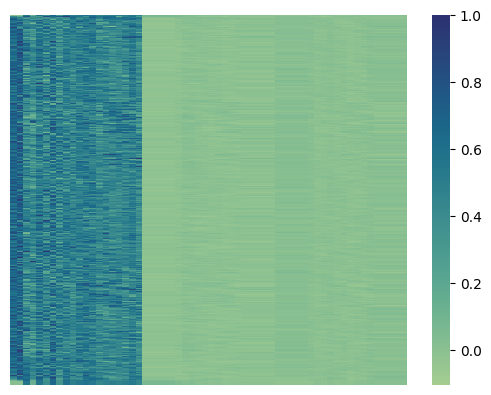

In [27]:
sns.heatmap(data[1],cmap='crest', xticklabels=False, yticklabels=False)